# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

1) Explore single environment (data processing, single)

2) Explore parallel environment (data processing, batch)

3) Build policy network

4) Build agent object (wrap executing policy)

5) Visualize game playing (single env)

6) Collect trajectories (batch mode)

7) Objective function (PPO)

8) Training and saving

In [1]:
# install package for displaying animation
!pip install JSAnimation

# upgrade pytorch
!pip install --upgrade torch

  Running setup.py bdist_wheel for JSAnimation ... done
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation
    100% |████████████████████████████████| 752.0MB 61kB/s  eta 0:00:01  2% |▉                               | 19.5MB 28.5MB/s eta 0:00:26    28% |█████████▏                      | 214.8MB 23.5MB/s eta 0:00:23    55% |█████████████████▊              | 415.2MB 26.4MB/s eta 0:00:13    61% |███████████████████▊            | 462.9MB 25.2MB/s eta 0:00:12MB 28.5MB/s eta 0:00:09█████▌         | 528.1MB 48.1MB/s eta 0:00:05████████████████████▉      | 607.6MB 48.4MB/s eta 0:00:03████████████████████      | 610.2MB 47.2MB/s eta 0:00:04�██████▏     | 615.2MB 51.8MB/s eta 0:00:03��████████▍     | 620.0MB 37.8MB/s eta 0:00:0482% |██████████████████████████▌     | 622.4MB 48.9MB/s eta 0:00:03��███▋     | 624.8MB 42.6MB/s eta 0:00:03K    83% |██████████████████████████▊     | 627.5MB 45.3MB/s eta 0:00:03�████

In [1]:
import time
import numpy as np
import random as rand

import gym

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print("using device: ",device)

1.4.0
using device:  cpu


In [2]:
env = gym.make('PongDeterministic-v4')
print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [5]:
RIGHT=4
LEFT=5

# Single environment

To speed up training, we can simplify the input by cropping the images and use every other pixel

In [6]:
def preprocess_single(frame, bkg_color = np.array([144, 72, 17])):
    img = np.mean(frame[34:-16:2,::2]-bkg_color, axis=-1)/255.
    return img

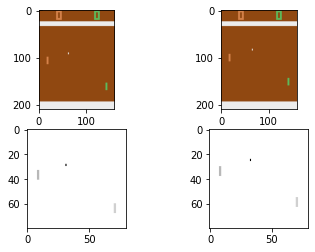

In [7]:
env.reset()
env.step(1)
for _ in range(20):
    frame1, reward1, is_done, _ = env.step(np.random.choice([RIGHT,LEFT]))
    frame2, reward2, is_done, _ = env.step(0)


plt.subplot(2,2,1)
plt.imshow(frame1)

plt.subplot(2,2,2)
plt.imshow(frame2)

plt.subplot(2,2,3)
plt.imshow(preprocess_single(frame1), cmap='Greys')

plt.subplot(2,2,4)
plt.imshow(preprocess_single(frame2), cmap='Greys')
plt.show()

In [8]:
def make_single_tensor(frames):
    tensor_list = []
    for fr in frames:
        x = preprocess_single(fr)
        x = torch.from_numpy(x).float().unsqueeze(0)
        tensor_list.append(x)
    
    state_tensor = torch.cat(tensor_list,0)
    return state_tensor.unsqueeze(0).to(device)

In [9]:
state = make_single_tensor([frame1,frame2])
state.size()

torch.Size([1, 2, 80, 80])

# Parallel environments

collect batch of trajectories more efficiently

In [9]:
from parallelEnv import parallelEnv
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

# number of parallel instances
n=len(envs.ps)
print(n)

8


In [10]:
envs.reset()
envs.step([1]*n)
# skip several initial steps
for _ in range(20):
    ## we take one action and skip game forward, (0=no action)
    fr1, re1, _, _ = envs.step(np.random.choice([RIGHT, LEFT],n))
    fr2, re2, _, _ = envs.step([0]*n)

In [11]:
def make_state_tensor(frames, bkg_color = np.array([144, 72, 17])):
    images = np.asarray(frames)
    x = np.mean(images[:,:,34:-16:2,::2]-bkg_color,axis=-1)/255.
    x = np.swapaxes(x,0,1) 
    return torch.from_numpy(x).float().to(device)

In [12]:
states = make_state_tensor([fr1,fr2])
states.size()

torch.Size([8, 2, 80, 80])

# Policy network

Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [14]:
#policy = policy_net().to(device)
#policy(states)

In [15]:
#policy(state)

# Agent

buil a class to wrap several functions:

1) act: Returns actions for given state as per current policy

2) get_probs: Returns probs for given state and act actions


In [16]:
agent = Agent()

In [17]:
actions, probs = agent.act(states)
print(actions, probs)
agent.get_probs(states,actions)

[5 4 4 5 4 4 4 5] [ 0.51021945  0.48987782  0.48979911  0.51013666  0.48978296  0.48989803
  0.48983553  0.51014566]


tensor([[0.5102],
        [0.4899],
        [0.4898],
        [0.5101],
        [0.4898],
        [0.4899],
        [0.4898],
        [0.5101]], device='cuda:0', grad_fn=<SWhereBackward>)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

In [10]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

# function to animate a list of frames
def animate_frames(frames):
    plt.axis('off')

    # color option for plotting
    # use Greys for greyscale
    cmap = None if len(frames[0].shape)==3 else 'Greys'
    patch = plt.imshow(frames[0], cmap=cmap)  

    fanim = animation.FuncAnimation(plt.gcf(), \
        lambda x: patch.set_data(frames[x]), frames = len(frames), interval=30)
    
    display(display_animation(fanim, default_mode='once'))

# use one agent to play
def play(env, agent, time=2000, preprocess=None, nrand=5):
    agent.policy.eval()
    env.reset()
    env.step(1)
    for _ in range(nrand):
        frame1, reward1, is_done, _ = env.step(np.random.choice([RIGHT,LEFT]))
        frame2, reward2, is_done, _ = env.step(0)
    
    anim_frames = []
    
    for _ in range(time):
        state = make_single_tensor([frame1,frame2])
        action,prob = agent.act(state)
        
        frame1, _, is_done, _ = env.step(action)
        frame2, _, is_done, _ = env.step(0)

        anim_frames.append(frame1)

        if is_done:
            break
    
    env.close()
    animate_frames(anim_frames)
    return 

ModuleNotFoundError: No module named 'JSAnimation'


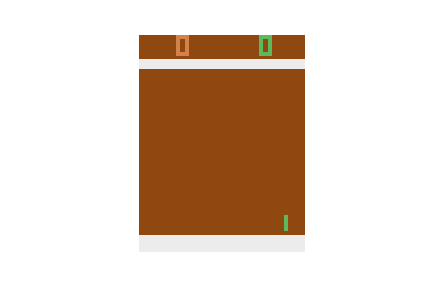
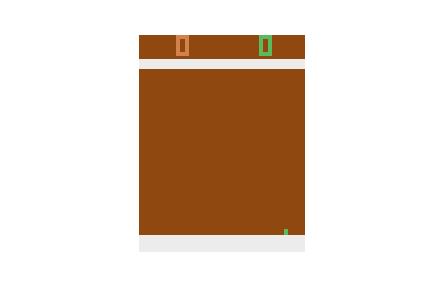
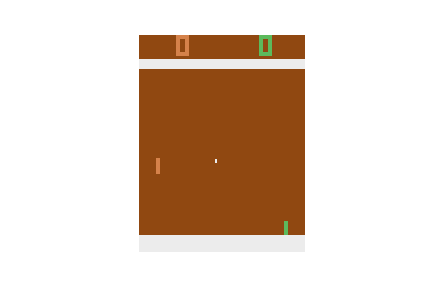
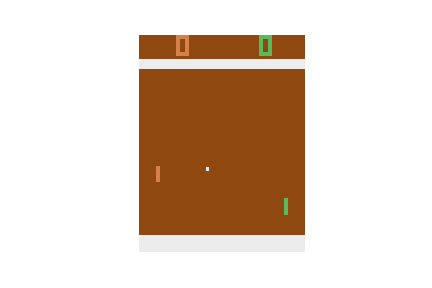
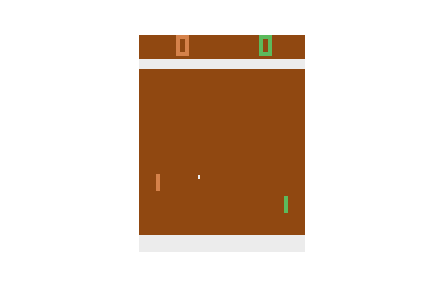
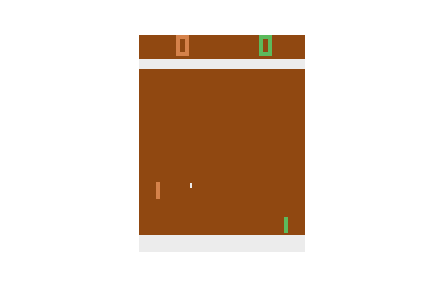
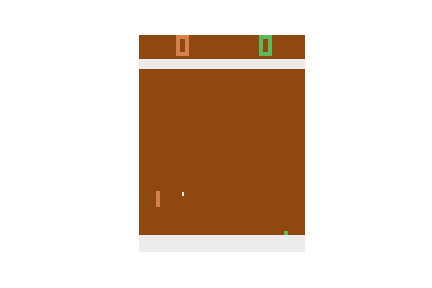
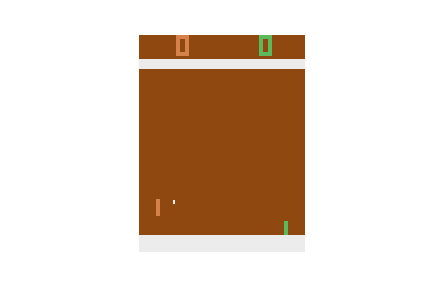
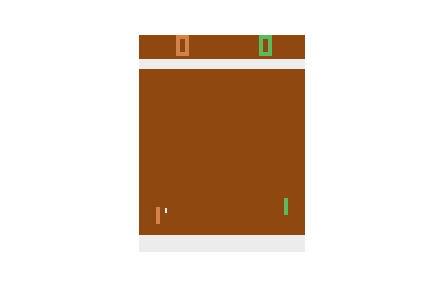
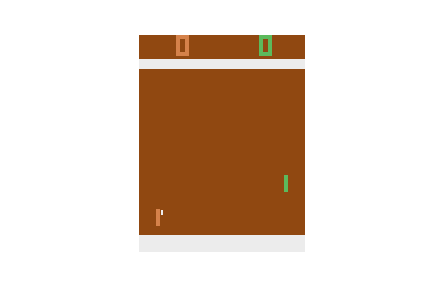
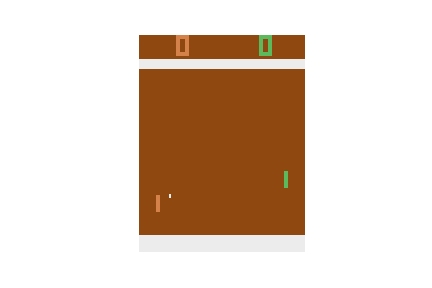
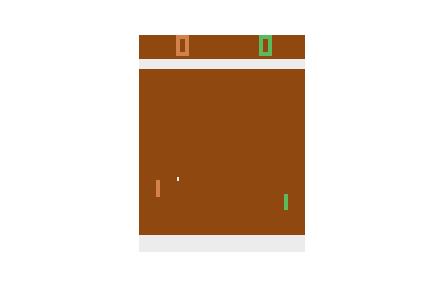
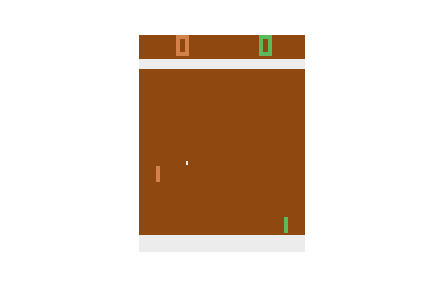
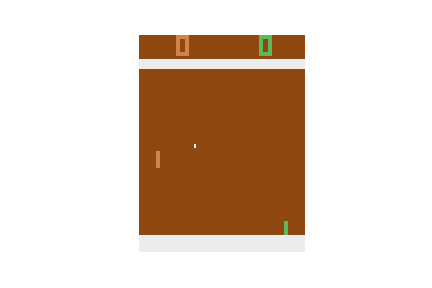
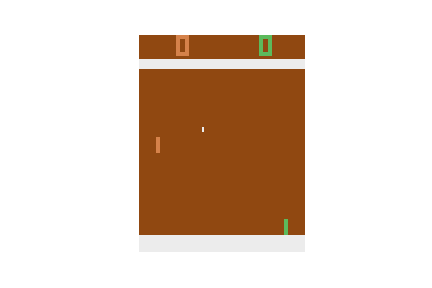
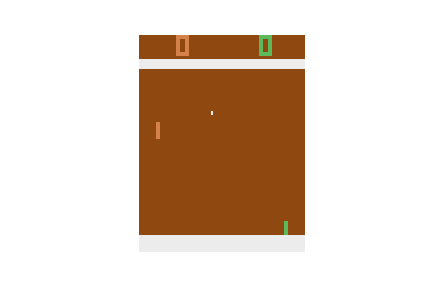
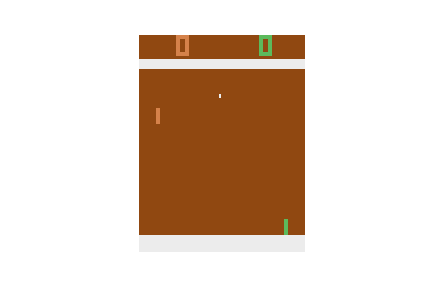
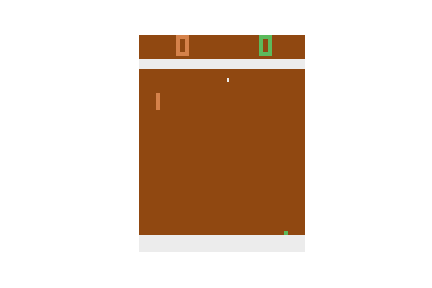
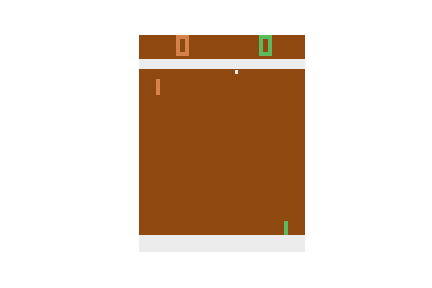
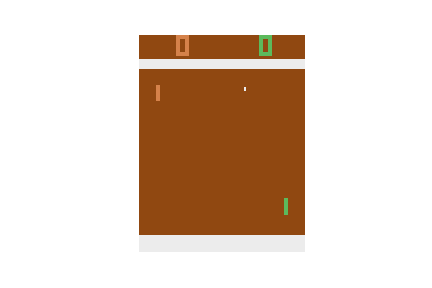
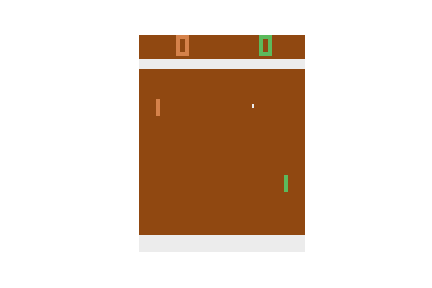
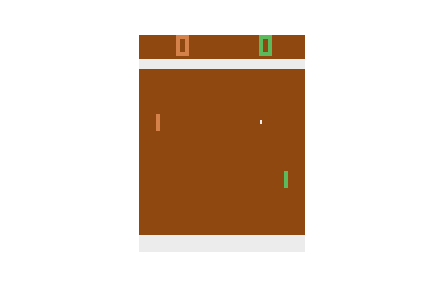
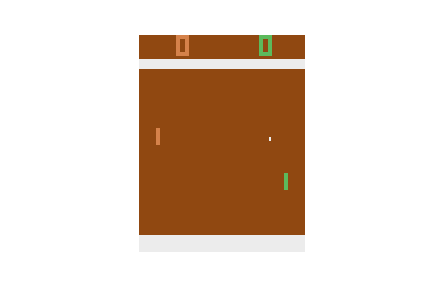
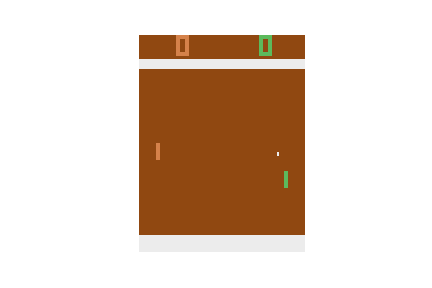
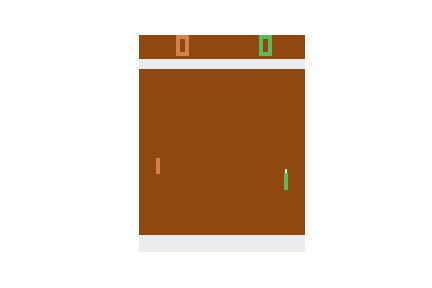
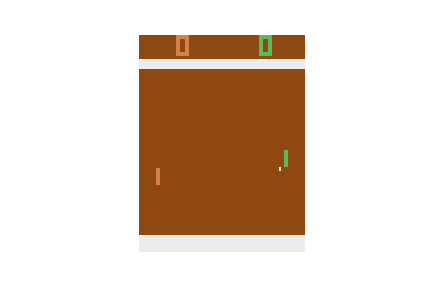
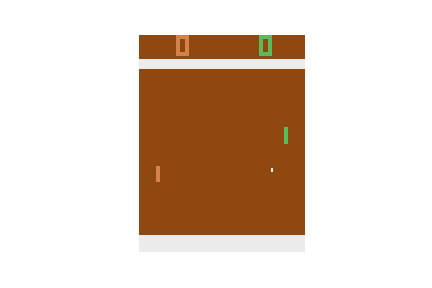
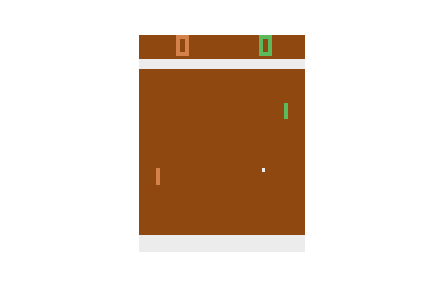
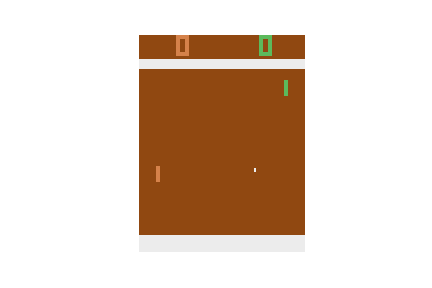
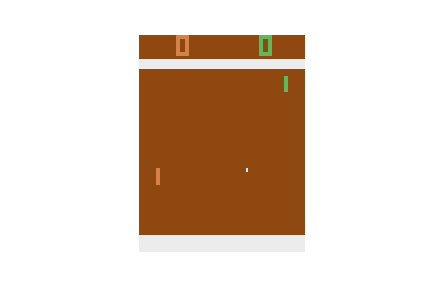
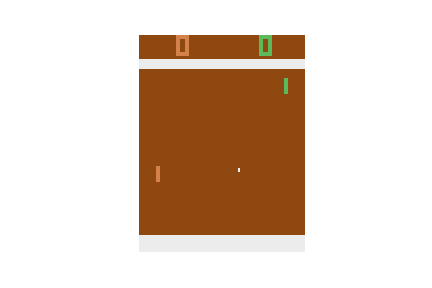
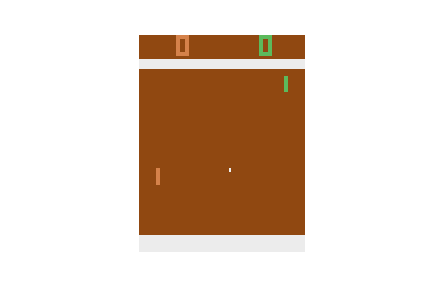
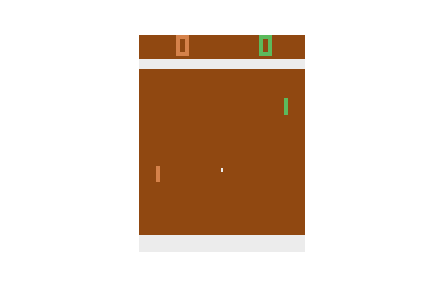
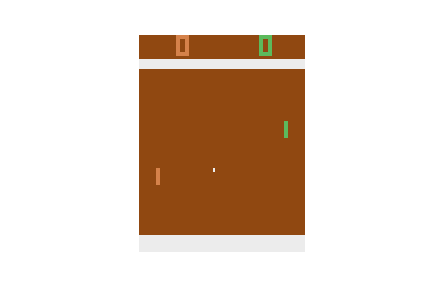
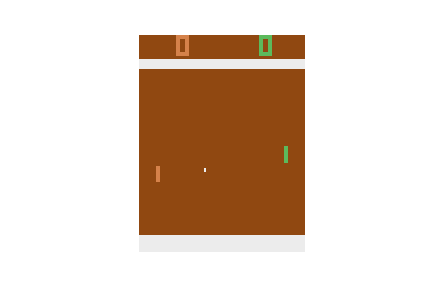
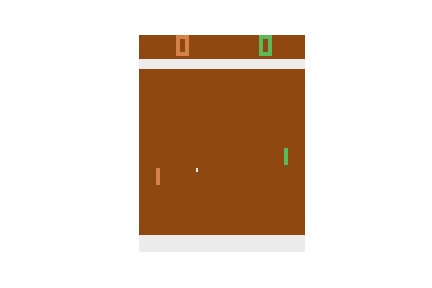
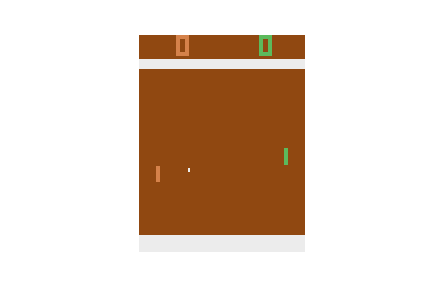
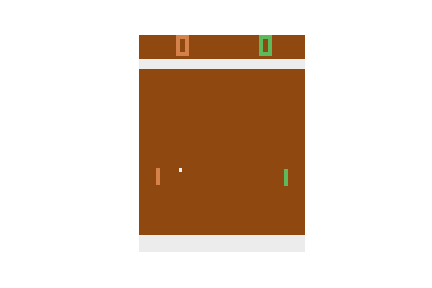
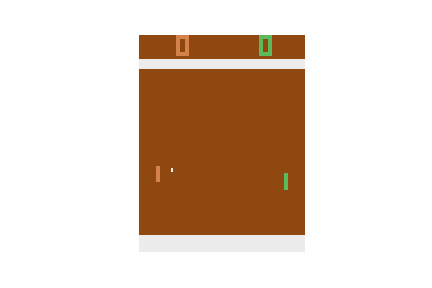
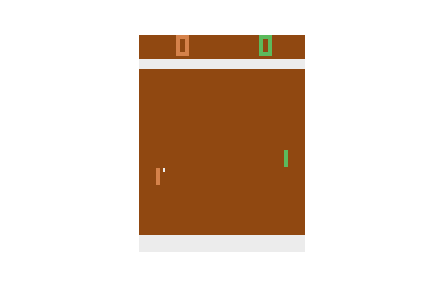
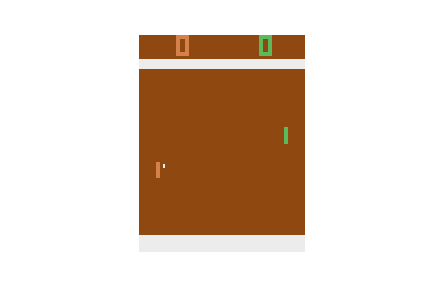
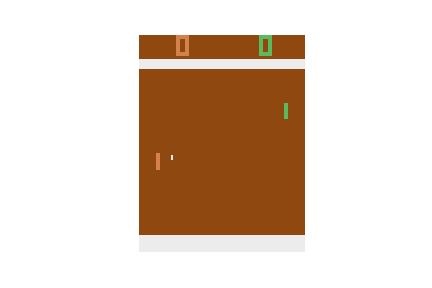
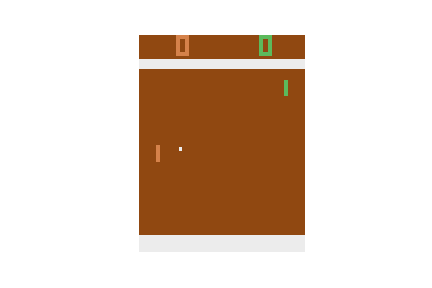
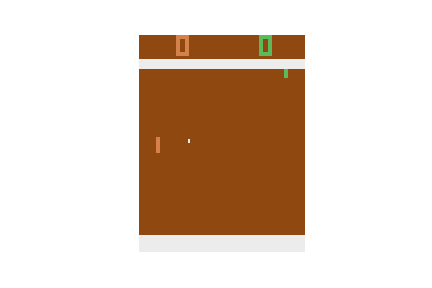
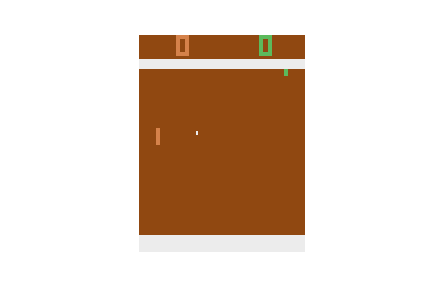
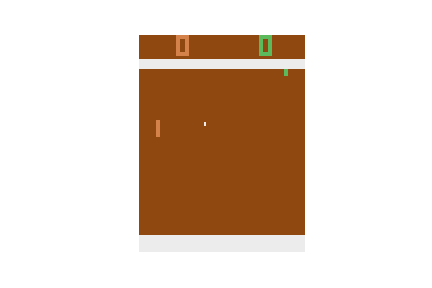
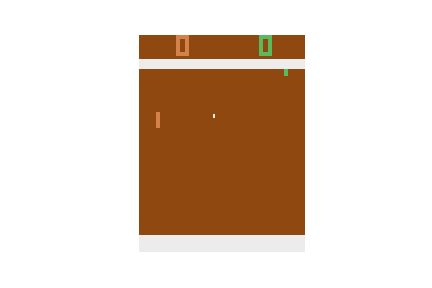
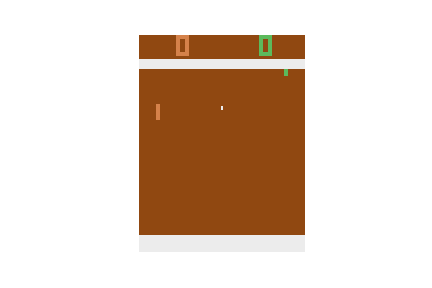
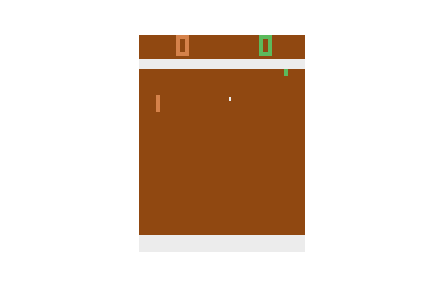
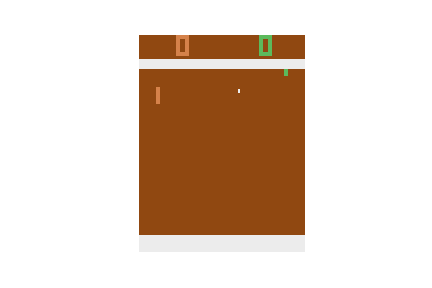
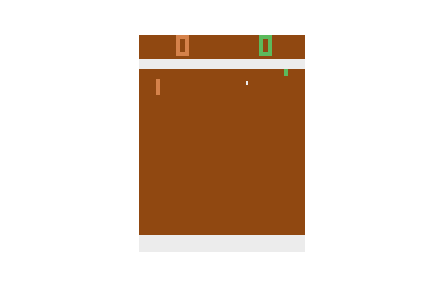
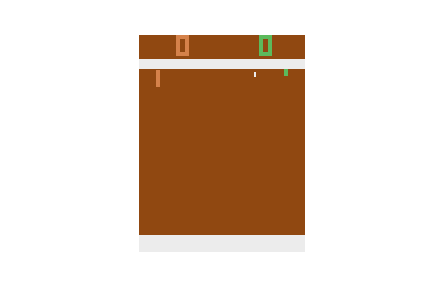
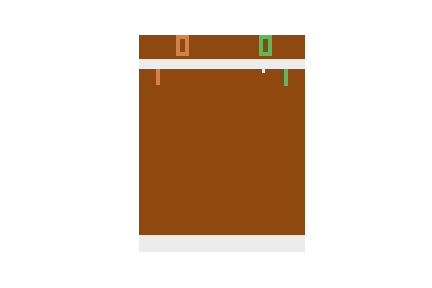
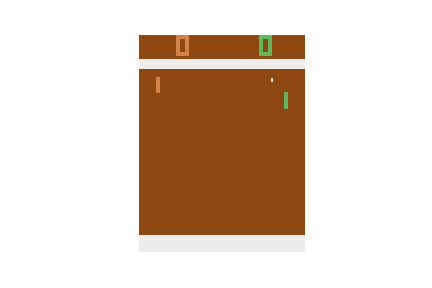
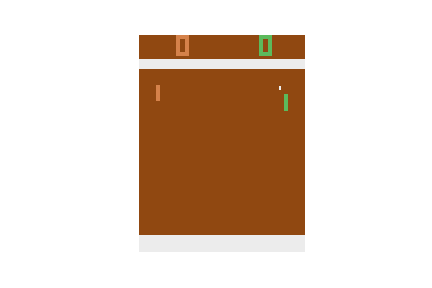
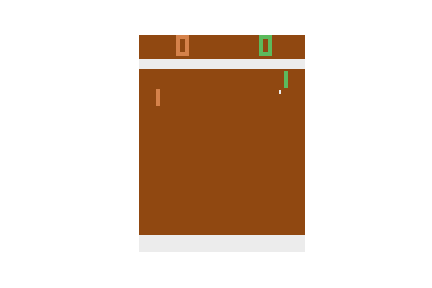
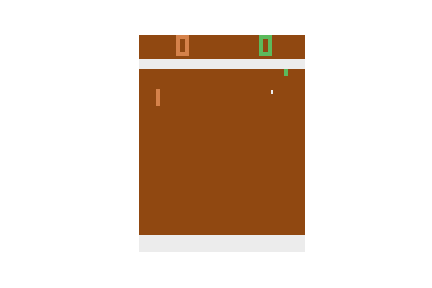
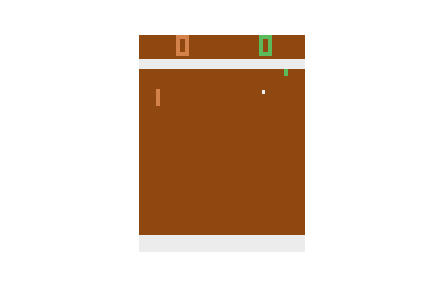
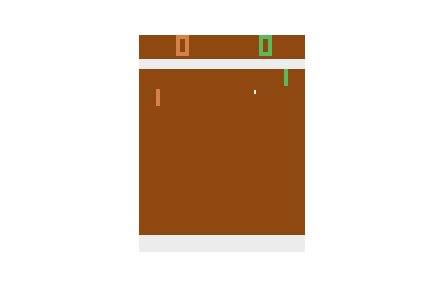
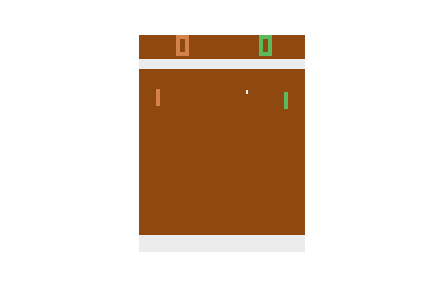
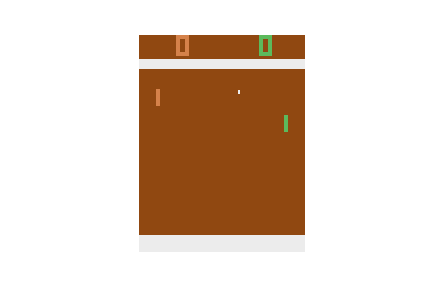
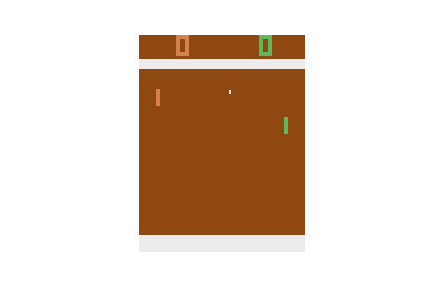
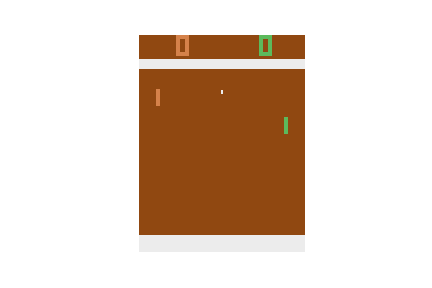
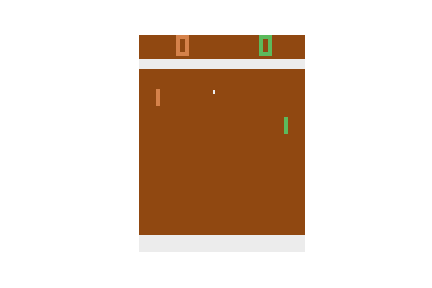
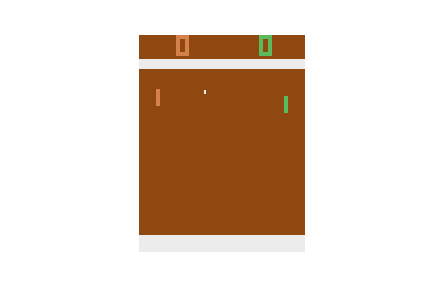
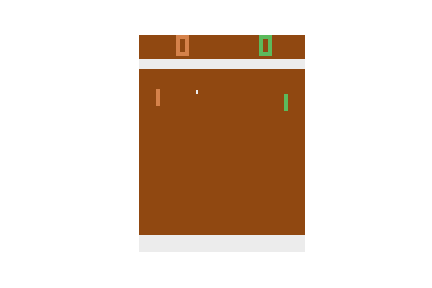
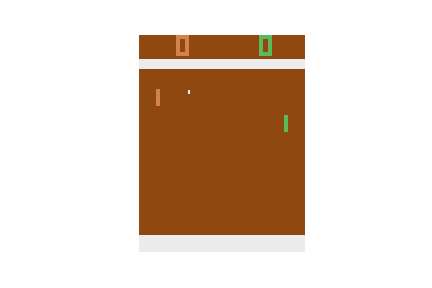
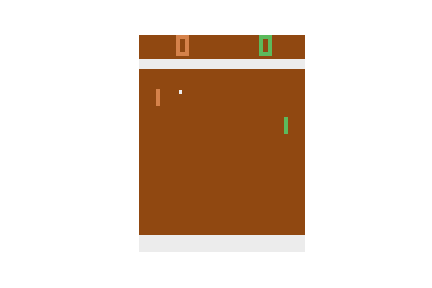
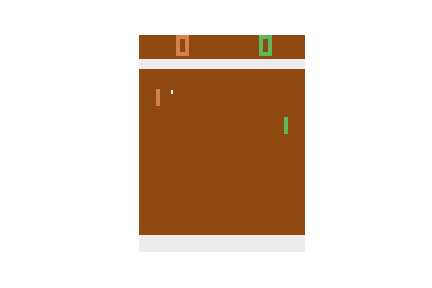
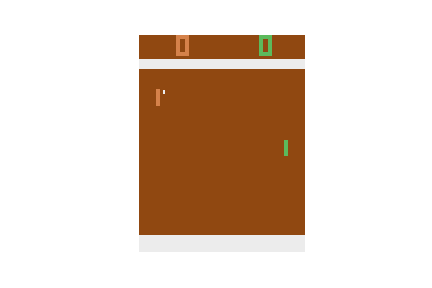
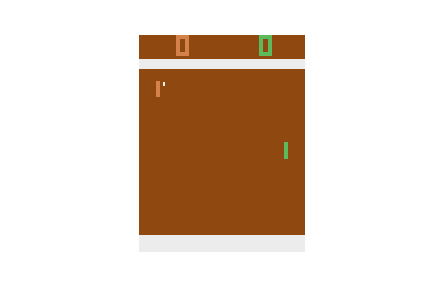
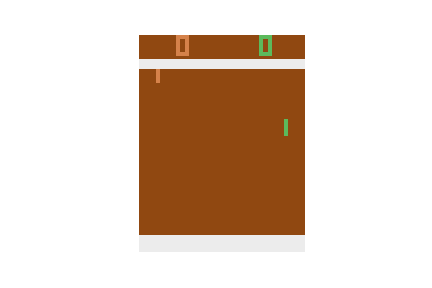
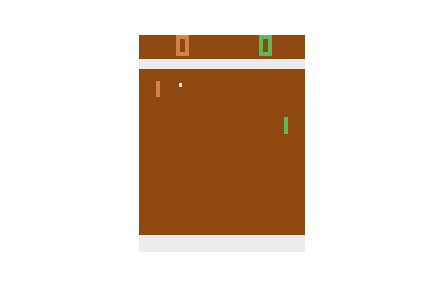
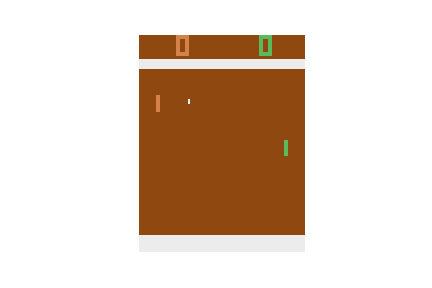
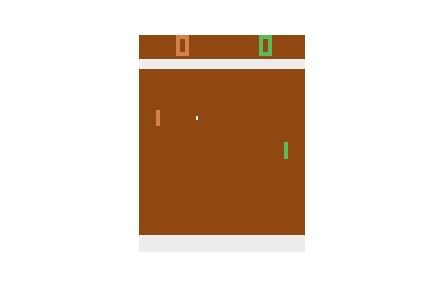
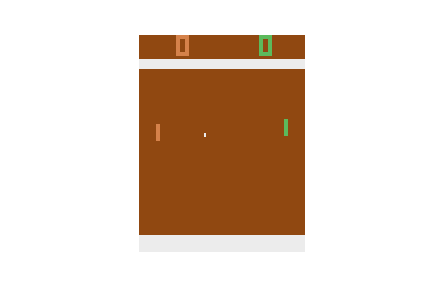
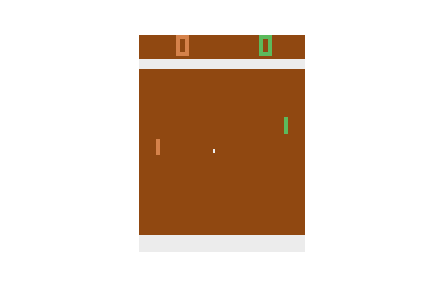
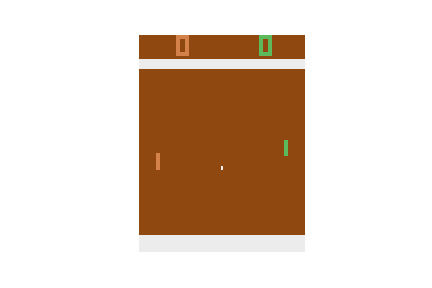
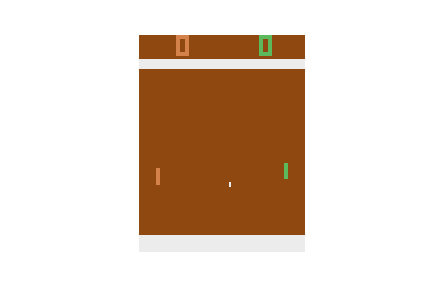
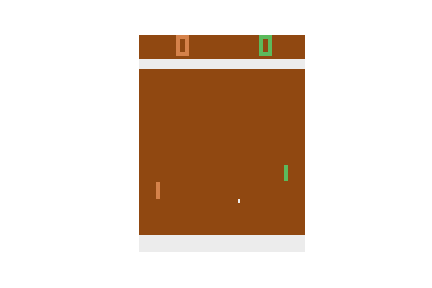
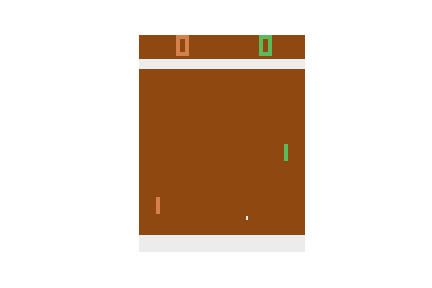
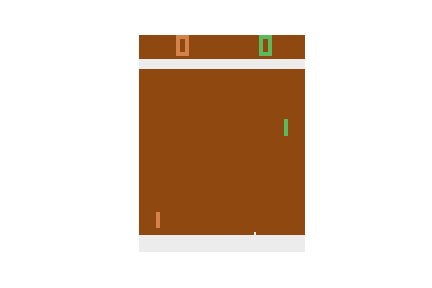
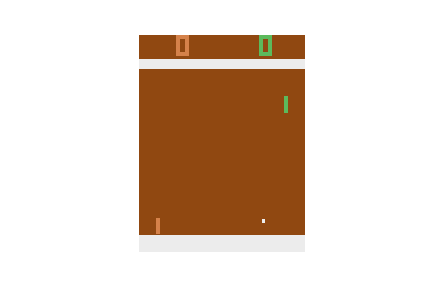
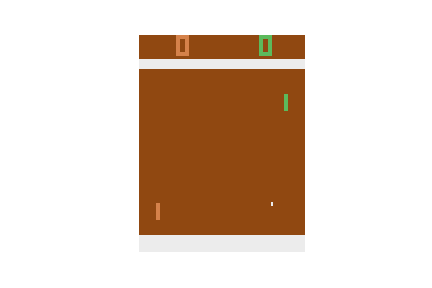
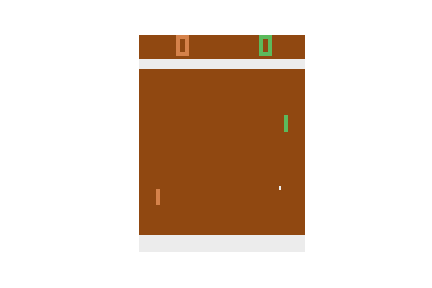
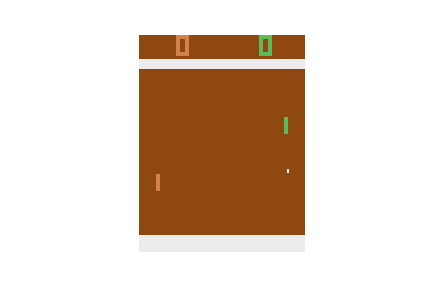
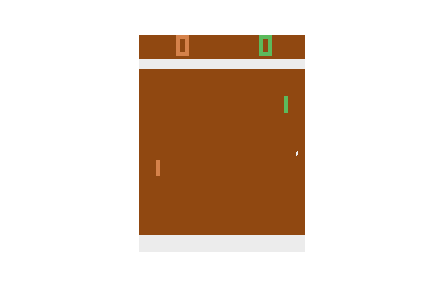
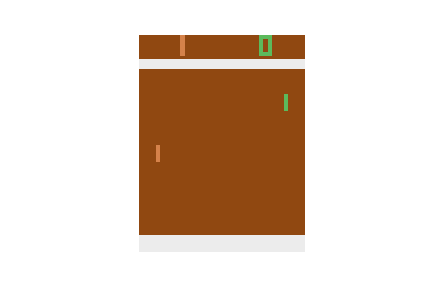
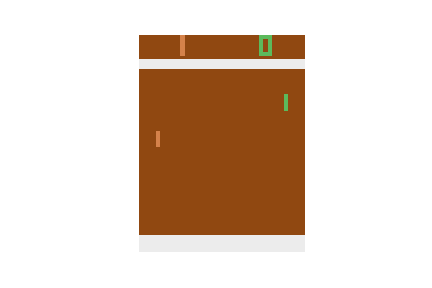
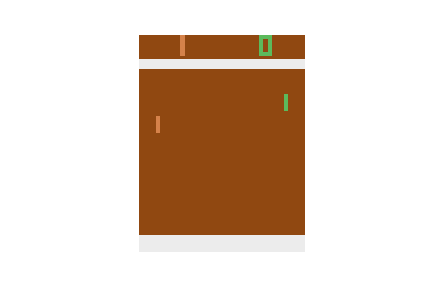
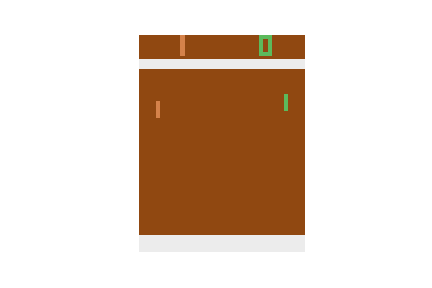
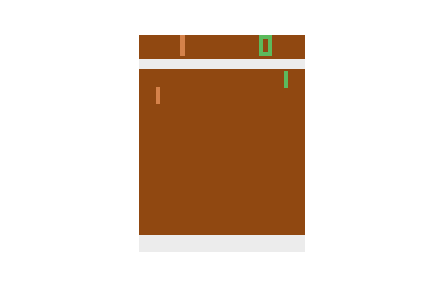
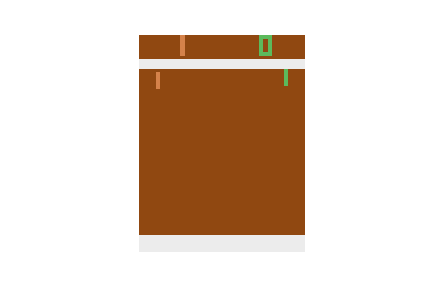
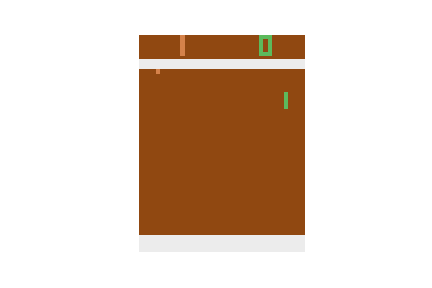
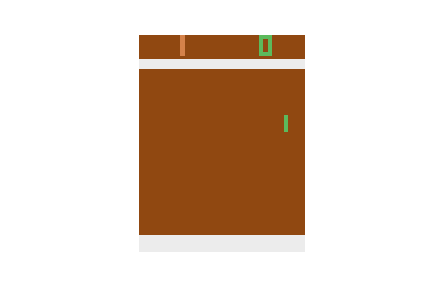
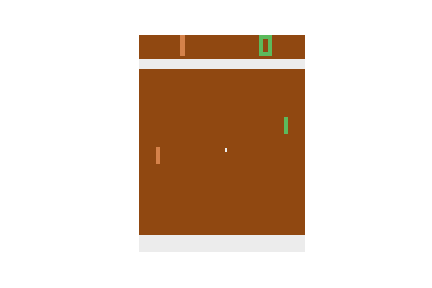
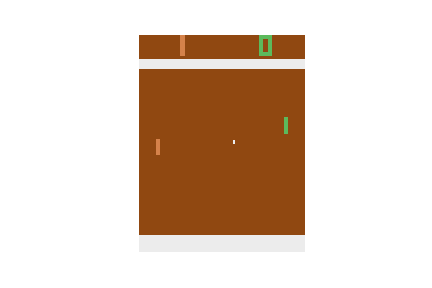
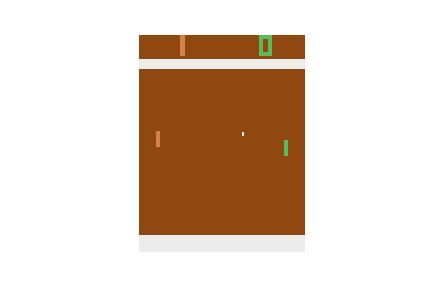
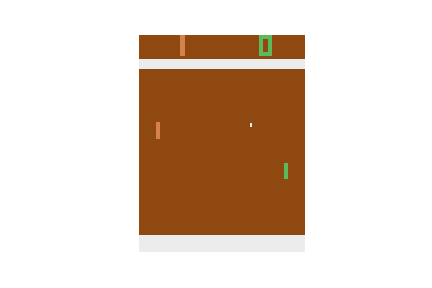
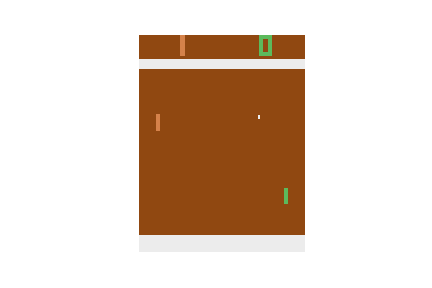
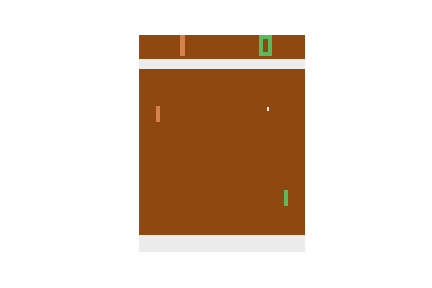
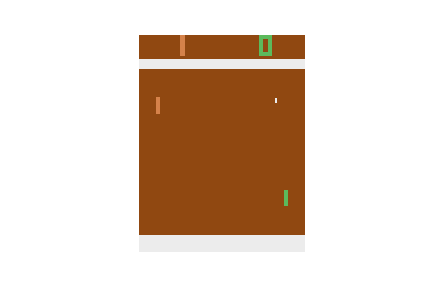
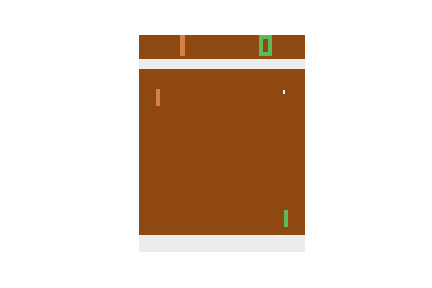
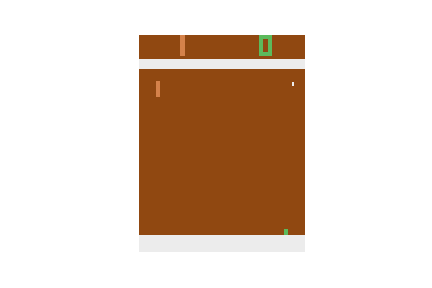
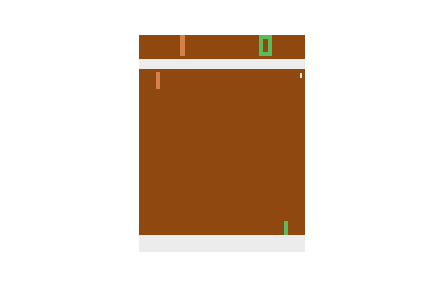
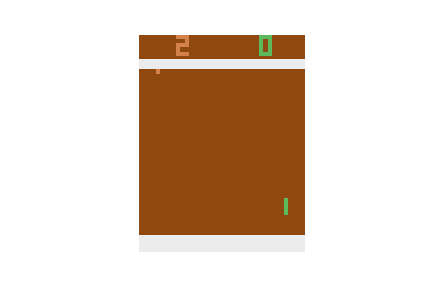
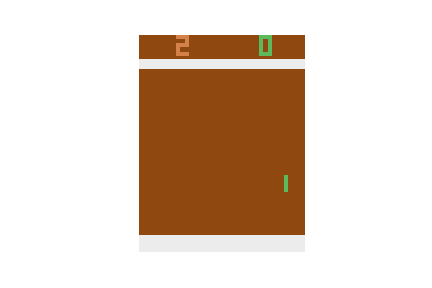
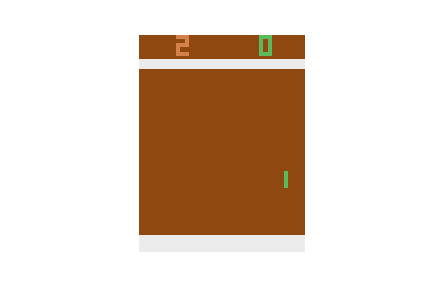
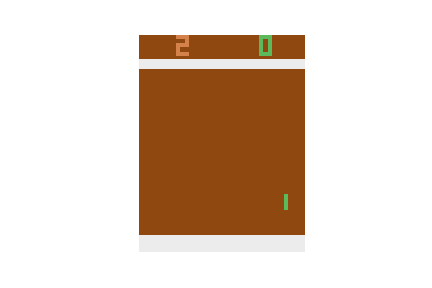
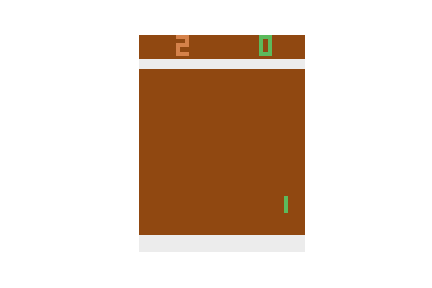
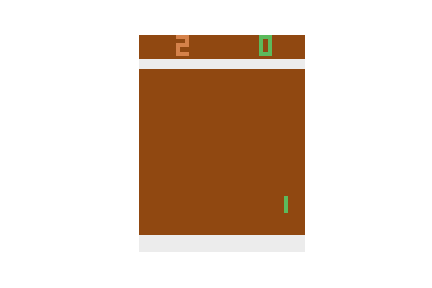
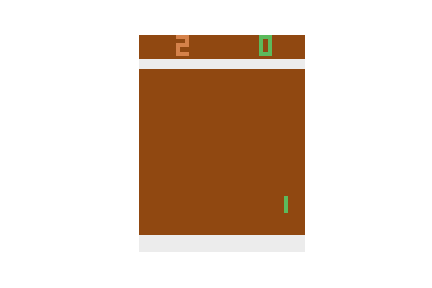
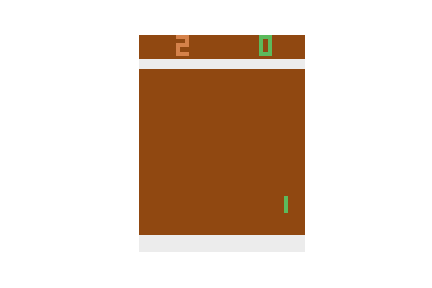
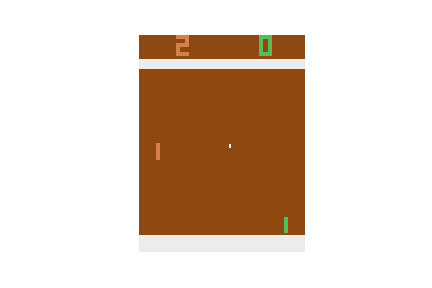
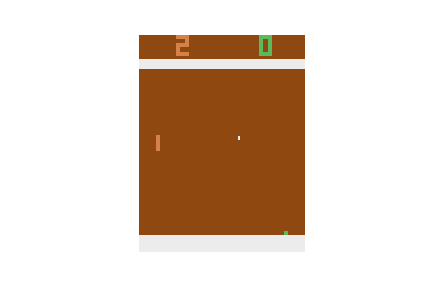
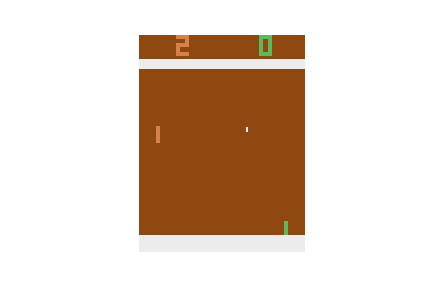
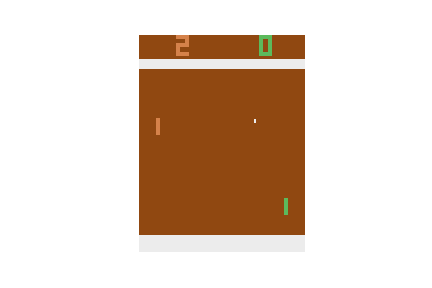
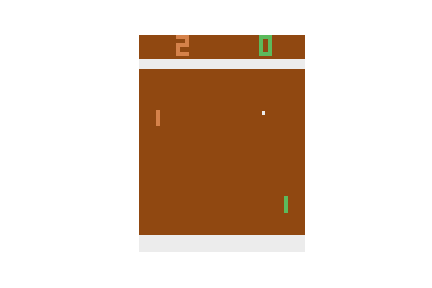
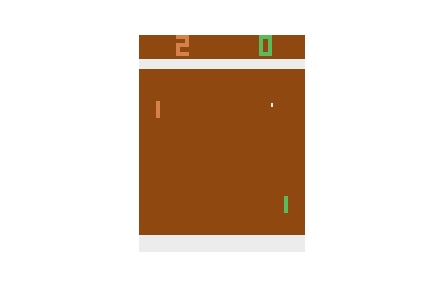
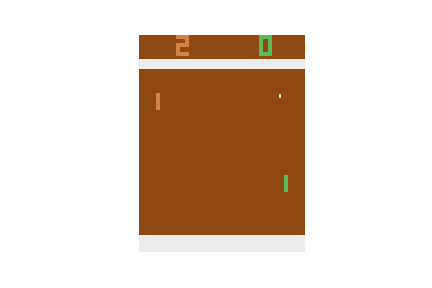
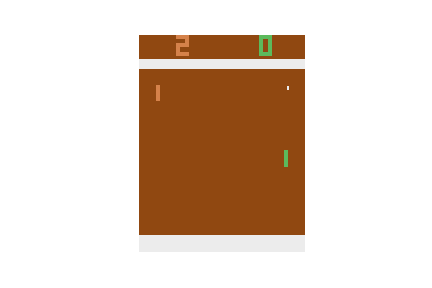
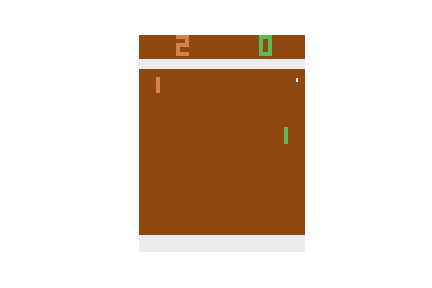
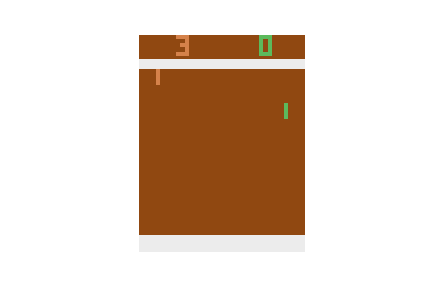
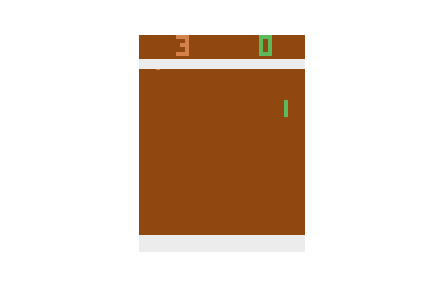
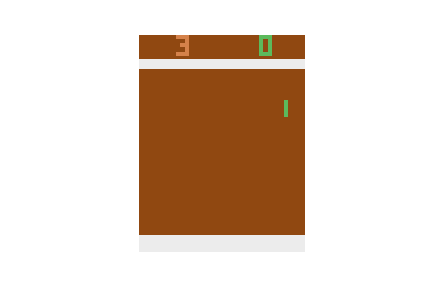
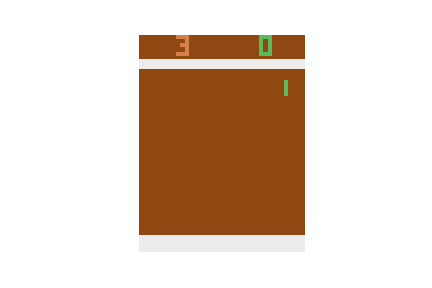
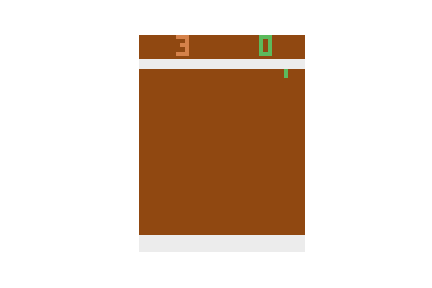
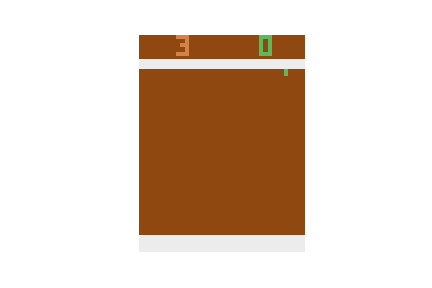
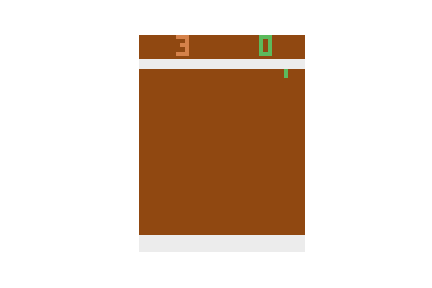
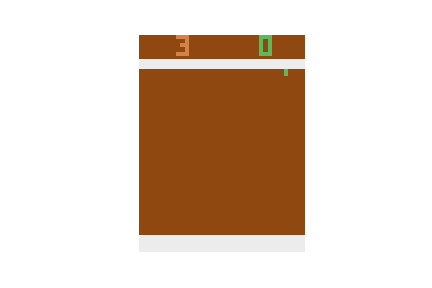
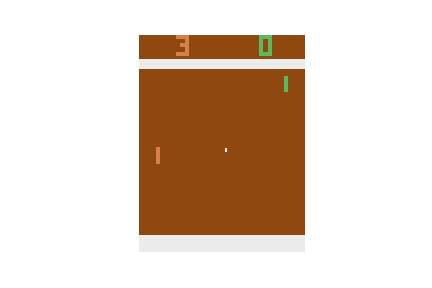
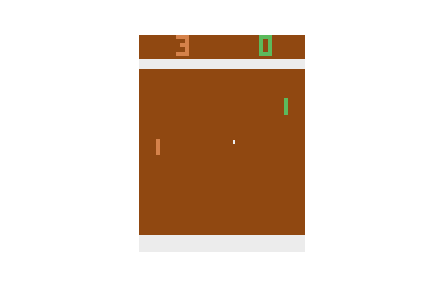
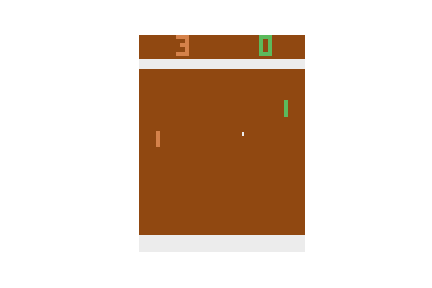
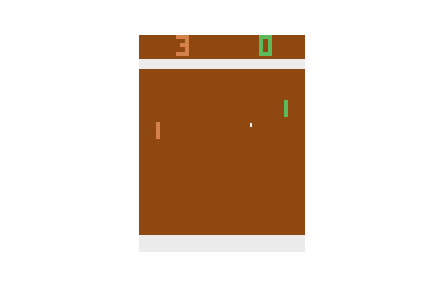
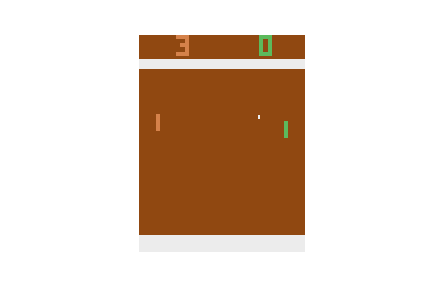
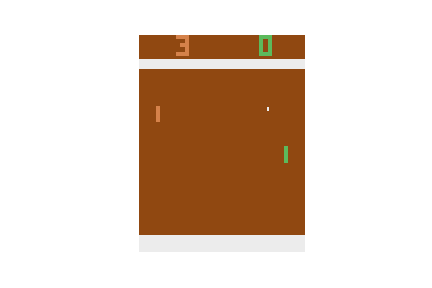
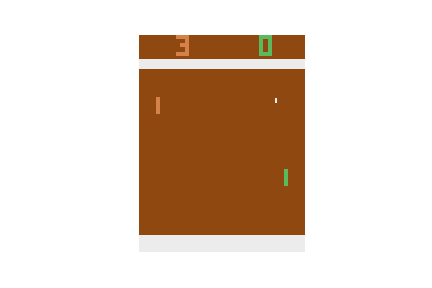
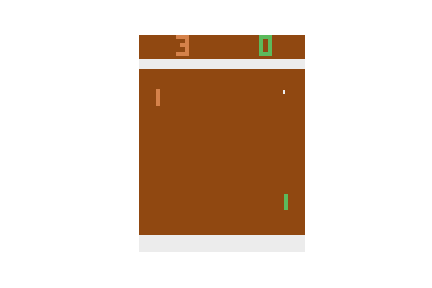
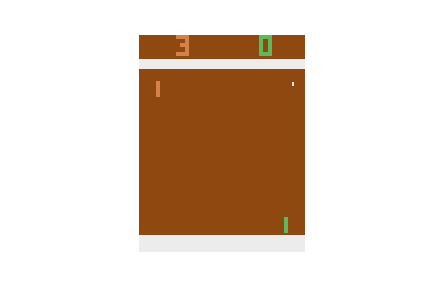
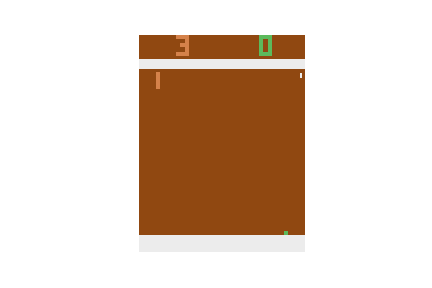
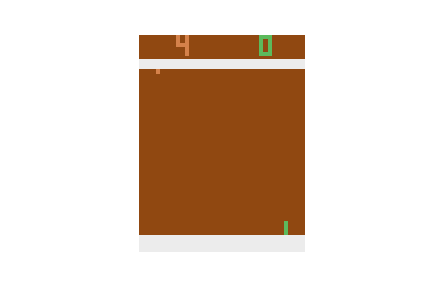
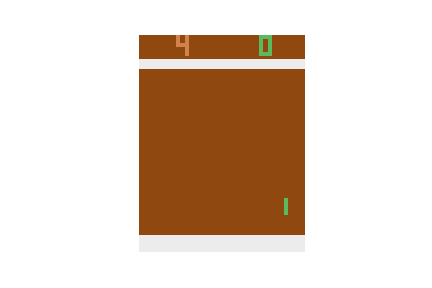
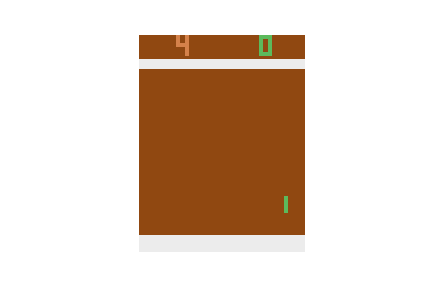
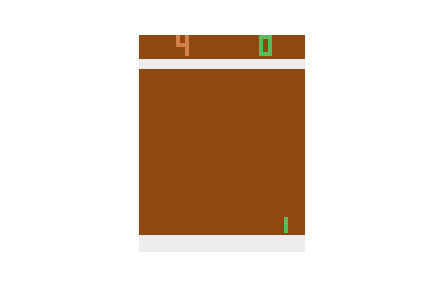
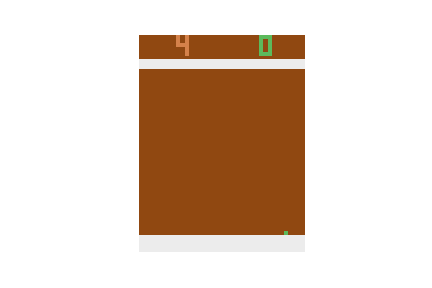
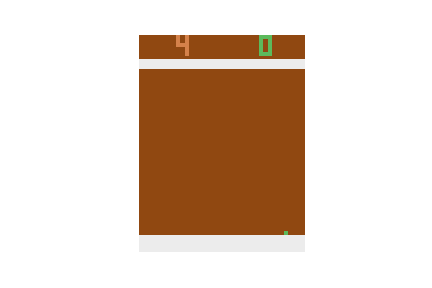
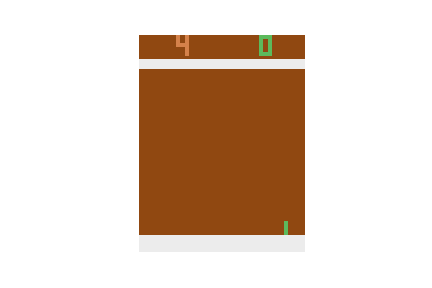
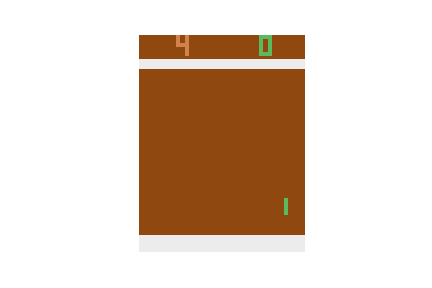
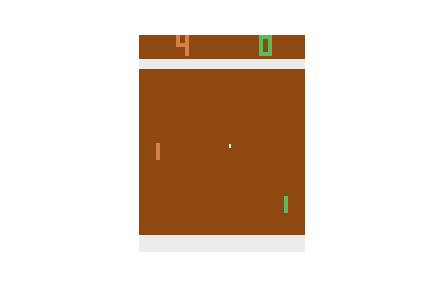
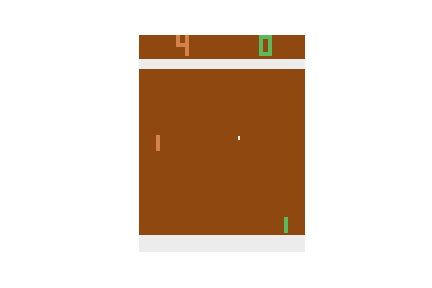
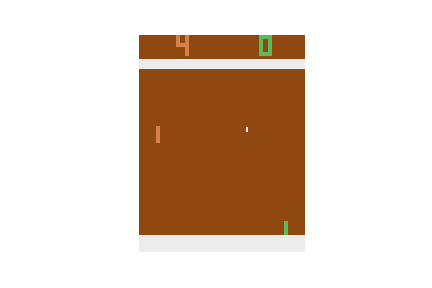
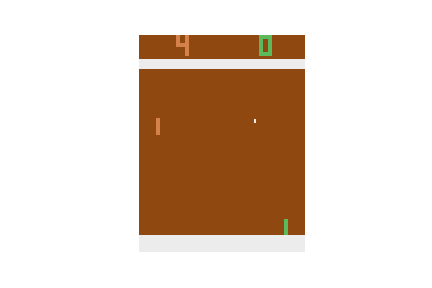
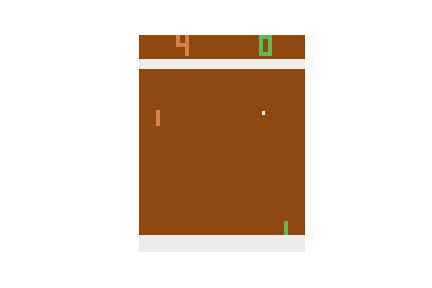
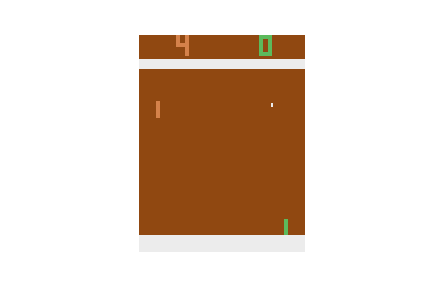
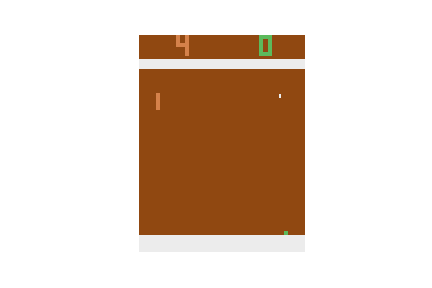
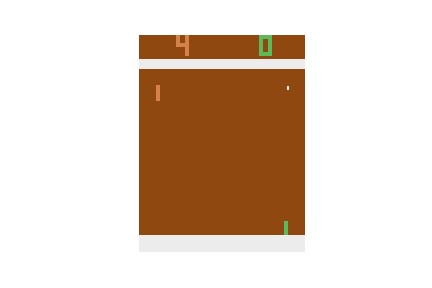
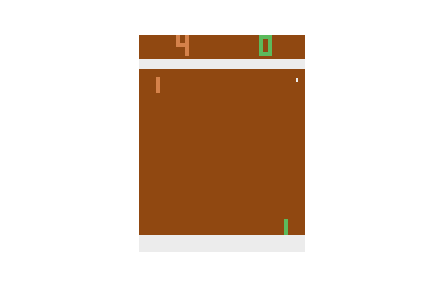
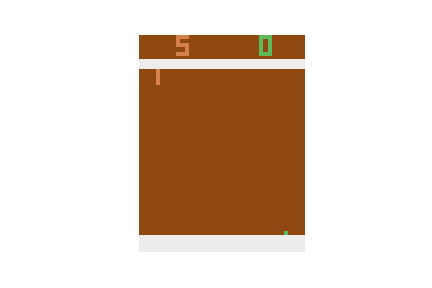
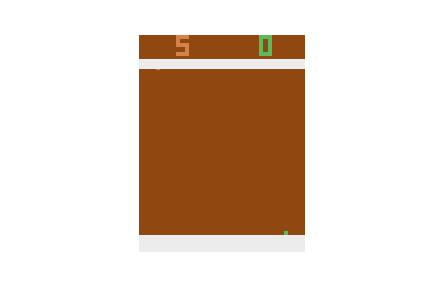
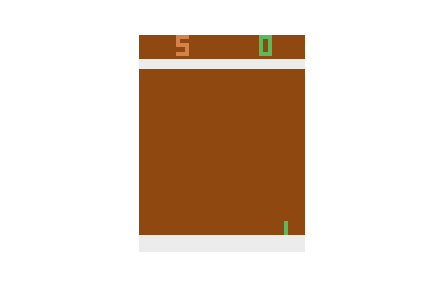
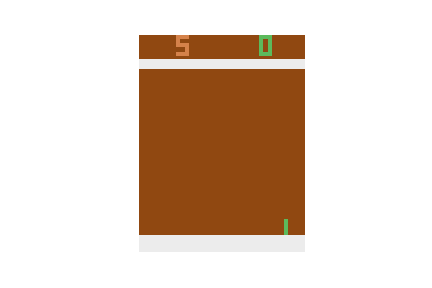
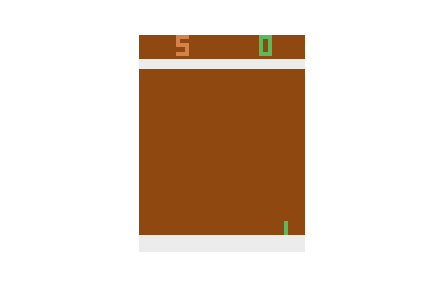
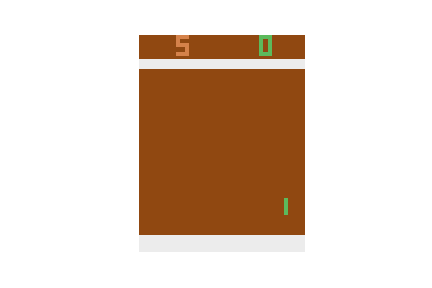
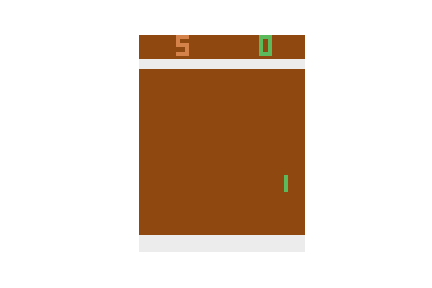
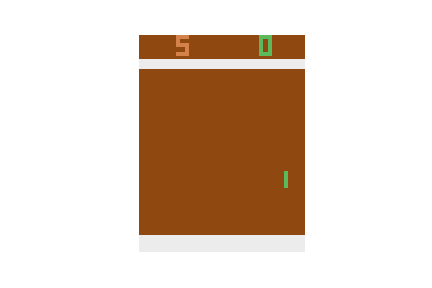
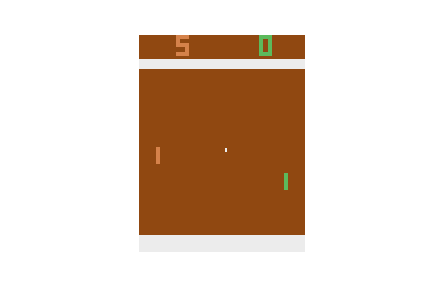
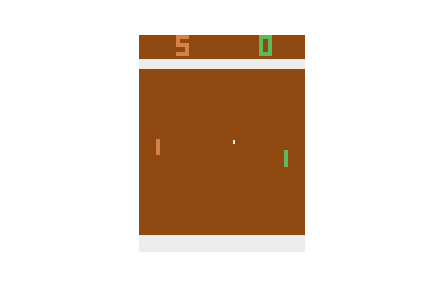
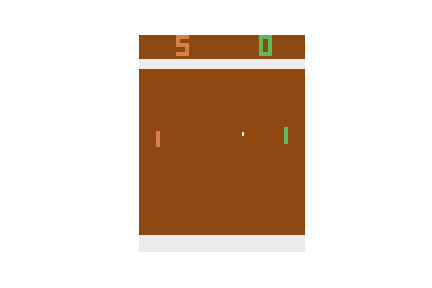
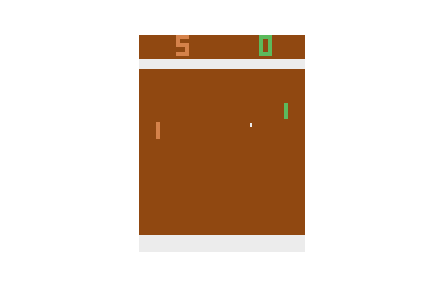
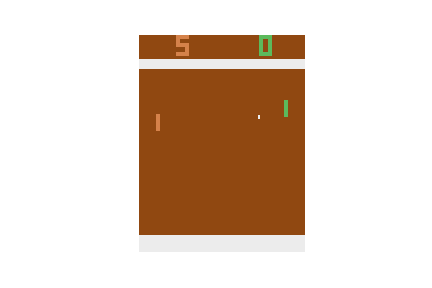
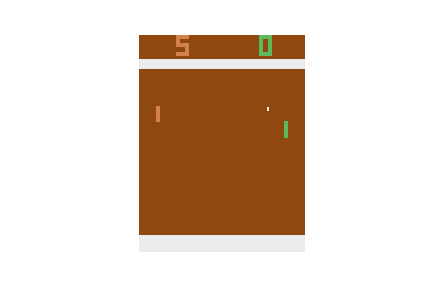
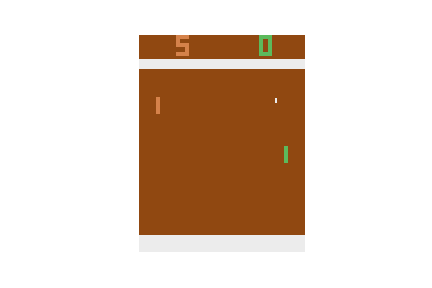
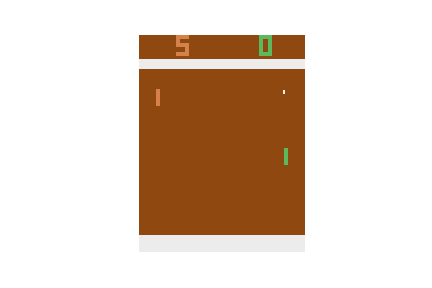
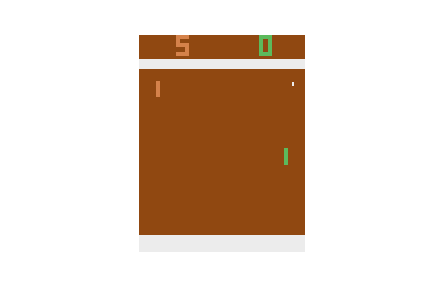
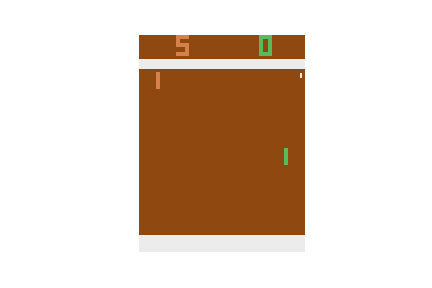
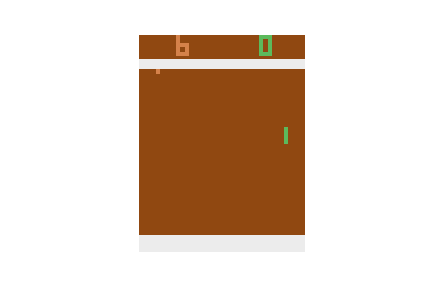
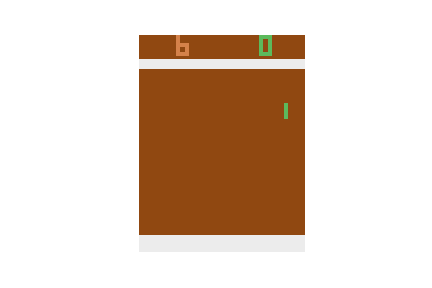
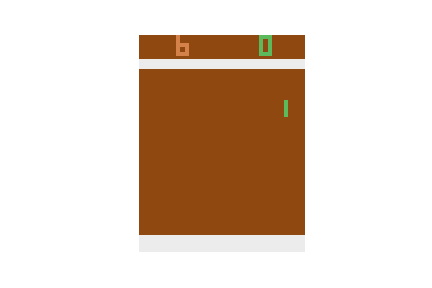
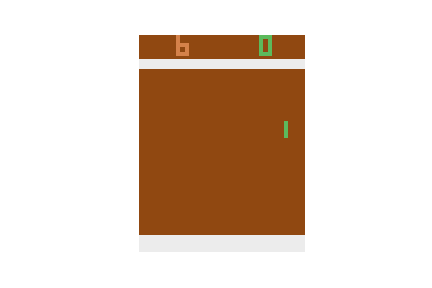
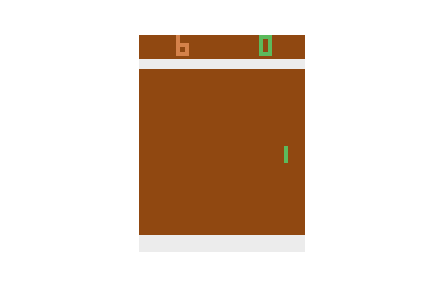
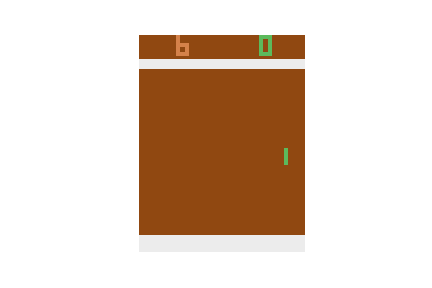
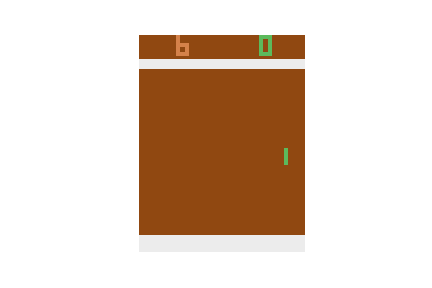
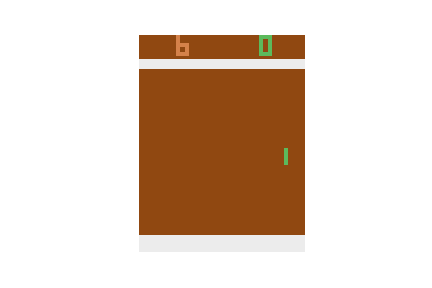
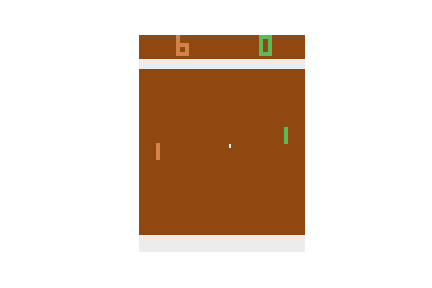
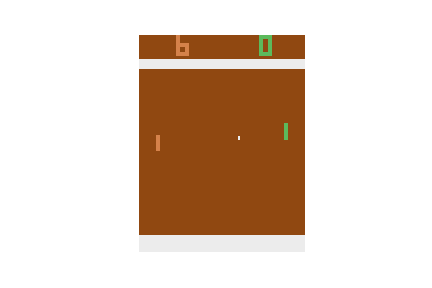
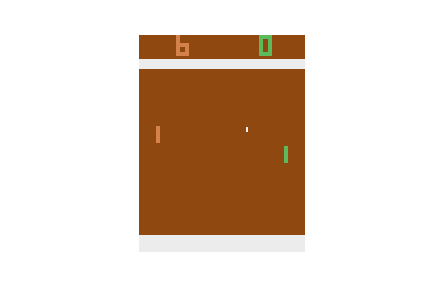
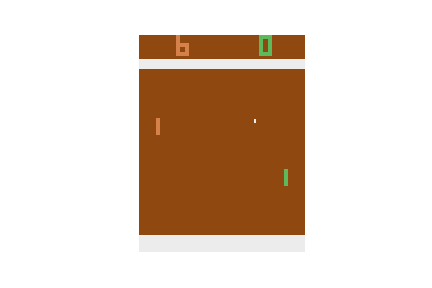
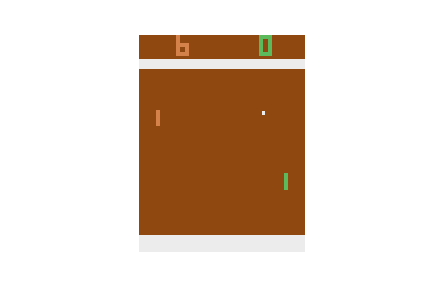
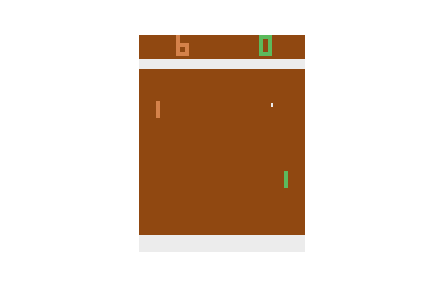
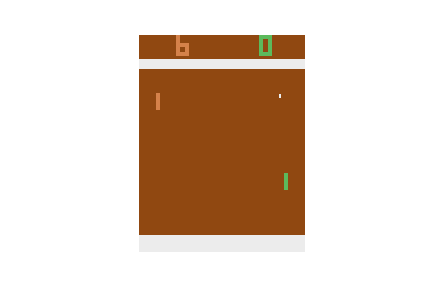
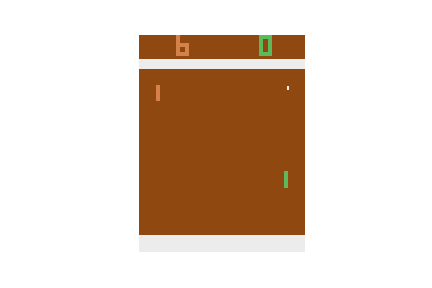
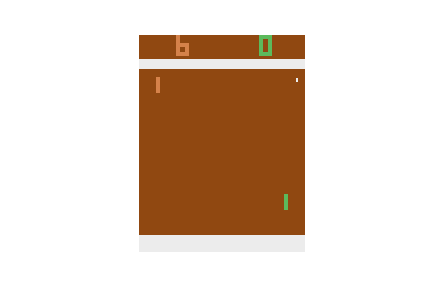
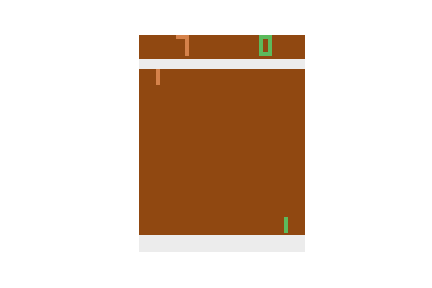
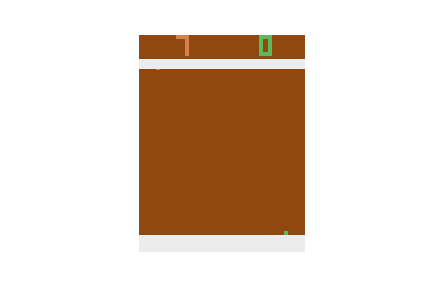
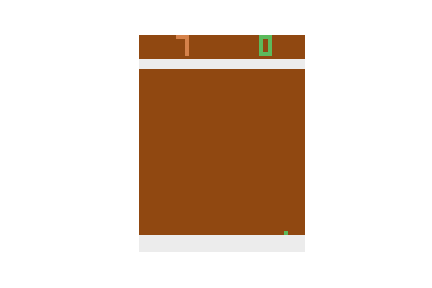
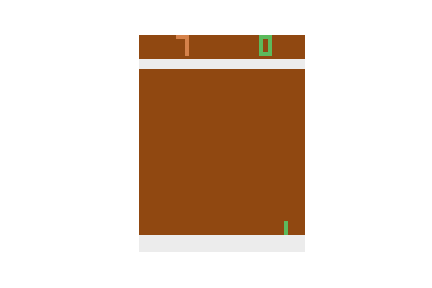
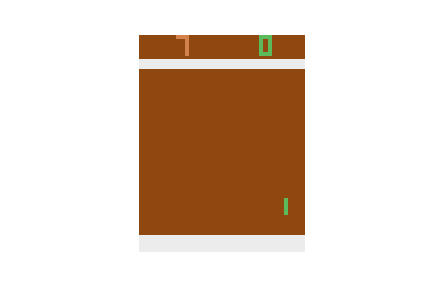
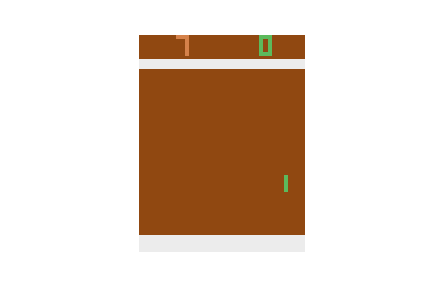
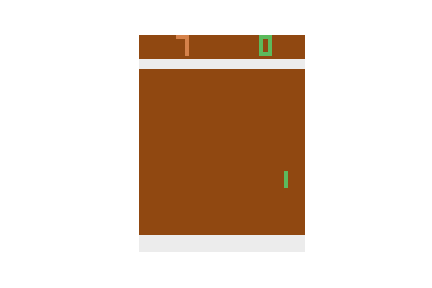
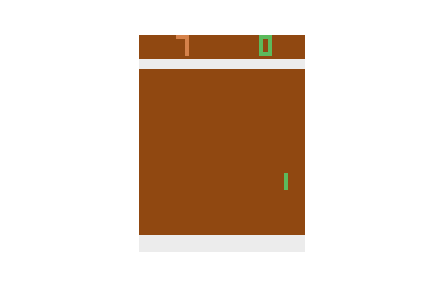

In [19]:
play(env, agent, time=200) 

# Collect trajectories

Use parallel evnoronments to collect mini batch

In [20]:
# collect trajectories for a parallelized parallelEnv object
def collect_trajectories(envs, agent, tmax=200, nrand=5):
    agent.policy.eval()
    
    n=len(envs.ps)

    state_list=[]
    reward_list=[]
    prob_list=[]
    action_list=[]

    envs.reset()
    envs.step([1]*n)
    # skip several initial steps
    for _ in range(nrand):
        ## we take one action and skip game forward, (0=no action)
        fr1, re1, _, _ = envs.step(np.random.choice([RIGHT, LEFT],n))
        fr2, re2, _, _ = envs.step([0]*n)
    
    for t in range(tmax):
        # current states
        states = make_state_tensor([fr1,fr2])
        # pick actions according policy
        actions, probs  = agent.act(states)
        # act actions given states and collect rewards
        ## we take one action and skip game forward, (0=no action)
        fr1, re1, is_done, _ = envs.step(actions)
        fr2, re2, is_done, _ = envs.step([0]*n)
        reward = re1 + re2
        
        # store the result
        state_list.append(states)  # tensor
        action_list.append(actions) # array
        prob_list.append(probs) # array
        reward_list.append(reward) # array
        
        # do not save is_done, instead out off if any trajectory is done
        if is_done.any():
            break

    return state_list, action_list, prob_list, reward_list

In [21]:
state_list, action_list, prob_list, reward_list = collect_trajectories(envs, agent)

# Objective function
Here you will define key functions for training. 

### PPO

$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```


include a regularization term to the objetive function

In [22]:
x = np.asarray(range(10))
print(x)
# cumulative sum
print(x.cumsum(axis=0))
# reverse
print(x.cumsum(axis=0)[::-1])

[0 1 2 3 4 5 6 7 8 9]
[ 0  1  3  6 10 15 21 28 36 45]
[45 36 28 21 15 10  6  3  1  0]


In [23]:
def clipped_surrogate(state_list, action_list, prob_list, reward_list, gamma=0.995, epsilon=0.1, beta=0.01):
    T = len(reward_list)
    # discounted reward to go ???
    discounts = gamma**np.arange(T)
    rewards = np.asarray(reward_list)*discounts[:,np.newaxis]
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    # reward normalization
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10
    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    rewards = torch.tensor(rewards_normalized).float().to(device) 

    # new prob
    new_probs = []
    for states, actions in zip(state_list, action_list):
        new_probs.append(agent.get_probs(states,actions).view(1,-1))
    new_probs = torch.cat(new_probs,0)
    
    old_probs = torch.tensor(prob_list).float().to(device) 

    # re-weighting factor
    ratio = new_probs/old_probs

    # clipped function
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)

    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    
    # this returns an average of all the entries of the tensor
    # effective computing L_sur^clip / T
    # averaged over time-step and number of trajectories
    # this is desirable because we have normalized our rewards
    return torch.mean(clipped_surrogate + beta*entropy)

In [24]:
clipped_surrogate(state_list, action_list, prob_list, reward_list)

tensor(0.0069, device='cuda:0', grad_fn=<MeanBackward0>)

# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [25]:
# widget bar to display progress
!pip install progressbar
import progressbar as pb

  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


In [26]:
GAMMA = .99
EPSILON = 0.1
BETA = .01
TMAX = 320
SGD_epoch = 4
LR = 1e-4

agent = Agent(learning_rate = LR)
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

In [30]:
episode = 100
widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

mean_return = []
for e in range(episode):
    state_list, action_list, prob_list, reward_list = collect_trajectories(envs, agent, tmax = TMAX)
    agent.policy.train()
    
    total_rewards = np.sum(reward_list, axis=0)
    
    for _ in range(SGD_epoch):
        L = -clipped_surrogate(state_list, action_list, prob_list, reward_list, 
                               gamma = GAMMA, epsilon = EPSILON, beta = BETA)

        agent.optimizer.zero_grad()
        L.backward()
        agent.optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    EPSILON*=.999
    # the regulation term also reduces, reduces exploration in later runs
    BETA*=.995

    mean_return.append(np.mean(total_rewards))    
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    timer.update(e+1)
    
timer.finish()

Episode: 20, score: 0.000000
[ 1.  1. -1.  0.  0.  0. -1.  0.]


Episode: 40, score: 0.750000
[ 0.  1.  1.  1.  1.  1.  0.  1.]


Episode: 60, score: 0.750000
[ 1.  1.  1.  1.  1.  1.  1. -1.]


Episode: 80, score: 1.000000
[ 1.  1.  1.  1.  1.  1.  1.  1.]


Episode: 100, score: 1.000000
[ 1.  1.  1.  1.  1.  1.  1.  1.]



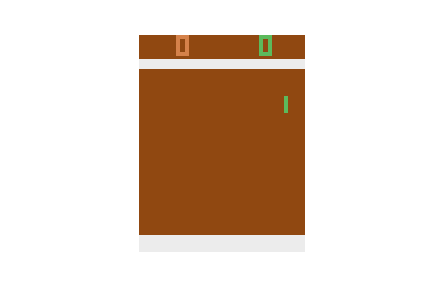
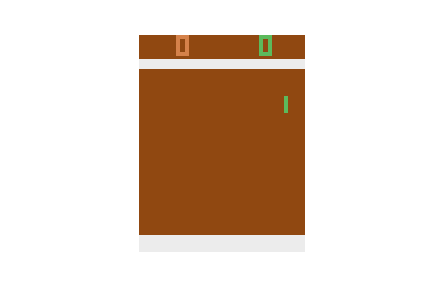
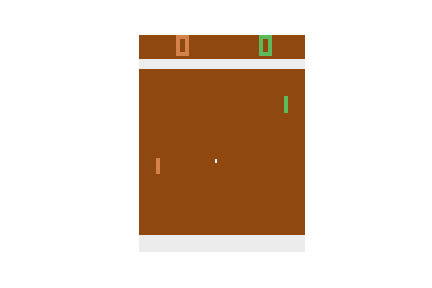
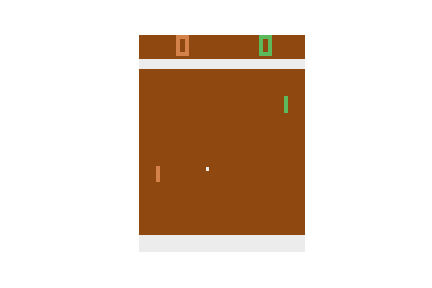
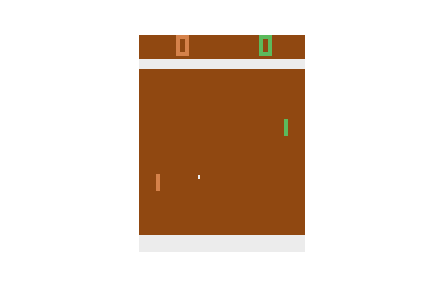
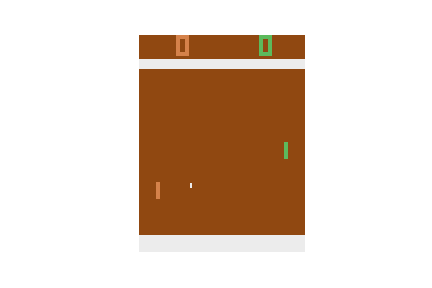
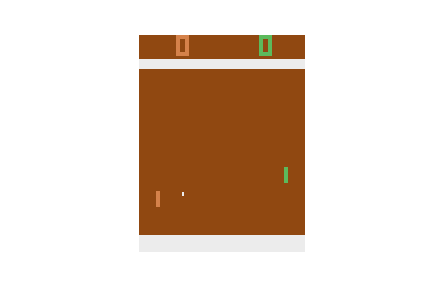
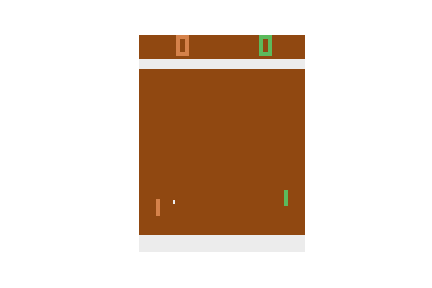
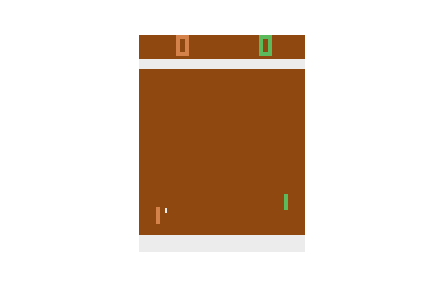
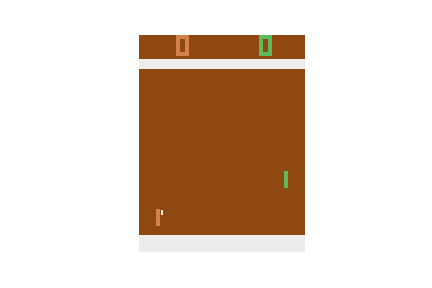
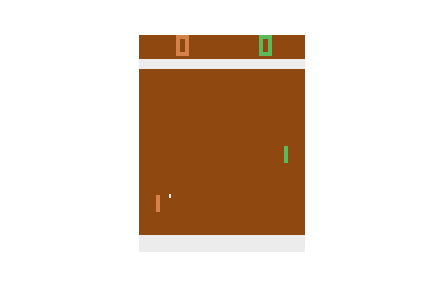
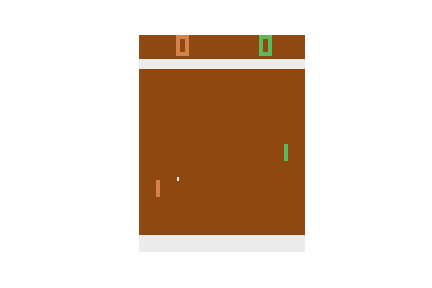
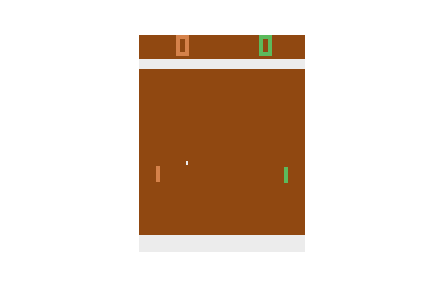
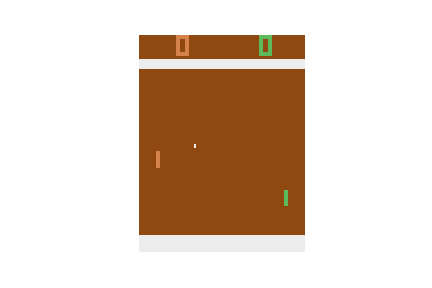
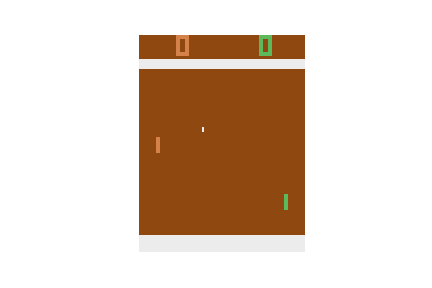
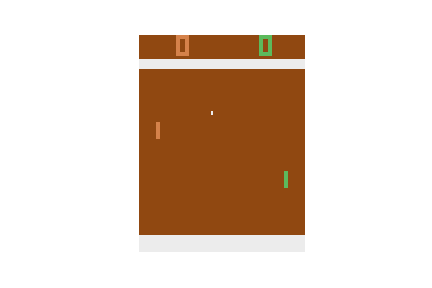
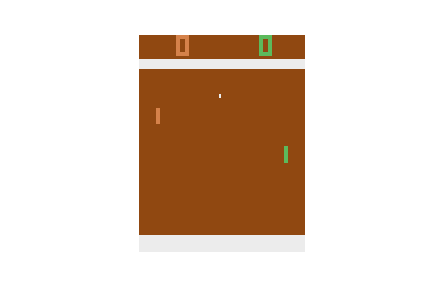
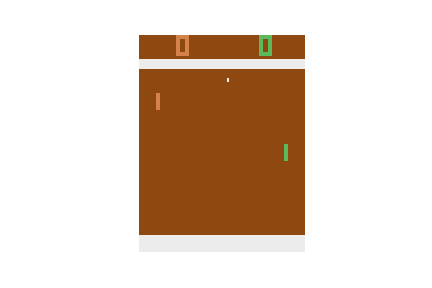
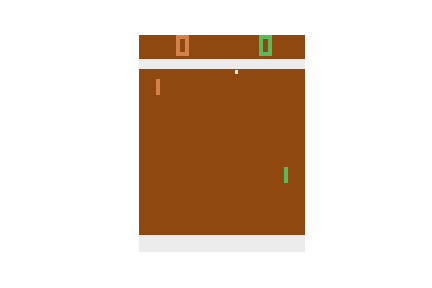
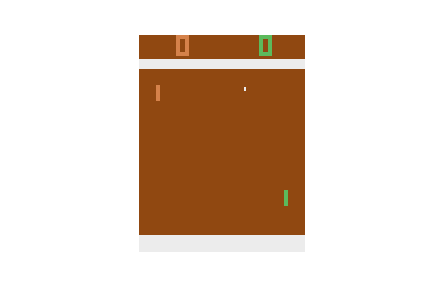
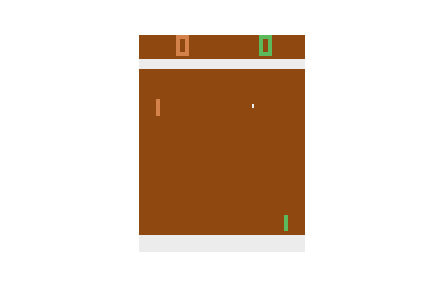
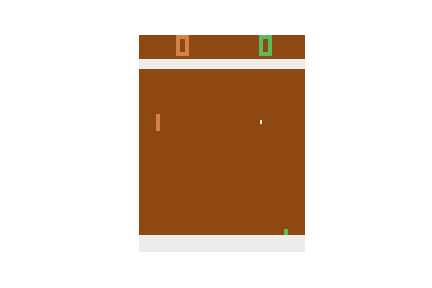
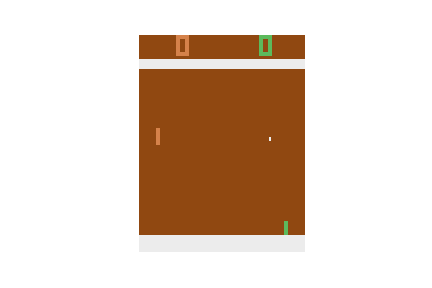
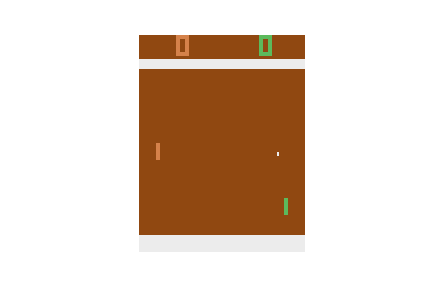
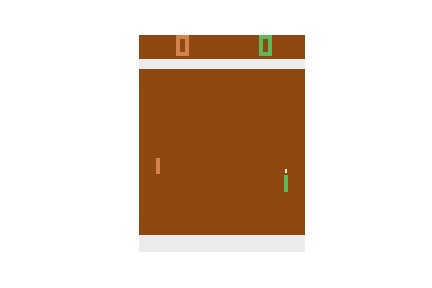
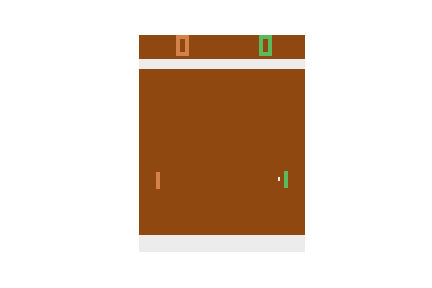
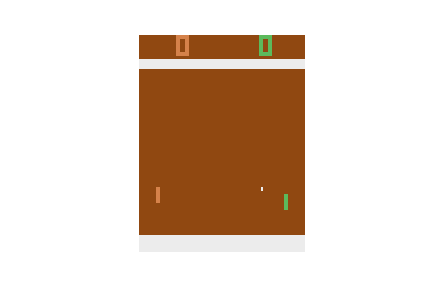
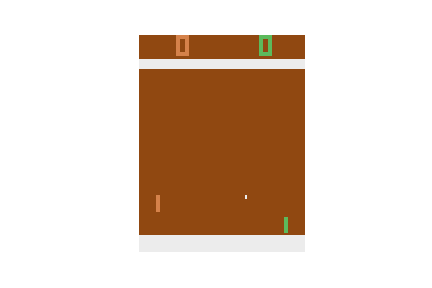
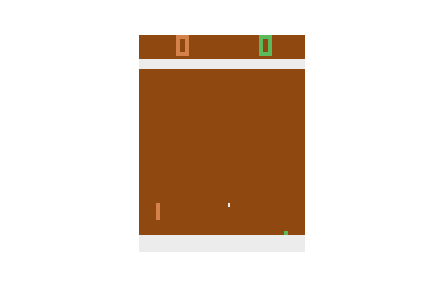
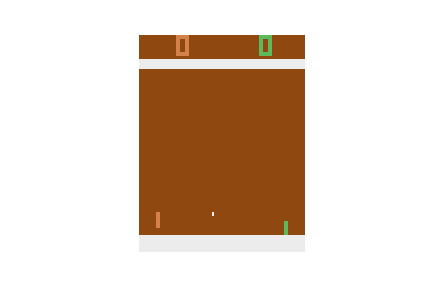
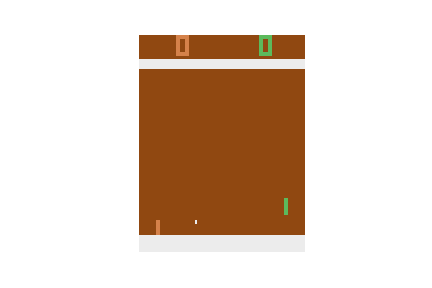
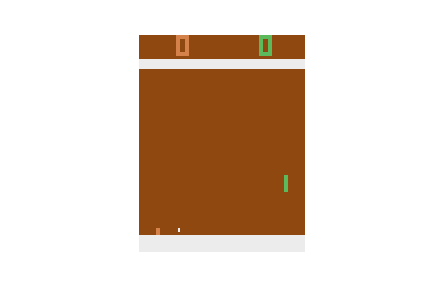
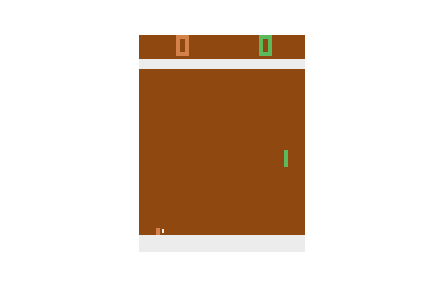
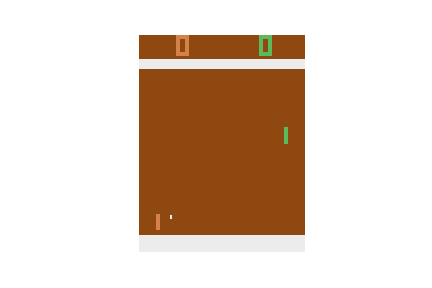
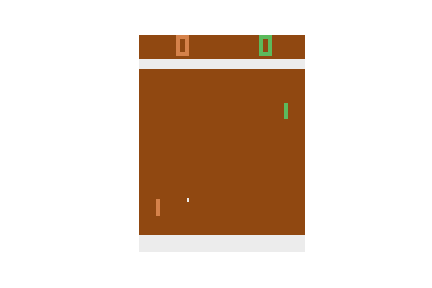
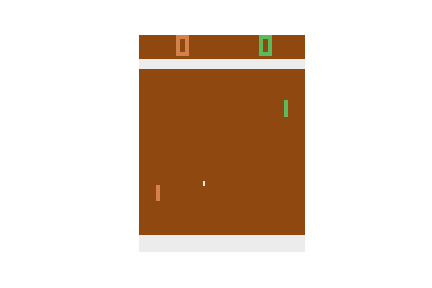
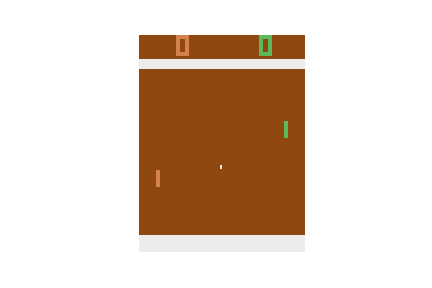
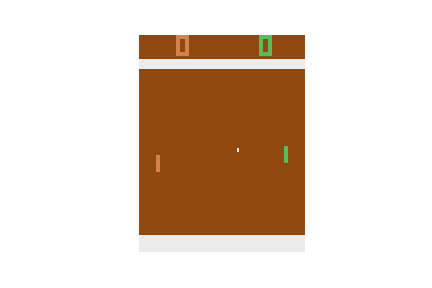
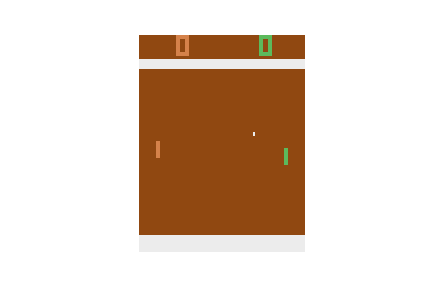
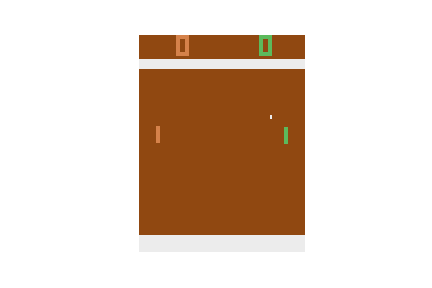
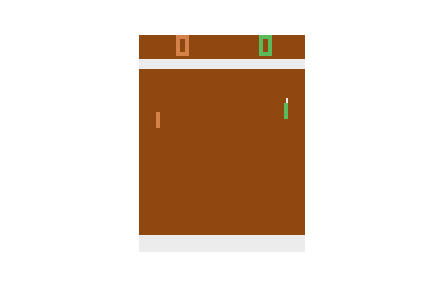
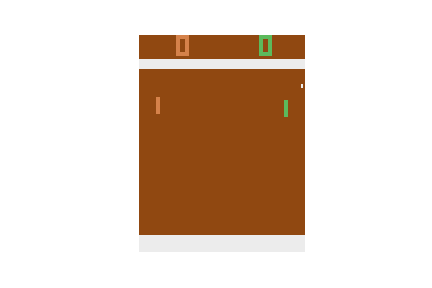
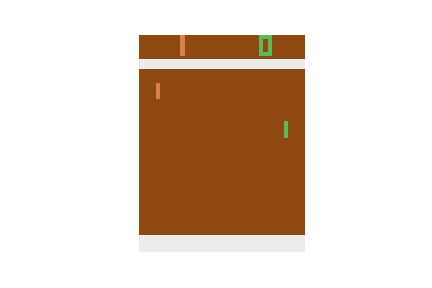
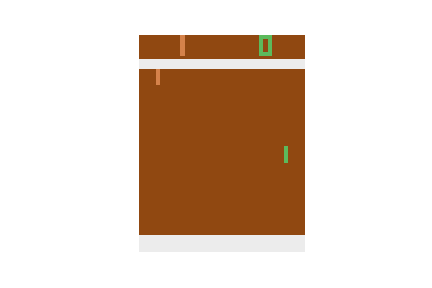
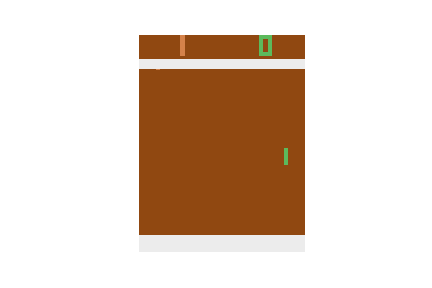
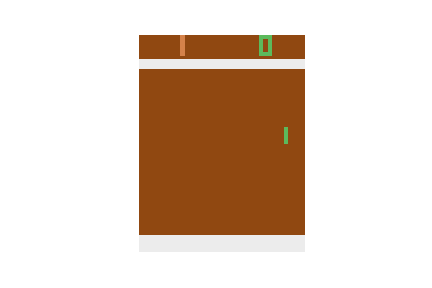
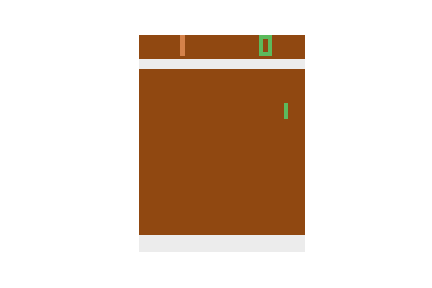
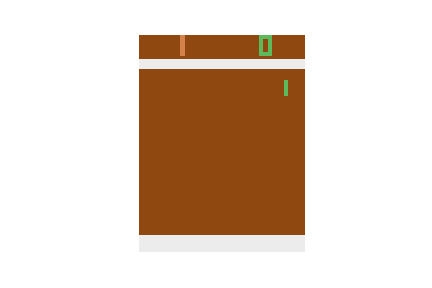
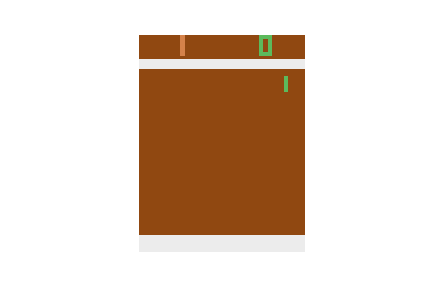
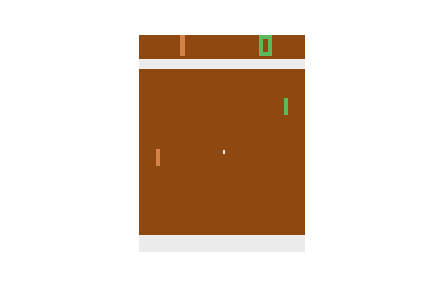
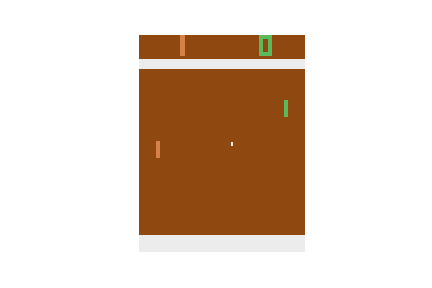
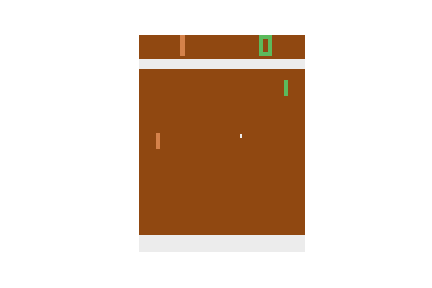
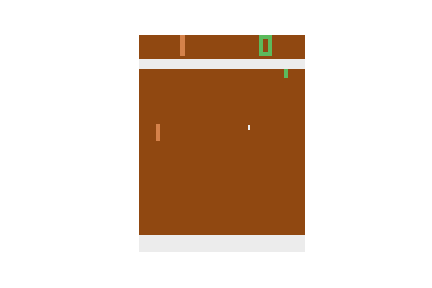
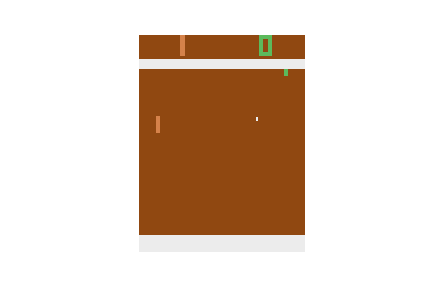
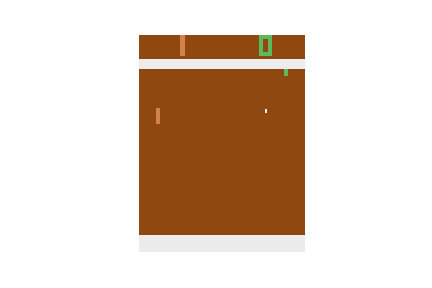
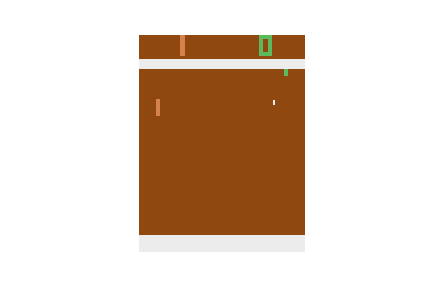
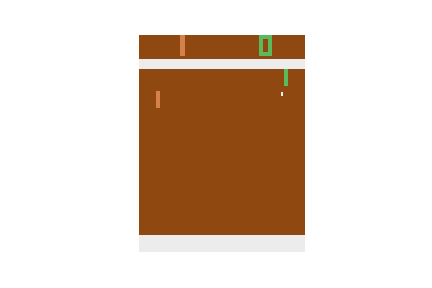
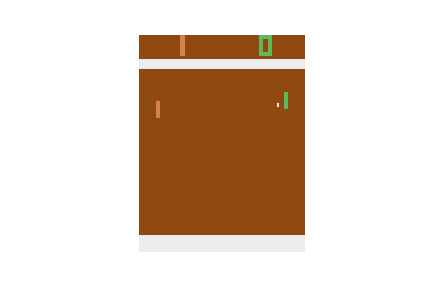
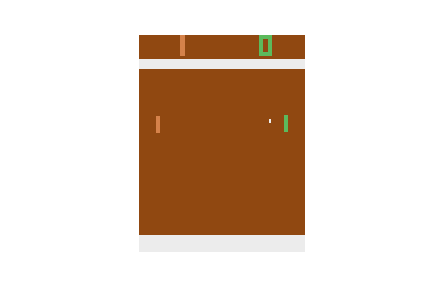
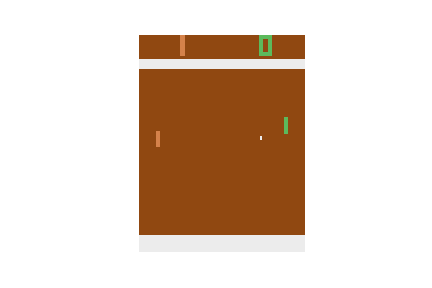
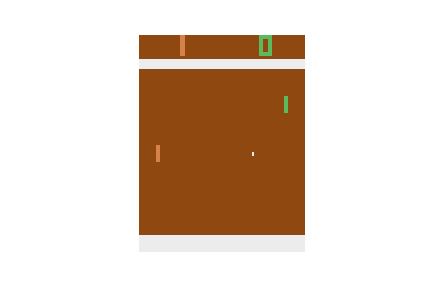
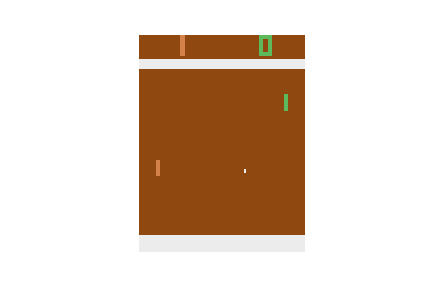
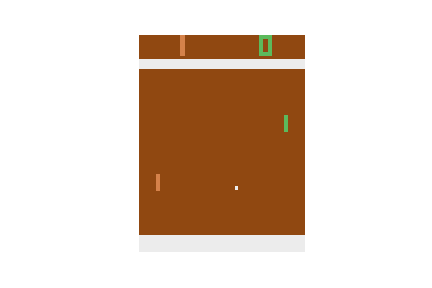
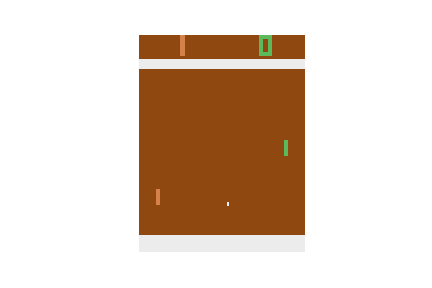
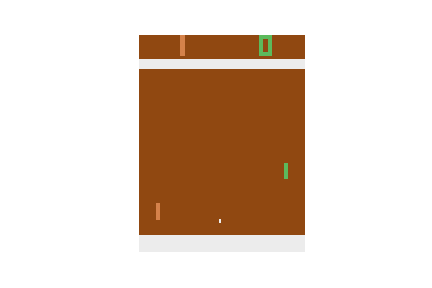
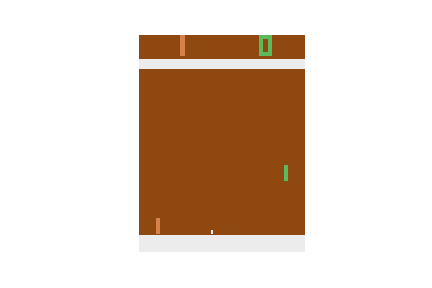
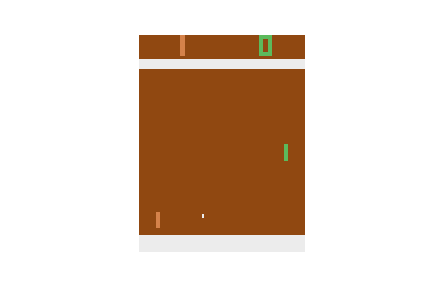
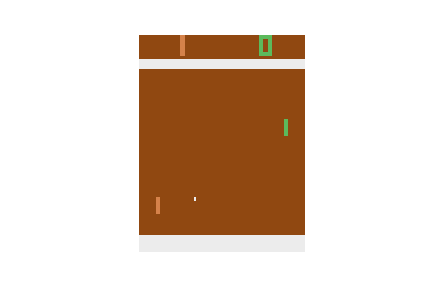
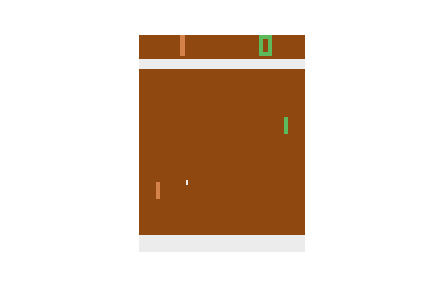
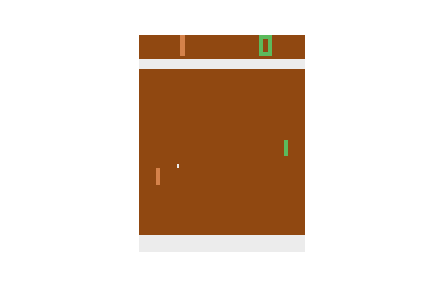
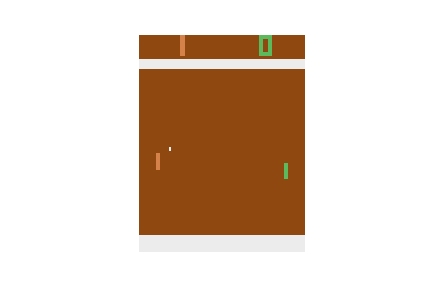
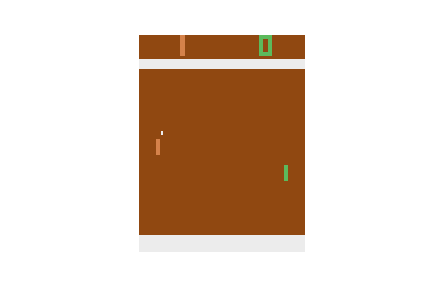
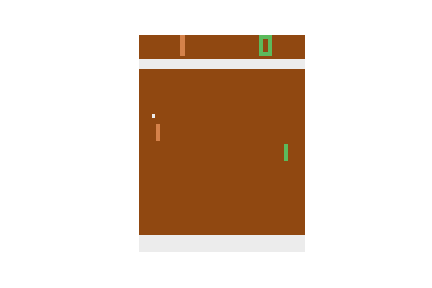
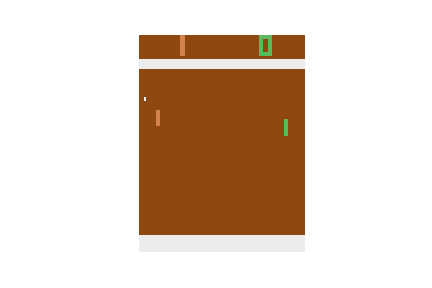
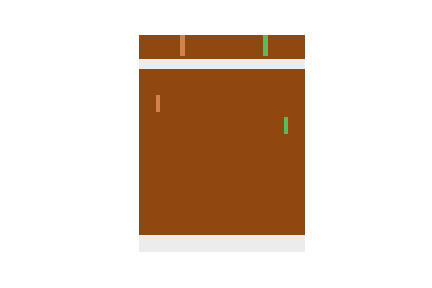
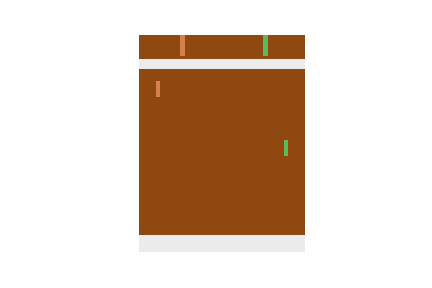
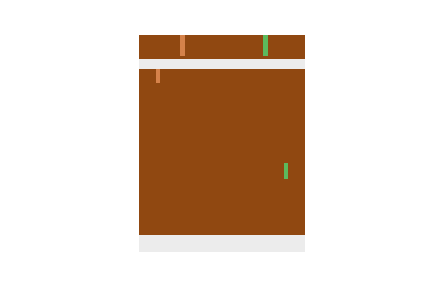
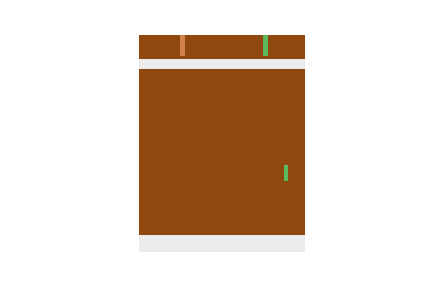
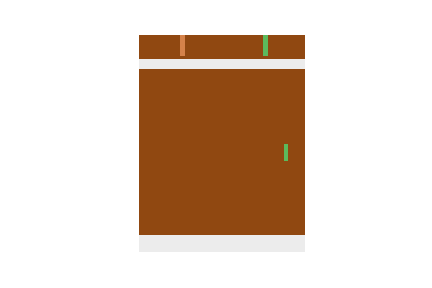
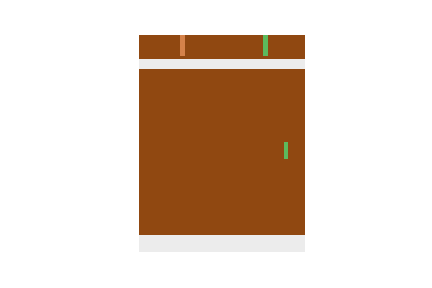
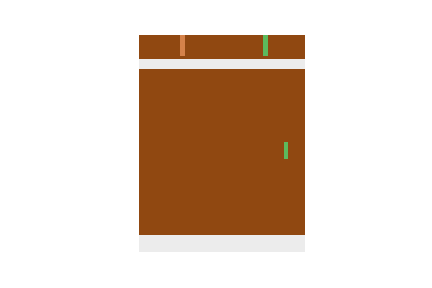
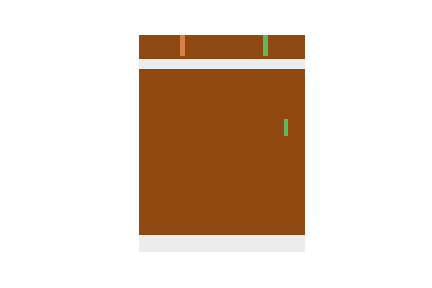
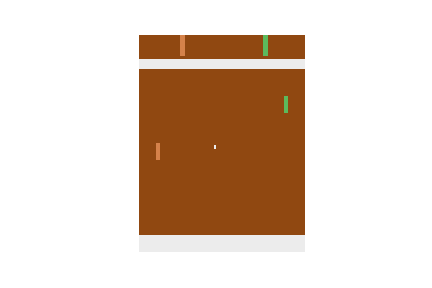
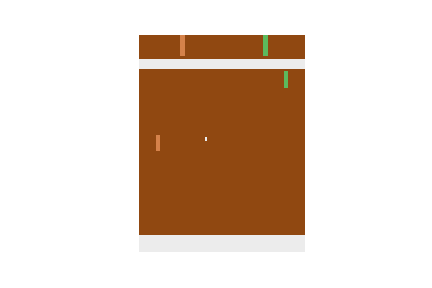
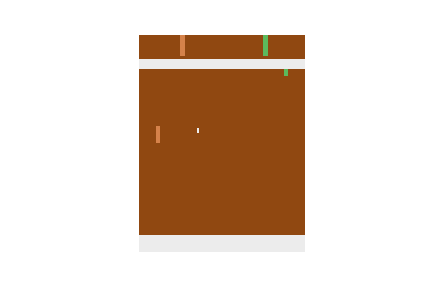
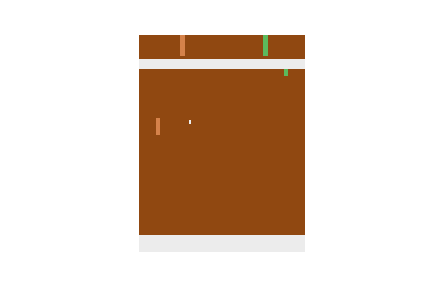
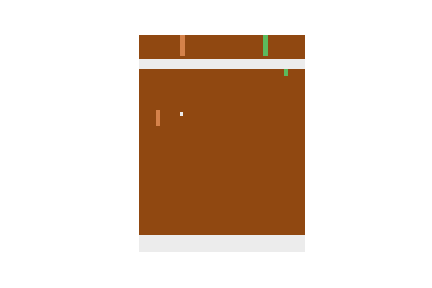
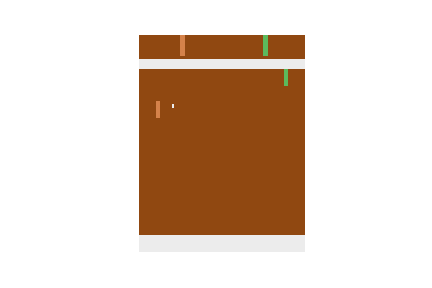
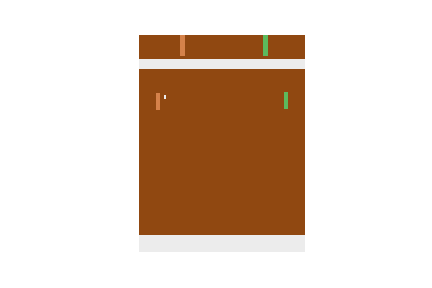
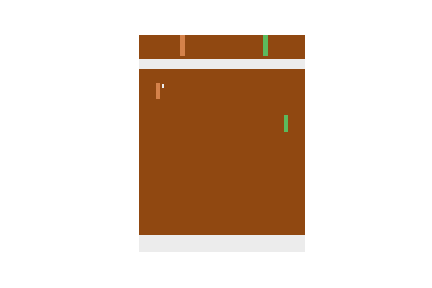
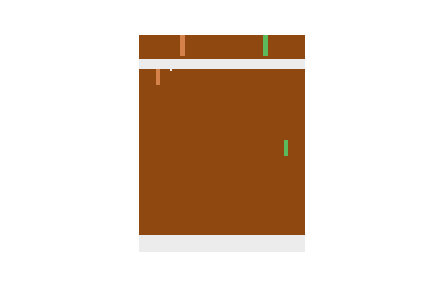
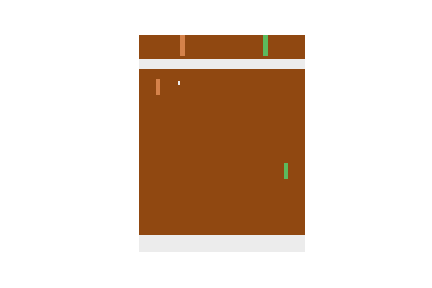
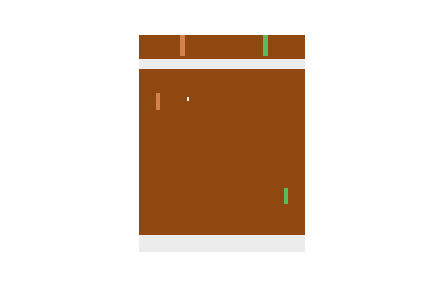
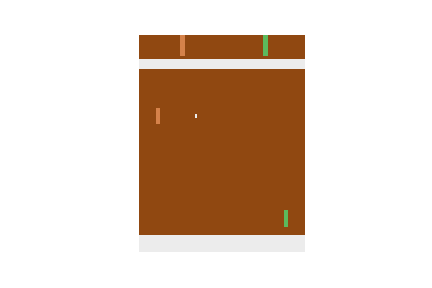
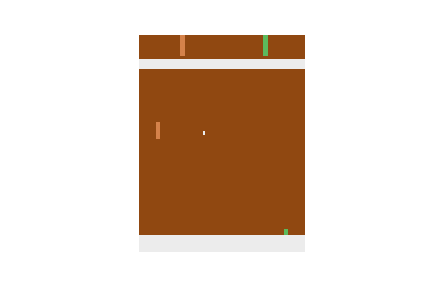
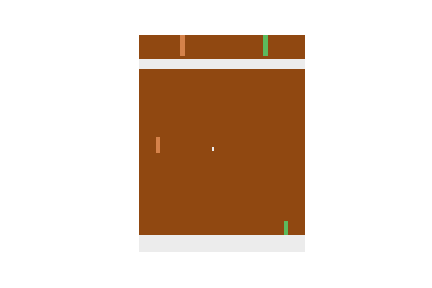
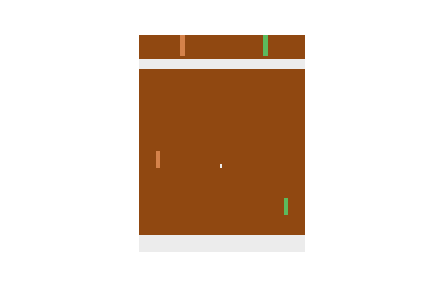
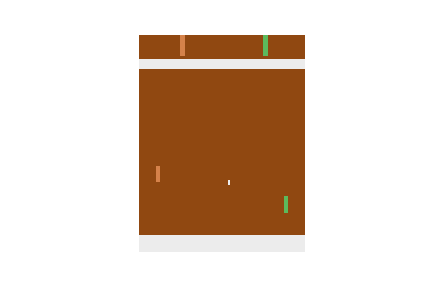
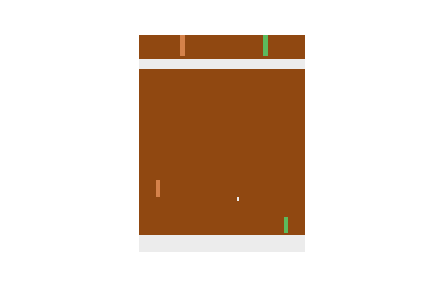
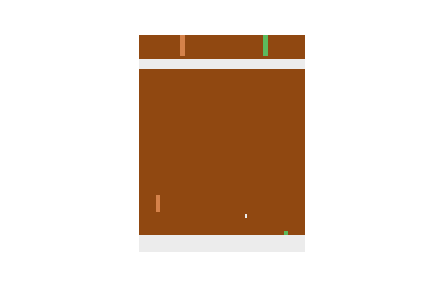
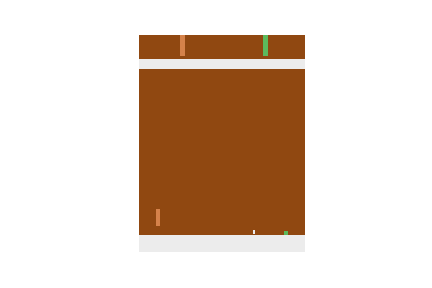
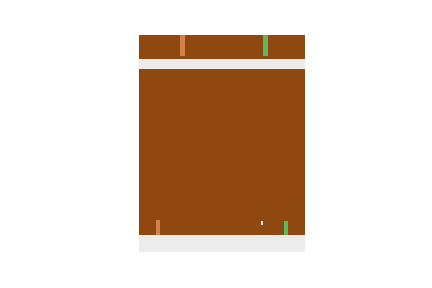
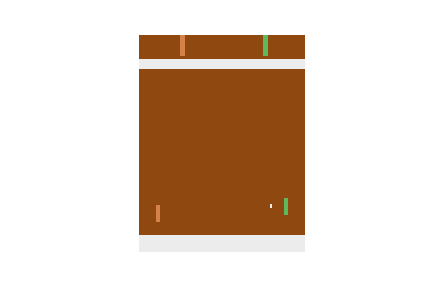
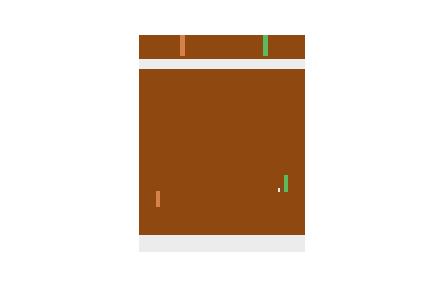
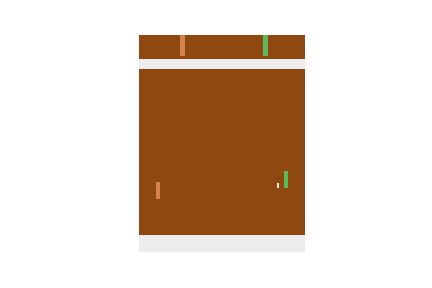
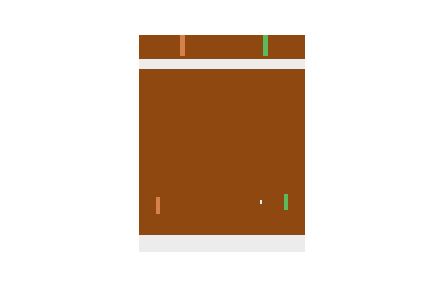
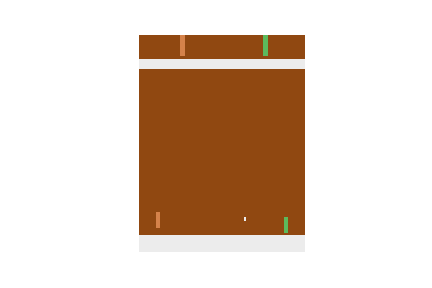
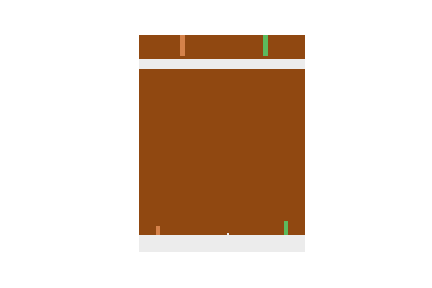
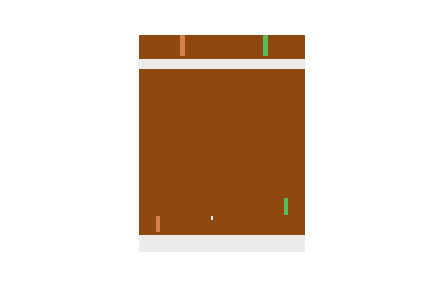
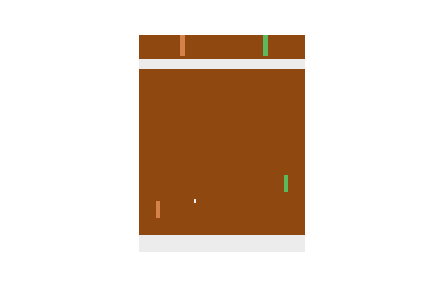
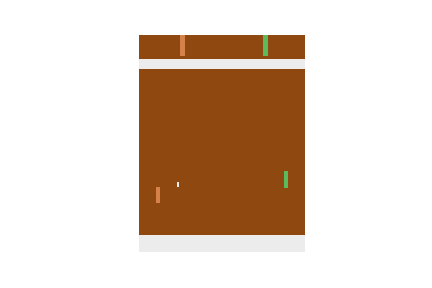
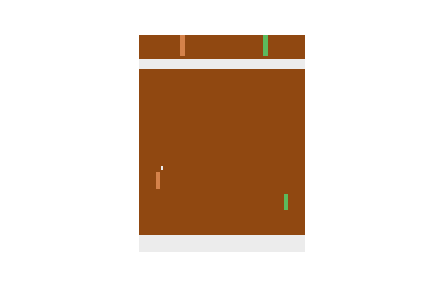
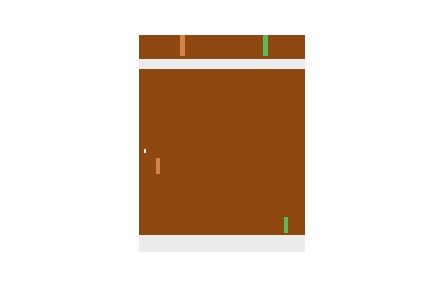
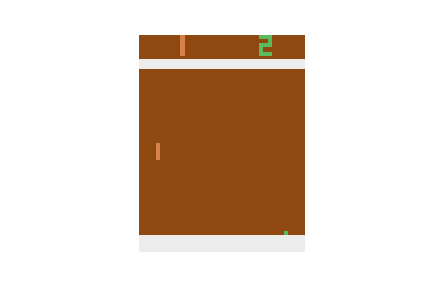
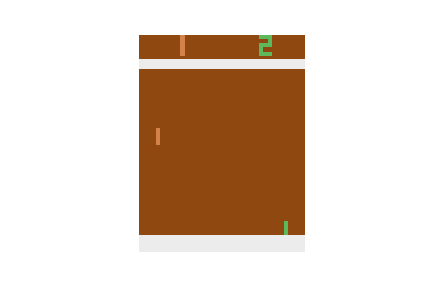
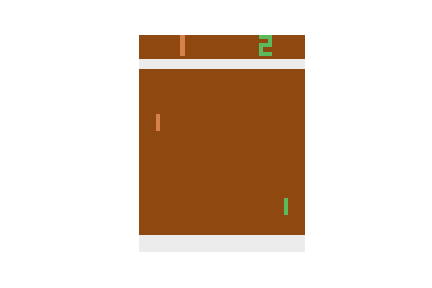
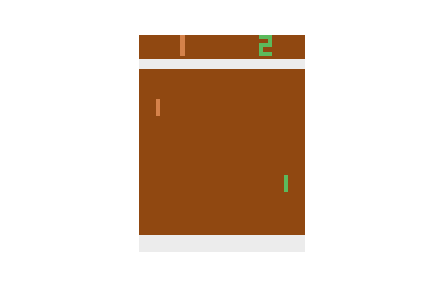
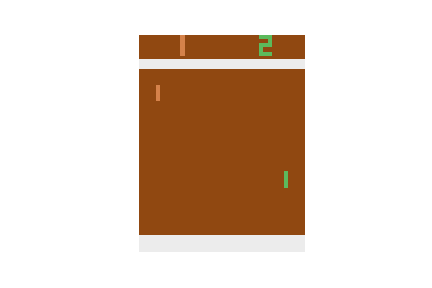
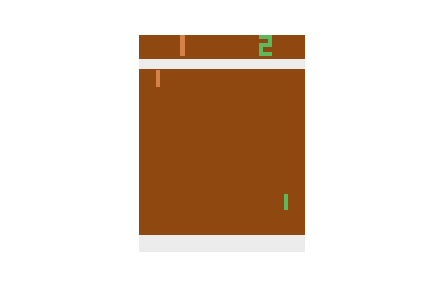
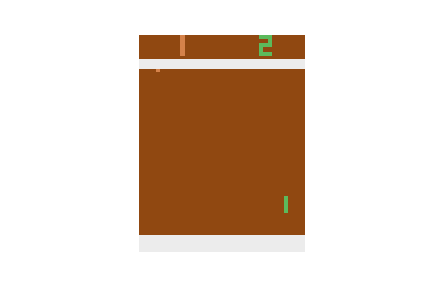
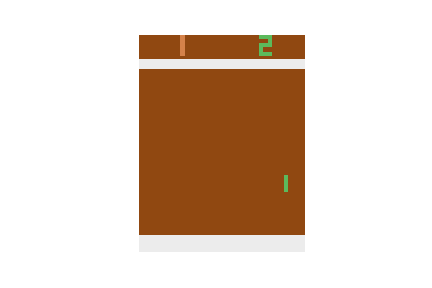
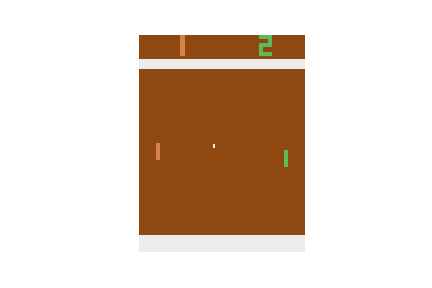
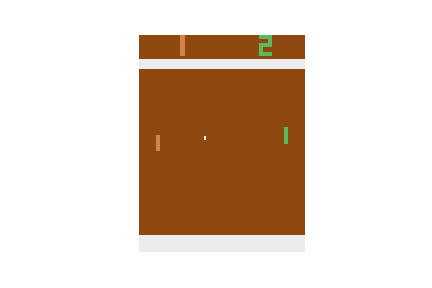
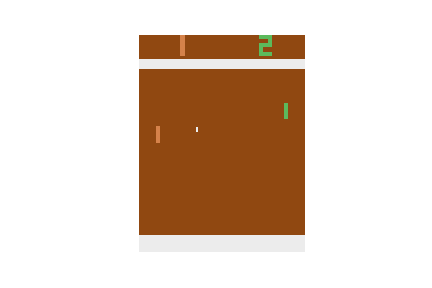
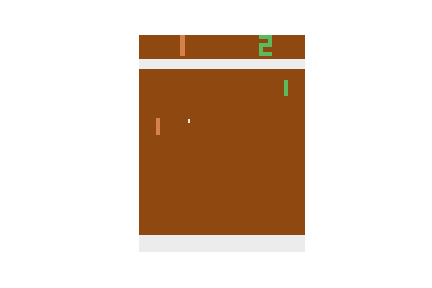
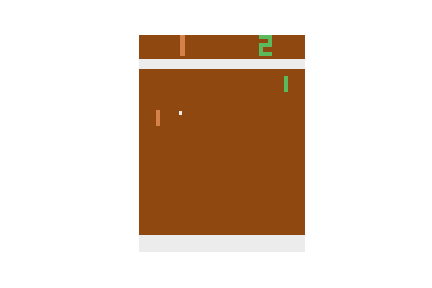
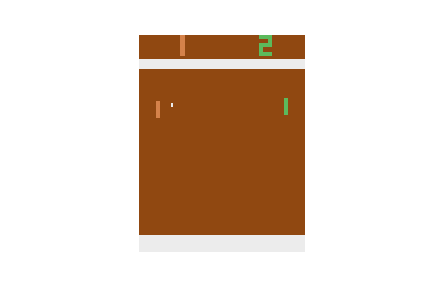
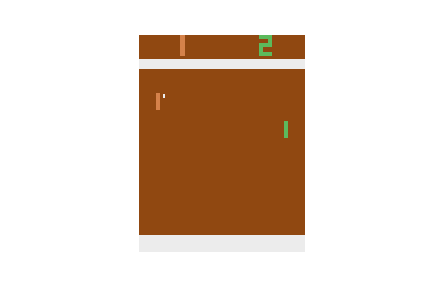
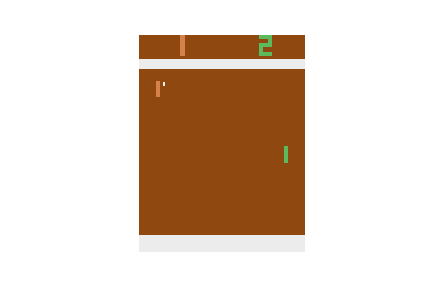
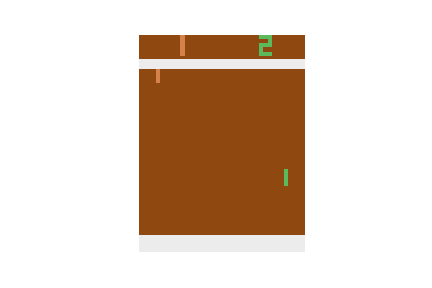
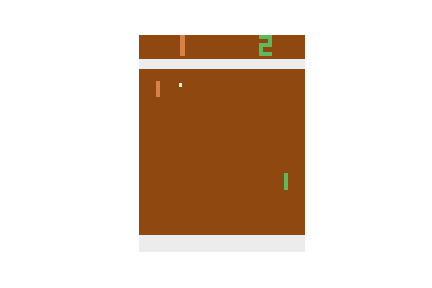
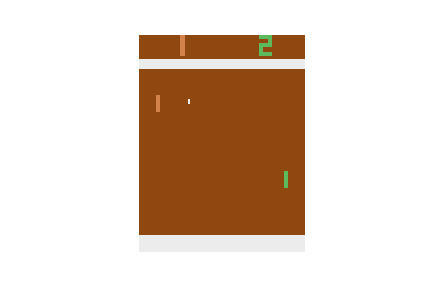
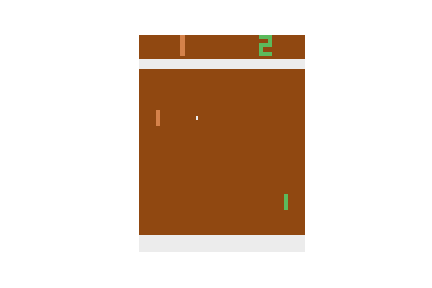
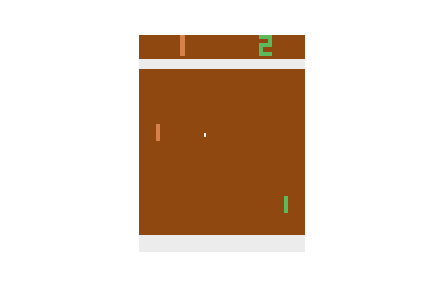
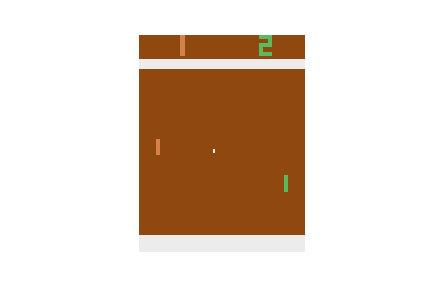
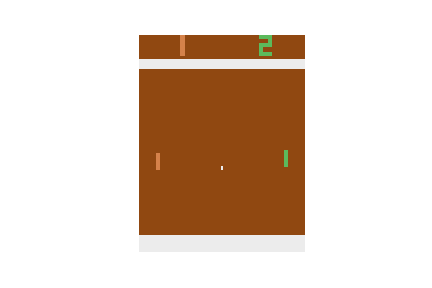
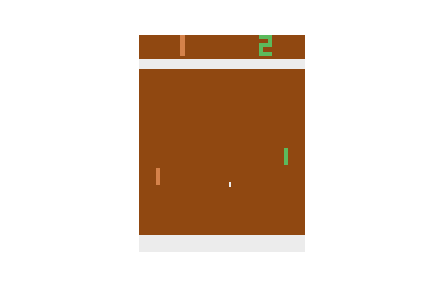
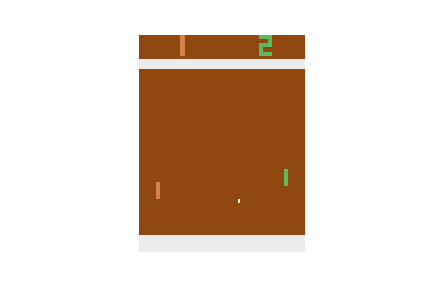
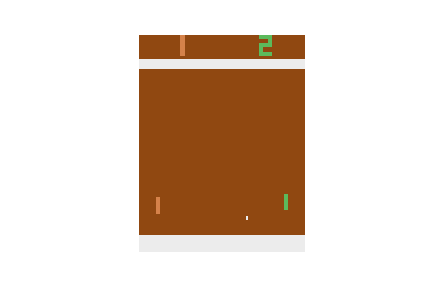
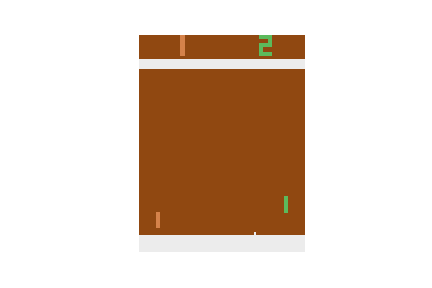
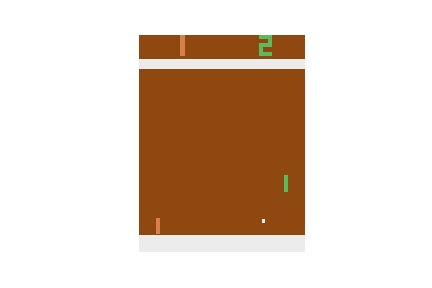
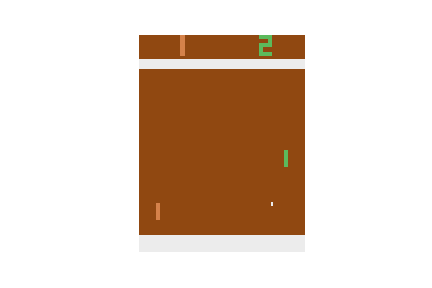
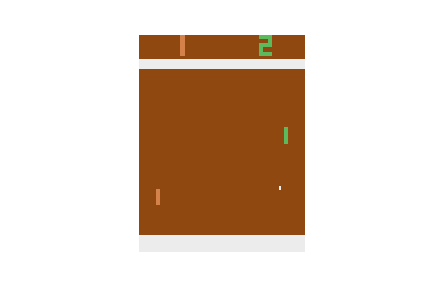
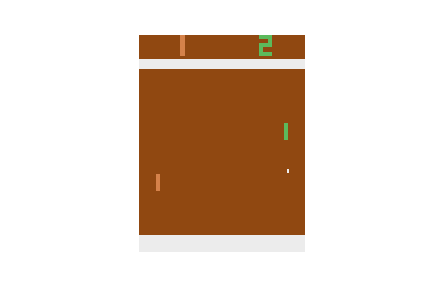
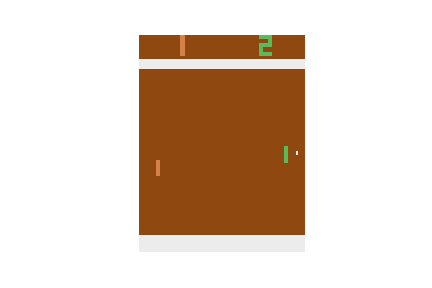
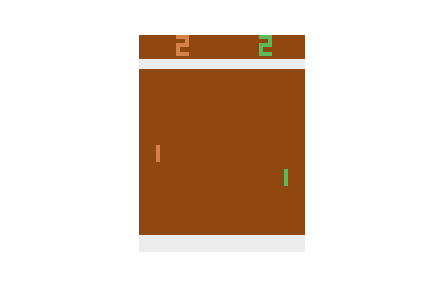
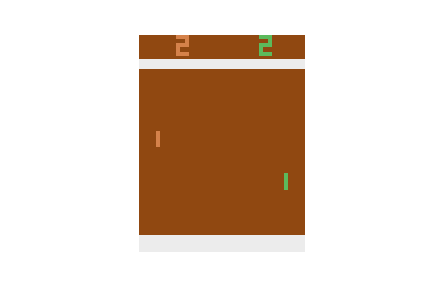
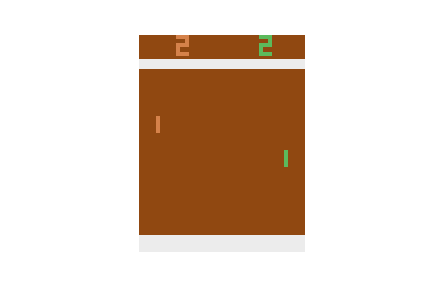
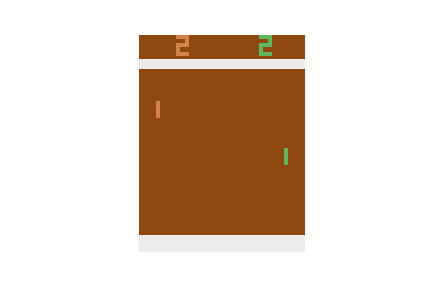
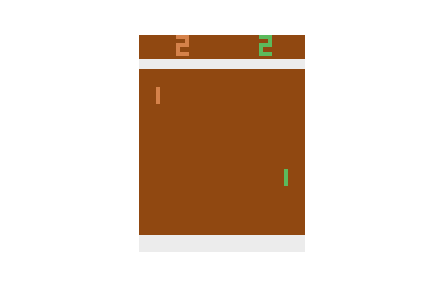
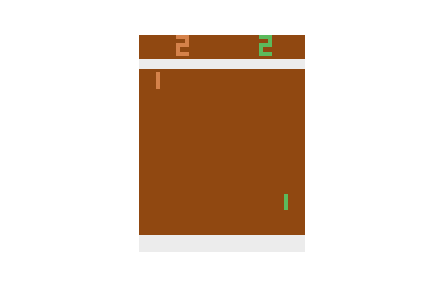
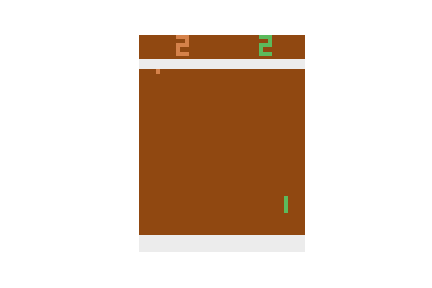
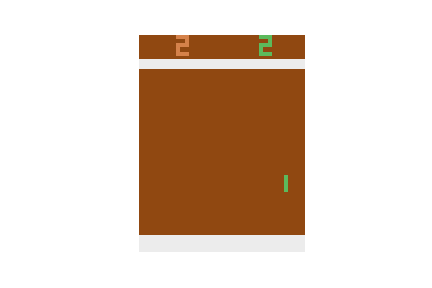
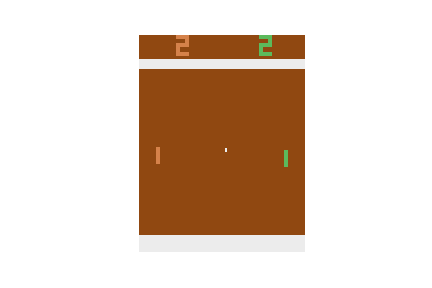
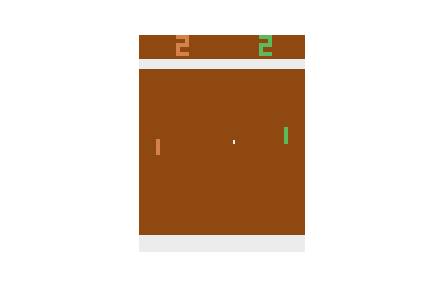
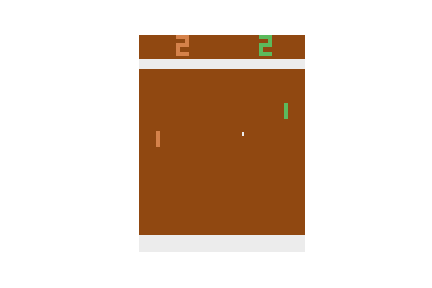
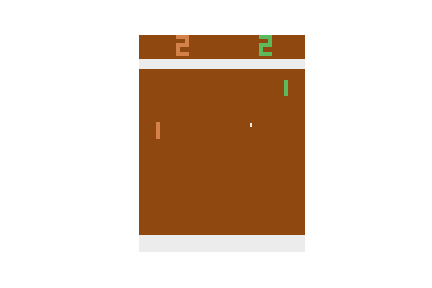
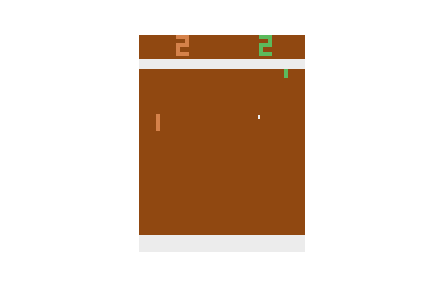
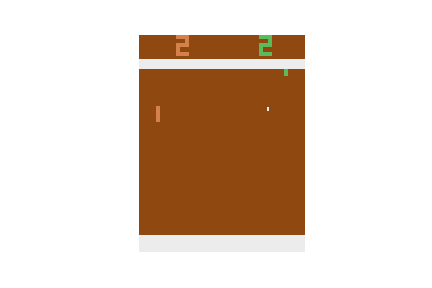
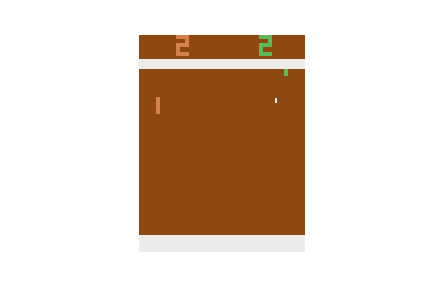
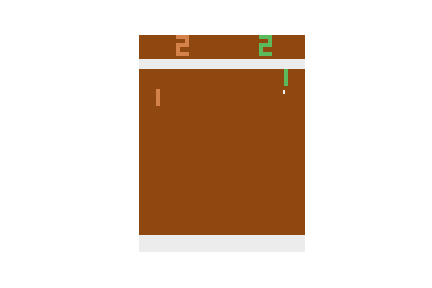
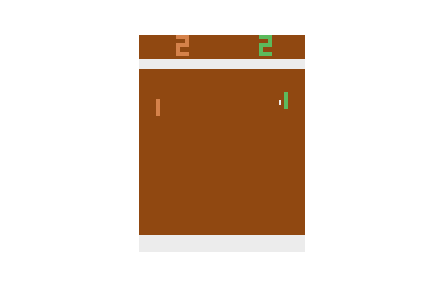
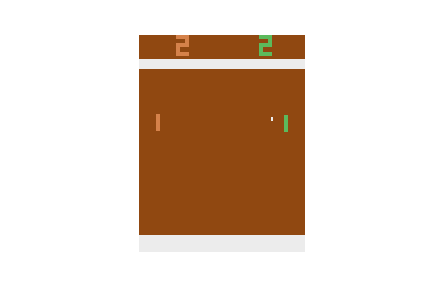
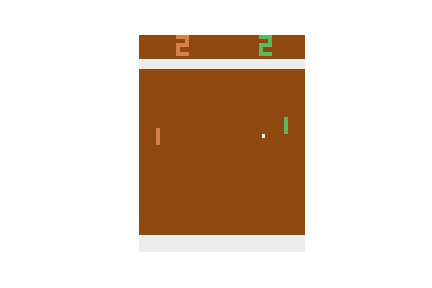
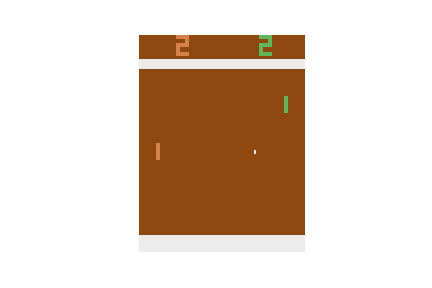
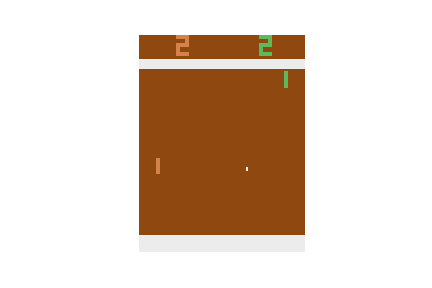
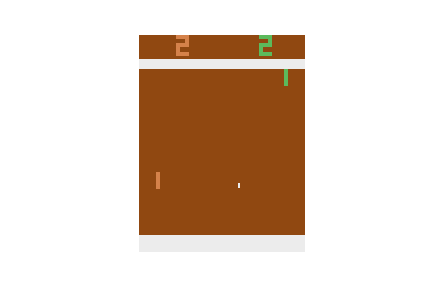
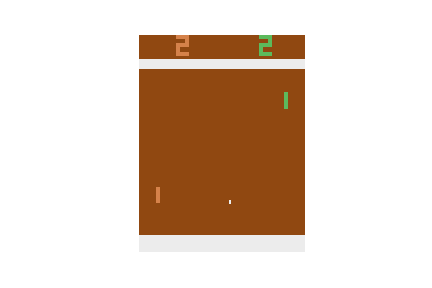
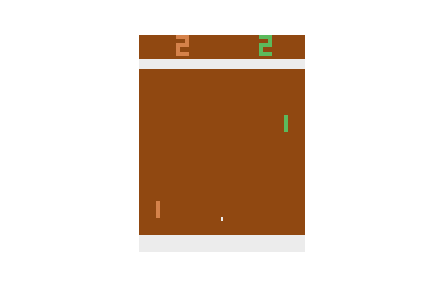
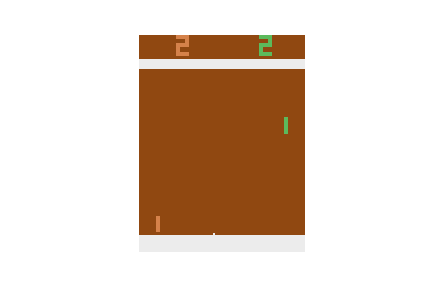
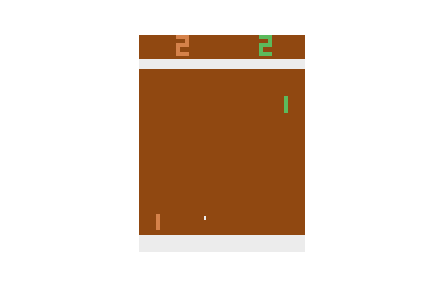
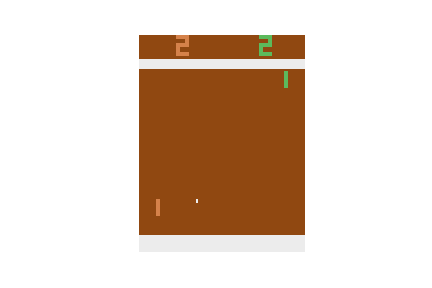
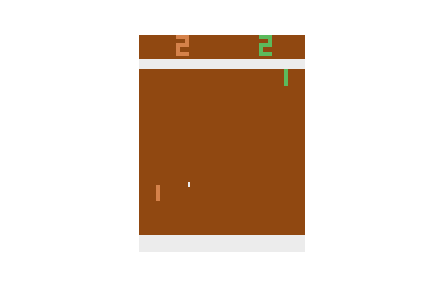
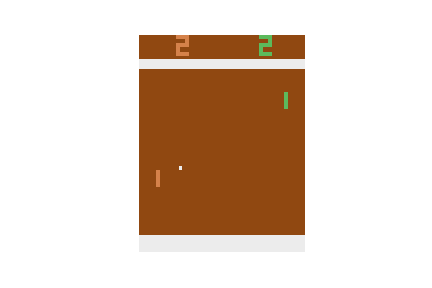
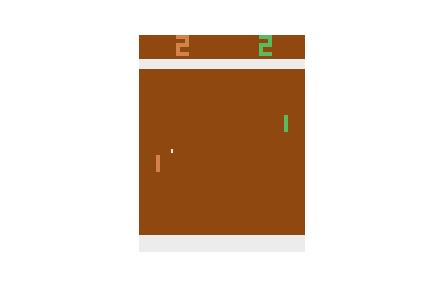
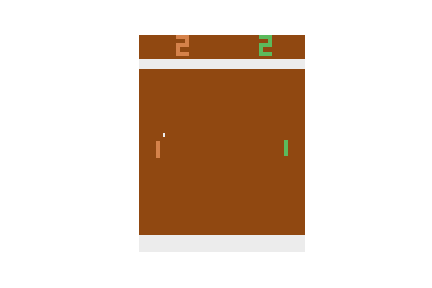
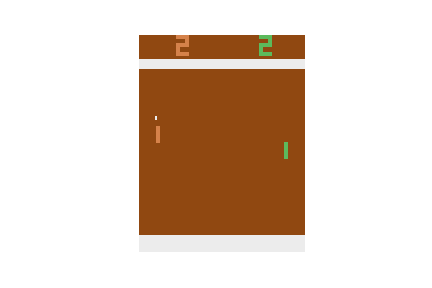
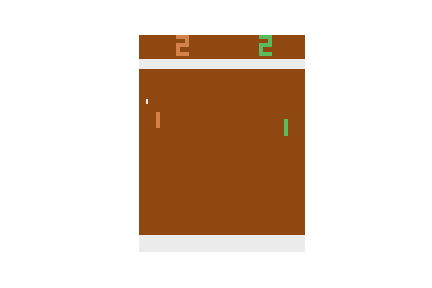
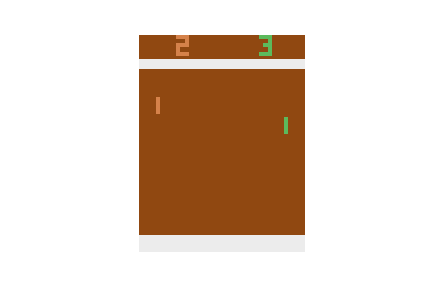
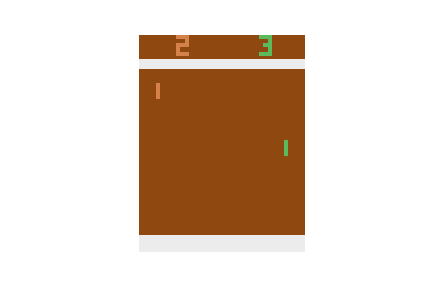
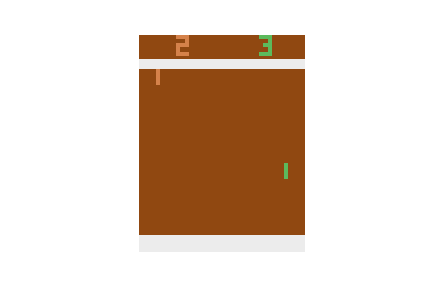
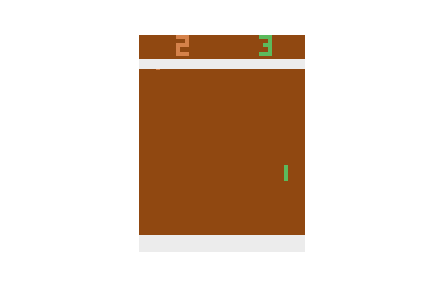
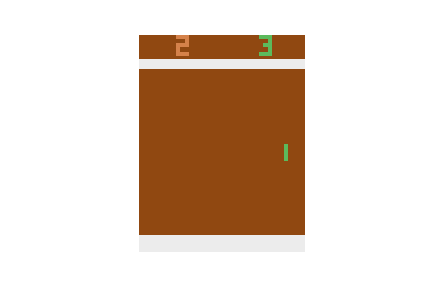
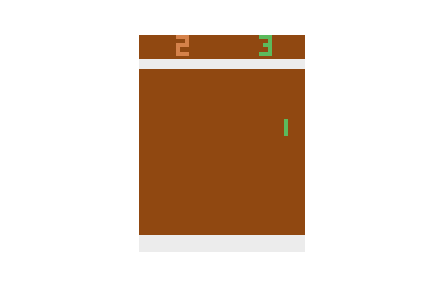
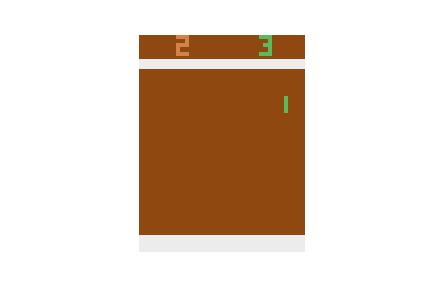
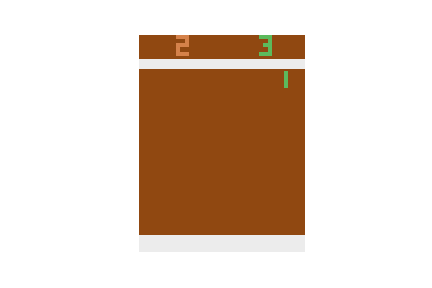
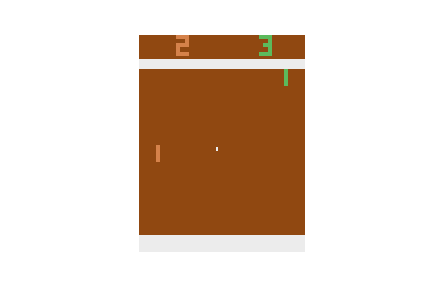
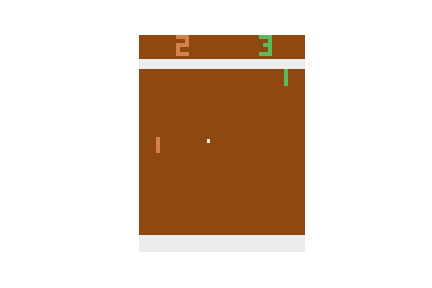
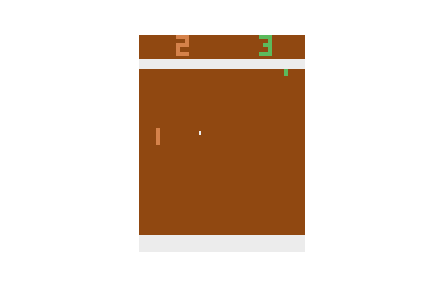
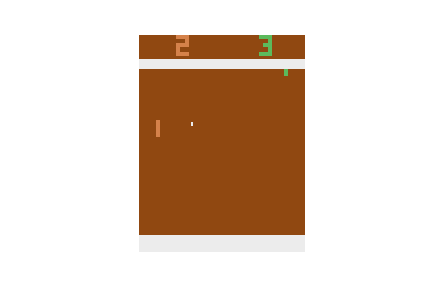
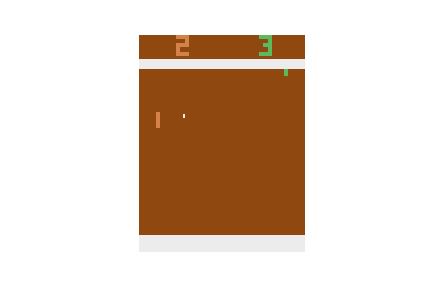
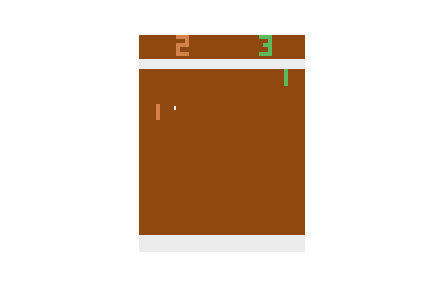
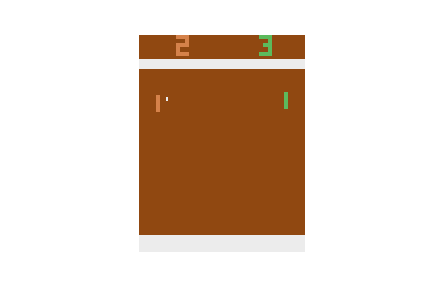
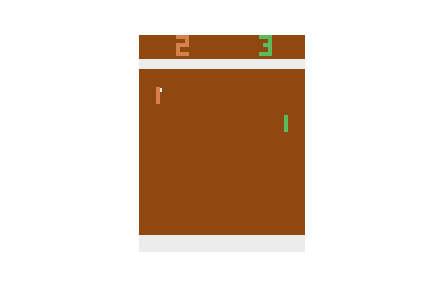
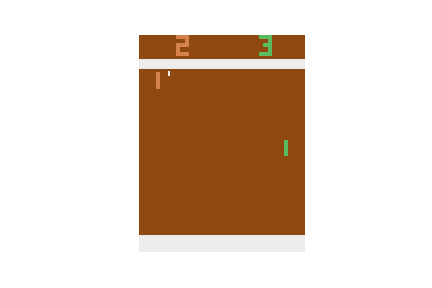
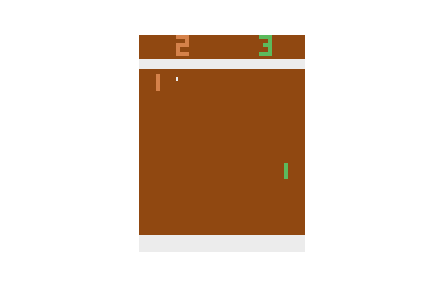
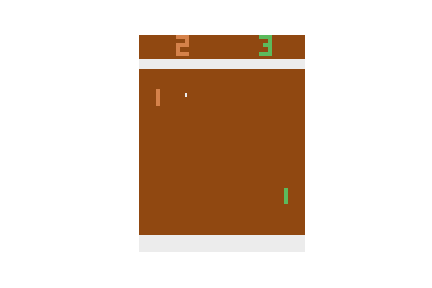
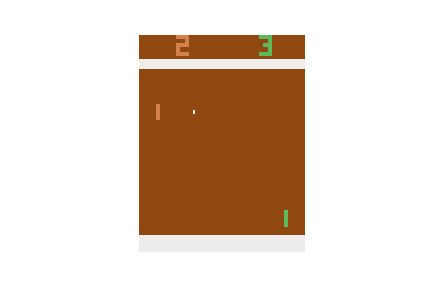
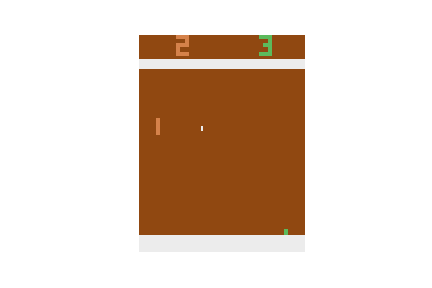
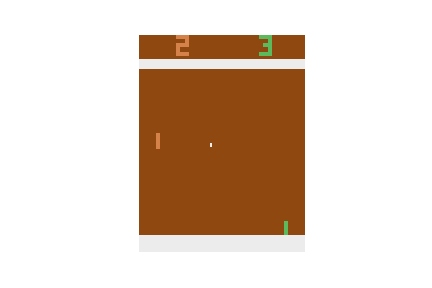
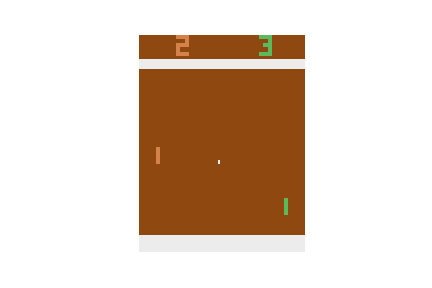
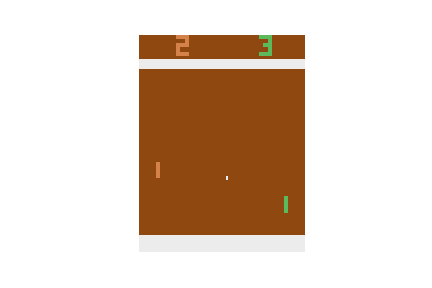
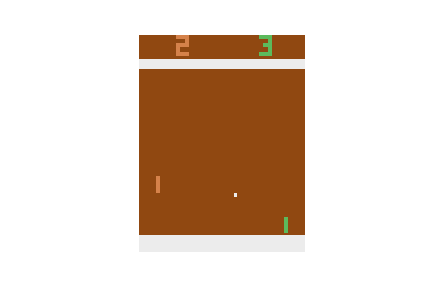
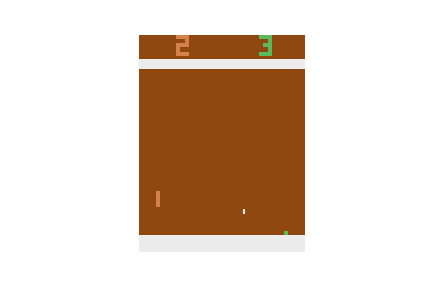
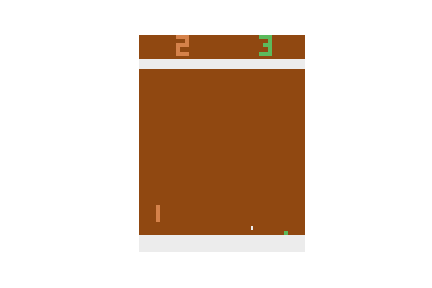
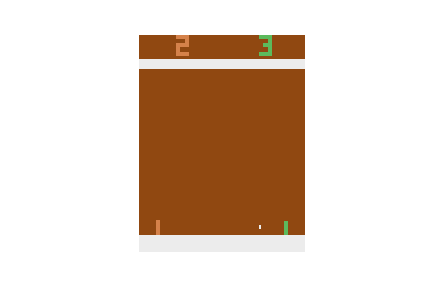
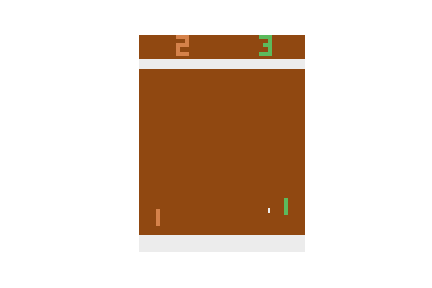
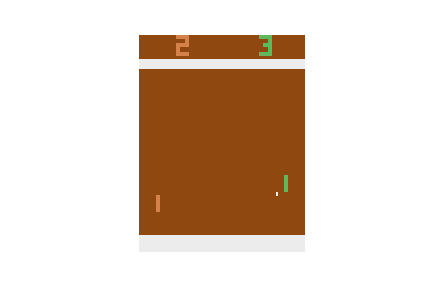
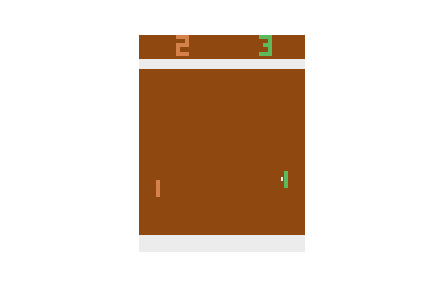
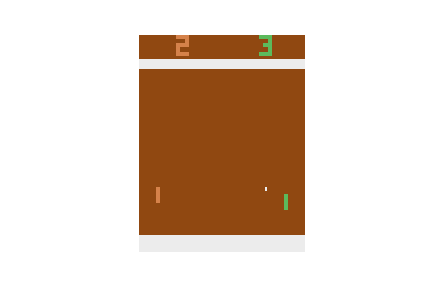
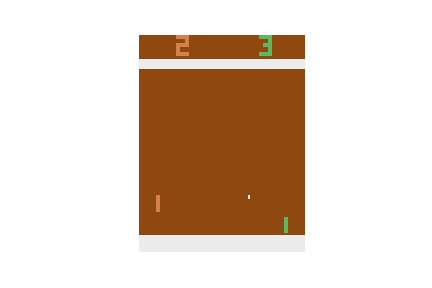
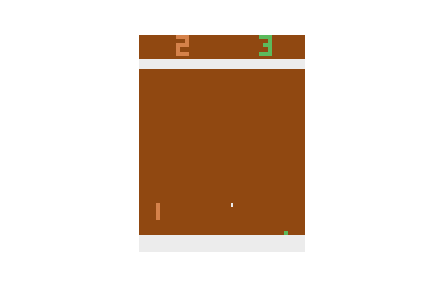
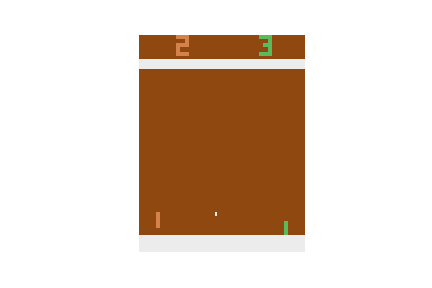
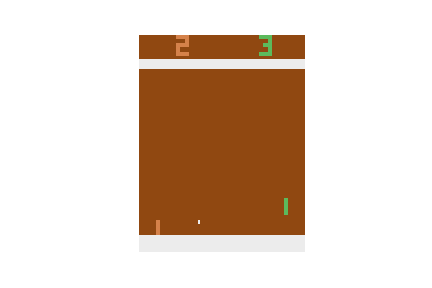
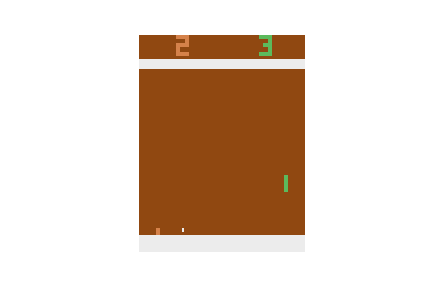
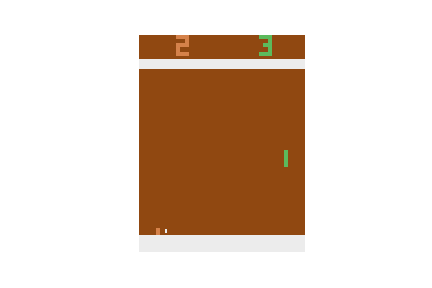
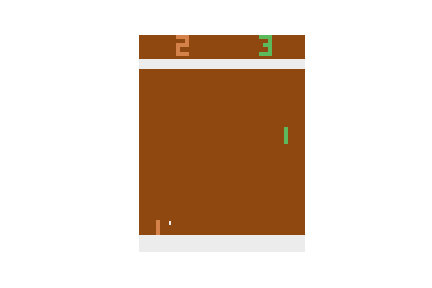
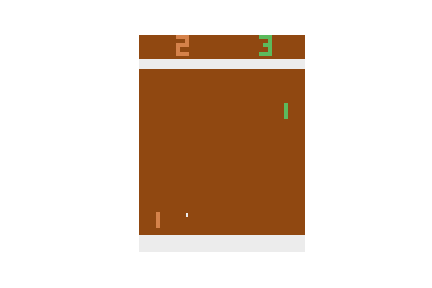
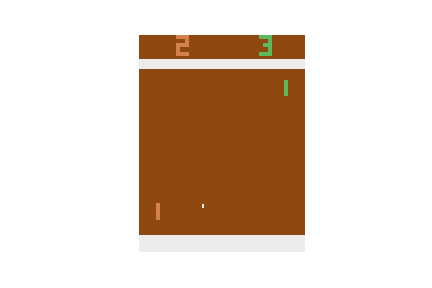
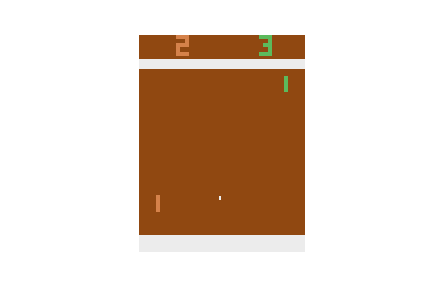
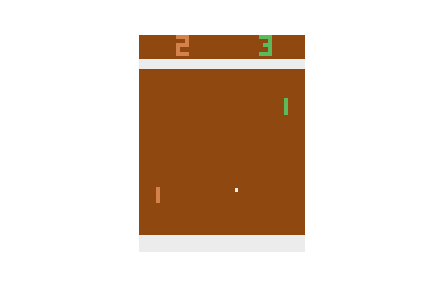
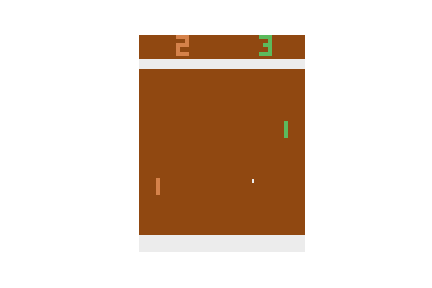
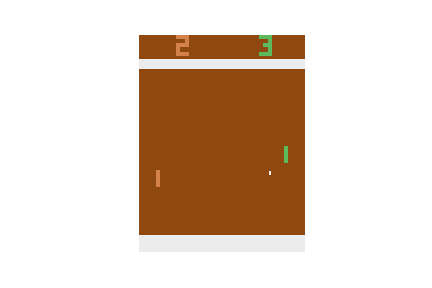
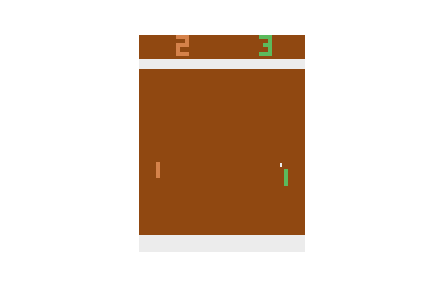
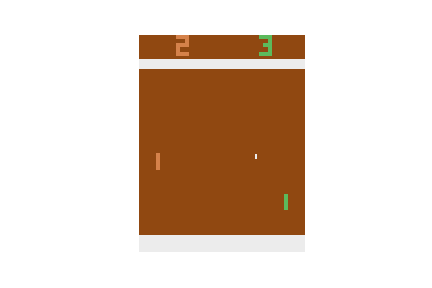
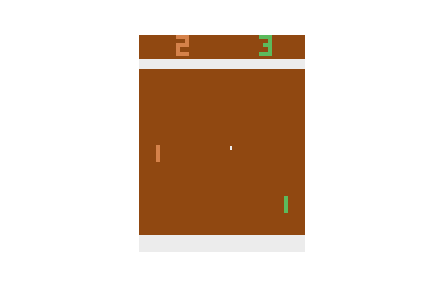
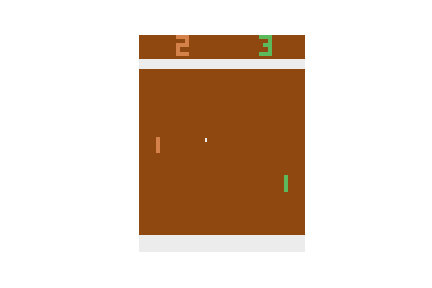
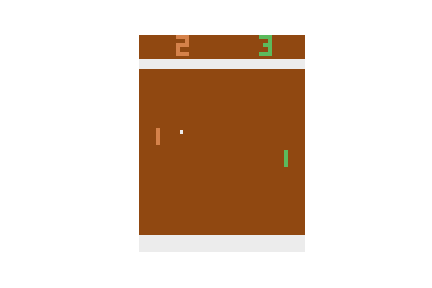
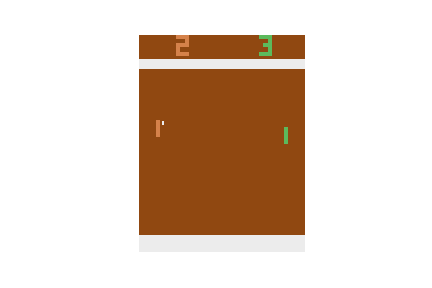
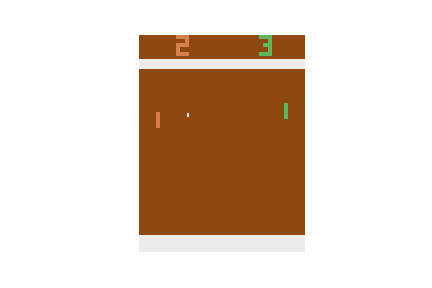
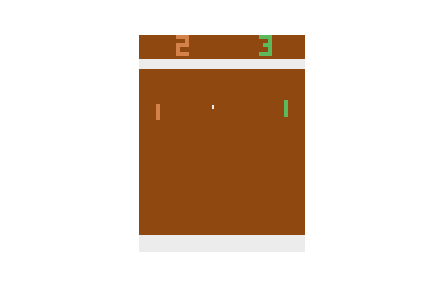
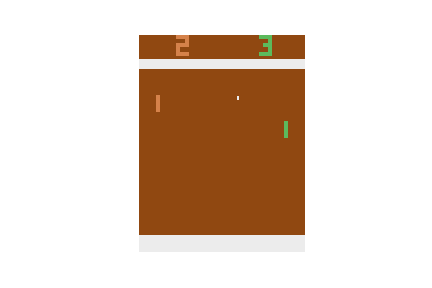
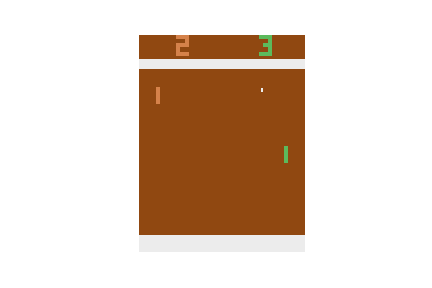
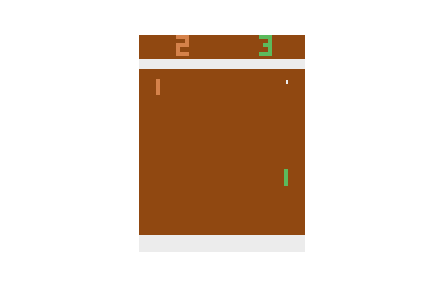
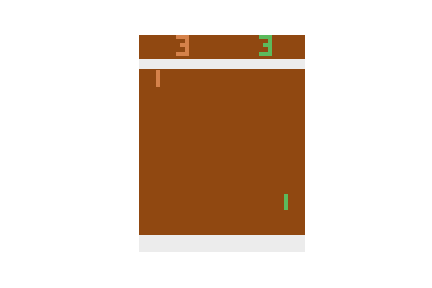
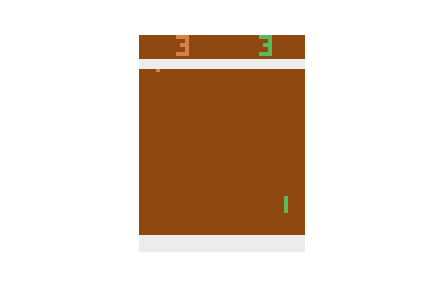
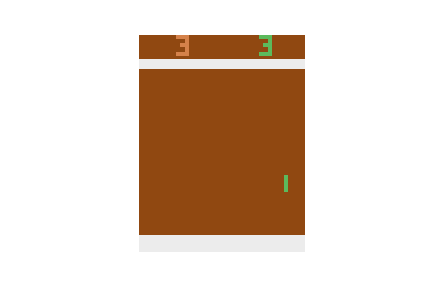
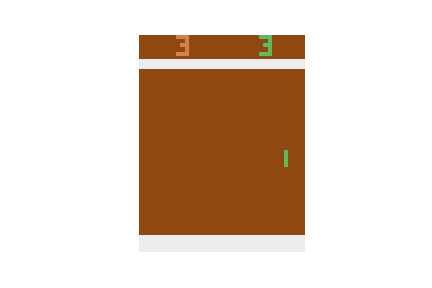
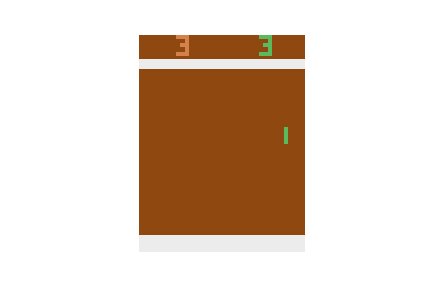
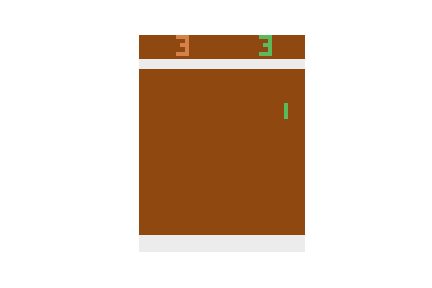
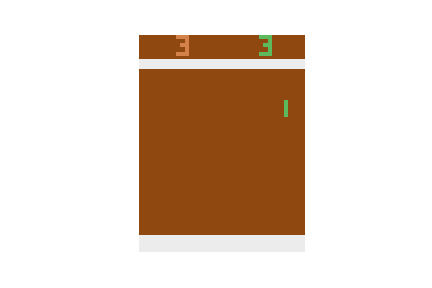
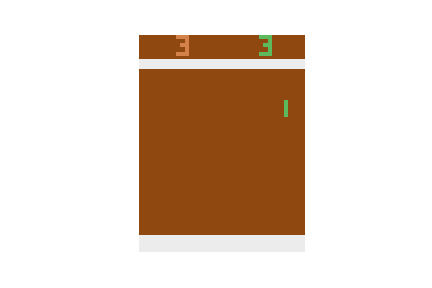
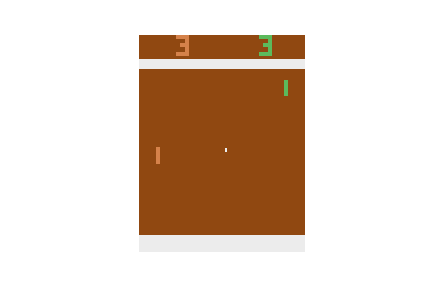
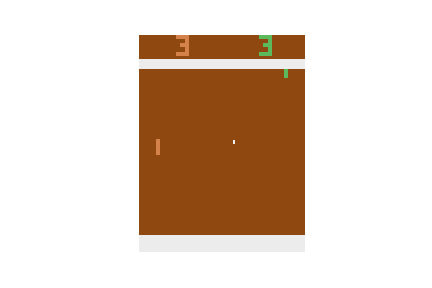
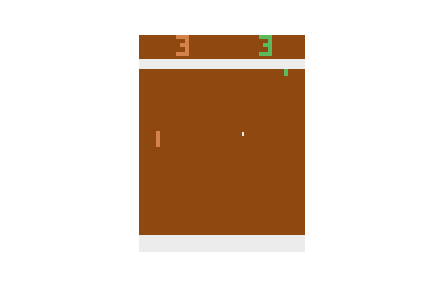
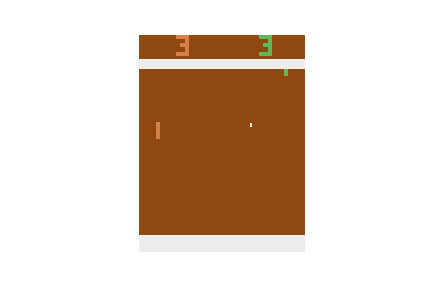
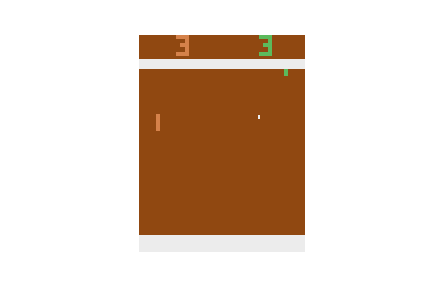
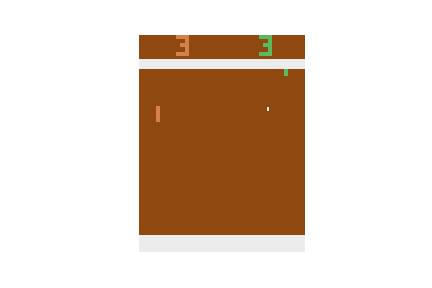
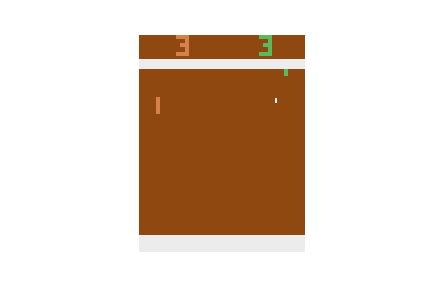
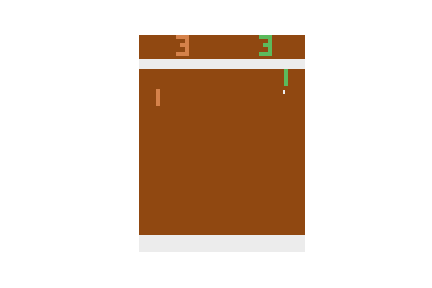
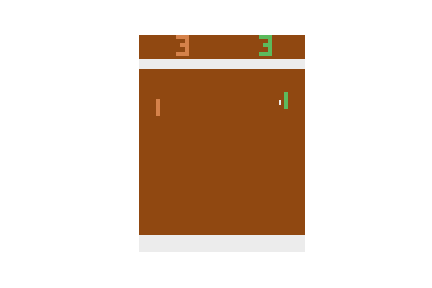
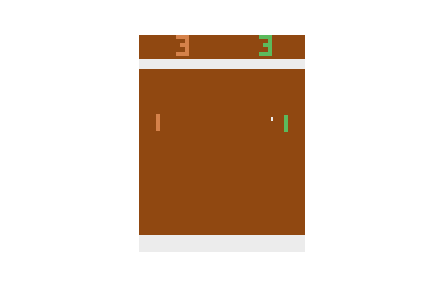
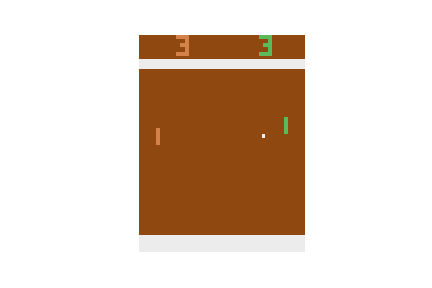
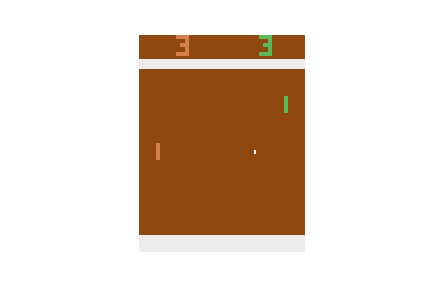
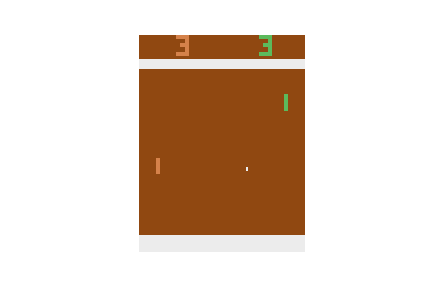
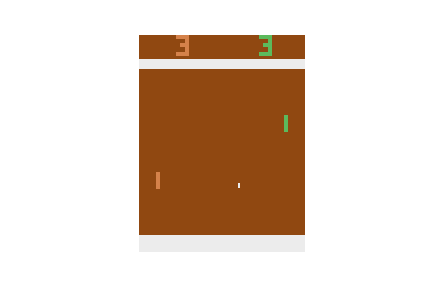
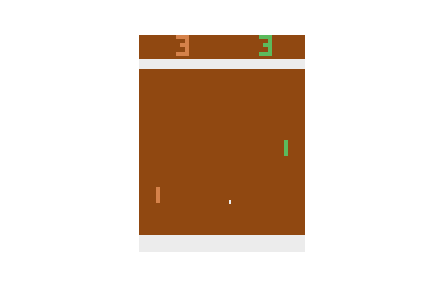
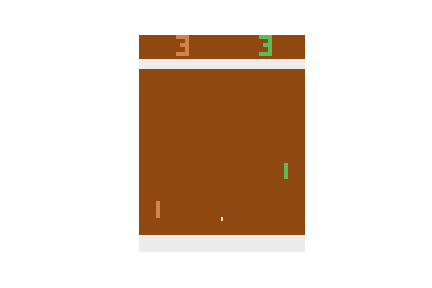
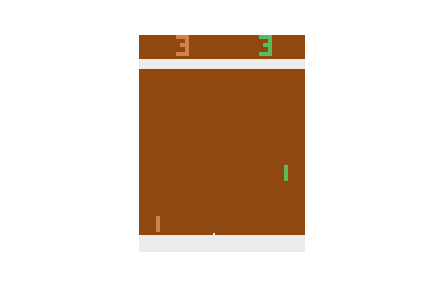
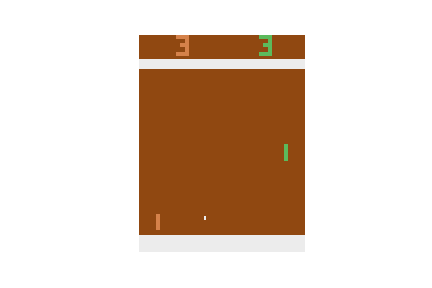
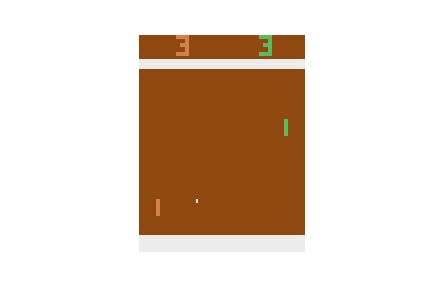
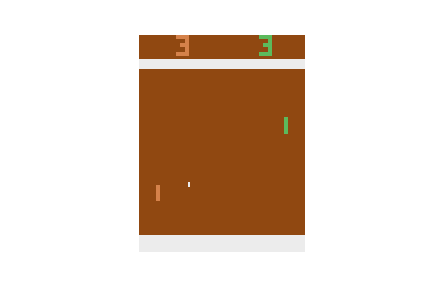
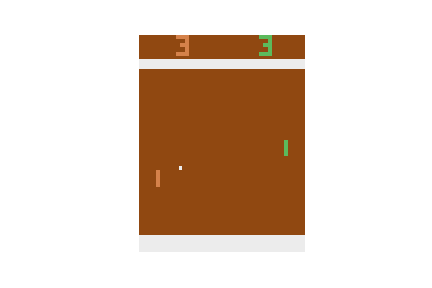
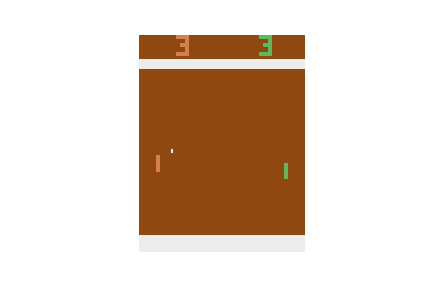
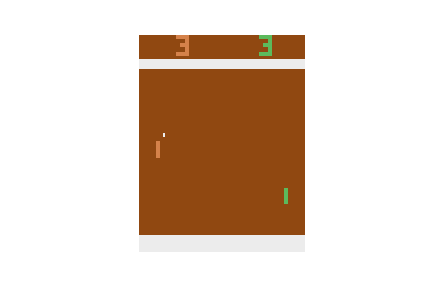
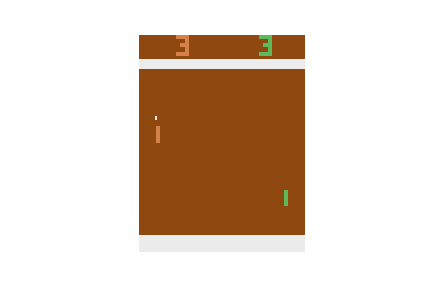
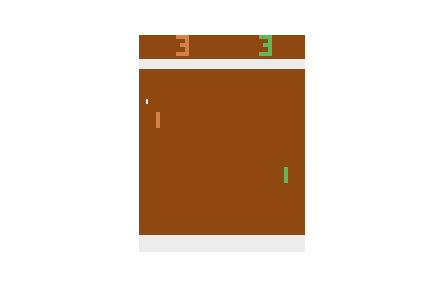
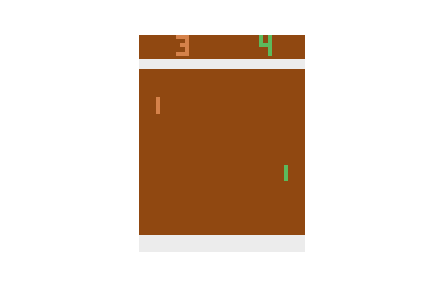
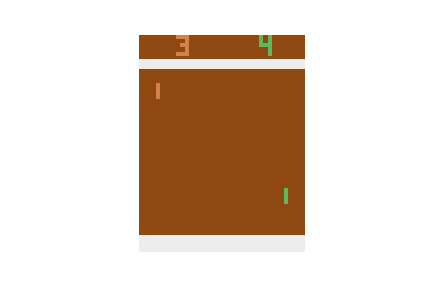
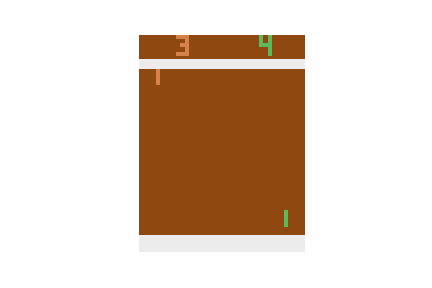
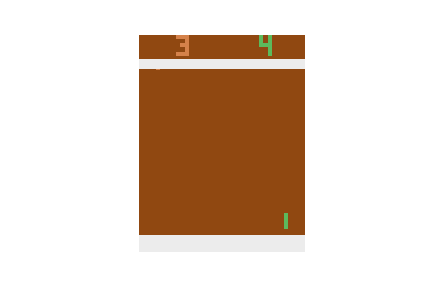
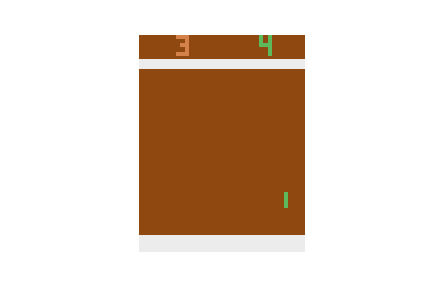
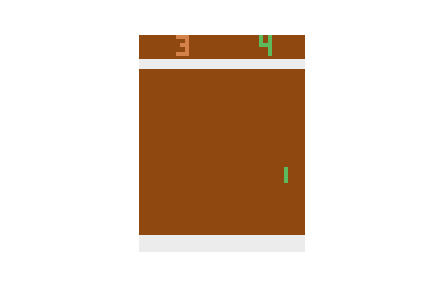
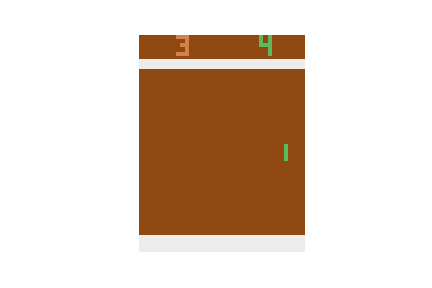
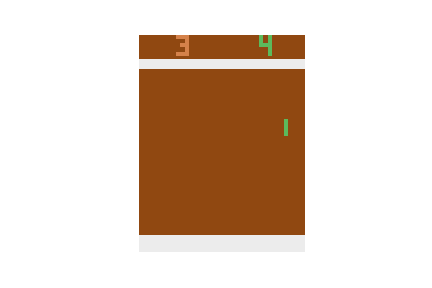
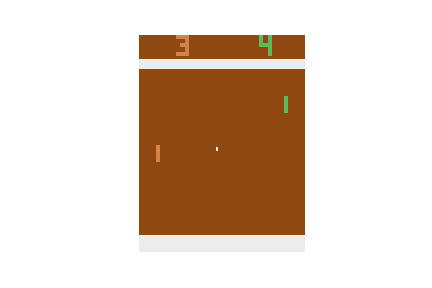
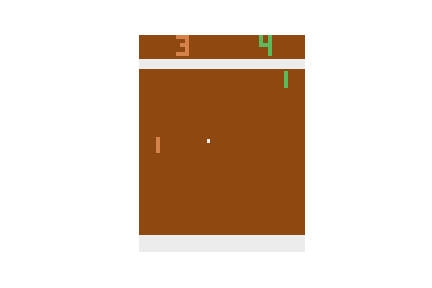
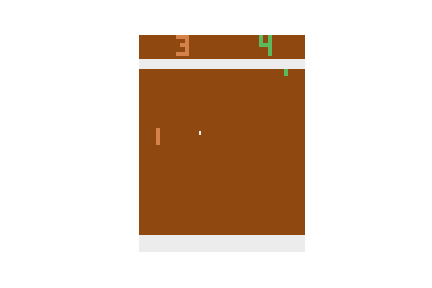
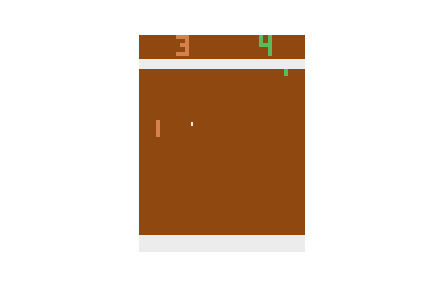
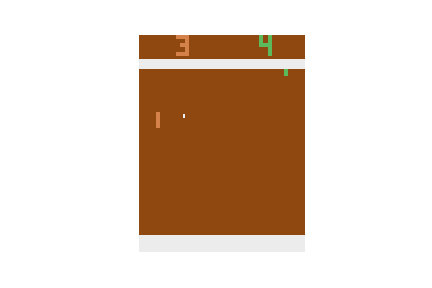
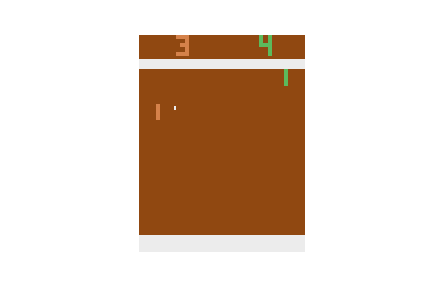
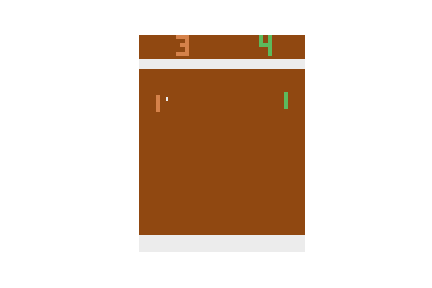
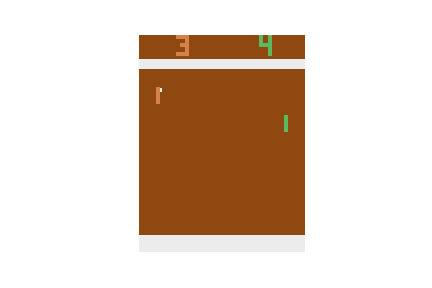
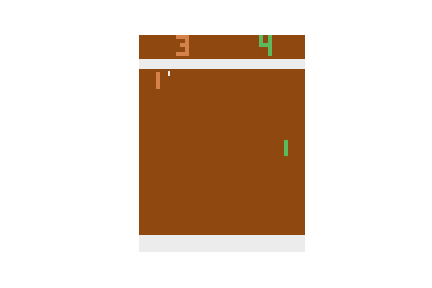
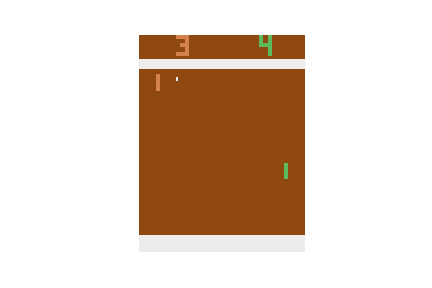
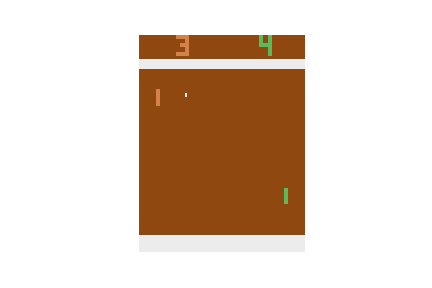
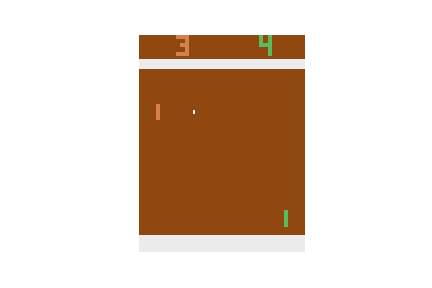
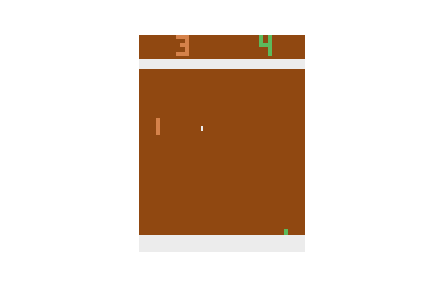
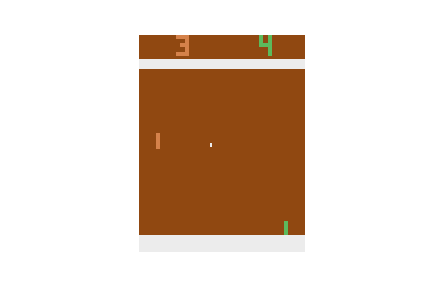
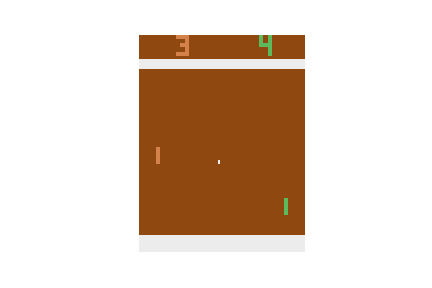
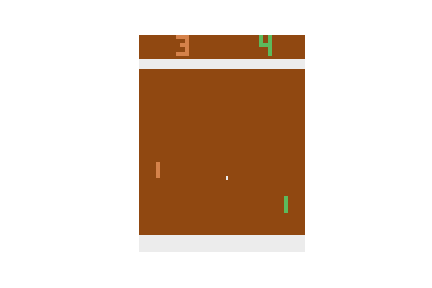
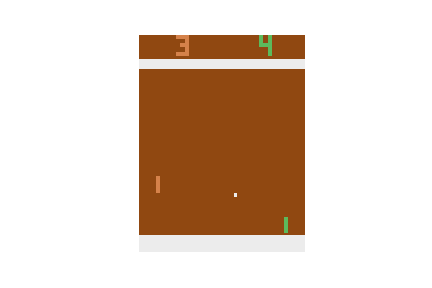
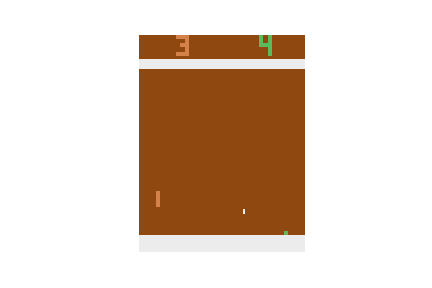
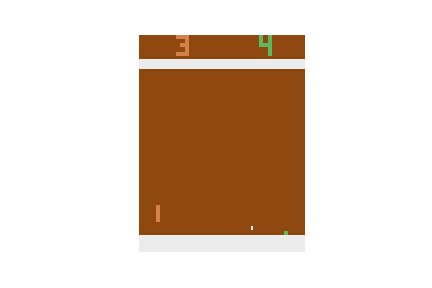
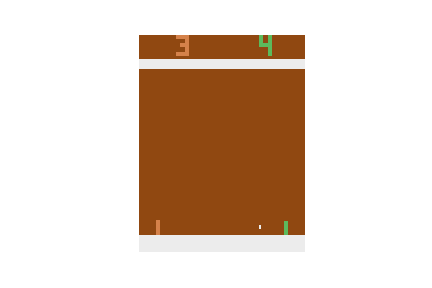
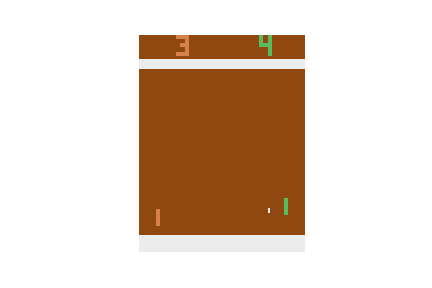
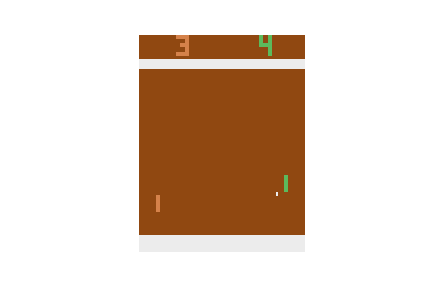
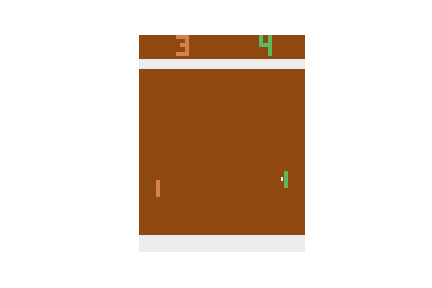
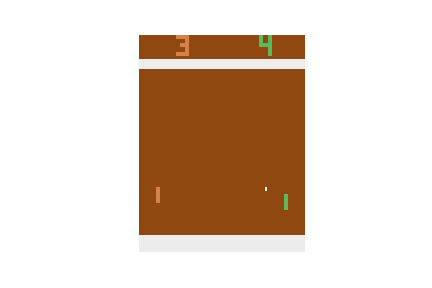
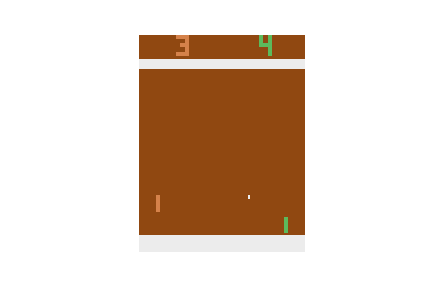
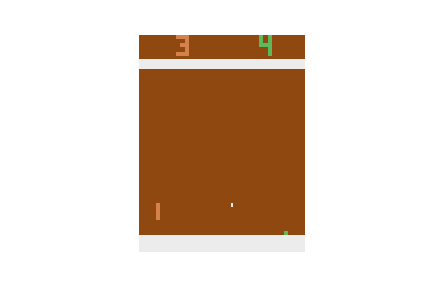
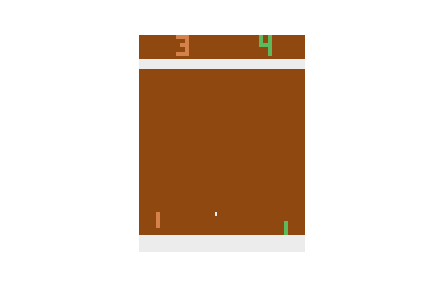
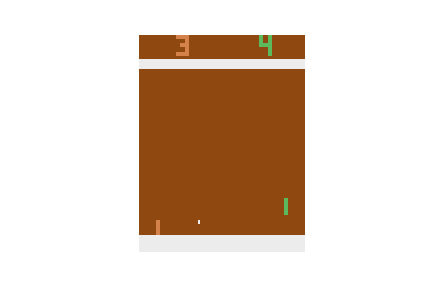
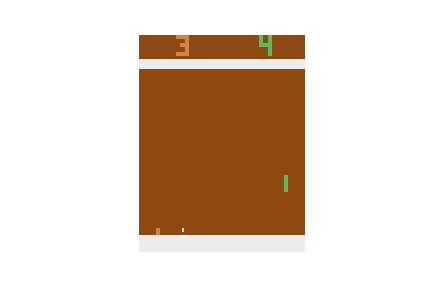
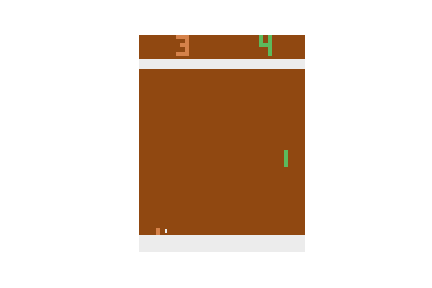
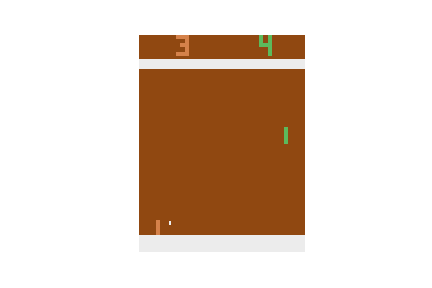
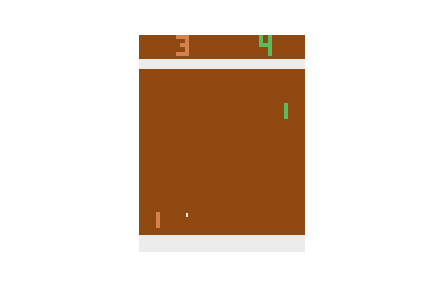
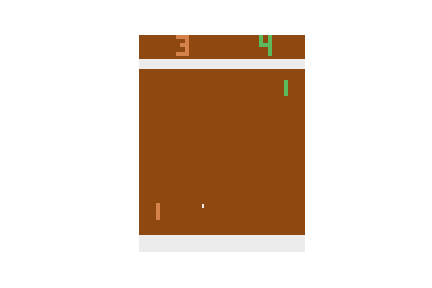
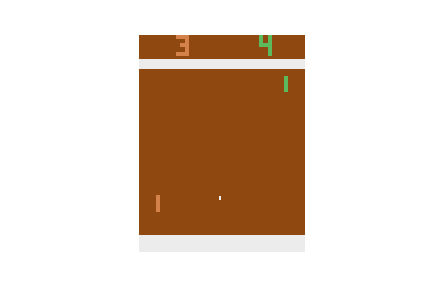
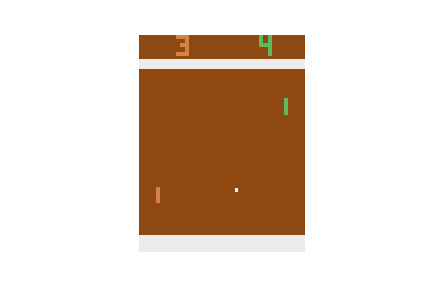
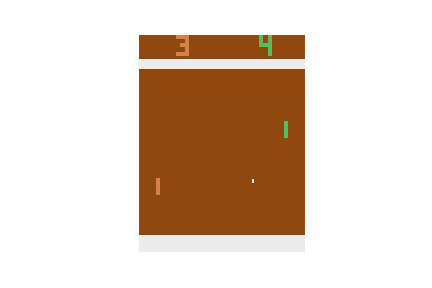
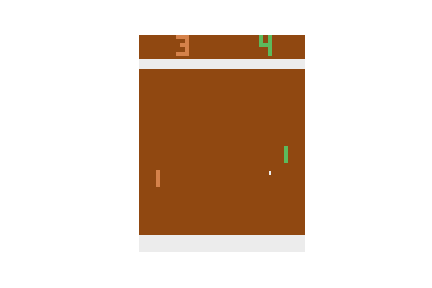
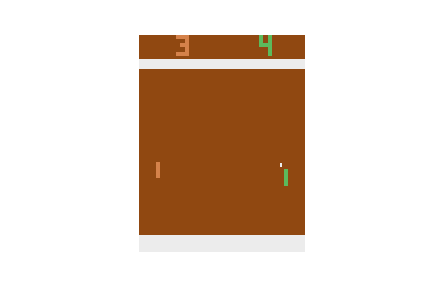
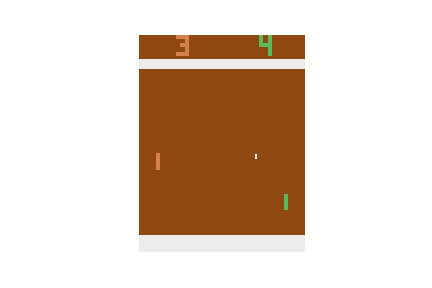
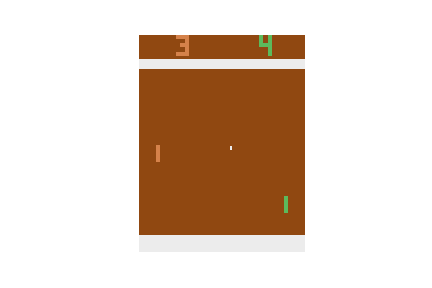
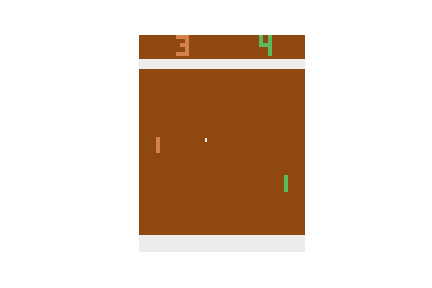
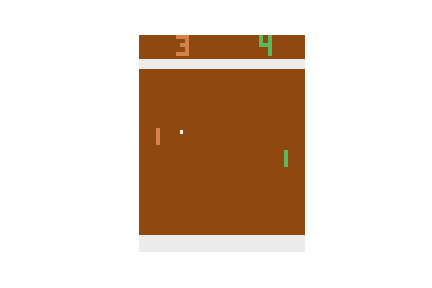
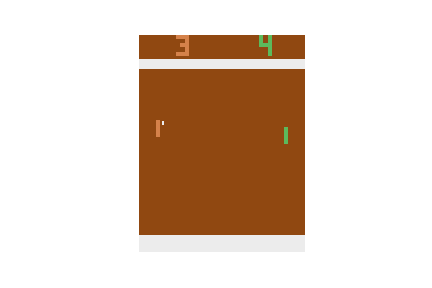
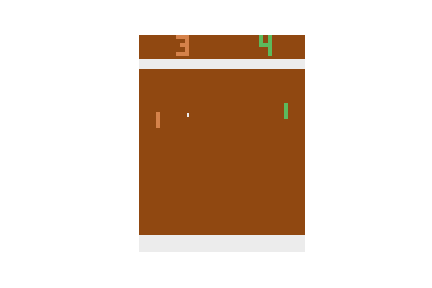
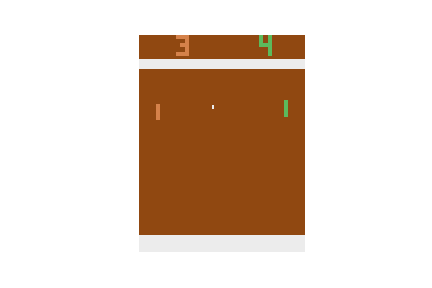
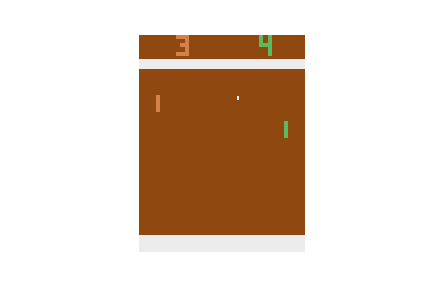
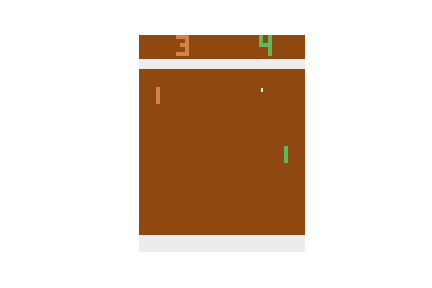
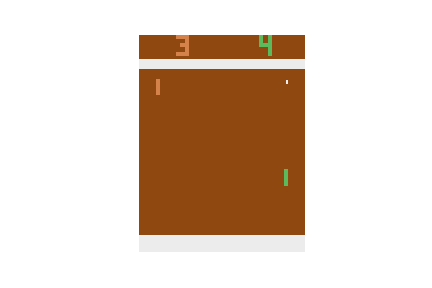
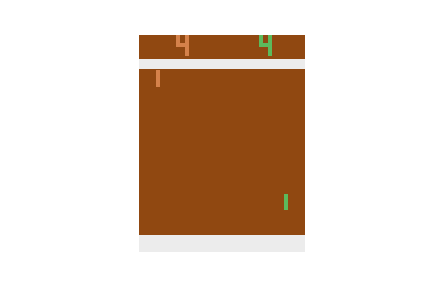
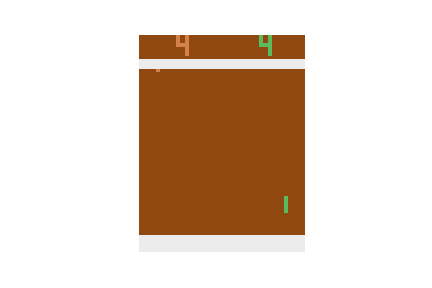
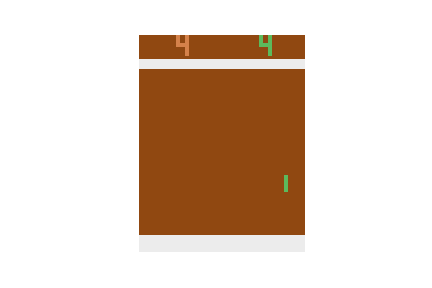
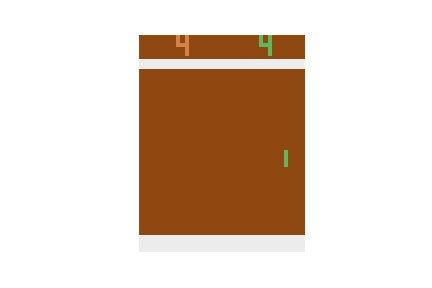
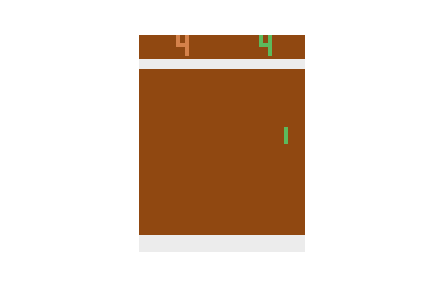
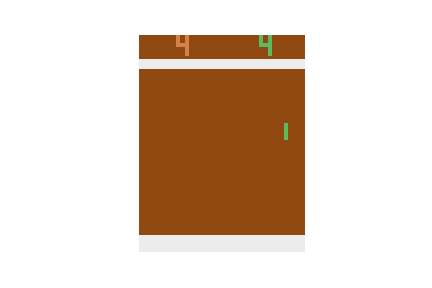
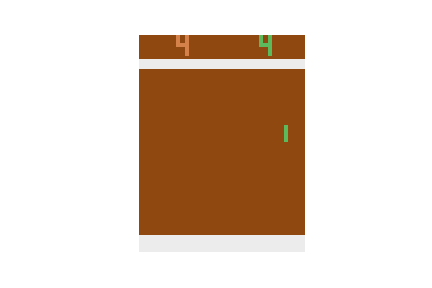
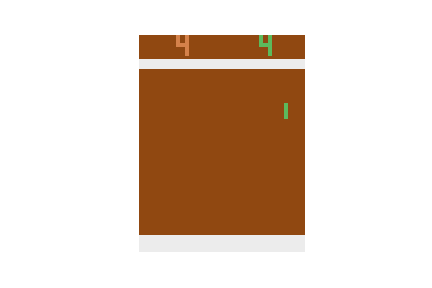
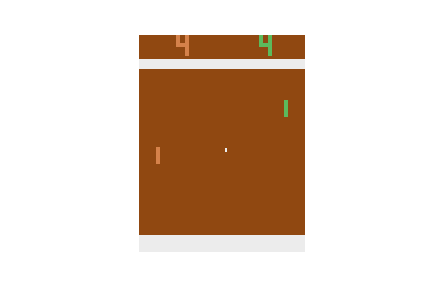
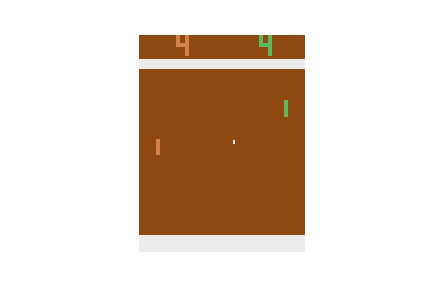
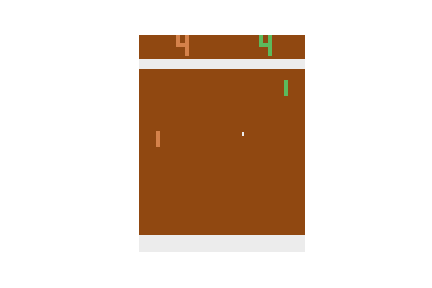
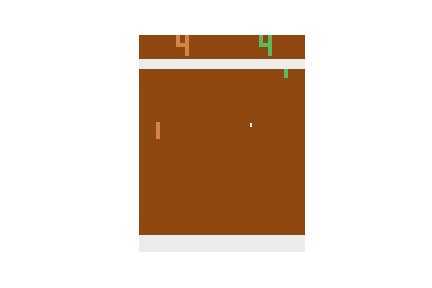
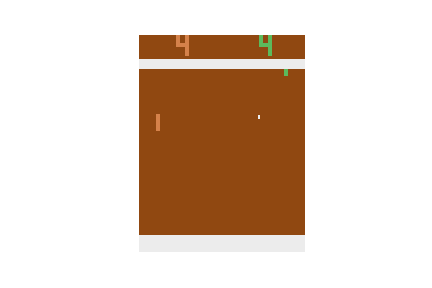
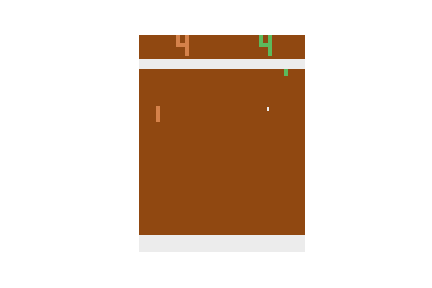
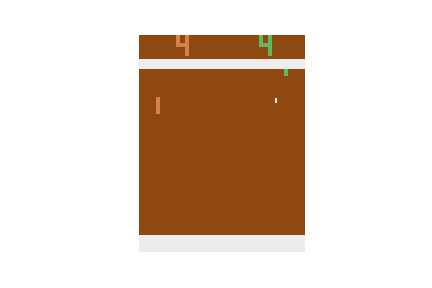
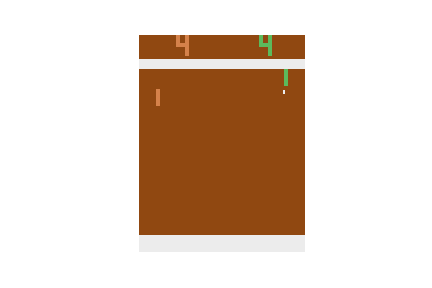
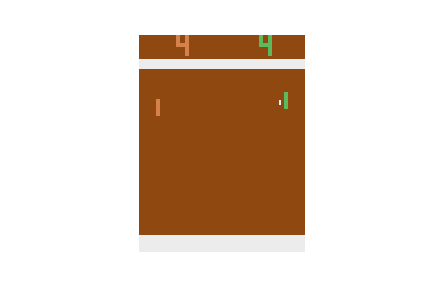
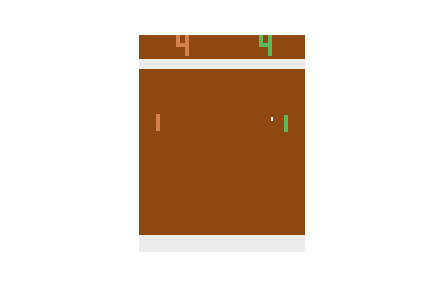
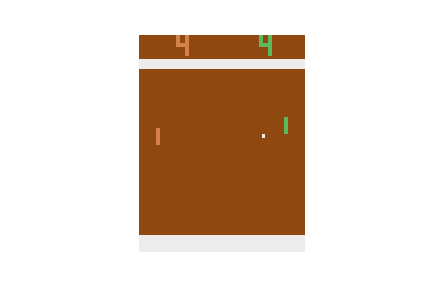
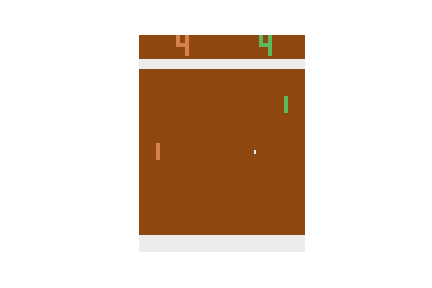
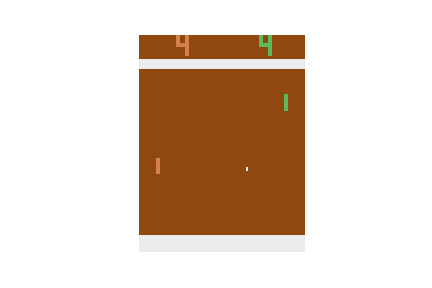
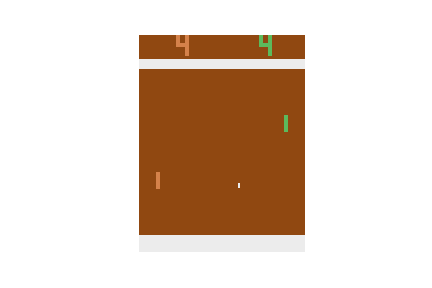
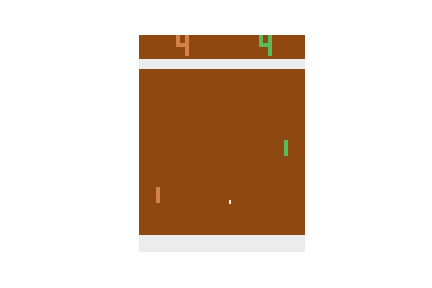
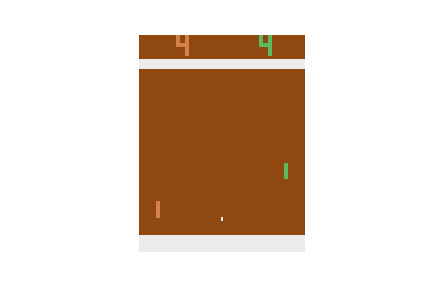
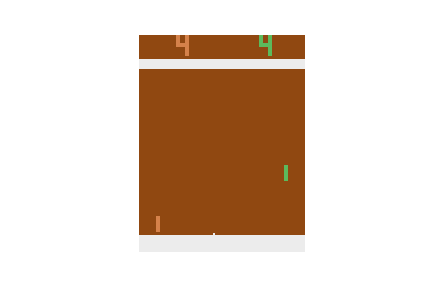
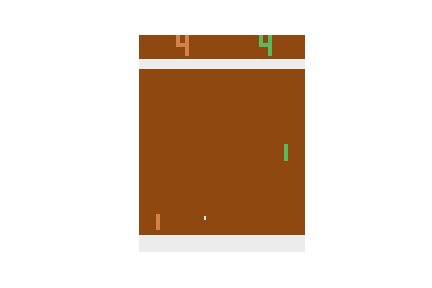
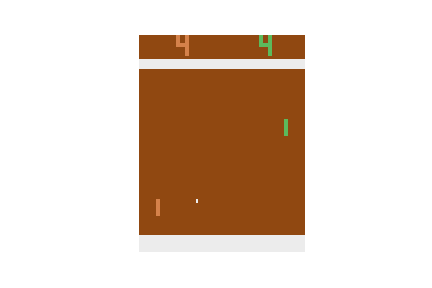
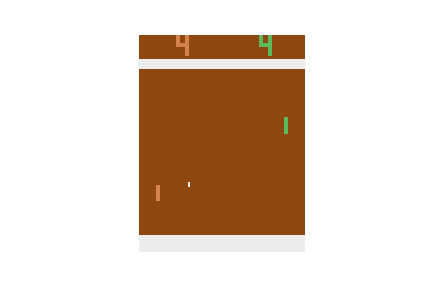
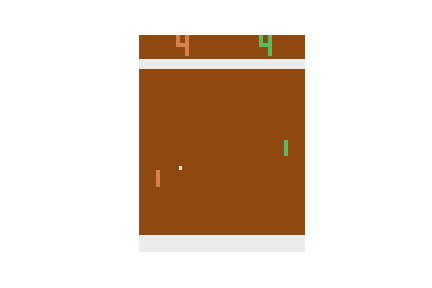
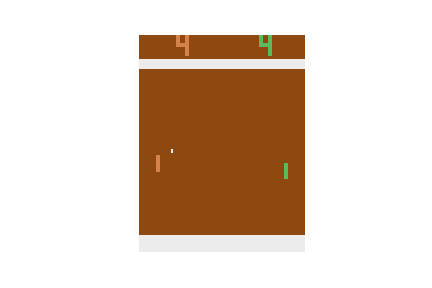
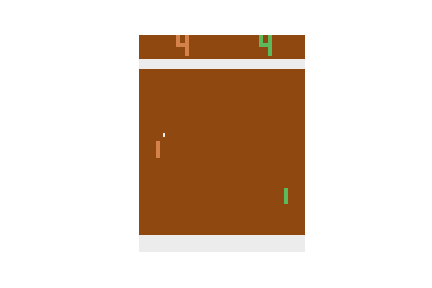
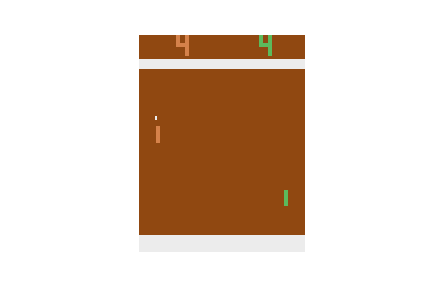
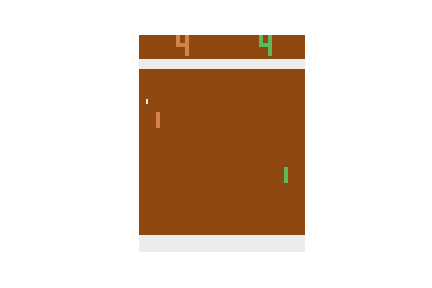
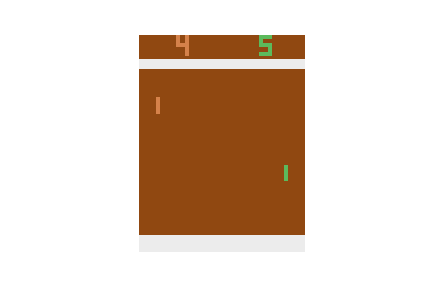
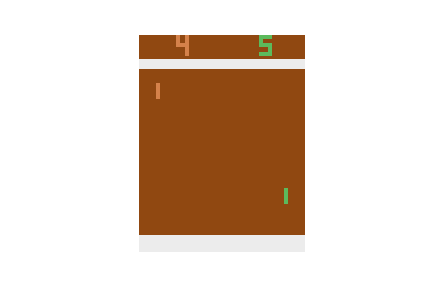
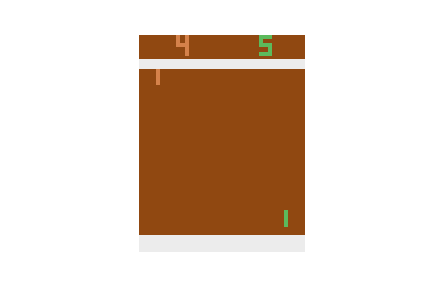
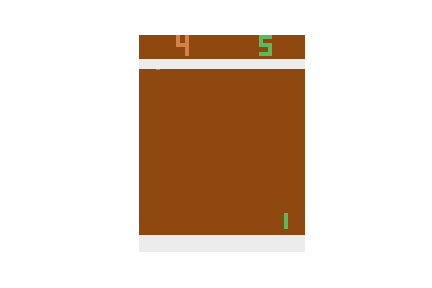
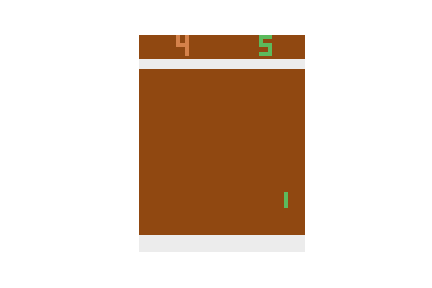
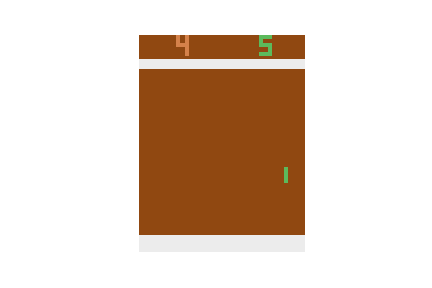
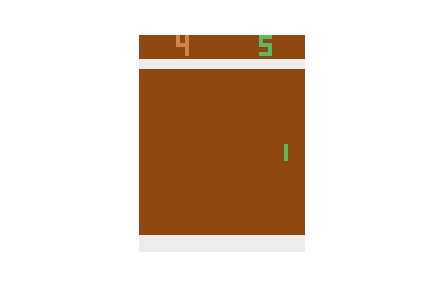
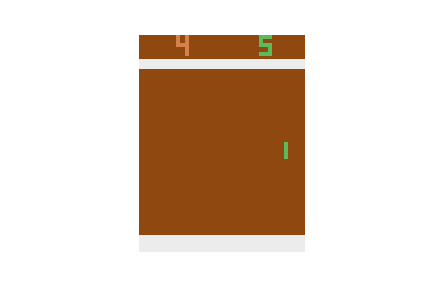
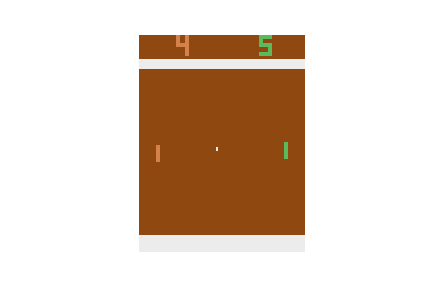
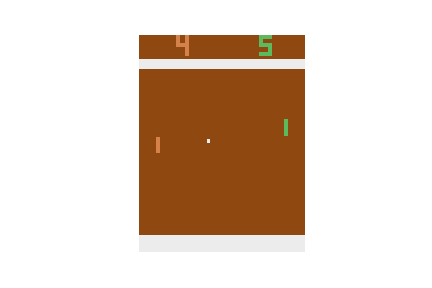
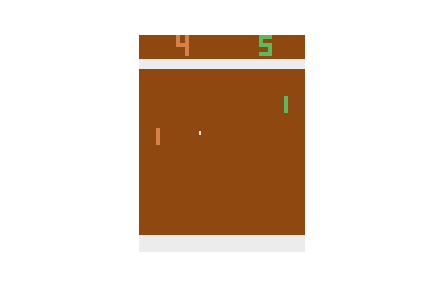
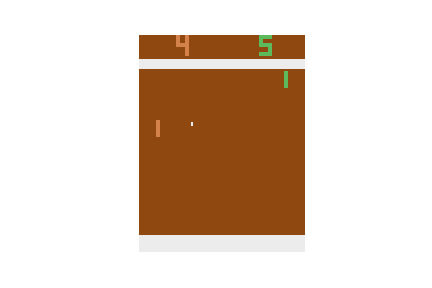
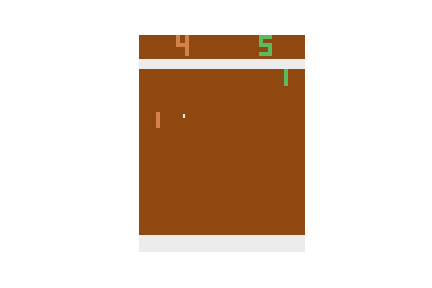
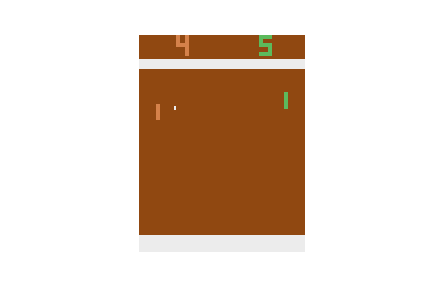
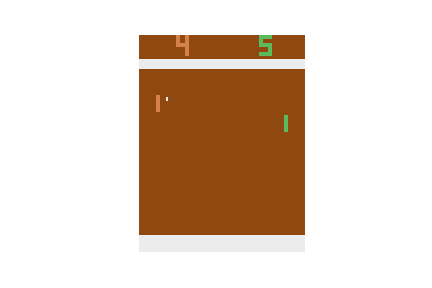
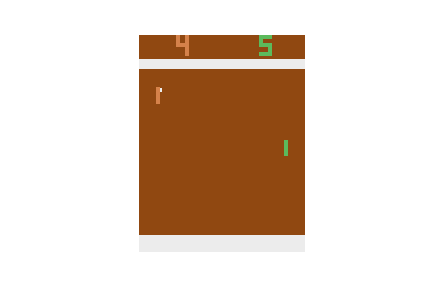
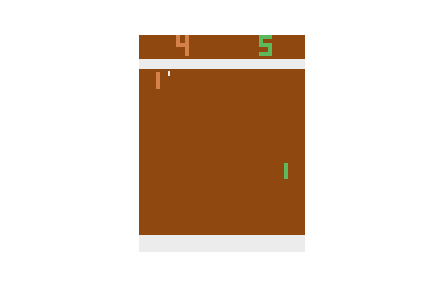
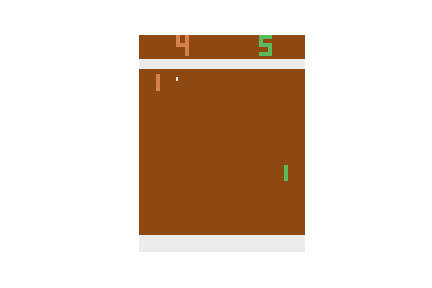
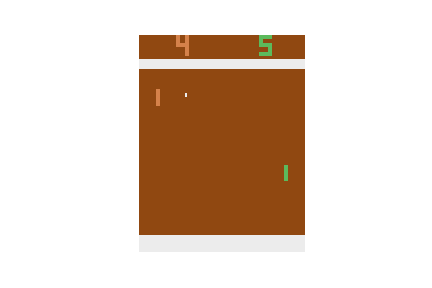
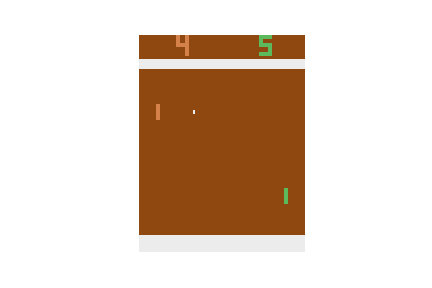
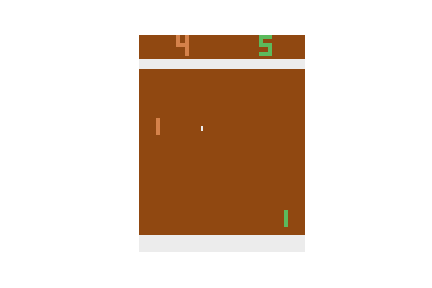
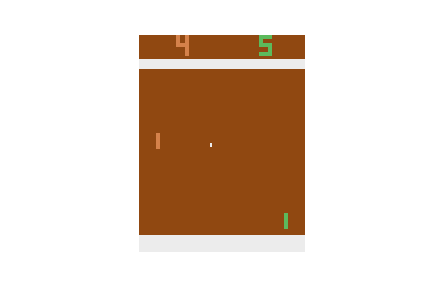
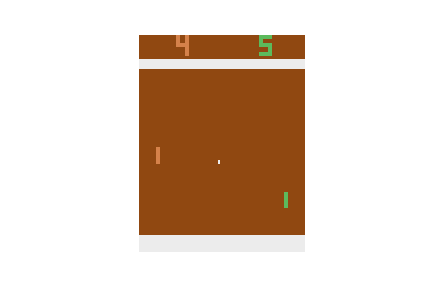
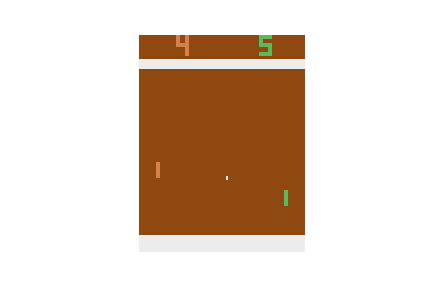
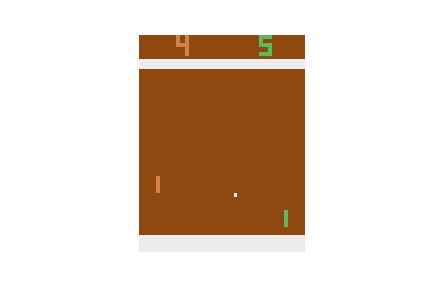
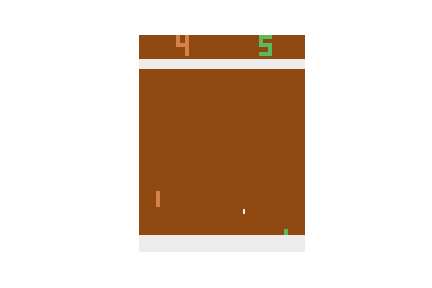
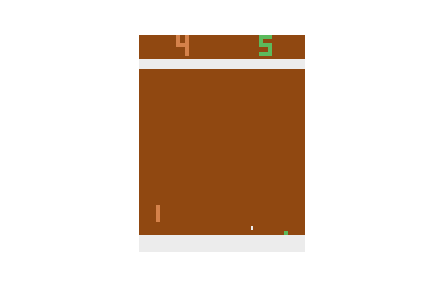
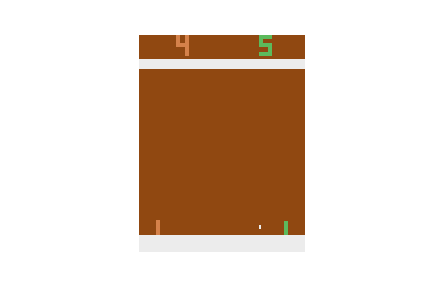
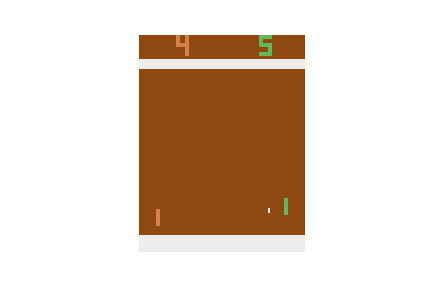
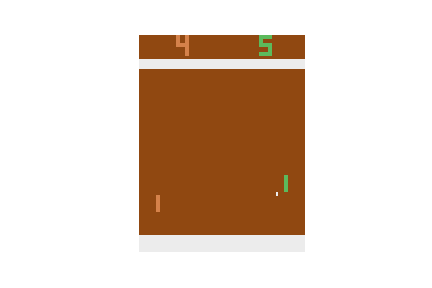
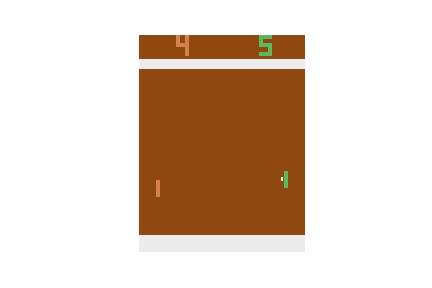
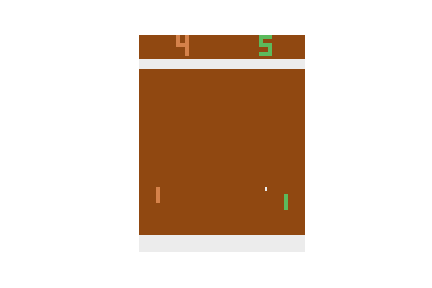
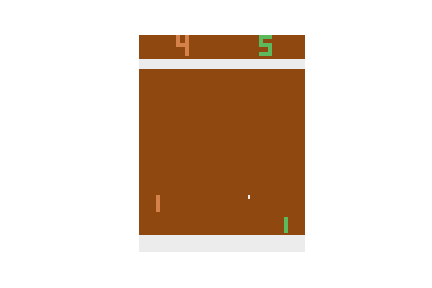
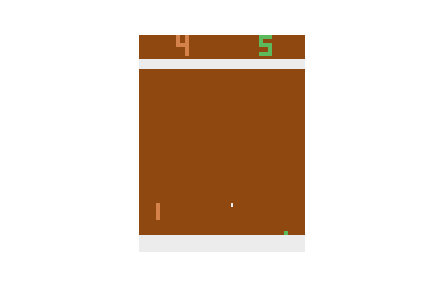
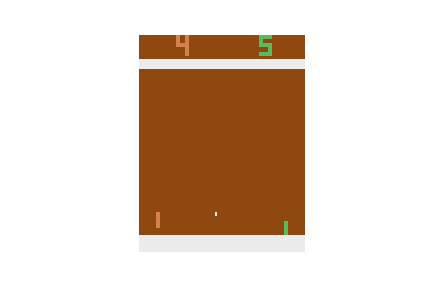
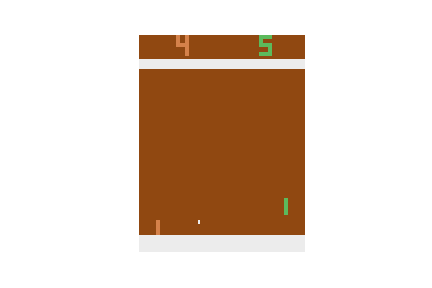
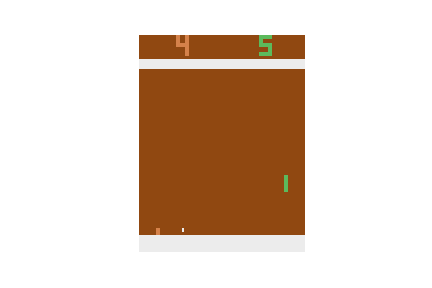
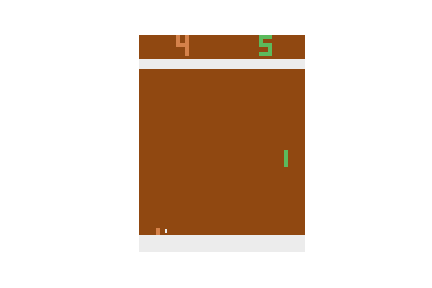
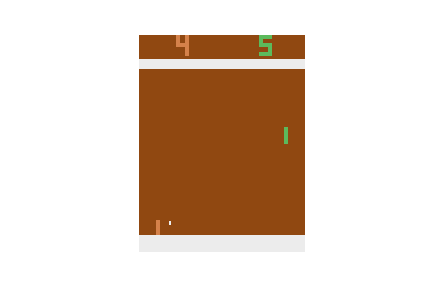
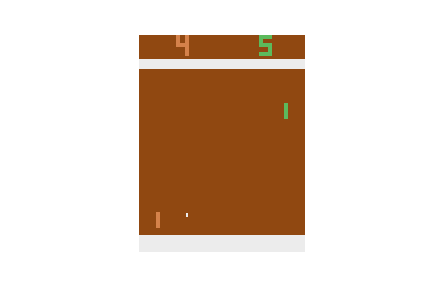
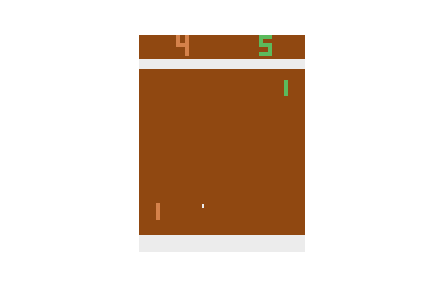
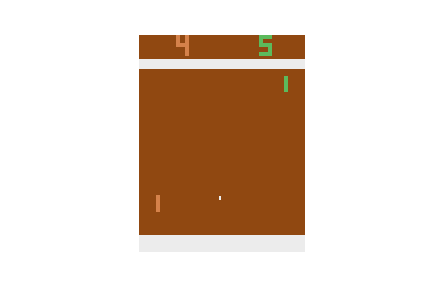
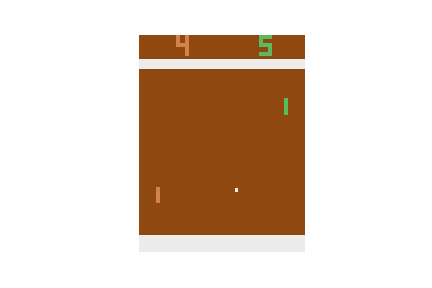
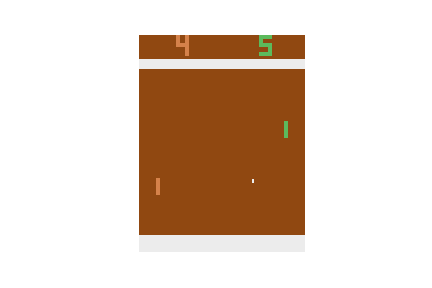
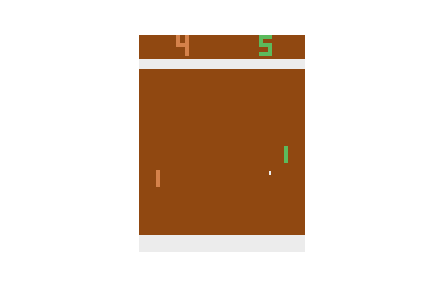
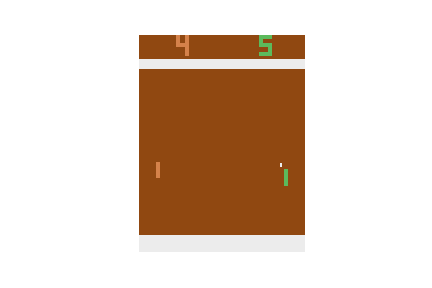
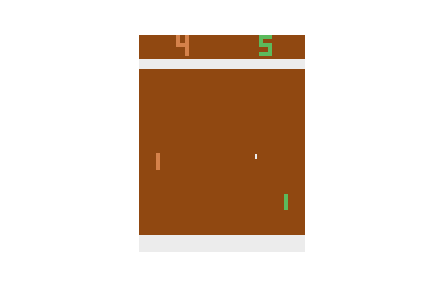
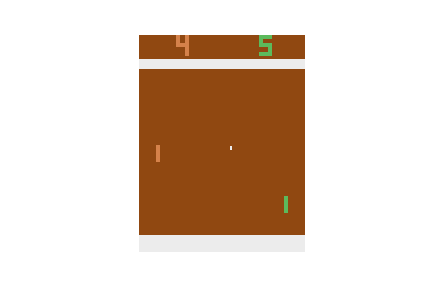
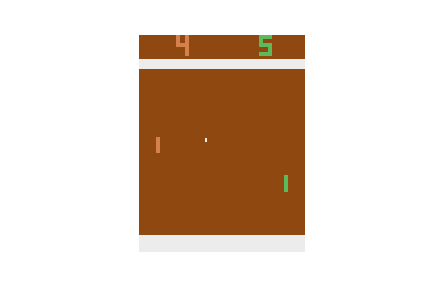
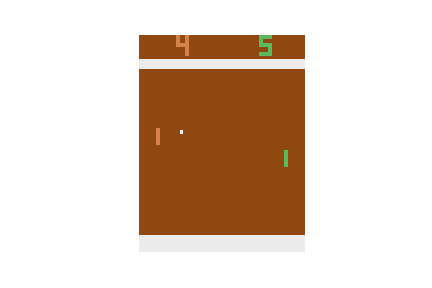
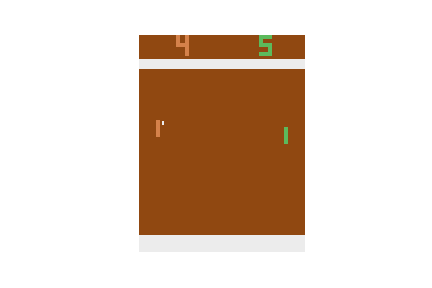
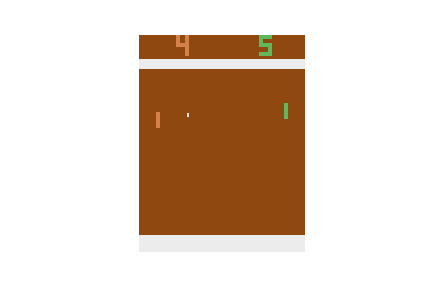
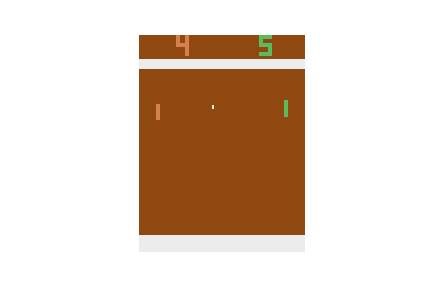
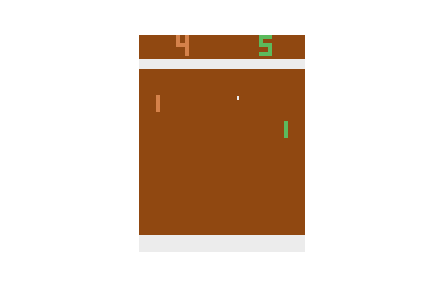
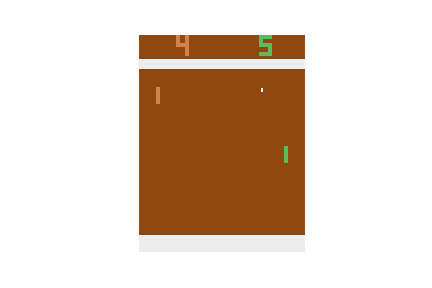
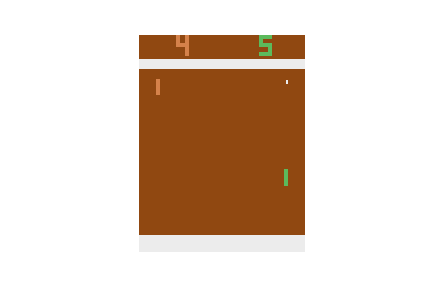
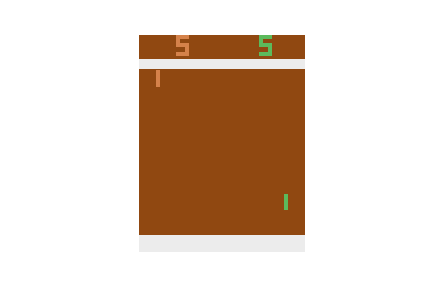
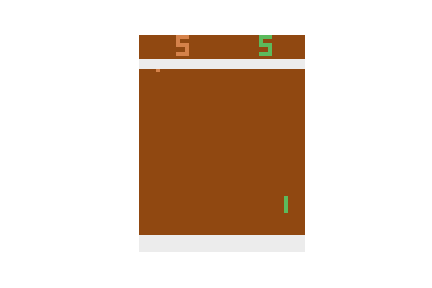
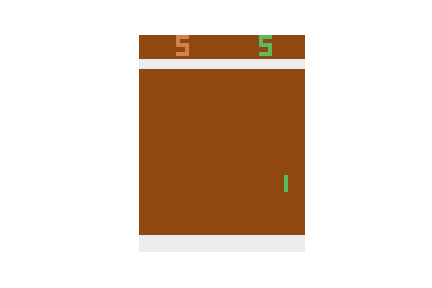
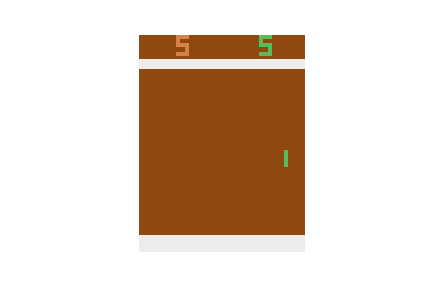
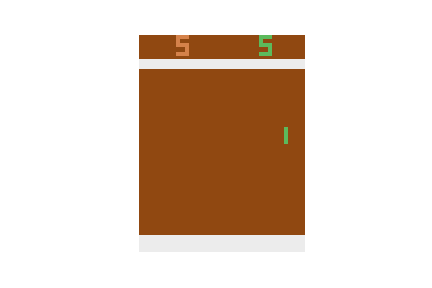
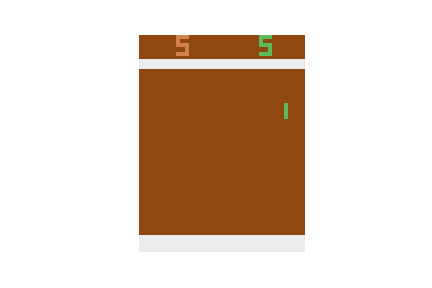
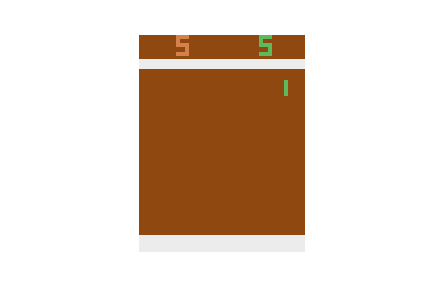
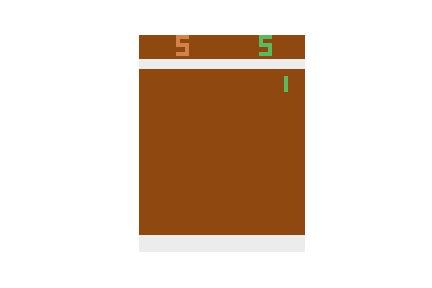
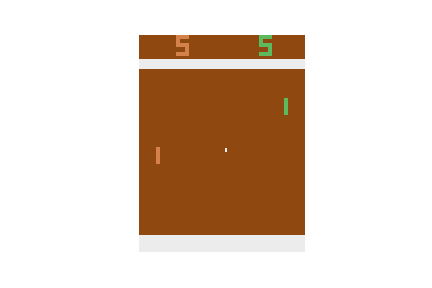
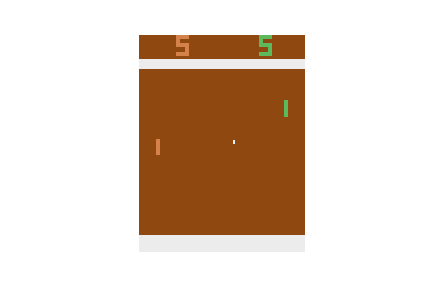
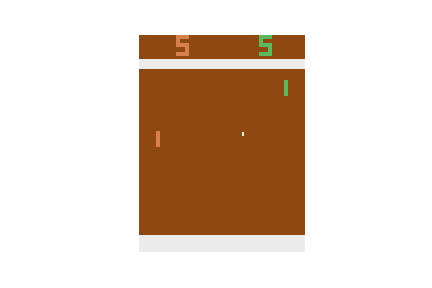
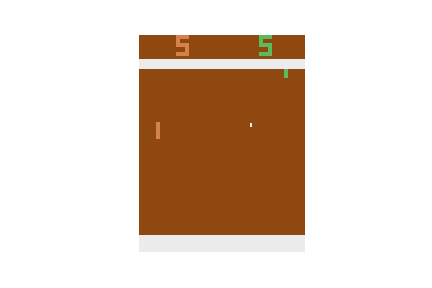
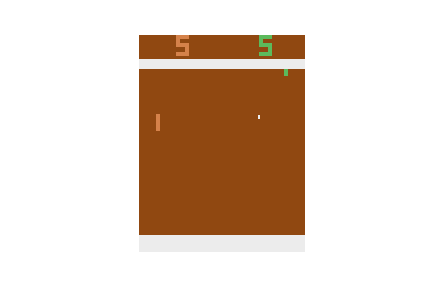
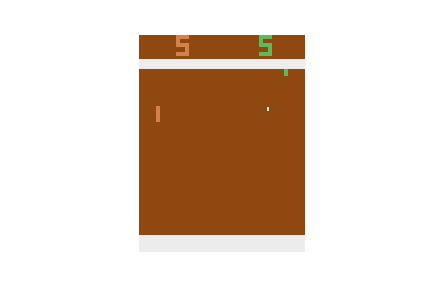
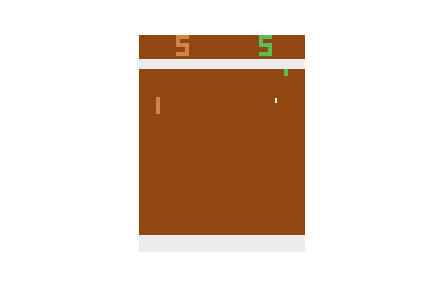
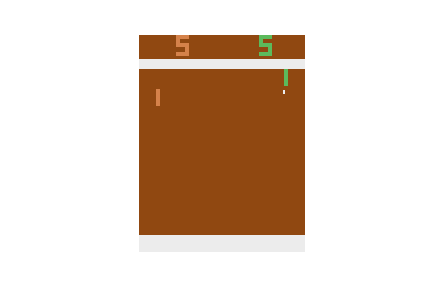
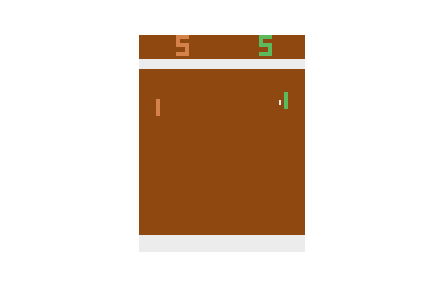
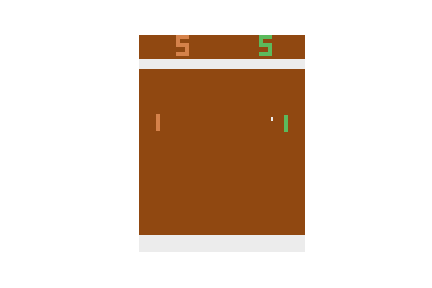
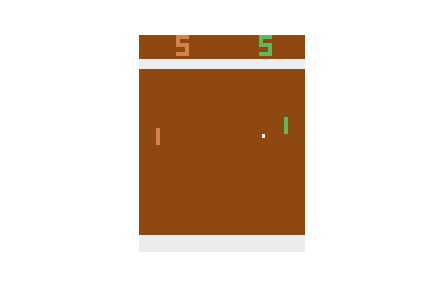
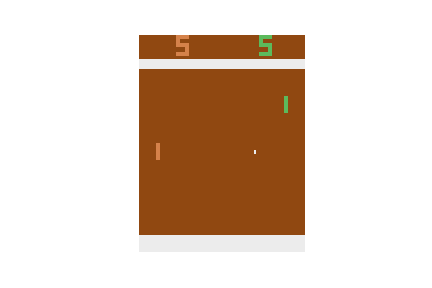
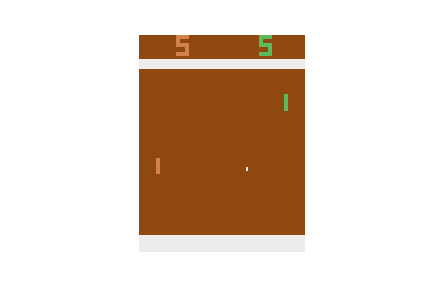
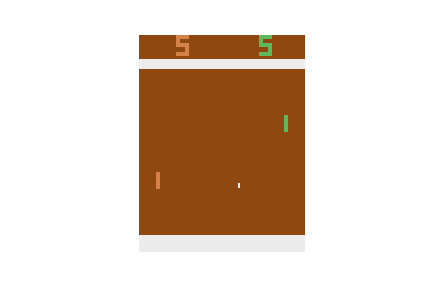
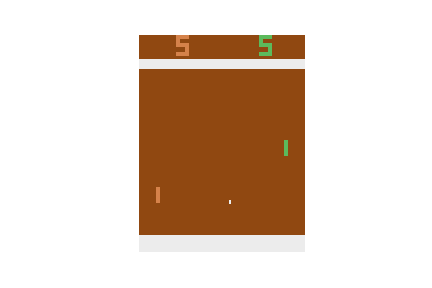
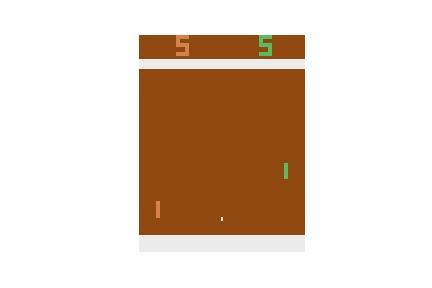
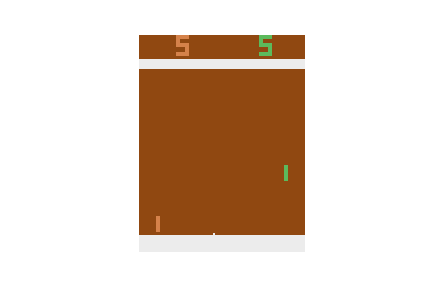
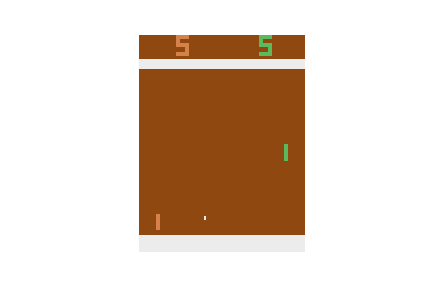
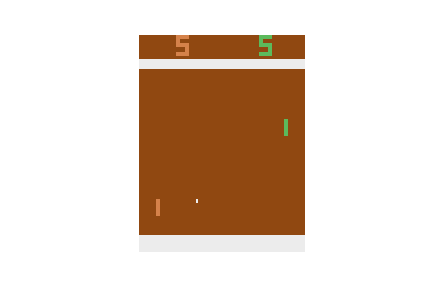
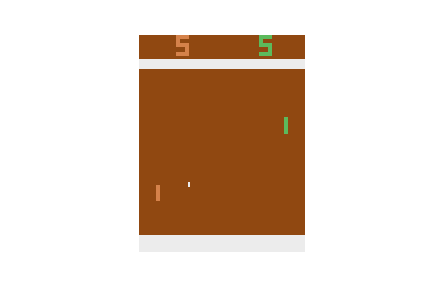
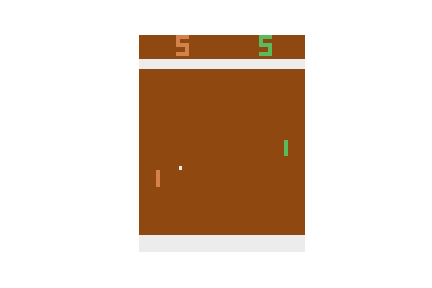
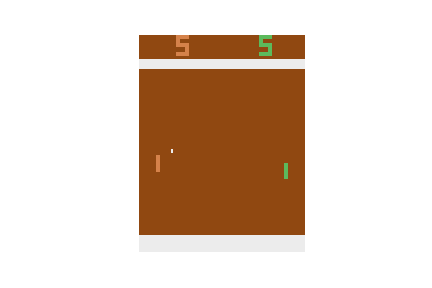
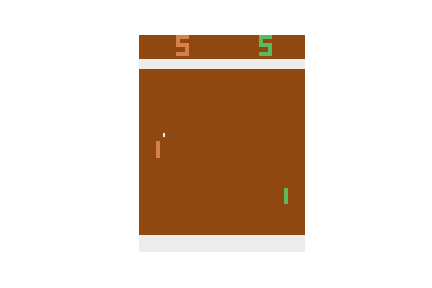
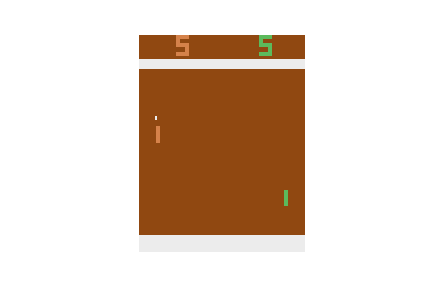
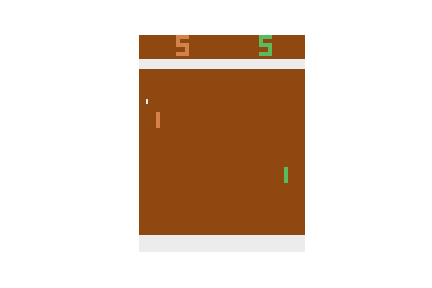
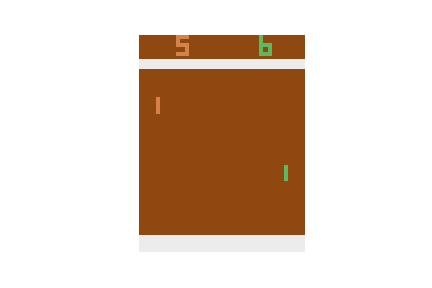
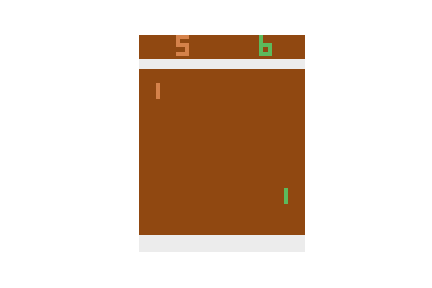
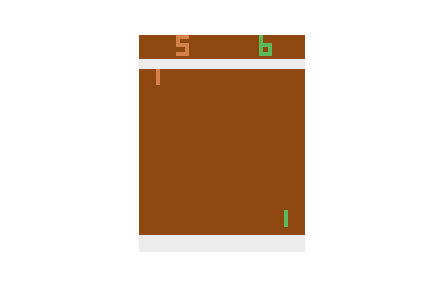
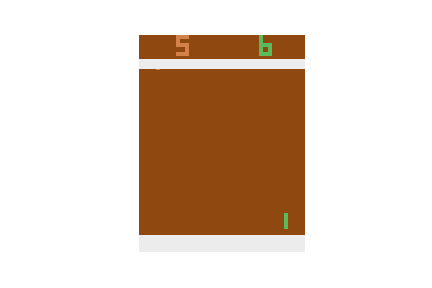
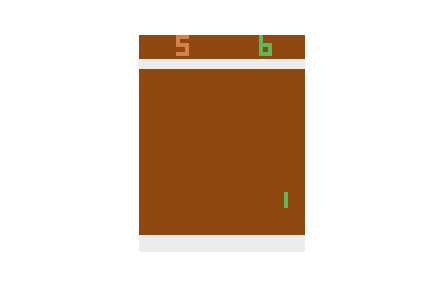
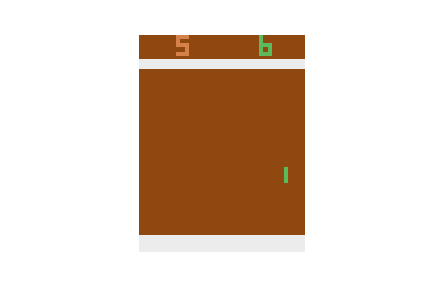
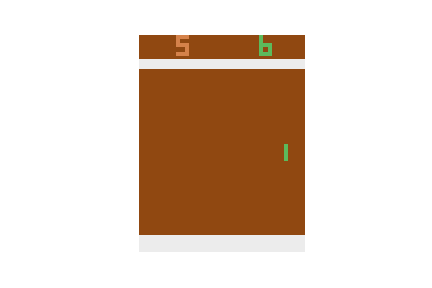
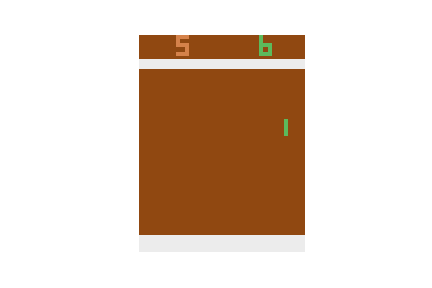
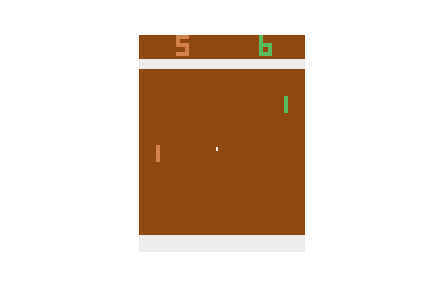
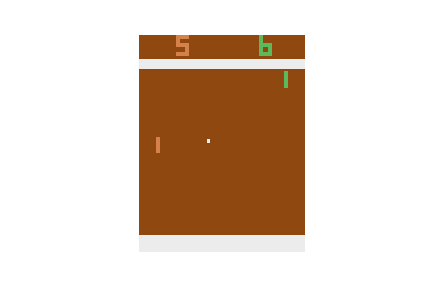
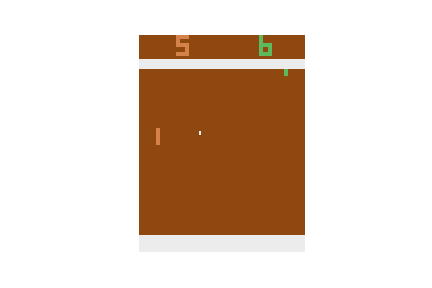
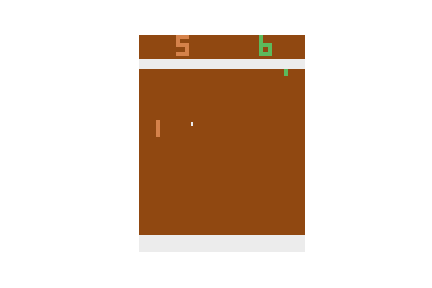
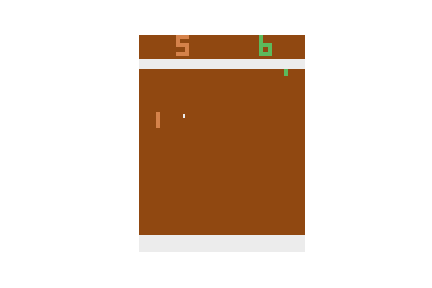
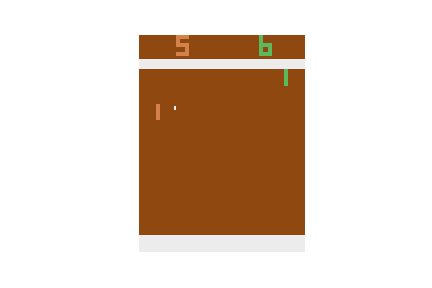
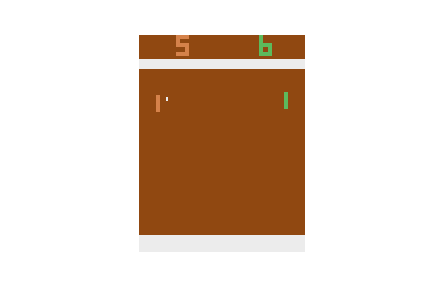
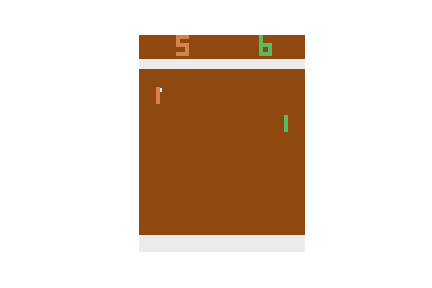
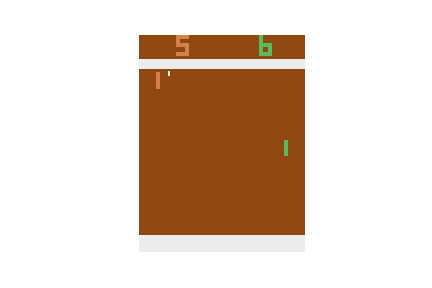
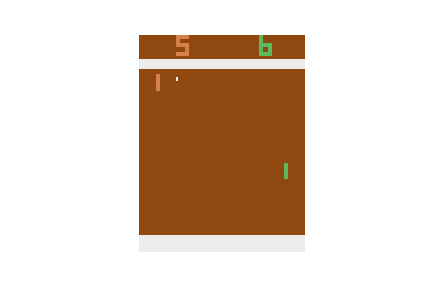
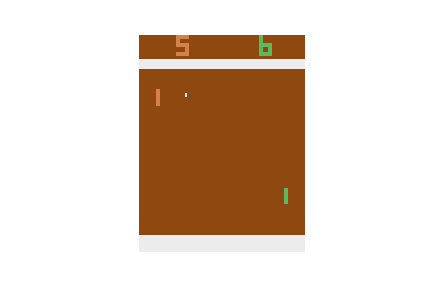
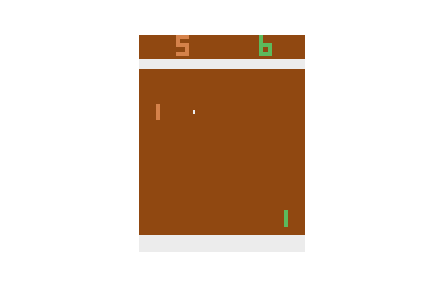
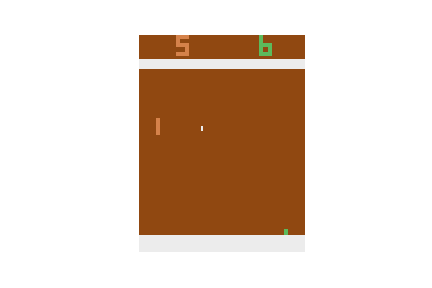
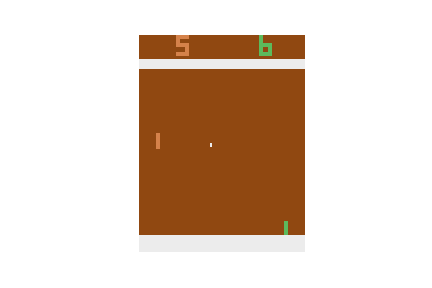
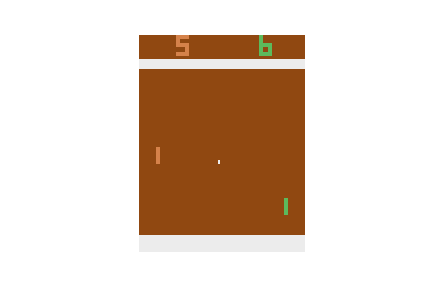
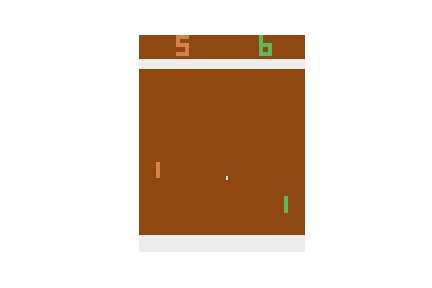
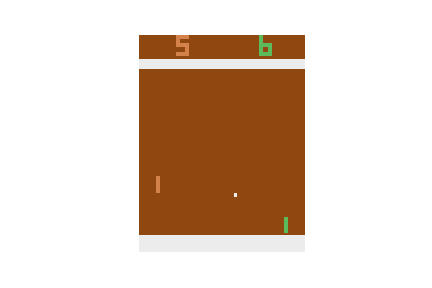
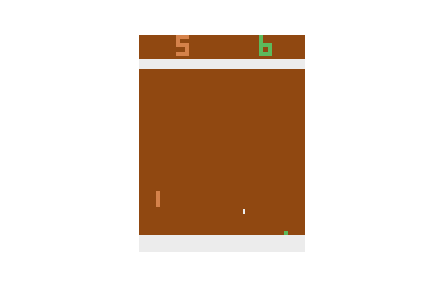
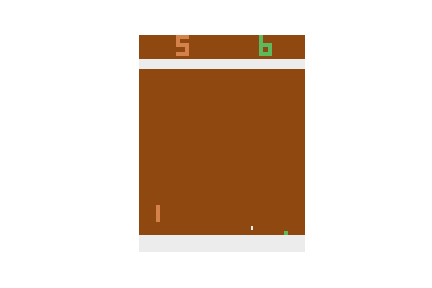
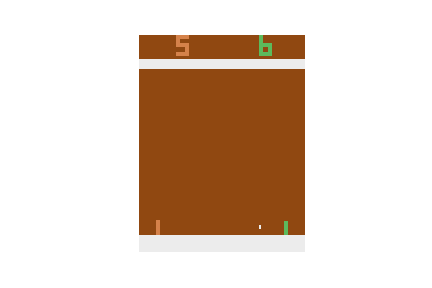
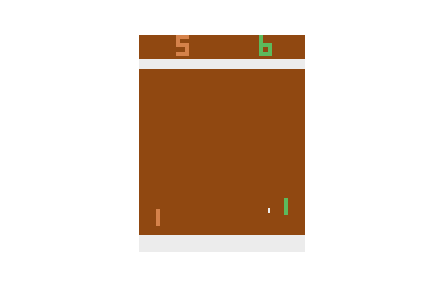
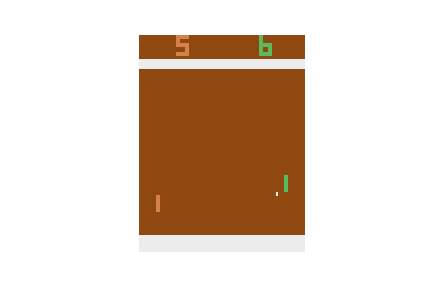
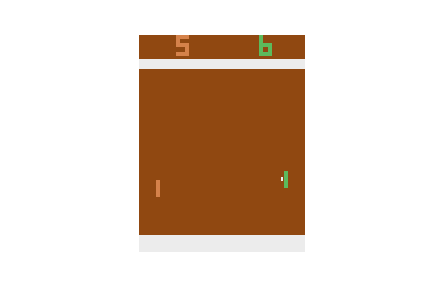
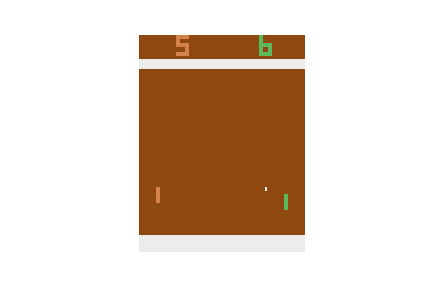
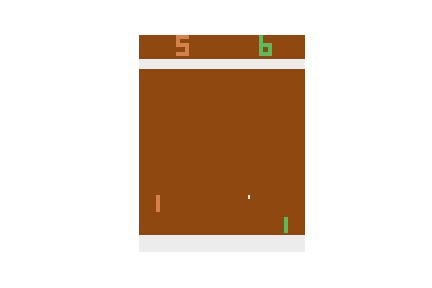
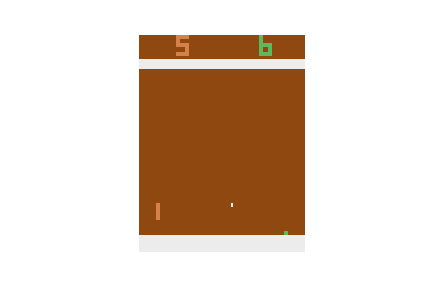
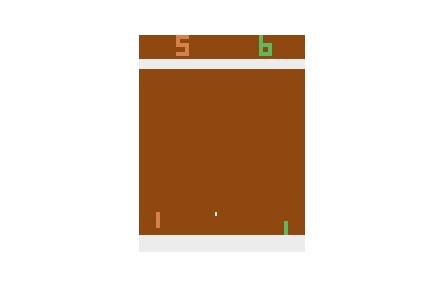
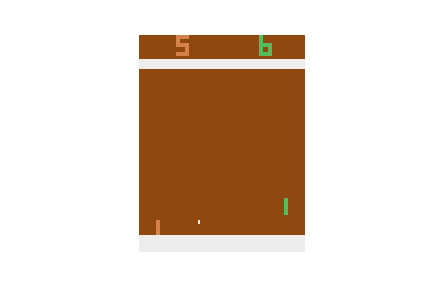
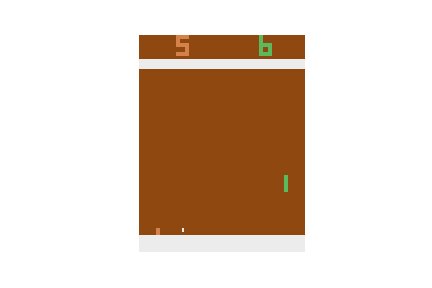
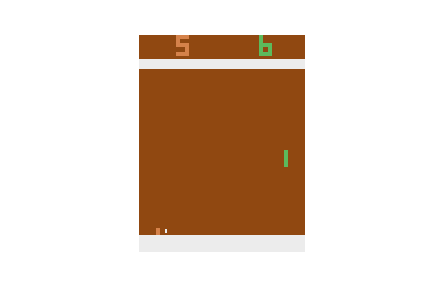
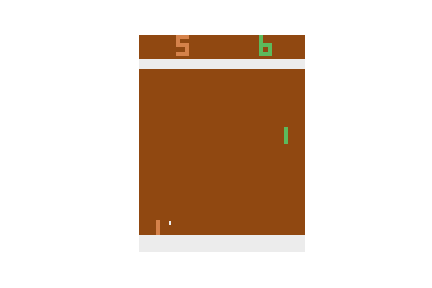
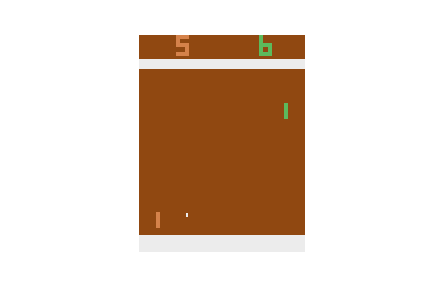
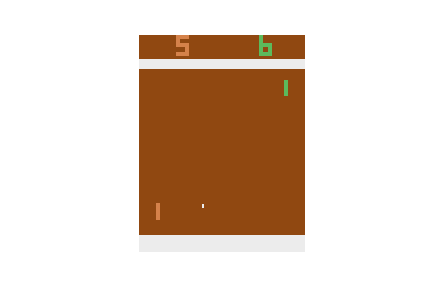
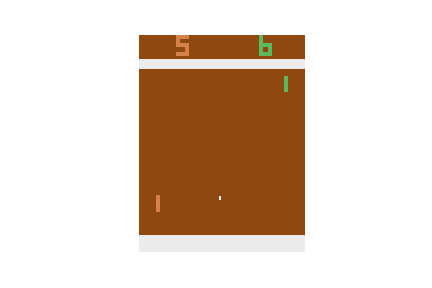
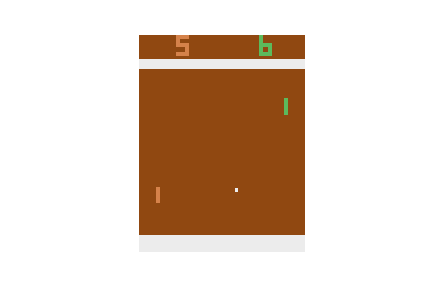
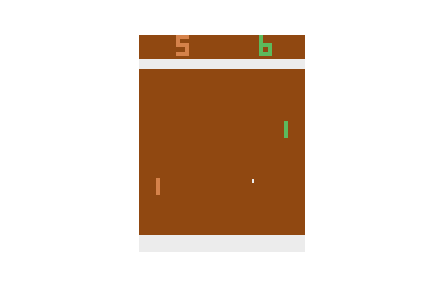
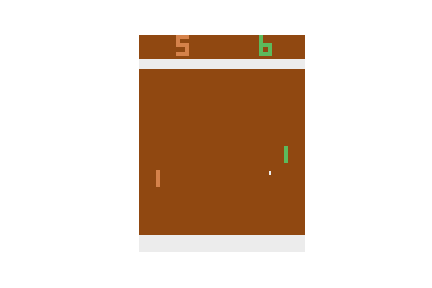
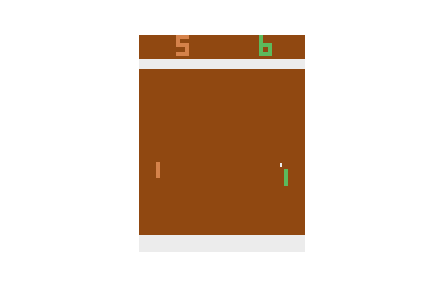
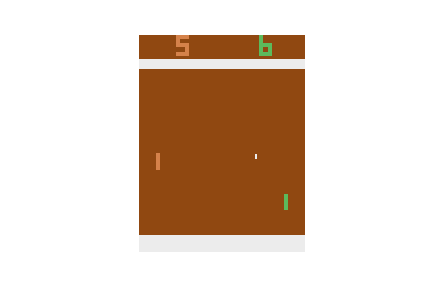
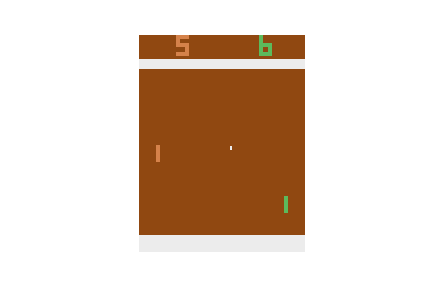
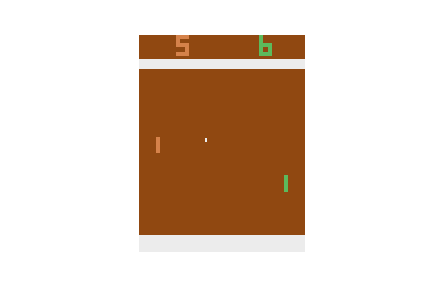
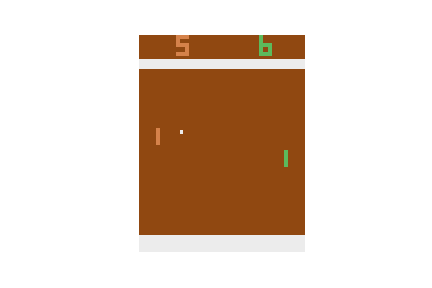
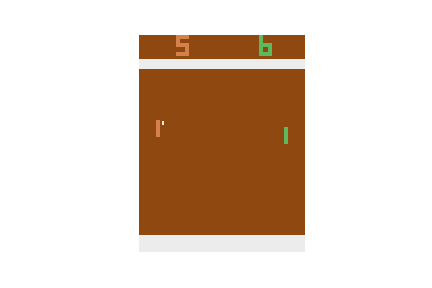
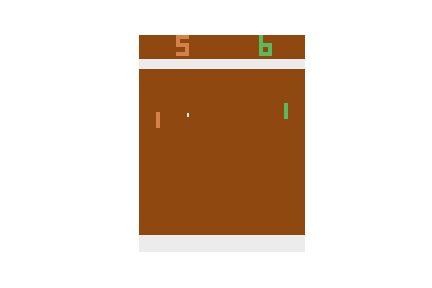
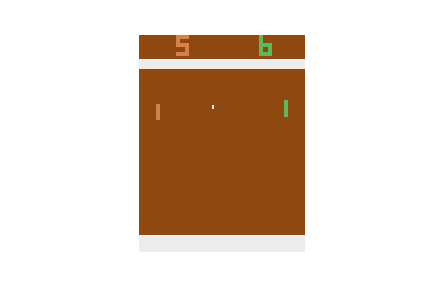
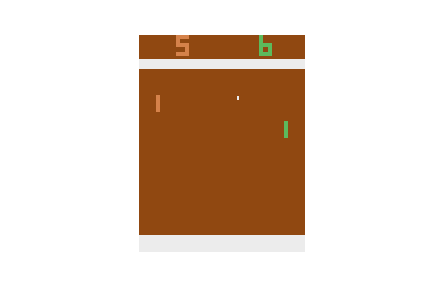
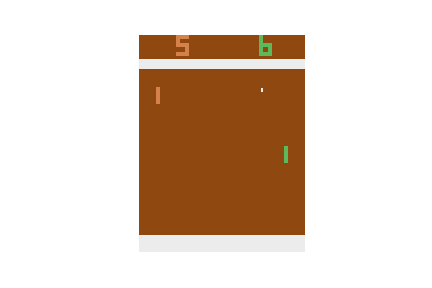

In [31]:
play(env, agent, time=500) 

In [32]:
# save your policy!
PATH = 'PPO.pth'
torch.save(agent.policy.state_dict(), PATH)


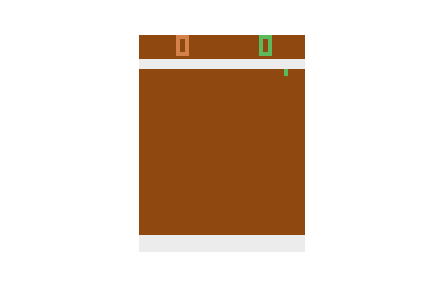
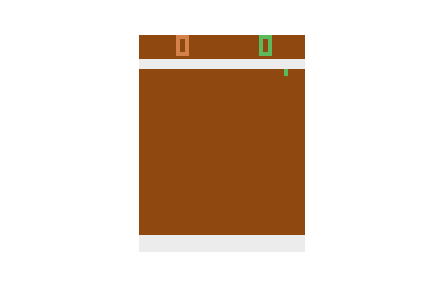
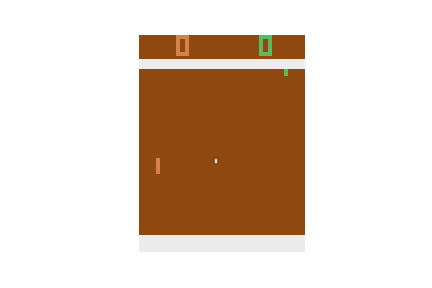
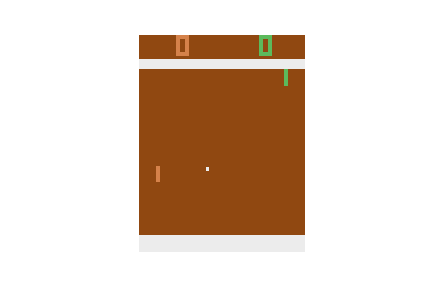
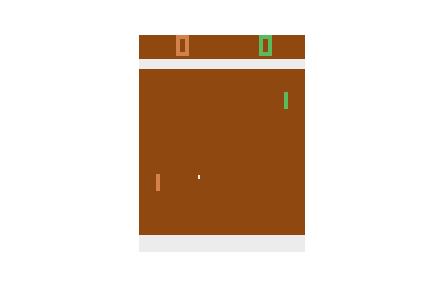
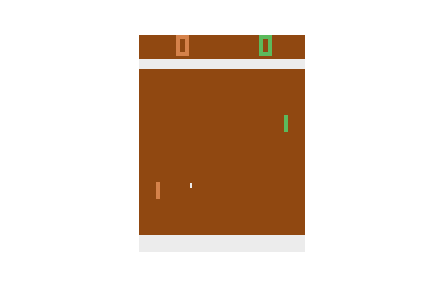
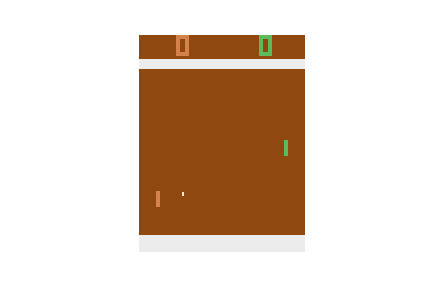
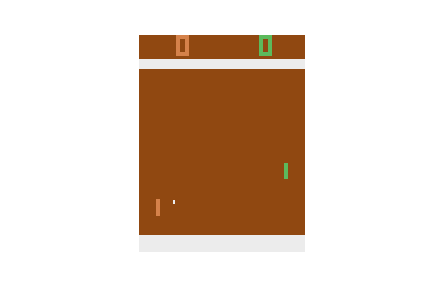
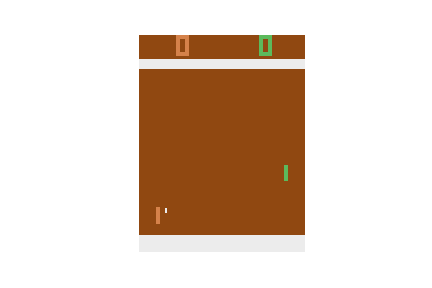
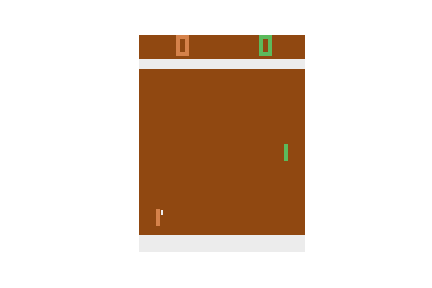
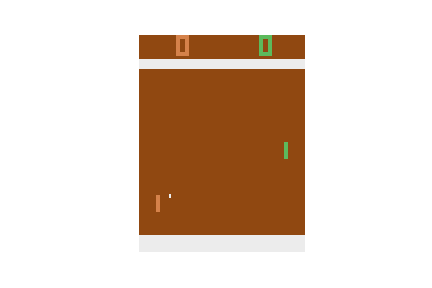
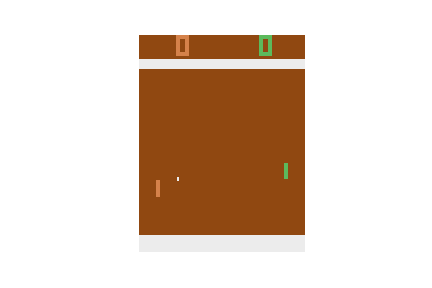
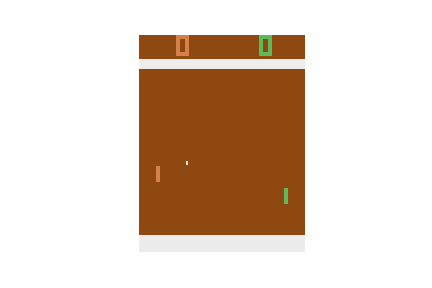
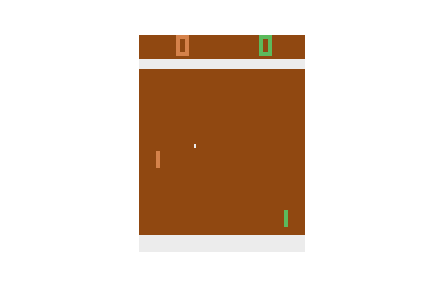
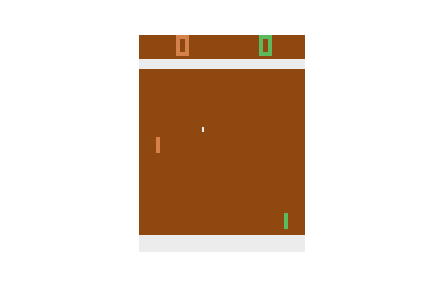
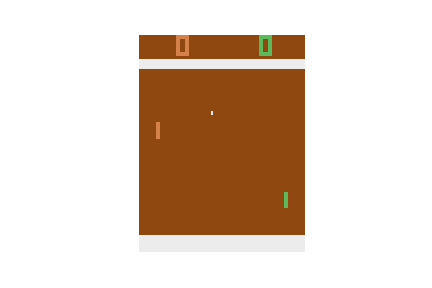
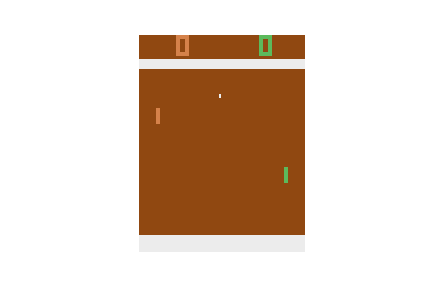
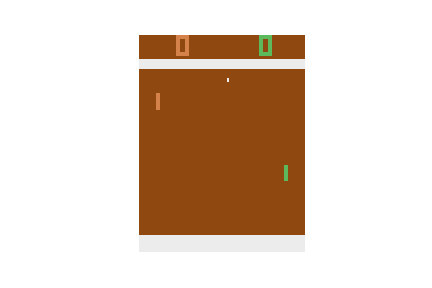
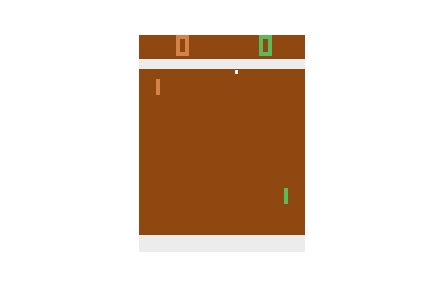
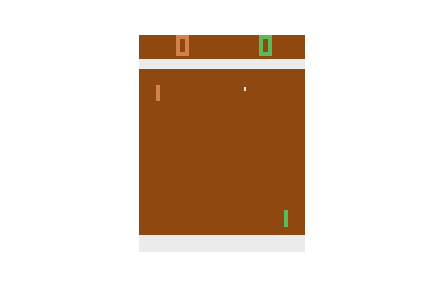
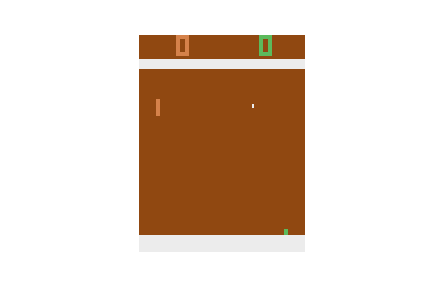
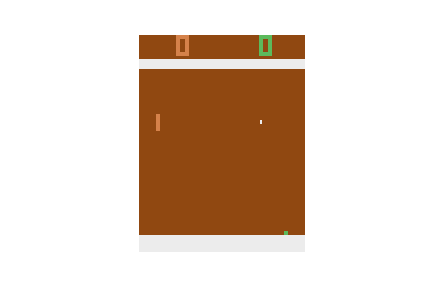
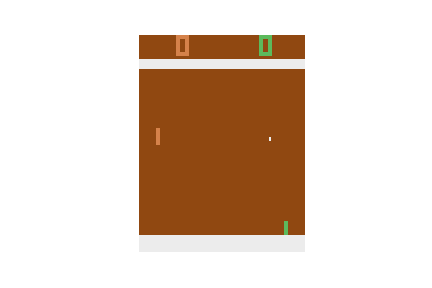
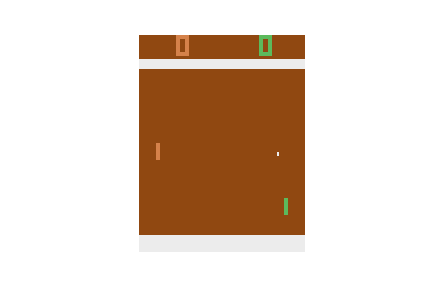
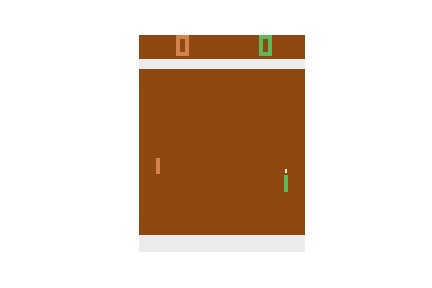
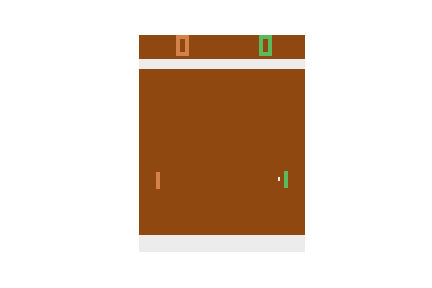
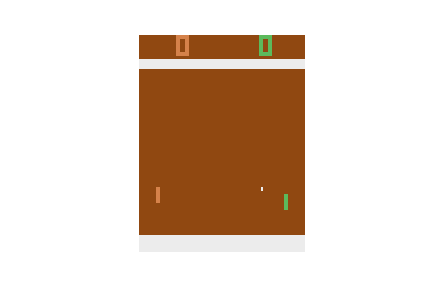
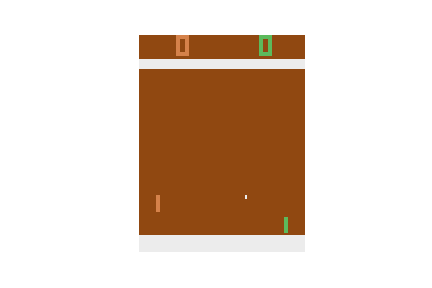
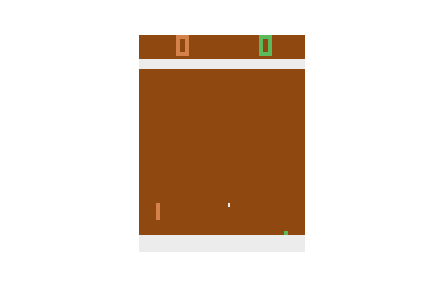
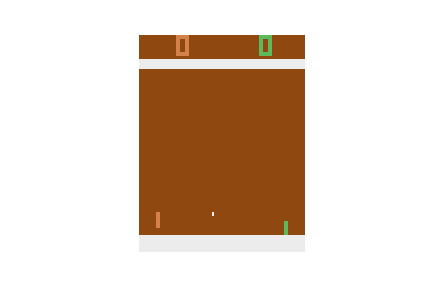
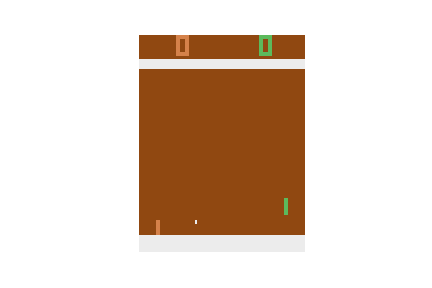
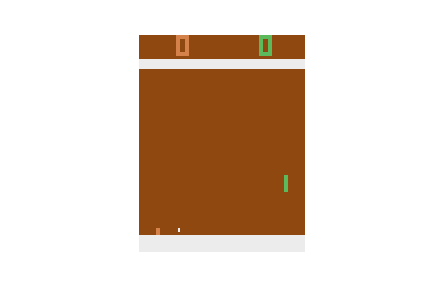
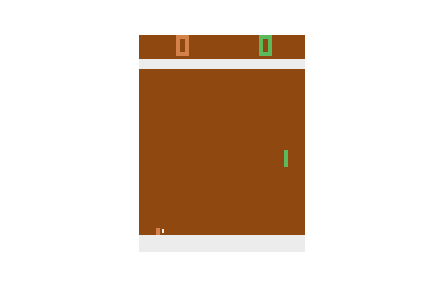
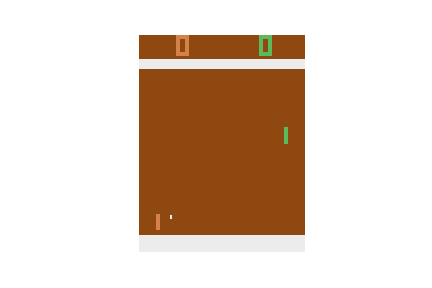
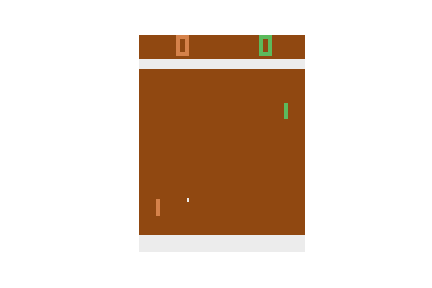
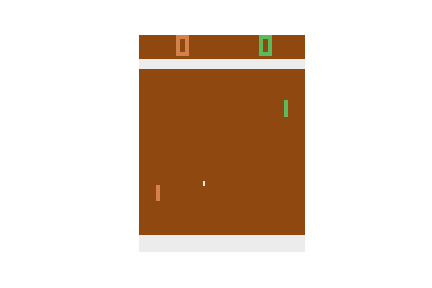
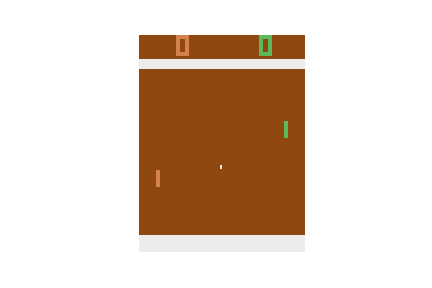
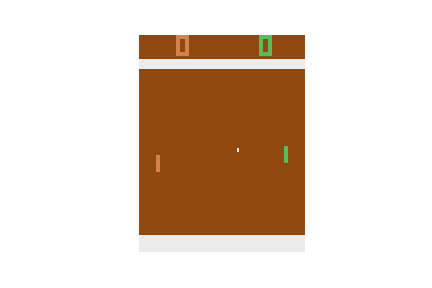
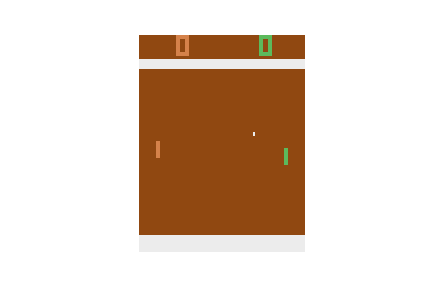
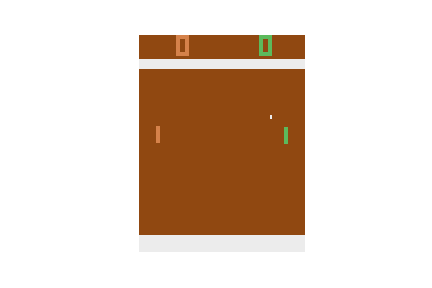
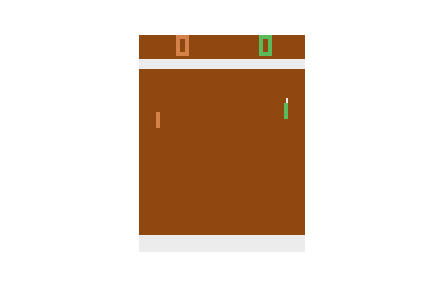
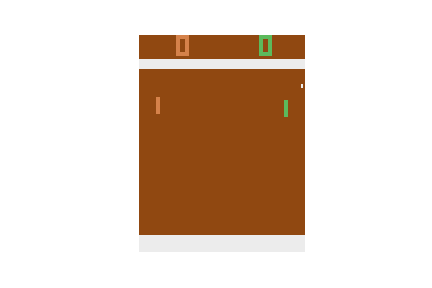
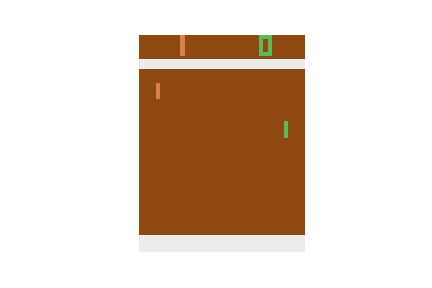
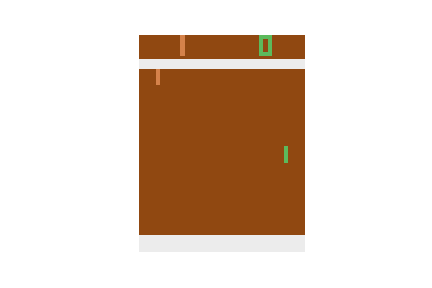
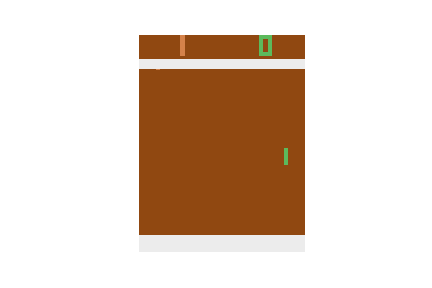
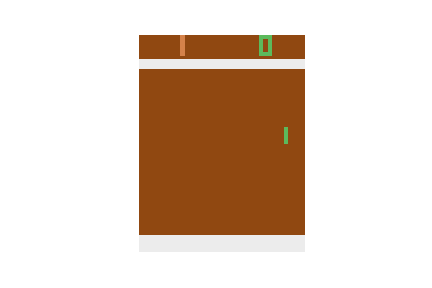
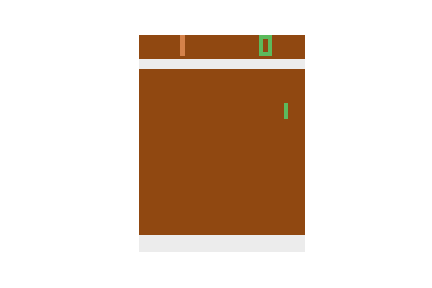
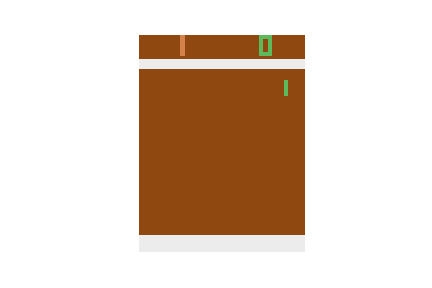
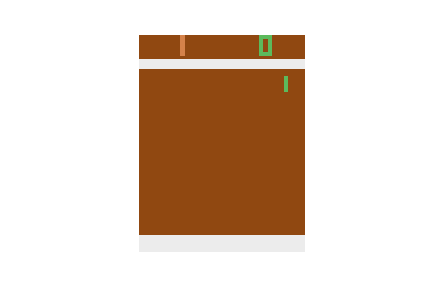
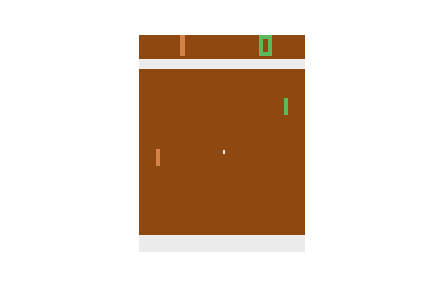
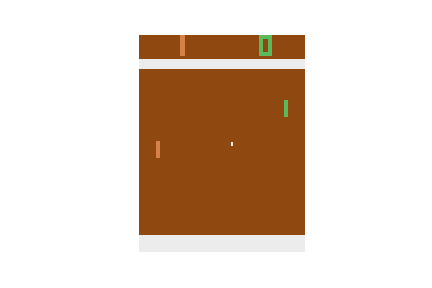
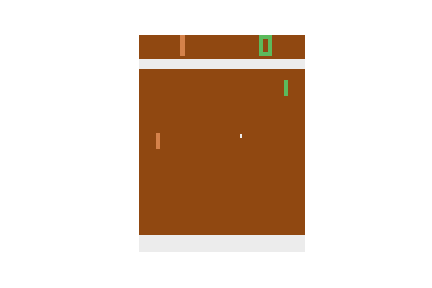
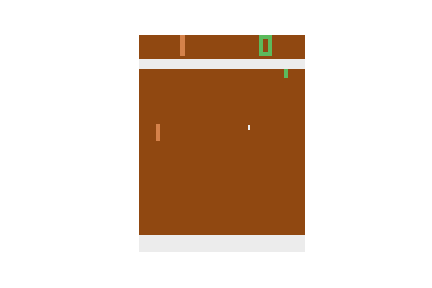
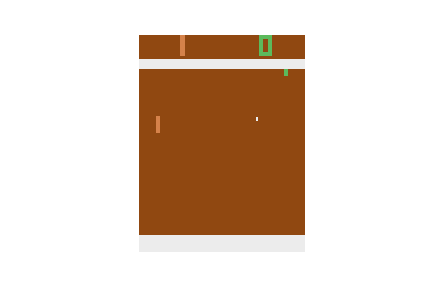
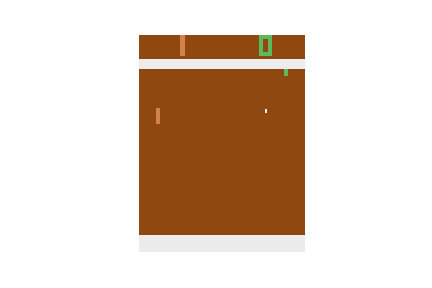
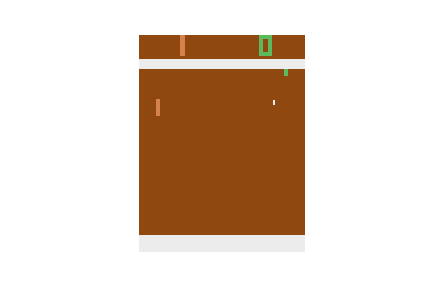
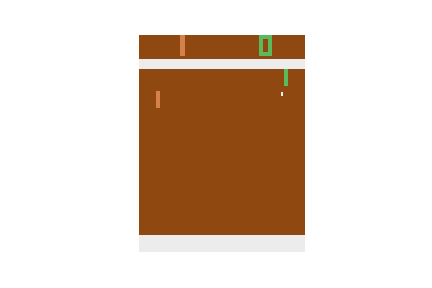
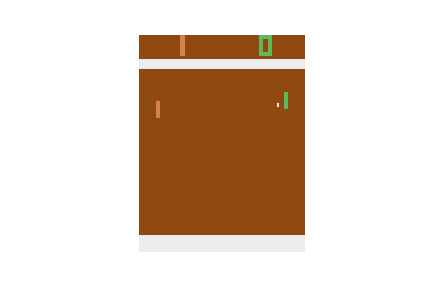
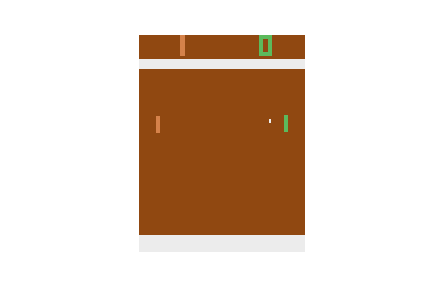
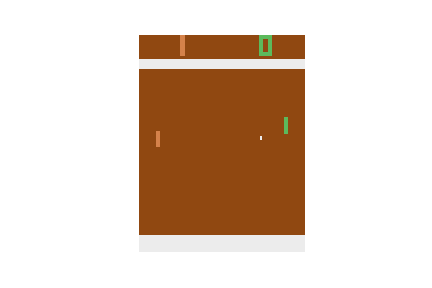
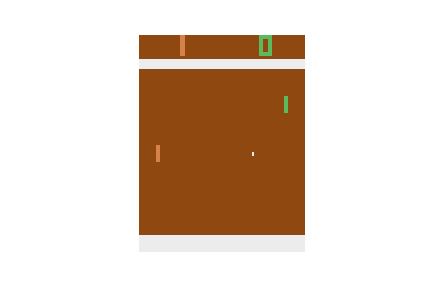
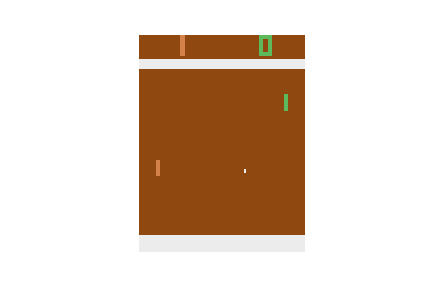
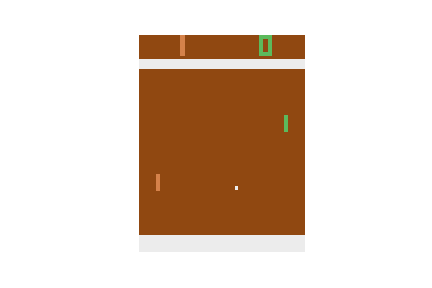
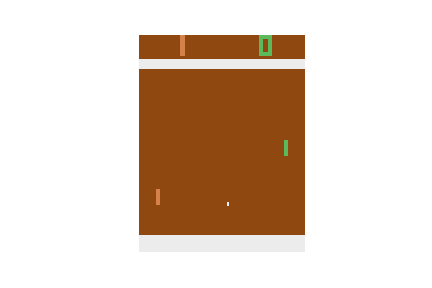
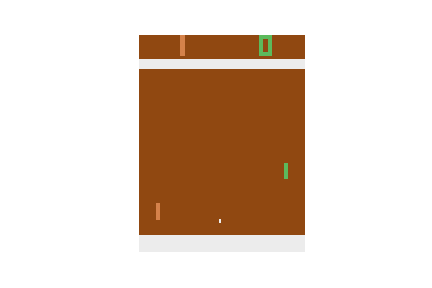
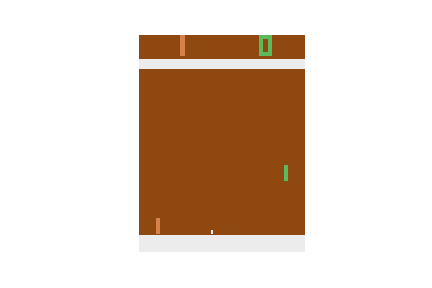
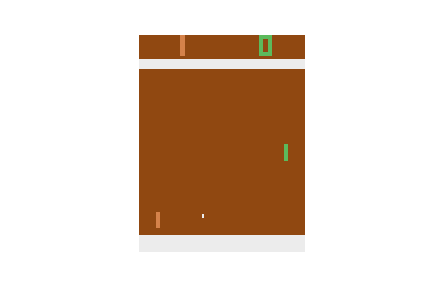
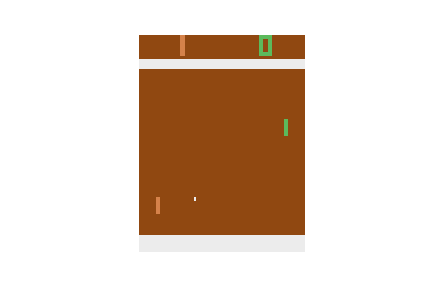
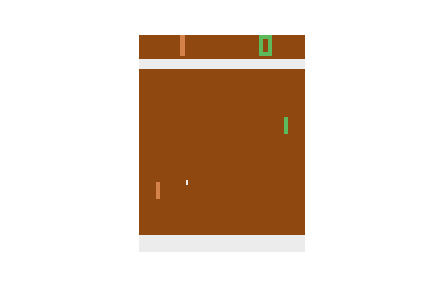
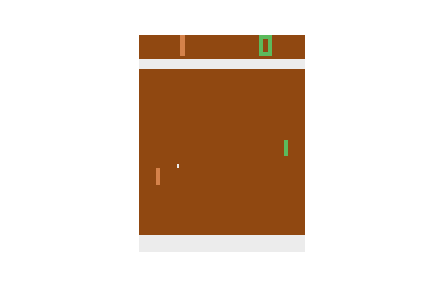
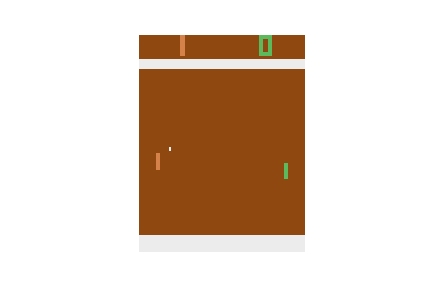
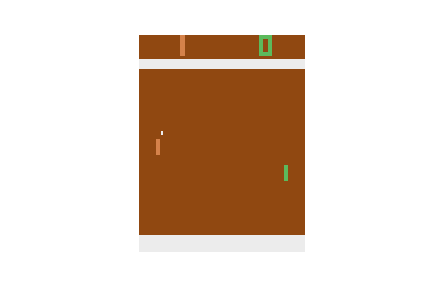
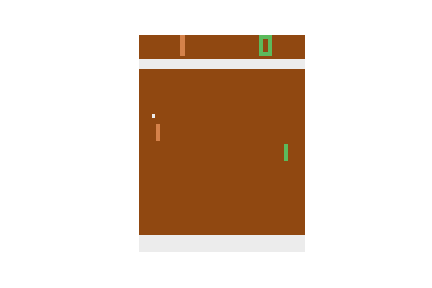
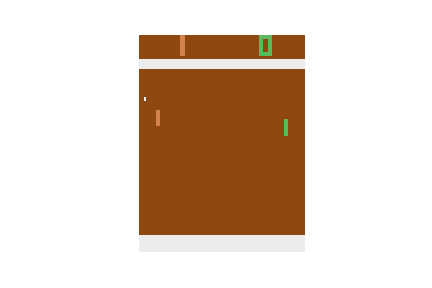
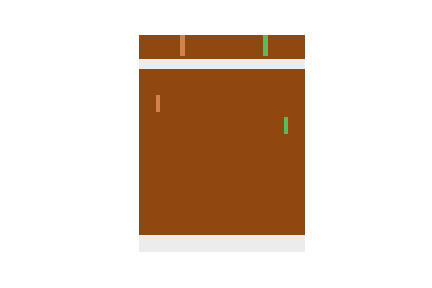
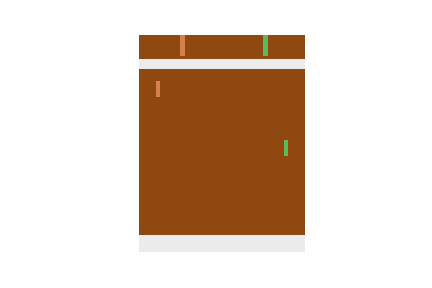
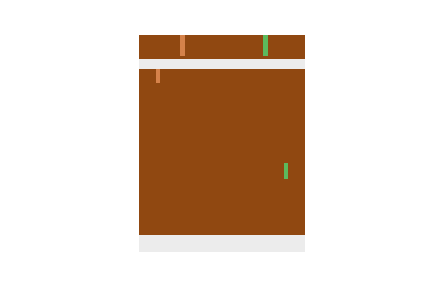
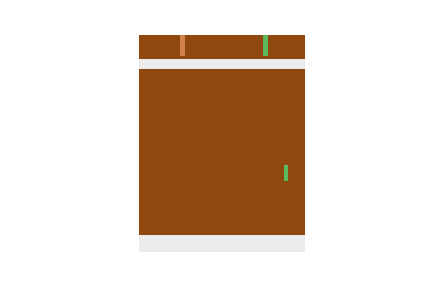
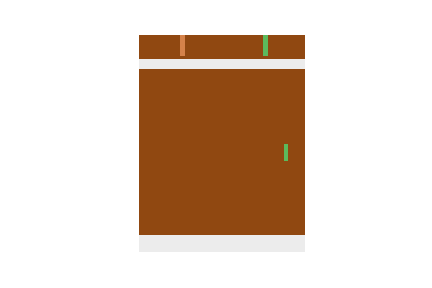
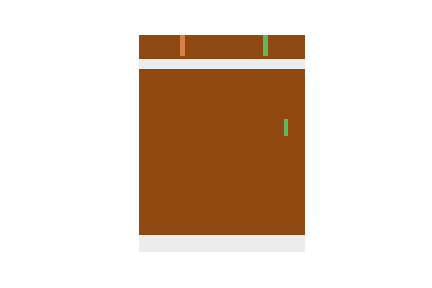
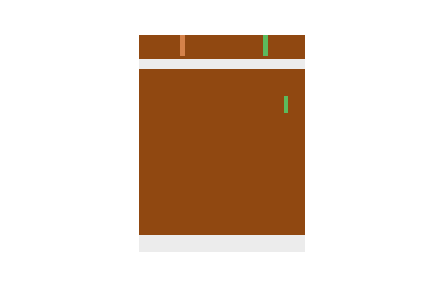
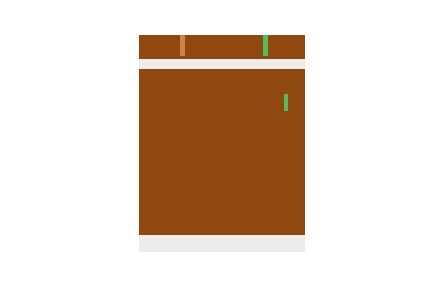
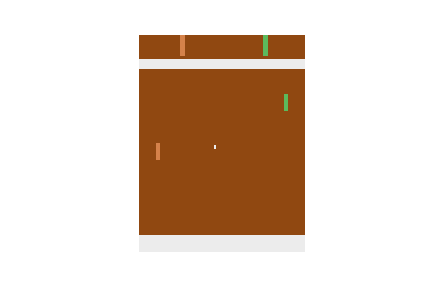
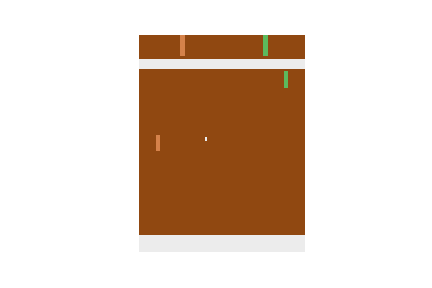
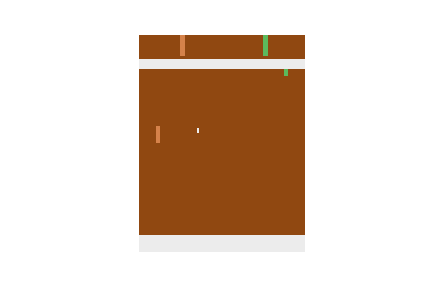
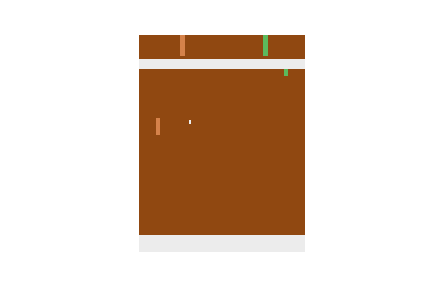
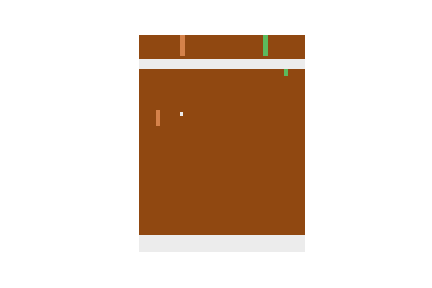
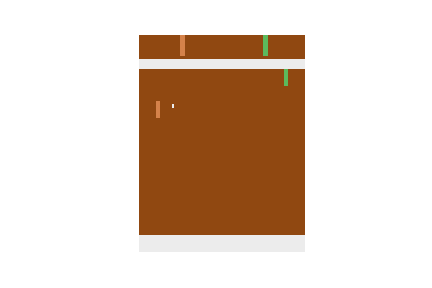
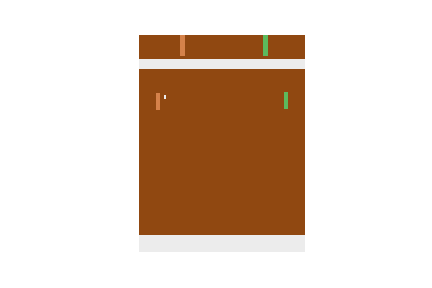
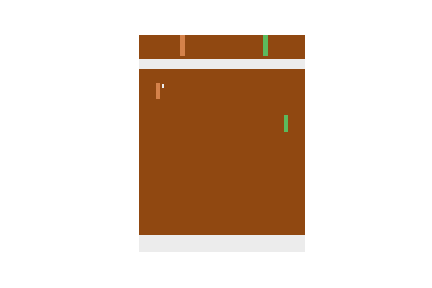
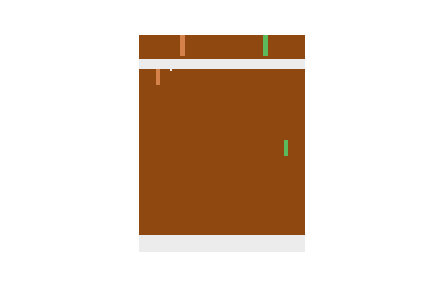
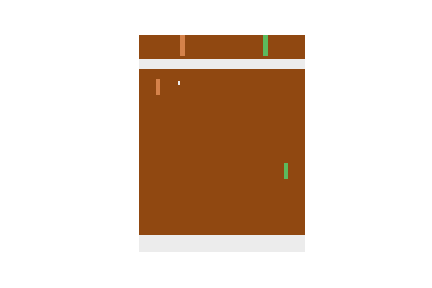
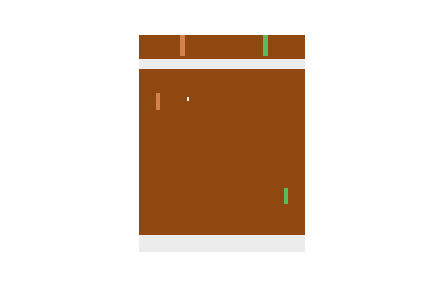
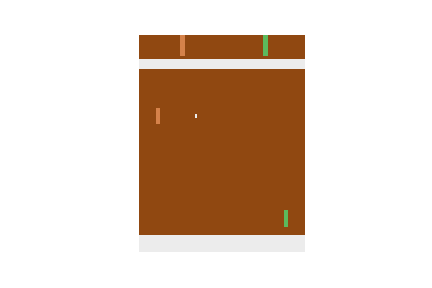
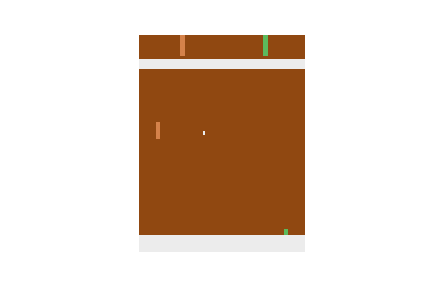
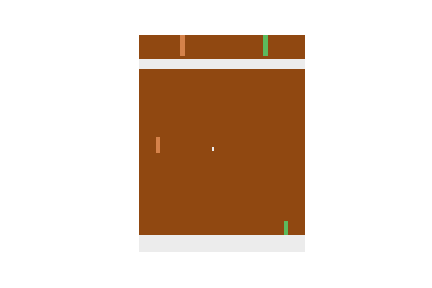
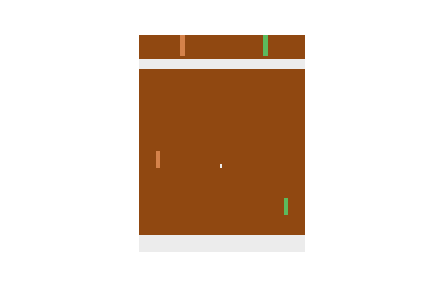
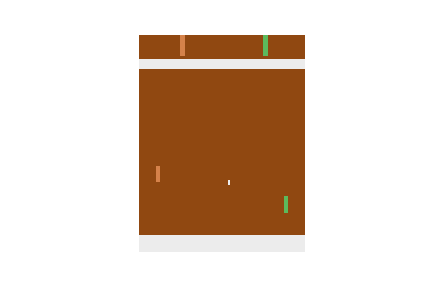
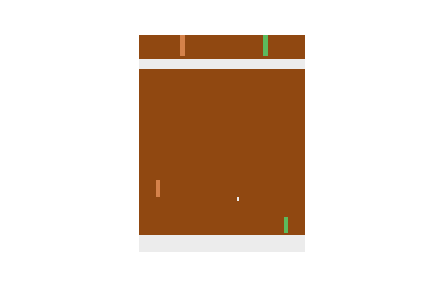
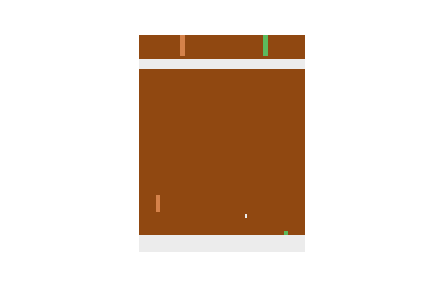
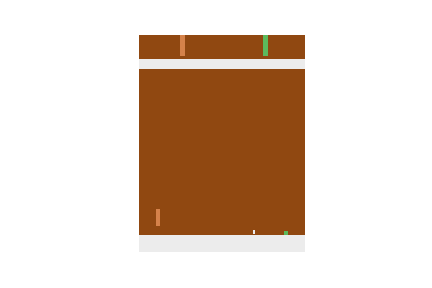
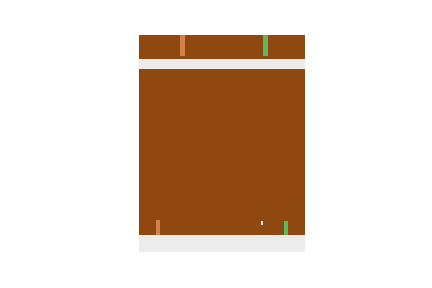
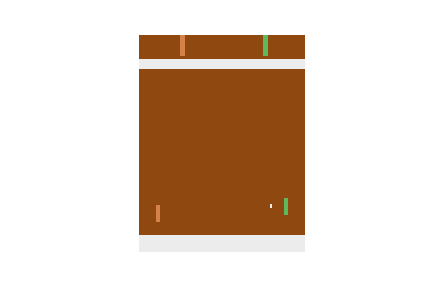
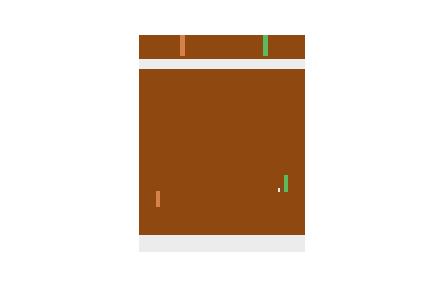
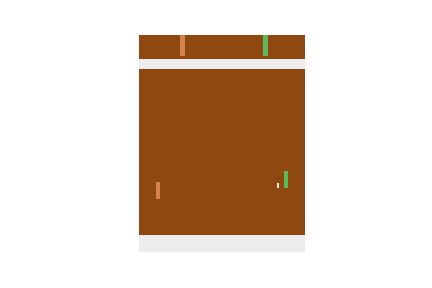
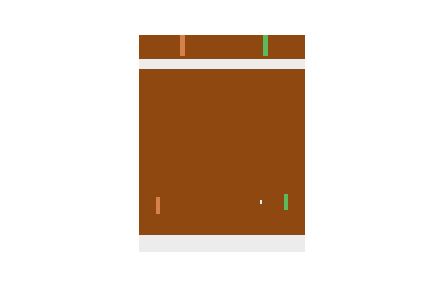
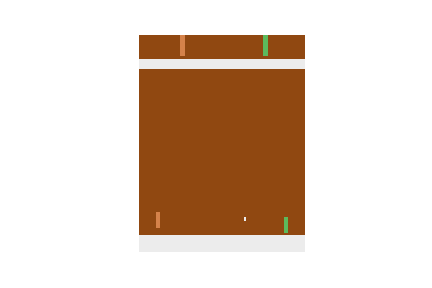
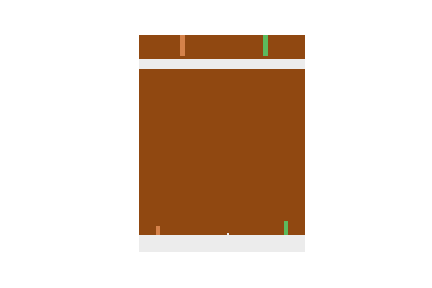
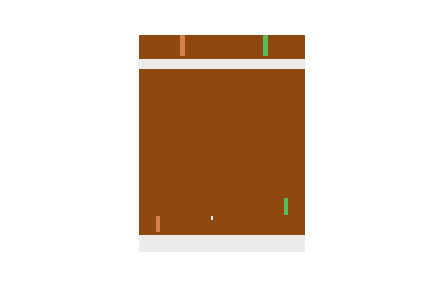
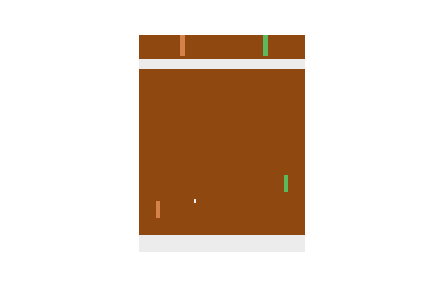
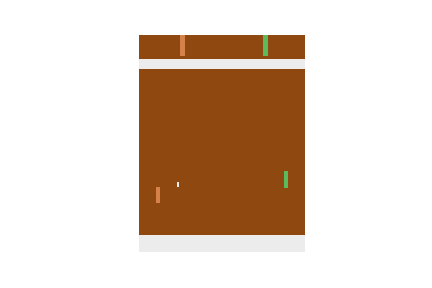
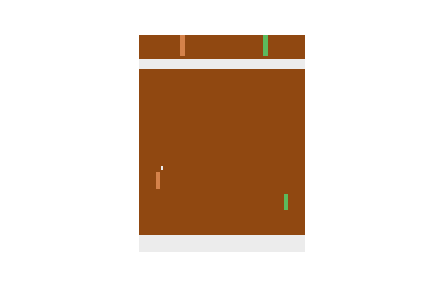
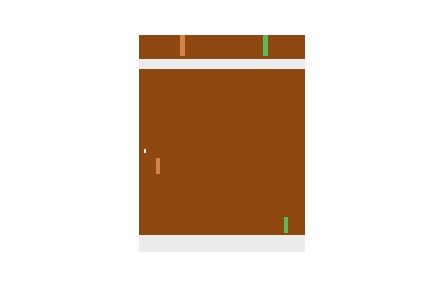
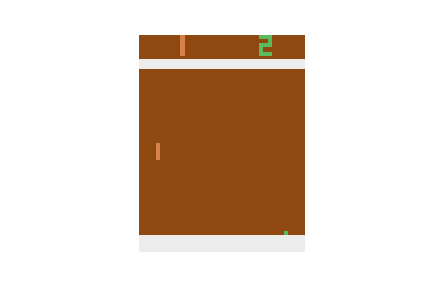
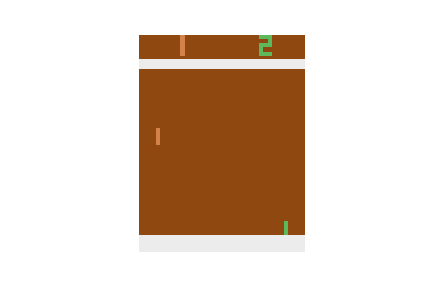
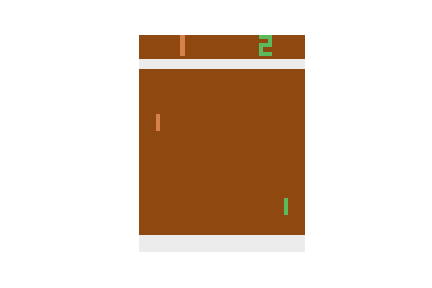
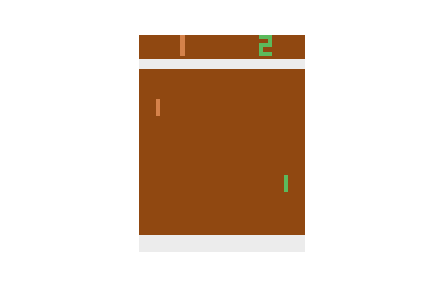
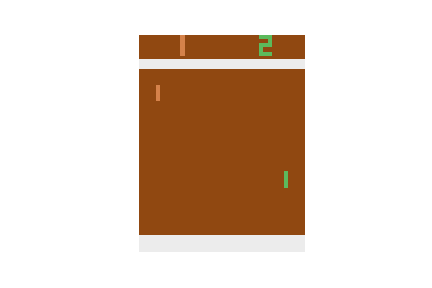
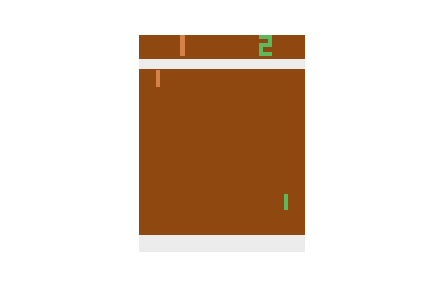
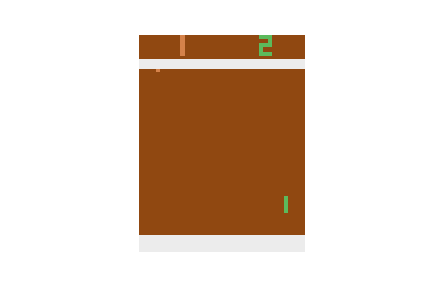
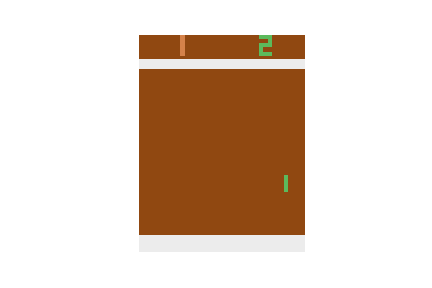
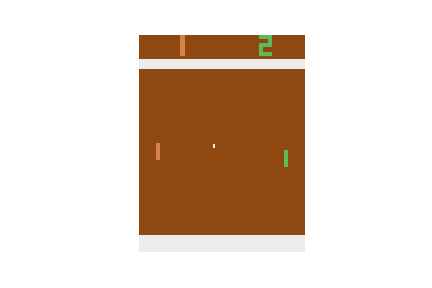
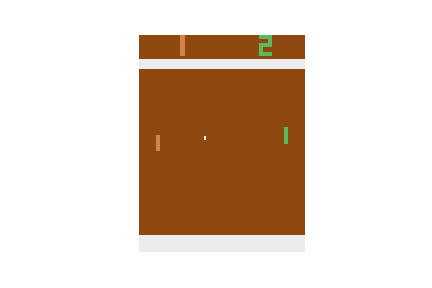
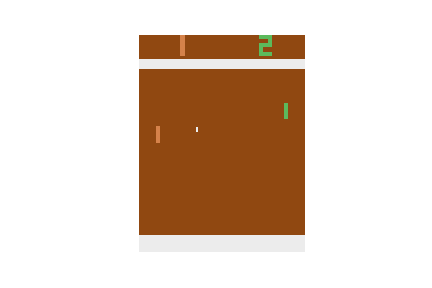
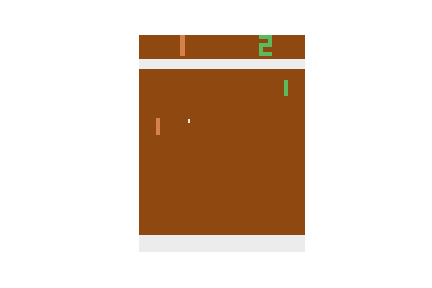
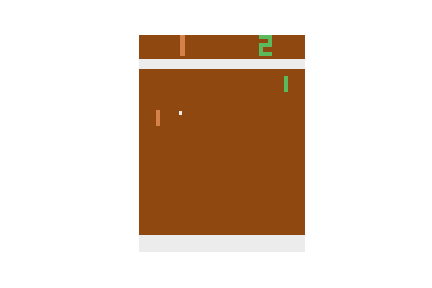
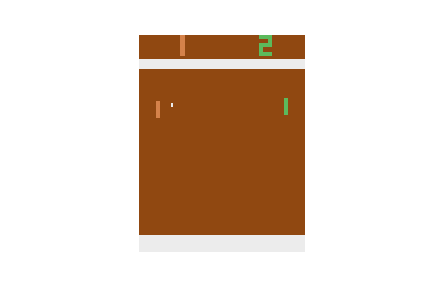
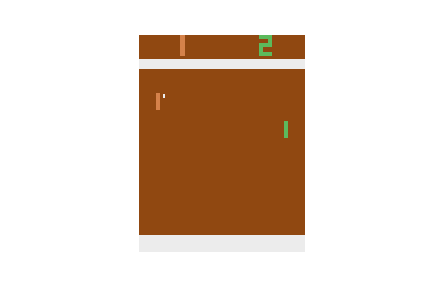
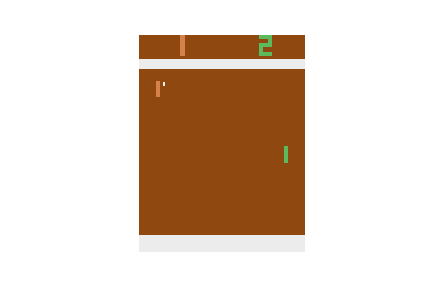
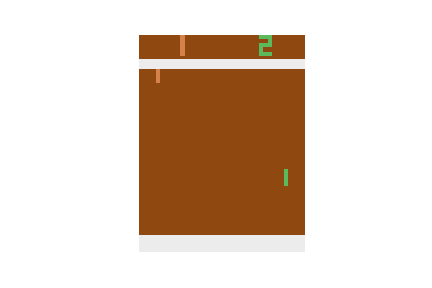
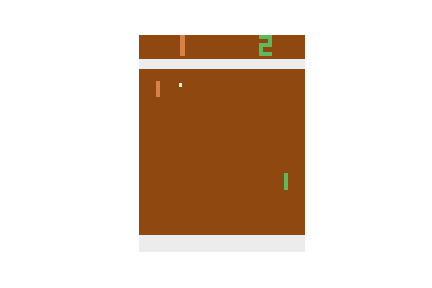
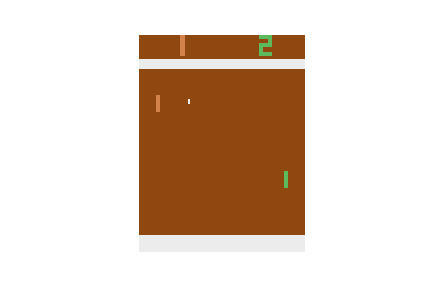
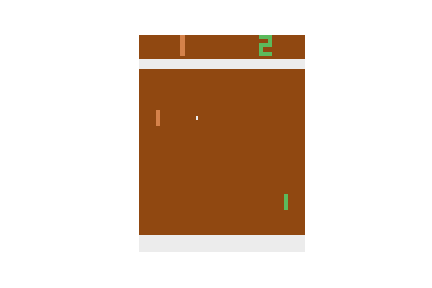
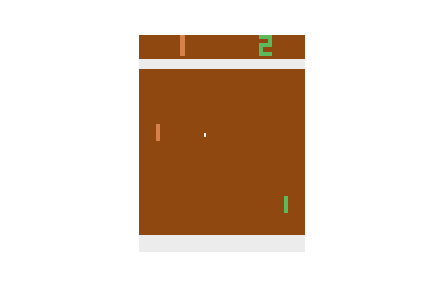
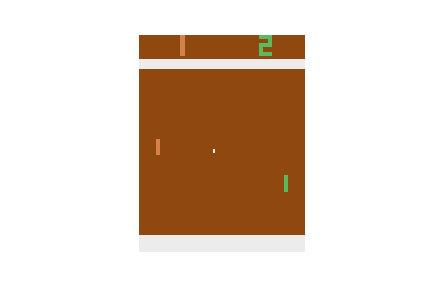
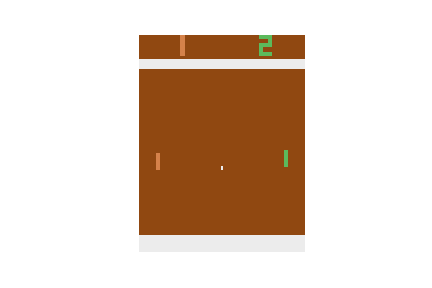
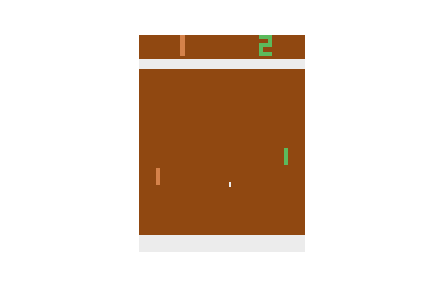
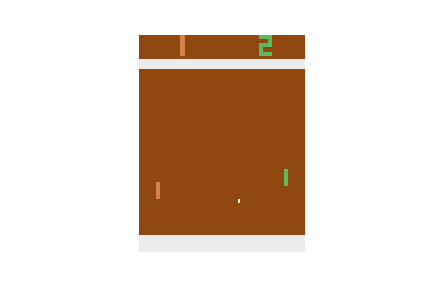
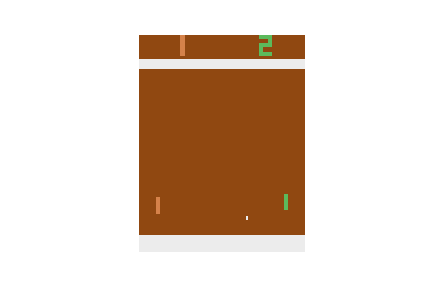
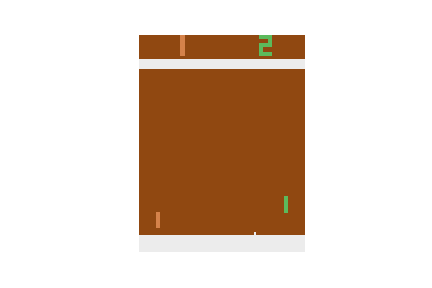
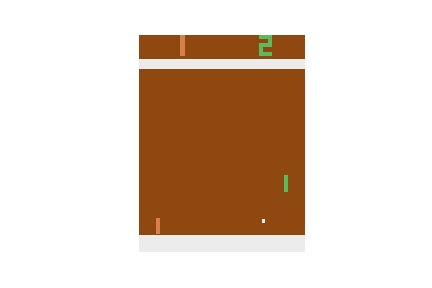
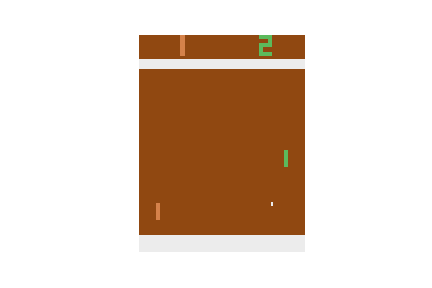
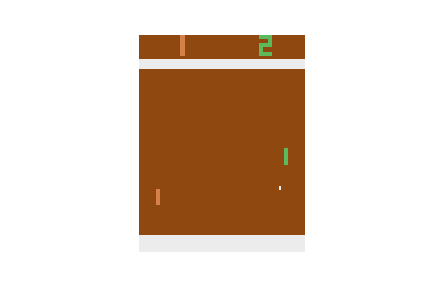
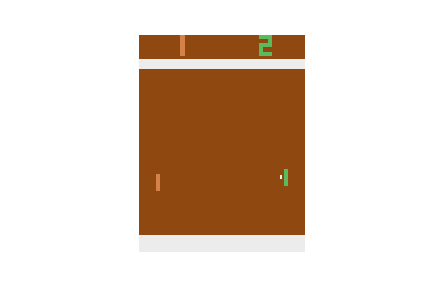
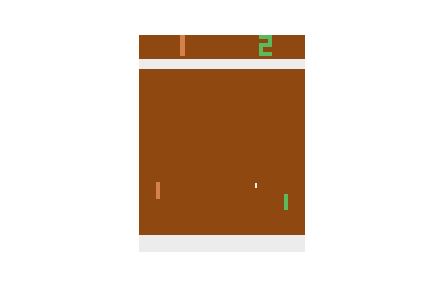
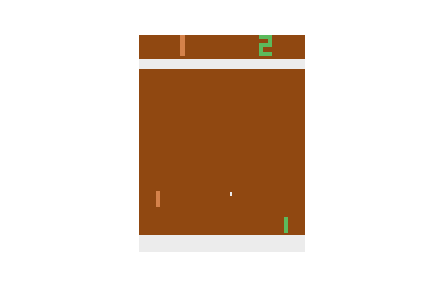
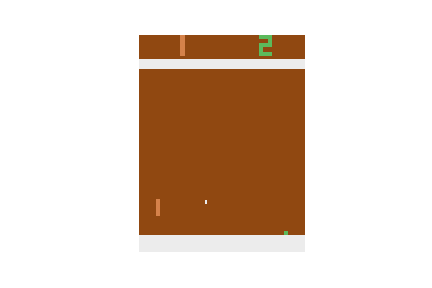
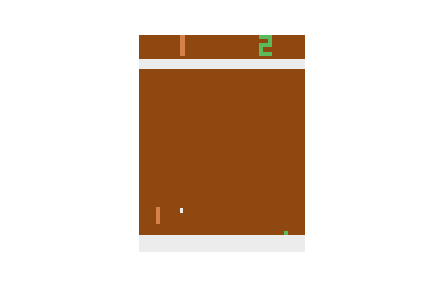
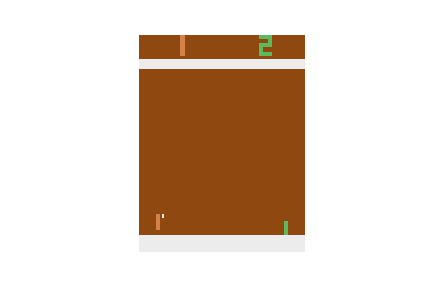
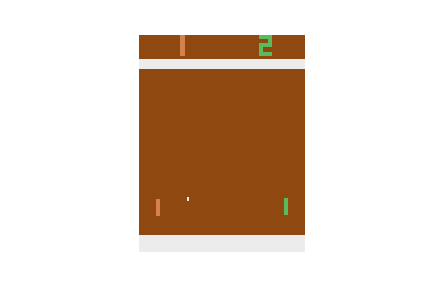
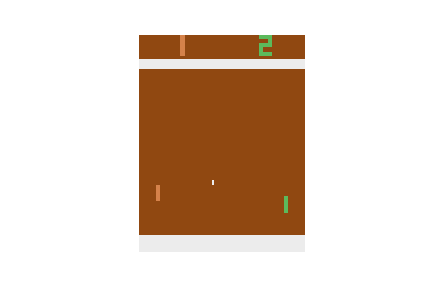
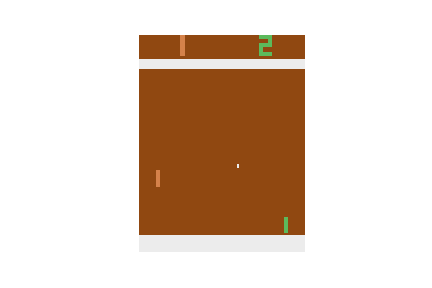
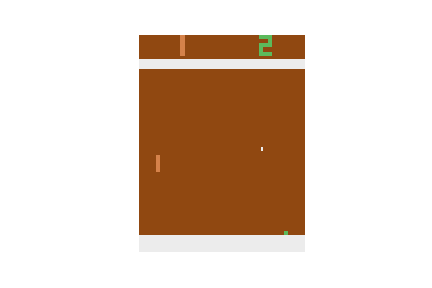
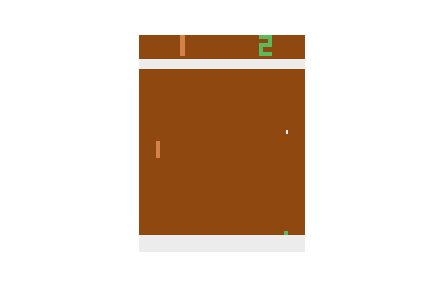
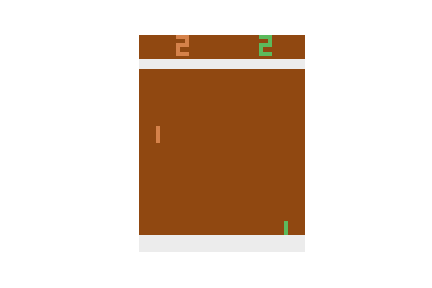
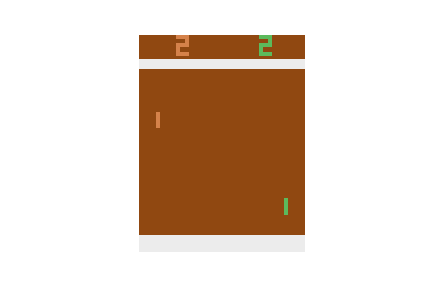
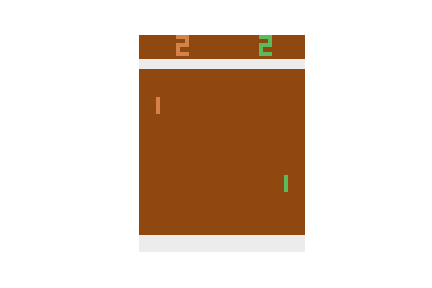
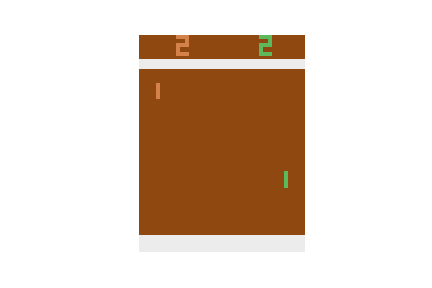
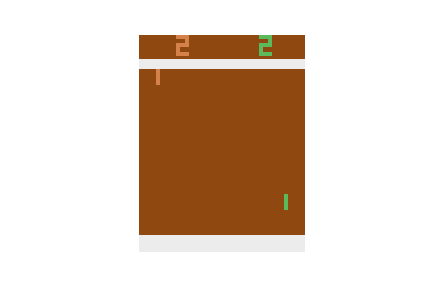
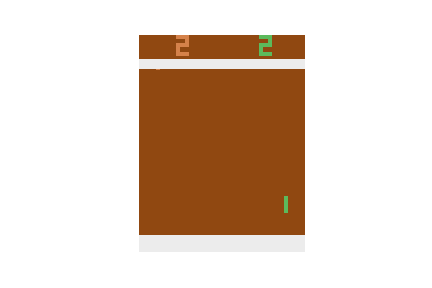
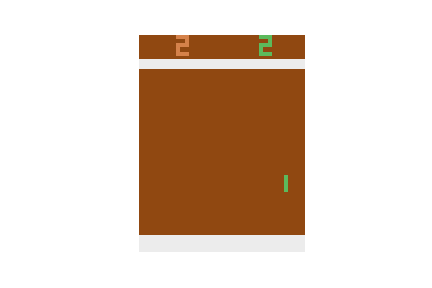
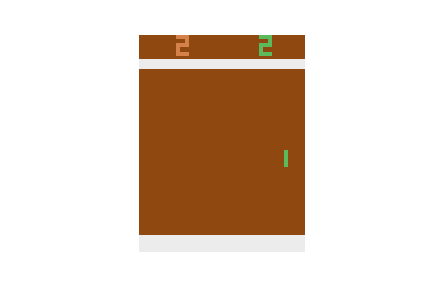
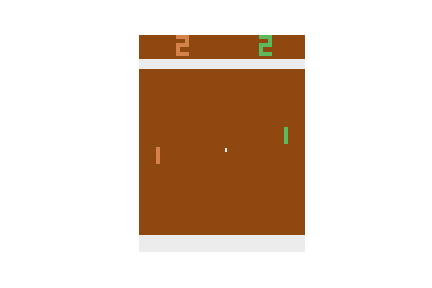
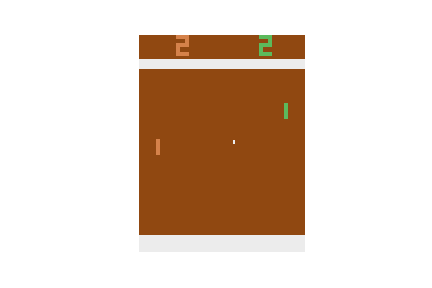
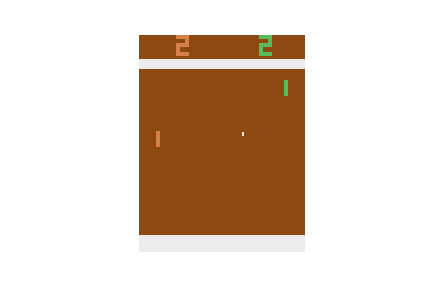
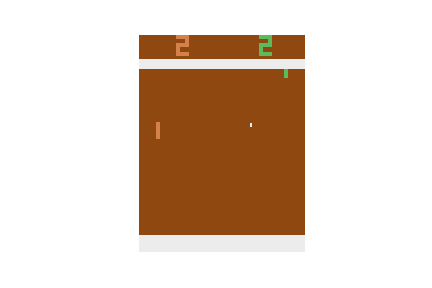
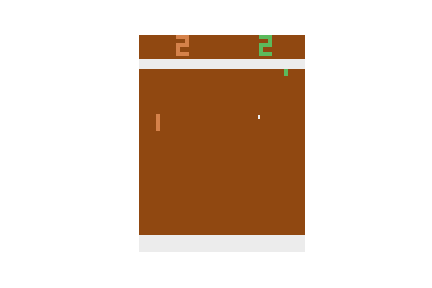
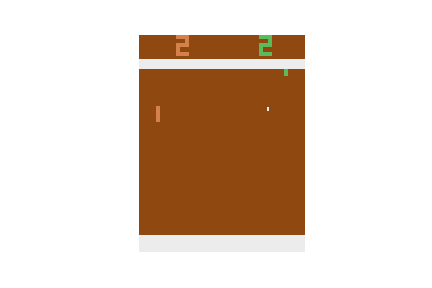
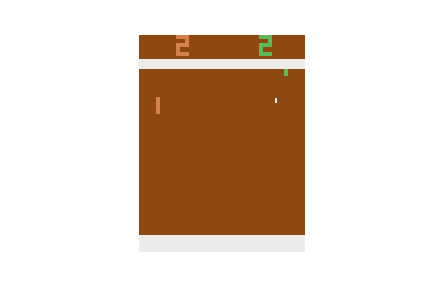
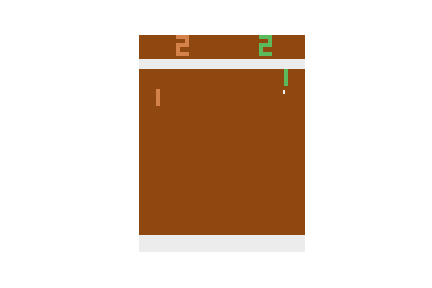
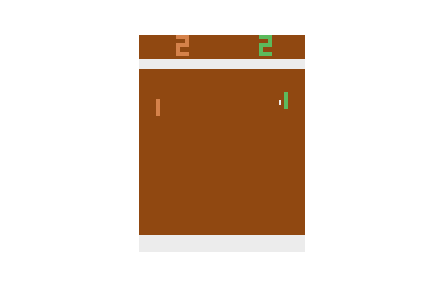
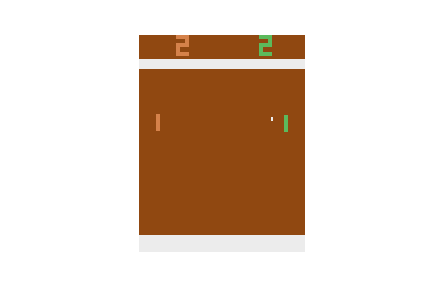
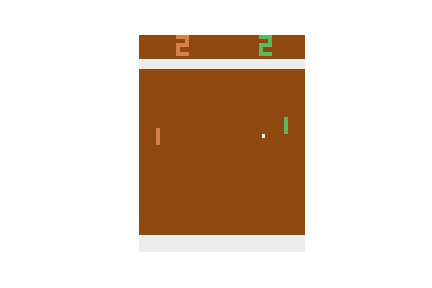
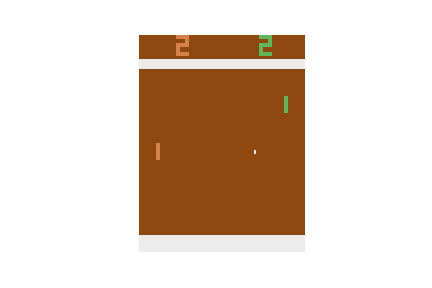
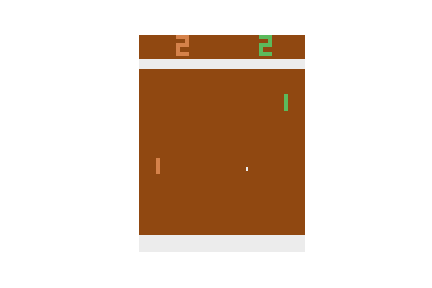
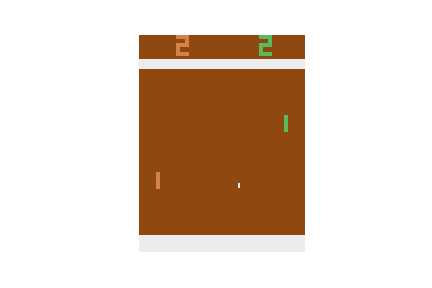
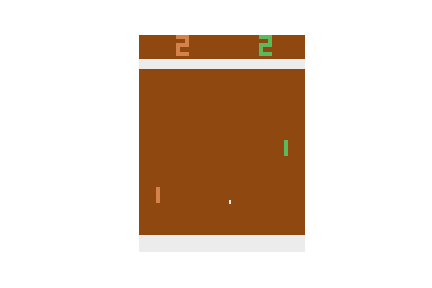
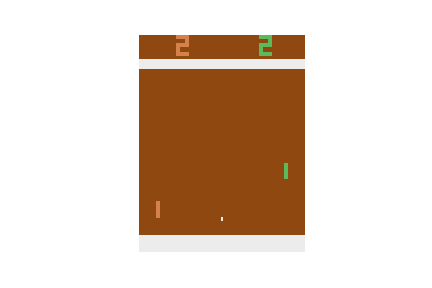
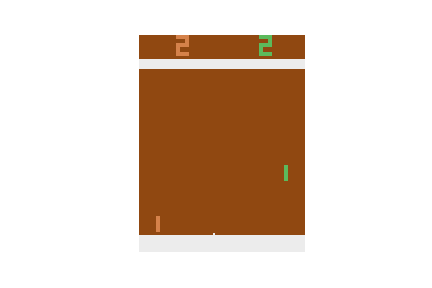
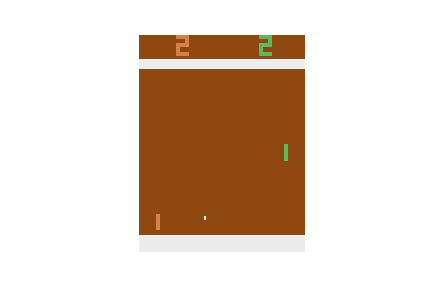
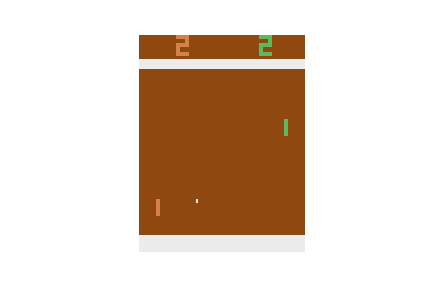
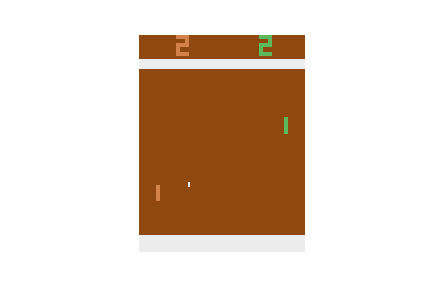
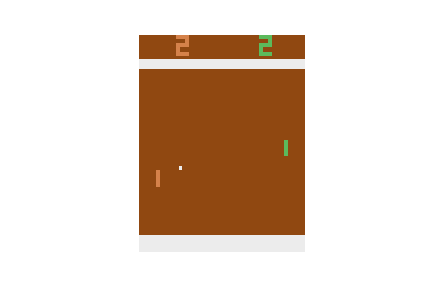
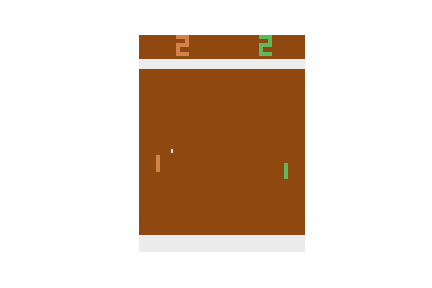
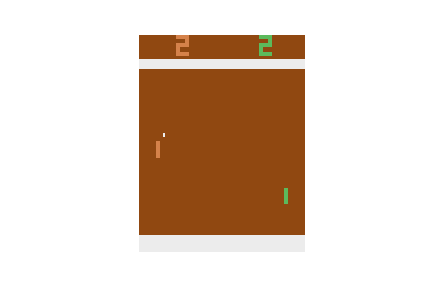
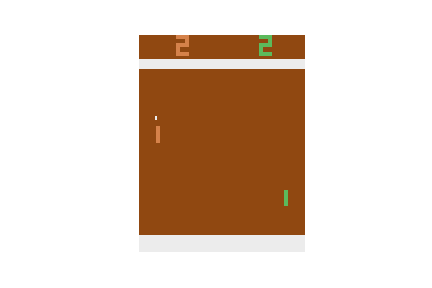
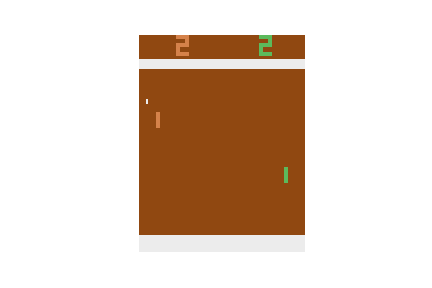
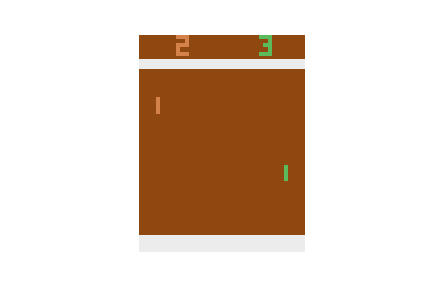
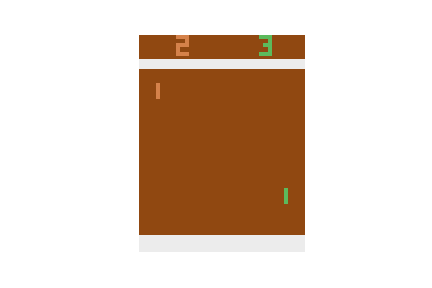
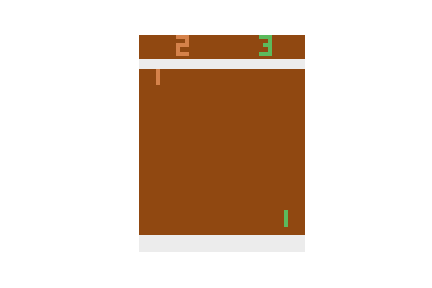
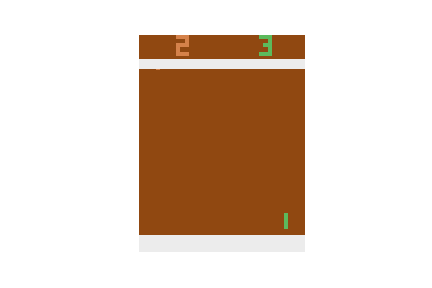
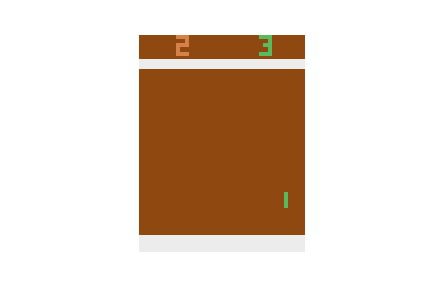
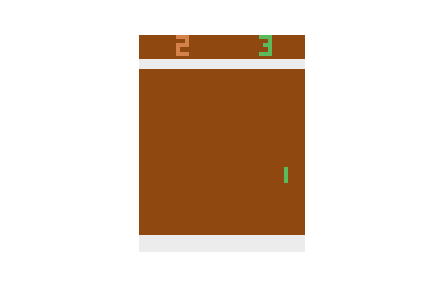
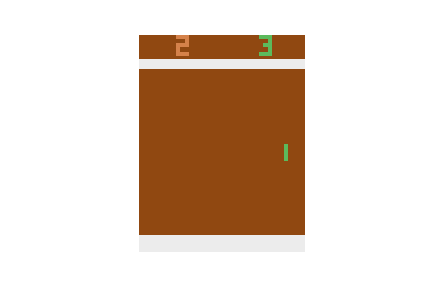
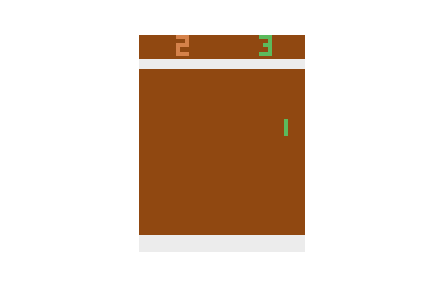
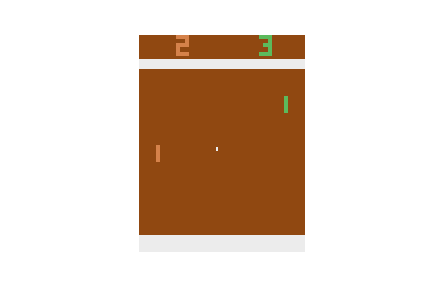
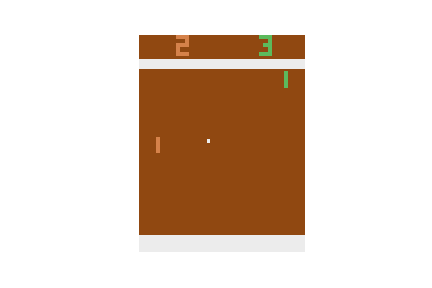
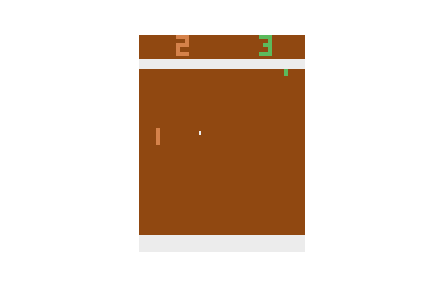
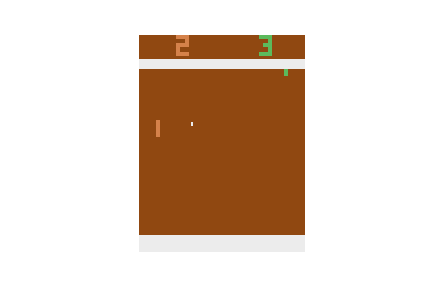
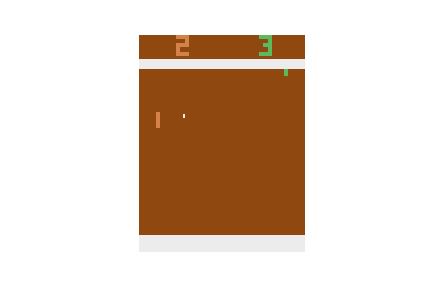
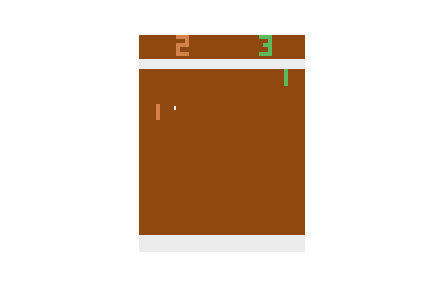
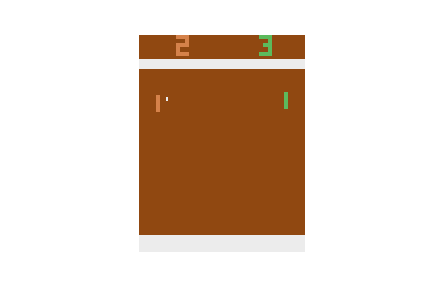
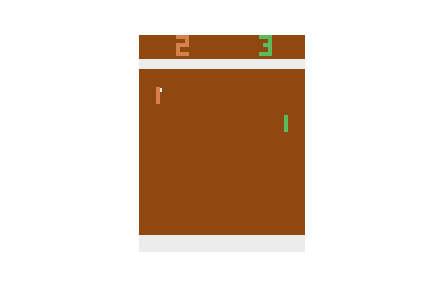
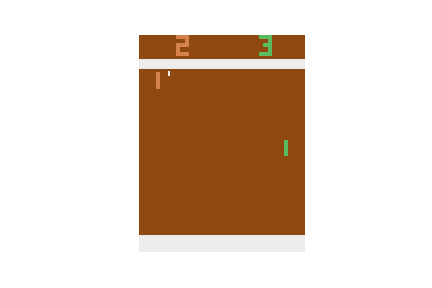
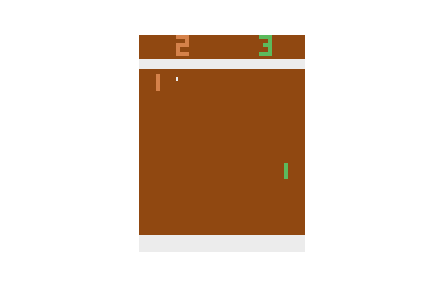
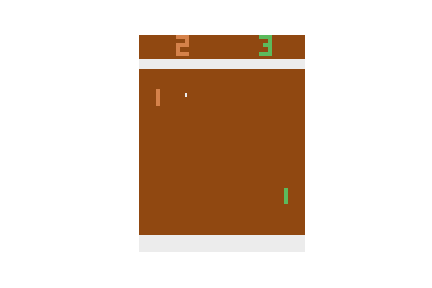
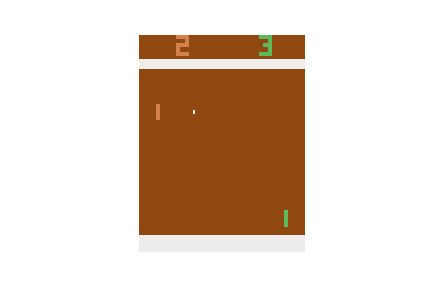
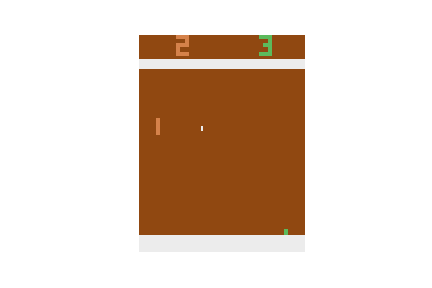
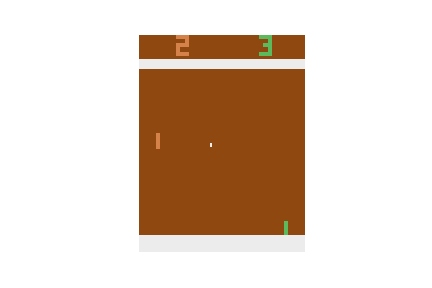
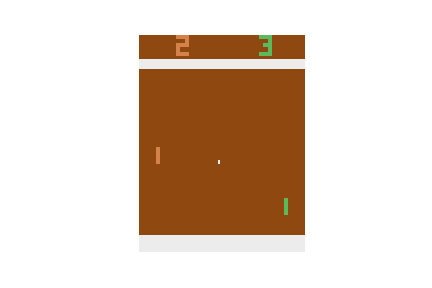
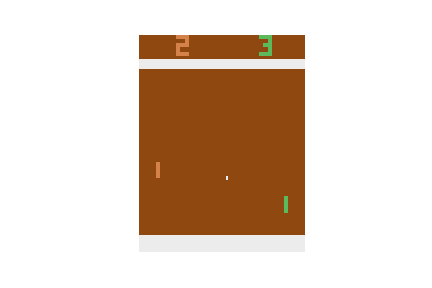
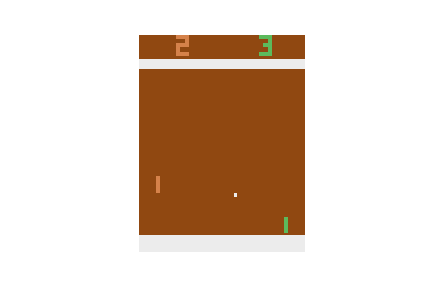
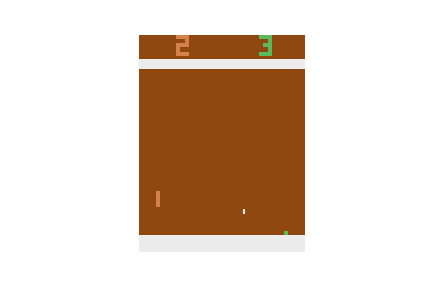
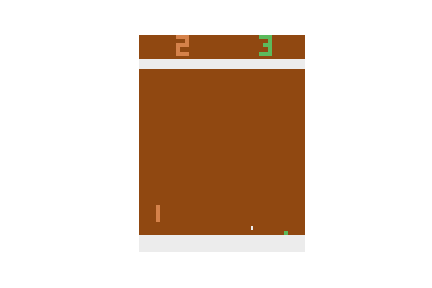
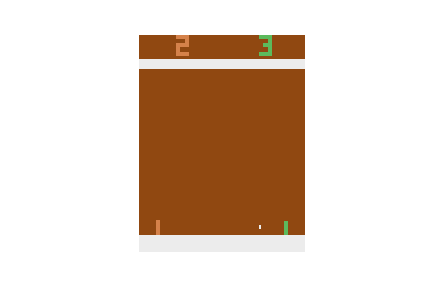
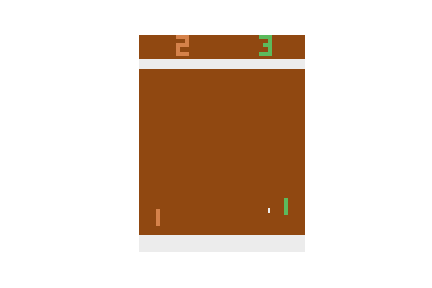
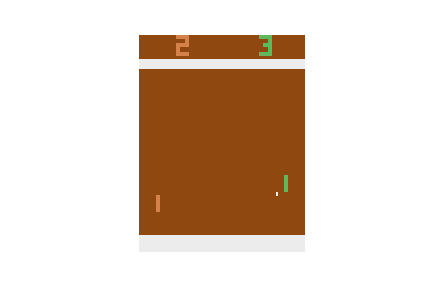
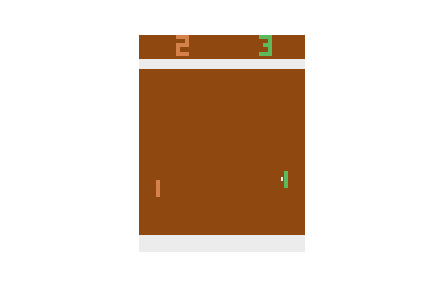
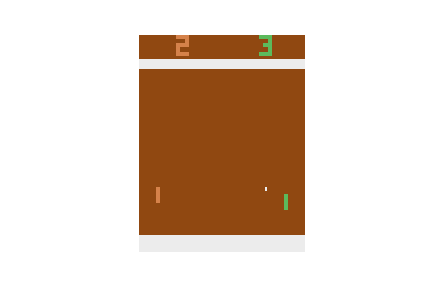
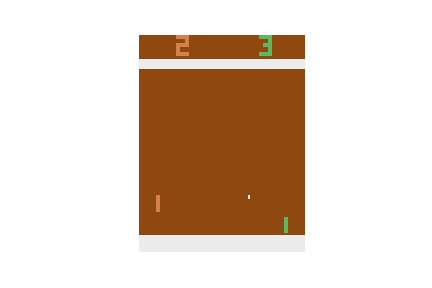
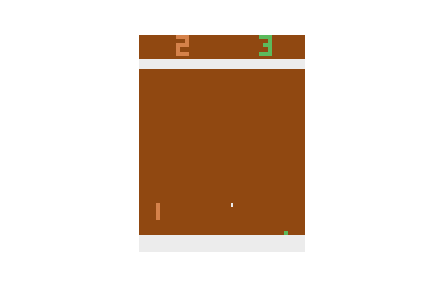
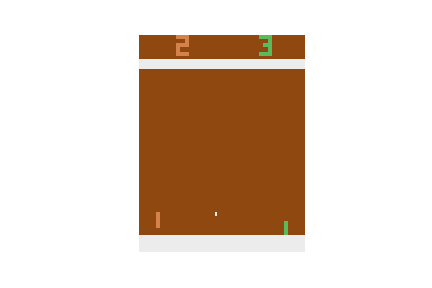
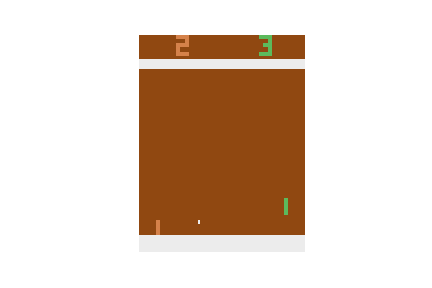
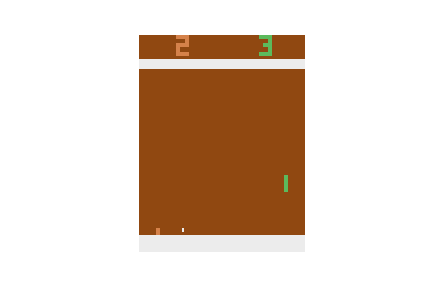
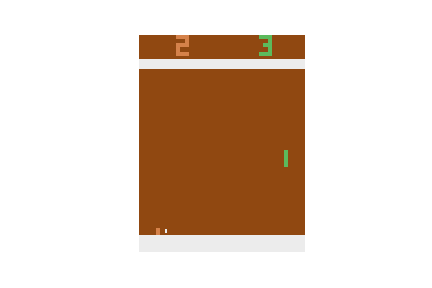
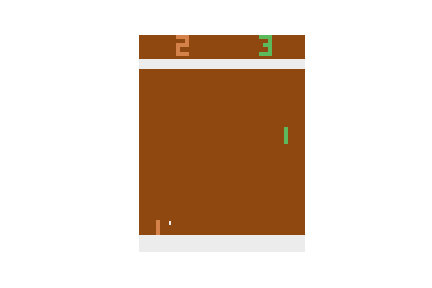
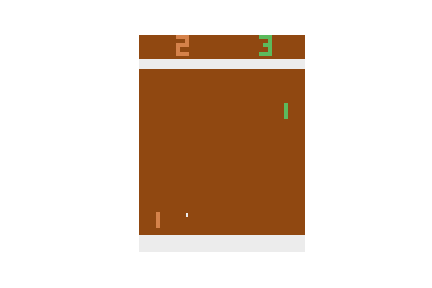
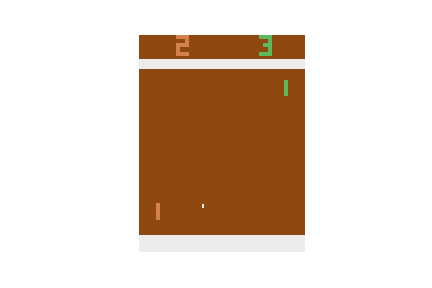
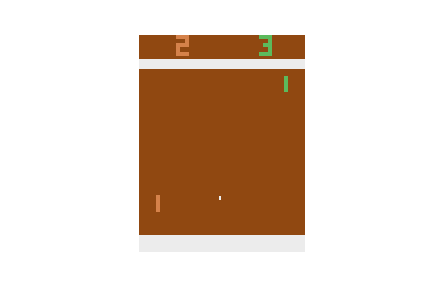
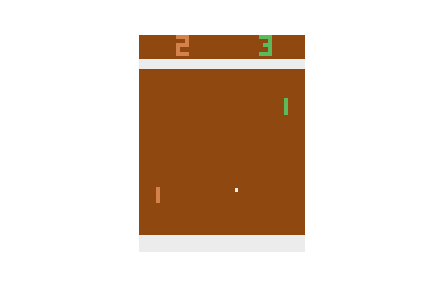
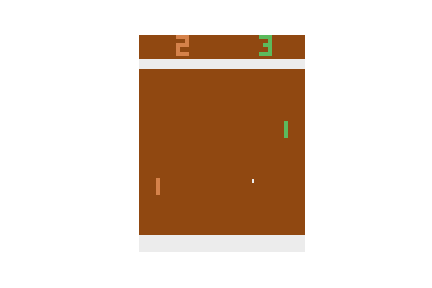
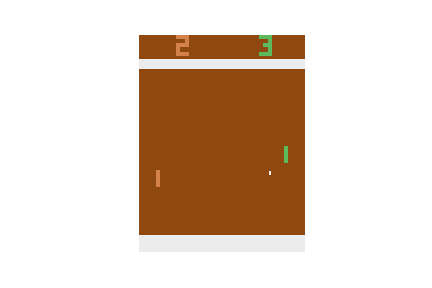
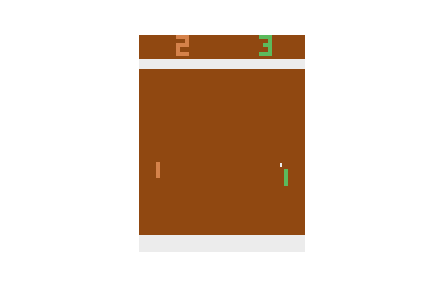
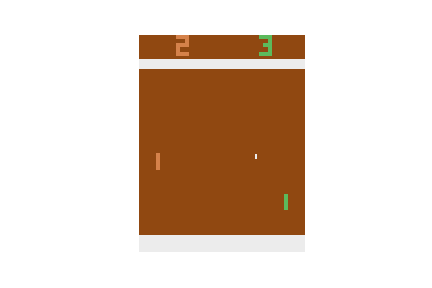
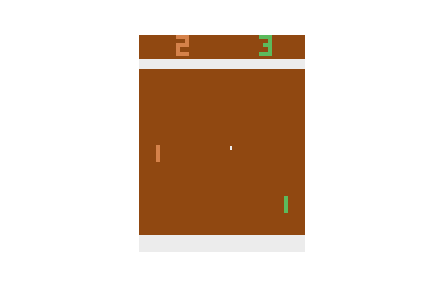
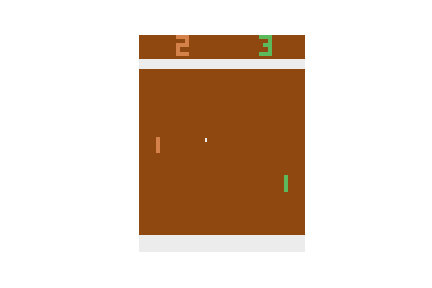
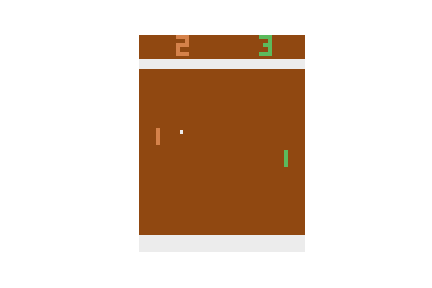
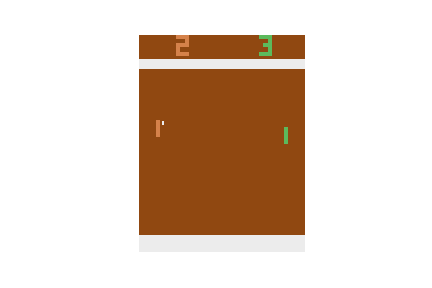
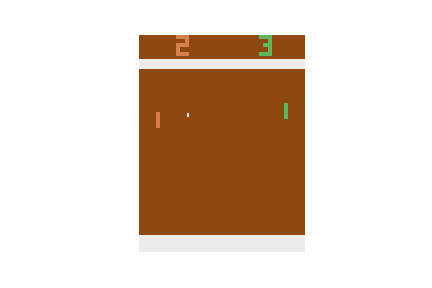
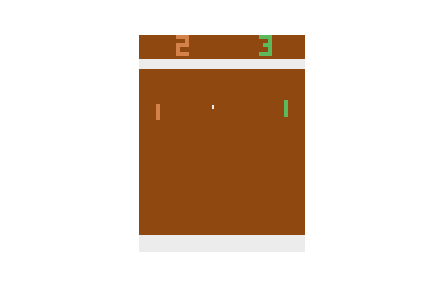
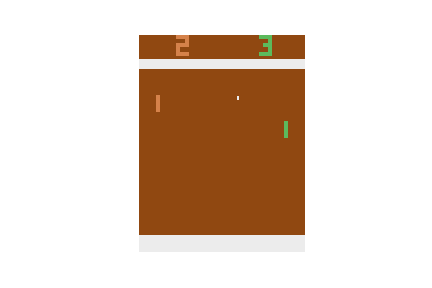
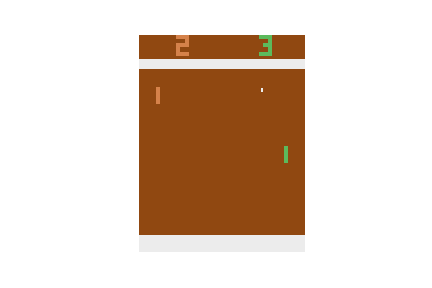
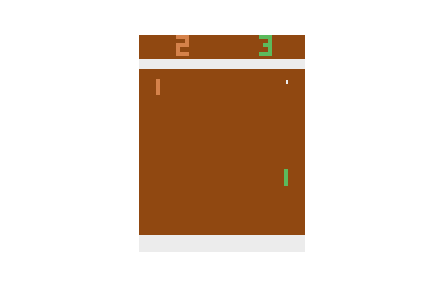
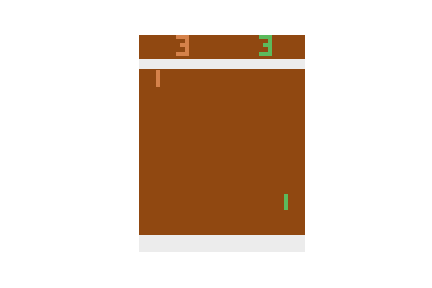
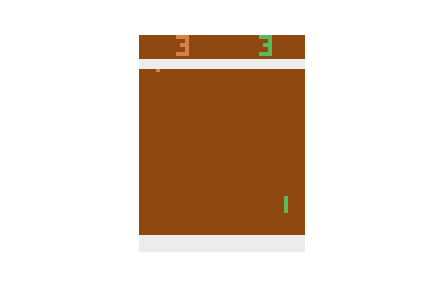
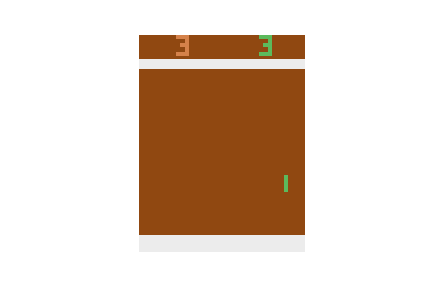
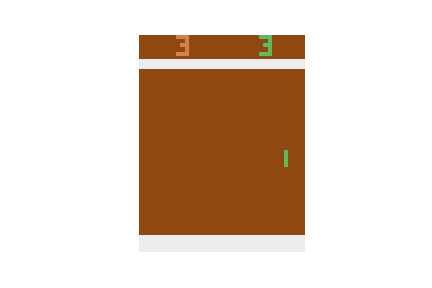
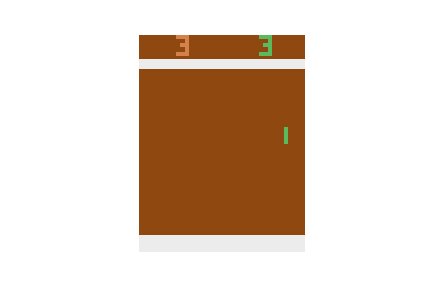
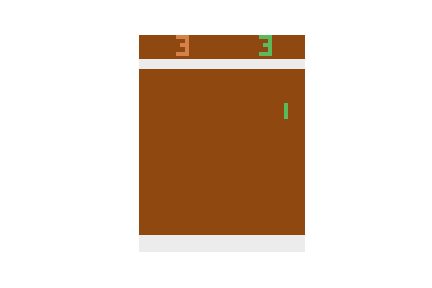
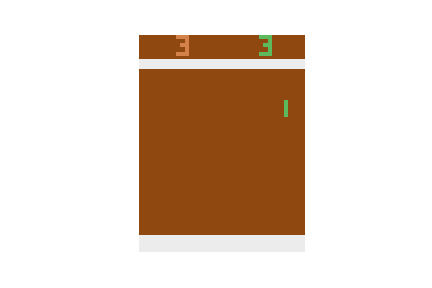
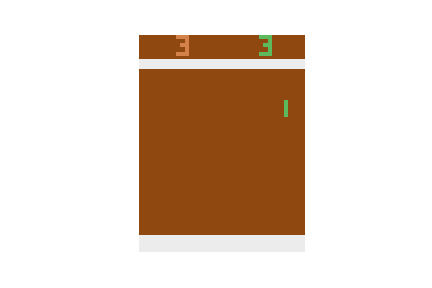
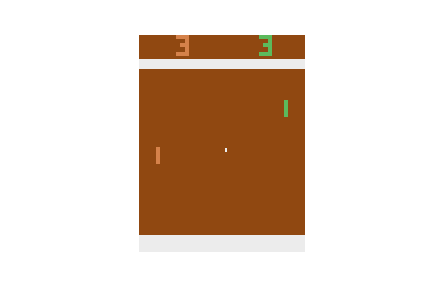
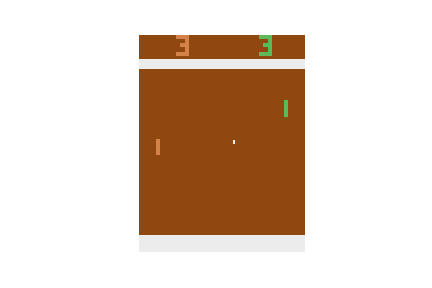
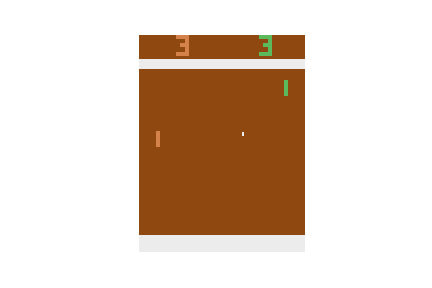
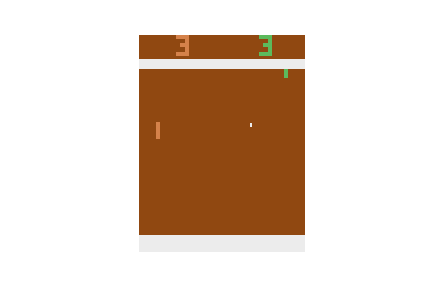
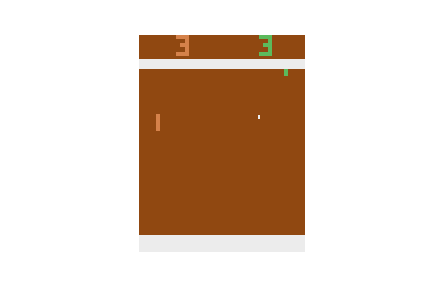
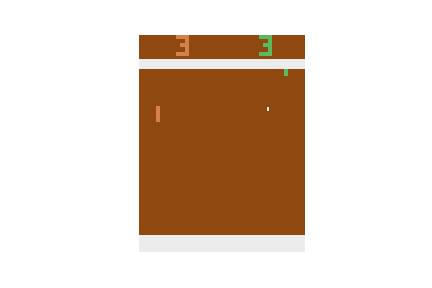
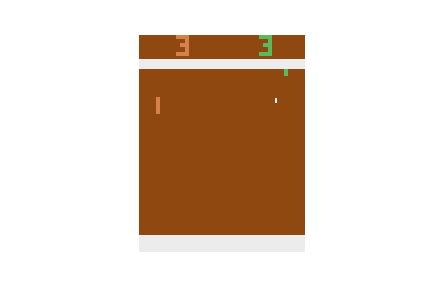
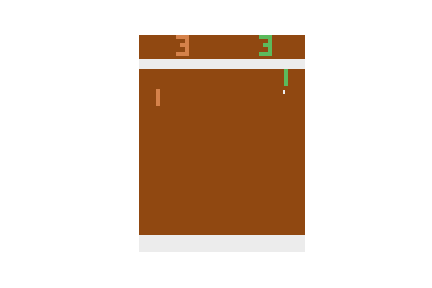
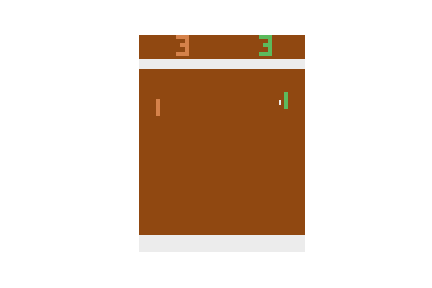
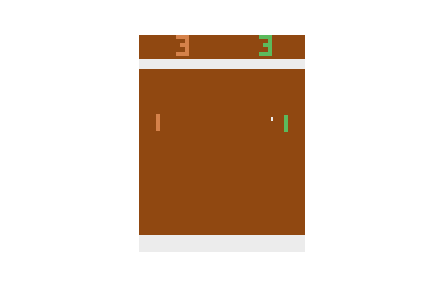
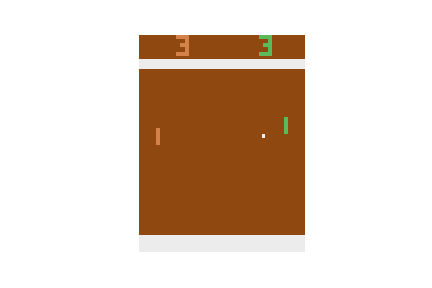
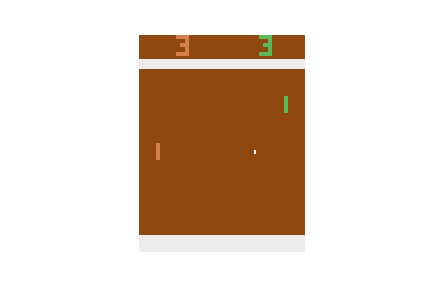
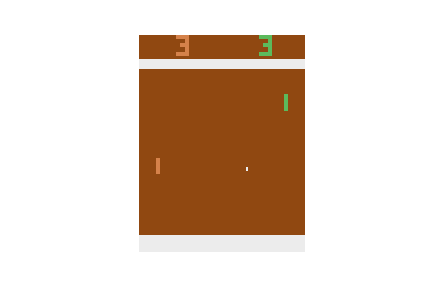
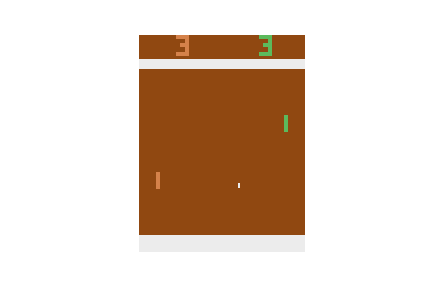
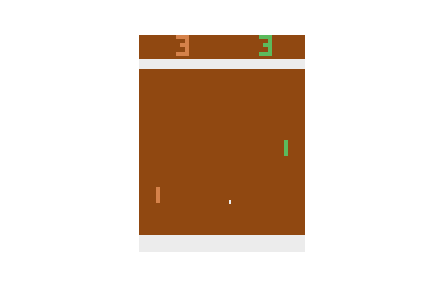
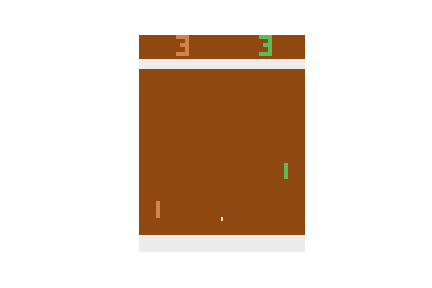
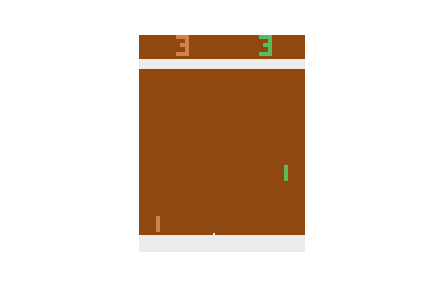
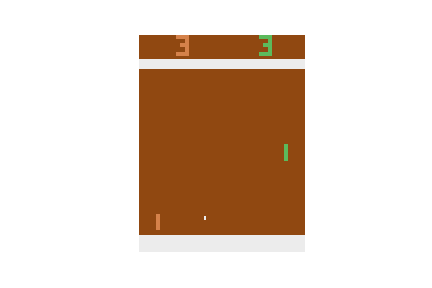
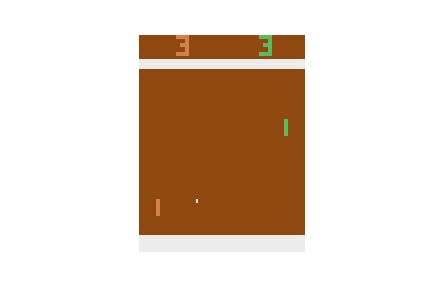
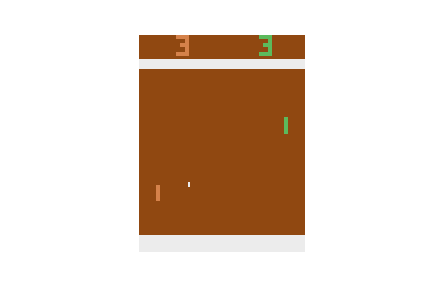
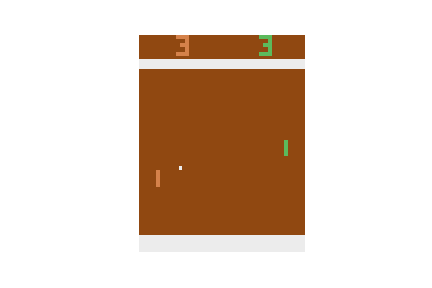
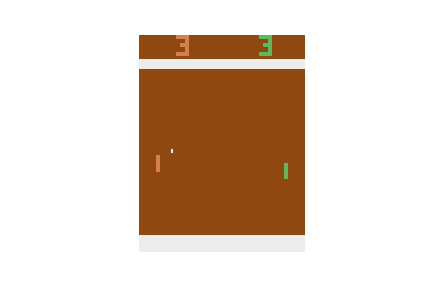
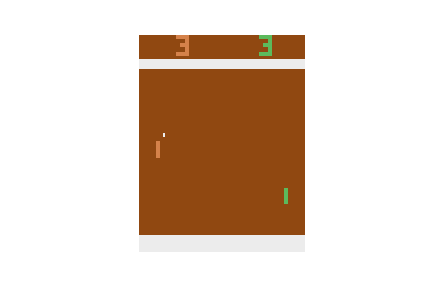
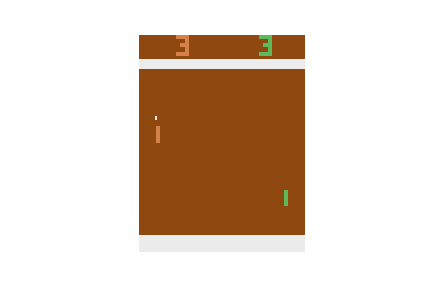
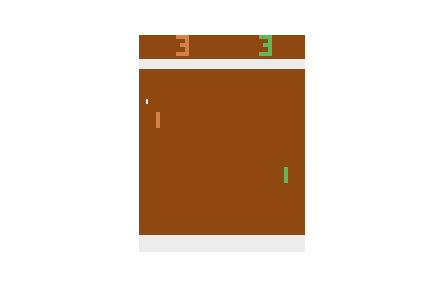
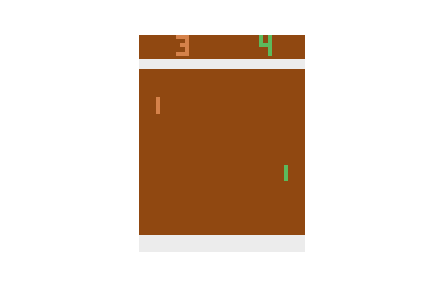
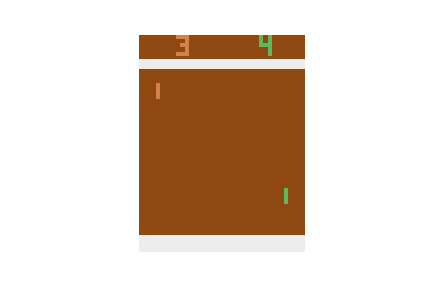
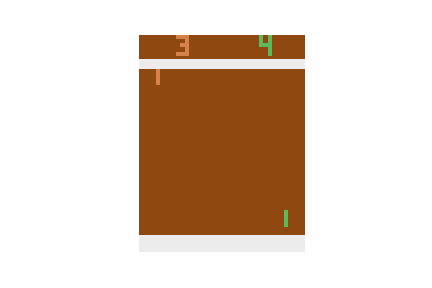
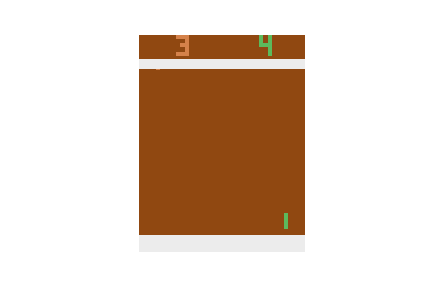
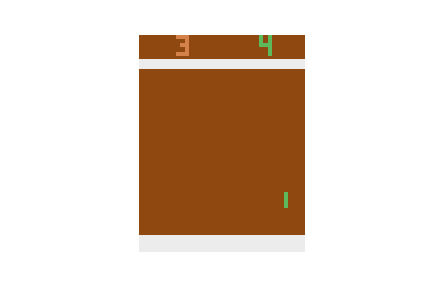
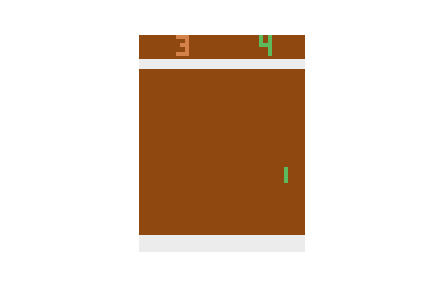
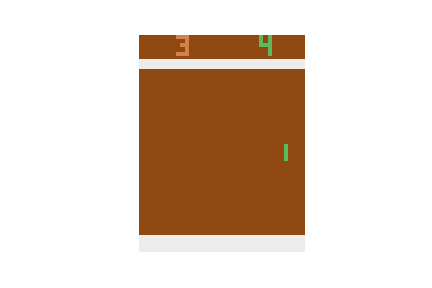
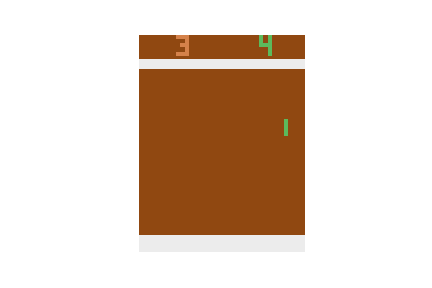
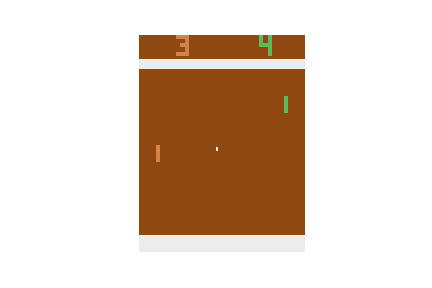
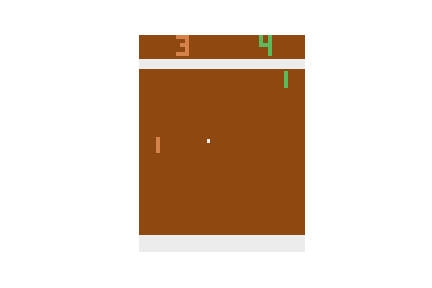
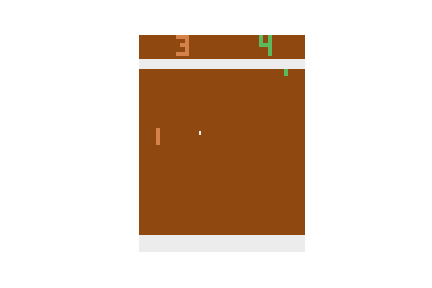
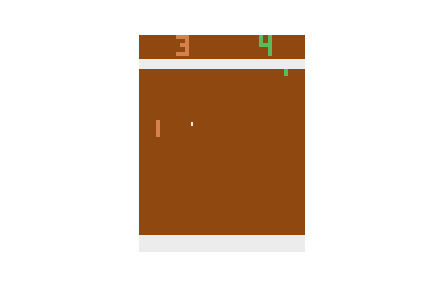
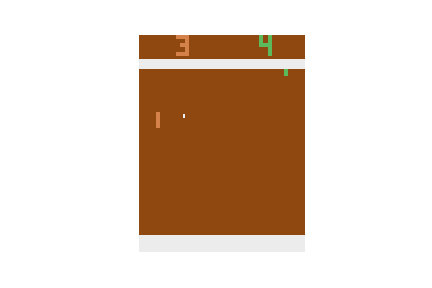
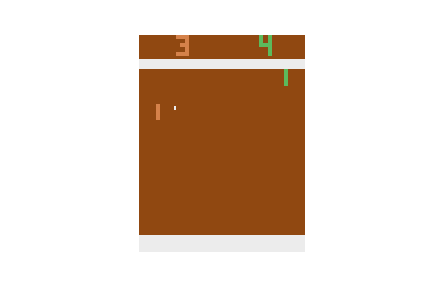
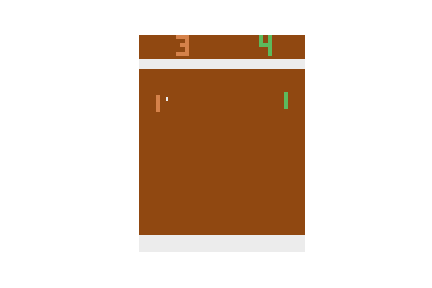
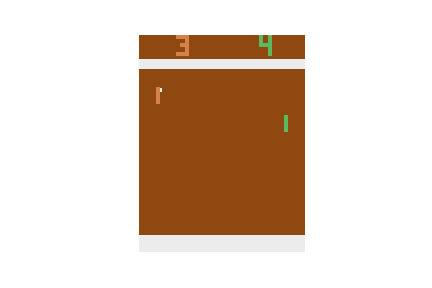
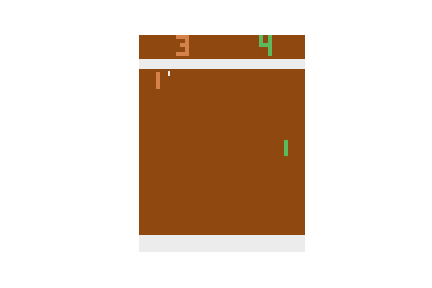
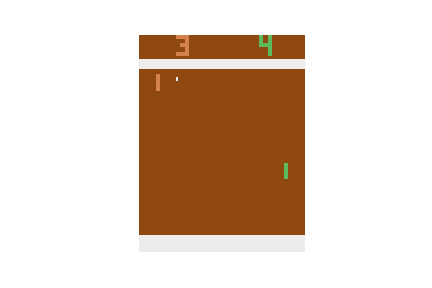
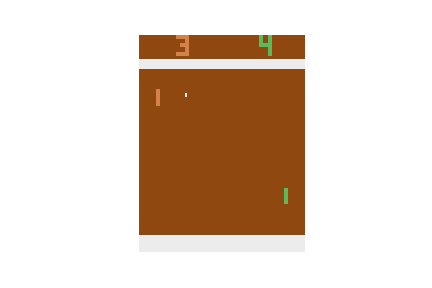
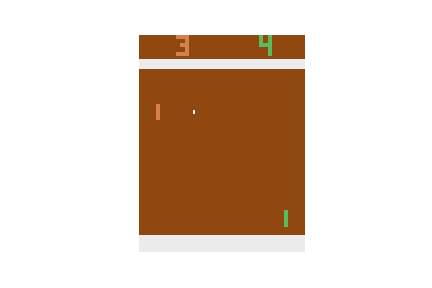
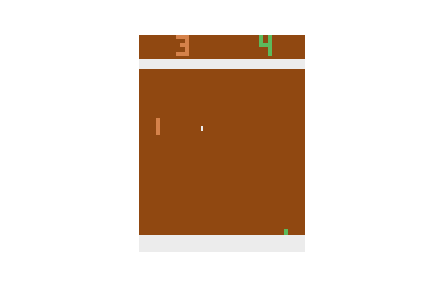
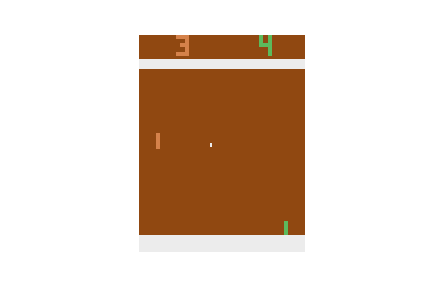
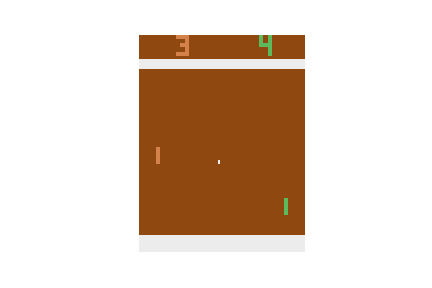
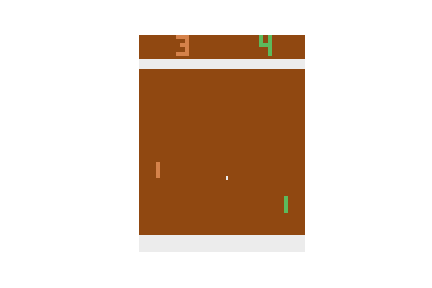
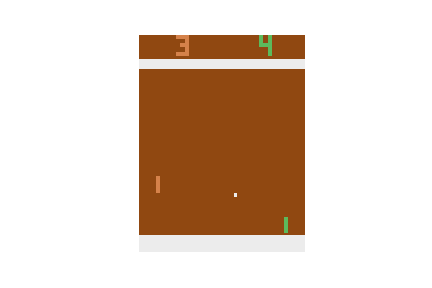
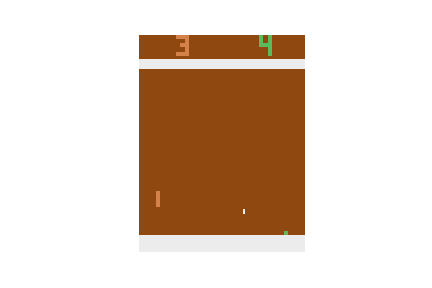
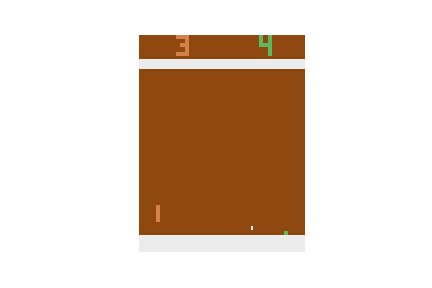
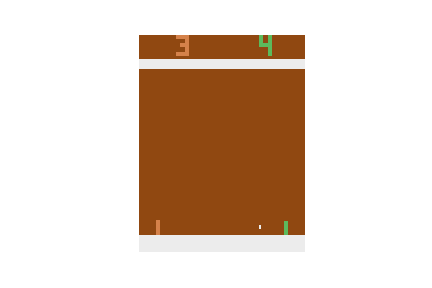
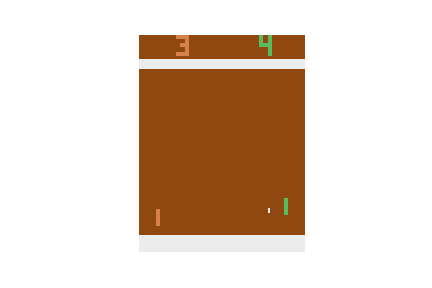
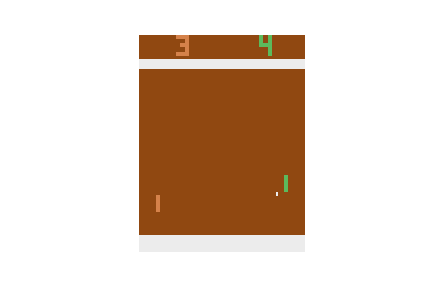
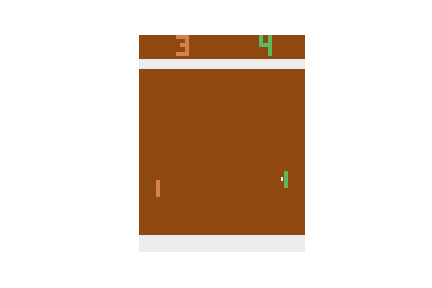
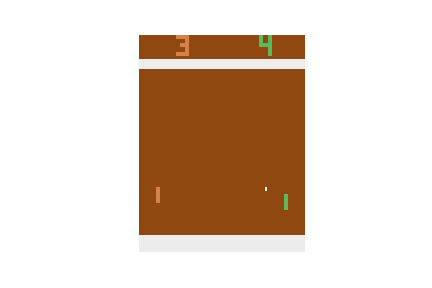
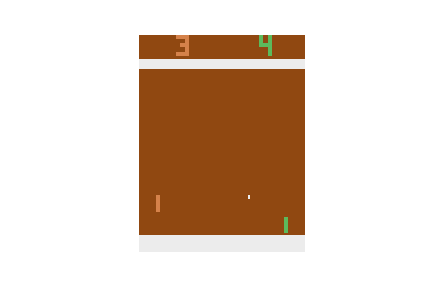
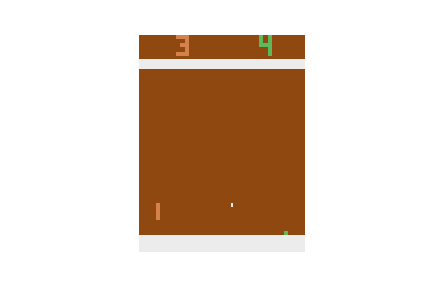
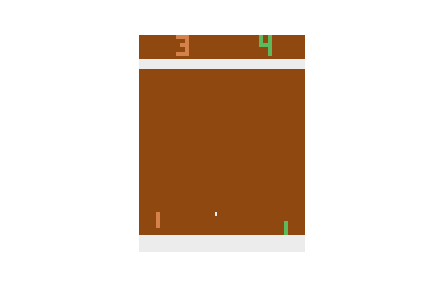
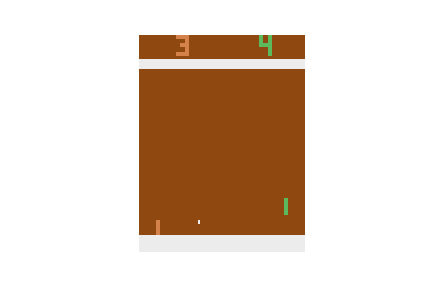
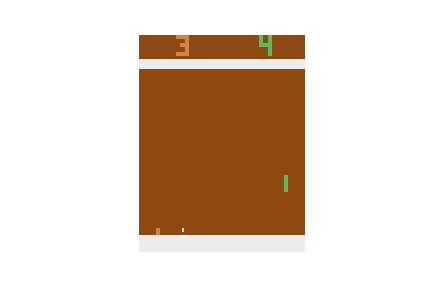
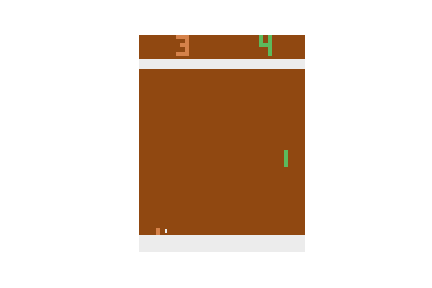
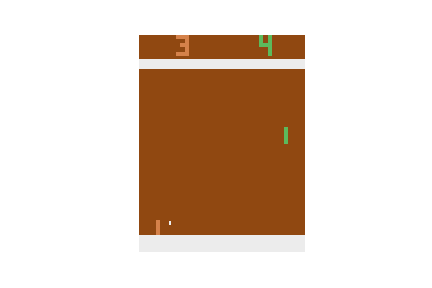
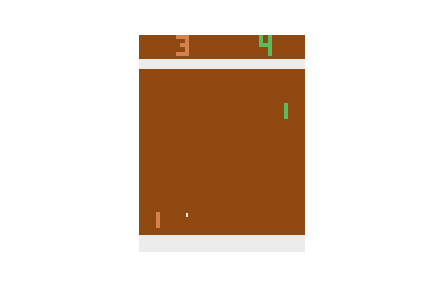
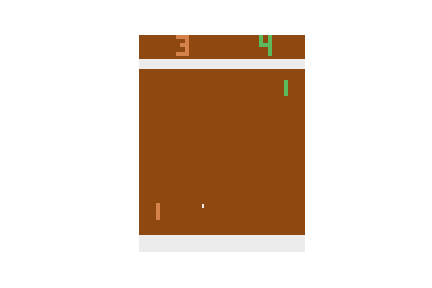
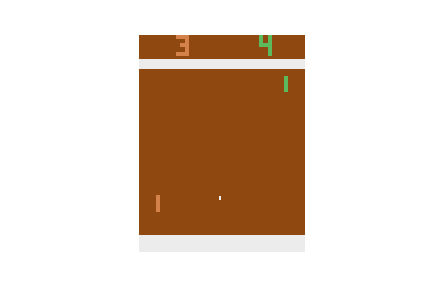
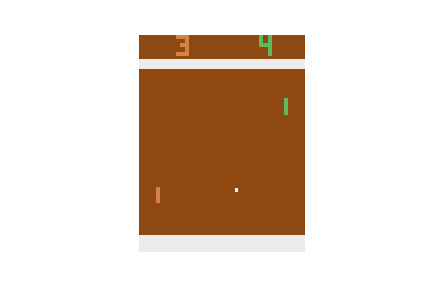
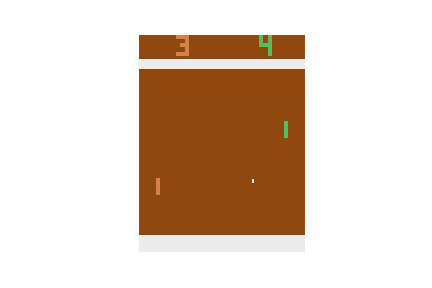
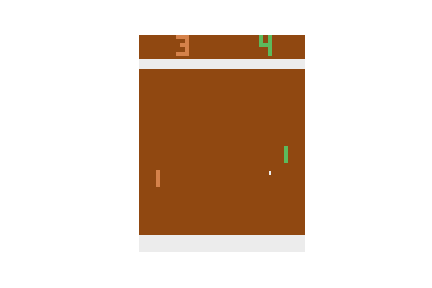
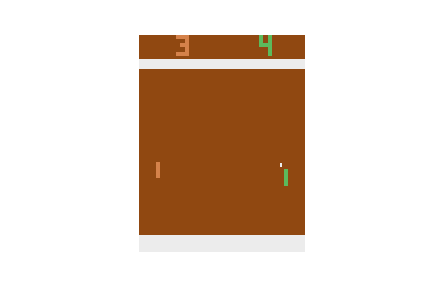
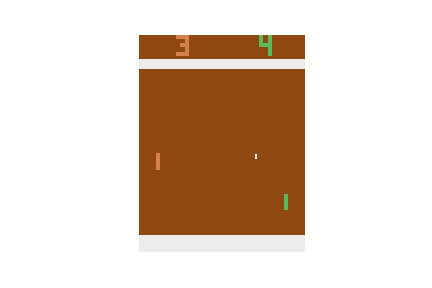
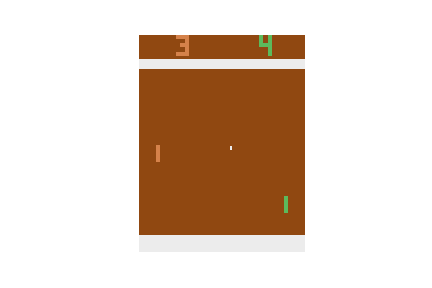
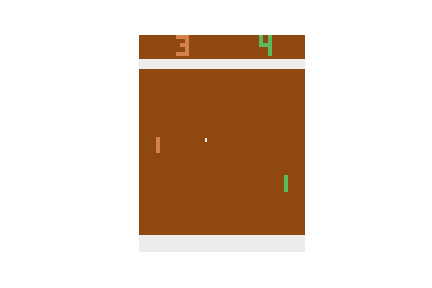
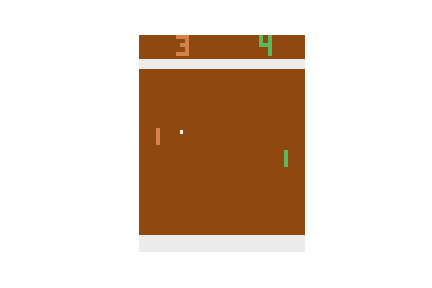
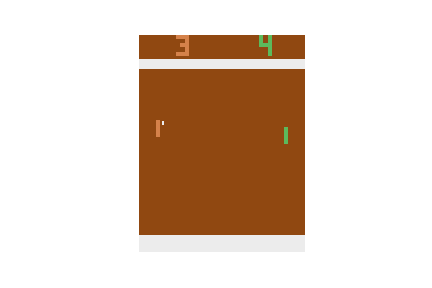
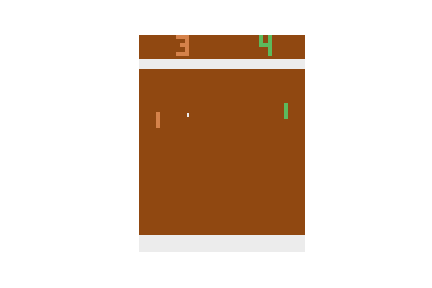
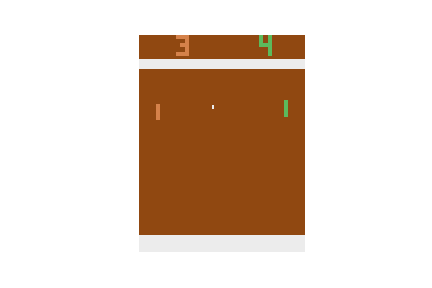
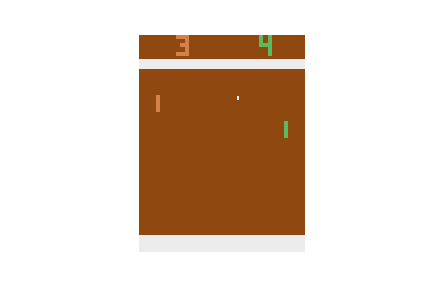
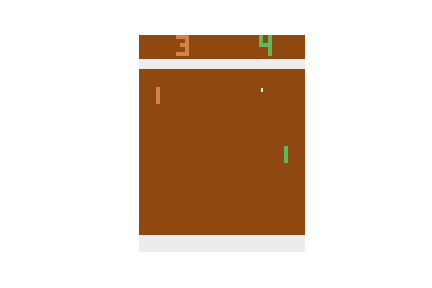
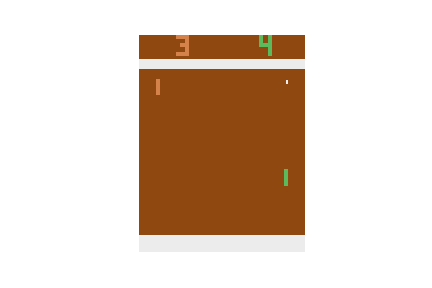
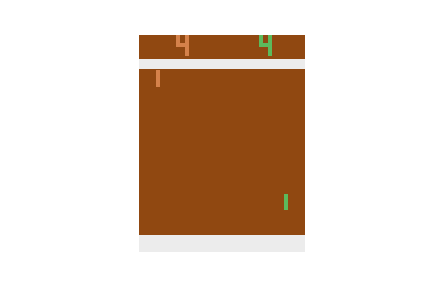
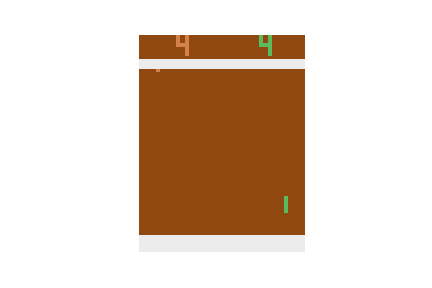
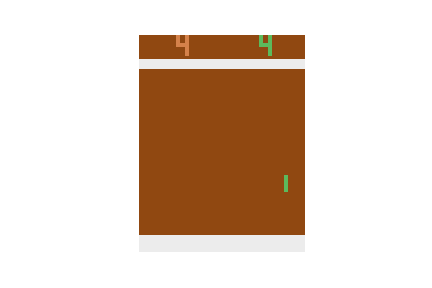
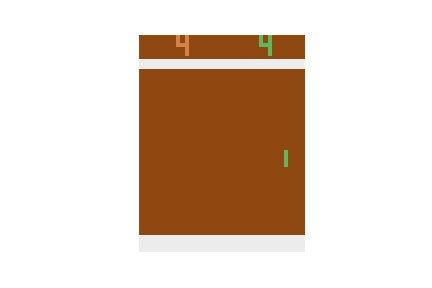
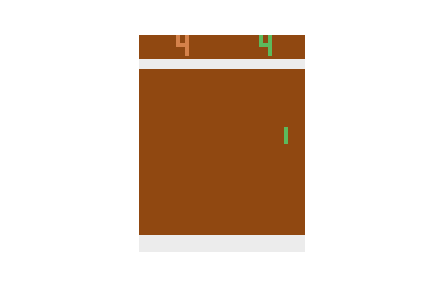
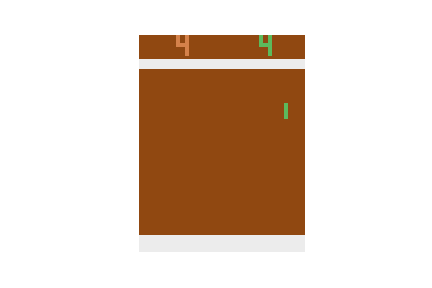
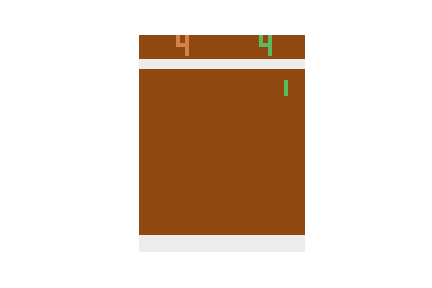
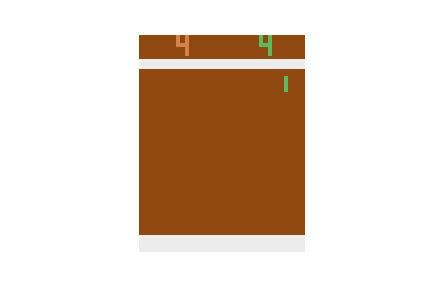
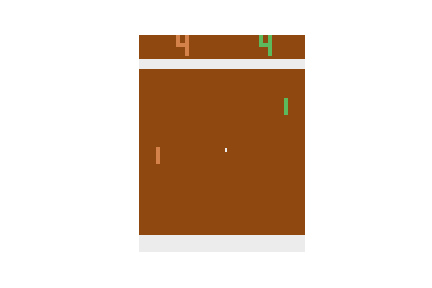
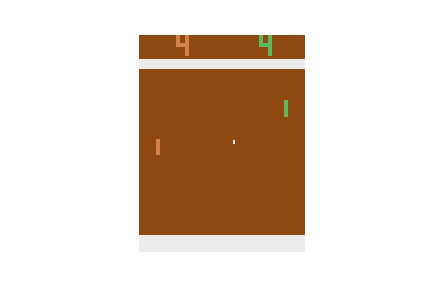
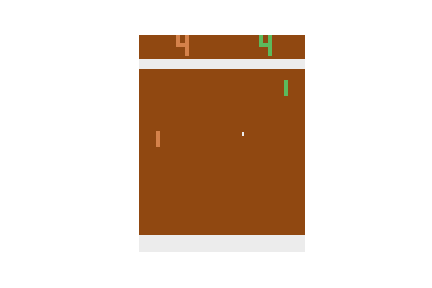
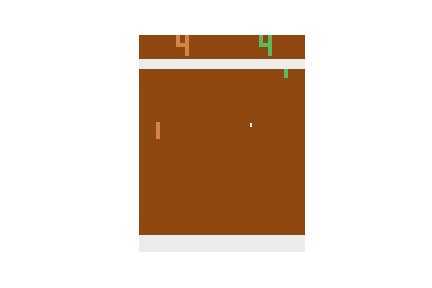
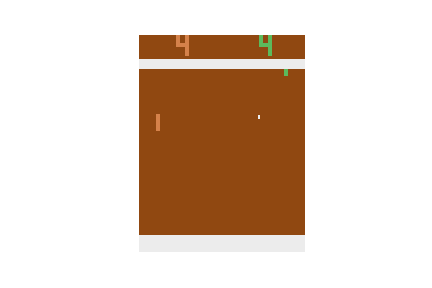
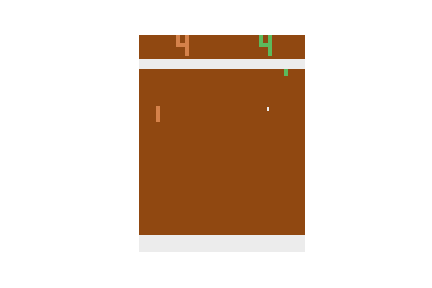
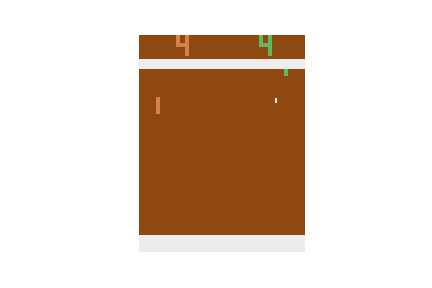
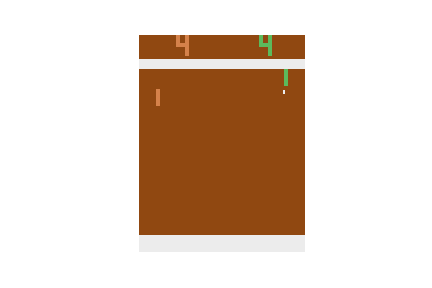
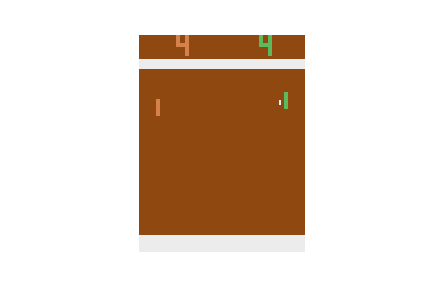
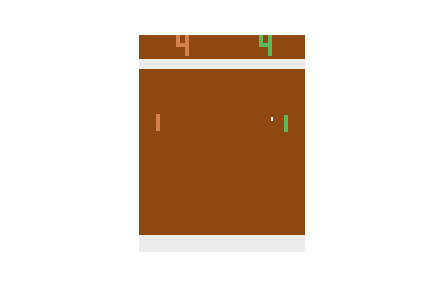
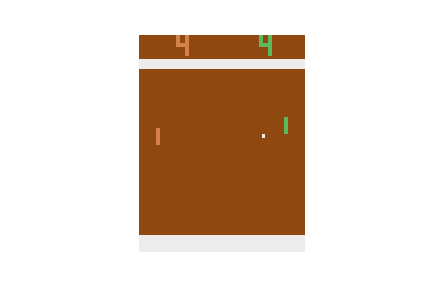
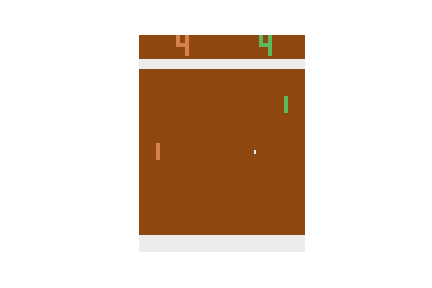
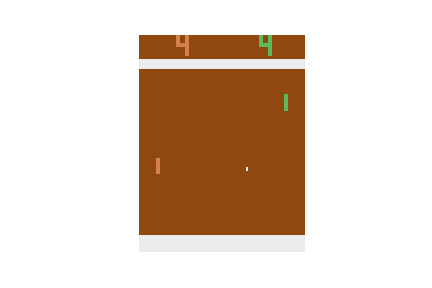
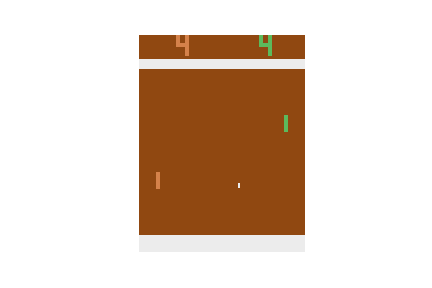
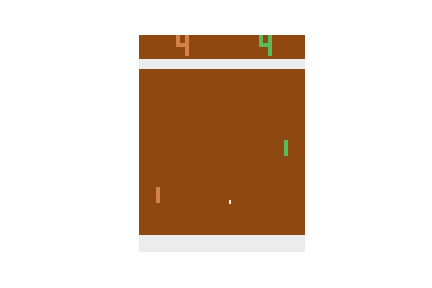
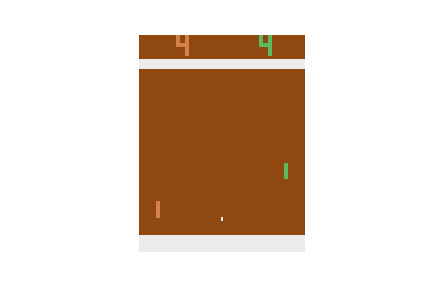
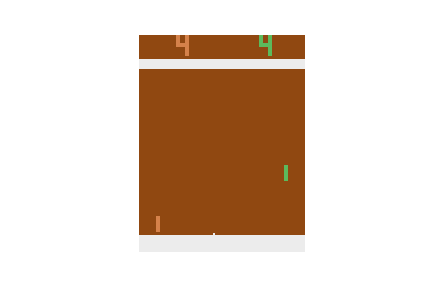
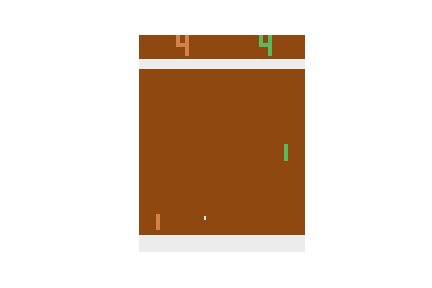
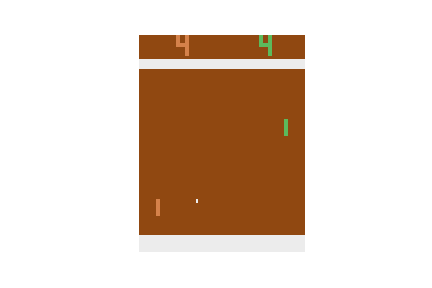
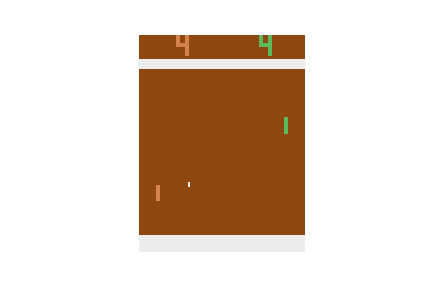
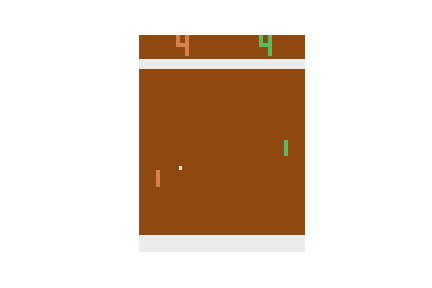
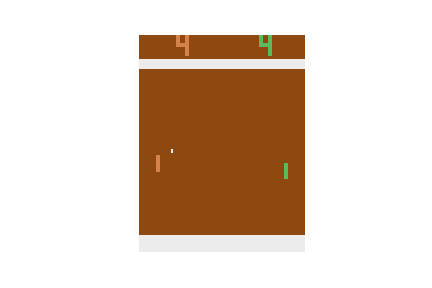
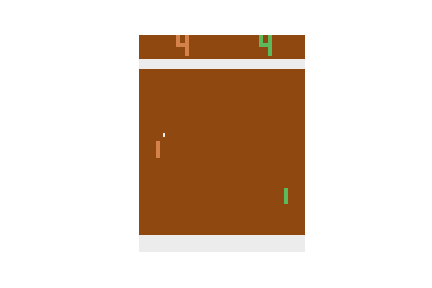
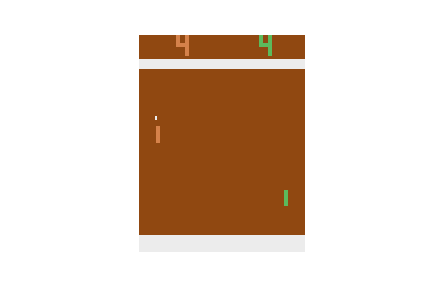
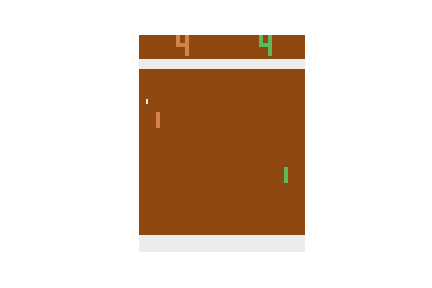
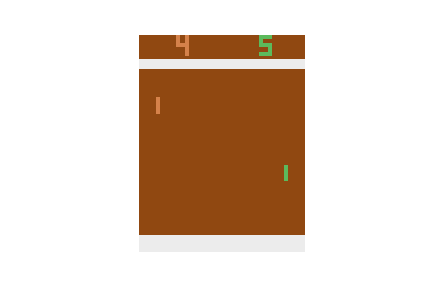
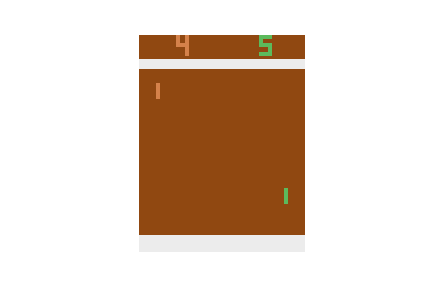
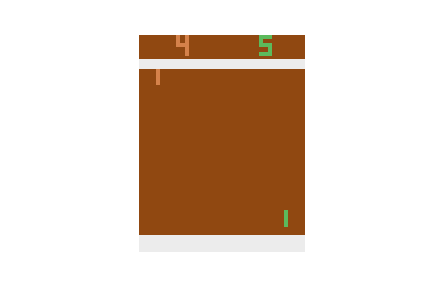
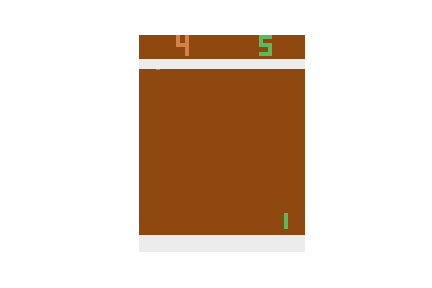
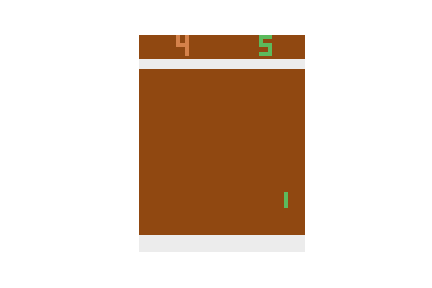
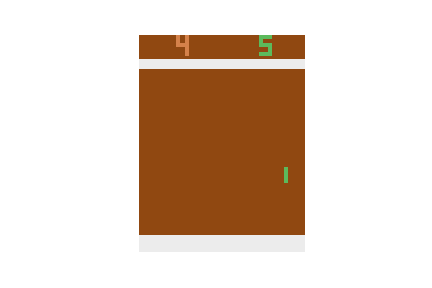
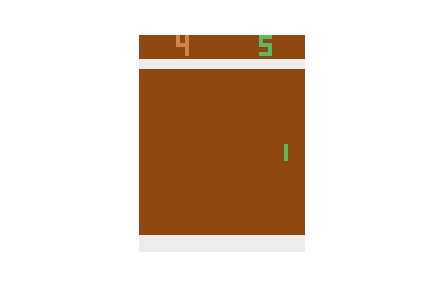
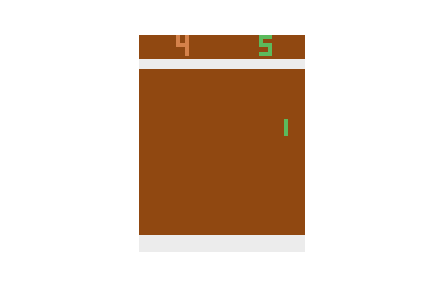
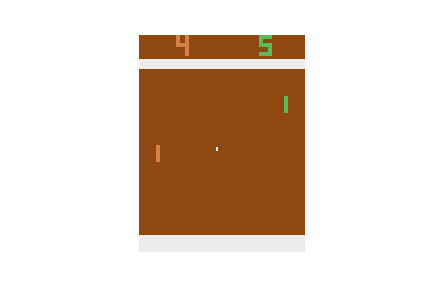
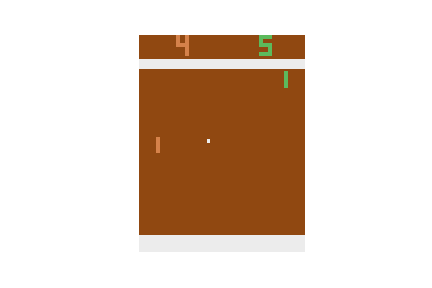
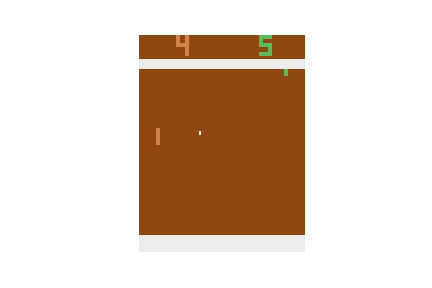
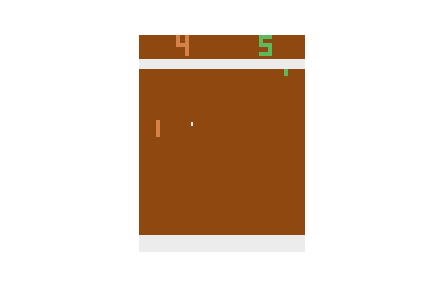
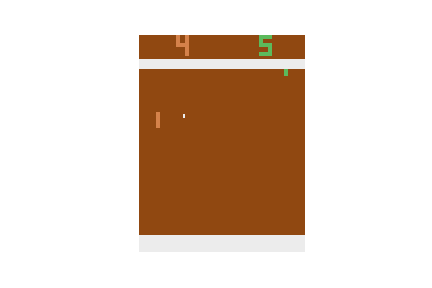
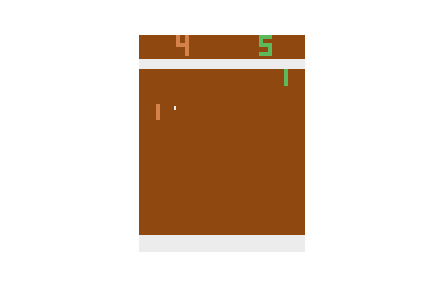
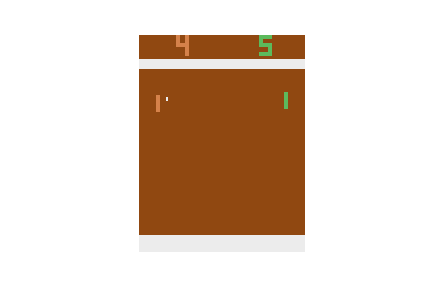
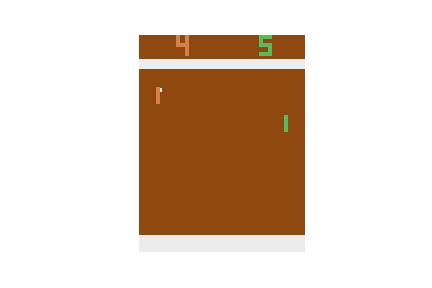
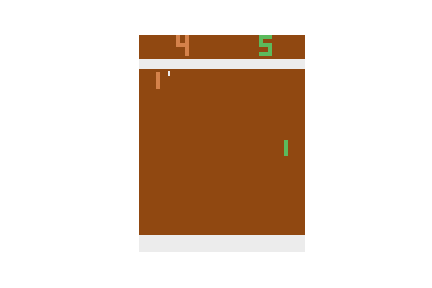
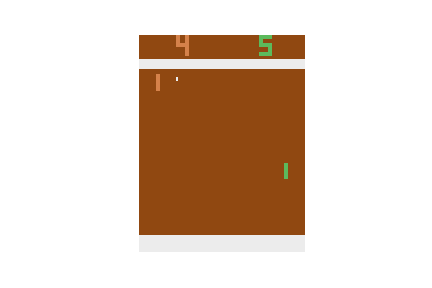
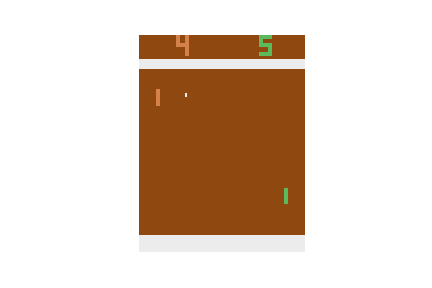
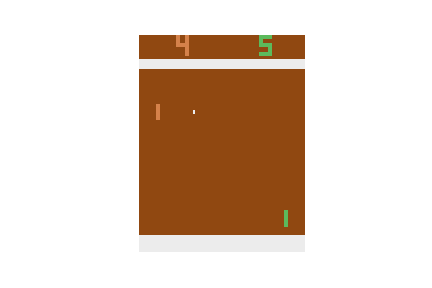
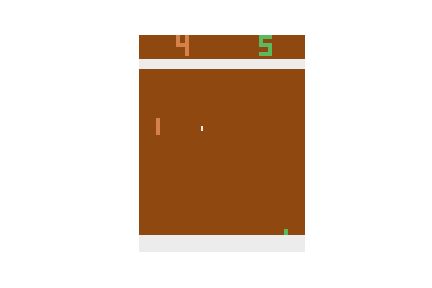
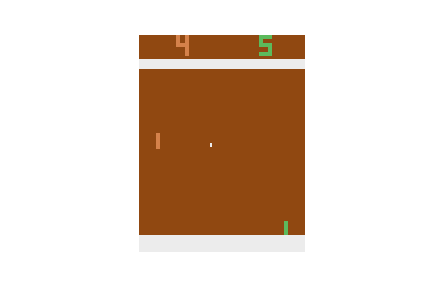
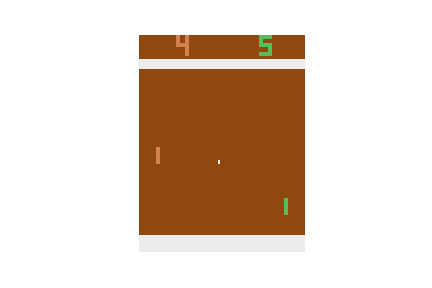
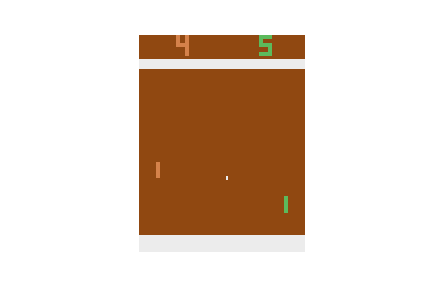
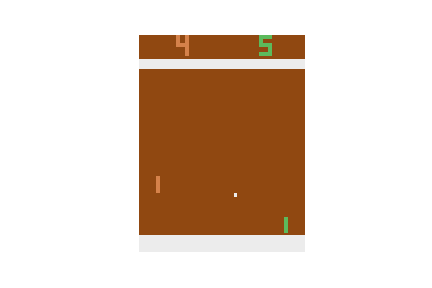
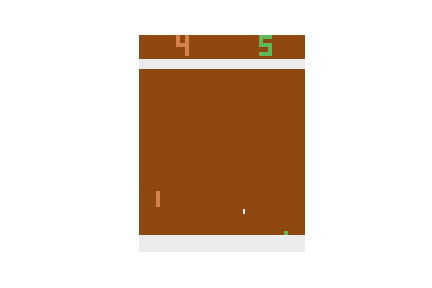
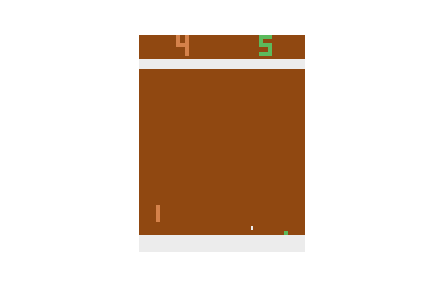
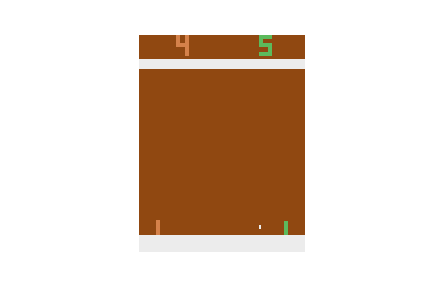
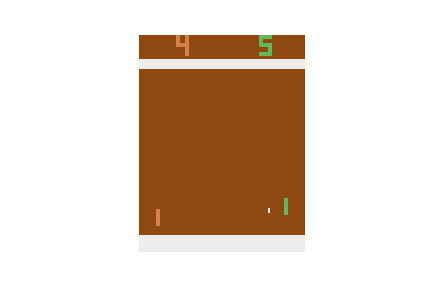
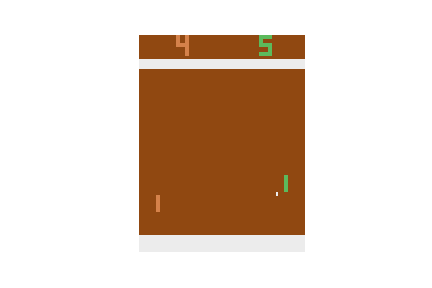
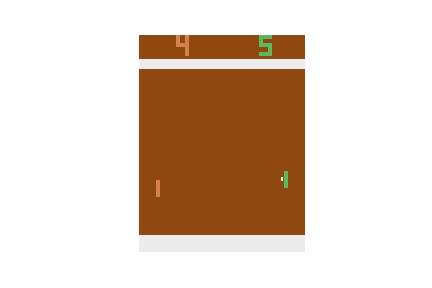
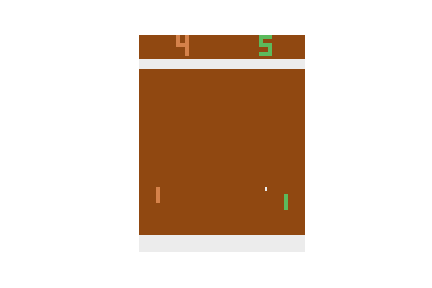
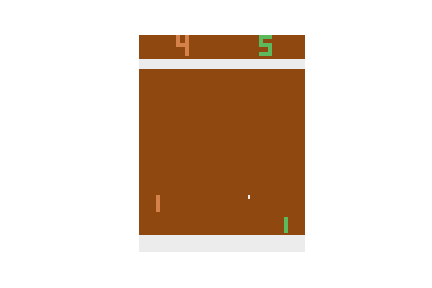
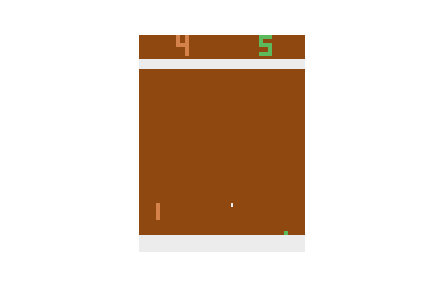
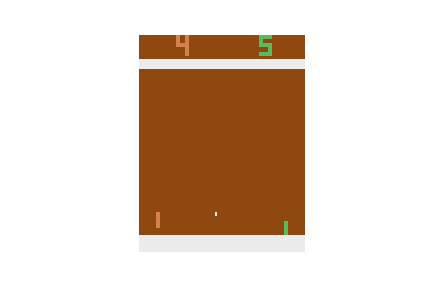
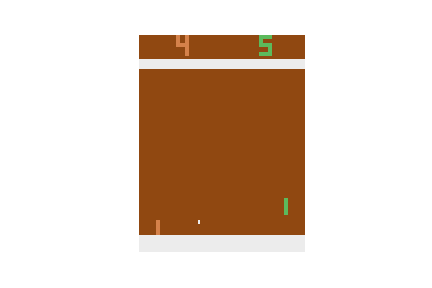
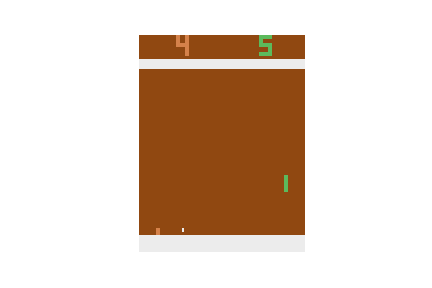
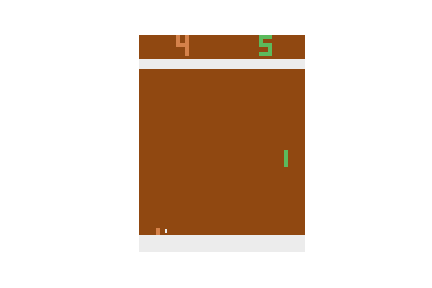
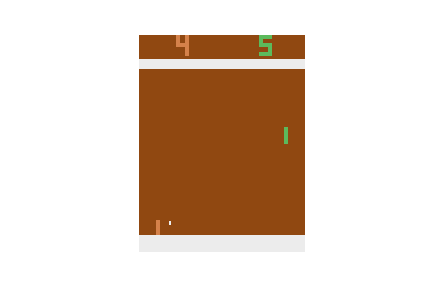
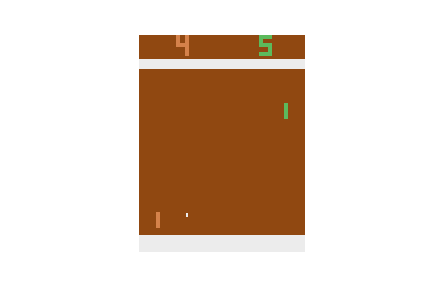
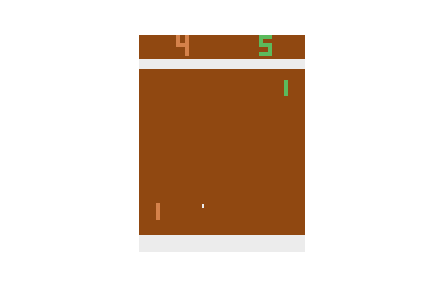
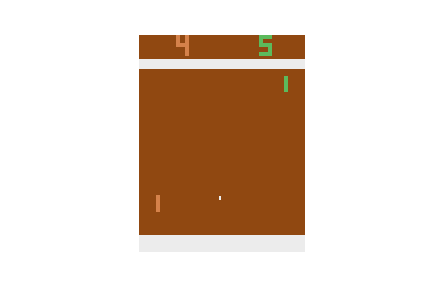
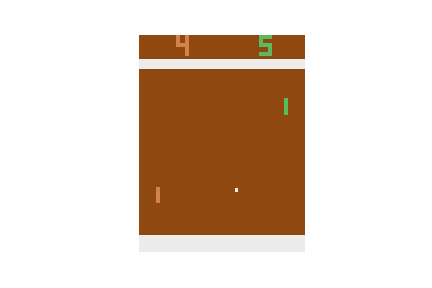
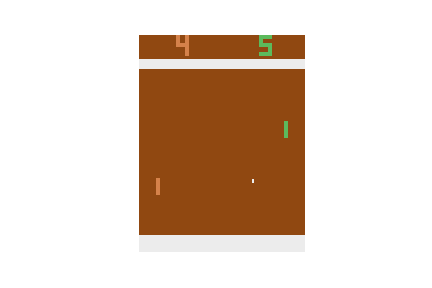
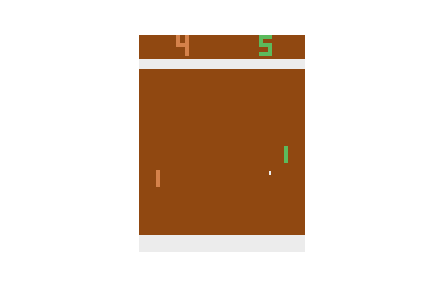
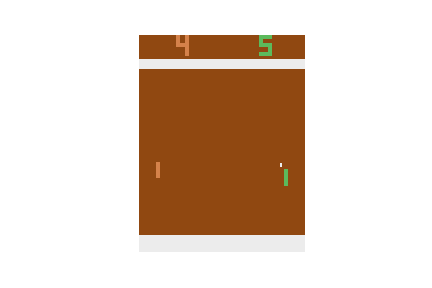
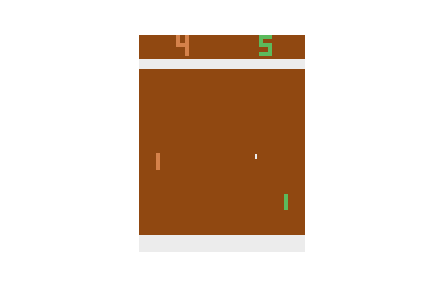
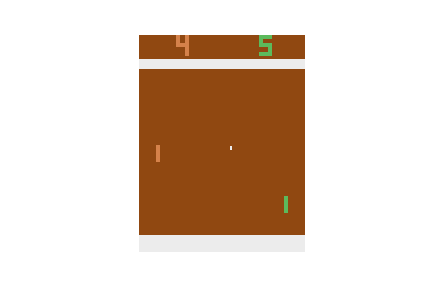
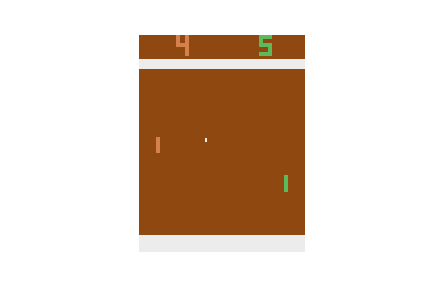
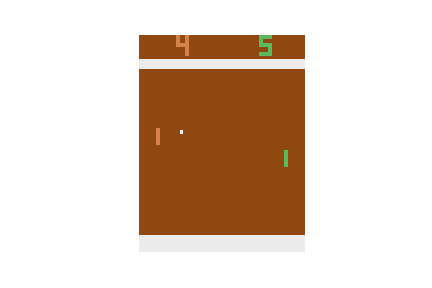
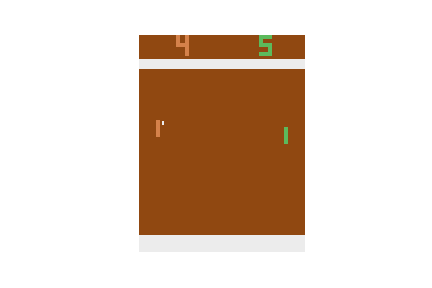
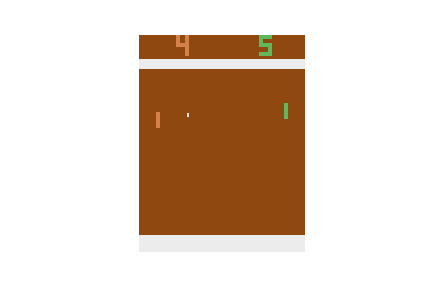
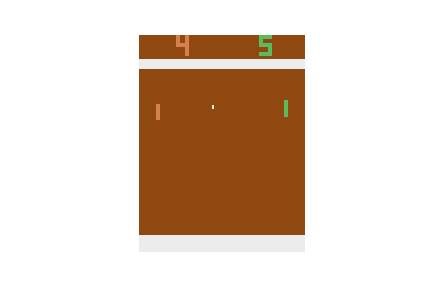
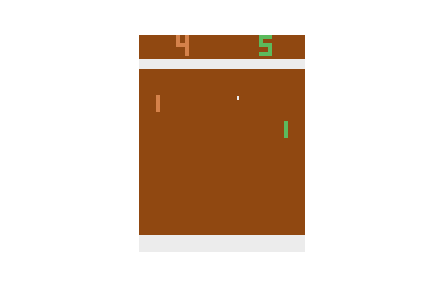
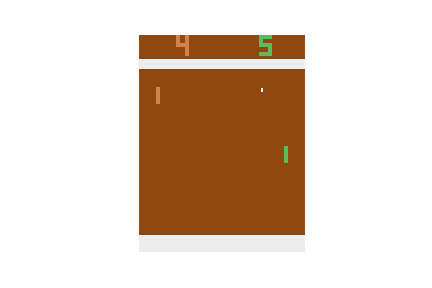
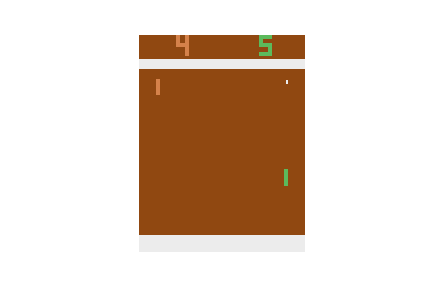
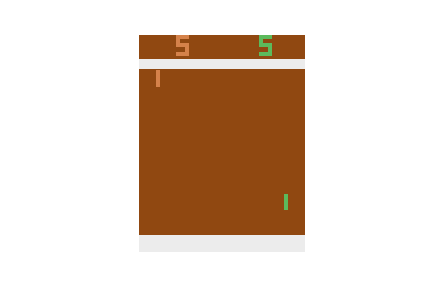
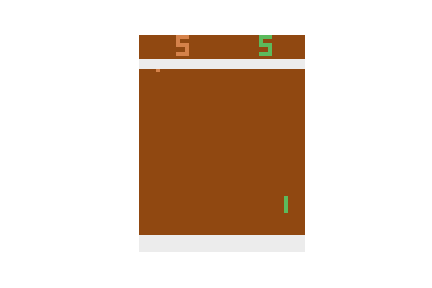
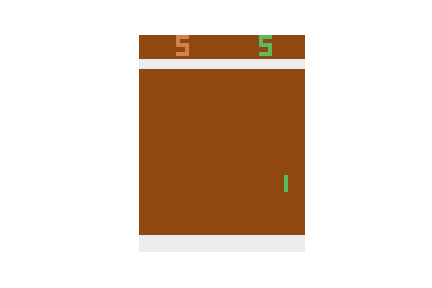
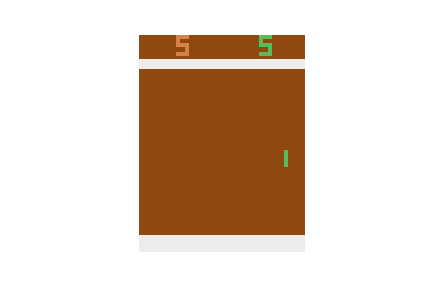
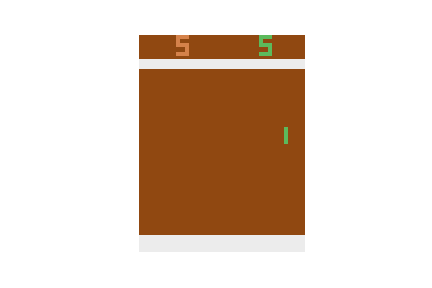
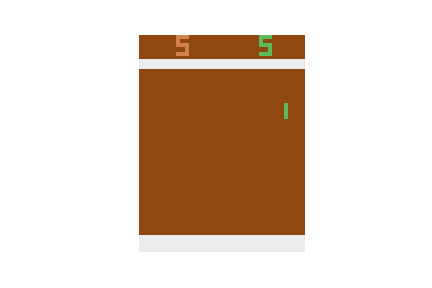
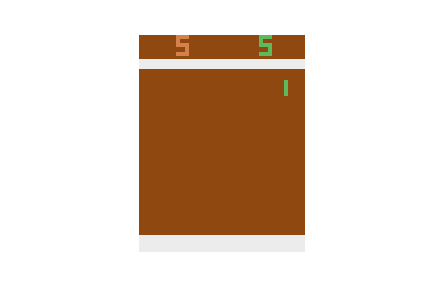
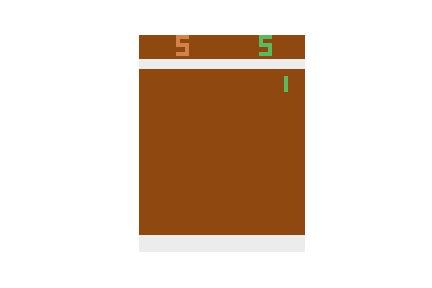
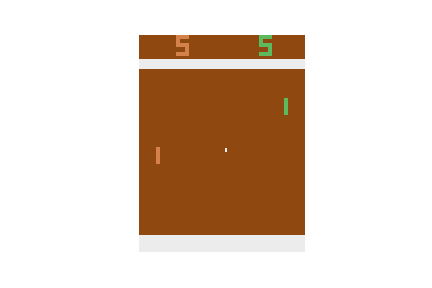
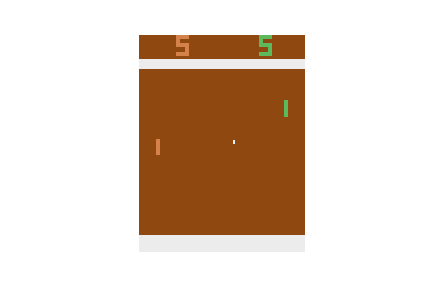
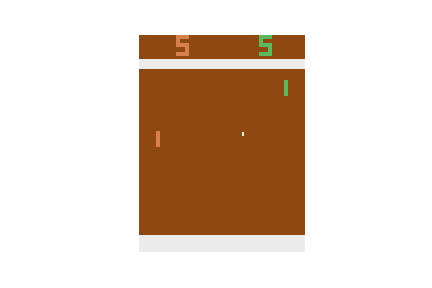
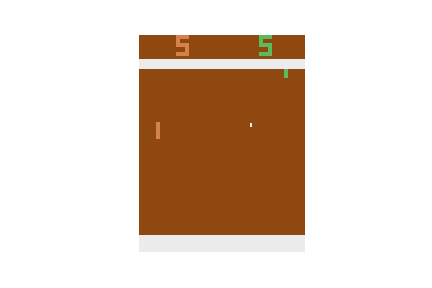
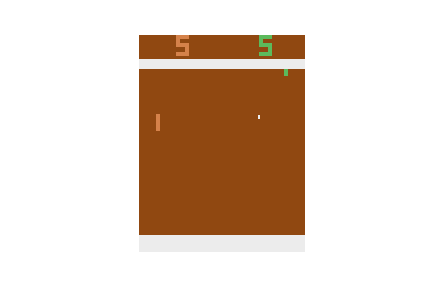
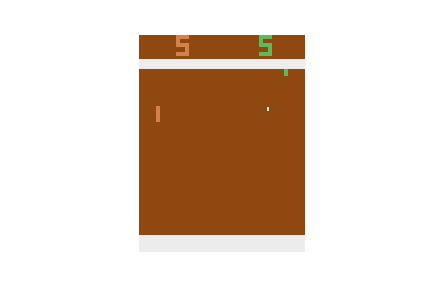
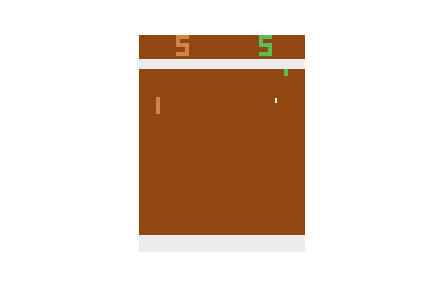
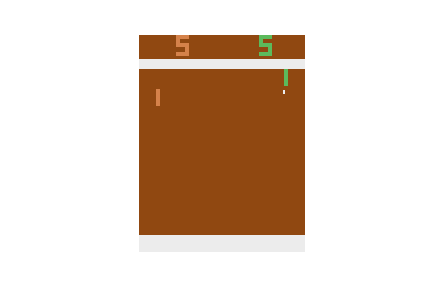
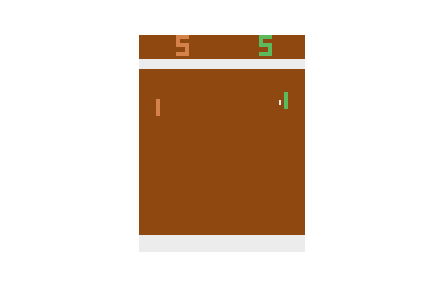
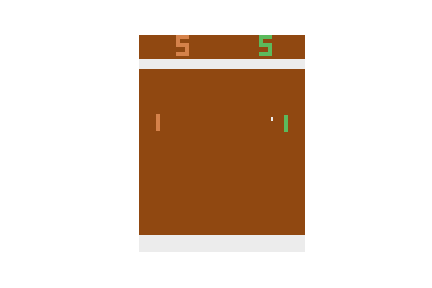
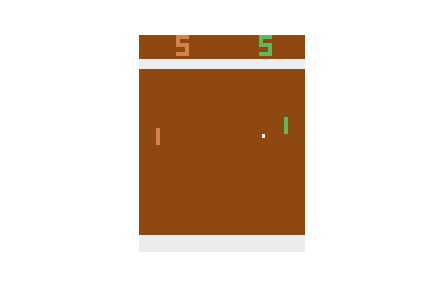
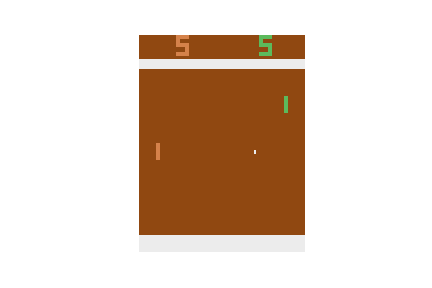
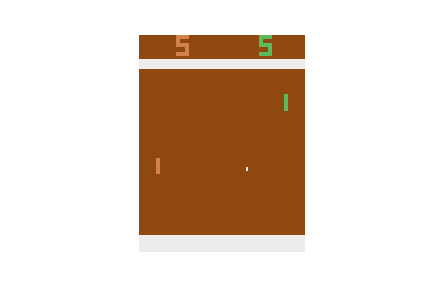
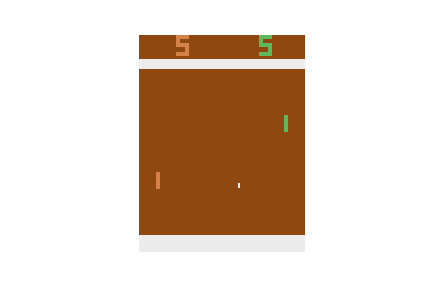
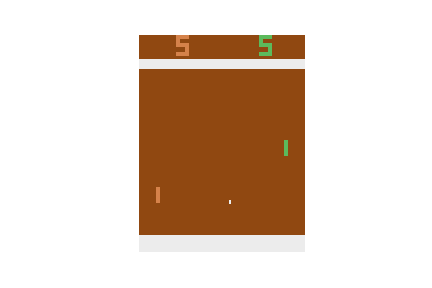
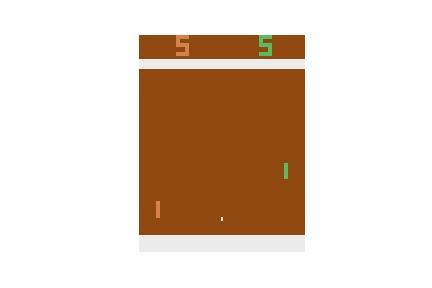
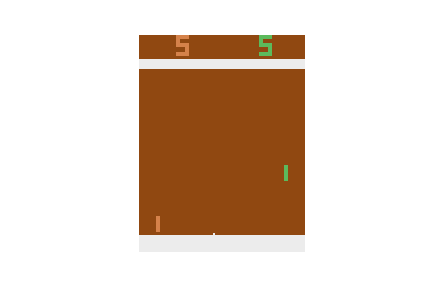
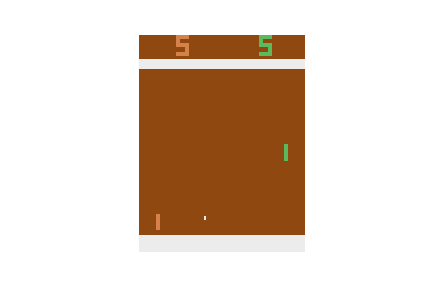
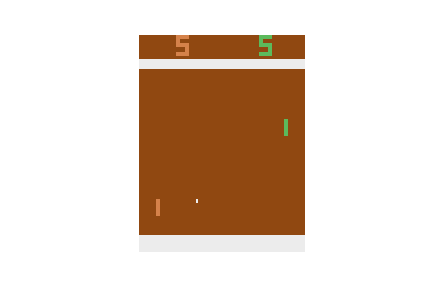
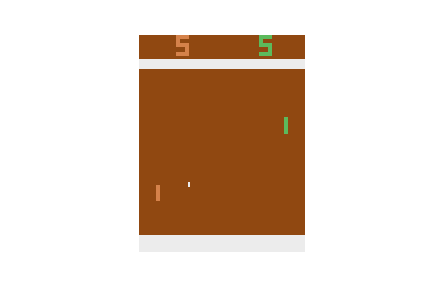
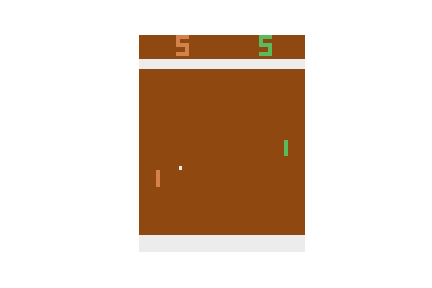
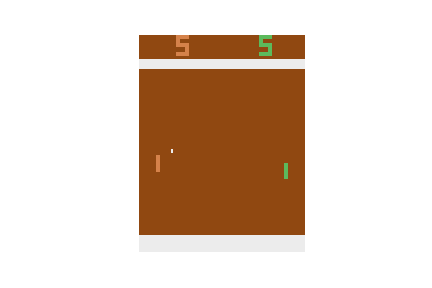
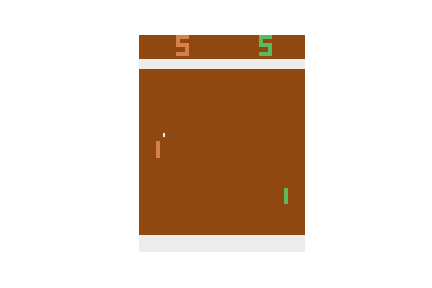
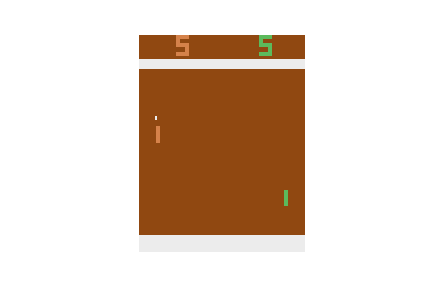
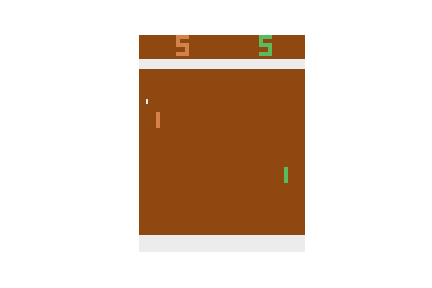
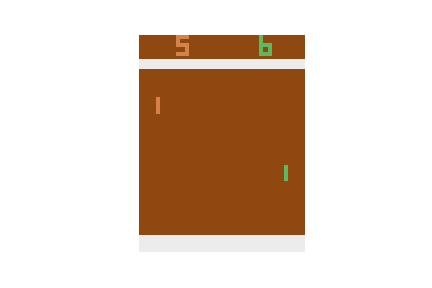
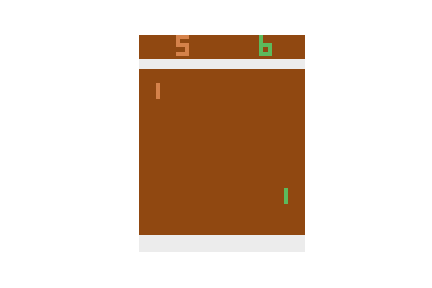
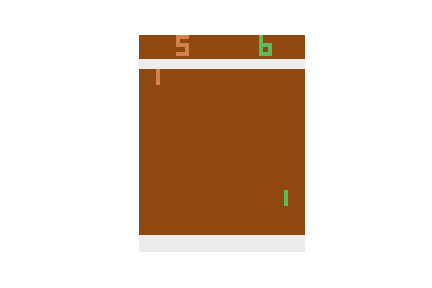
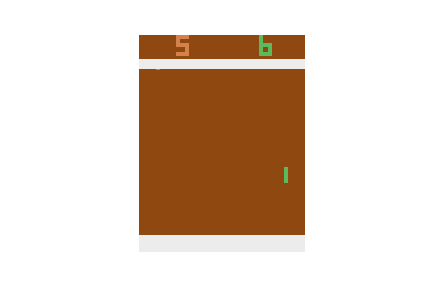
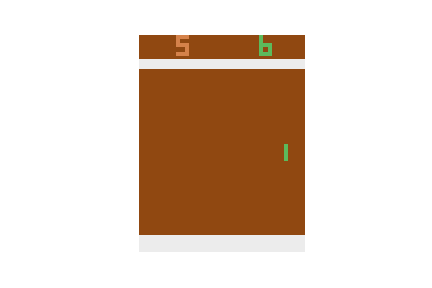
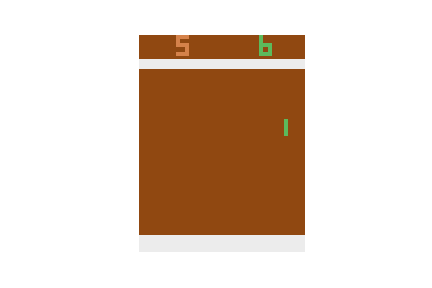
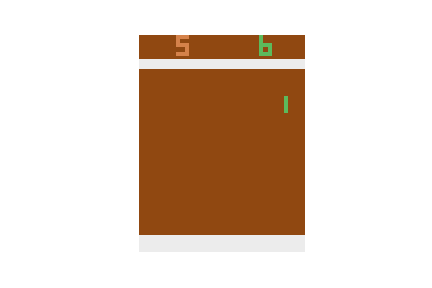
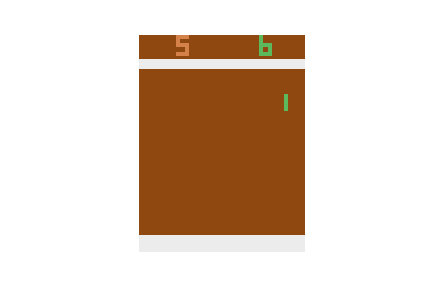
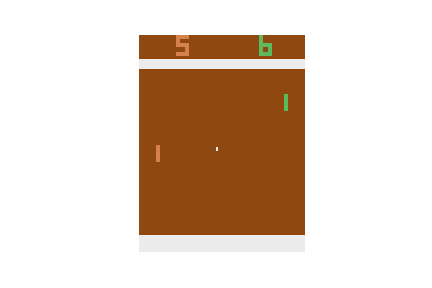
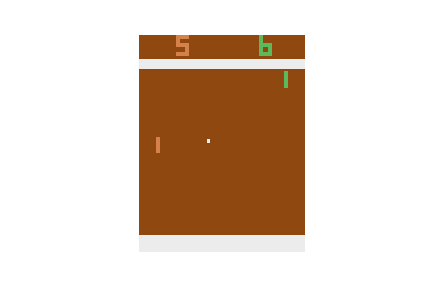
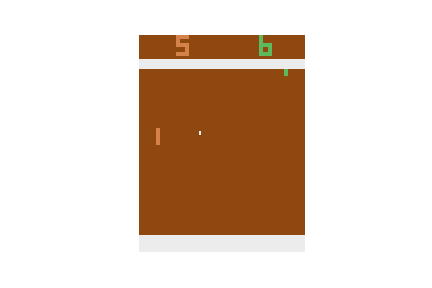
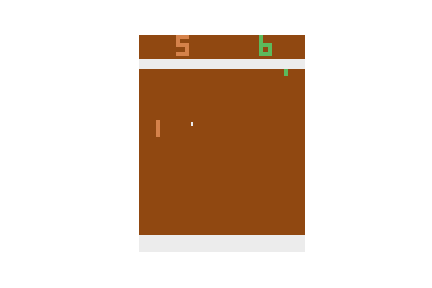
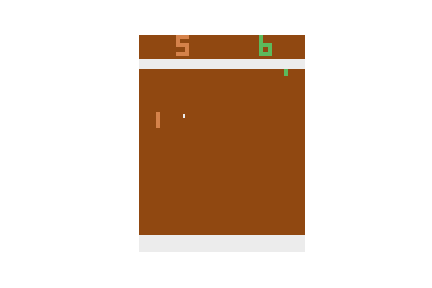
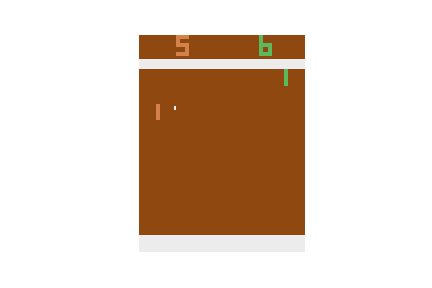
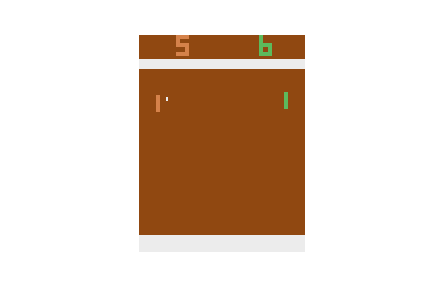
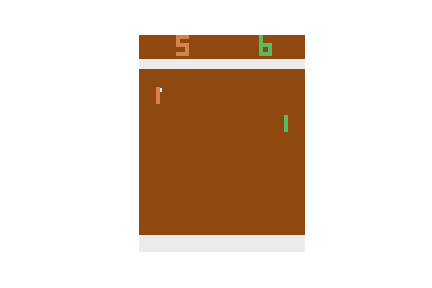
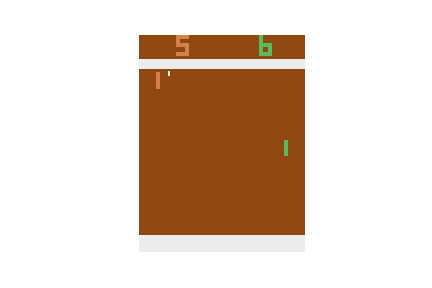
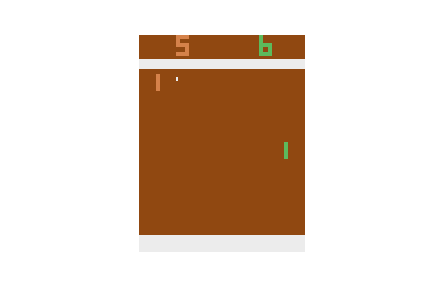
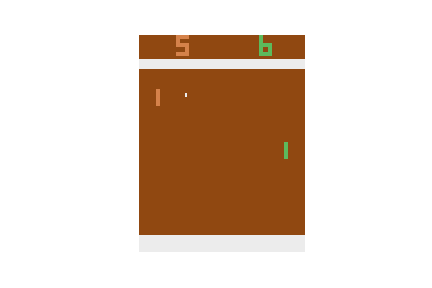
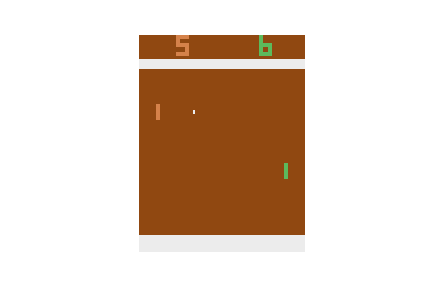
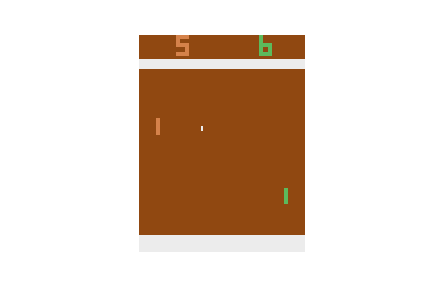
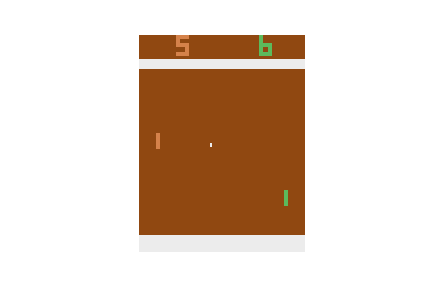
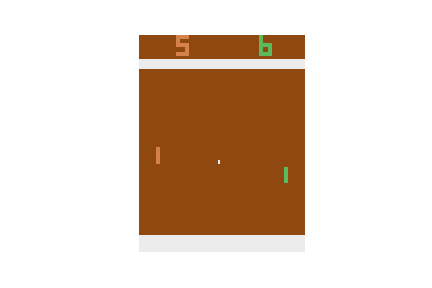
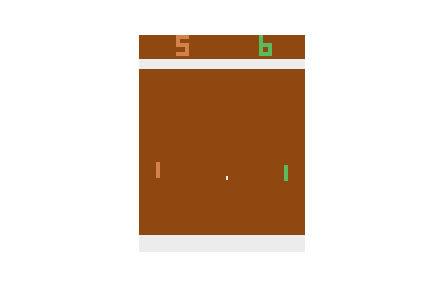
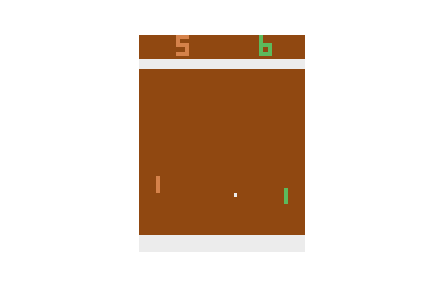
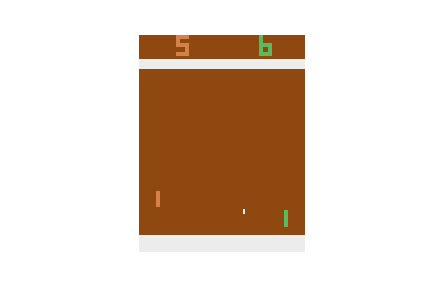
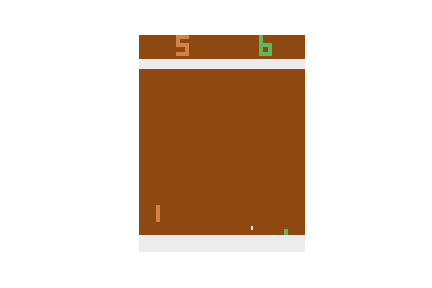
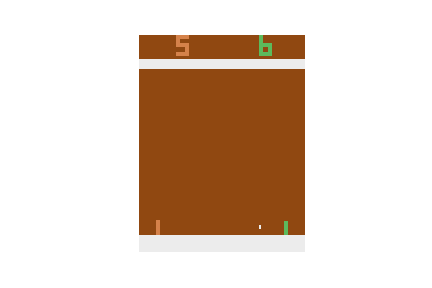
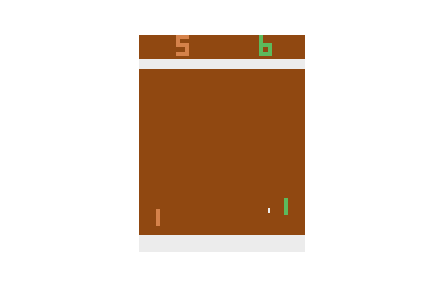
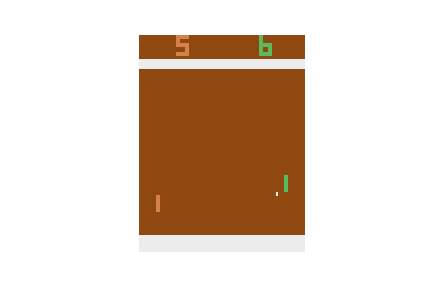
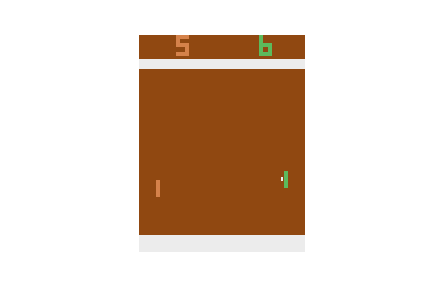
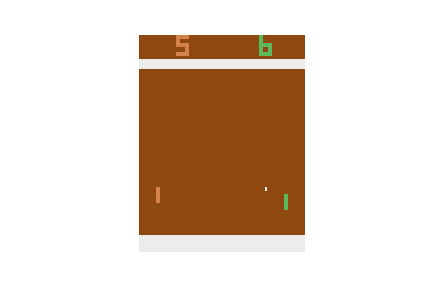
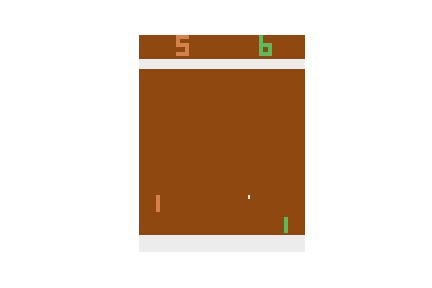
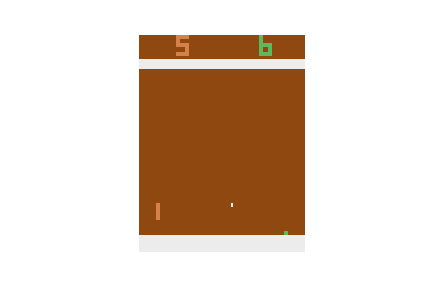
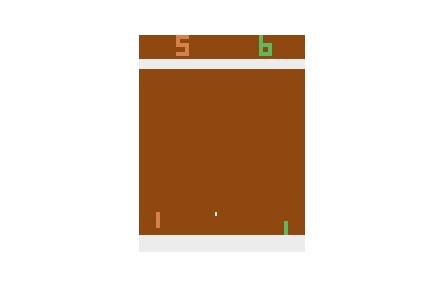
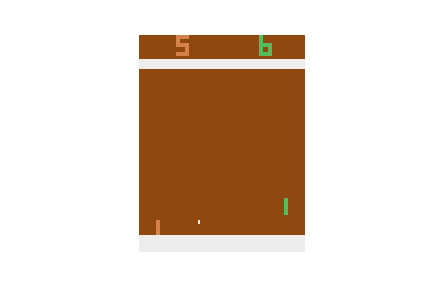
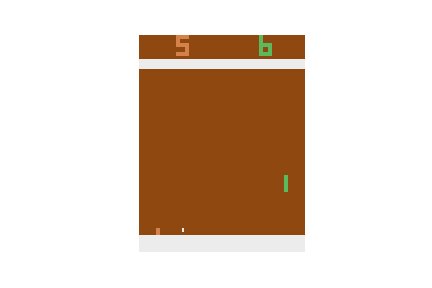
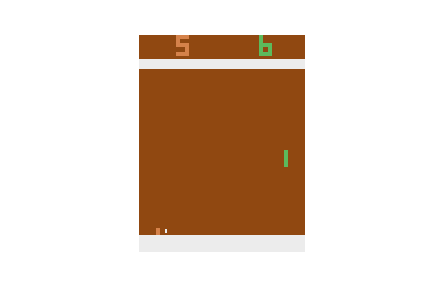
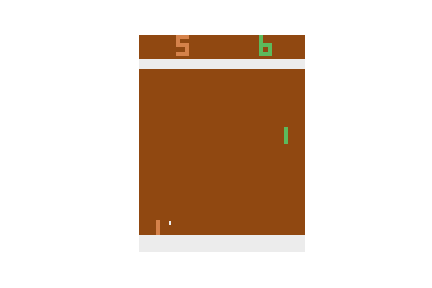
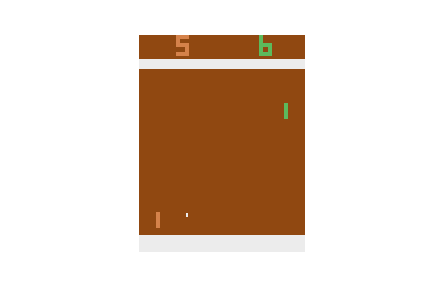
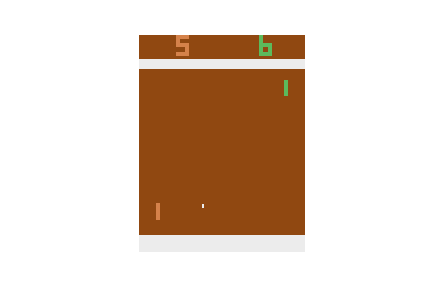
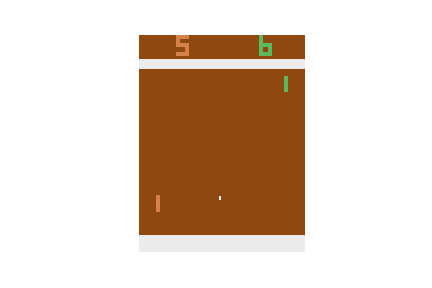
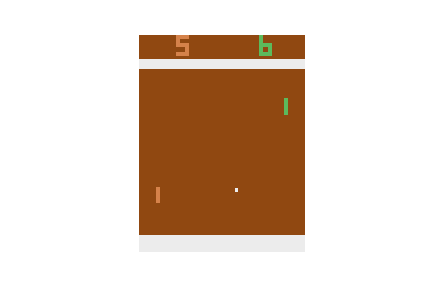
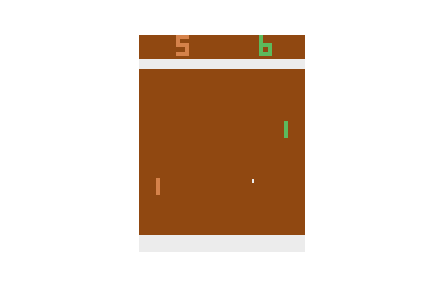
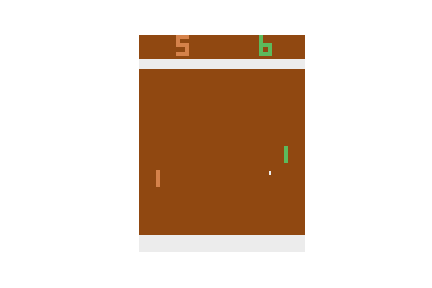
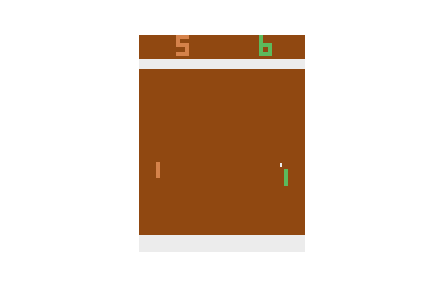
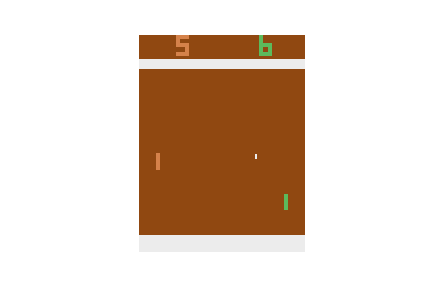
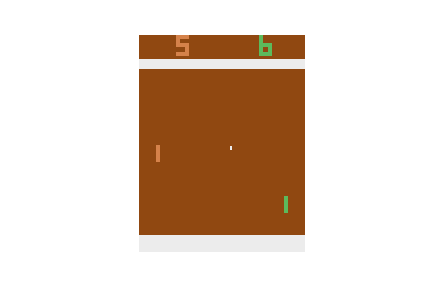
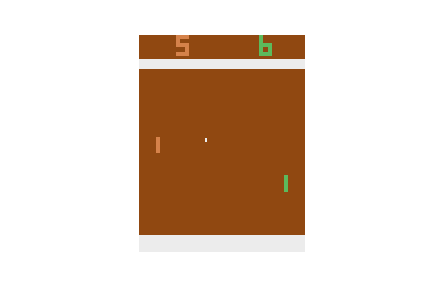
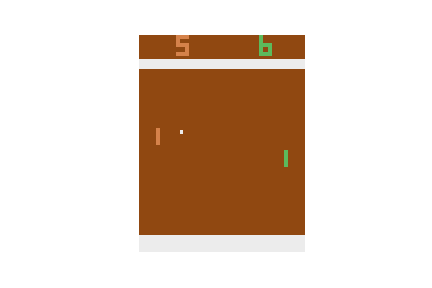
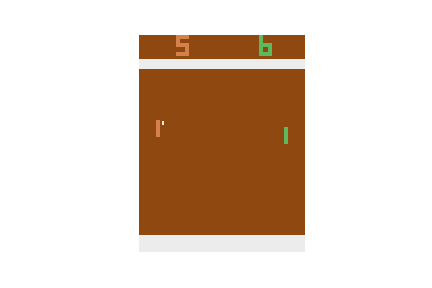
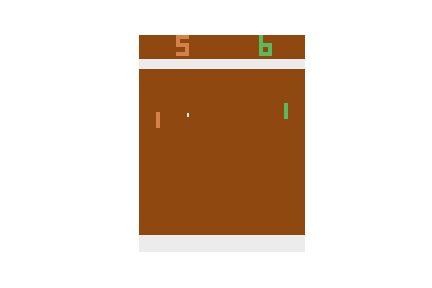
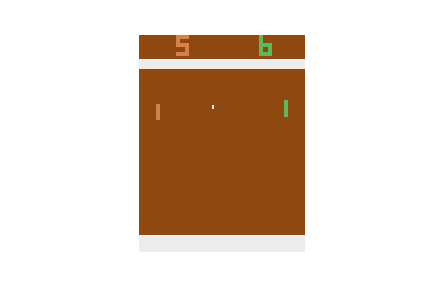
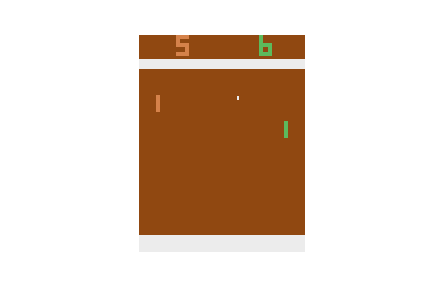
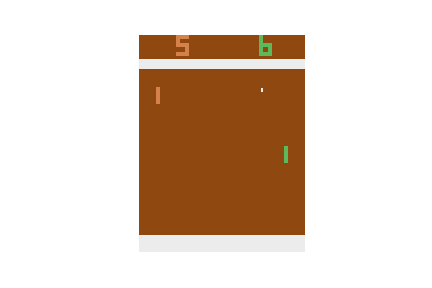
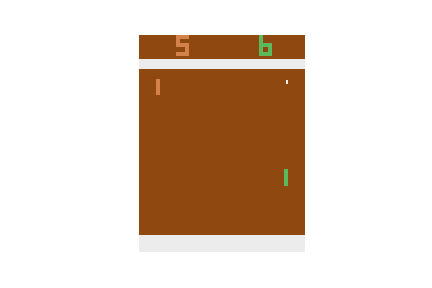
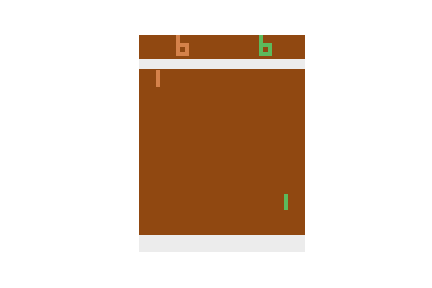
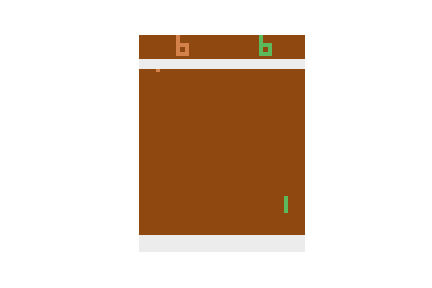
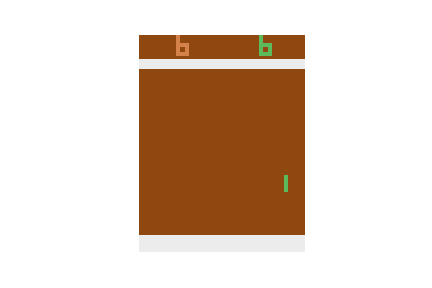
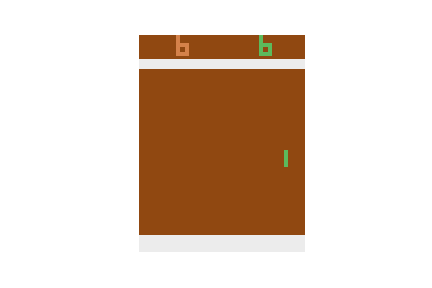
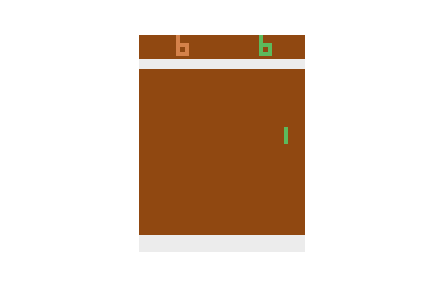
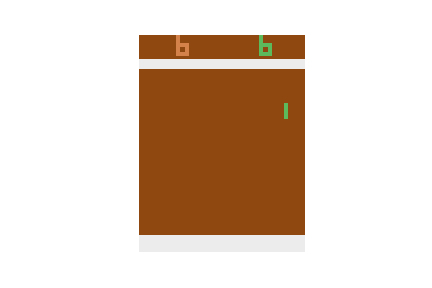
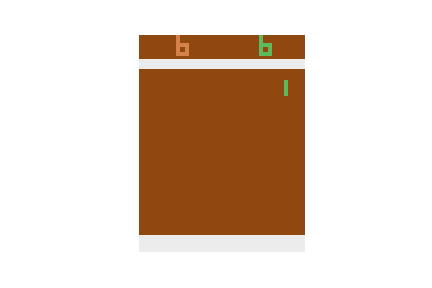
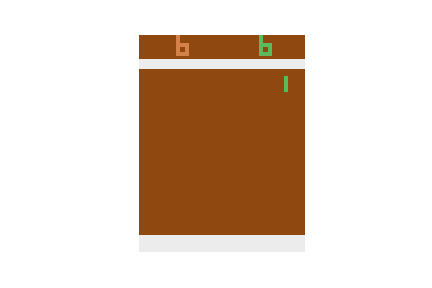
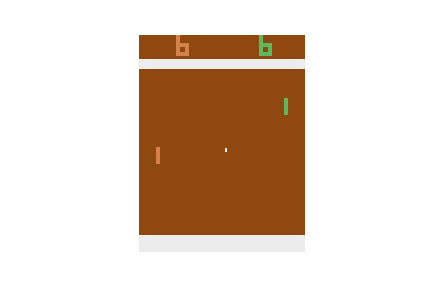
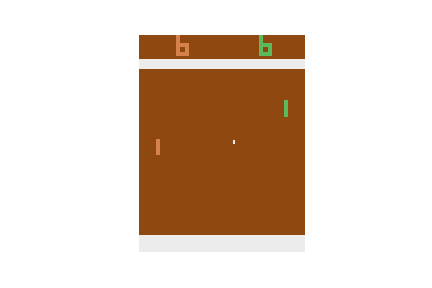
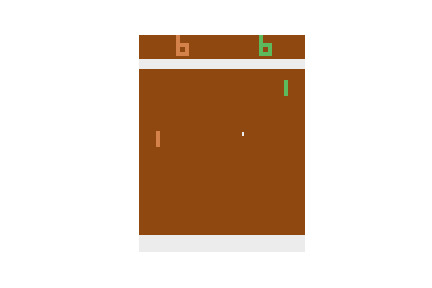
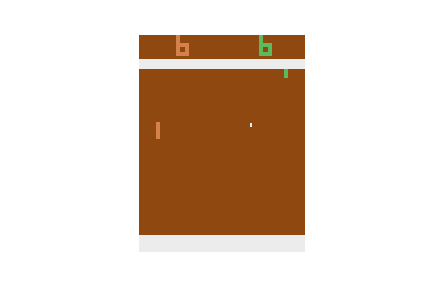
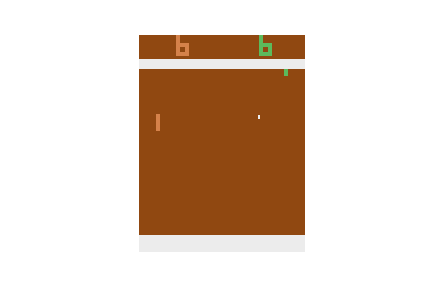
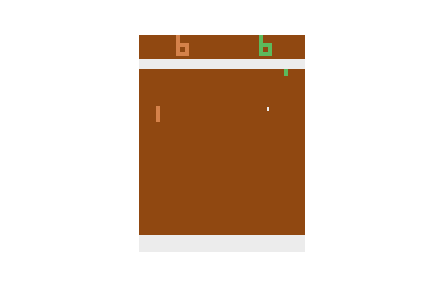
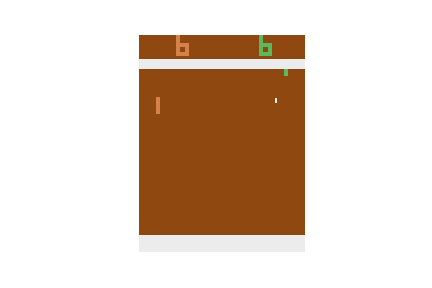
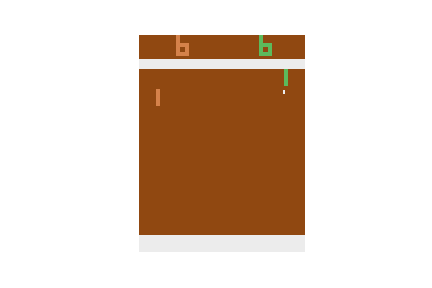
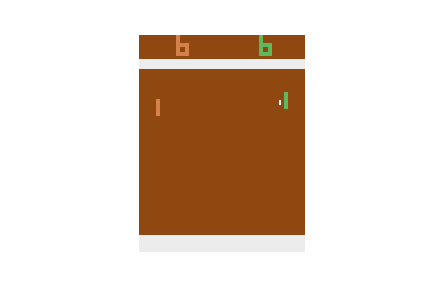
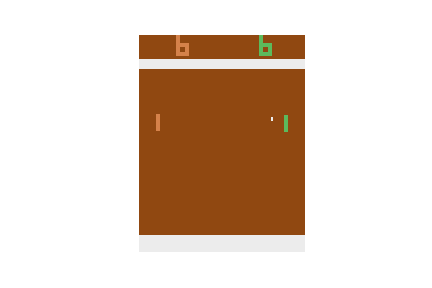
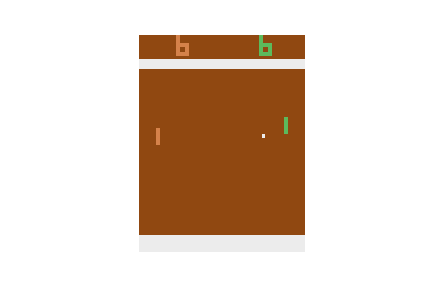
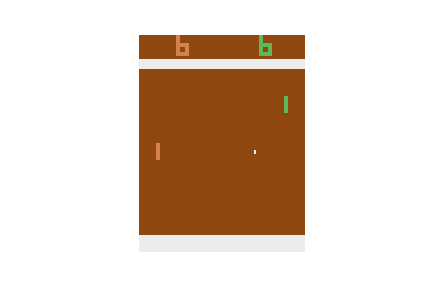
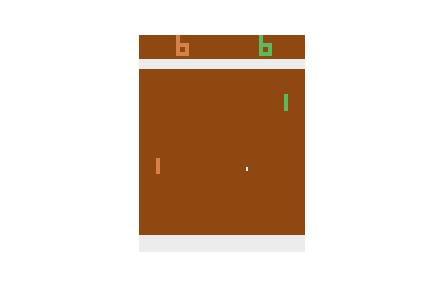
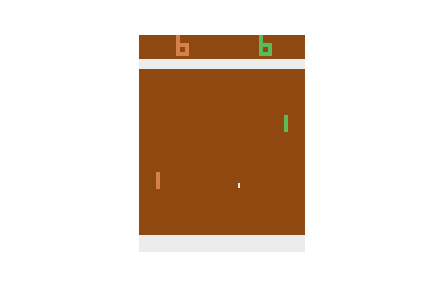
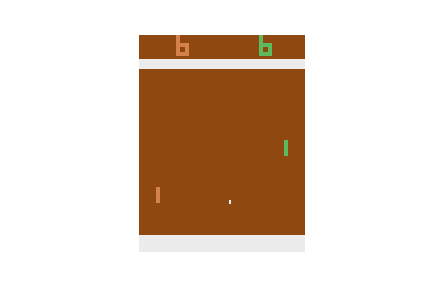
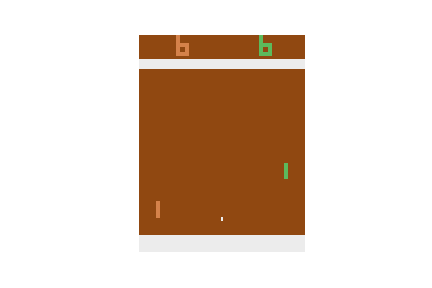
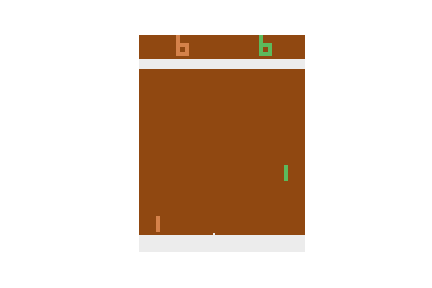
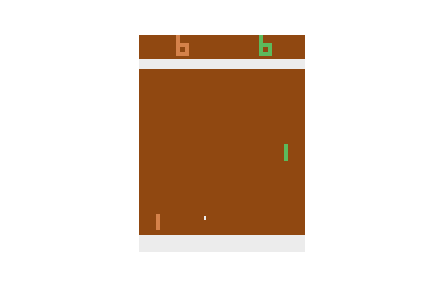
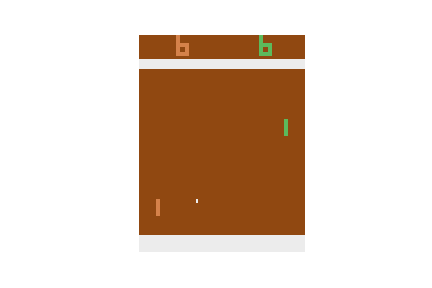
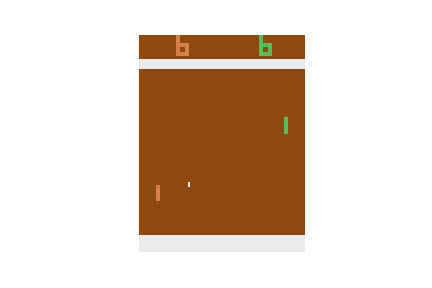
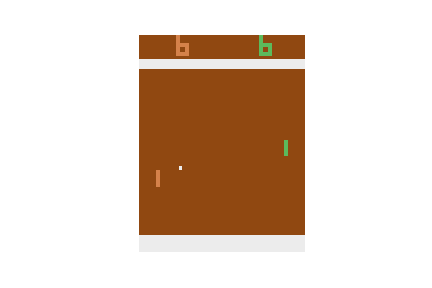
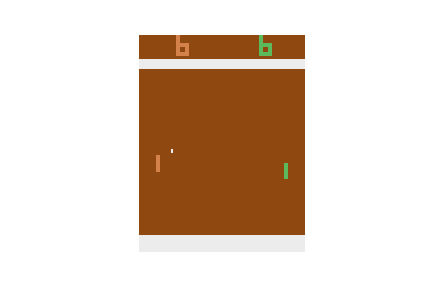
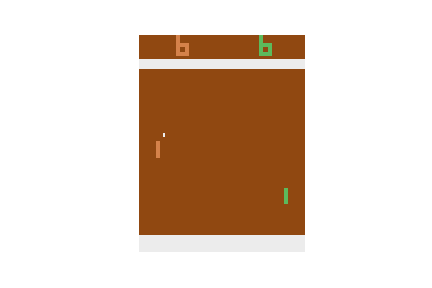
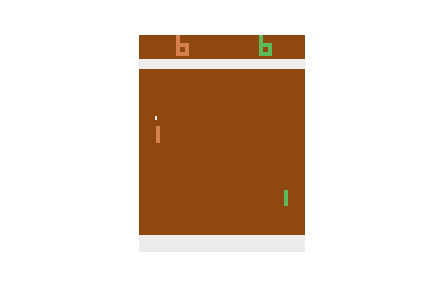
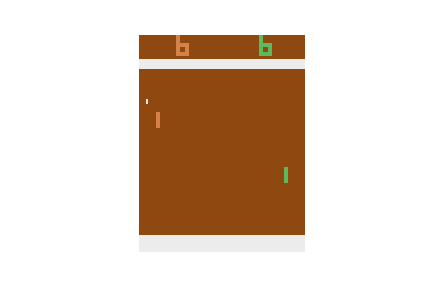
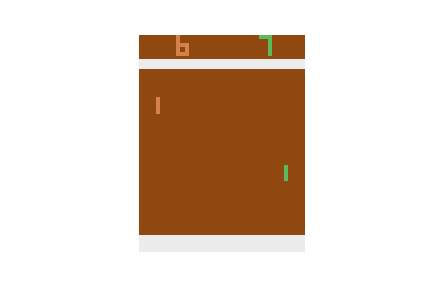
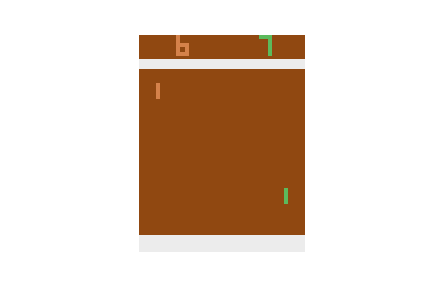
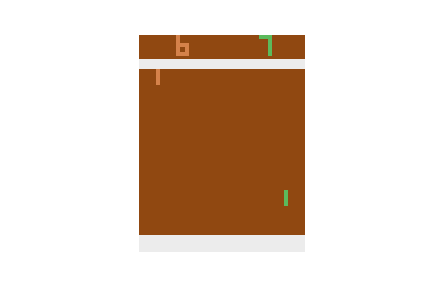
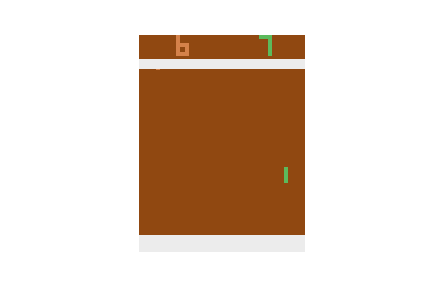
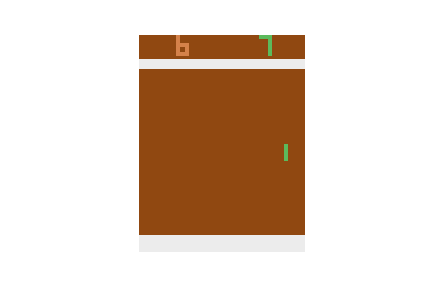
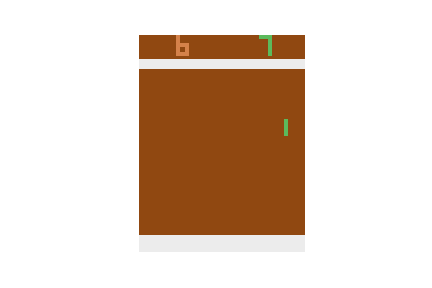
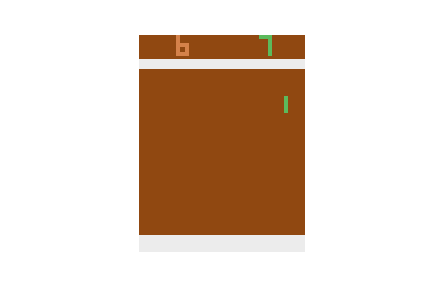
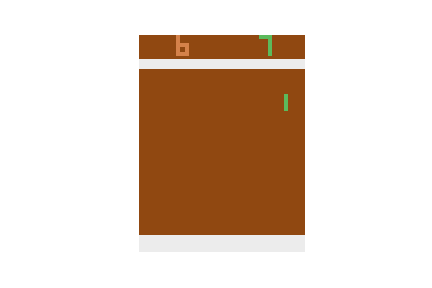
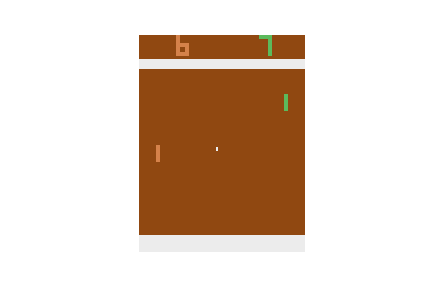
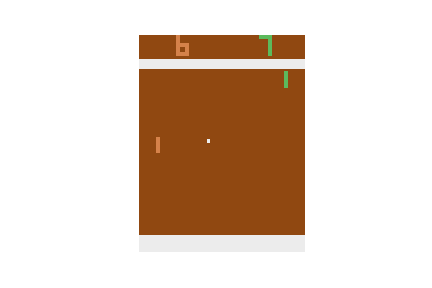
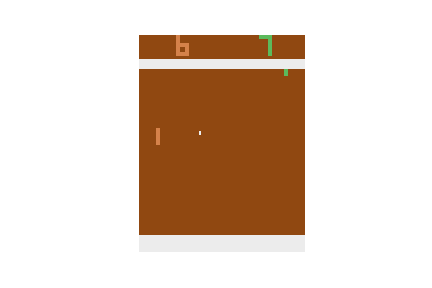
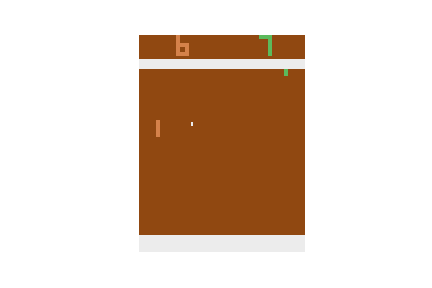
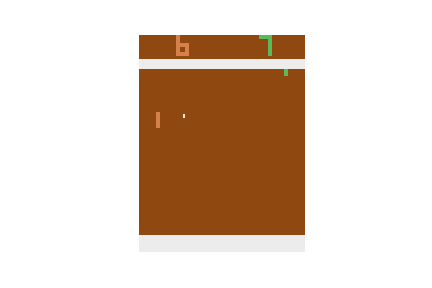
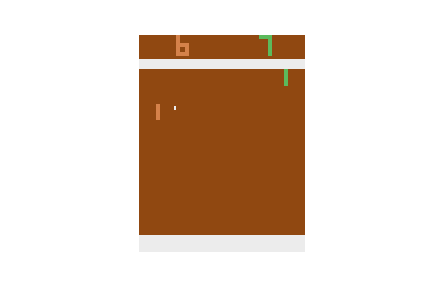
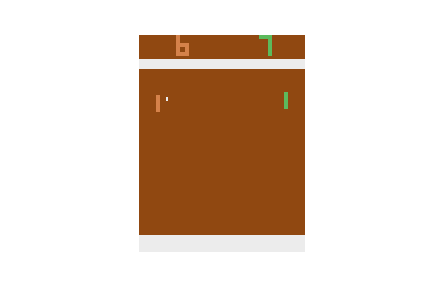
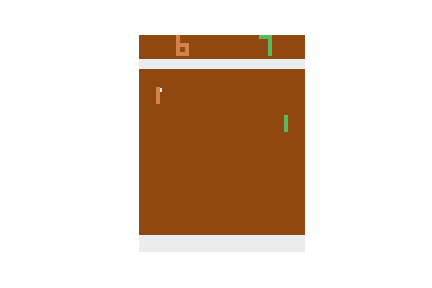
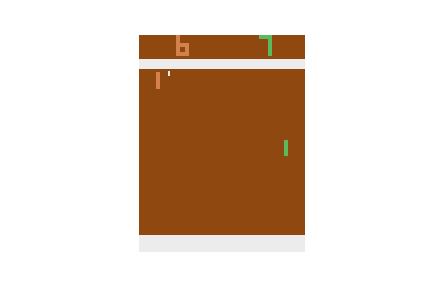
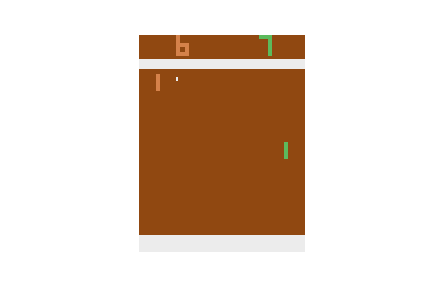
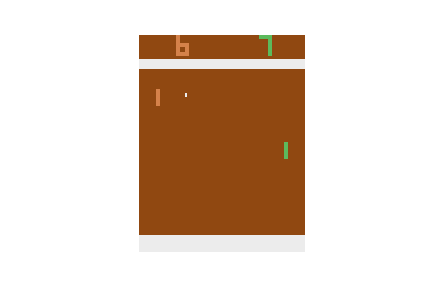
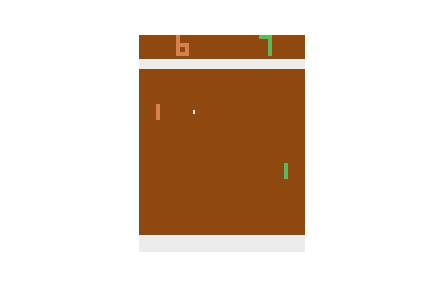
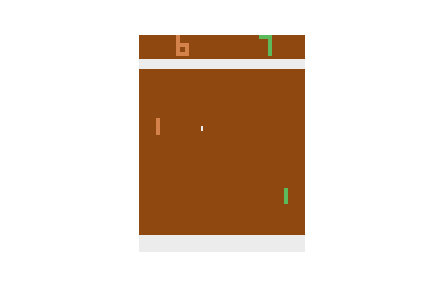
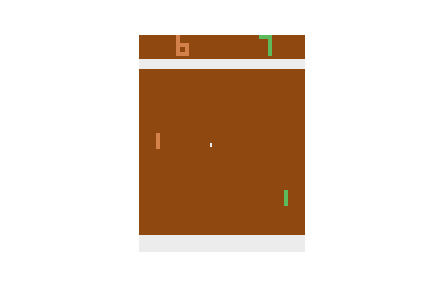
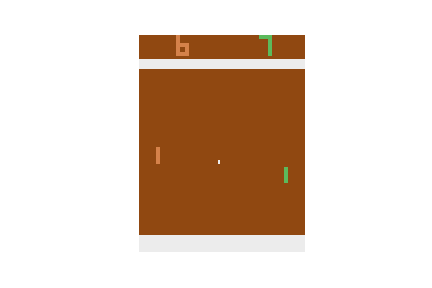
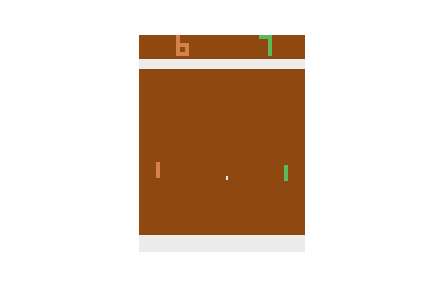
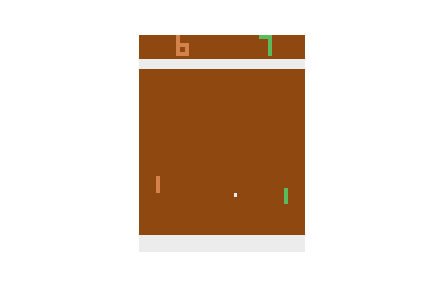
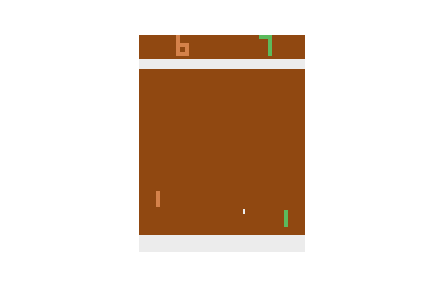
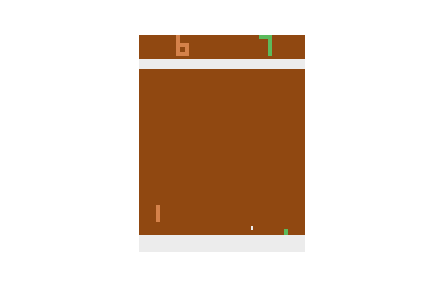
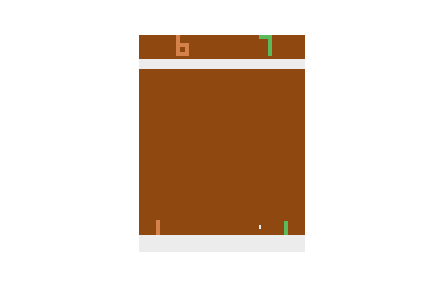
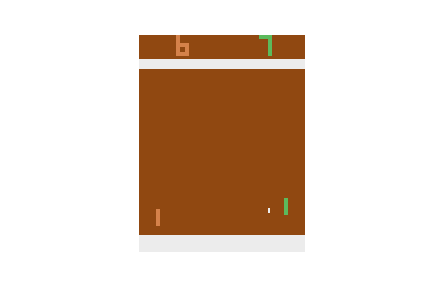
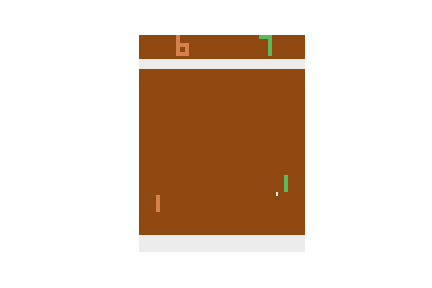
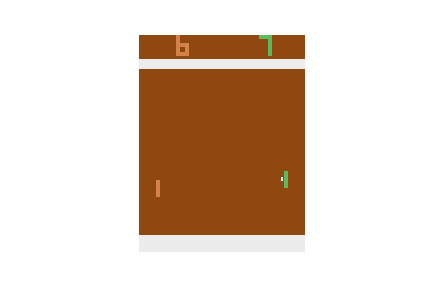
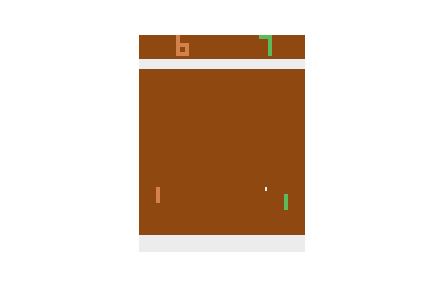
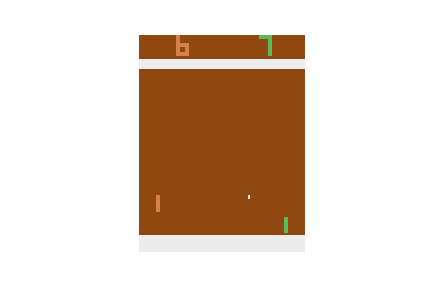
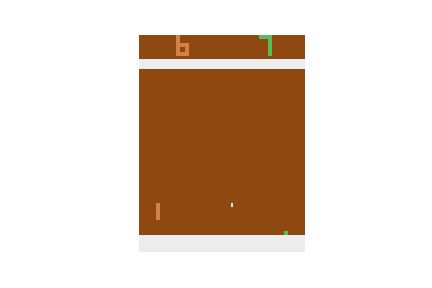
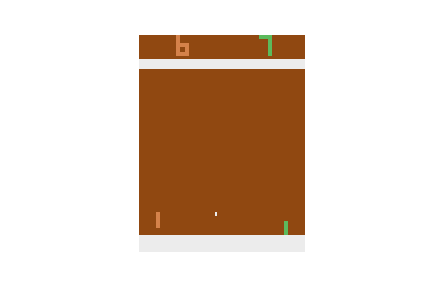
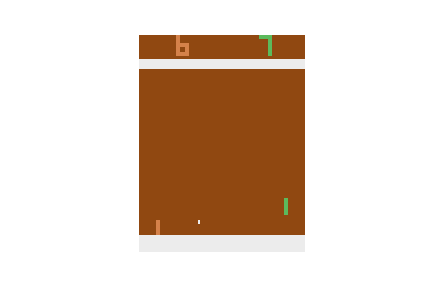
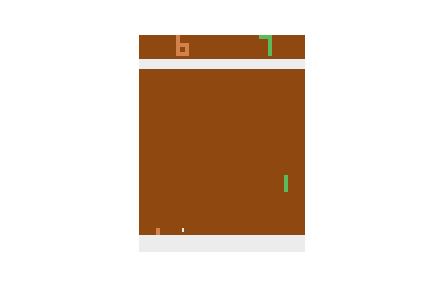
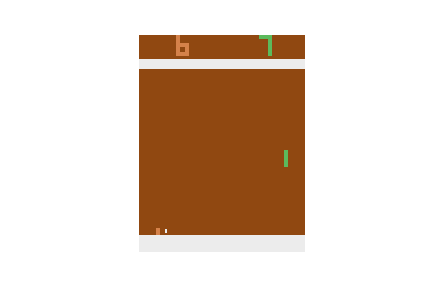
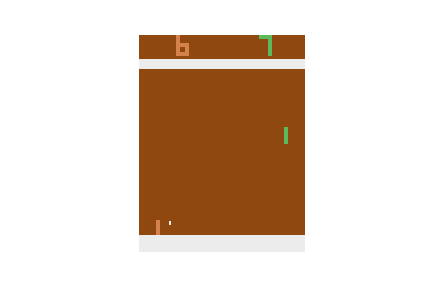
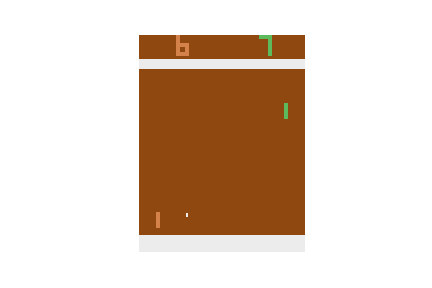
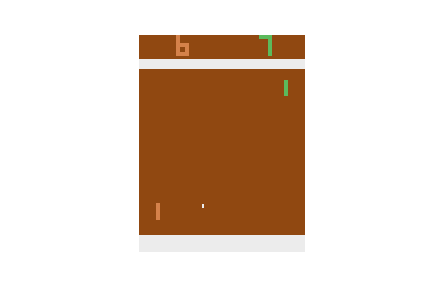
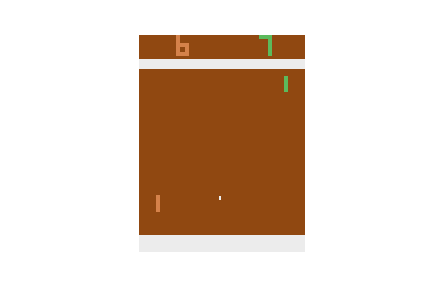
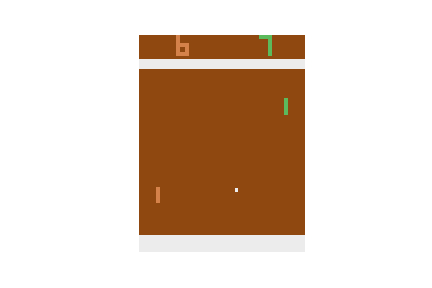
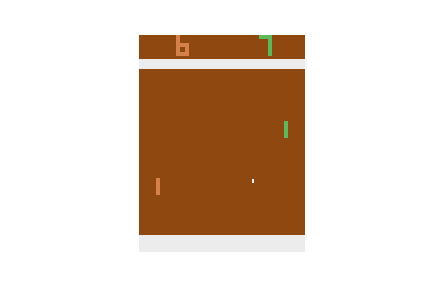
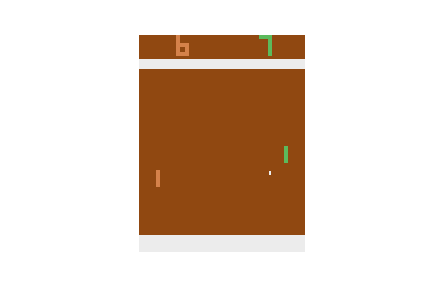
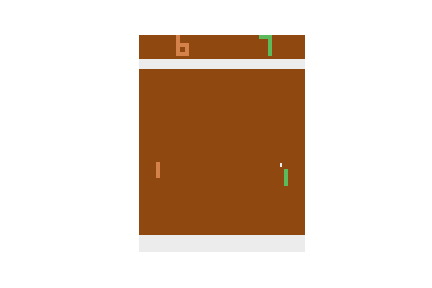
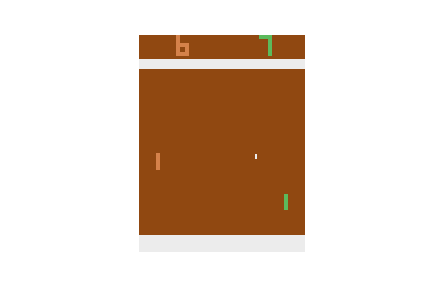
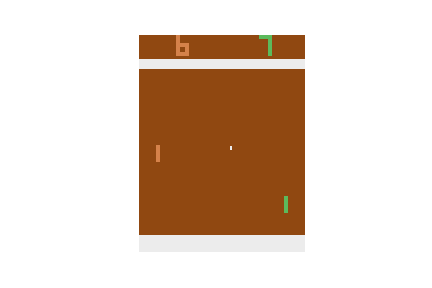
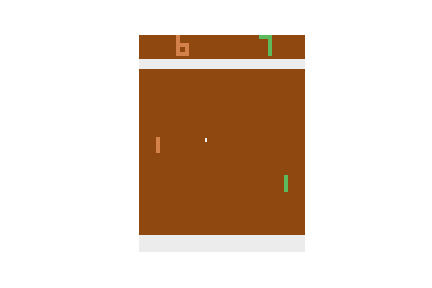
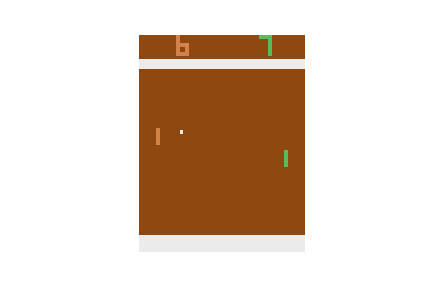
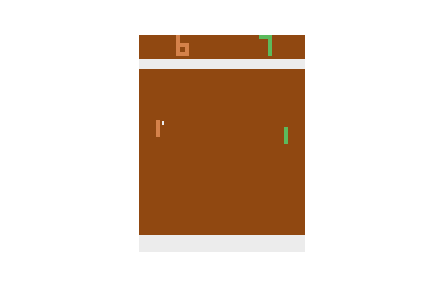
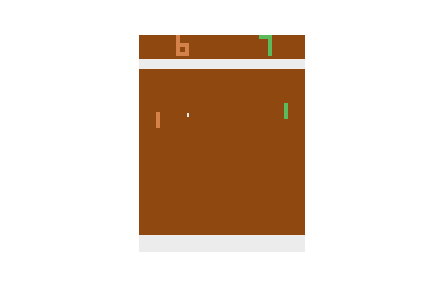
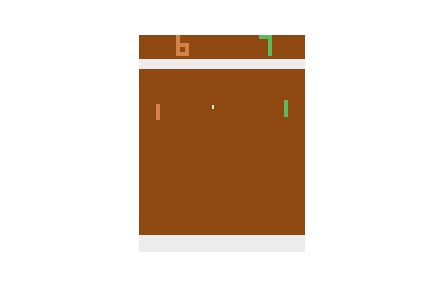
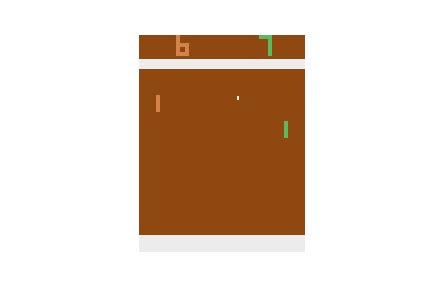
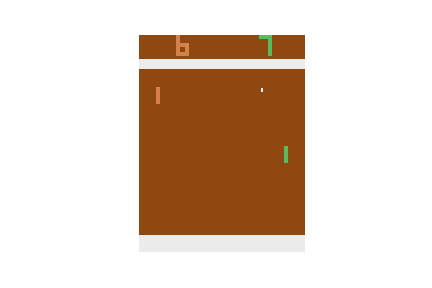
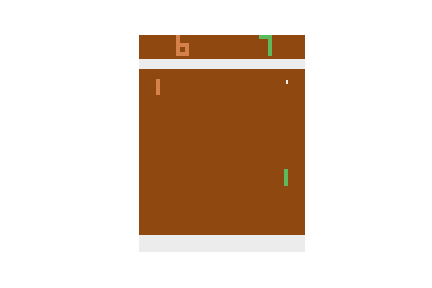
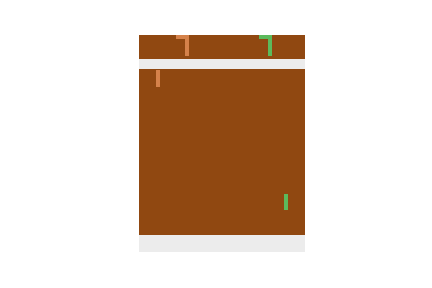
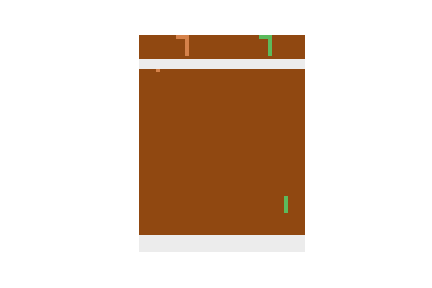
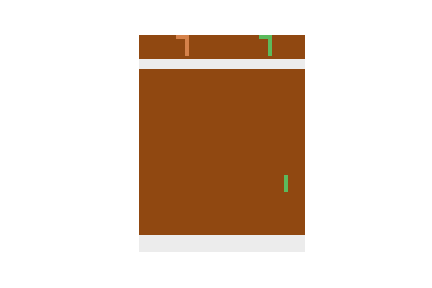
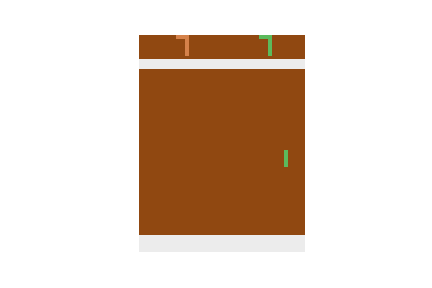
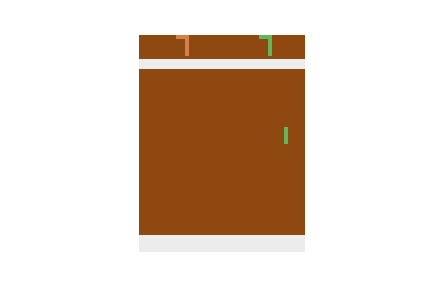
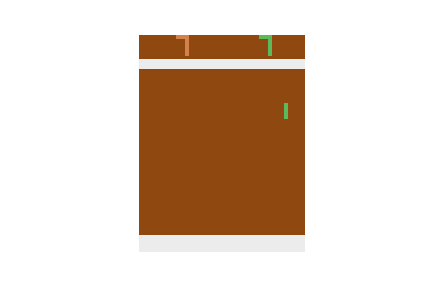
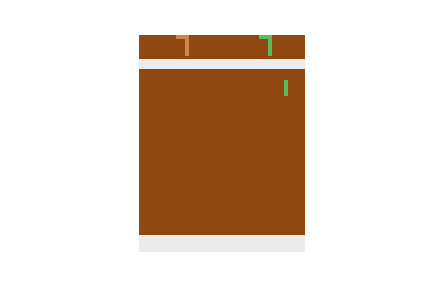
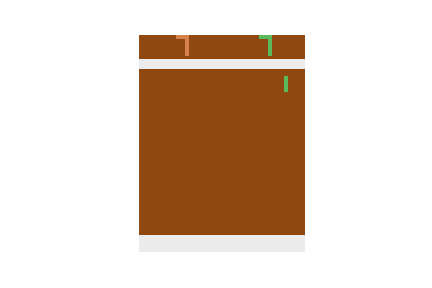
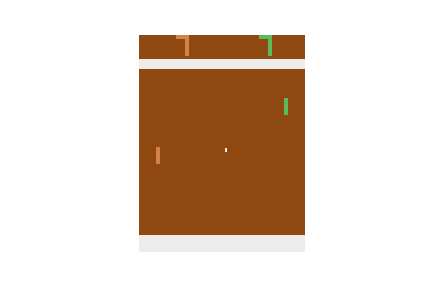
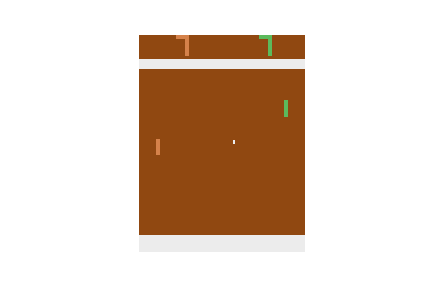
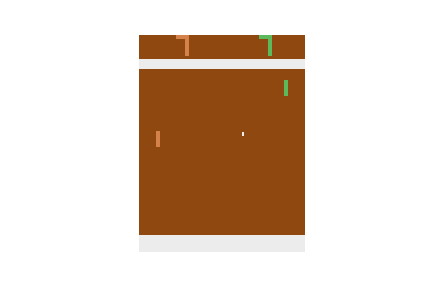
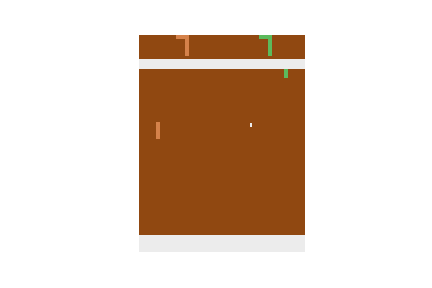
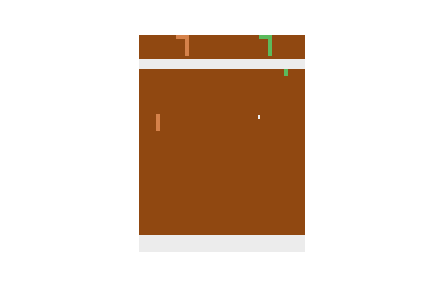
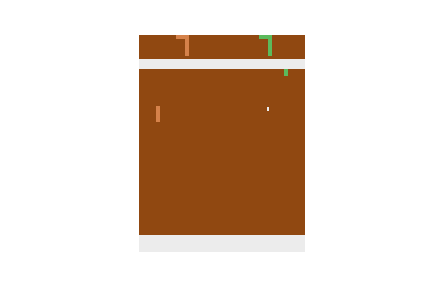
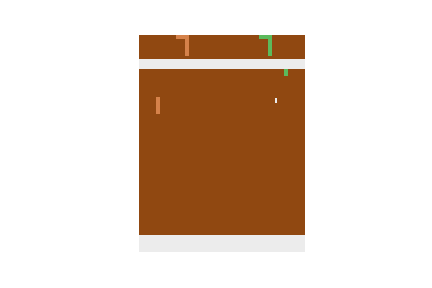
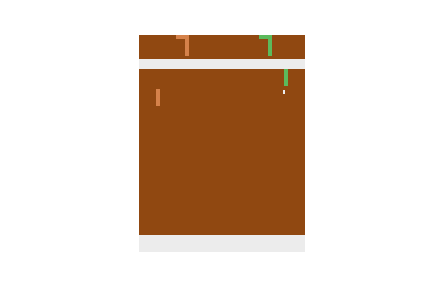
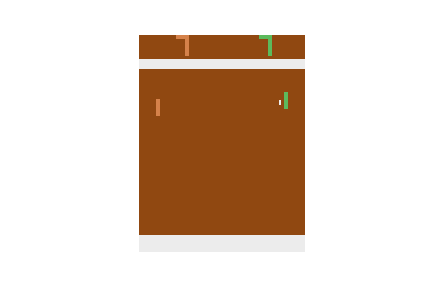
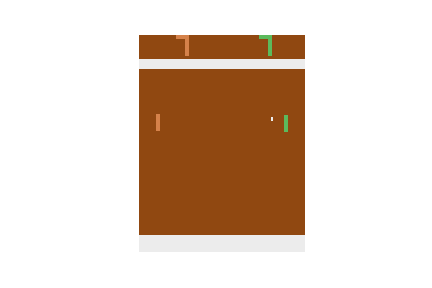
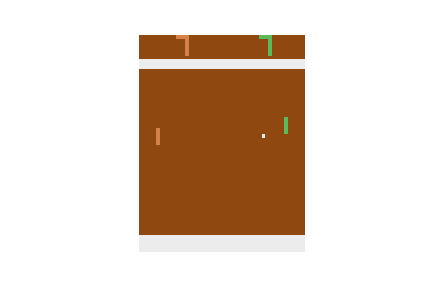
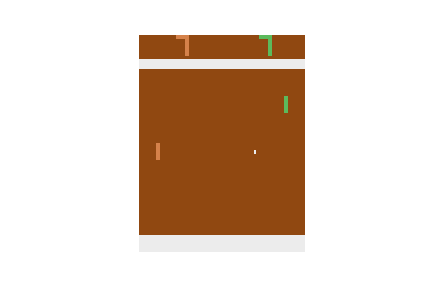
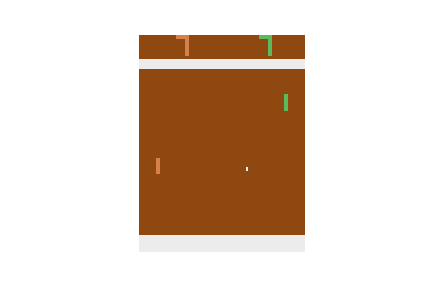
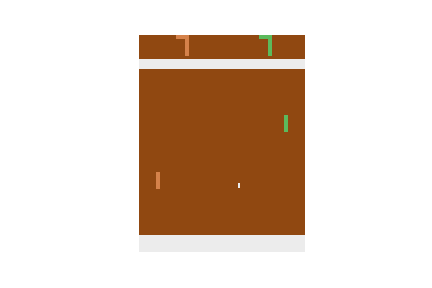
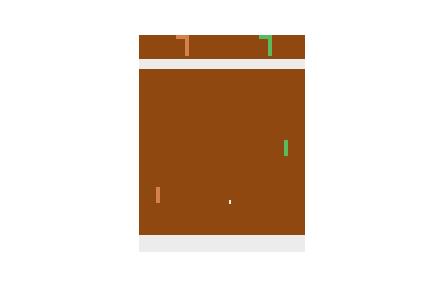
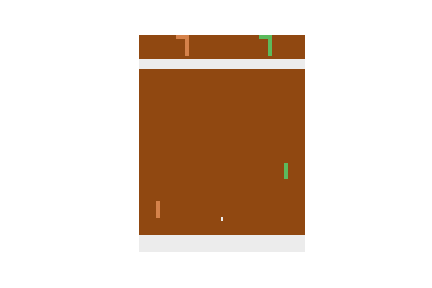
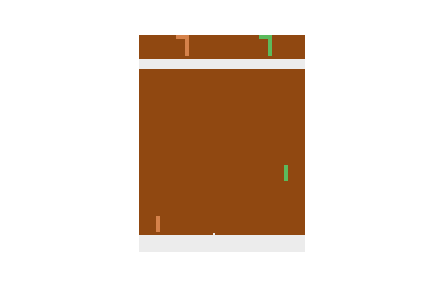
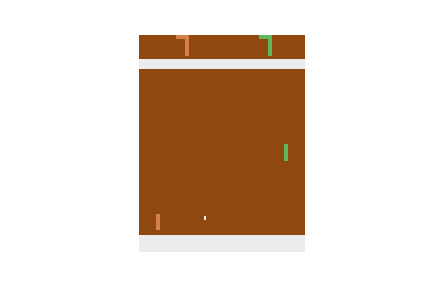
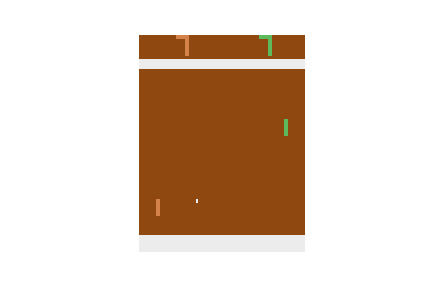
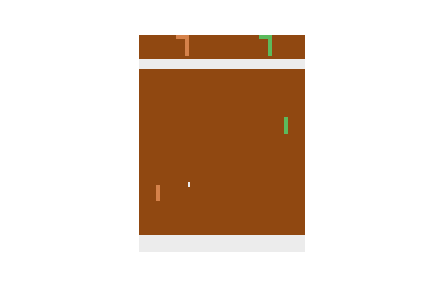
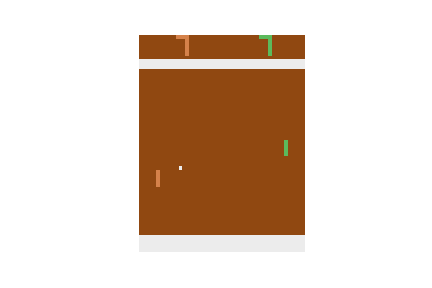
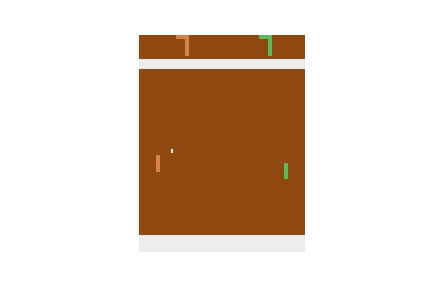
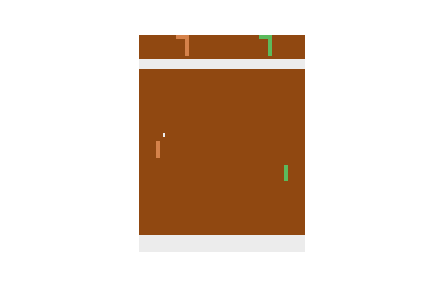
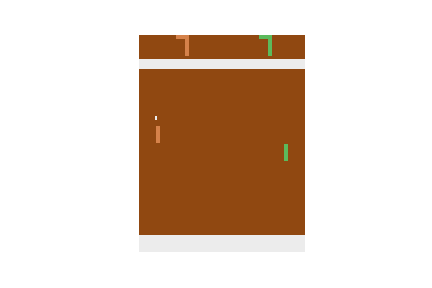
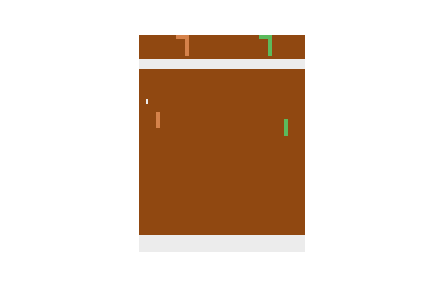
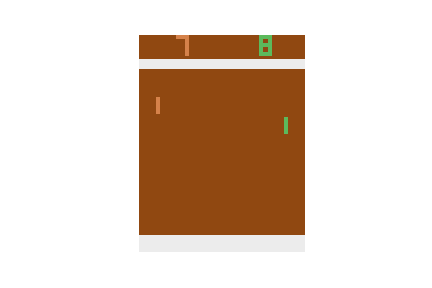
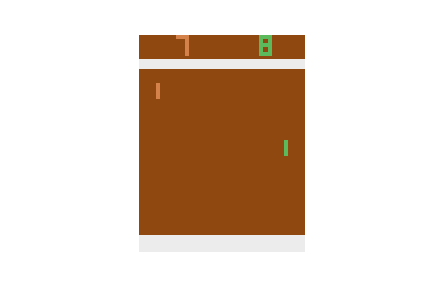
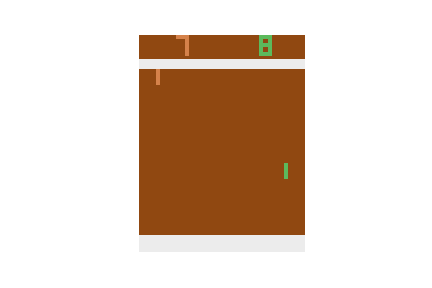
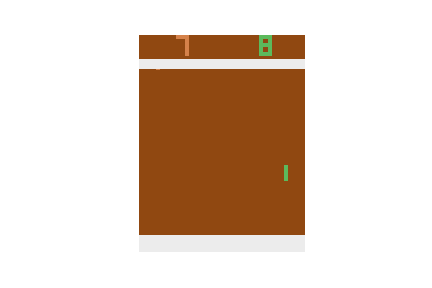
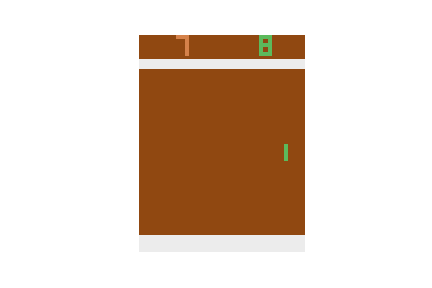
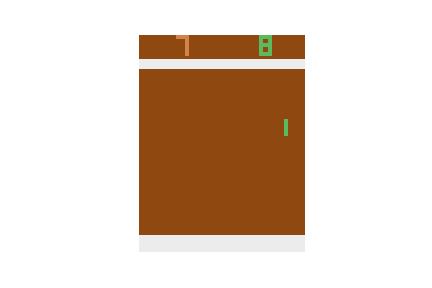
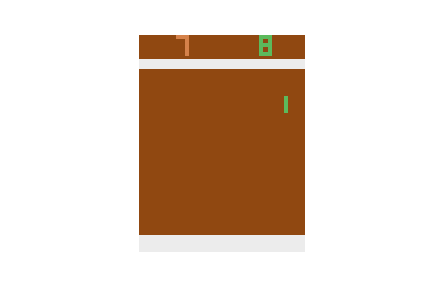
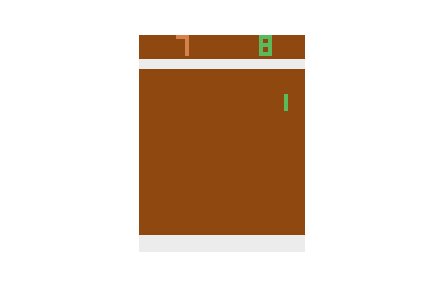
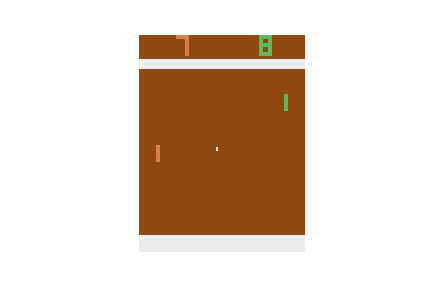
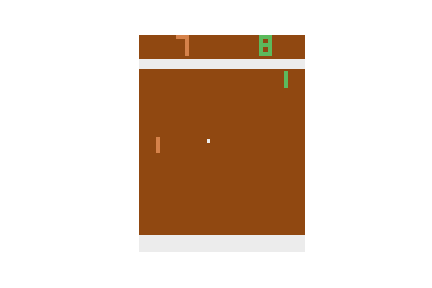
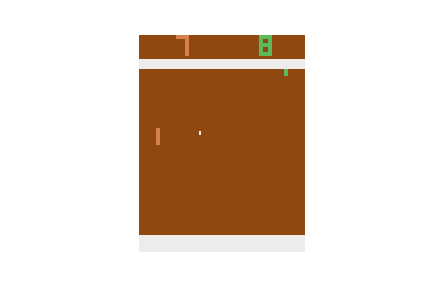
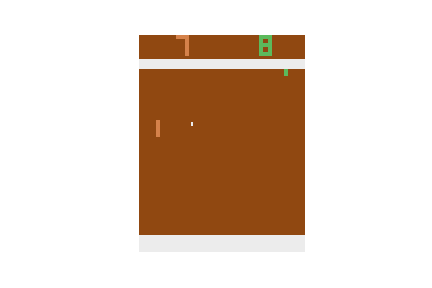
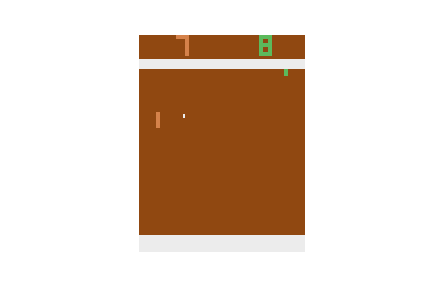
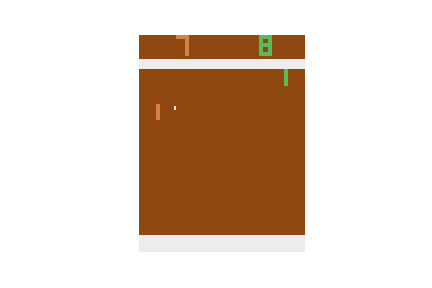
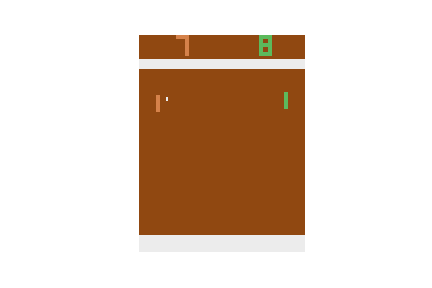
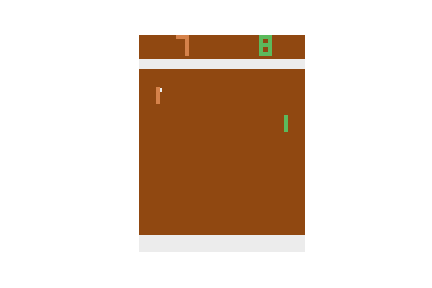
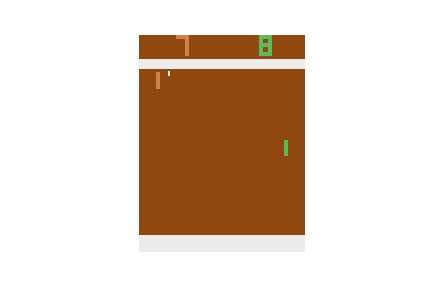
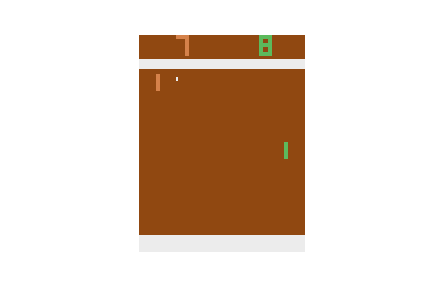
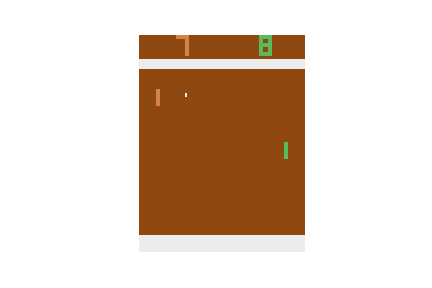
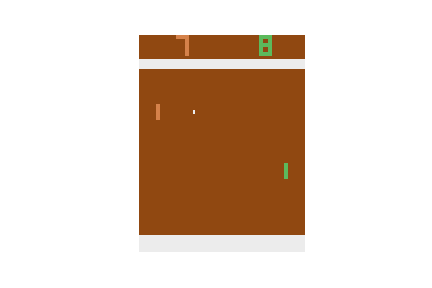
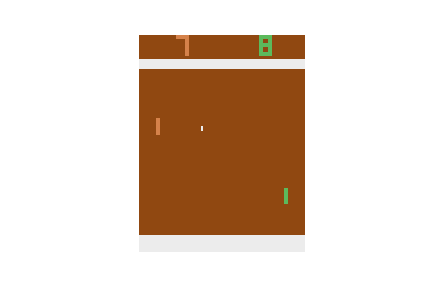
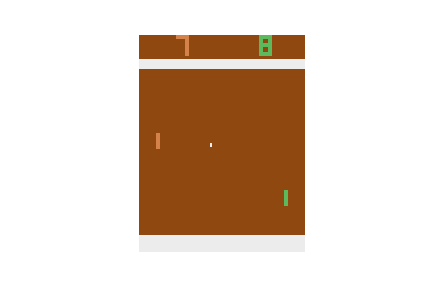
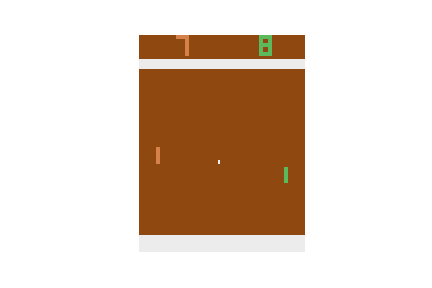
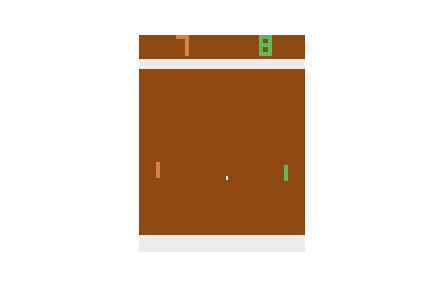
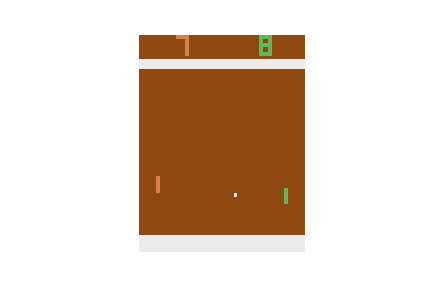
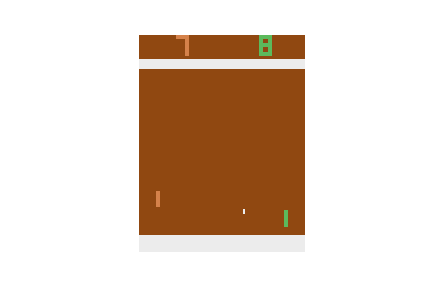
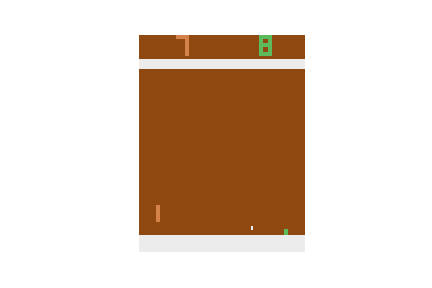
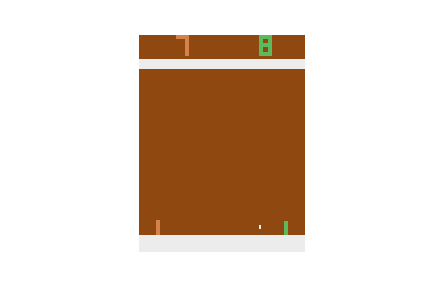
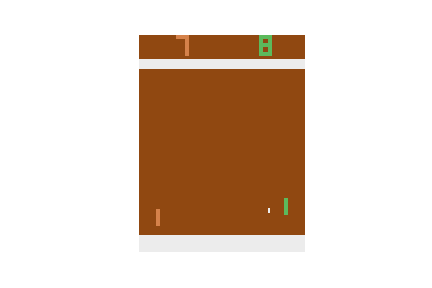
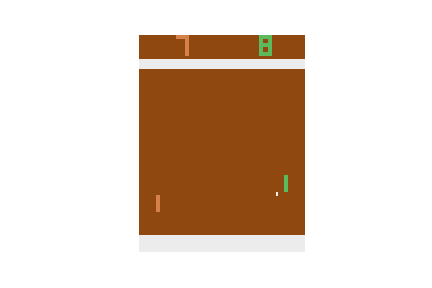
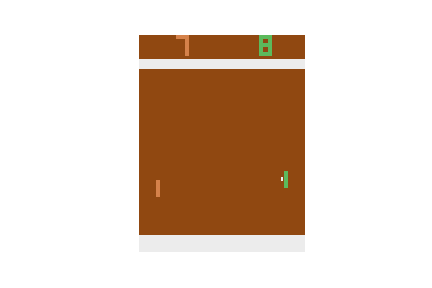
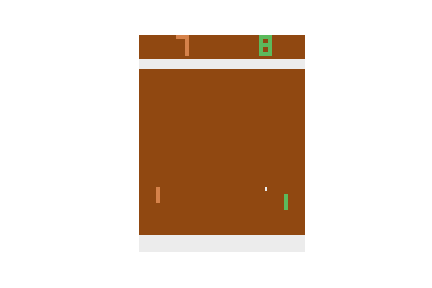
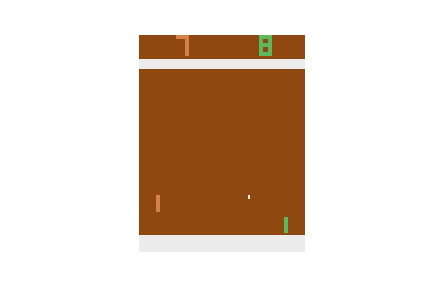
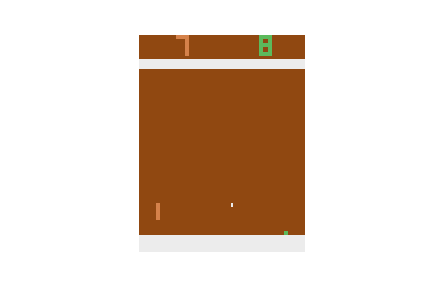
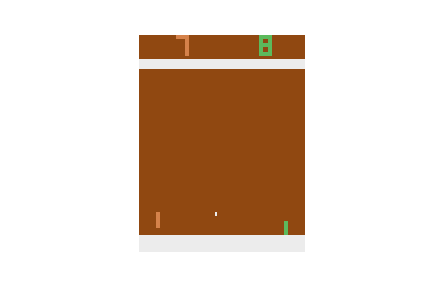
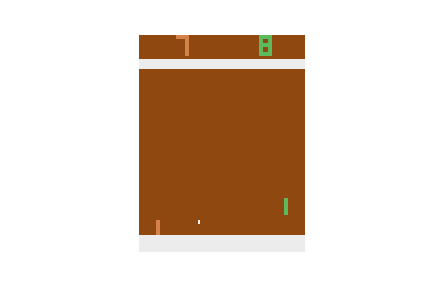
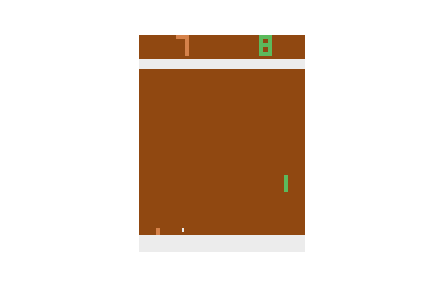
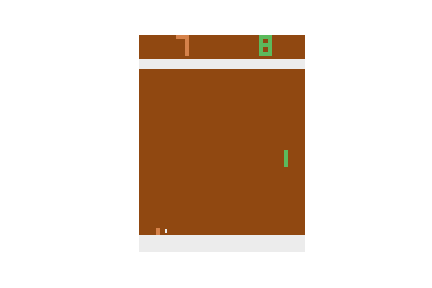
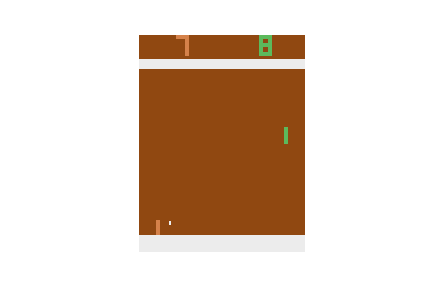
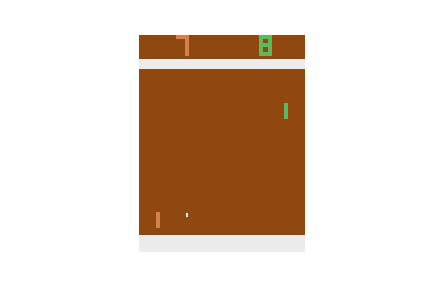
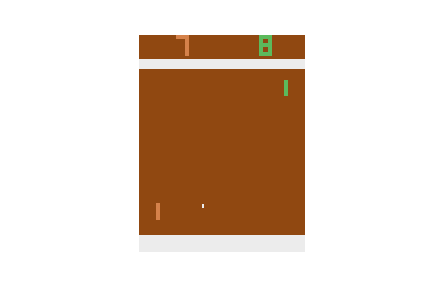
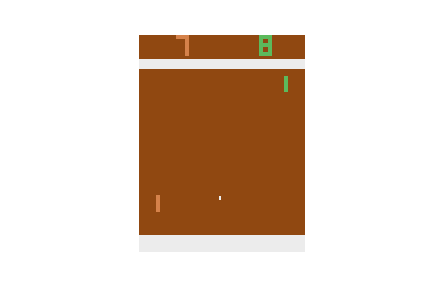
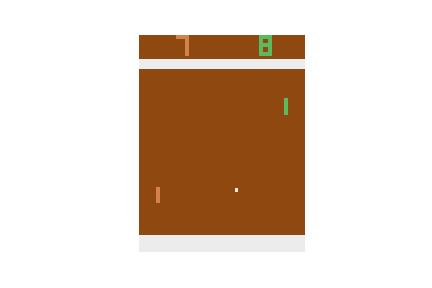
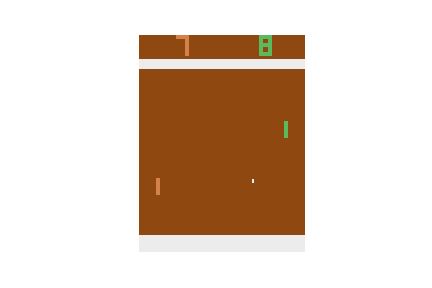
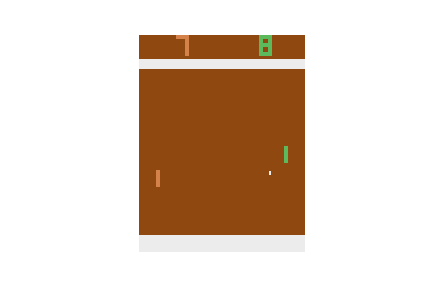
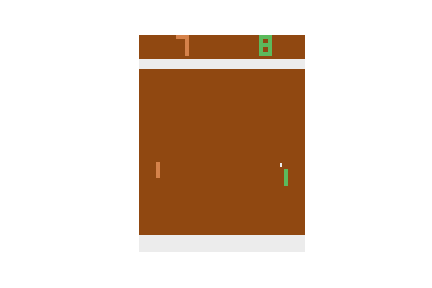
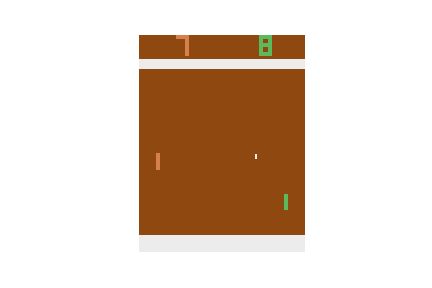
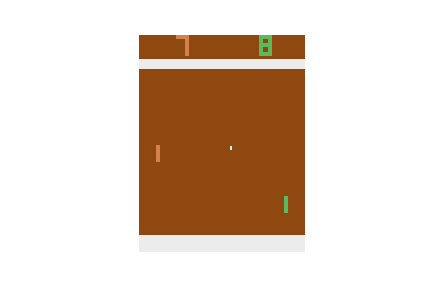
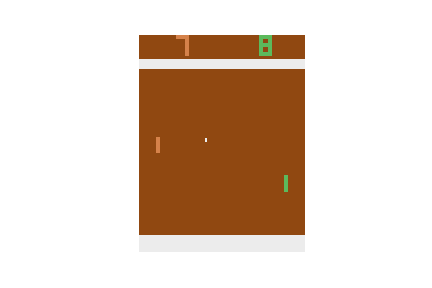
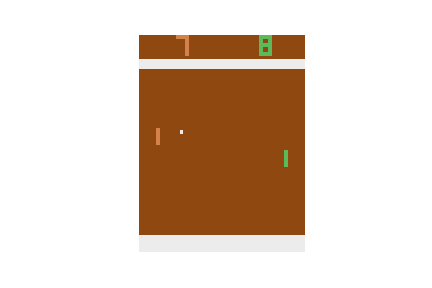
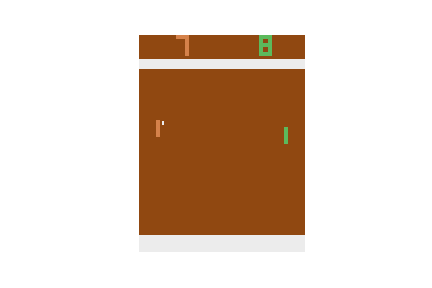
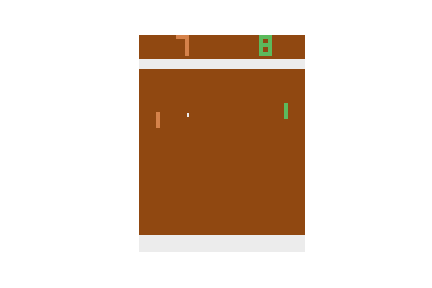
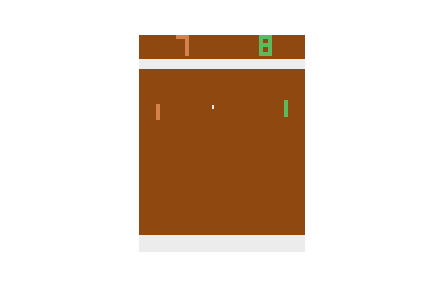
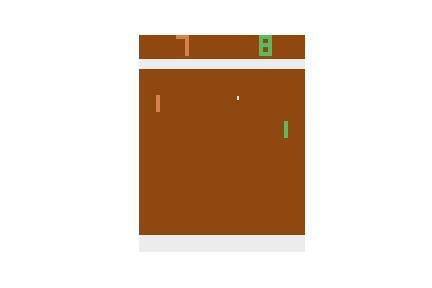
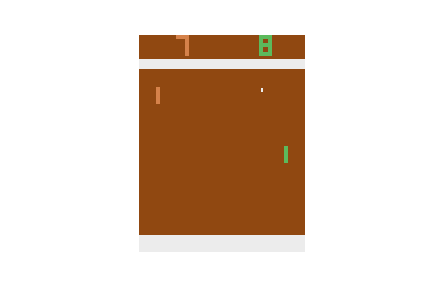
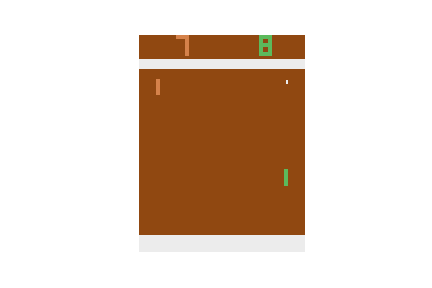
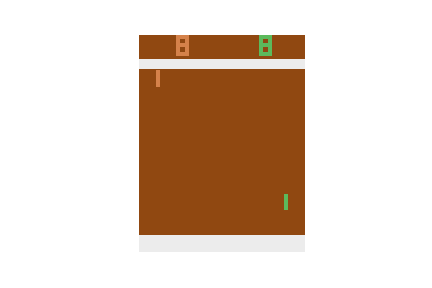
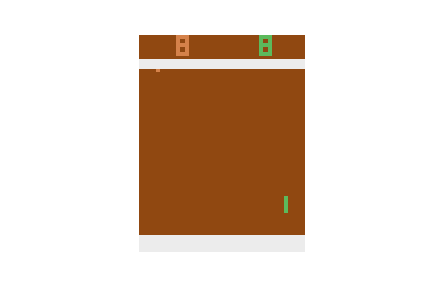
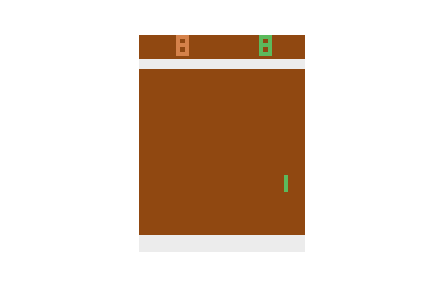
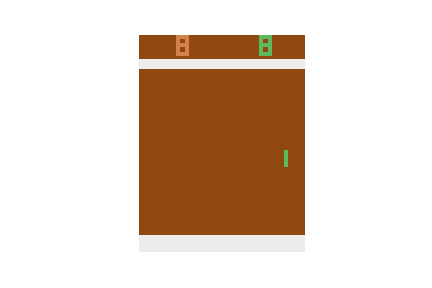
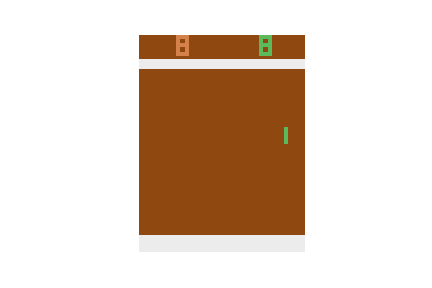
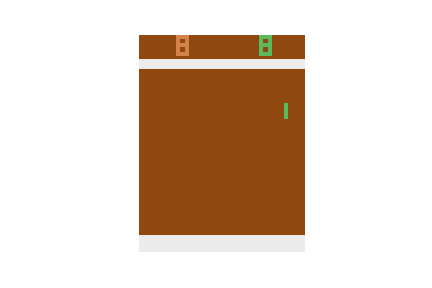
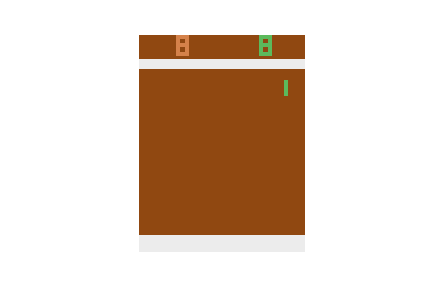
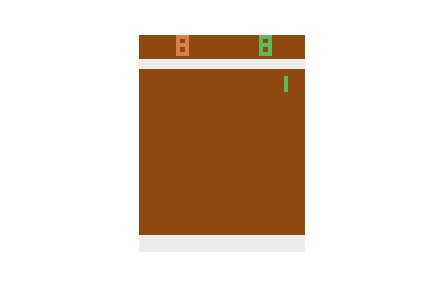
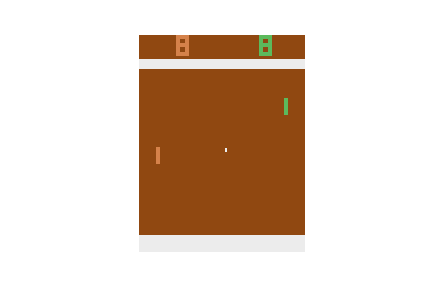
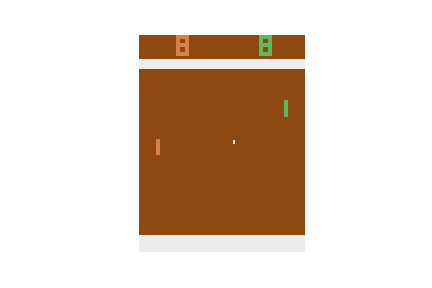
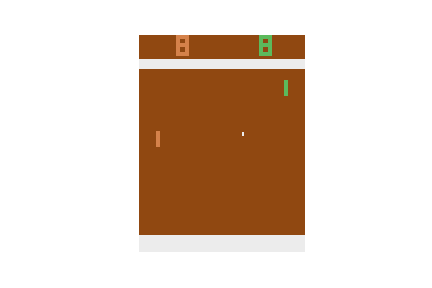
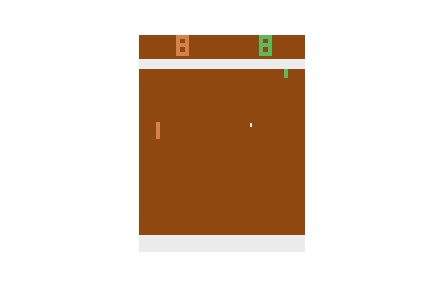
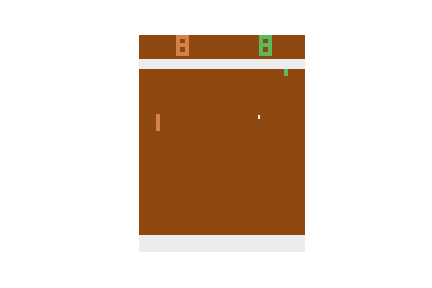
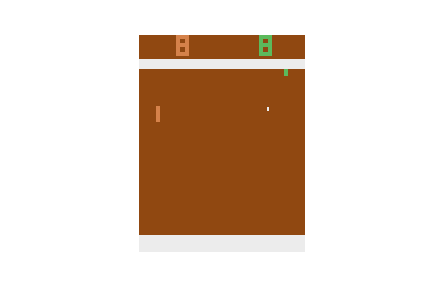
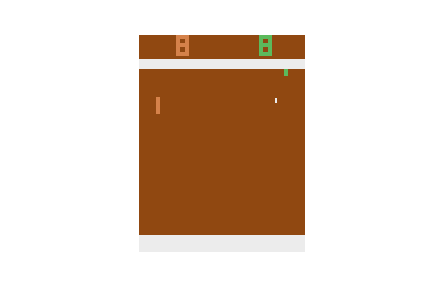
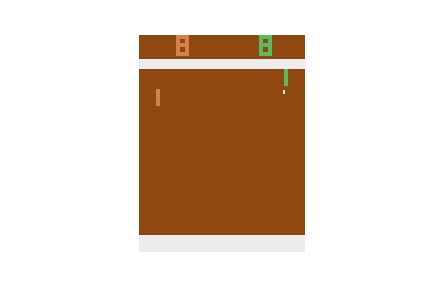
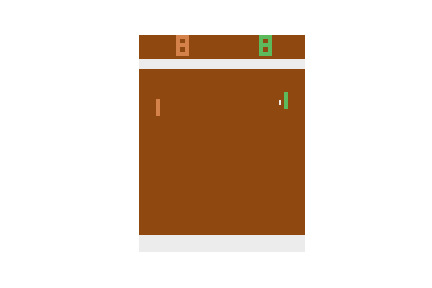
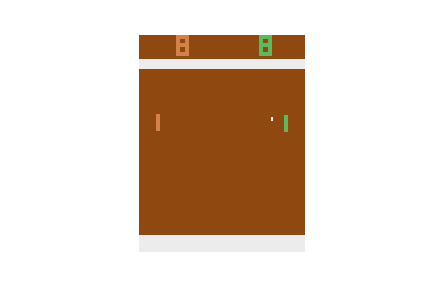
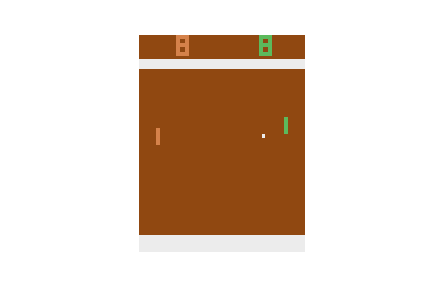
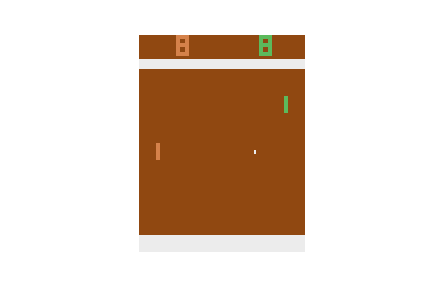
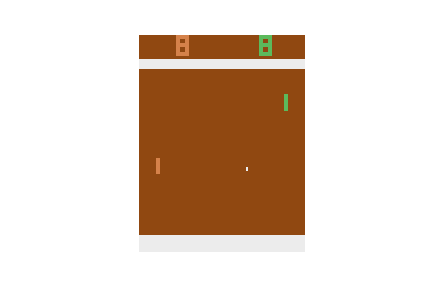
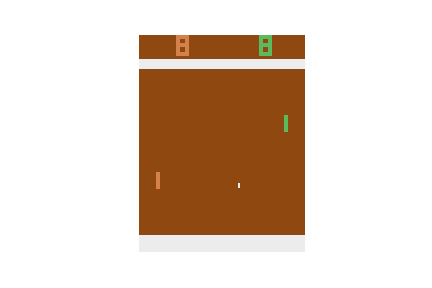
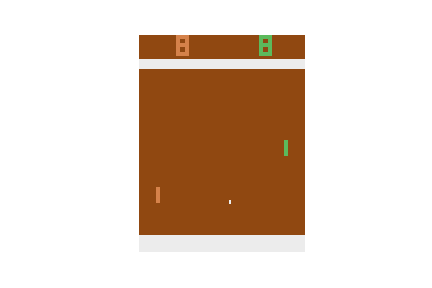
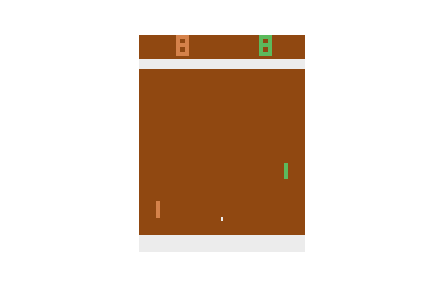
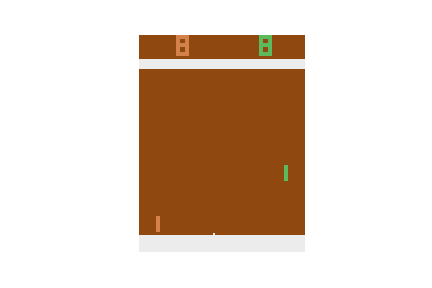
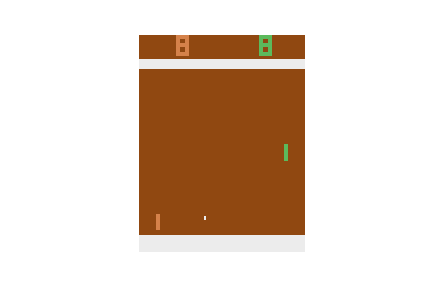
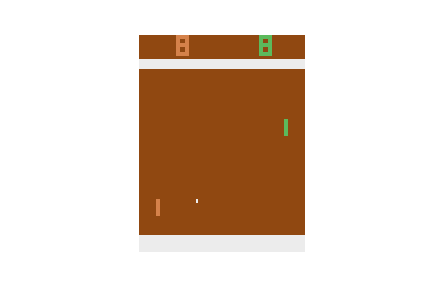
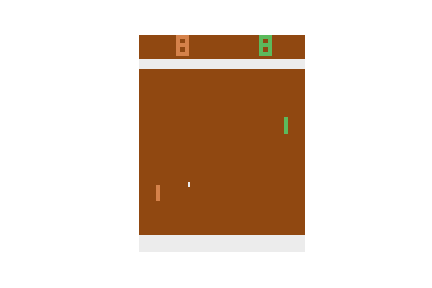
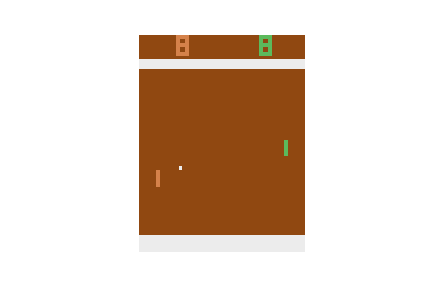
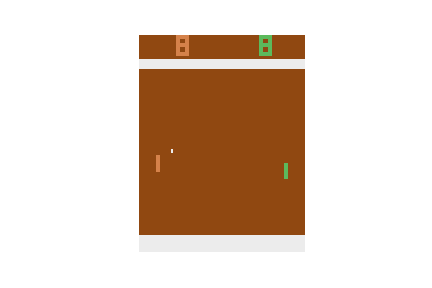
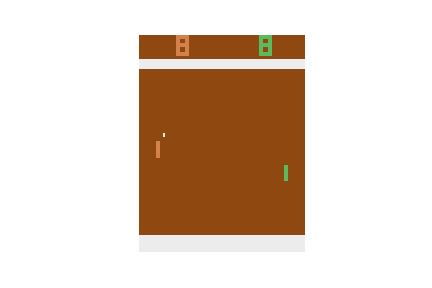
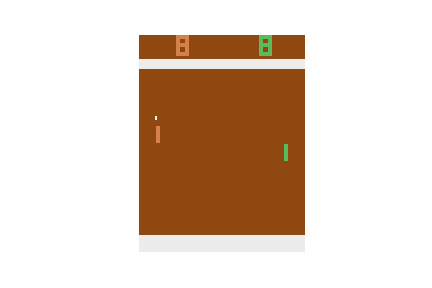
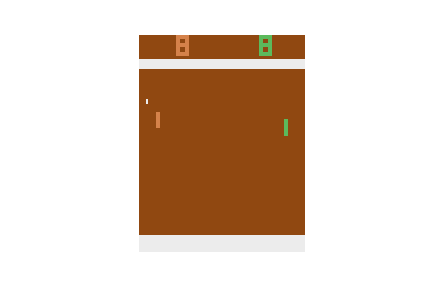
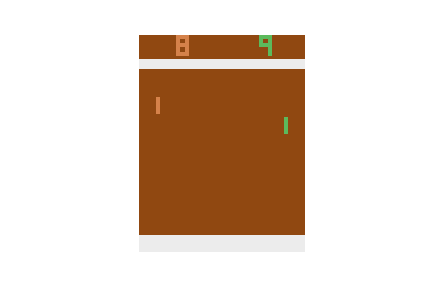
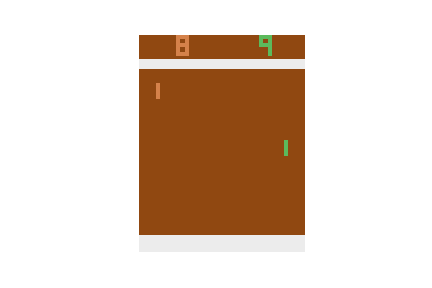
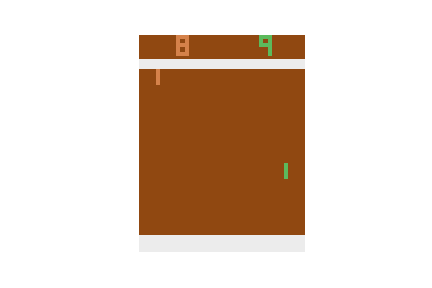
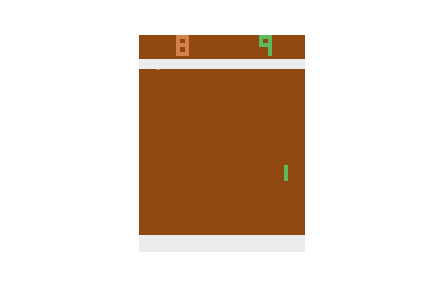
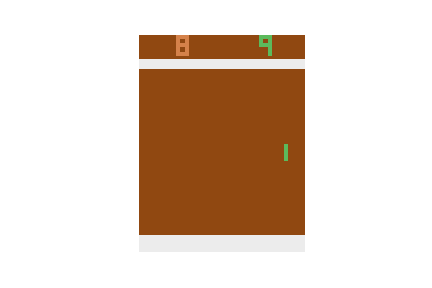
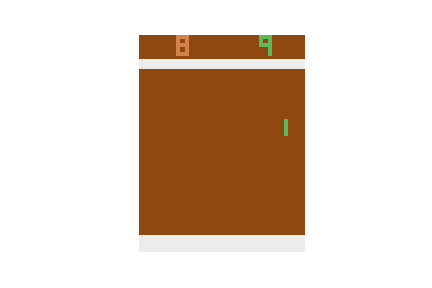
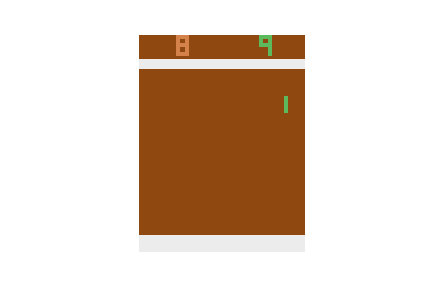
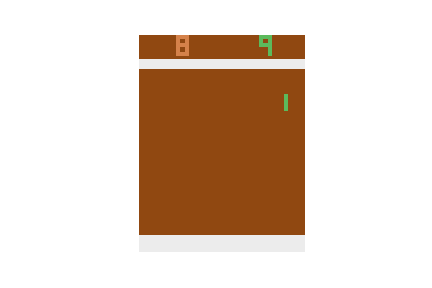
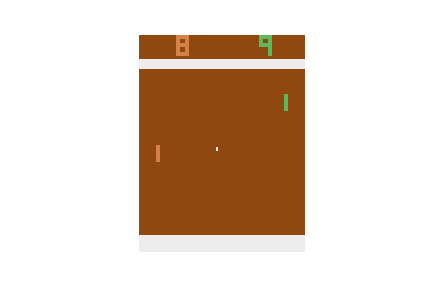
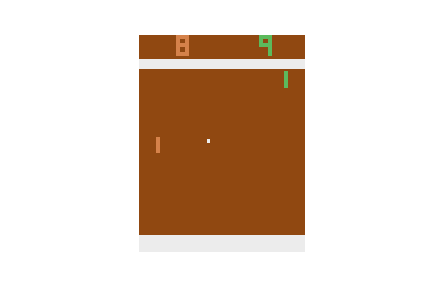
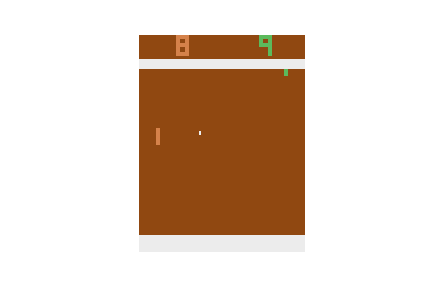
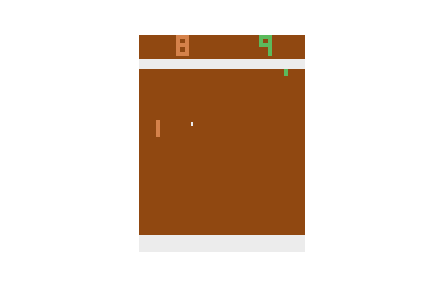
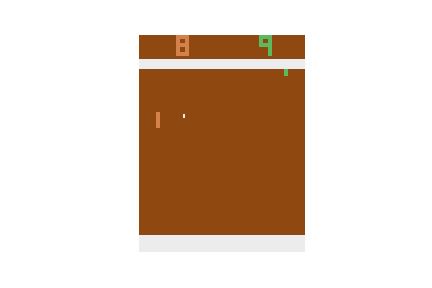
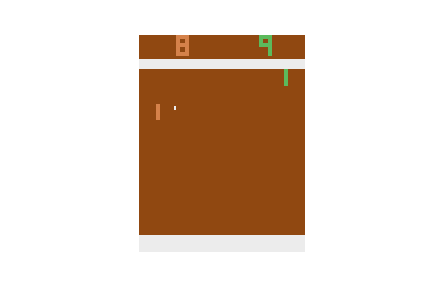
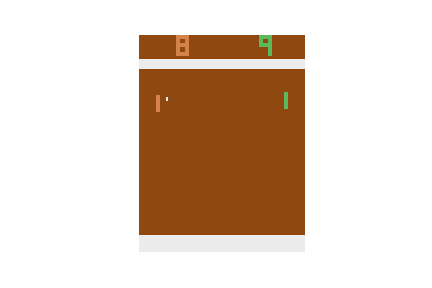
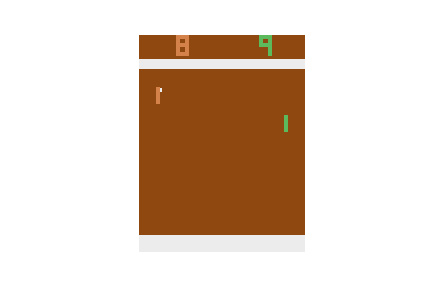
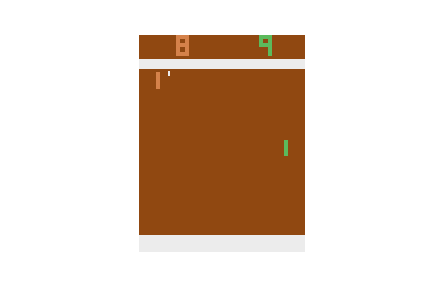
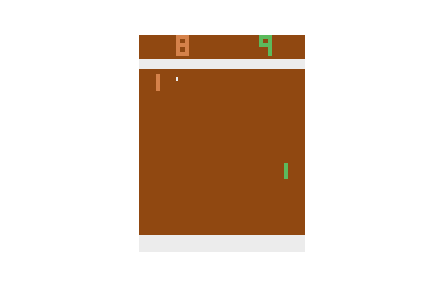
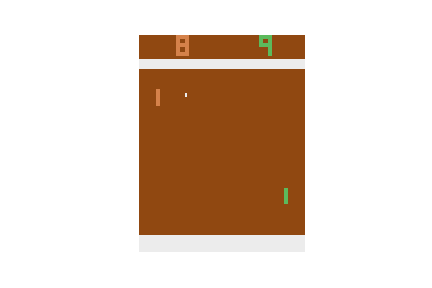
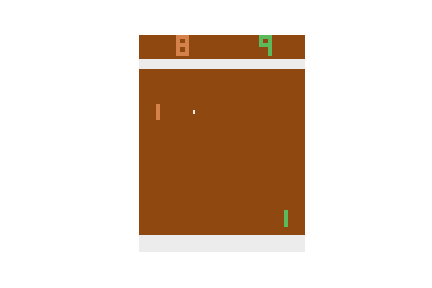
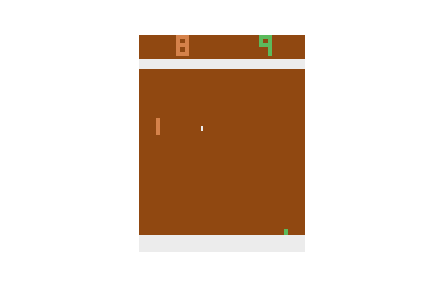
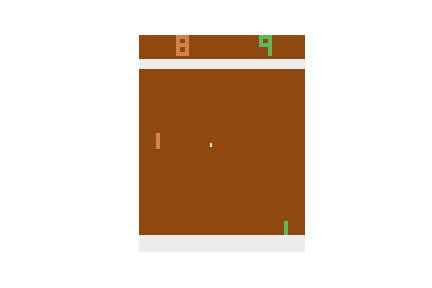
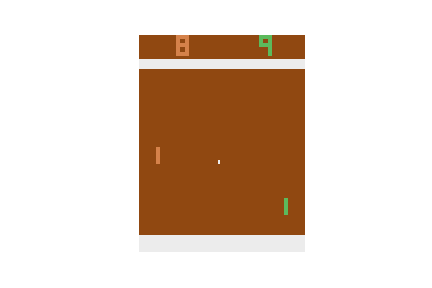
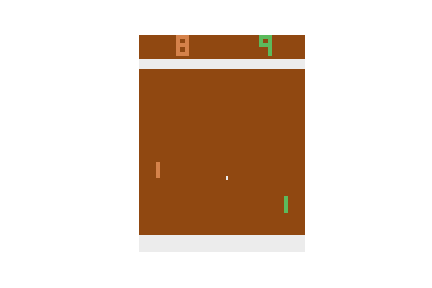
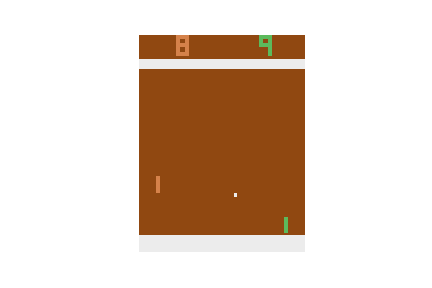
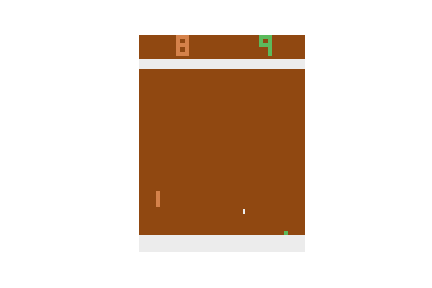
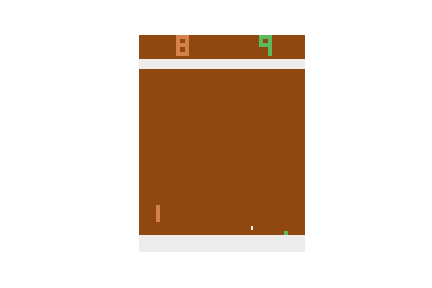
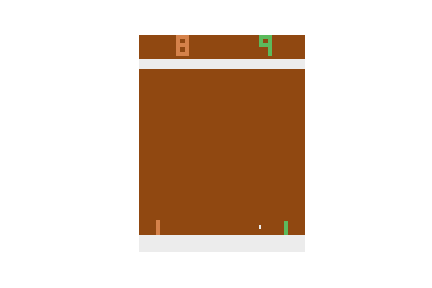
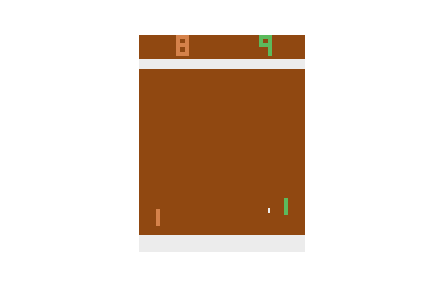
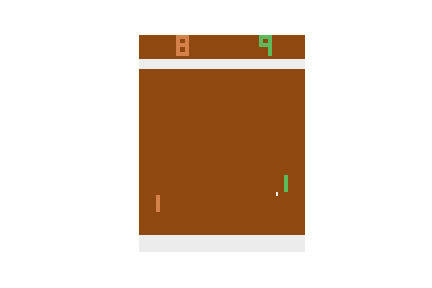
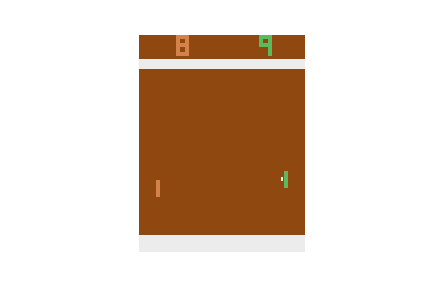
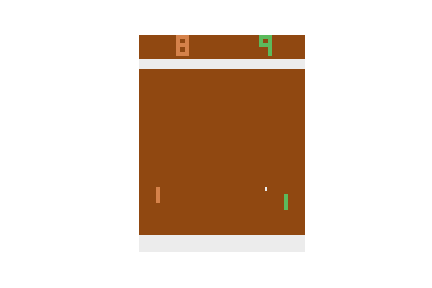
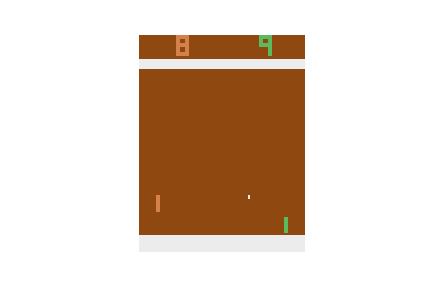
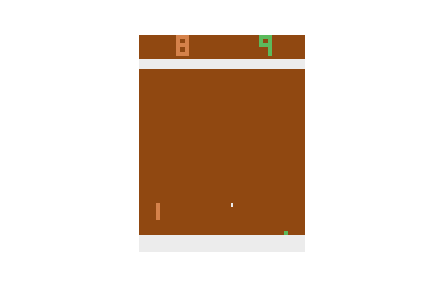
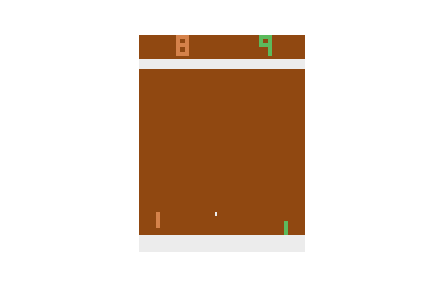
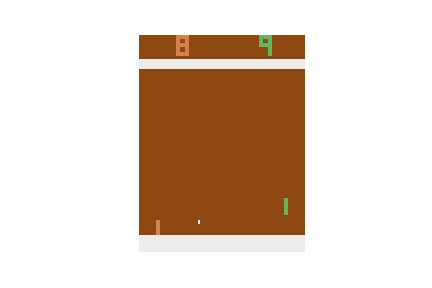
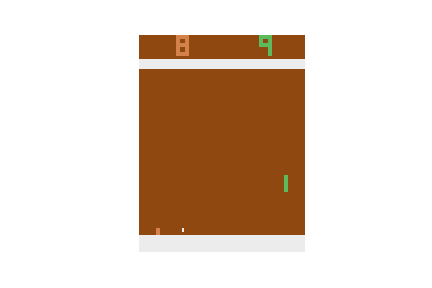
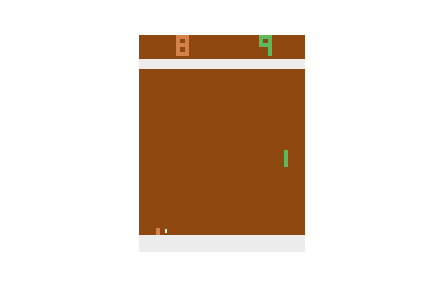
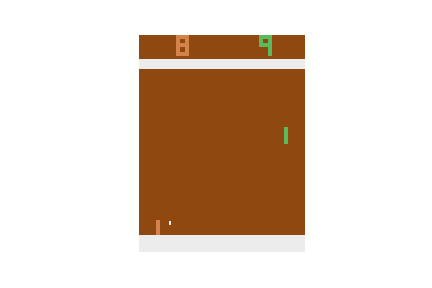
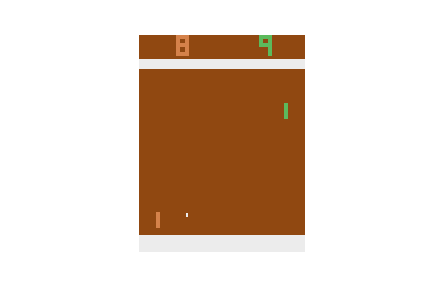
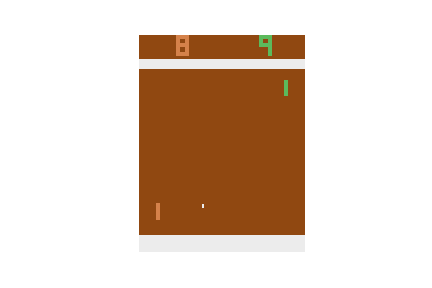
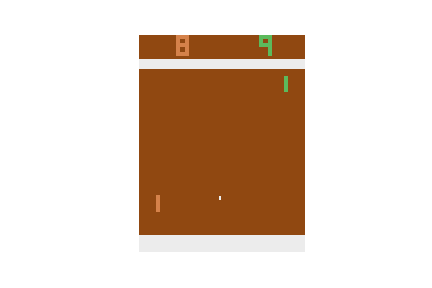
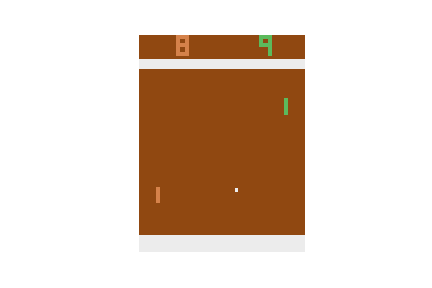
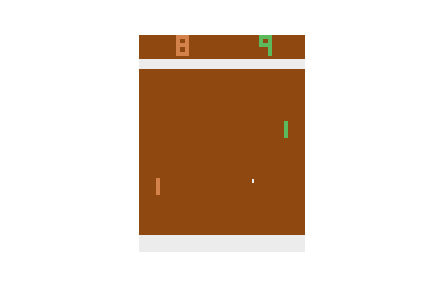
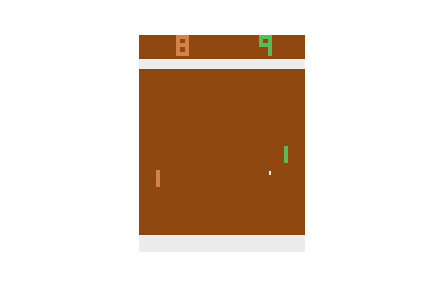
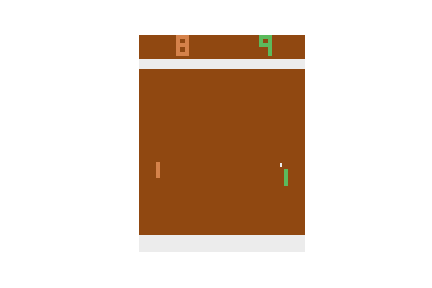
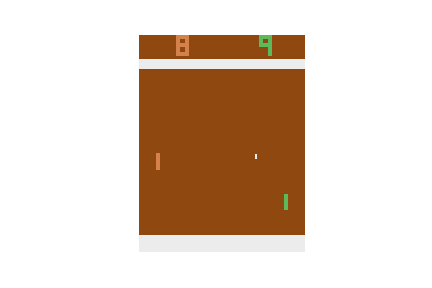
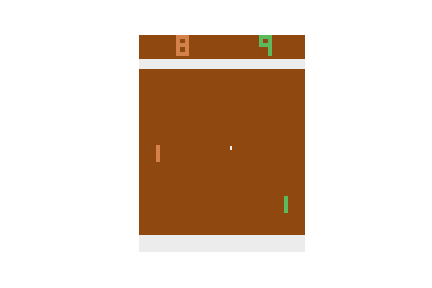
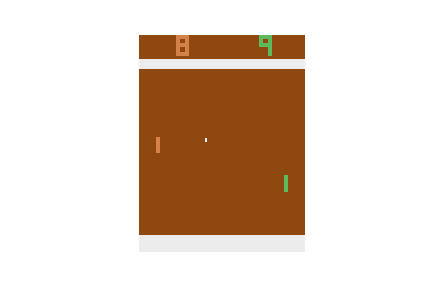
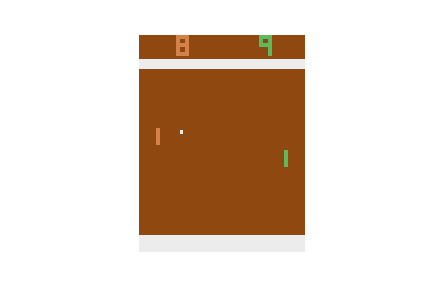
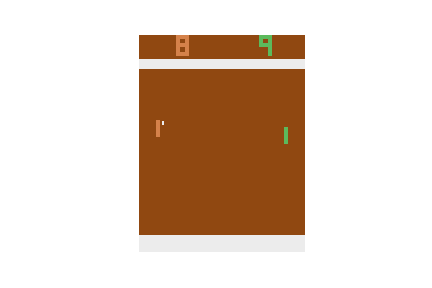
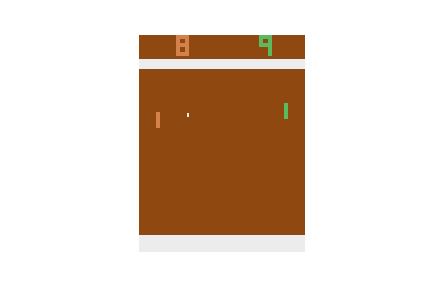
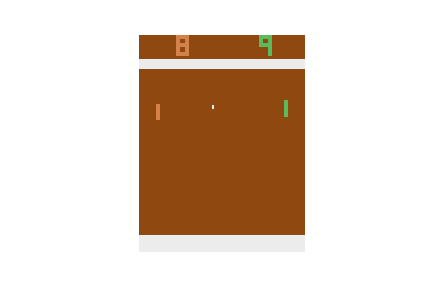
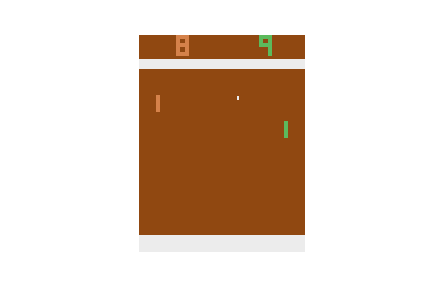
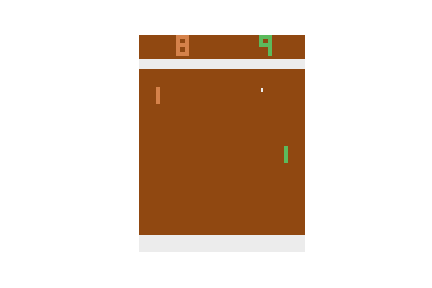
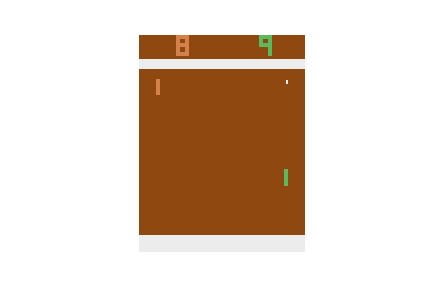
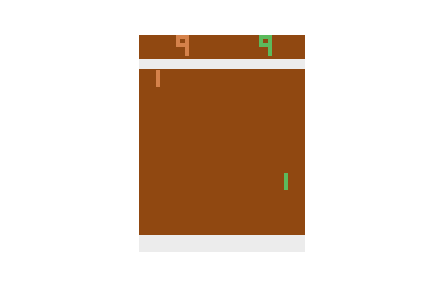
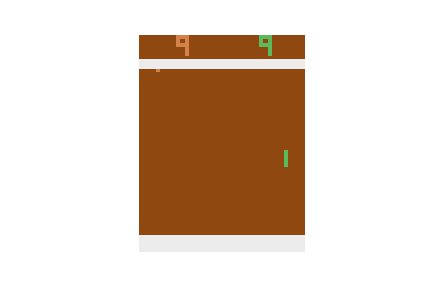
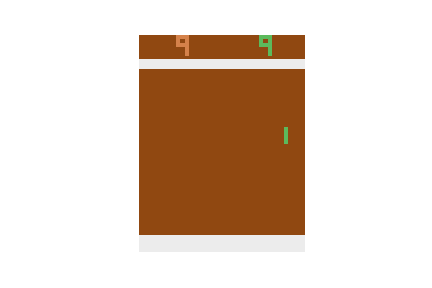
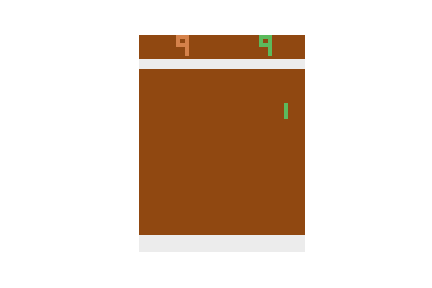
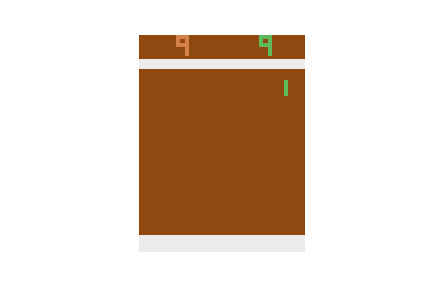
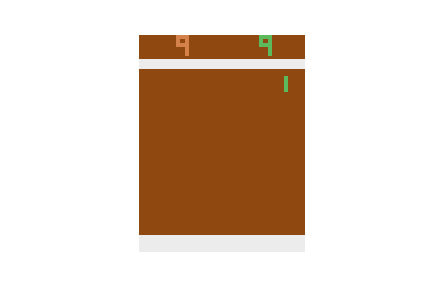
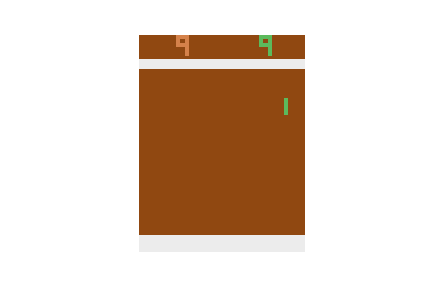
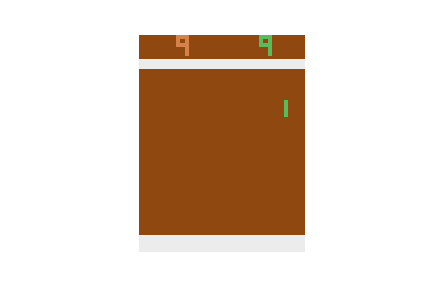
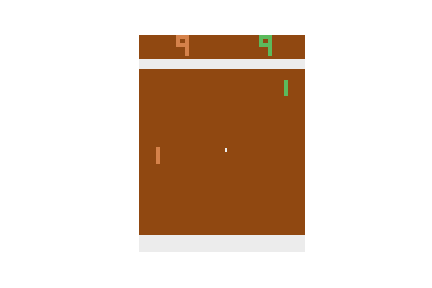
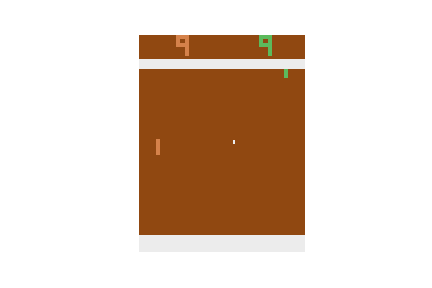
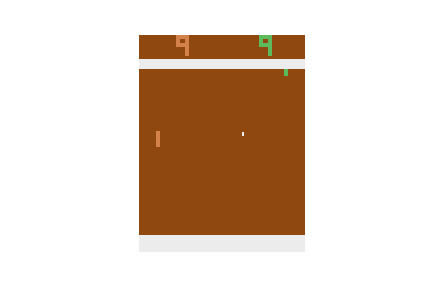
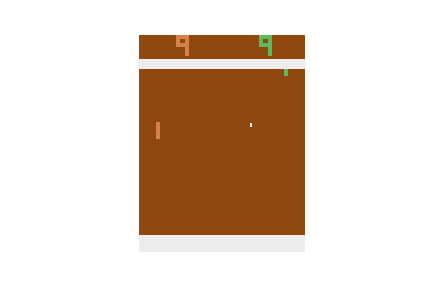
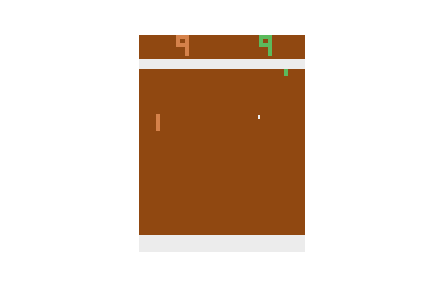
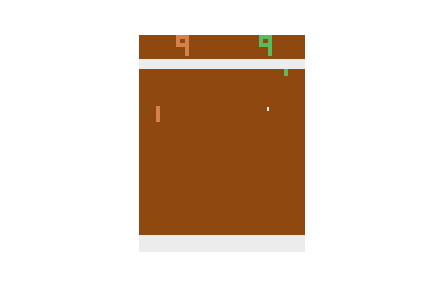
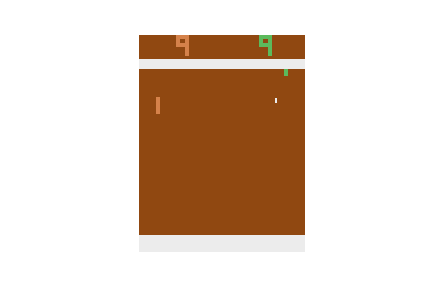
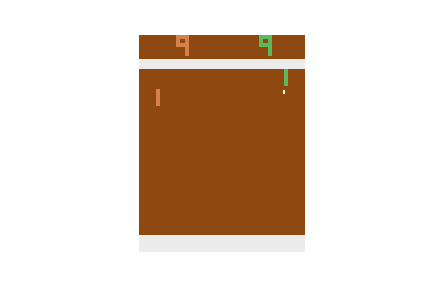
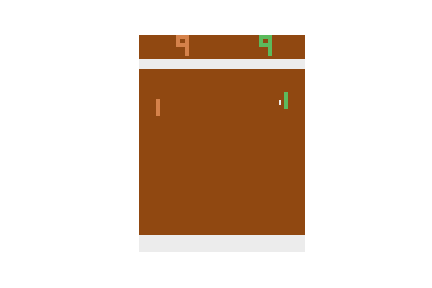
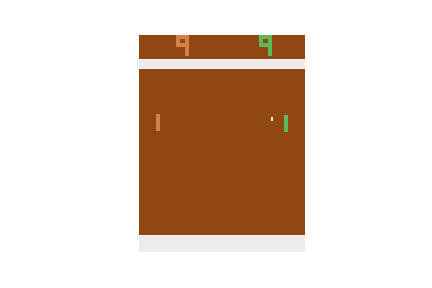
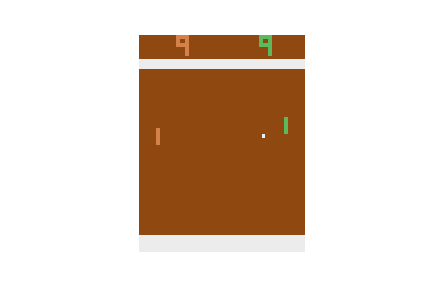
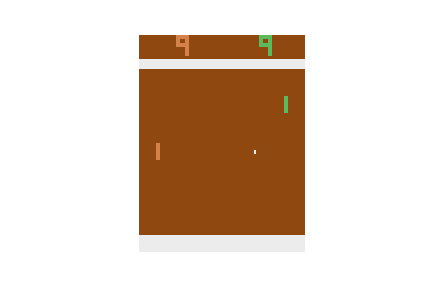
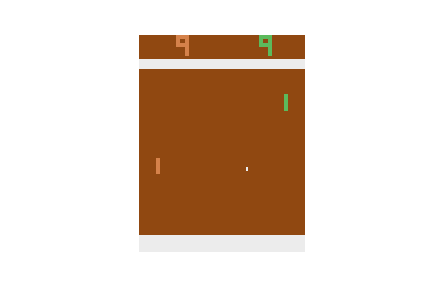
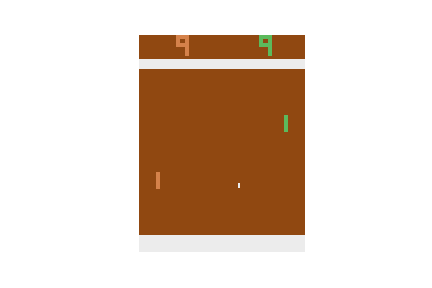
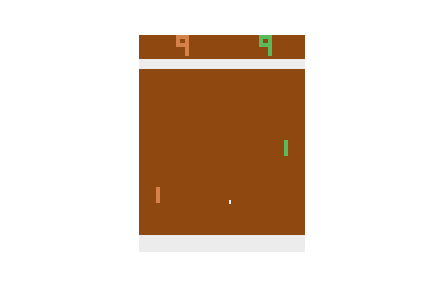
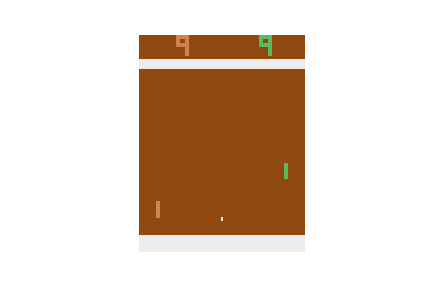
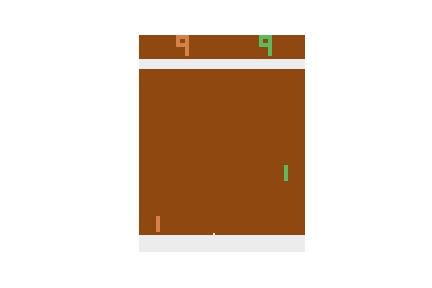
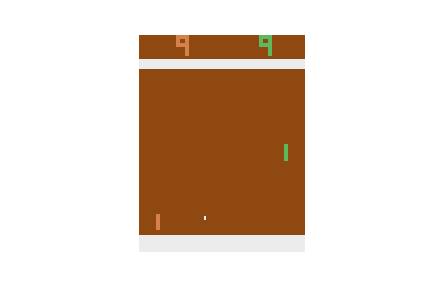
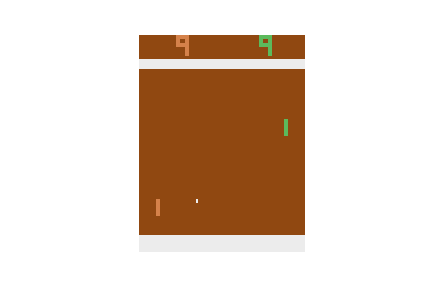
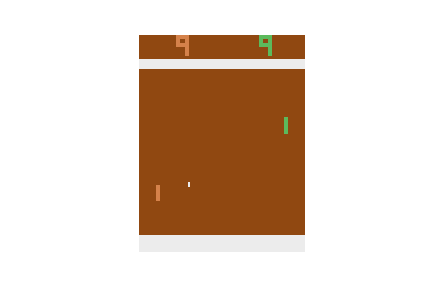
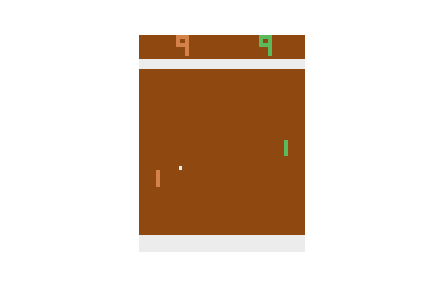
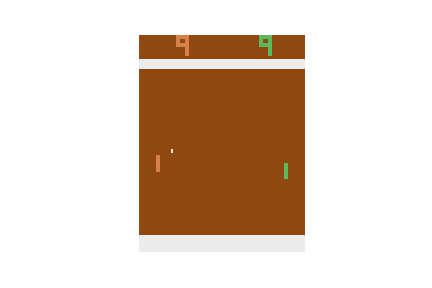
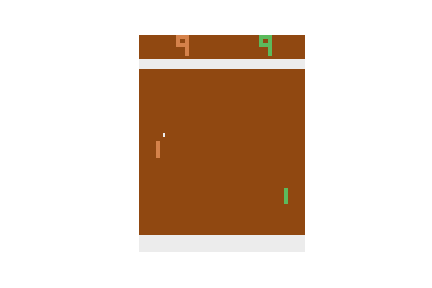
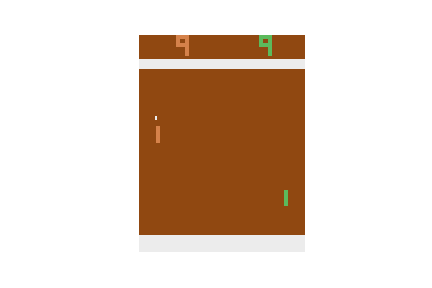
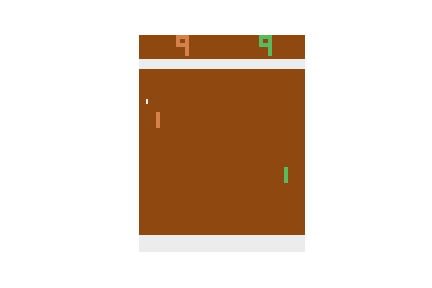
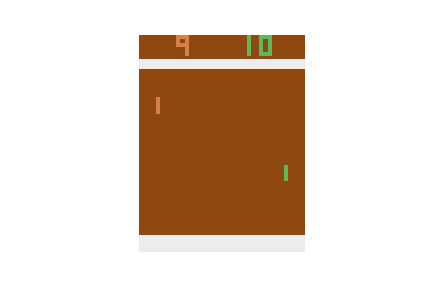
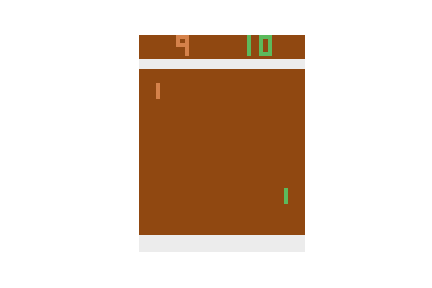
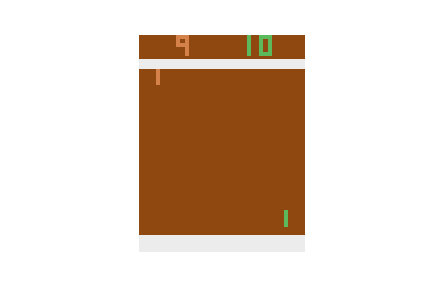
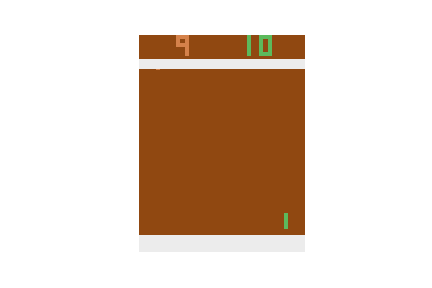
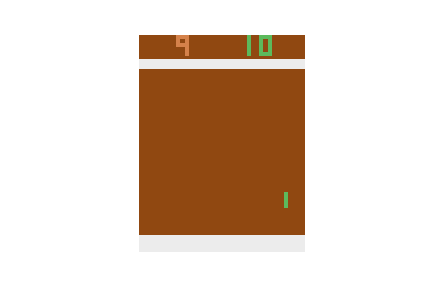
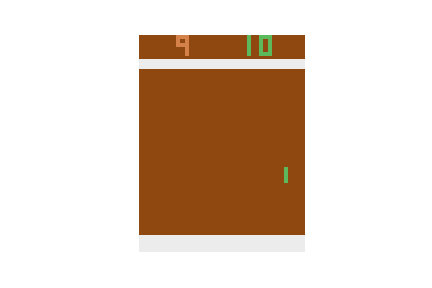
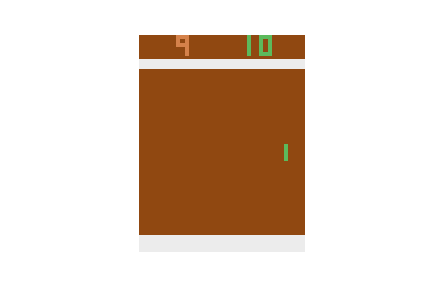
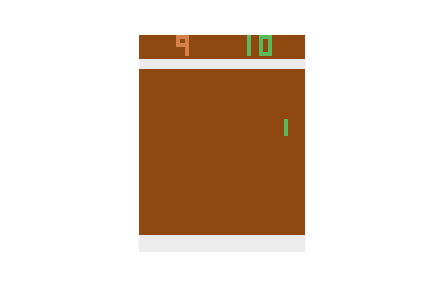
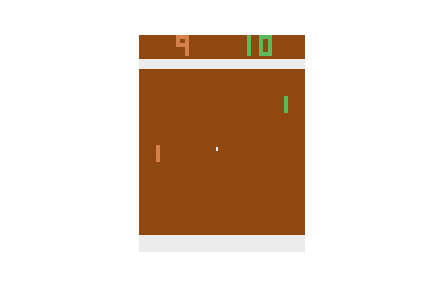
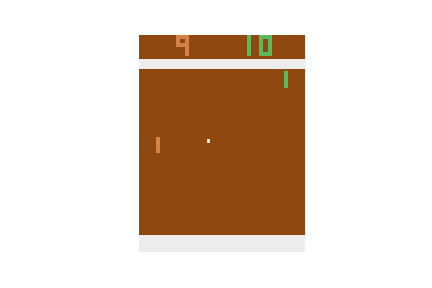
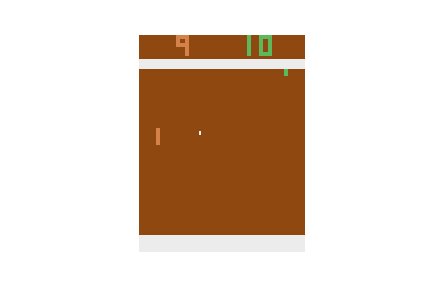
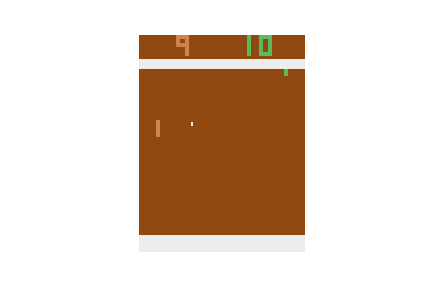
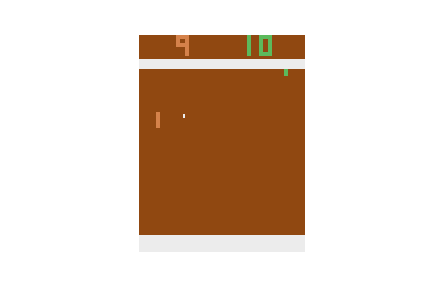
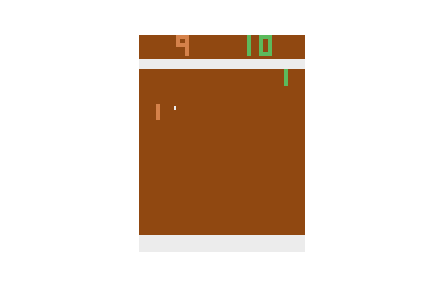
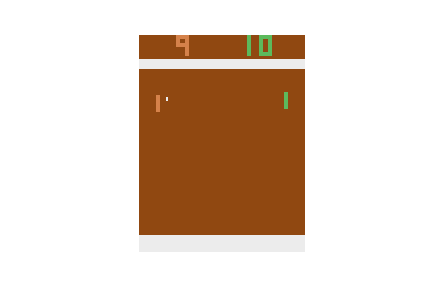
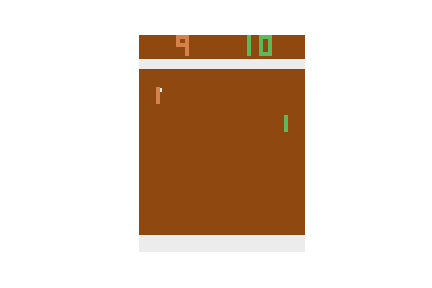
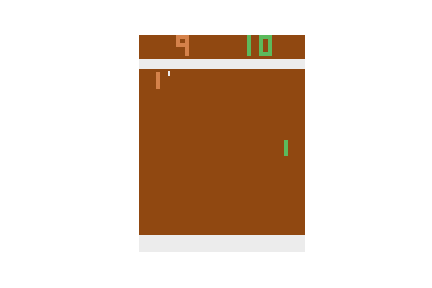
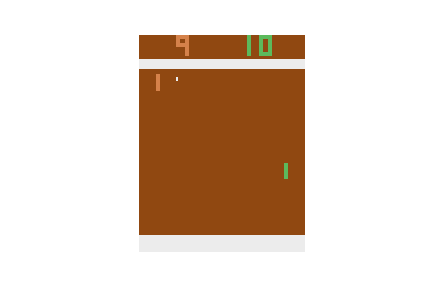
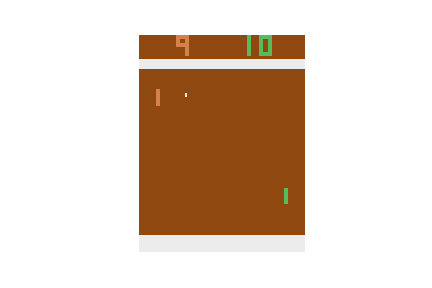
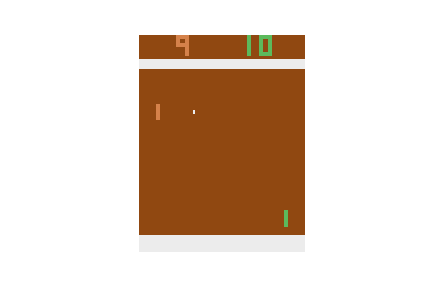
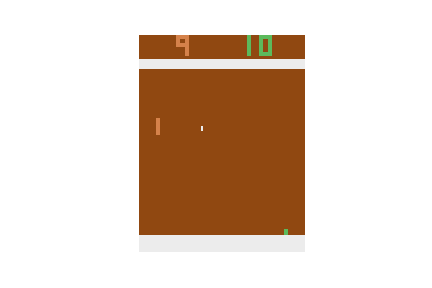
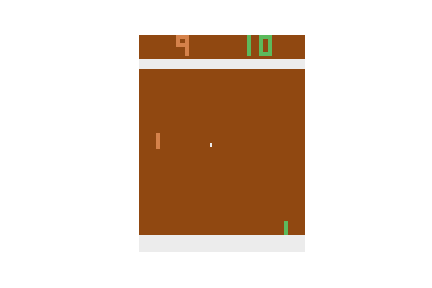
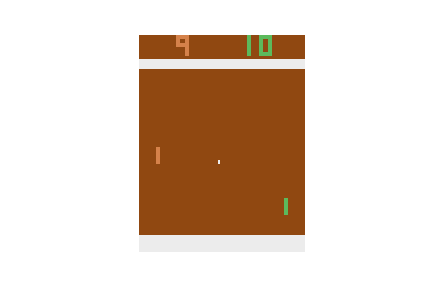
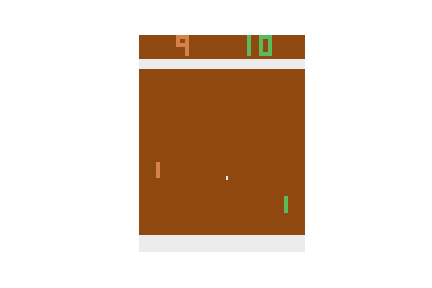
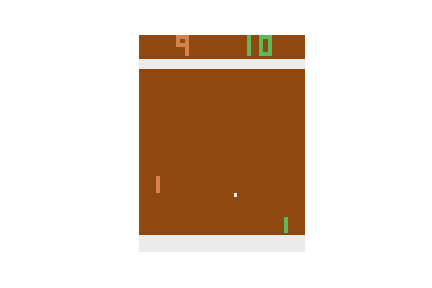
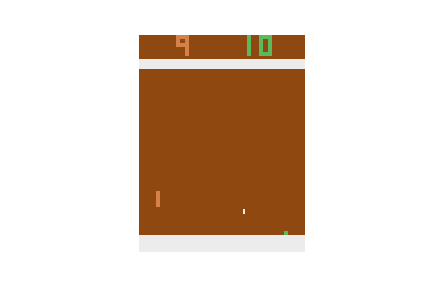
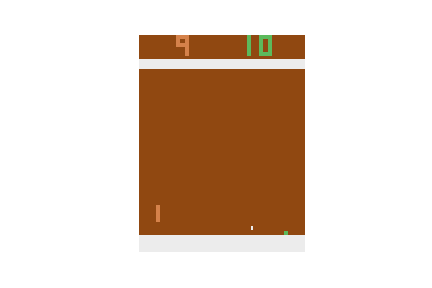
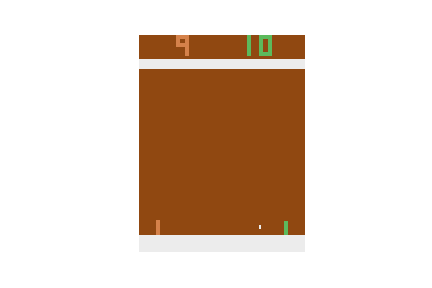
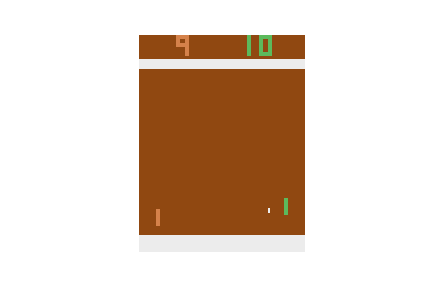
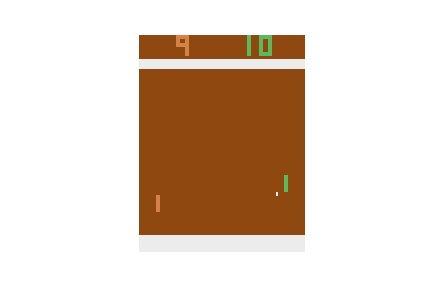
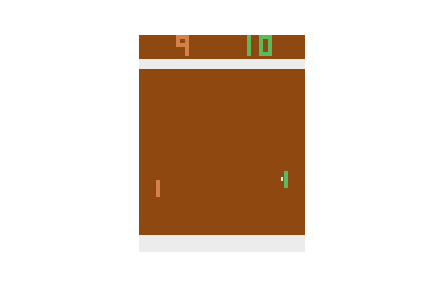
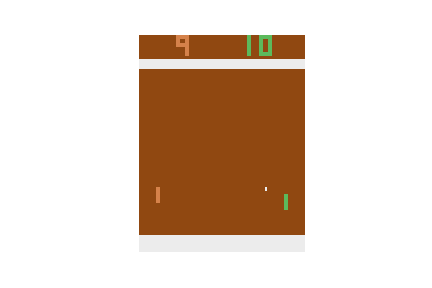
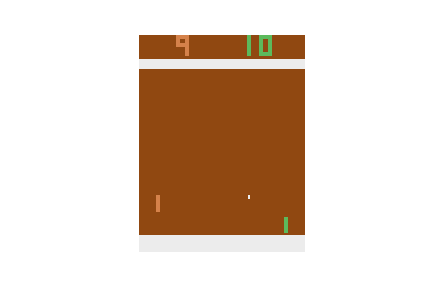
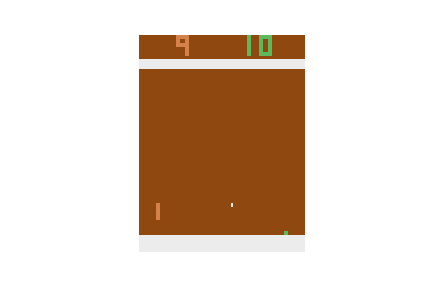
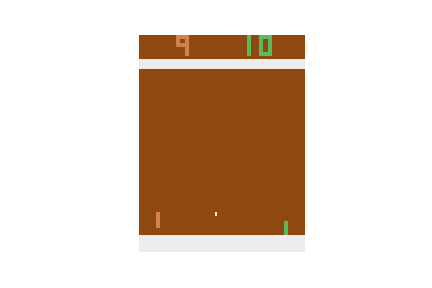
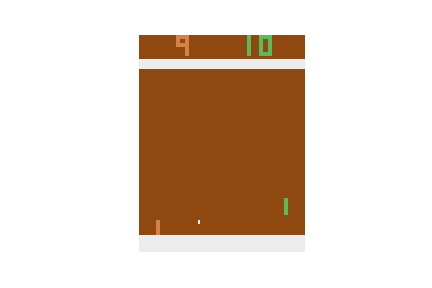
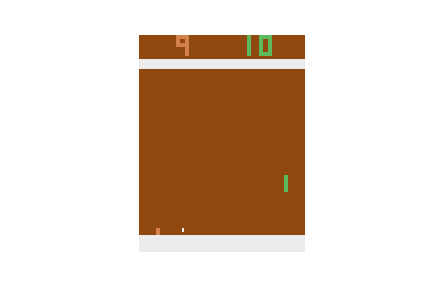
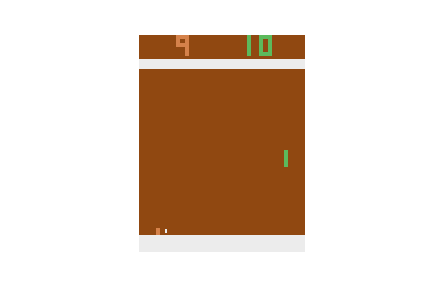
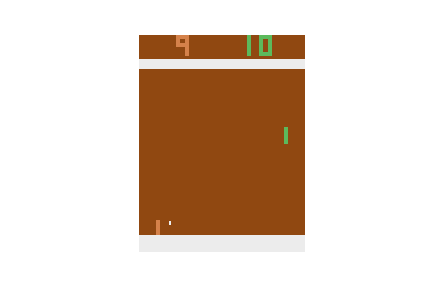
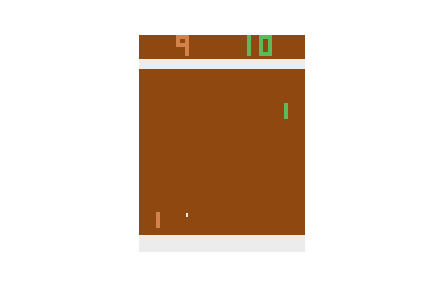
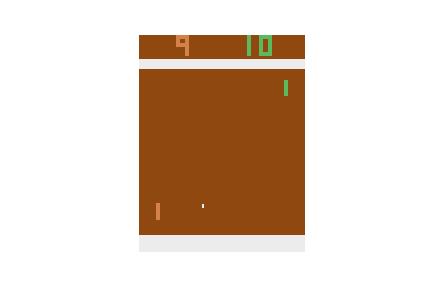
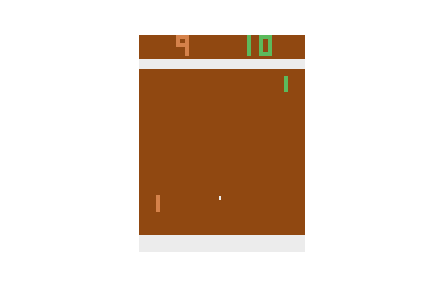
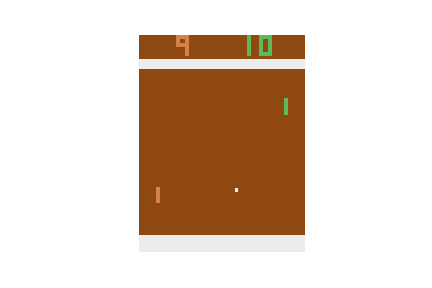
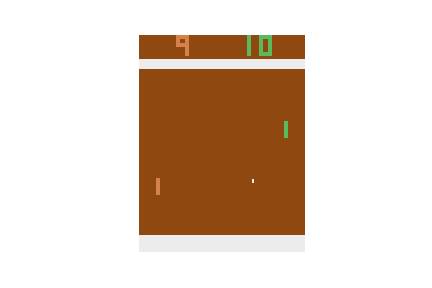
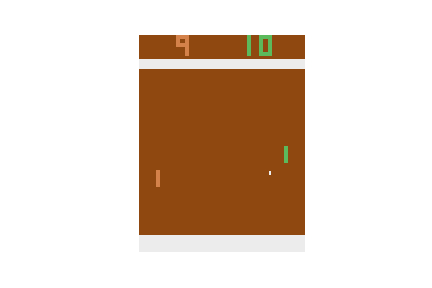
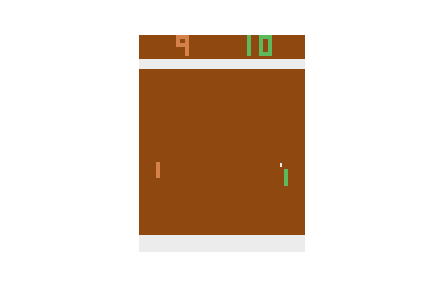
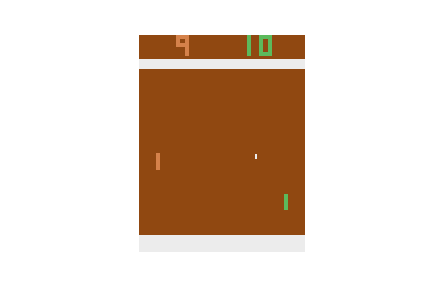
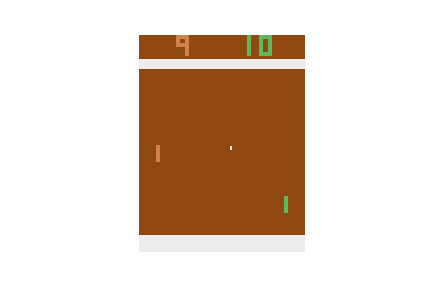
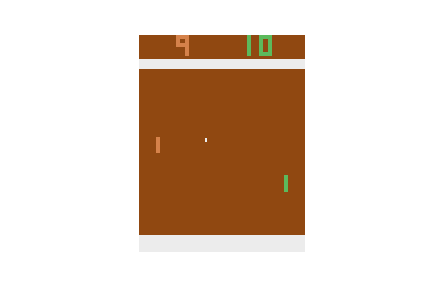
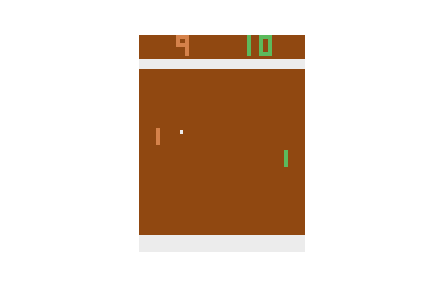
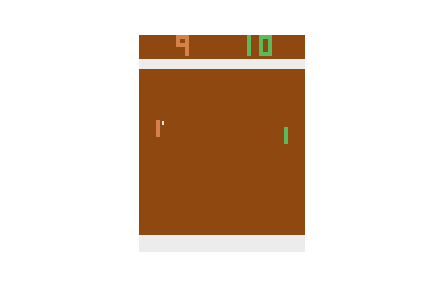
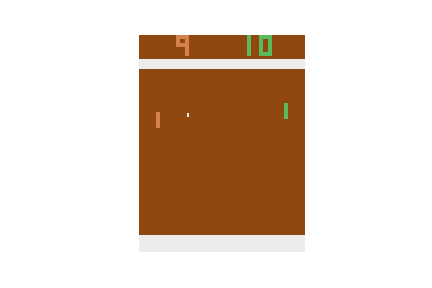
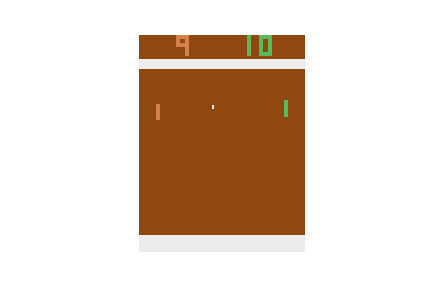
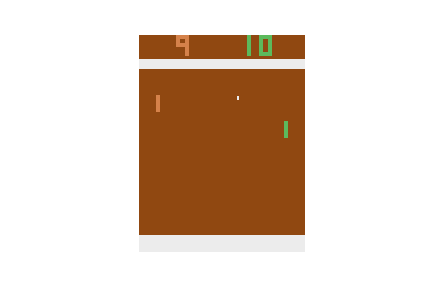
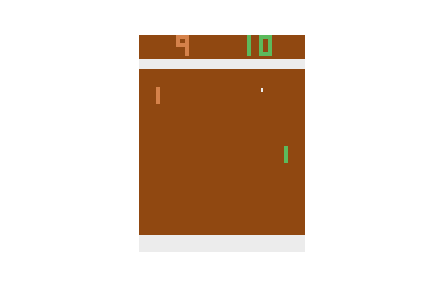
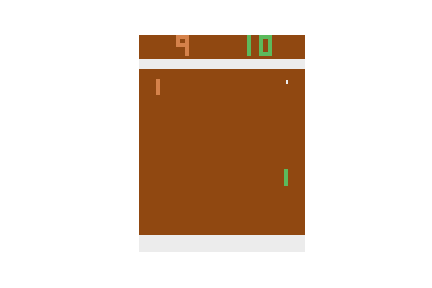
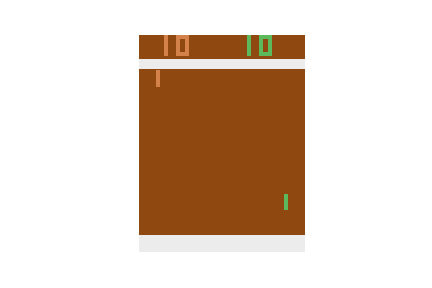
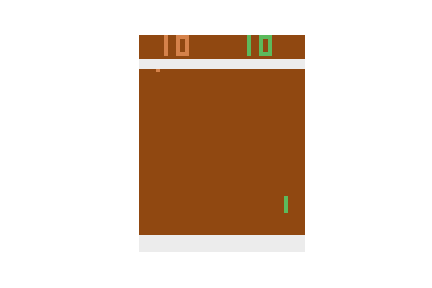
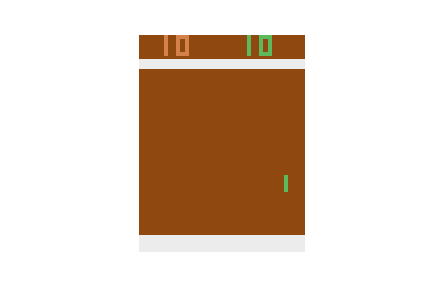
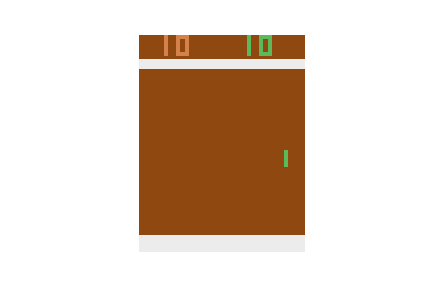
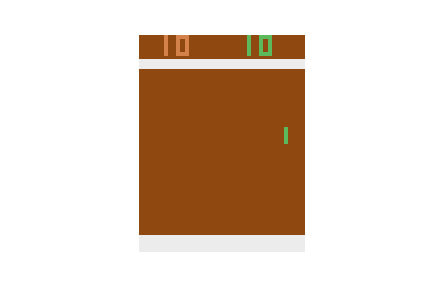
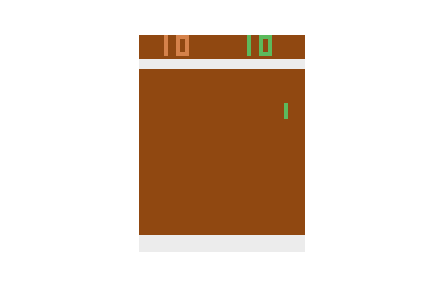
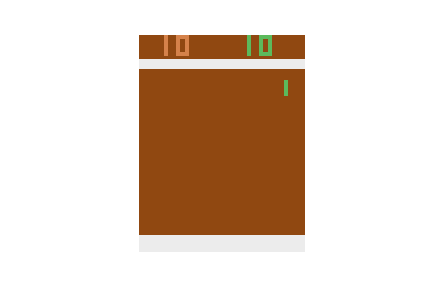
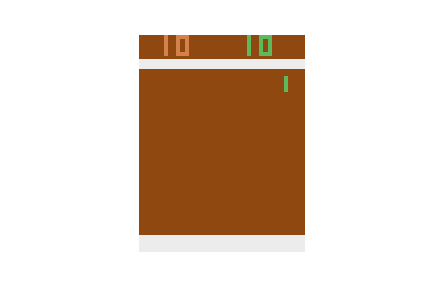
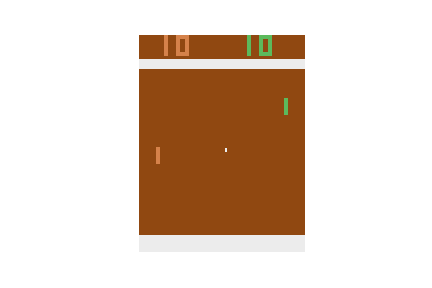
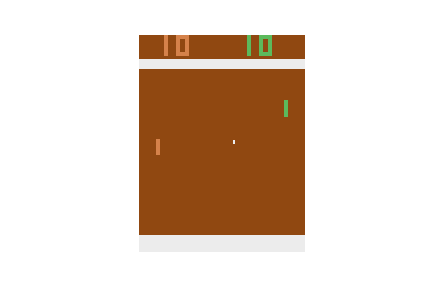
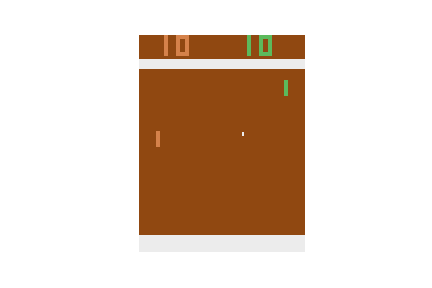
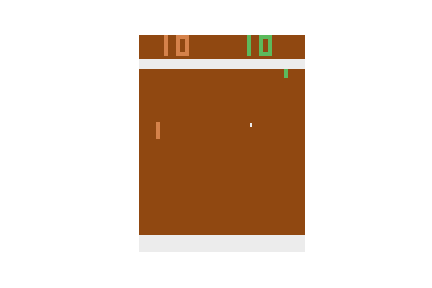
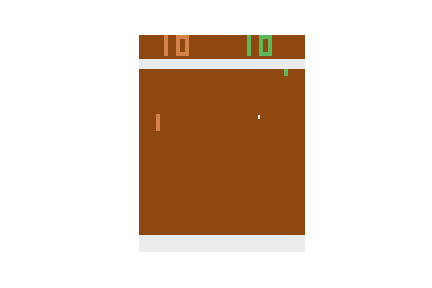
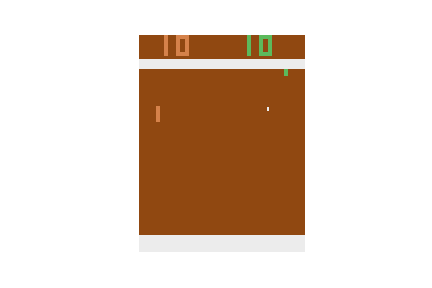
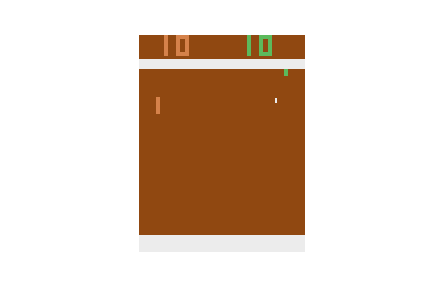
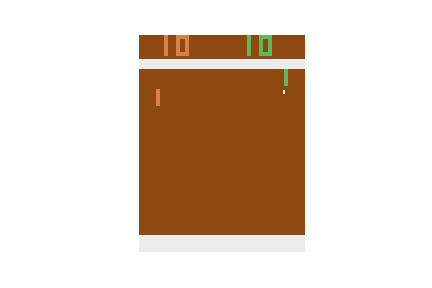
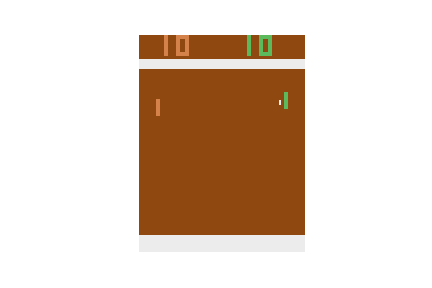
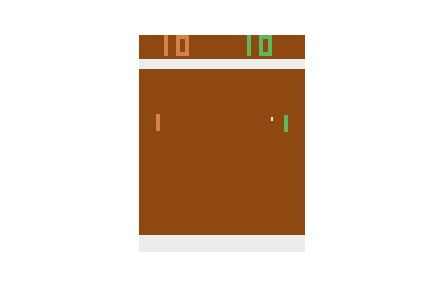
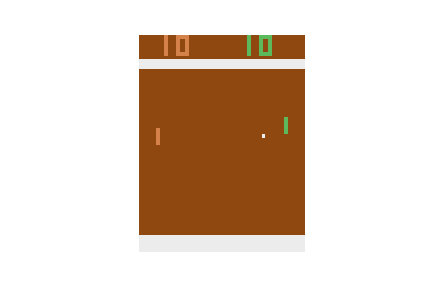
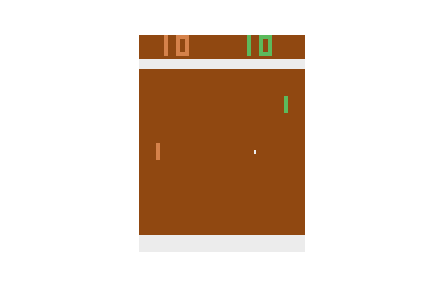
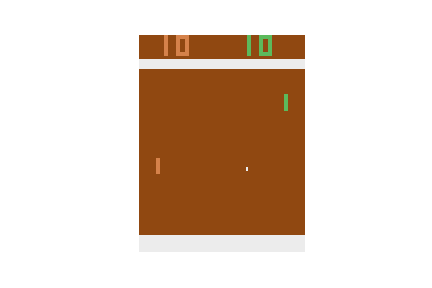
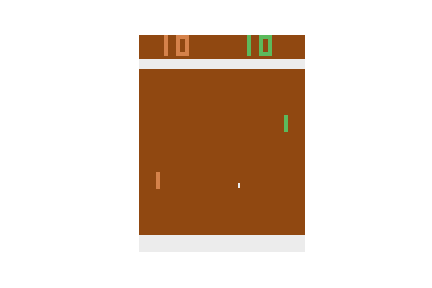
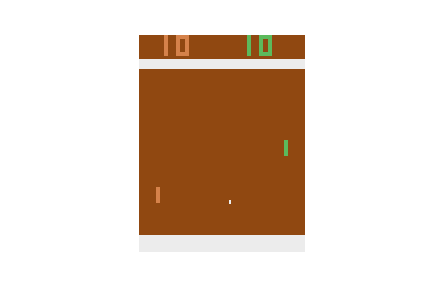
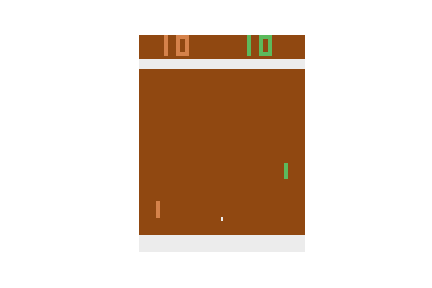
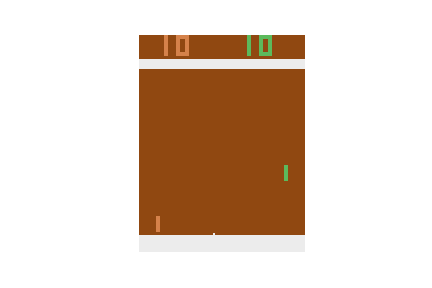
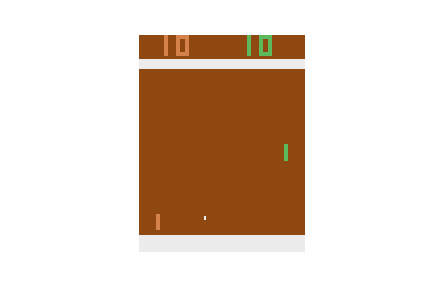
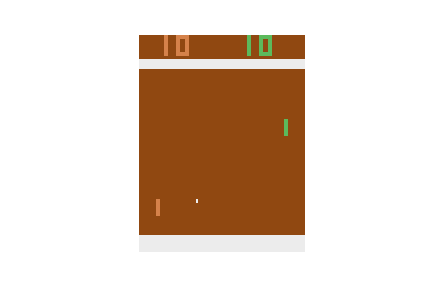
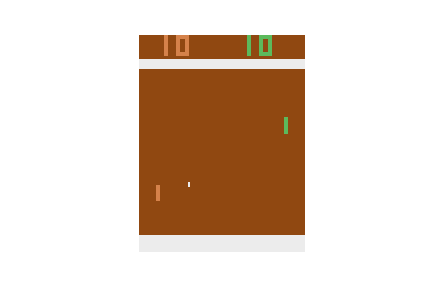
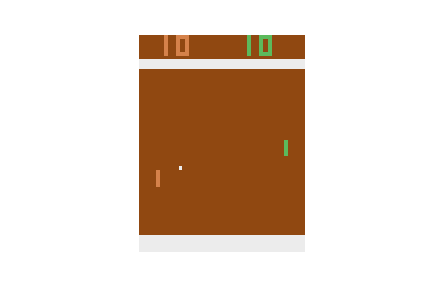
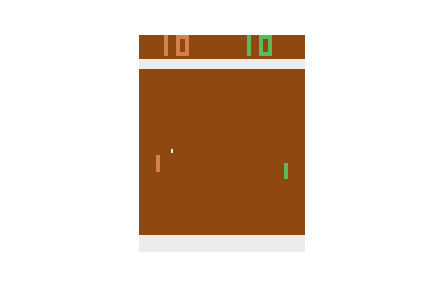
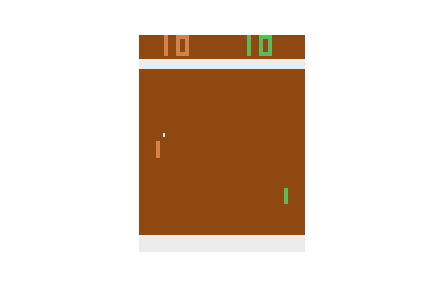
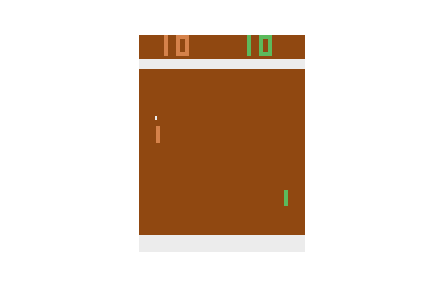
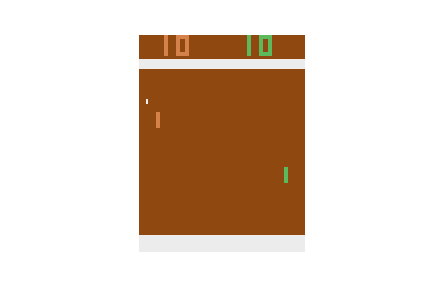
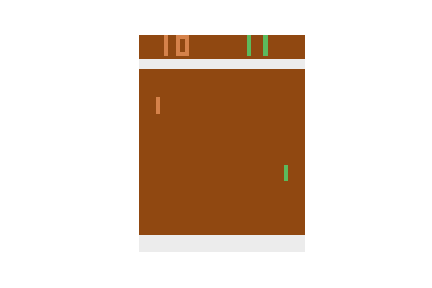
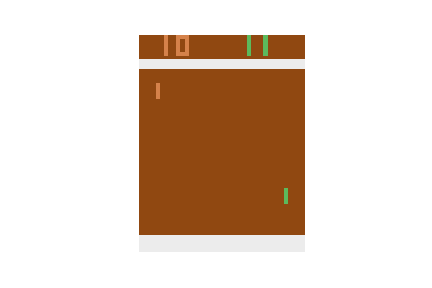
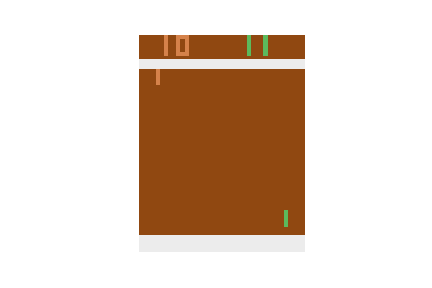
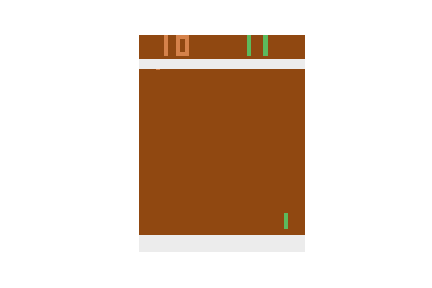
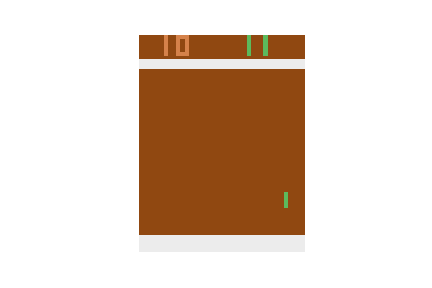
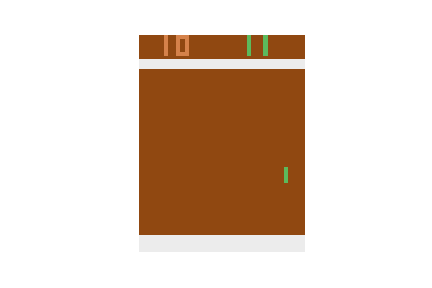
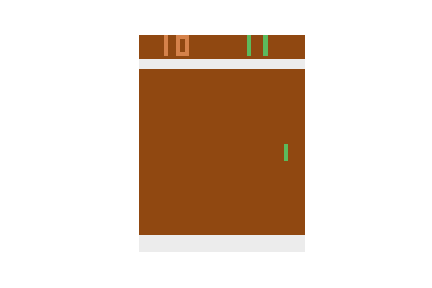
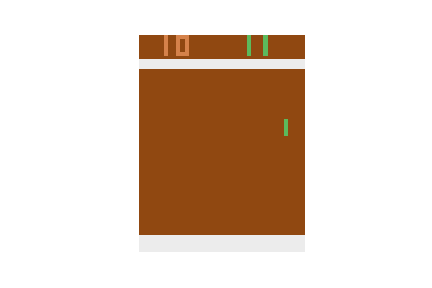
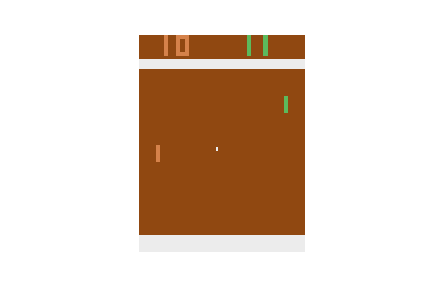
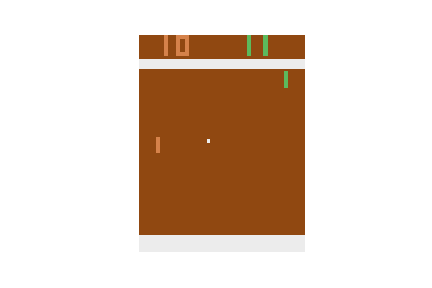
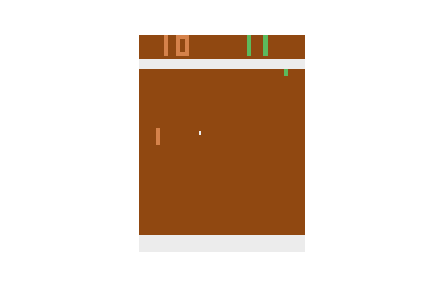
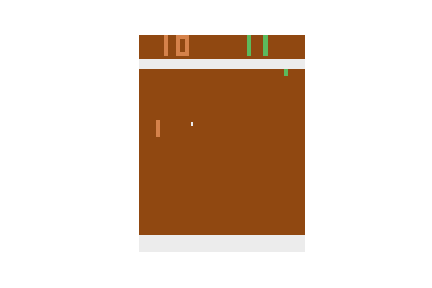
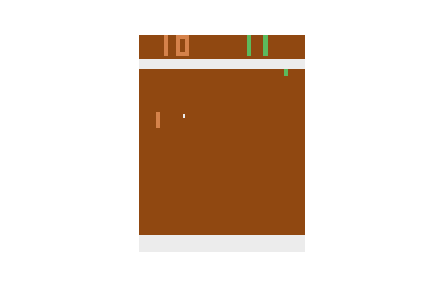
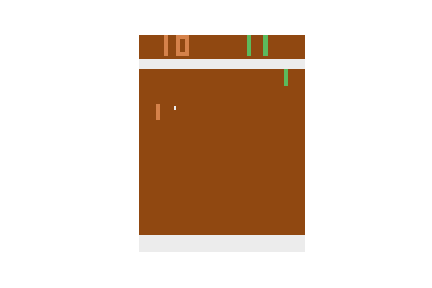
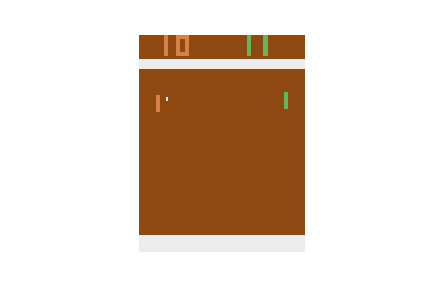
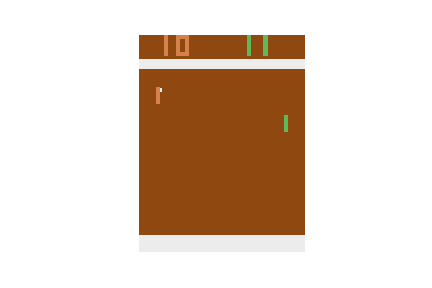
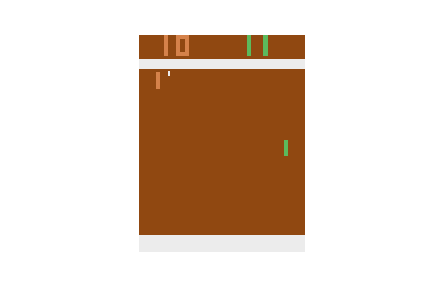
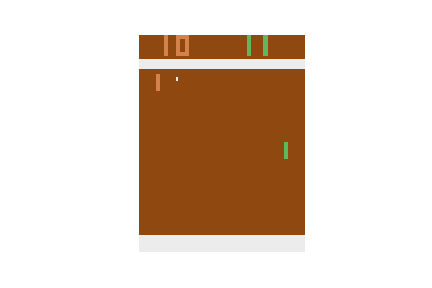
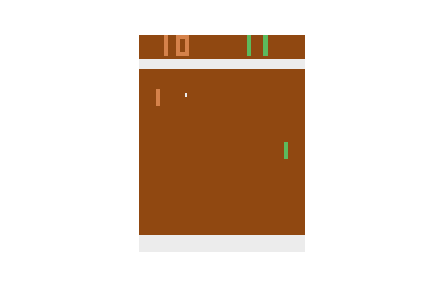
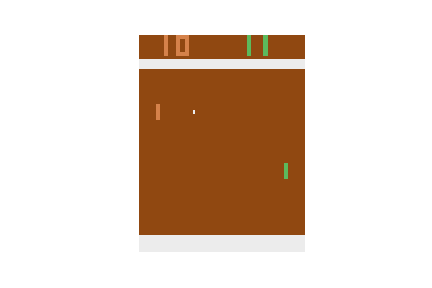
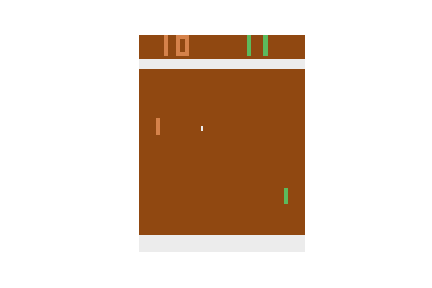
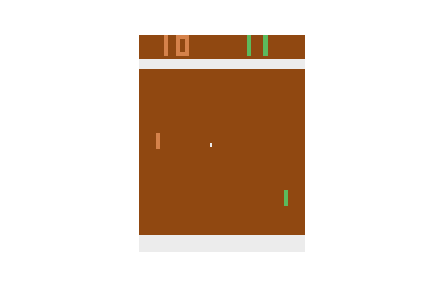
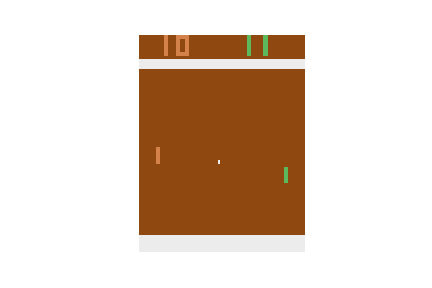
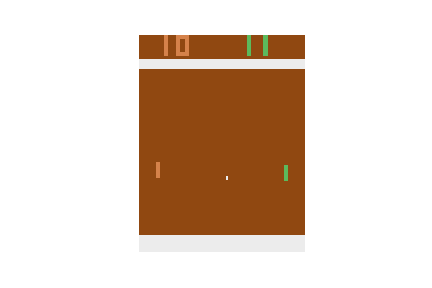
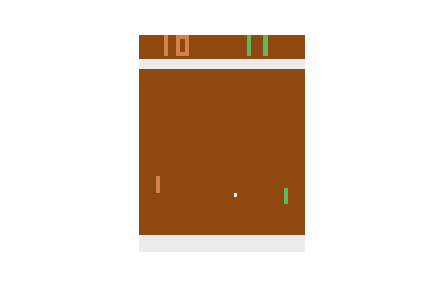
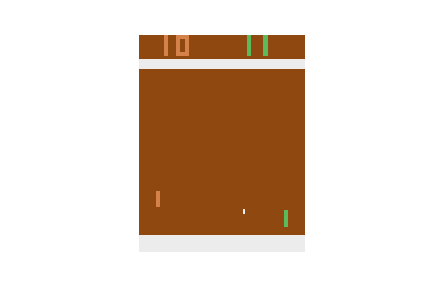
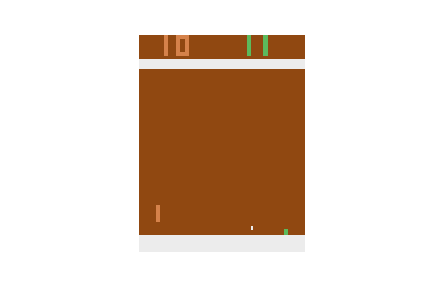
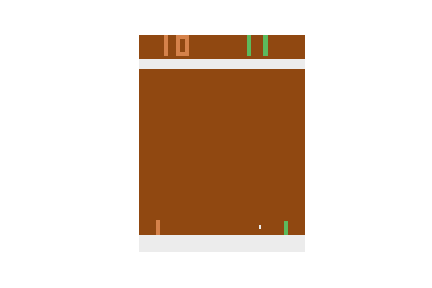
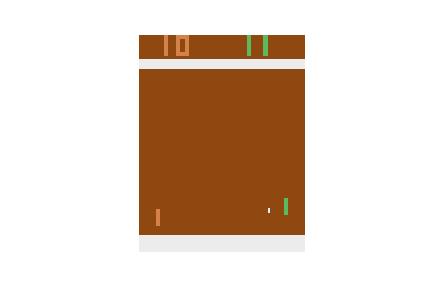
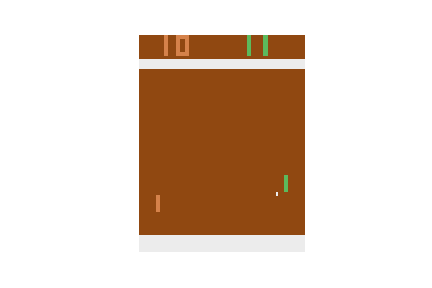
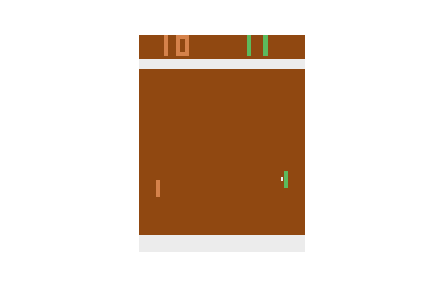
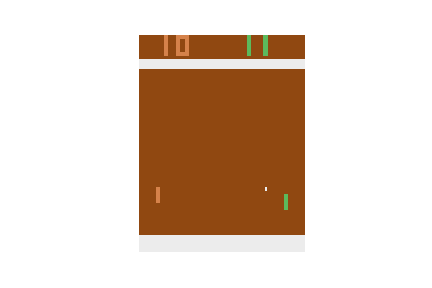
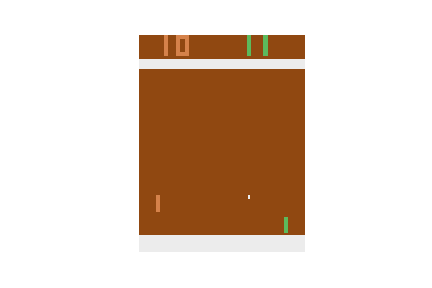
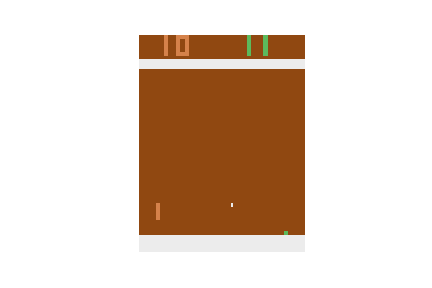
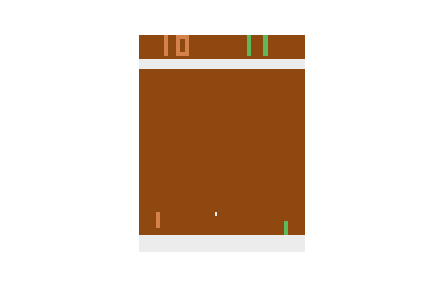
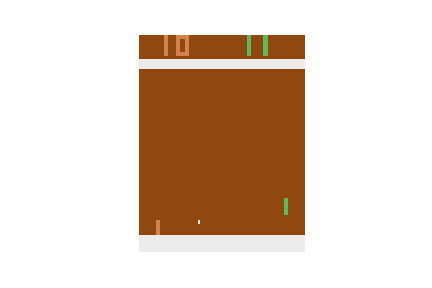
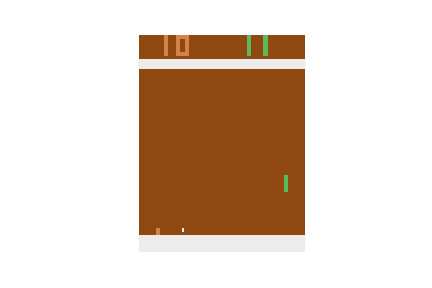
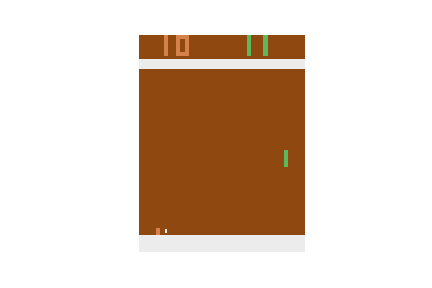
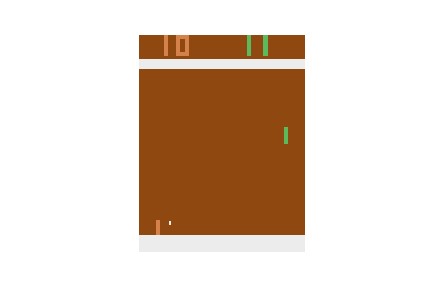
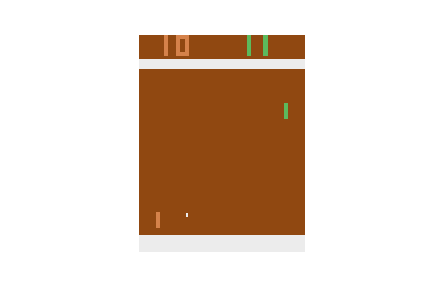
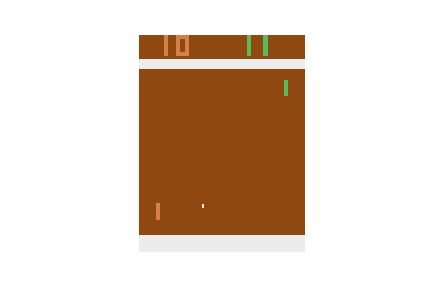
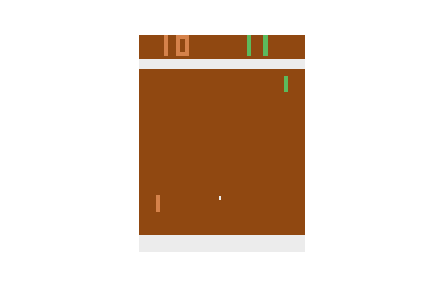
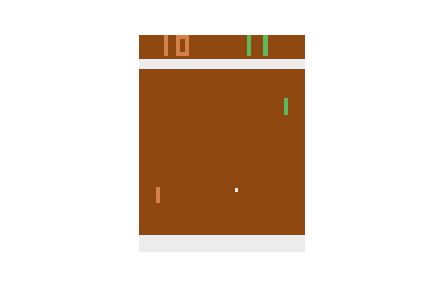
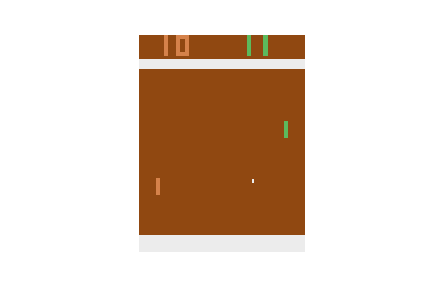
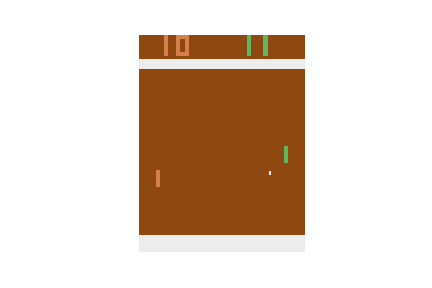
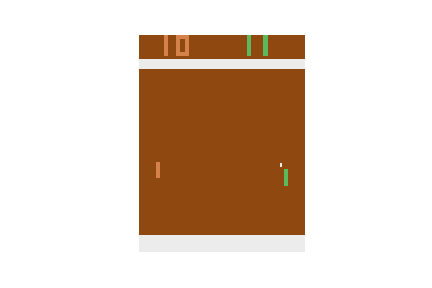
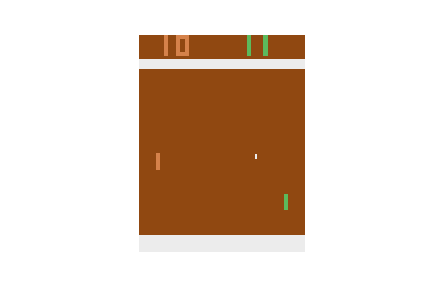
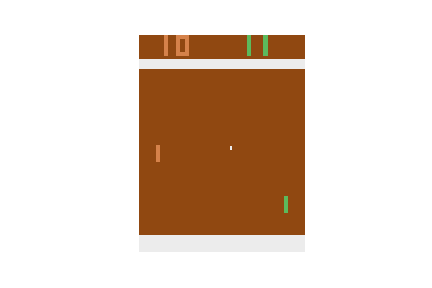
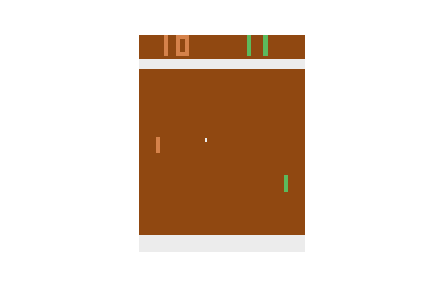
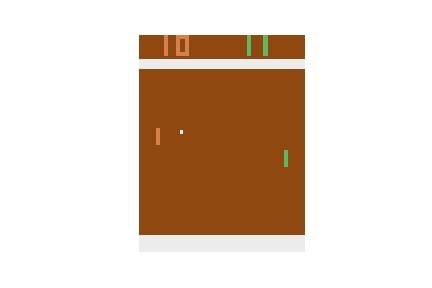
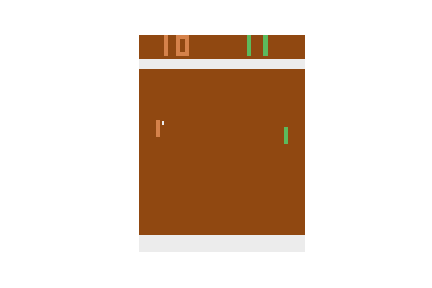
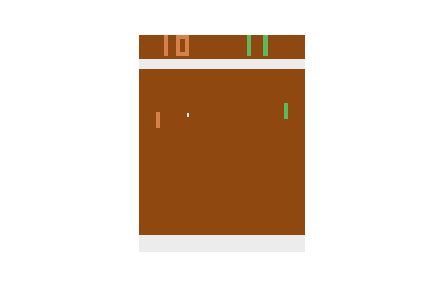
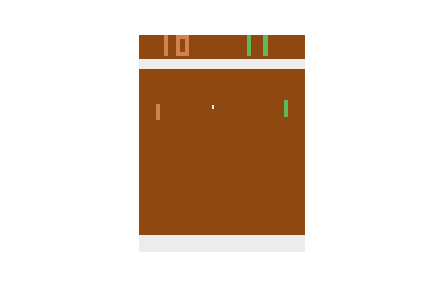
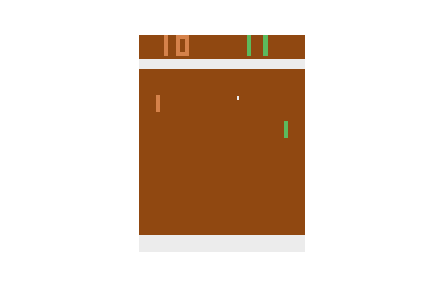
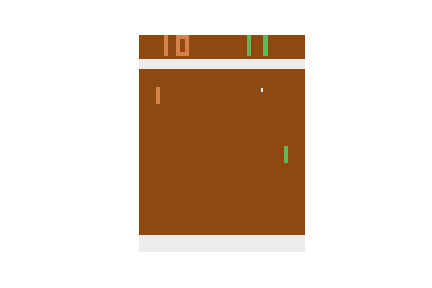
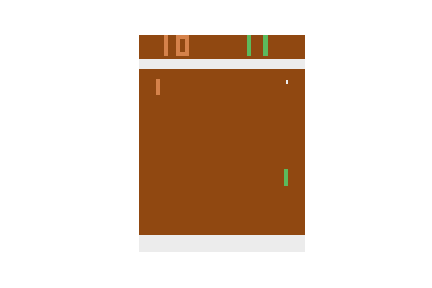
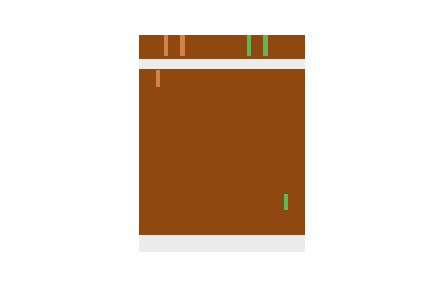
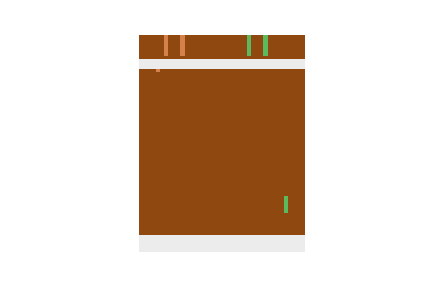
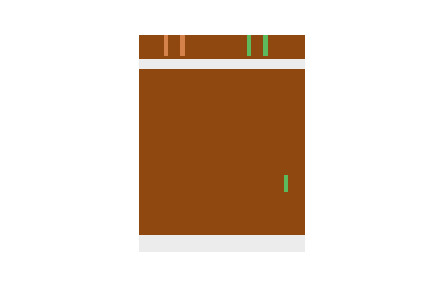
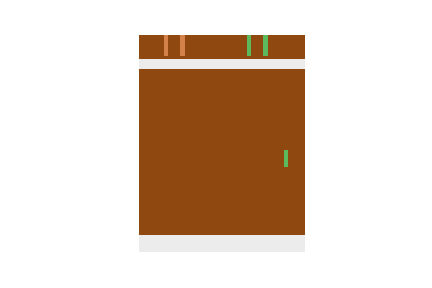
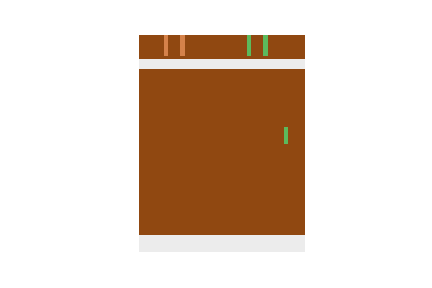
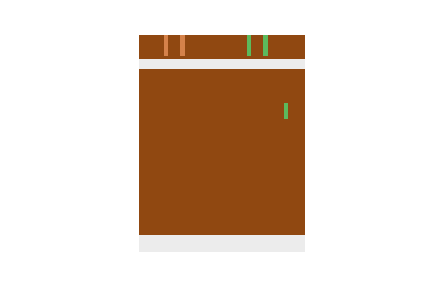
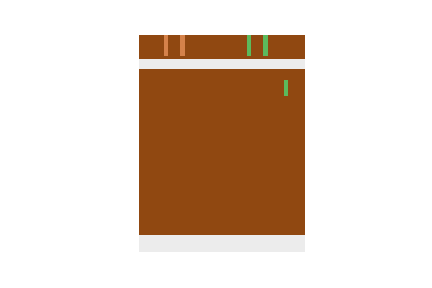
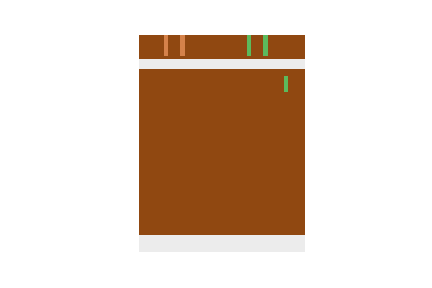
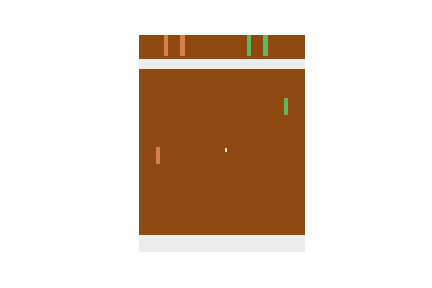
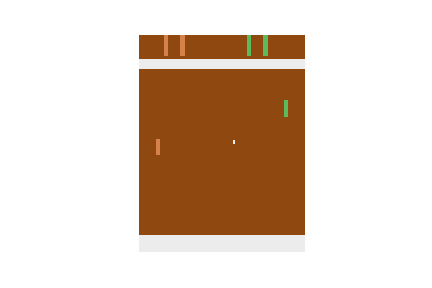
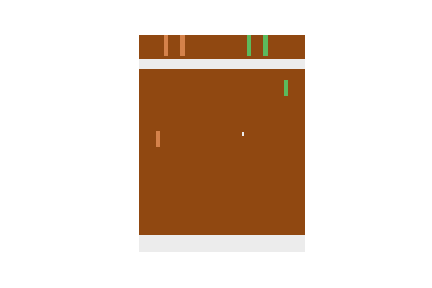
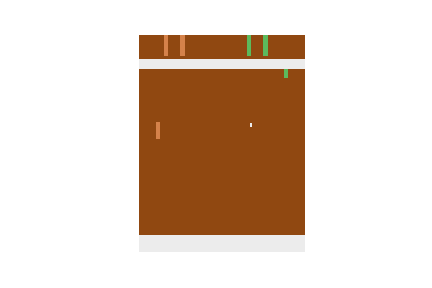
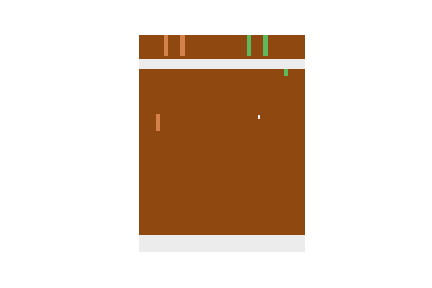
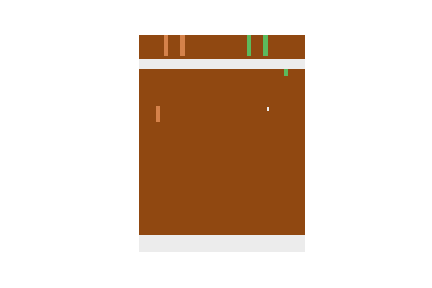
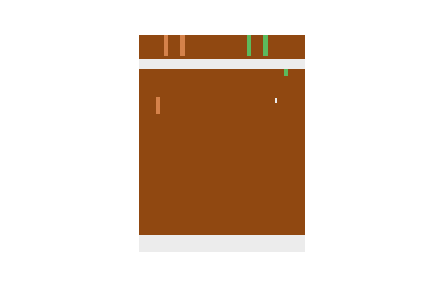
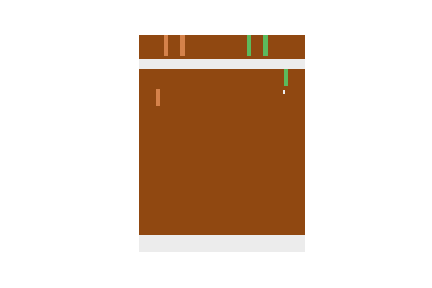
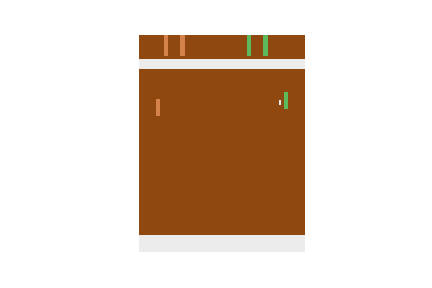
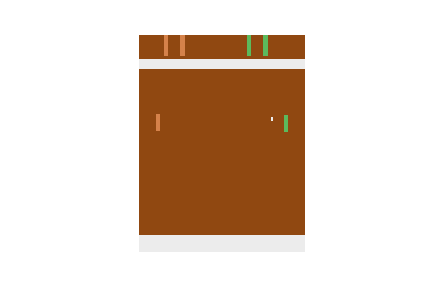
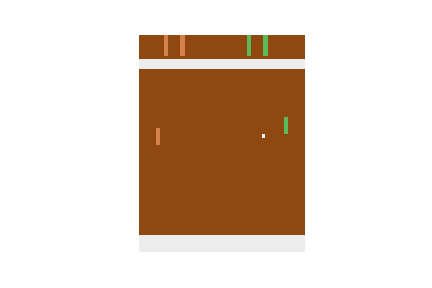
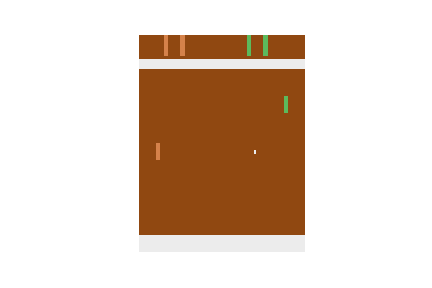
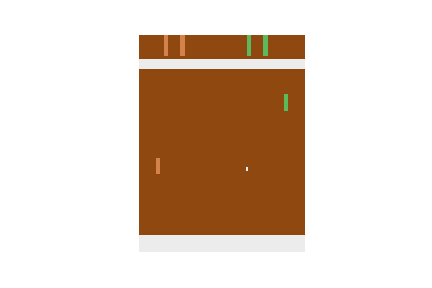
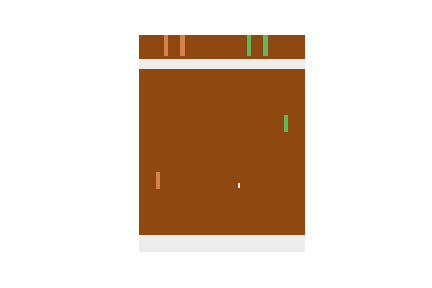
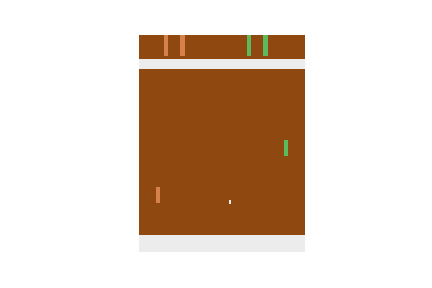
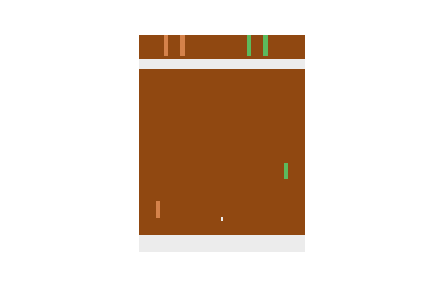
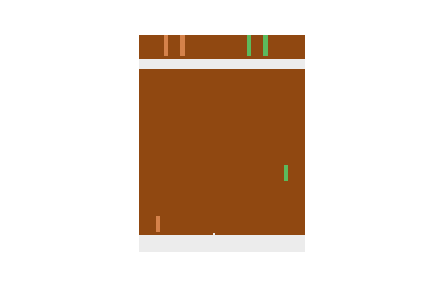
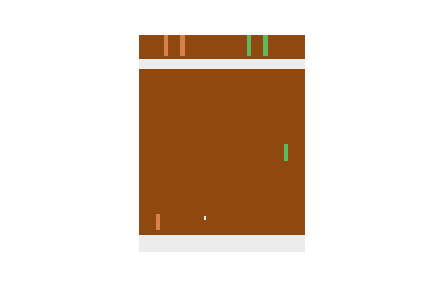
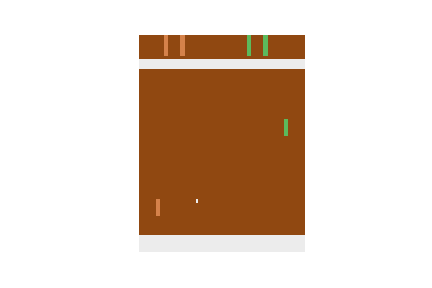
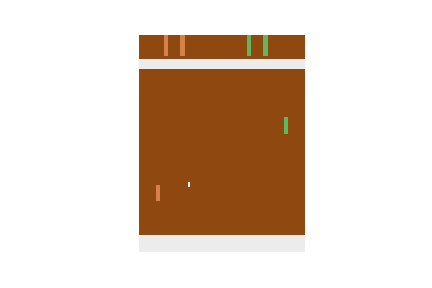
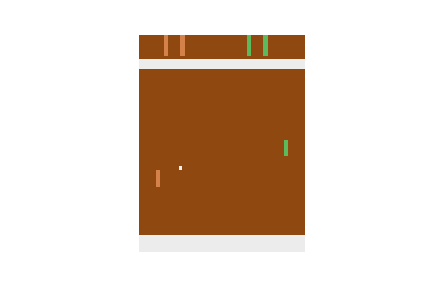
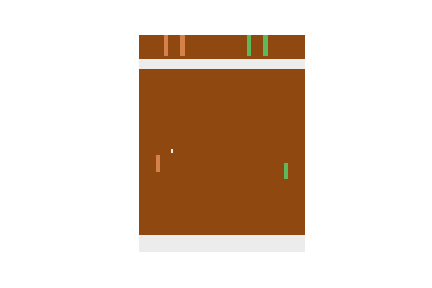
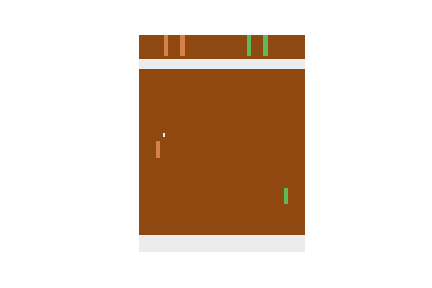
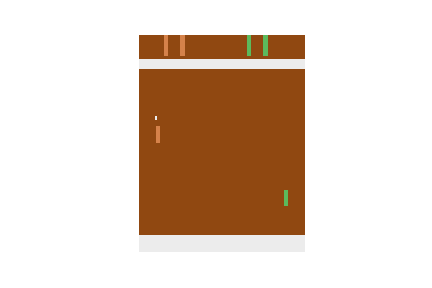
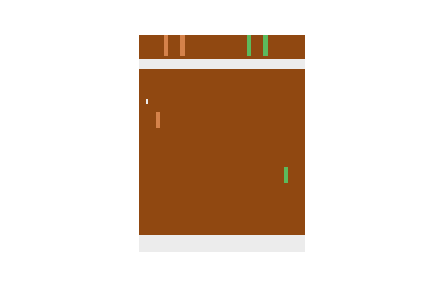
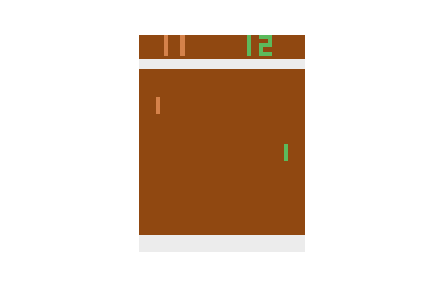
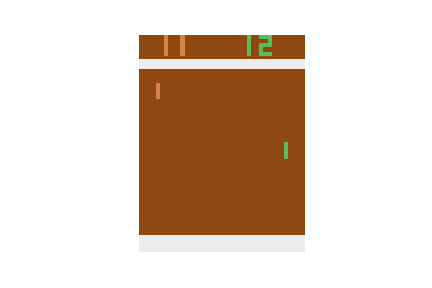
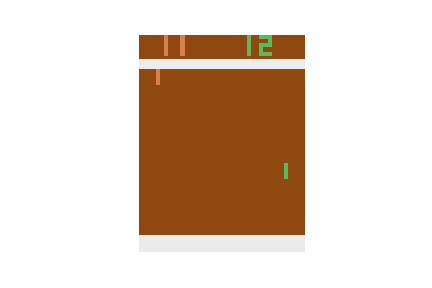
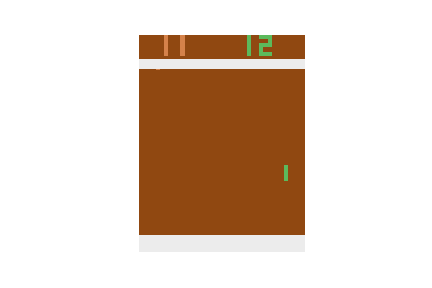
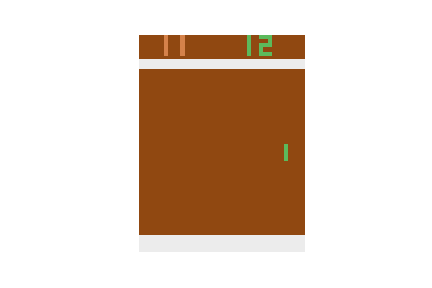
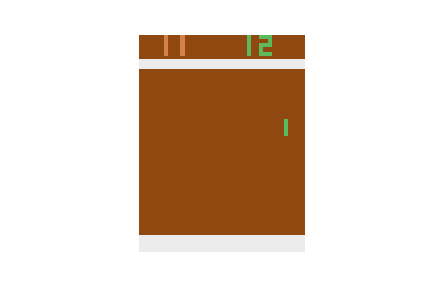
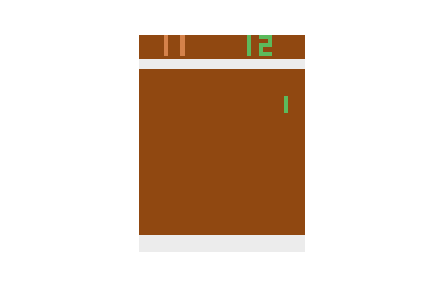
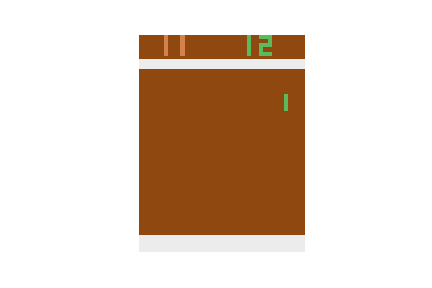
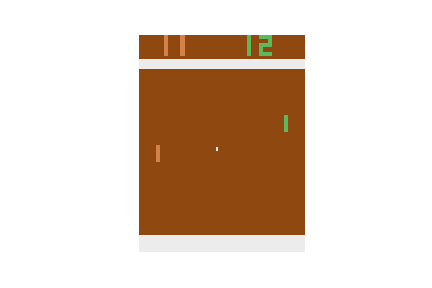
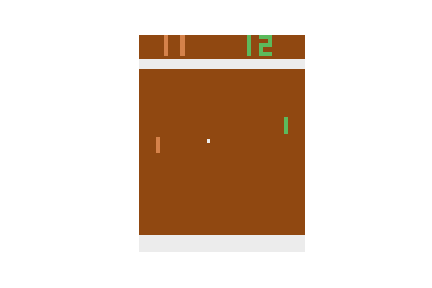
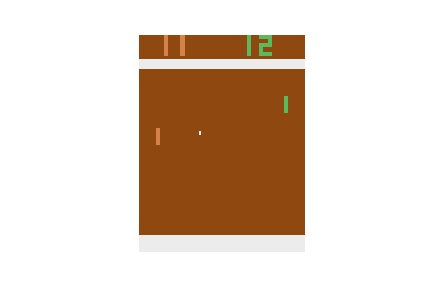
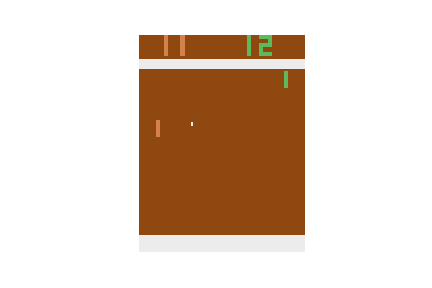
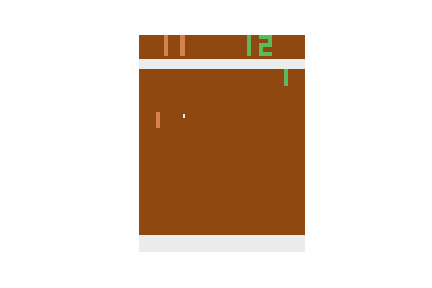
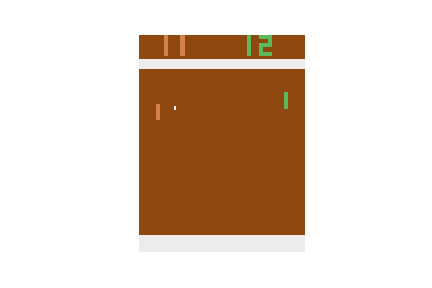
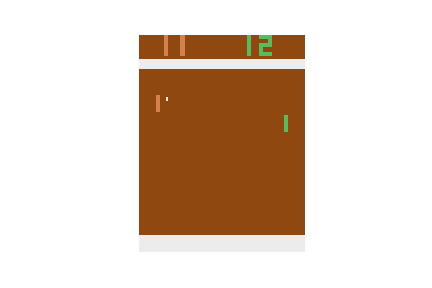
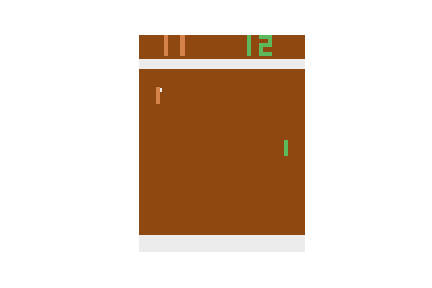
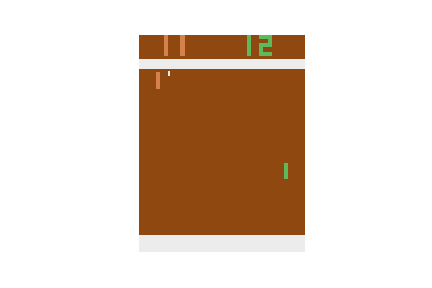
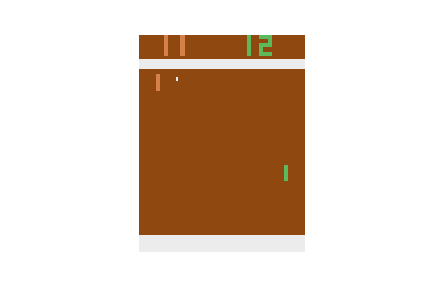
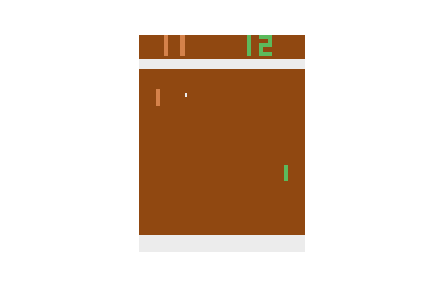
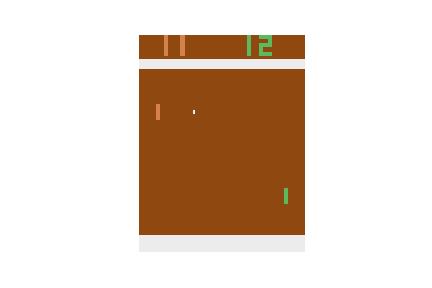
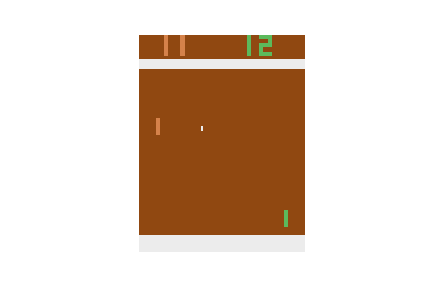
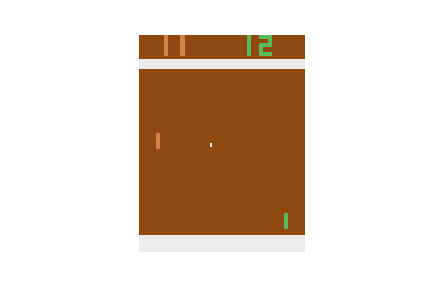
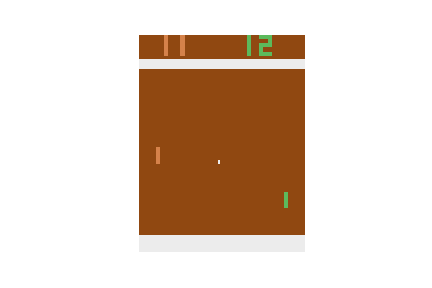
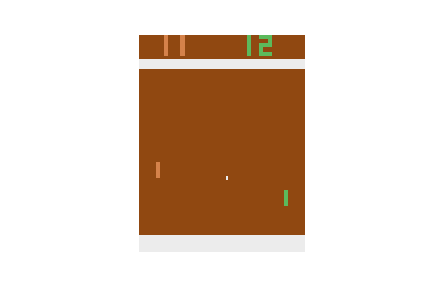
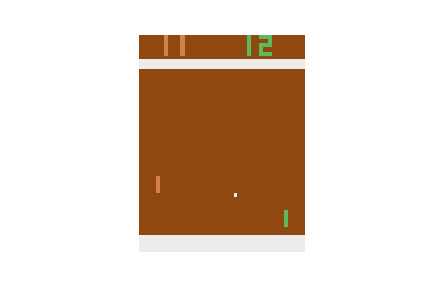
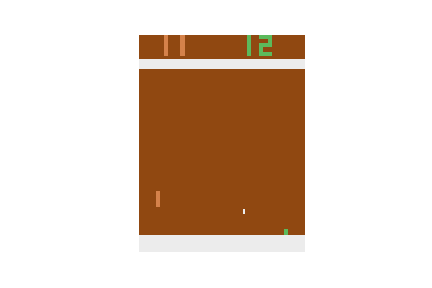
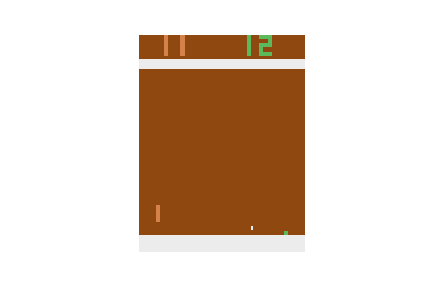
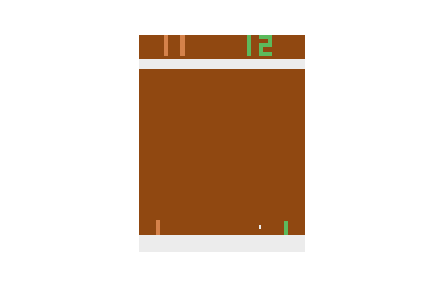
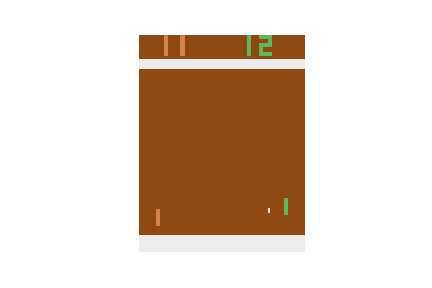
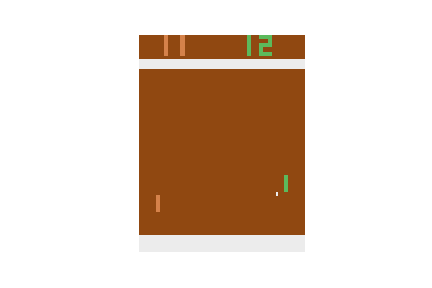
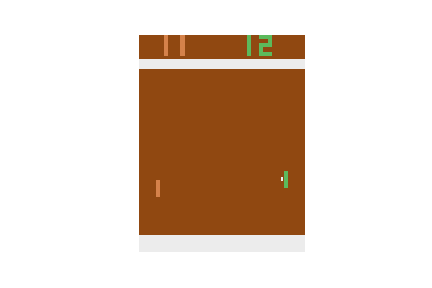
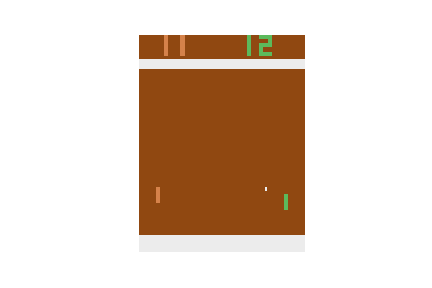
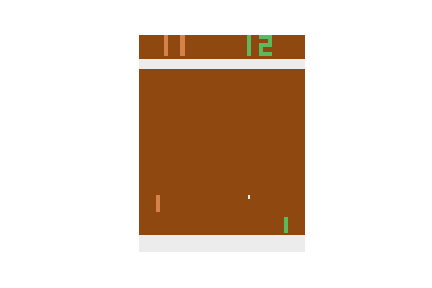
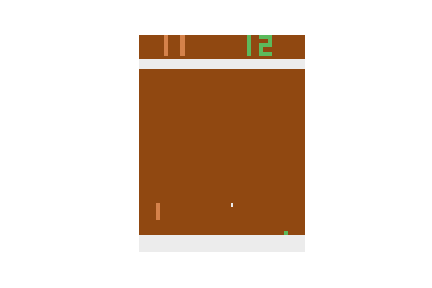
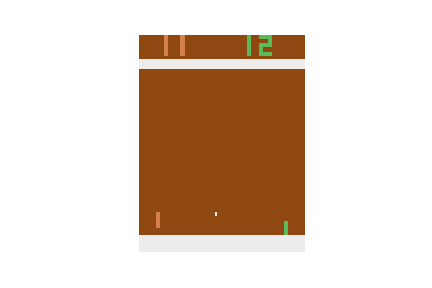
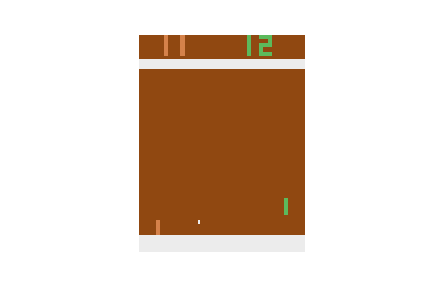
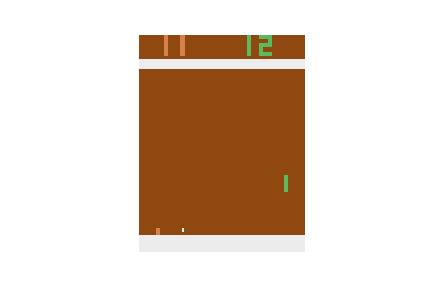
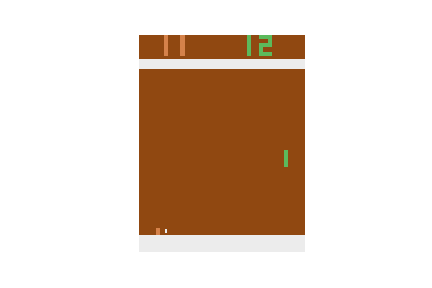
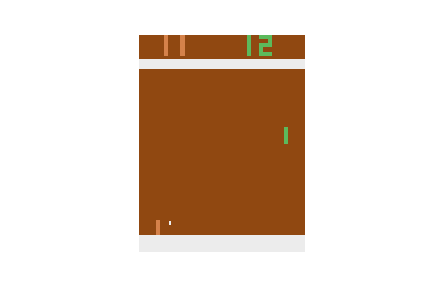
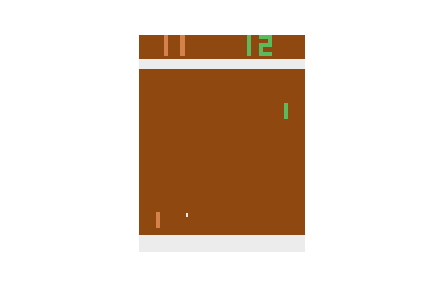
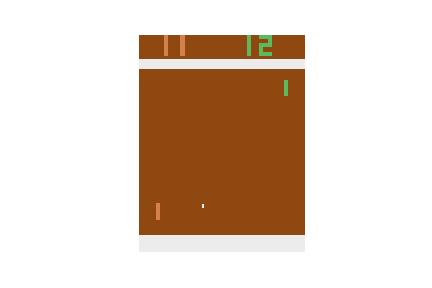
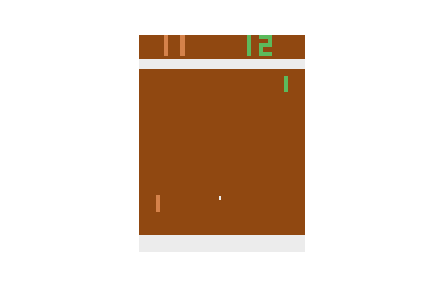
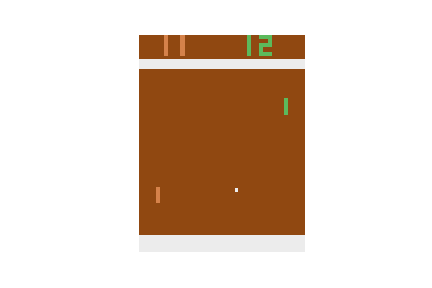
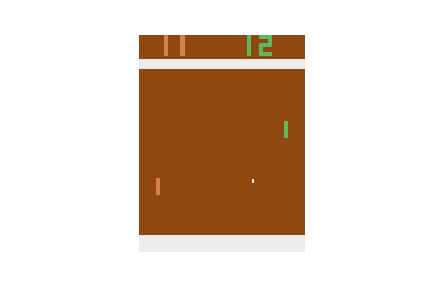
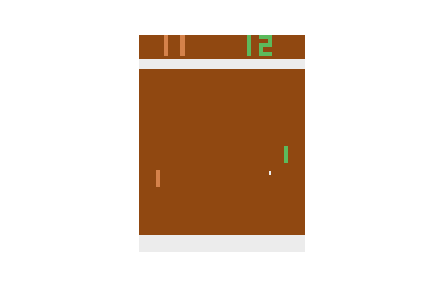
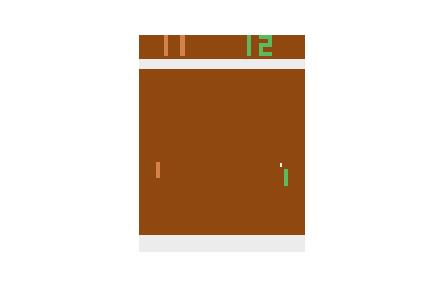
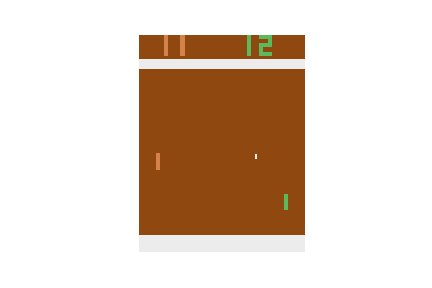
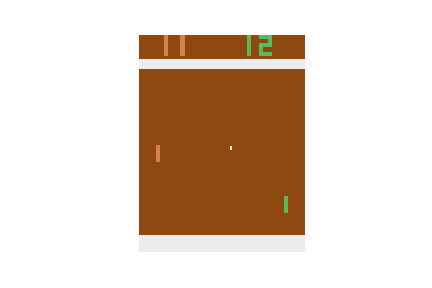
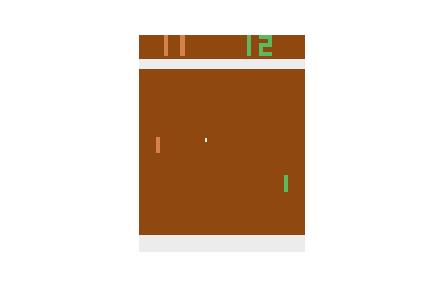
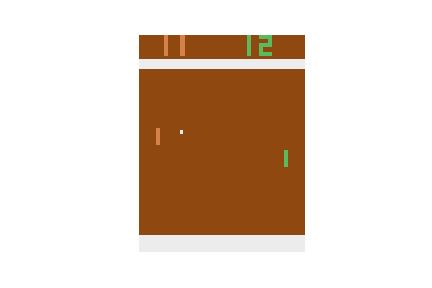
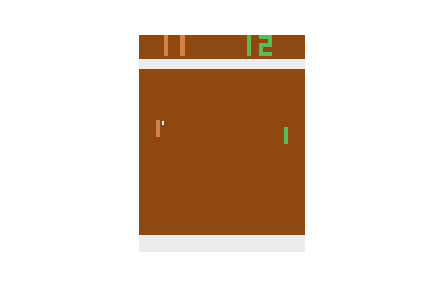
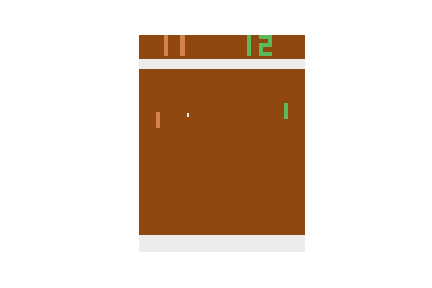
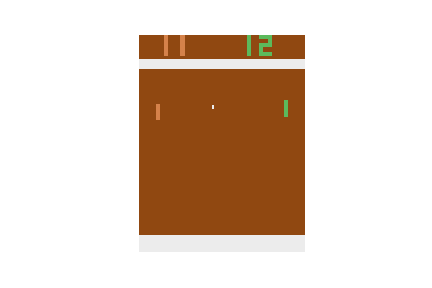
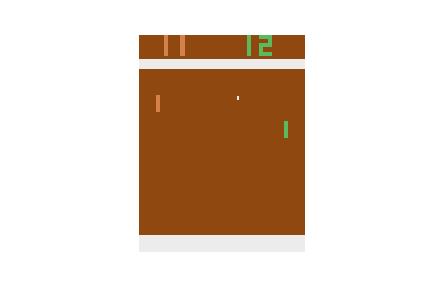
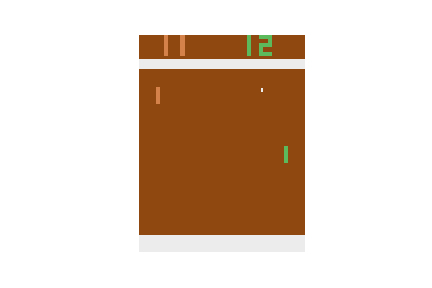
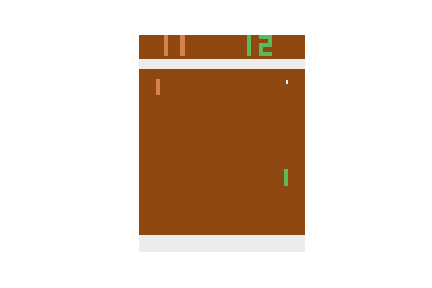
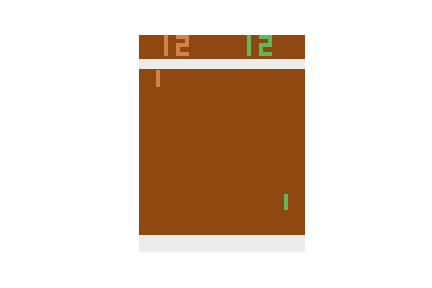
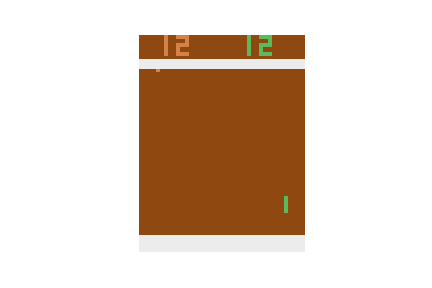
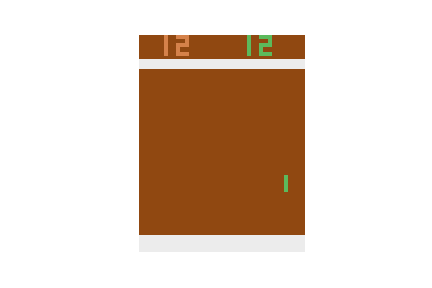
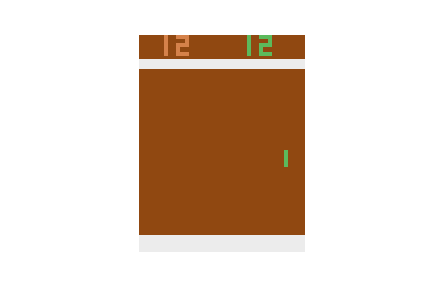
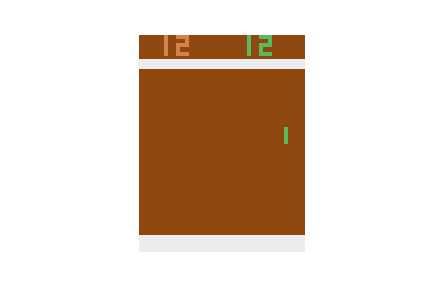
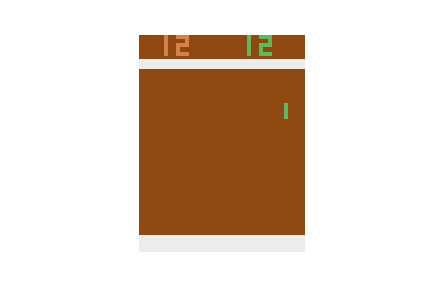
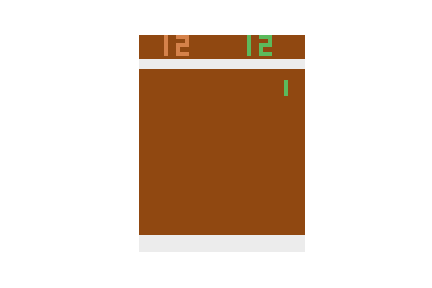
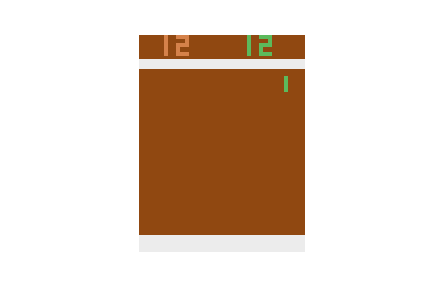
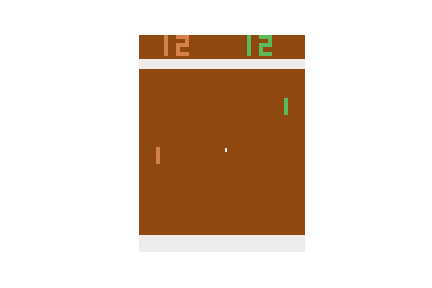
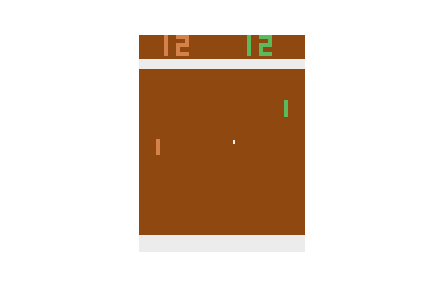
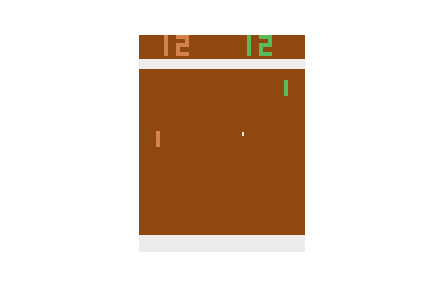
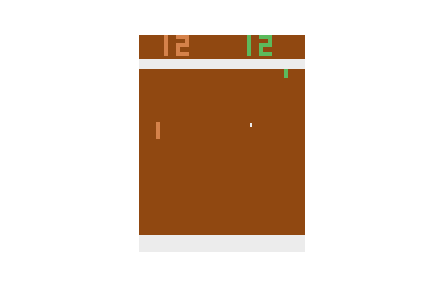
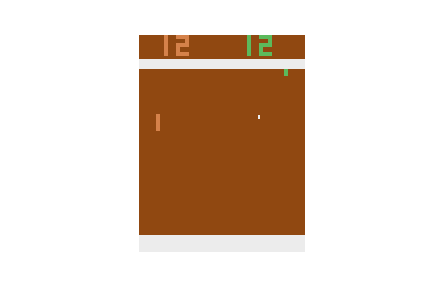
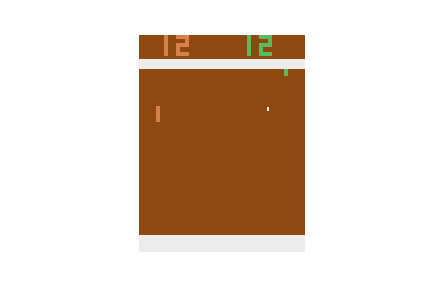
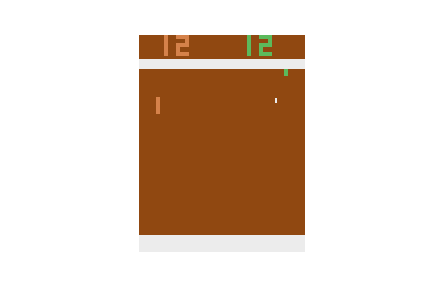
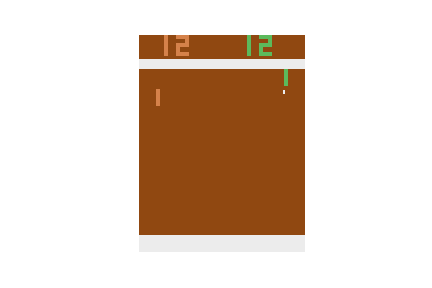
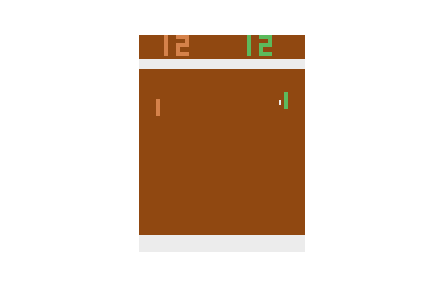
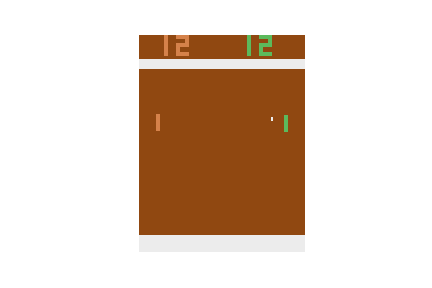
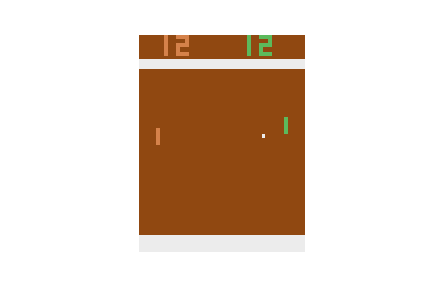
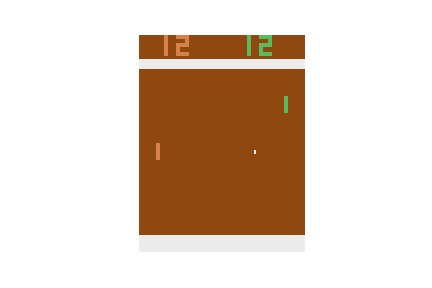
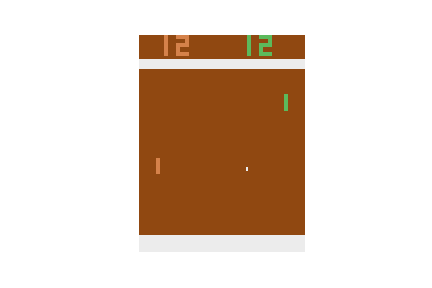
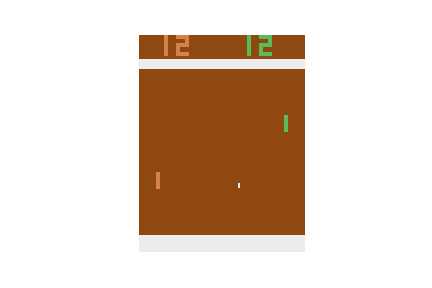
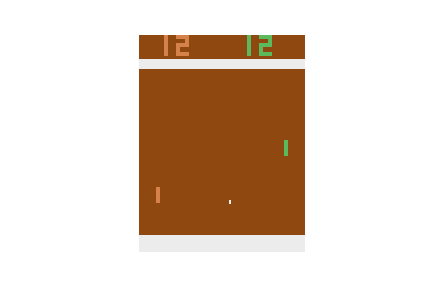
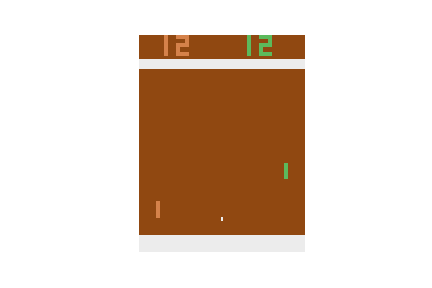
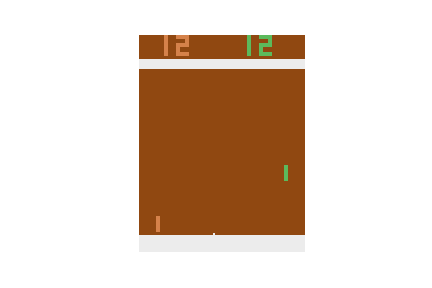
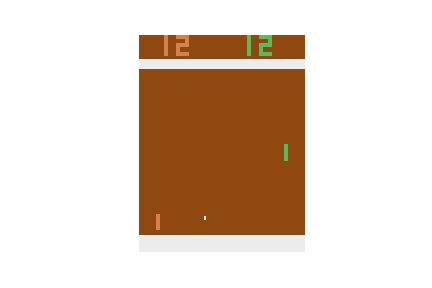
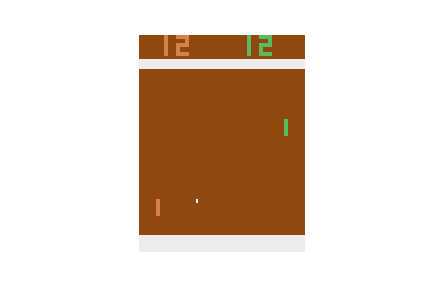
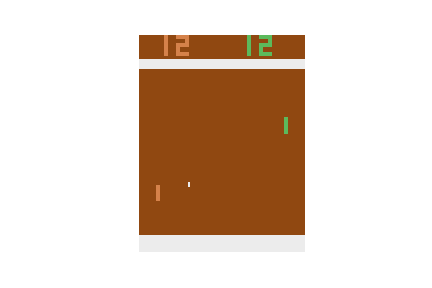
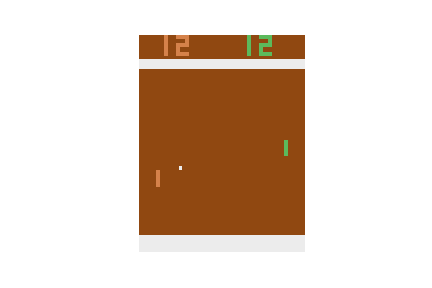
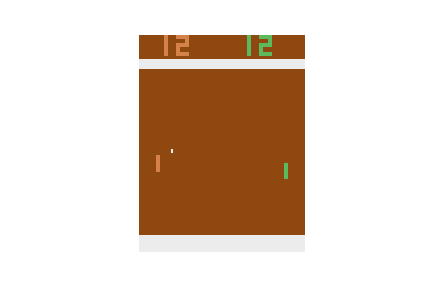
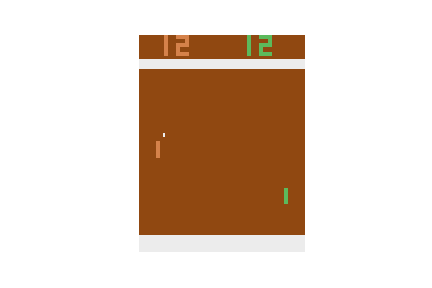
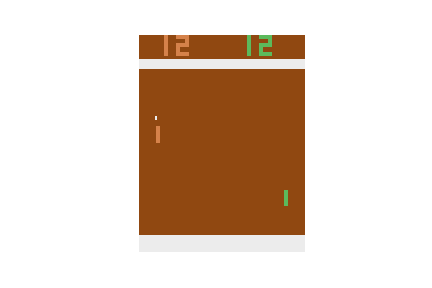
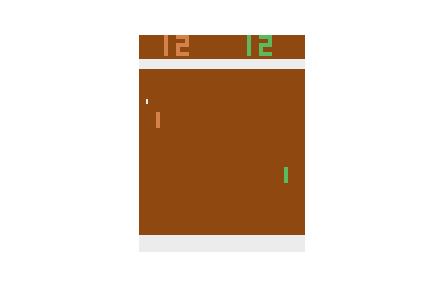
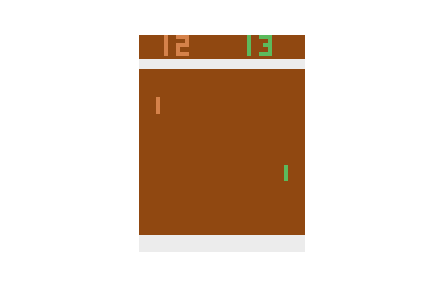
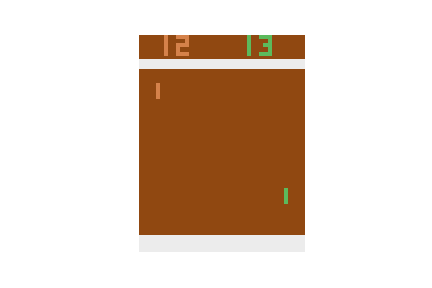
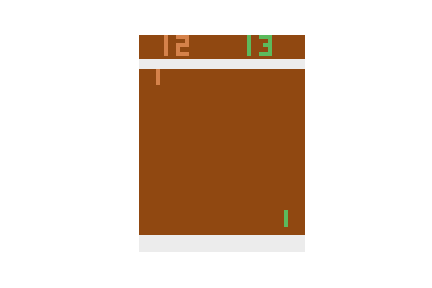
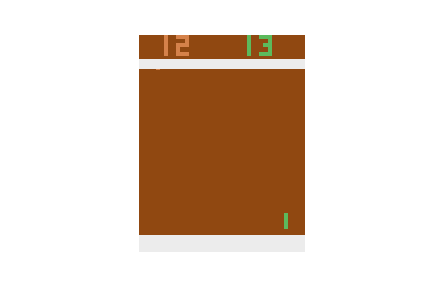
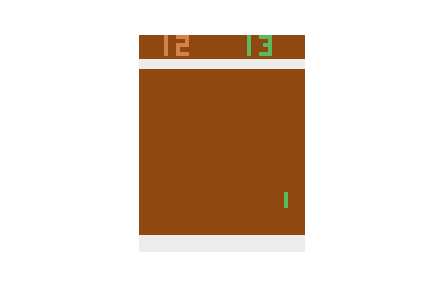
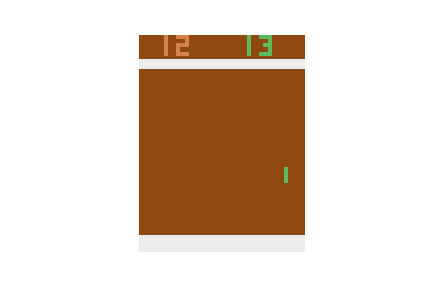
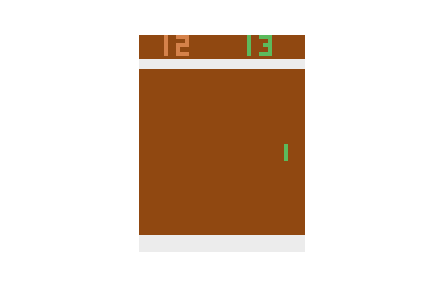
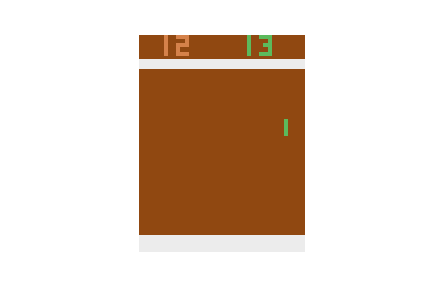
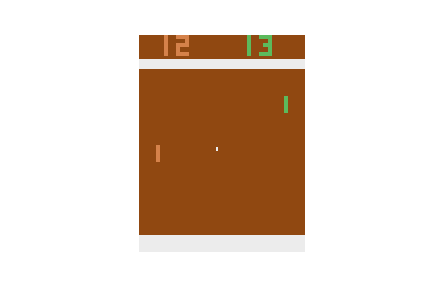
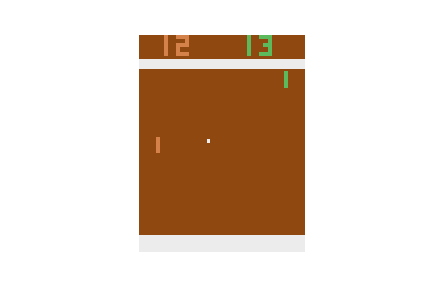
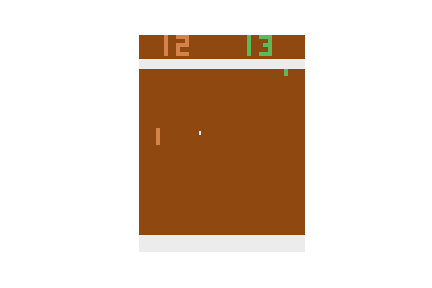
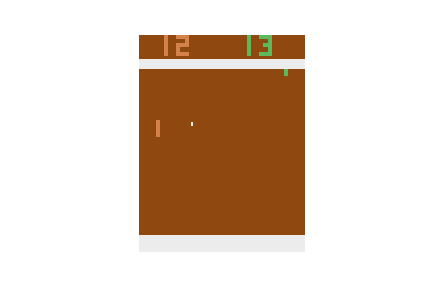
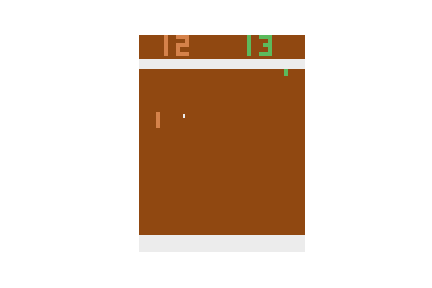
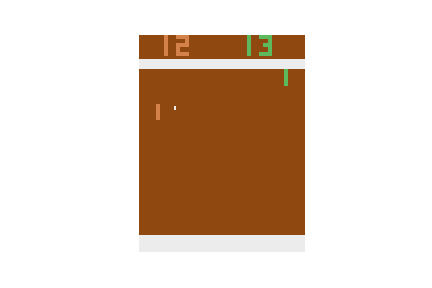
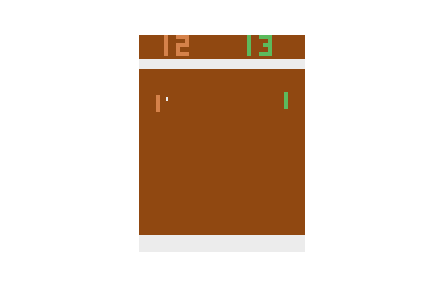
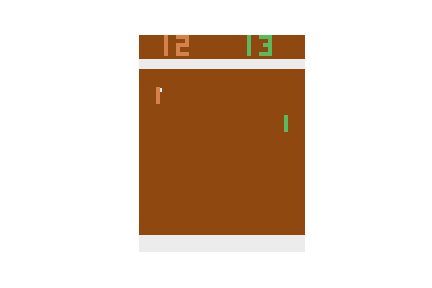
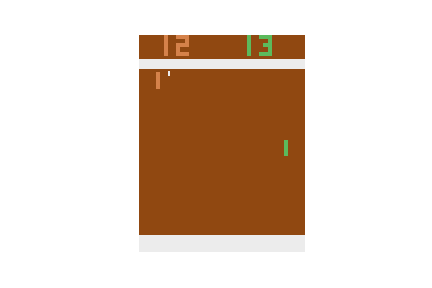
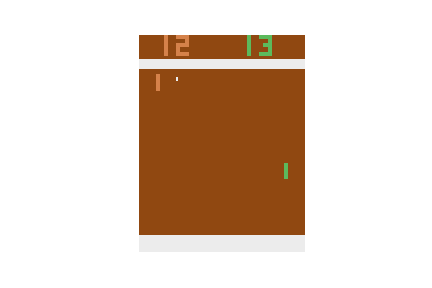
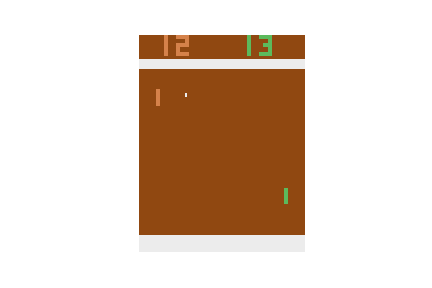
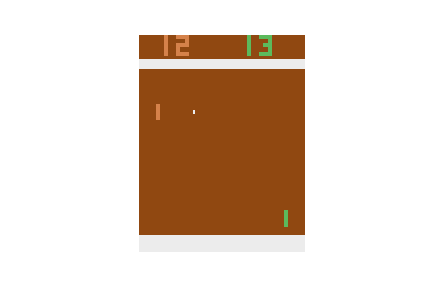
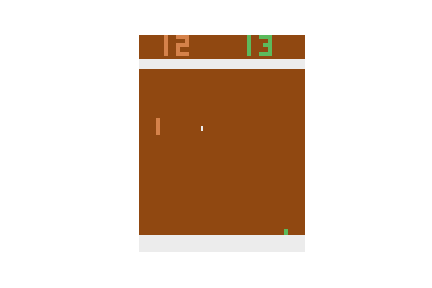
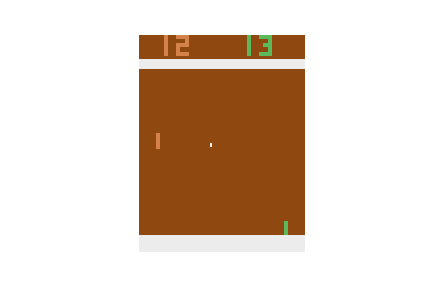
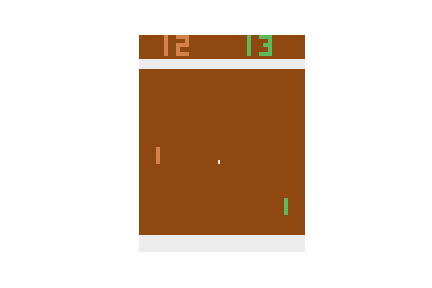
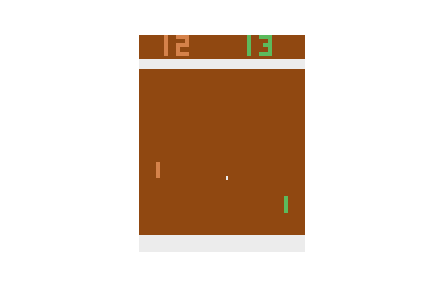
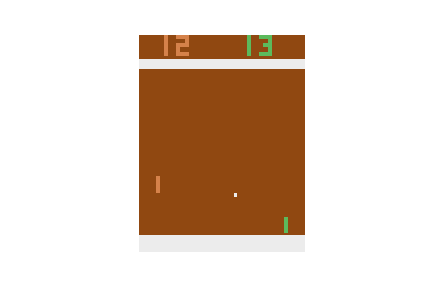
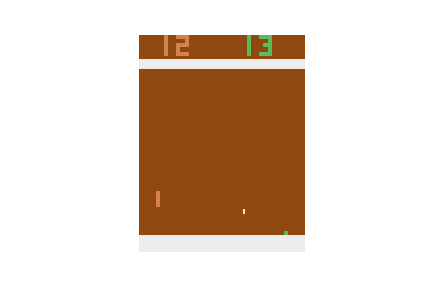
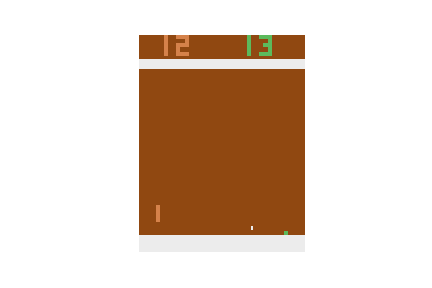
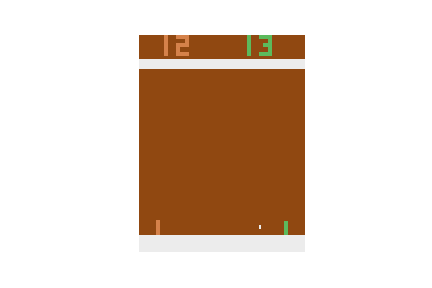
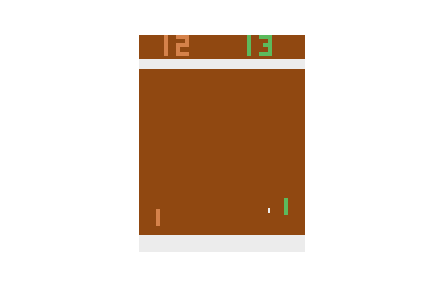
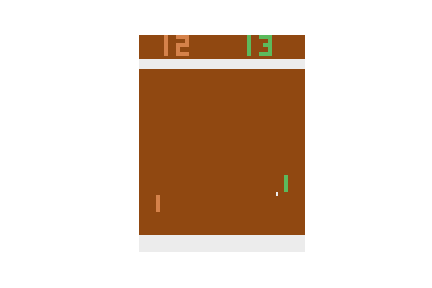
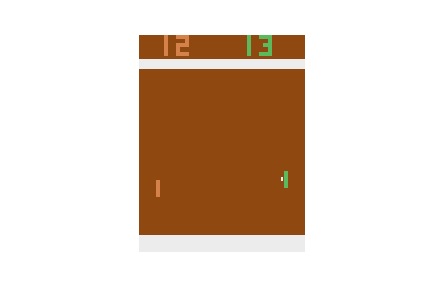
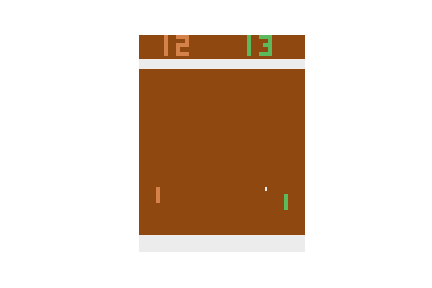
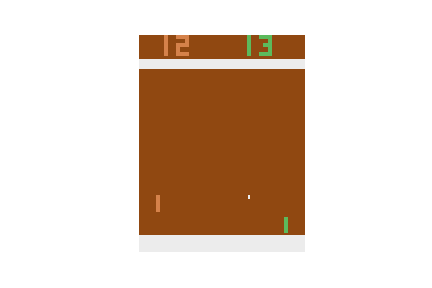
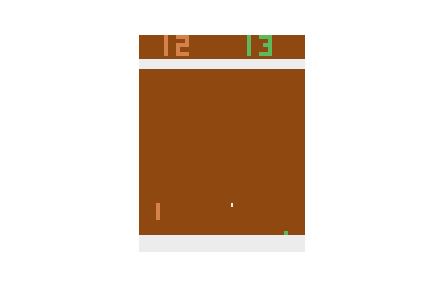
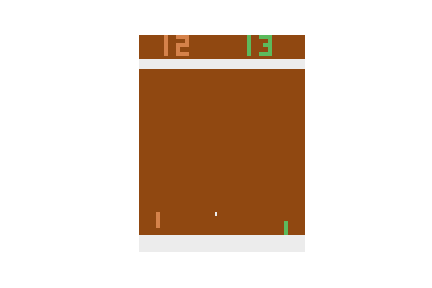
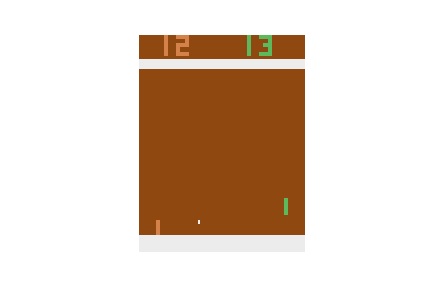
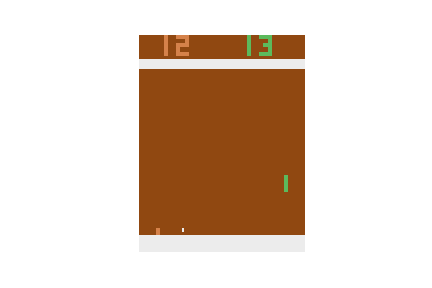
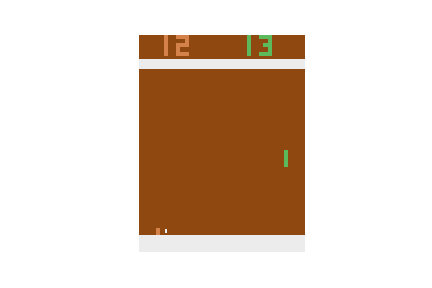
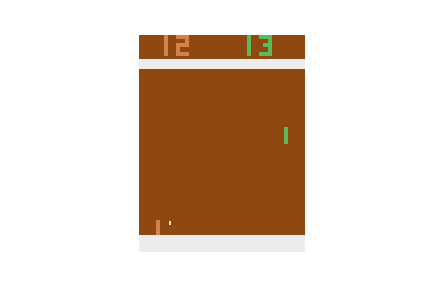
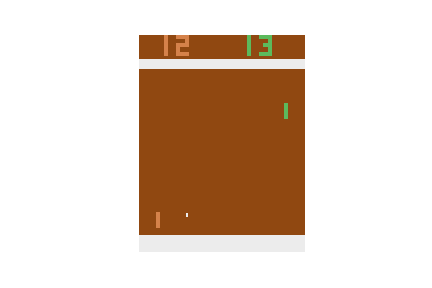
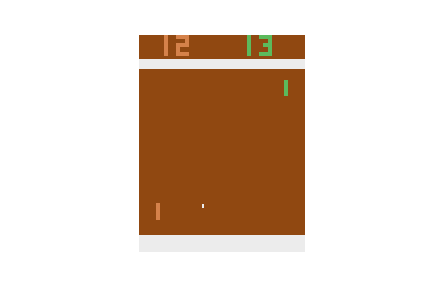
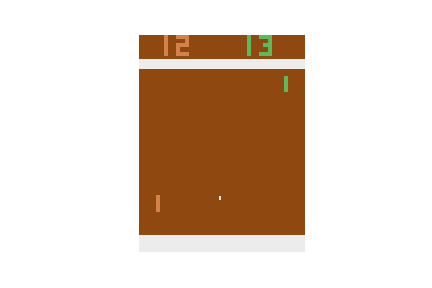
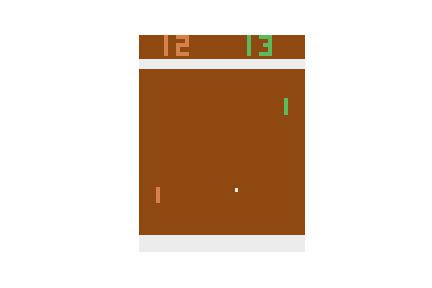
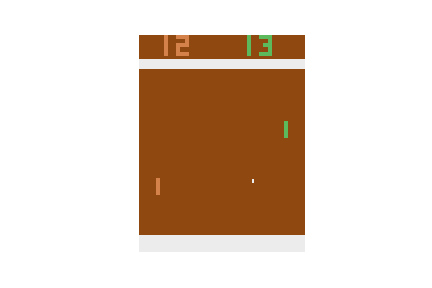
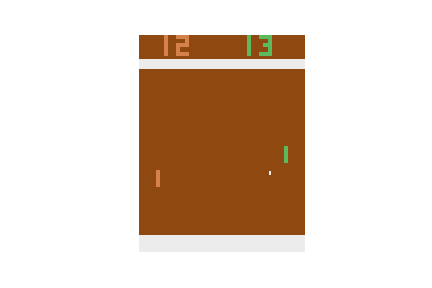
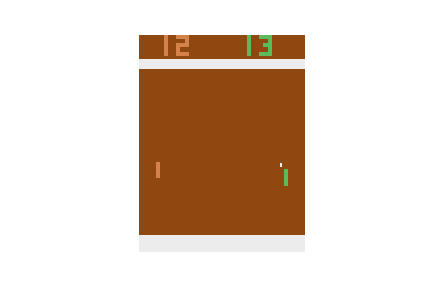
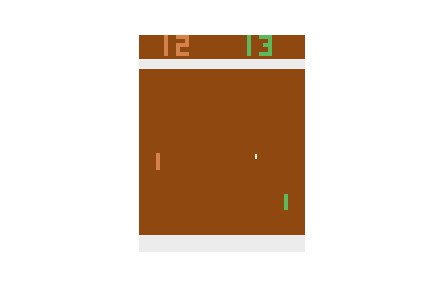
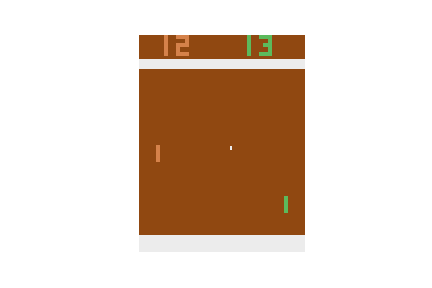
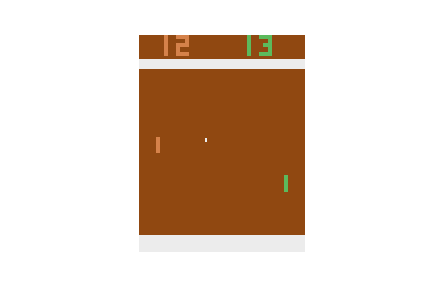
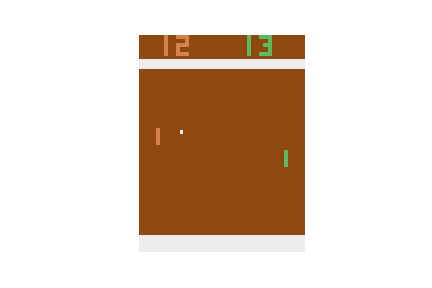
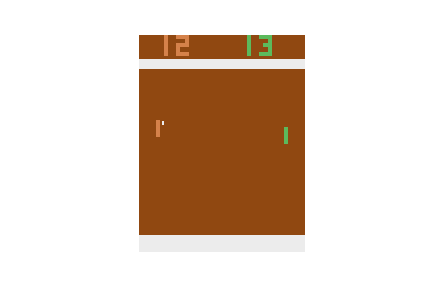
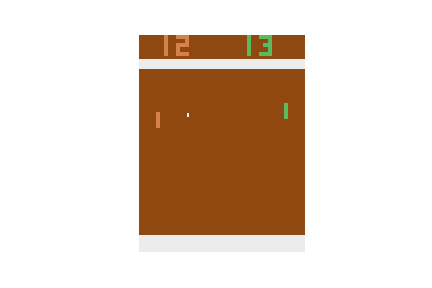
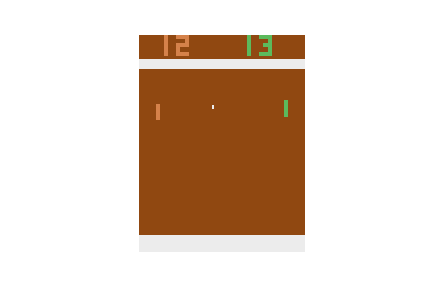
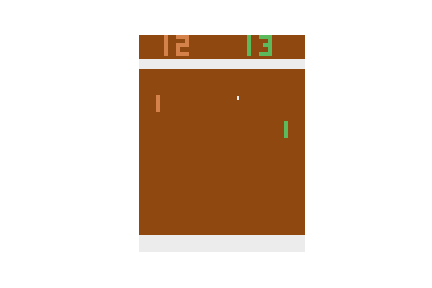
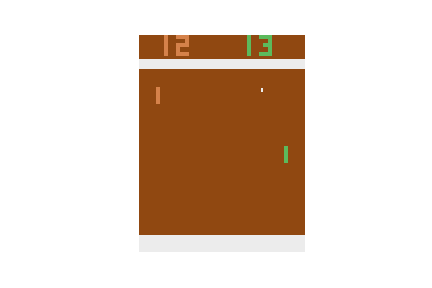
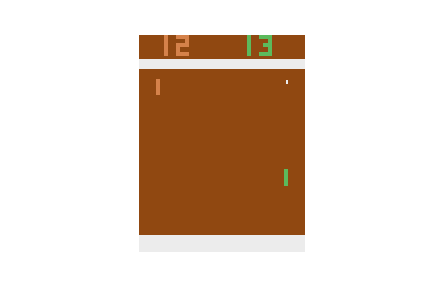
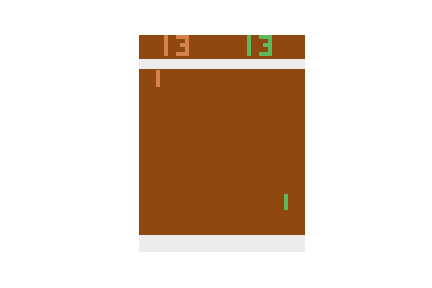
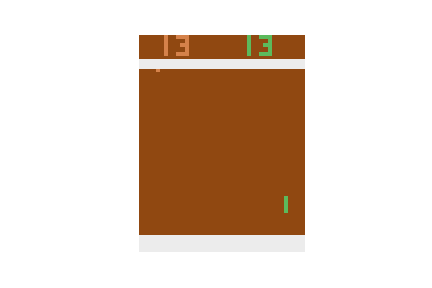
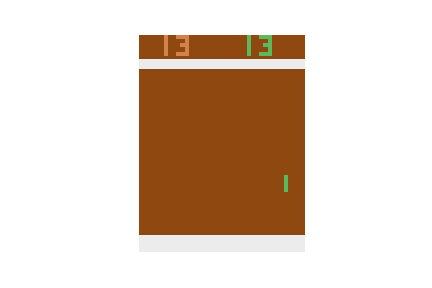
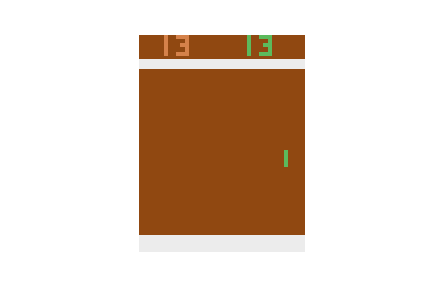
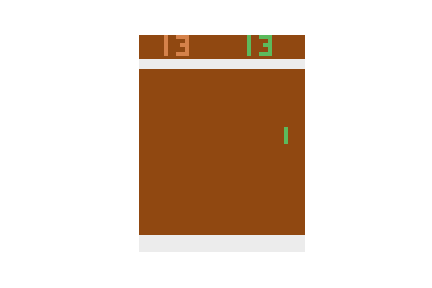
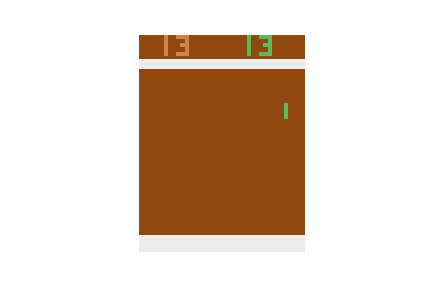
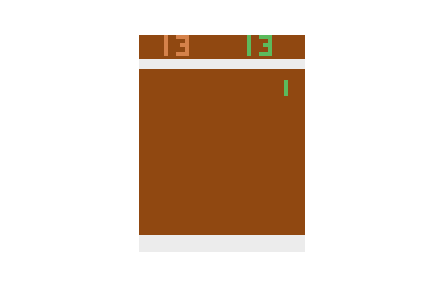
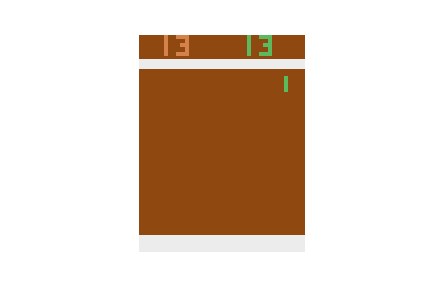
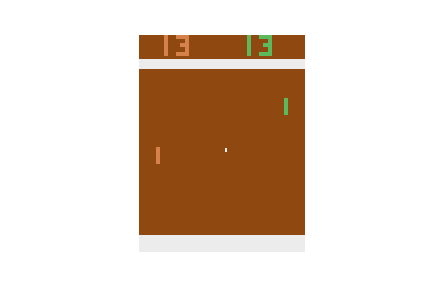
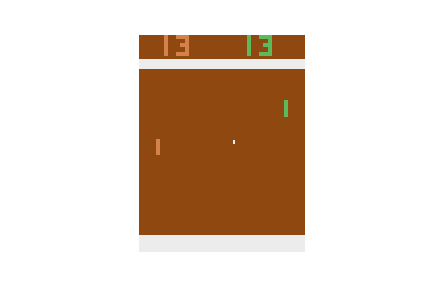
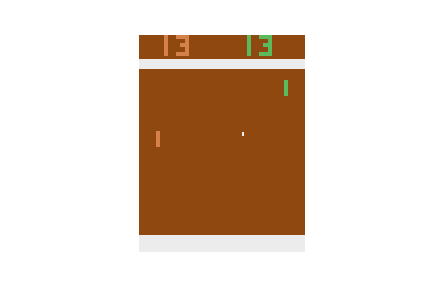
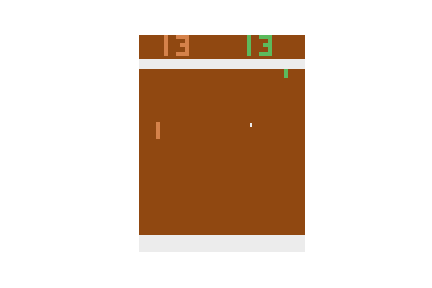
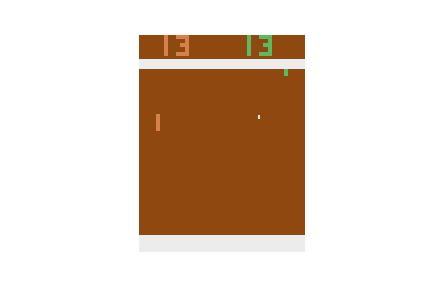
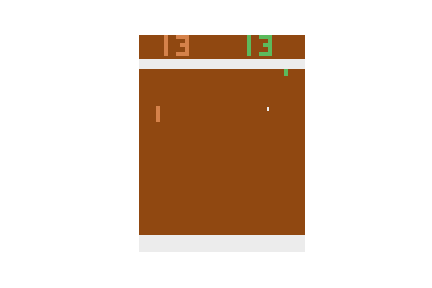
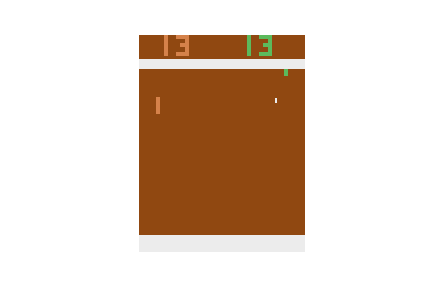
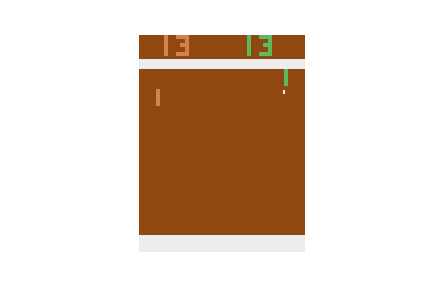
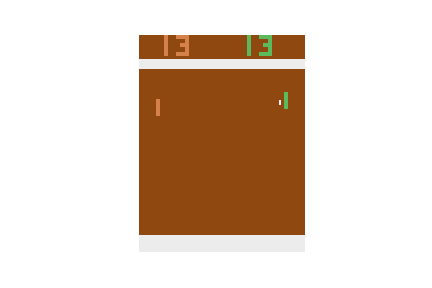
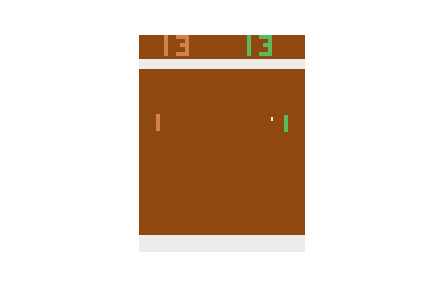
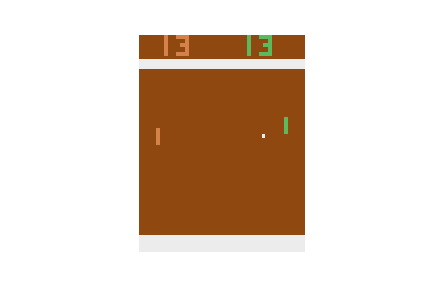
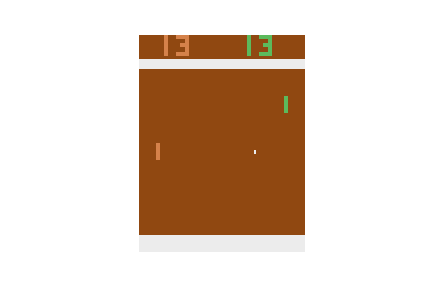
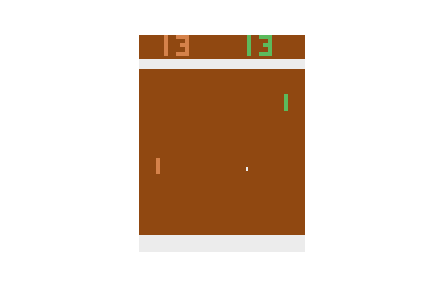
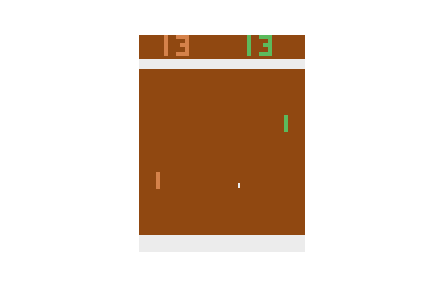
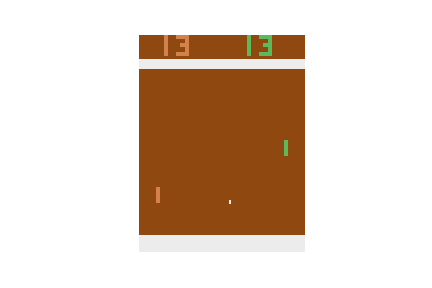
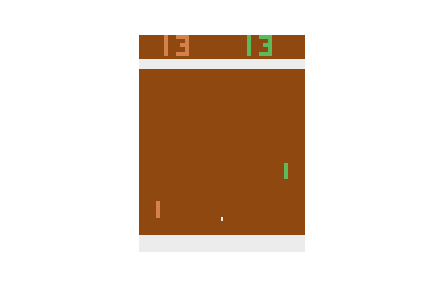
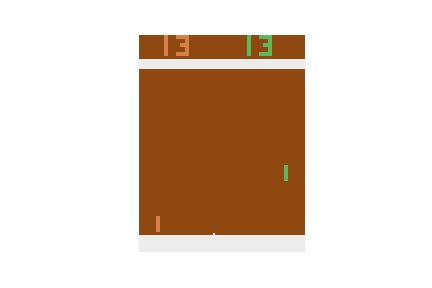
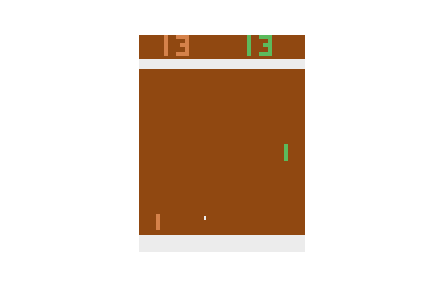
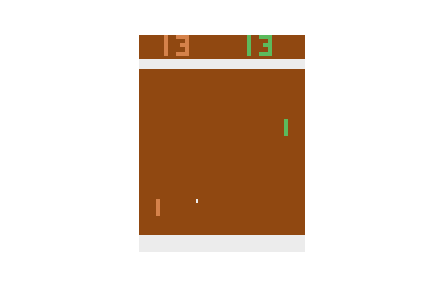
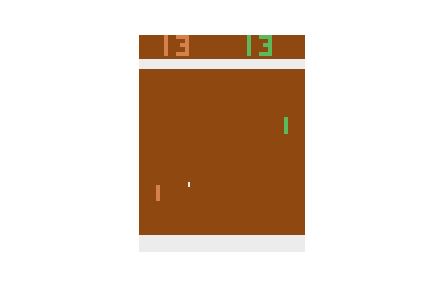
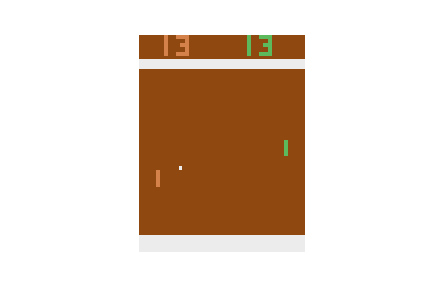
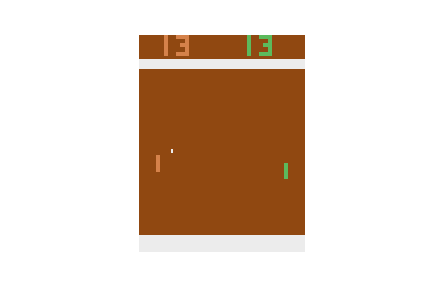
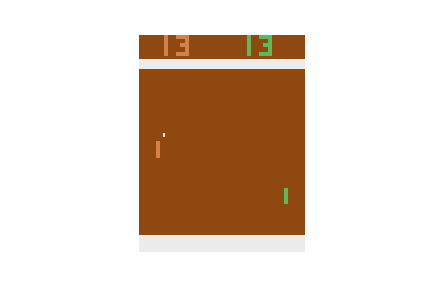
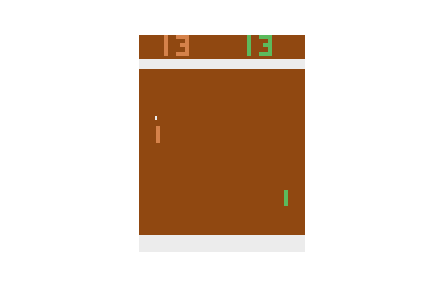
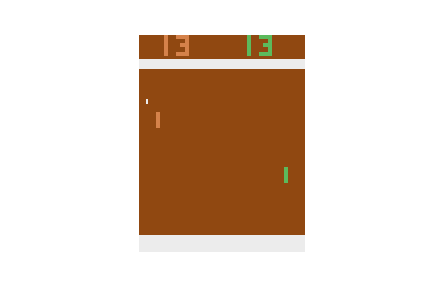
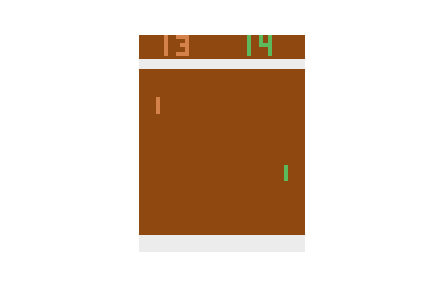
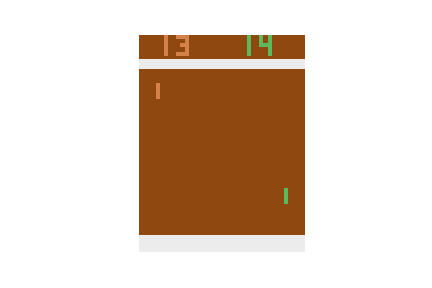
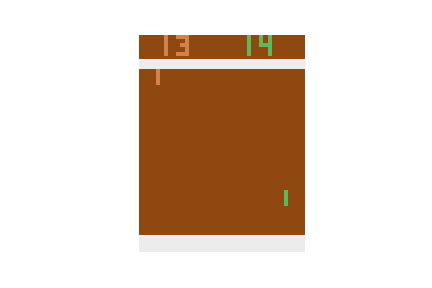
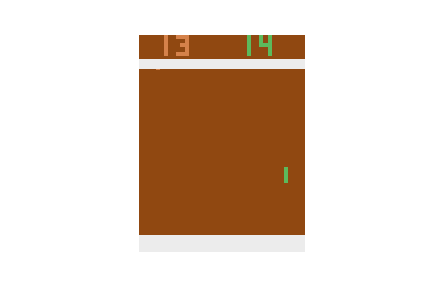
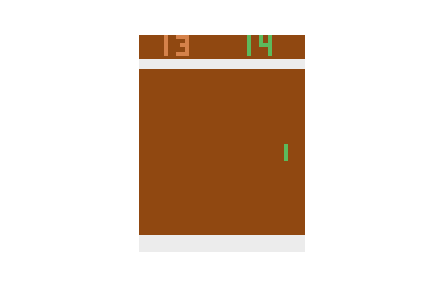
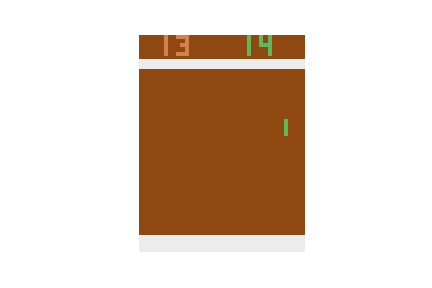
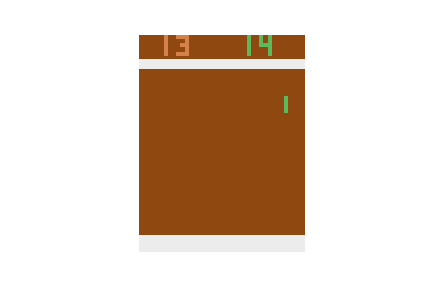
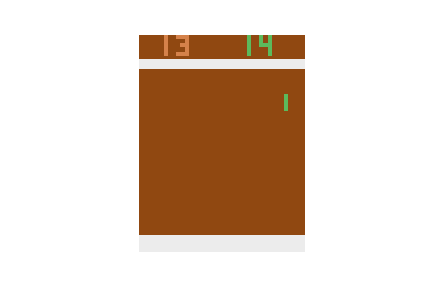
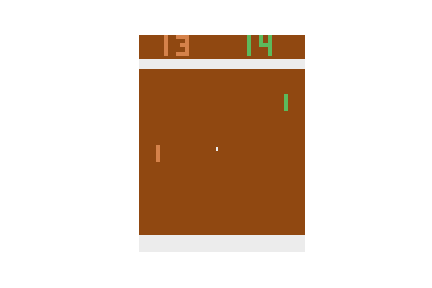
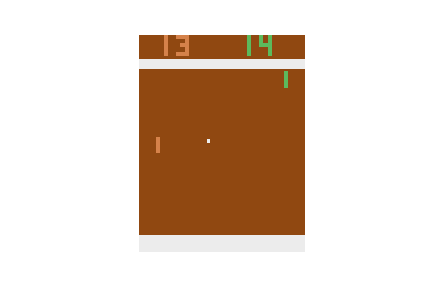
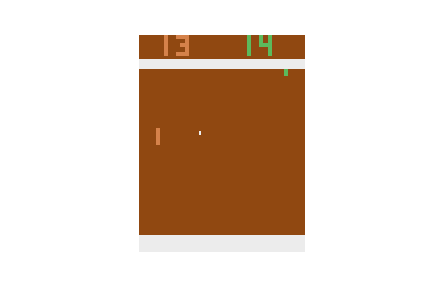
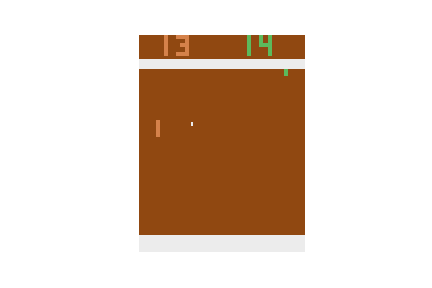
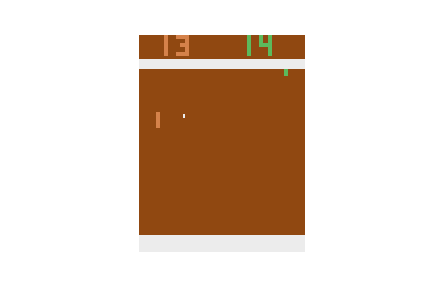
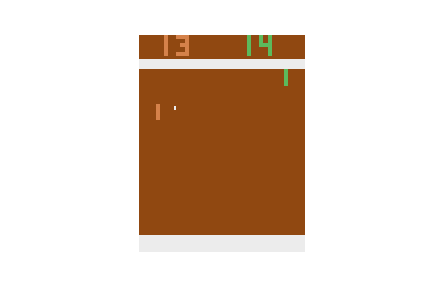
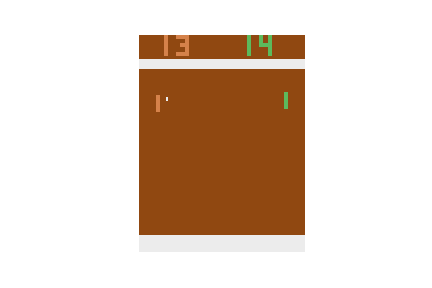
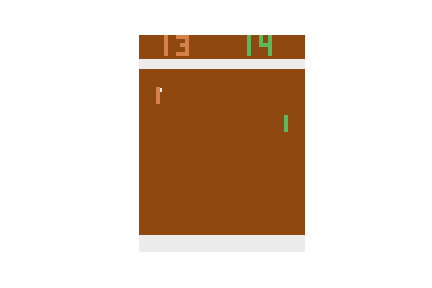
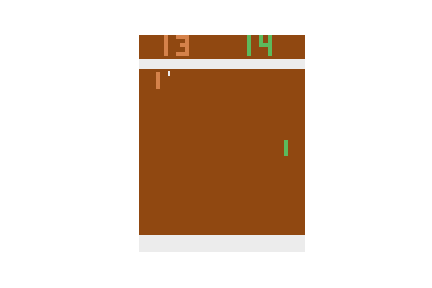
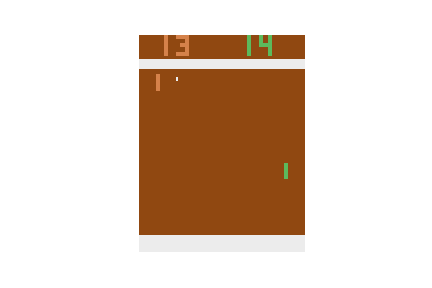
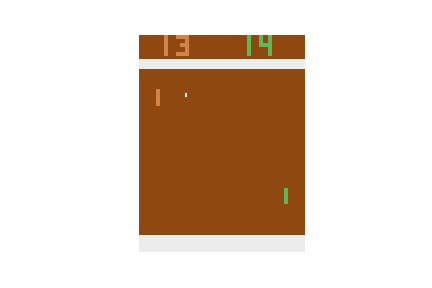
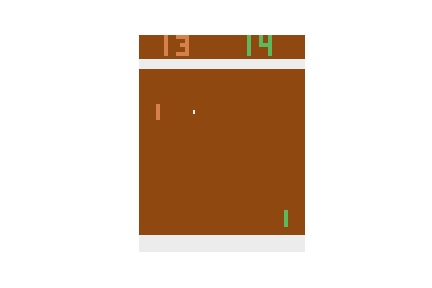
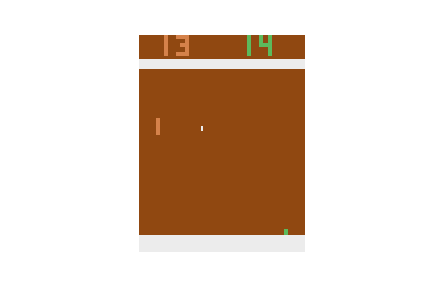
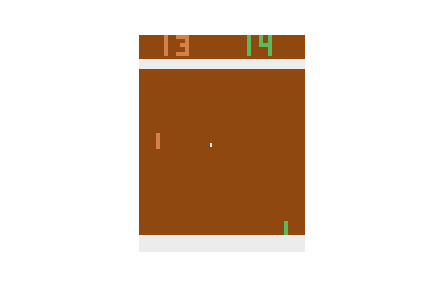
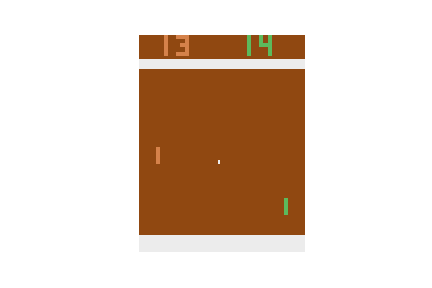
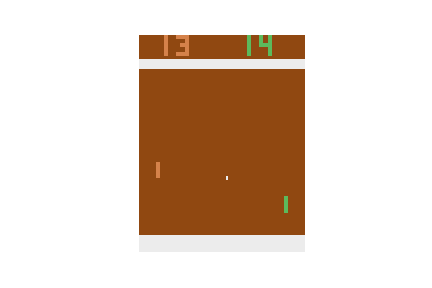
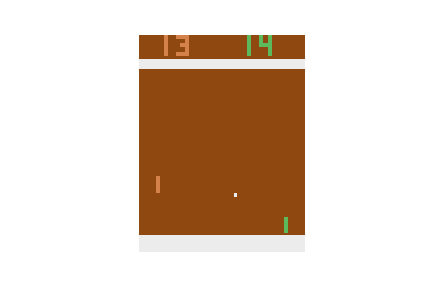
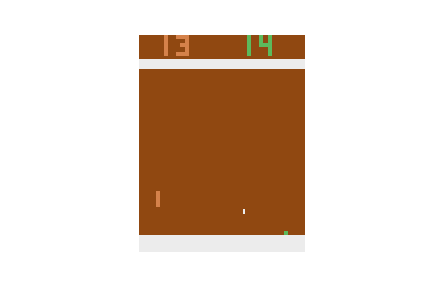
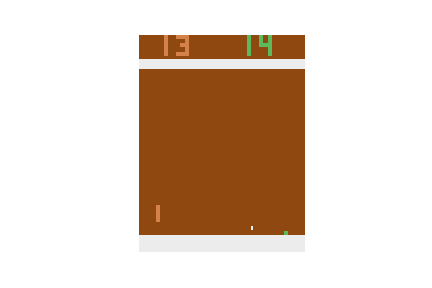
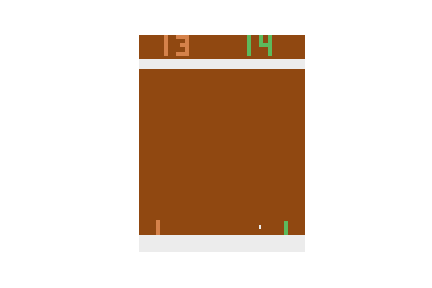
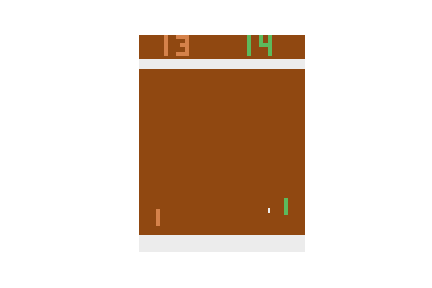
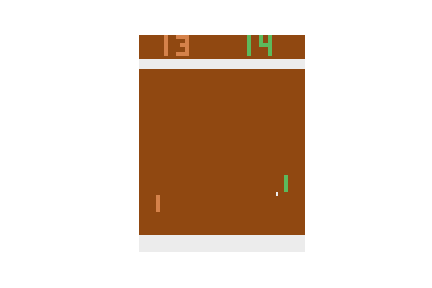
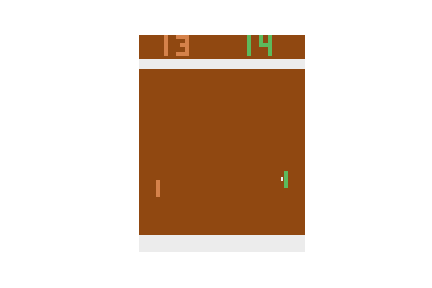
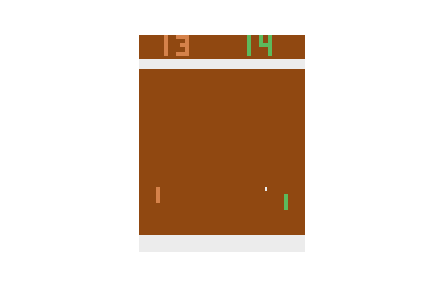
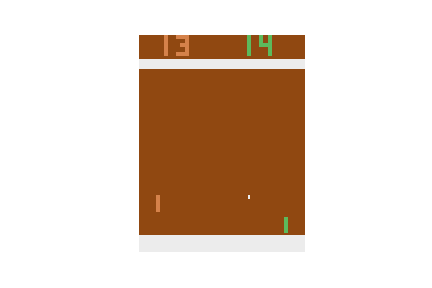
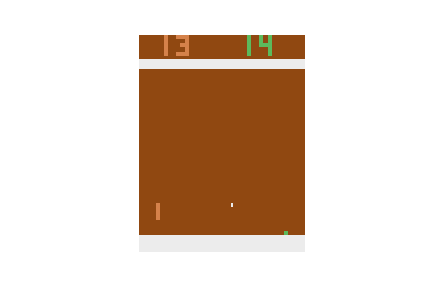
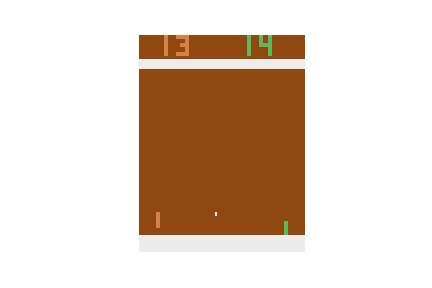
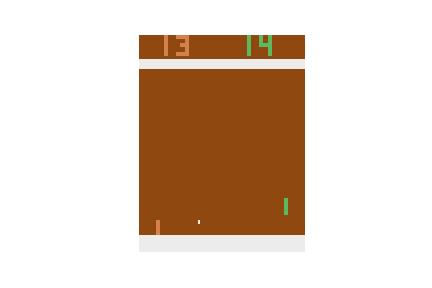
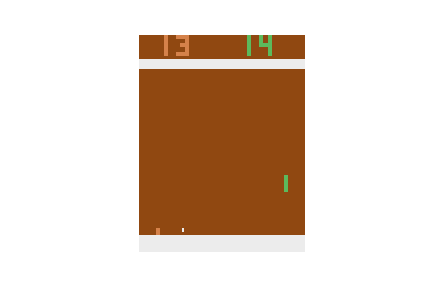
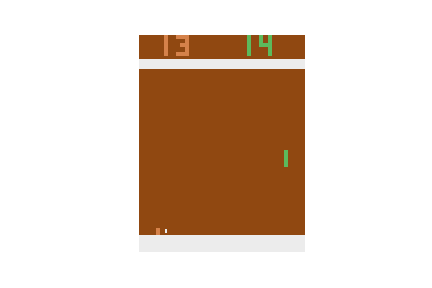
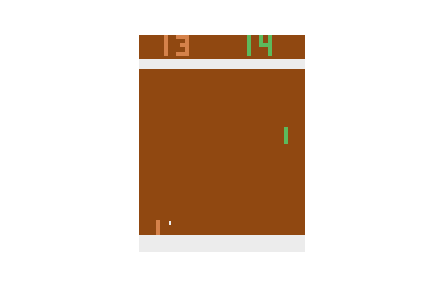
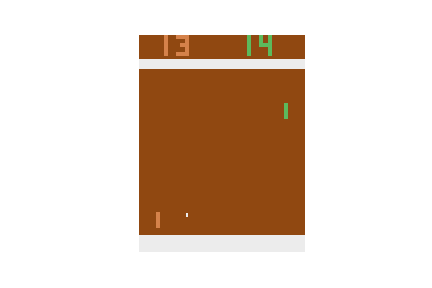
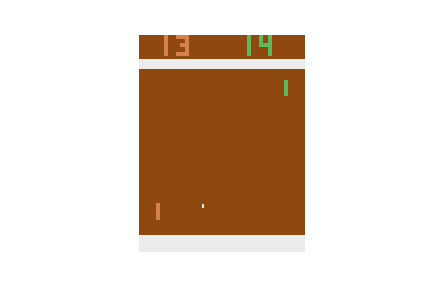
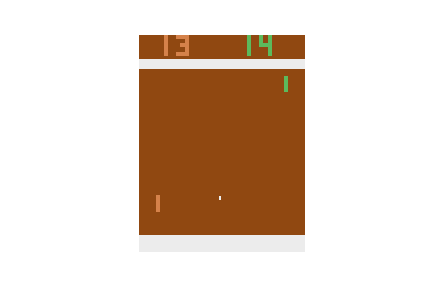
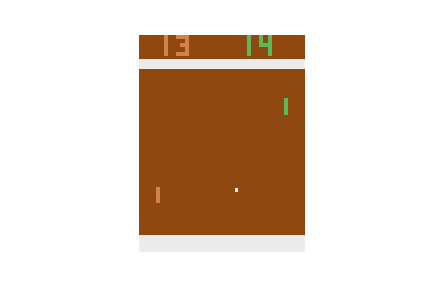
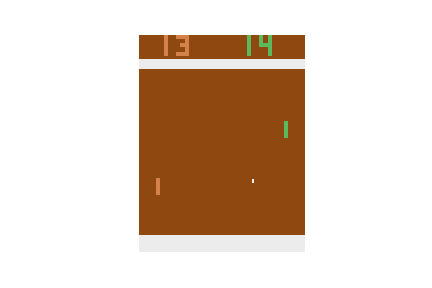
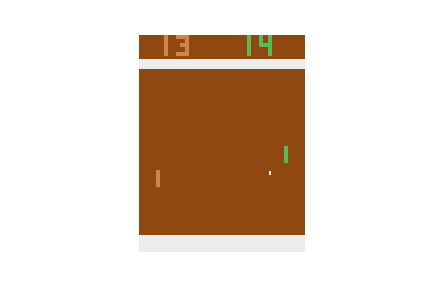
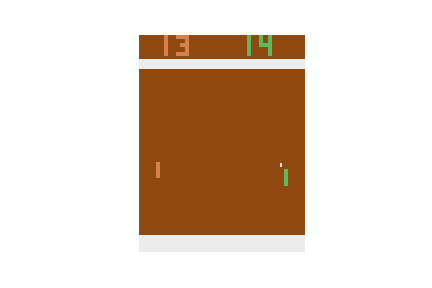
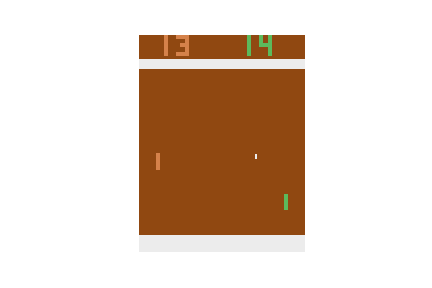
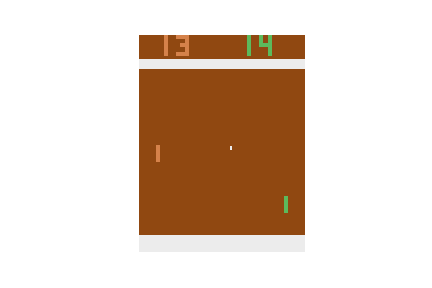
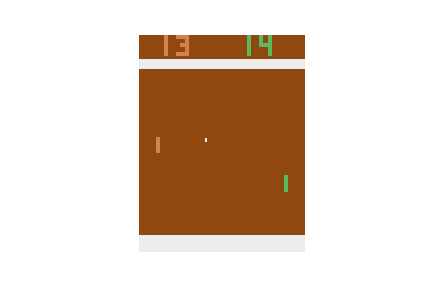
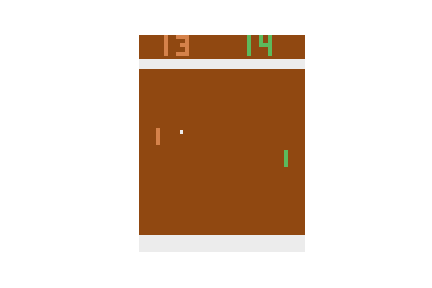
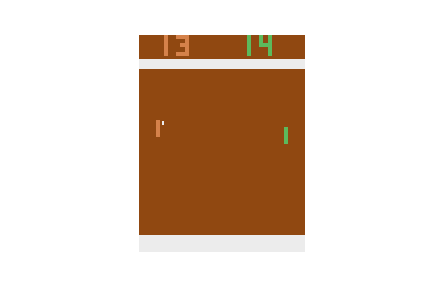
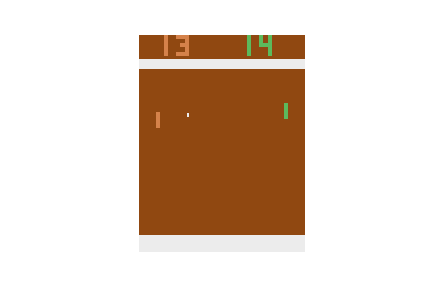
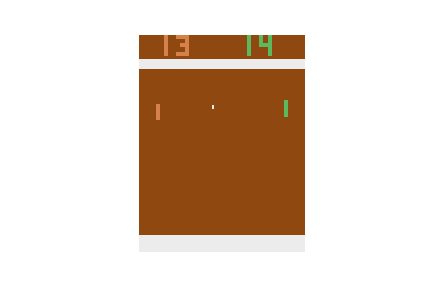
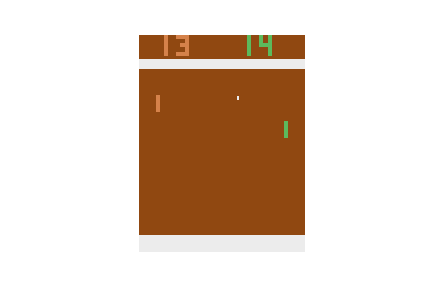
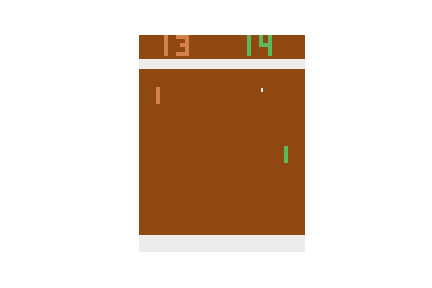
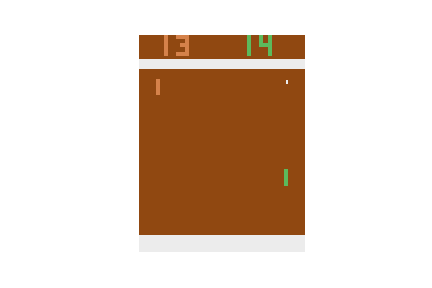
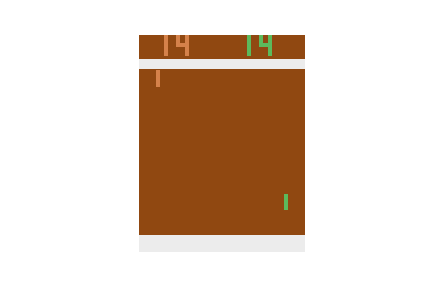
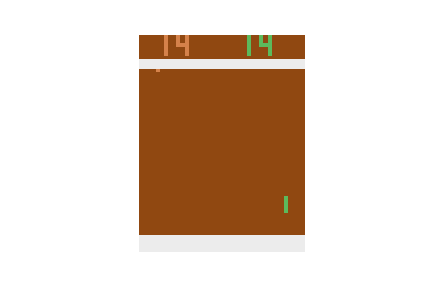
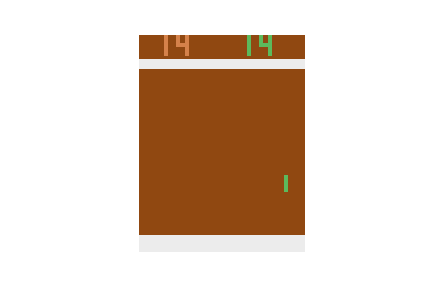
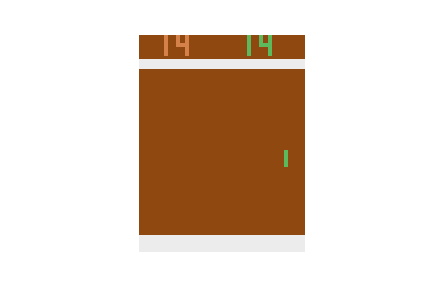
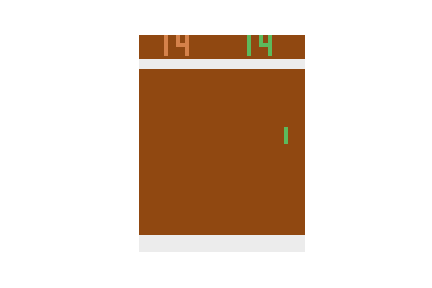
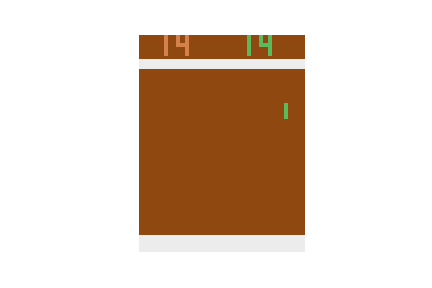
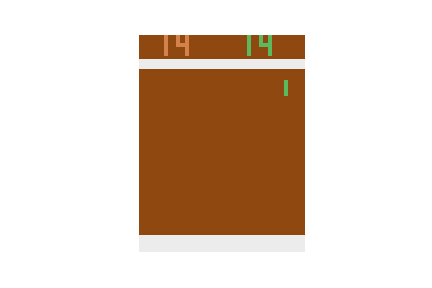
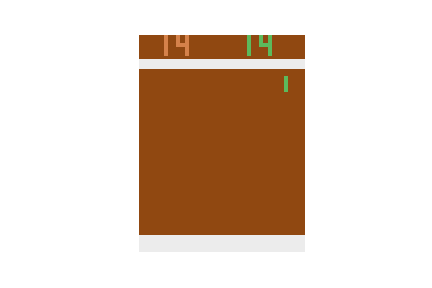
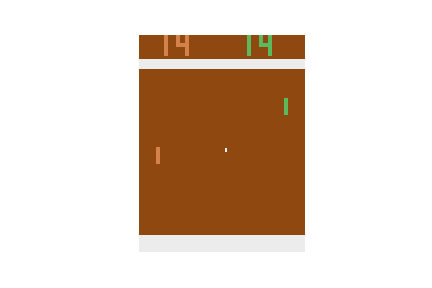
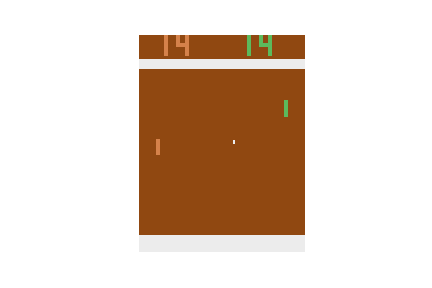
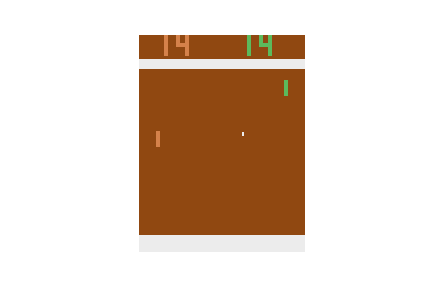
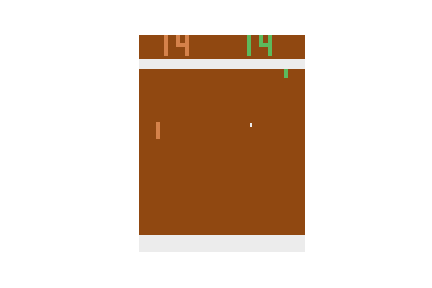
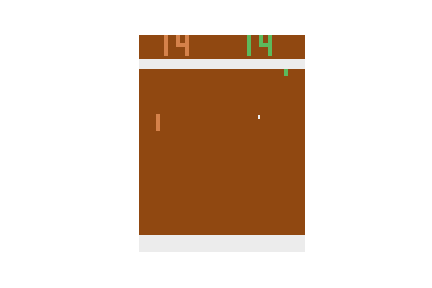
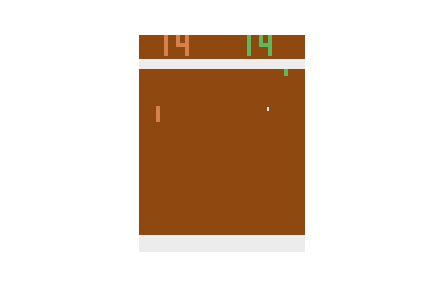
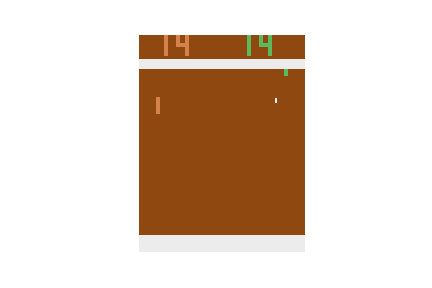
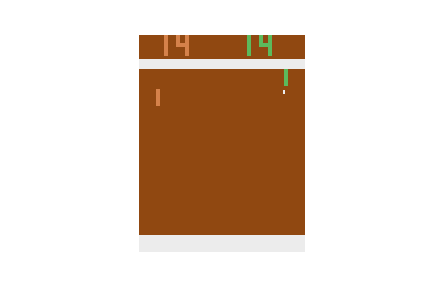
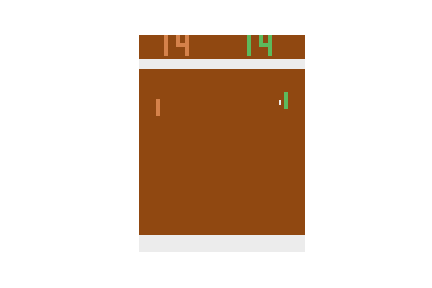
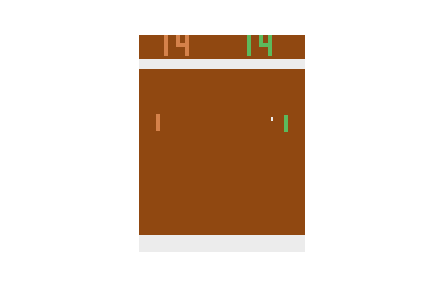
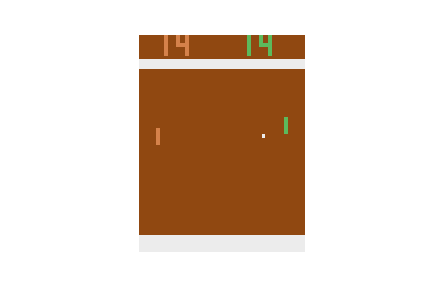
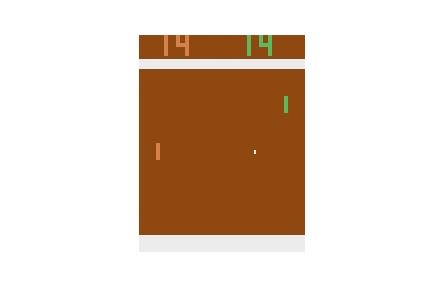
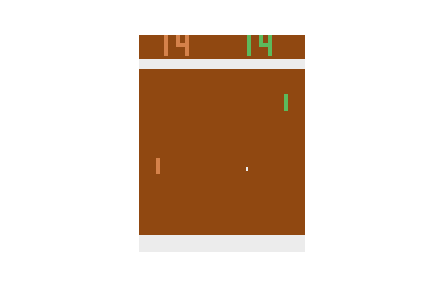
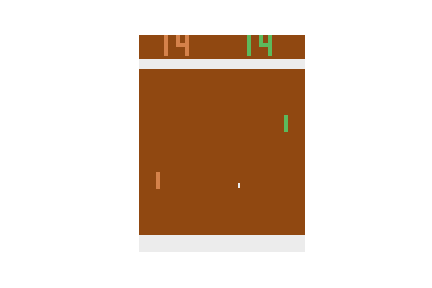
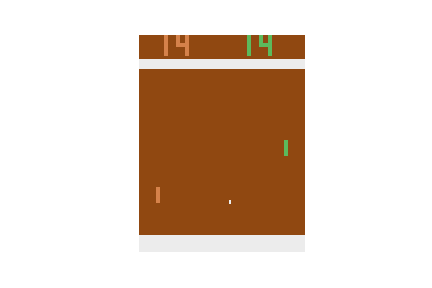
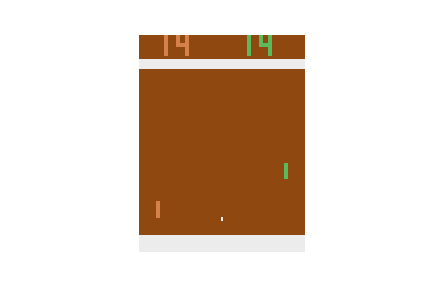
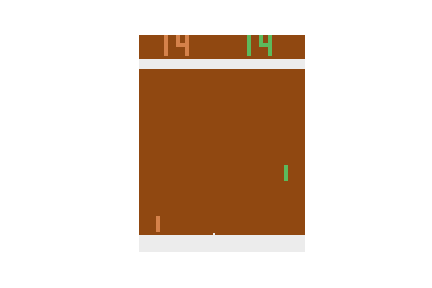
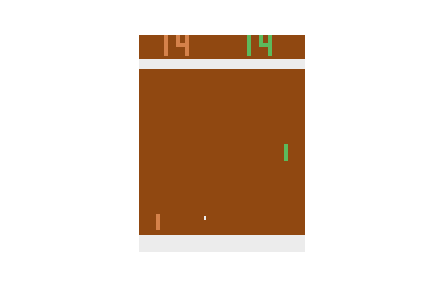
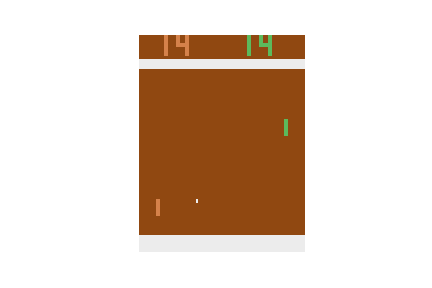
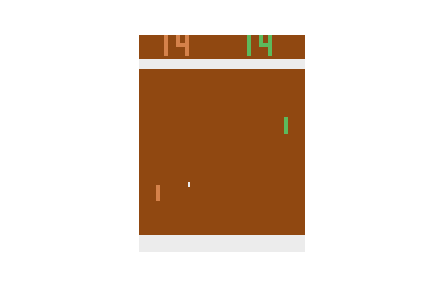
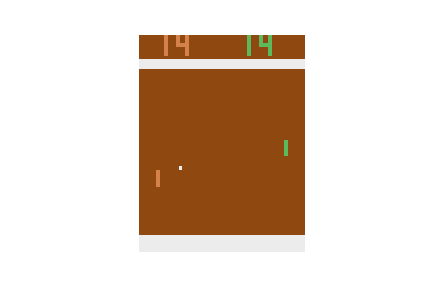
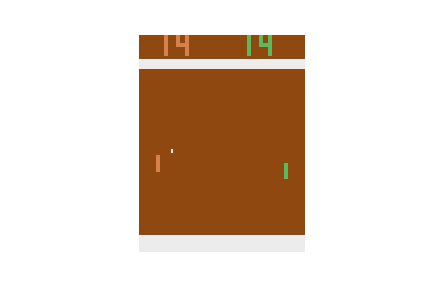
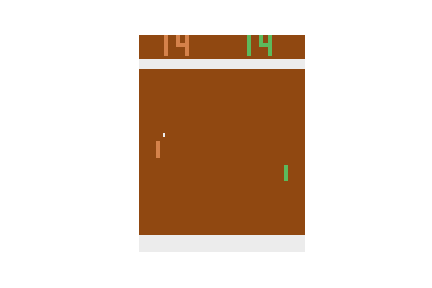
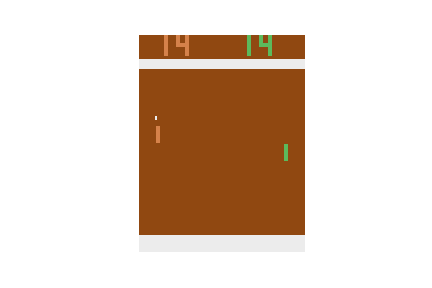
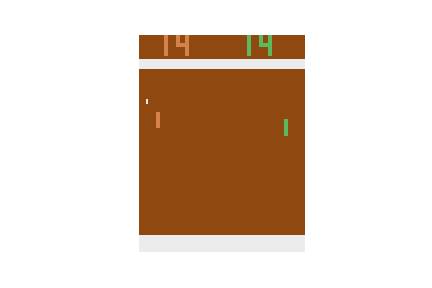
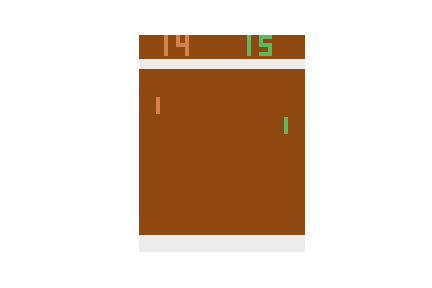
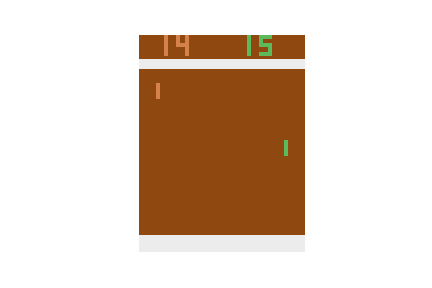
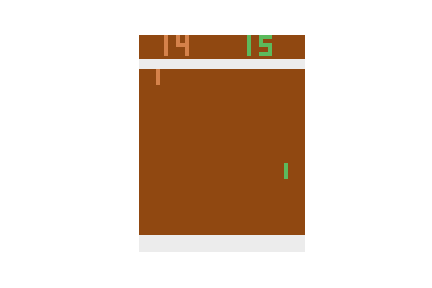
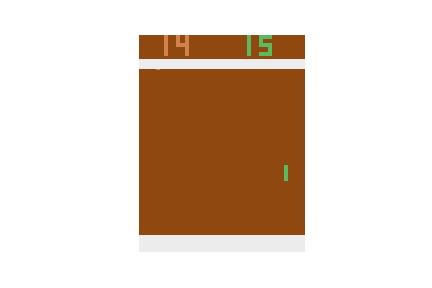
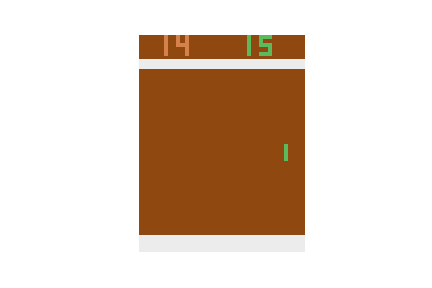
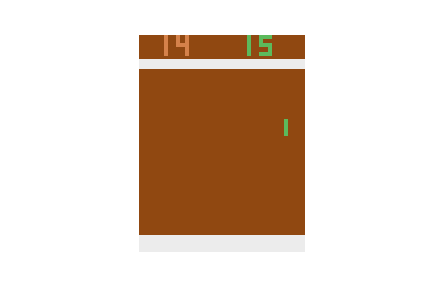
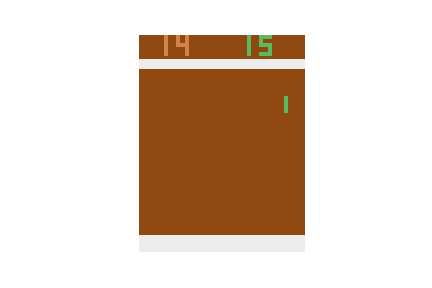
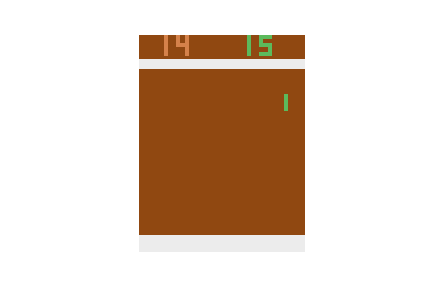
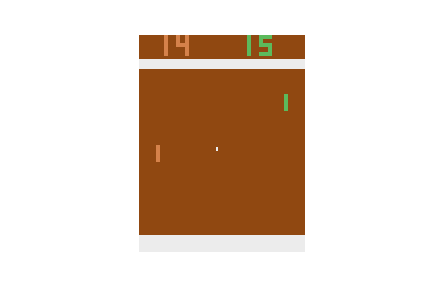
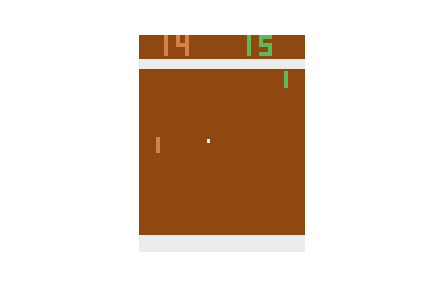
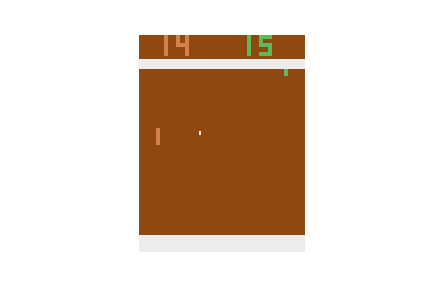
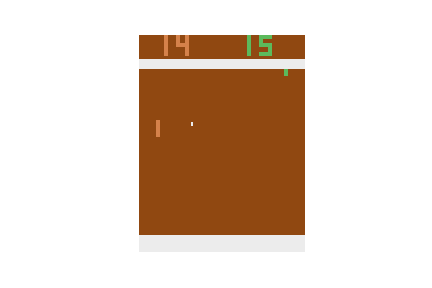
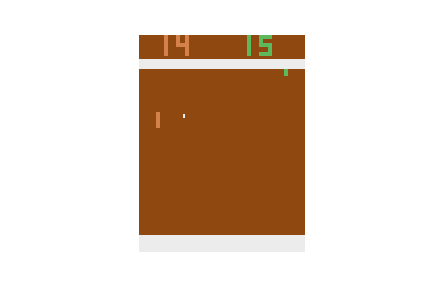
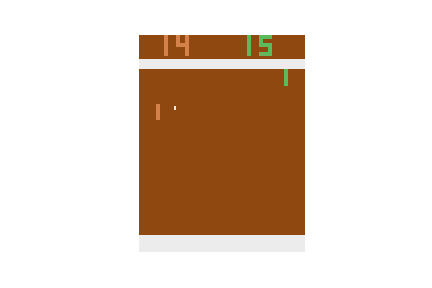
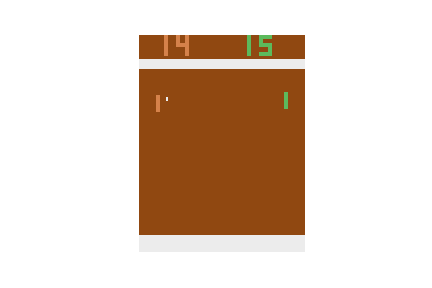
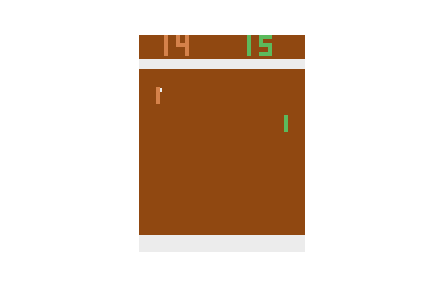
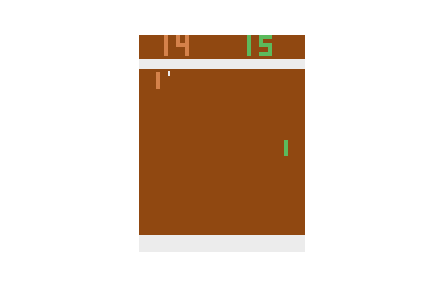
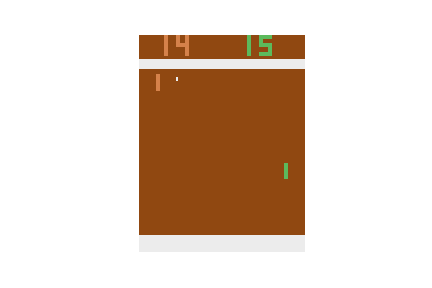
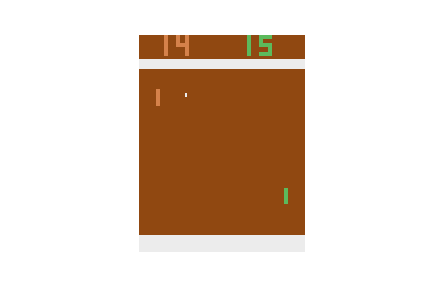
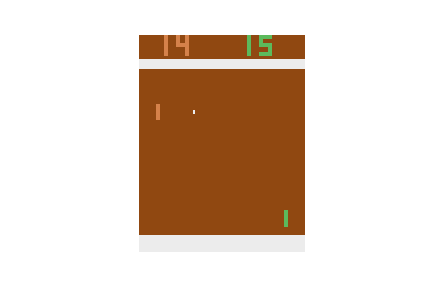
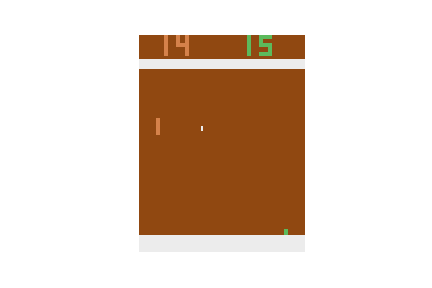
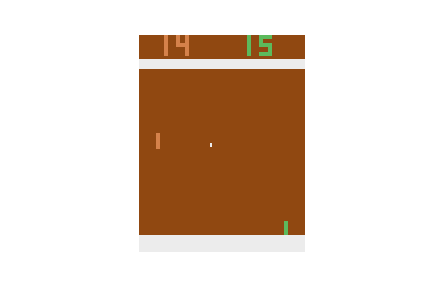
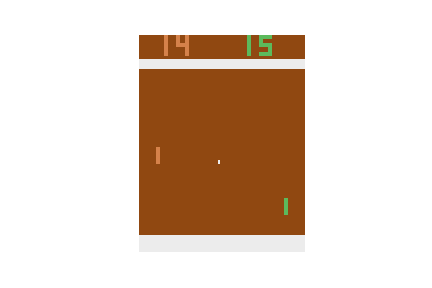
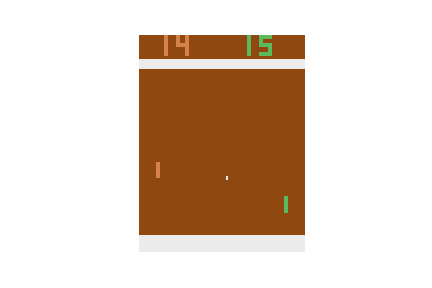
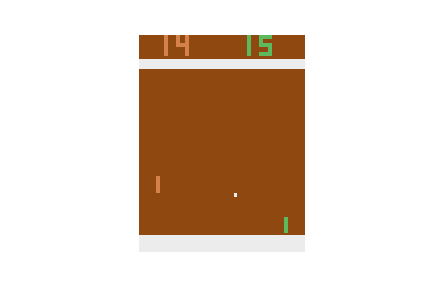
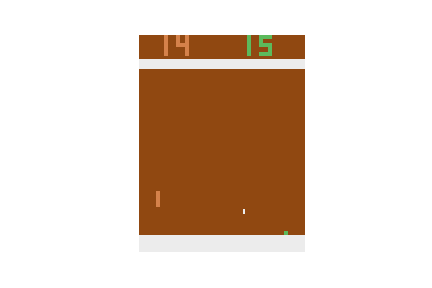
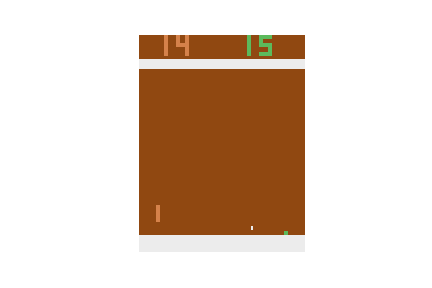
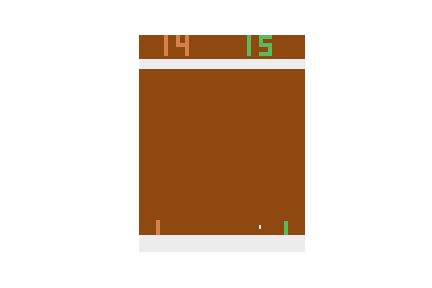
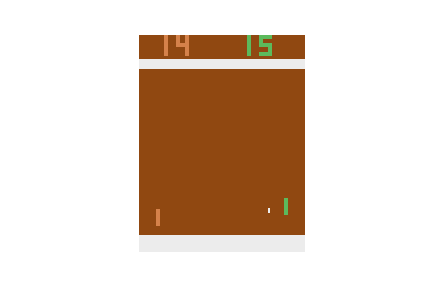
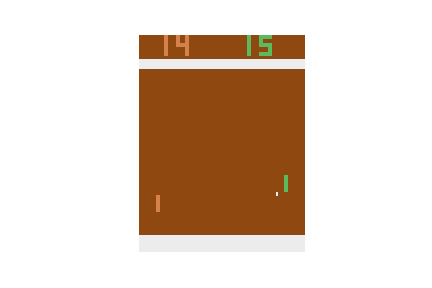
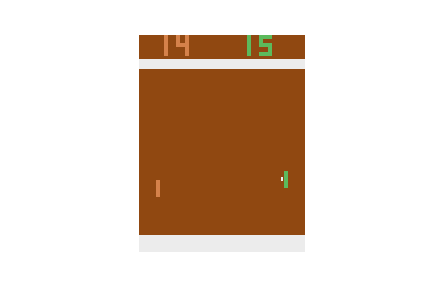
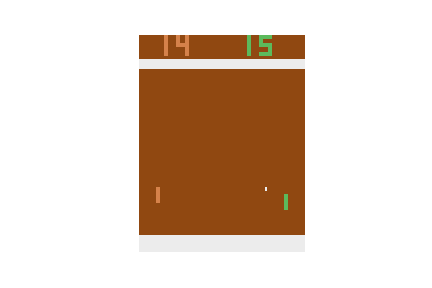
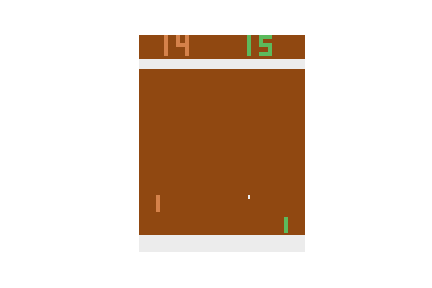
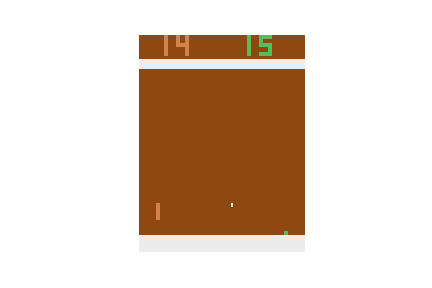
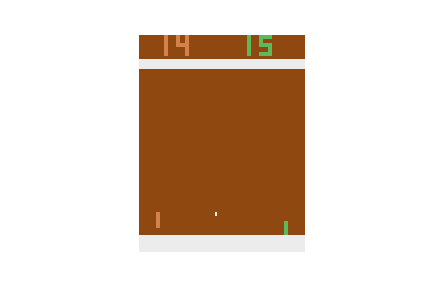
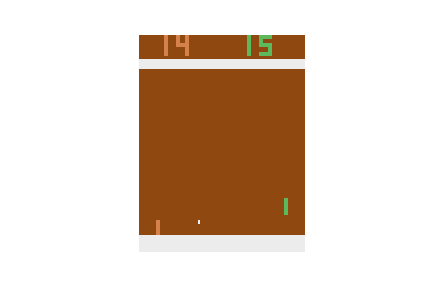
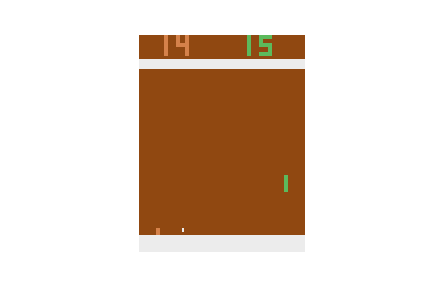
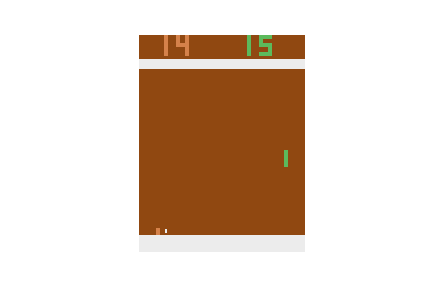
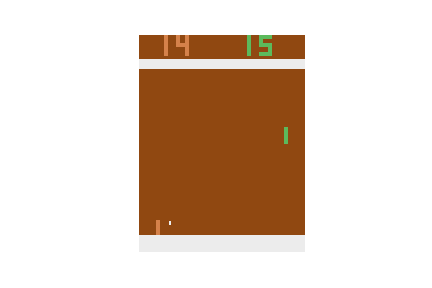
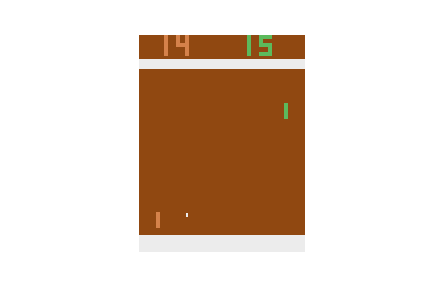
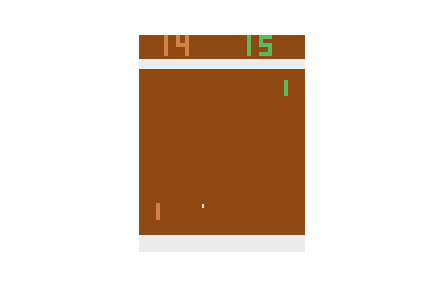
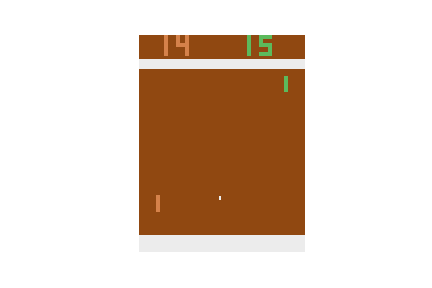
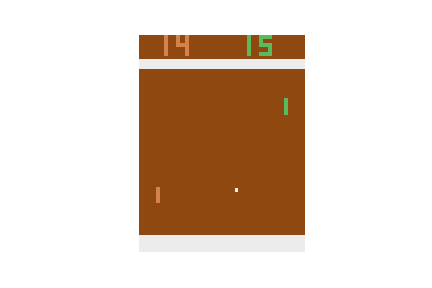
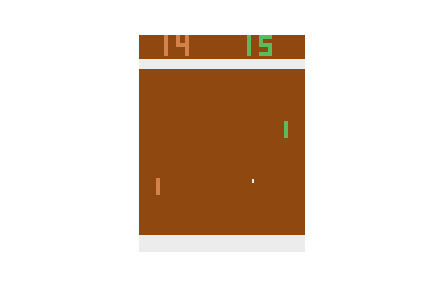
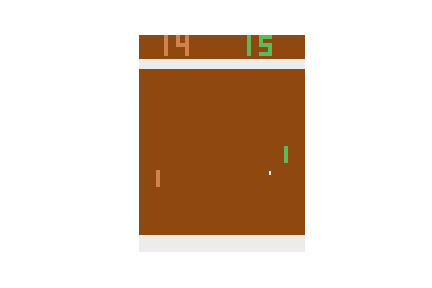
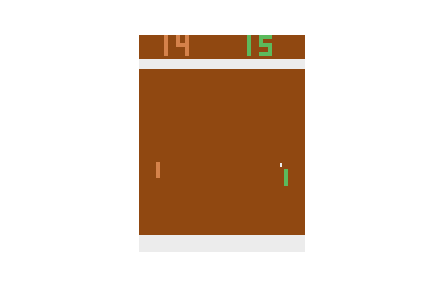
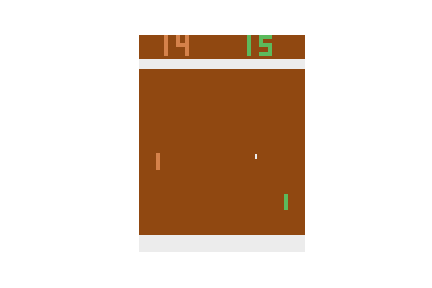
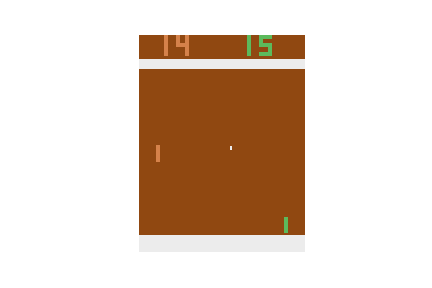
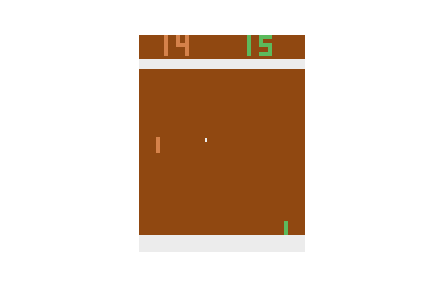
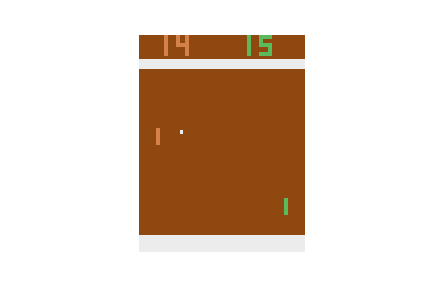
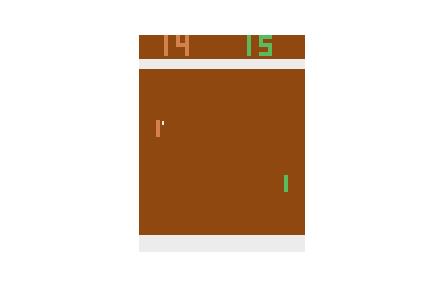
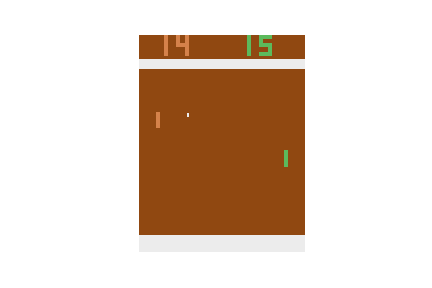
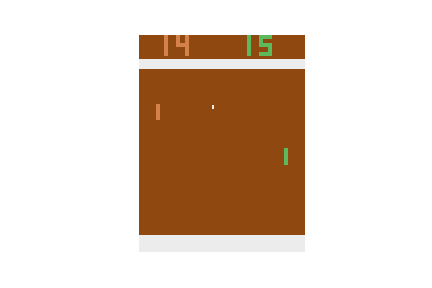
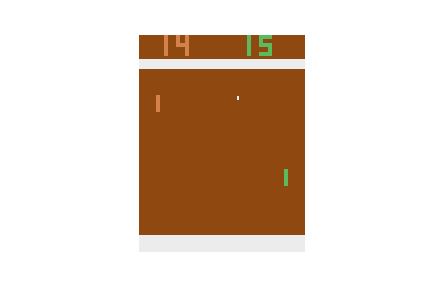
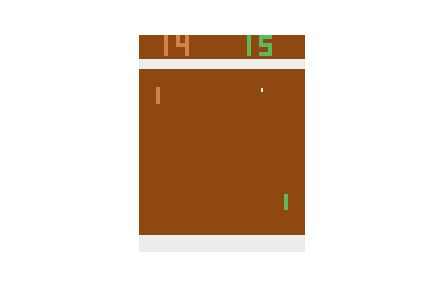
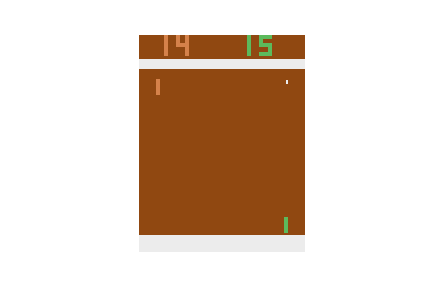
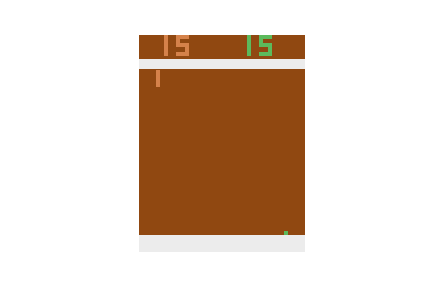
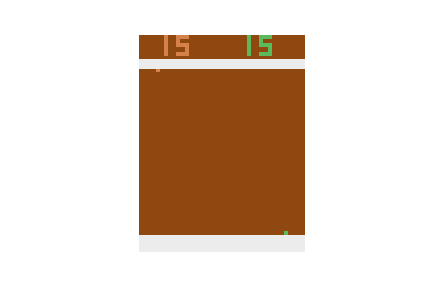
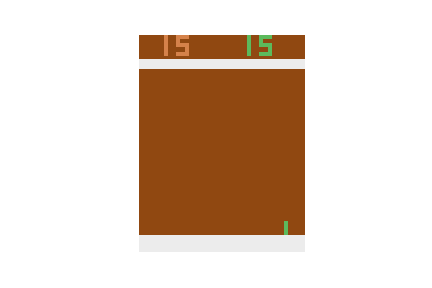
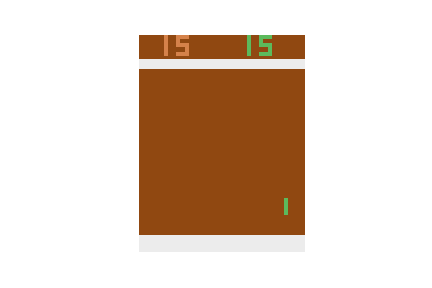
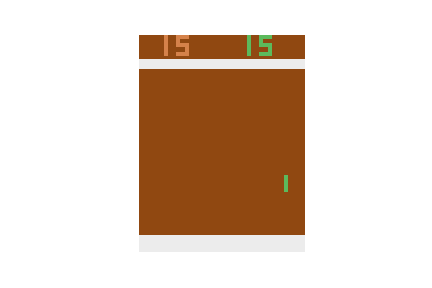
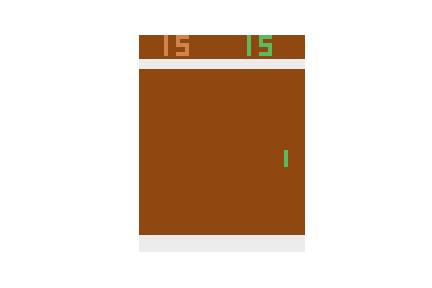
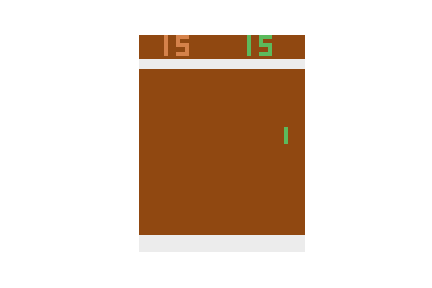
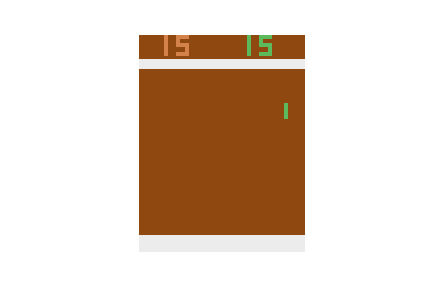
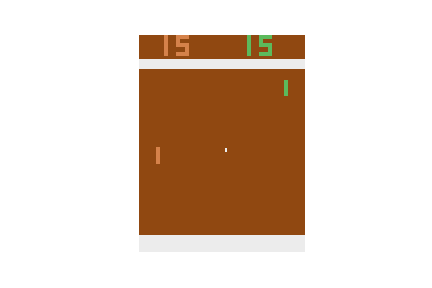
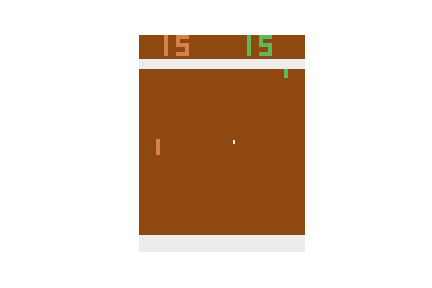
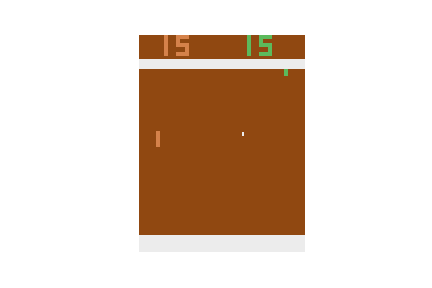
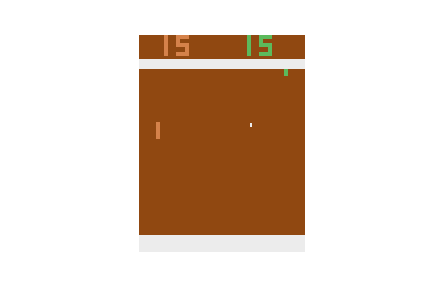
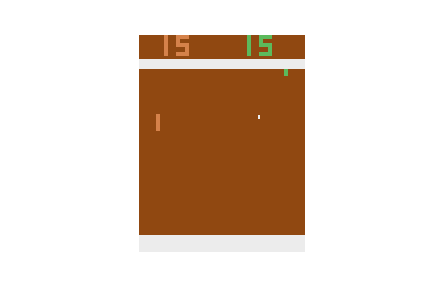
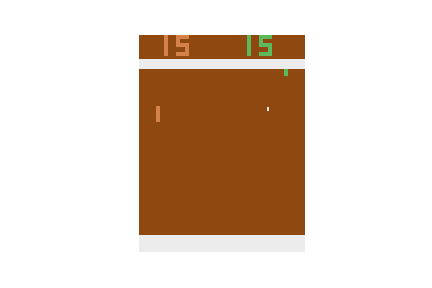
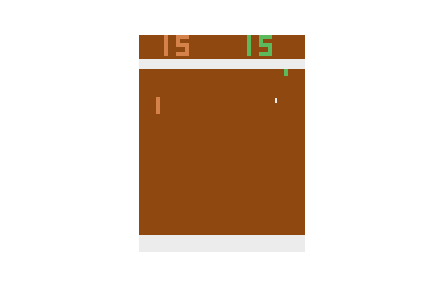
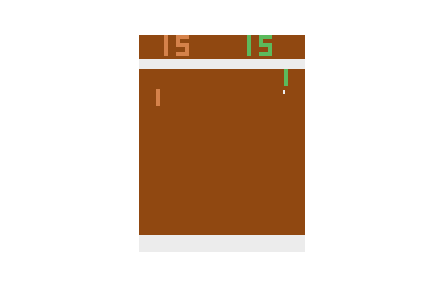
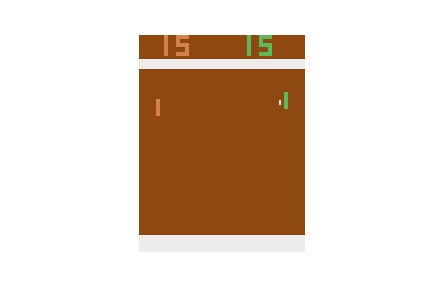
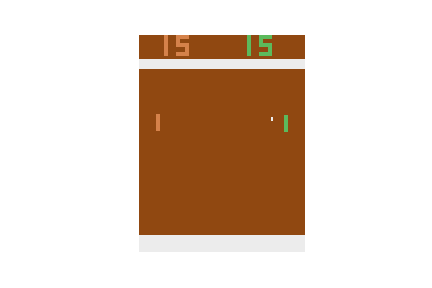
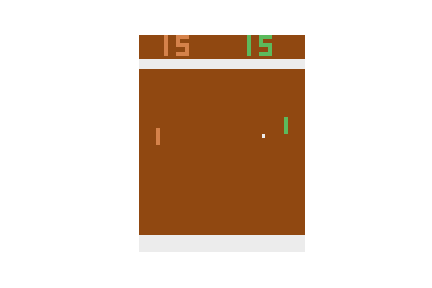
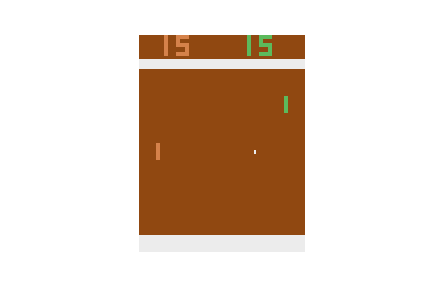
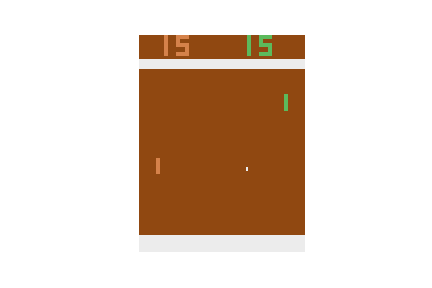
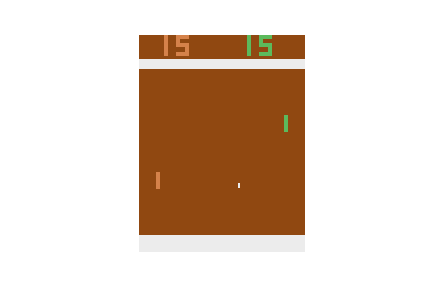
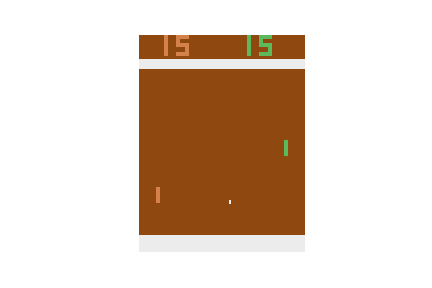
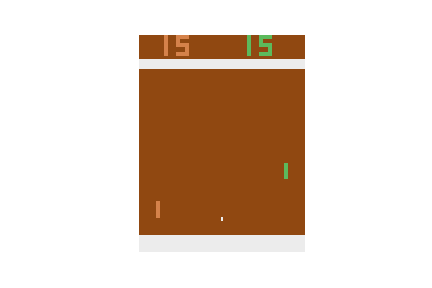
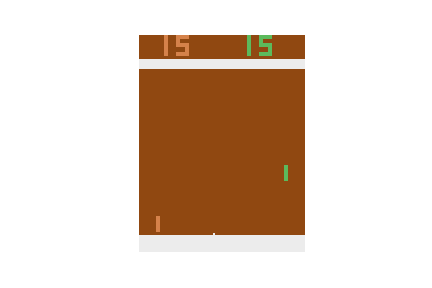
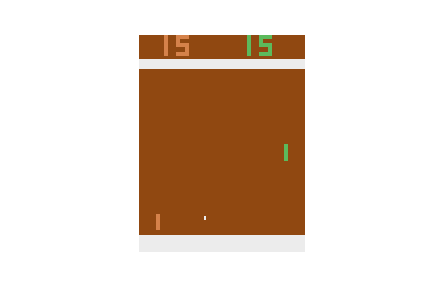
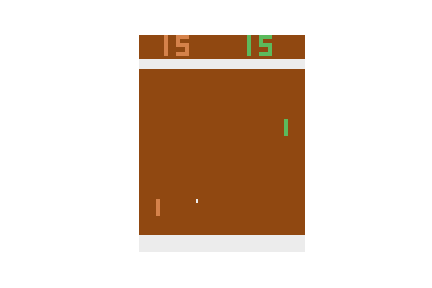
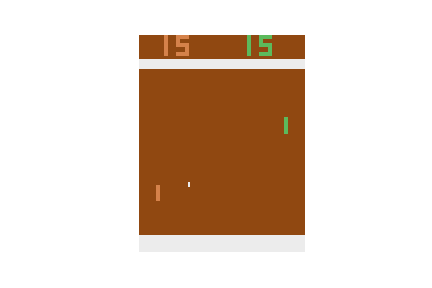
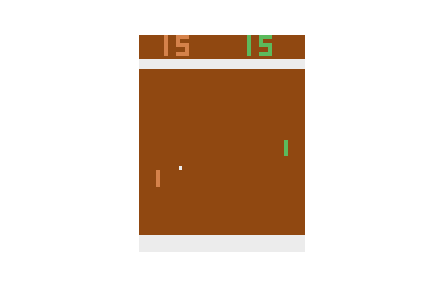
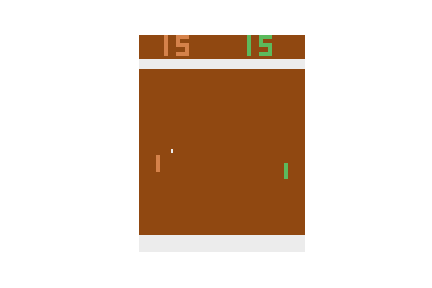
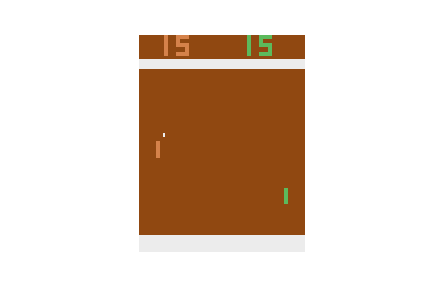
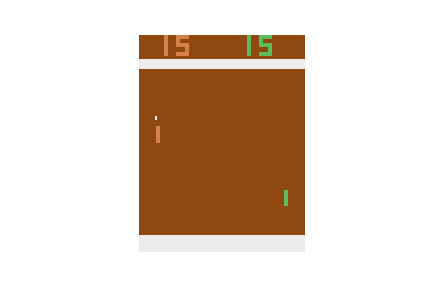
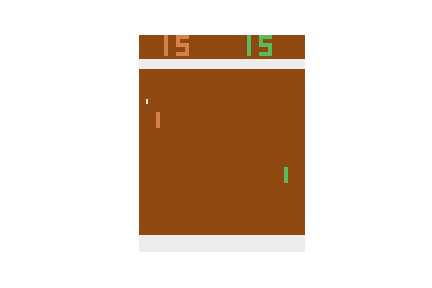
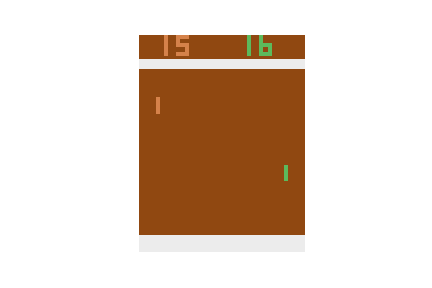
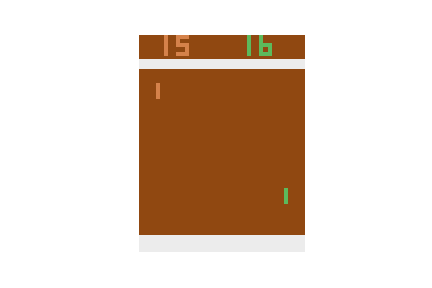
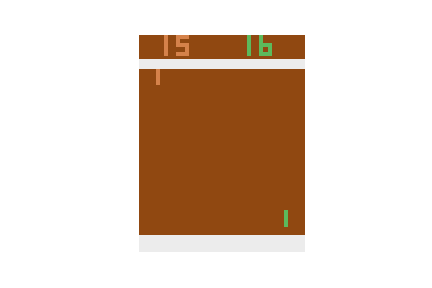
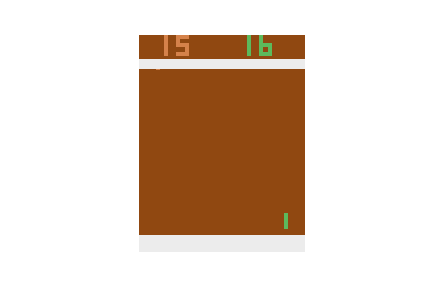
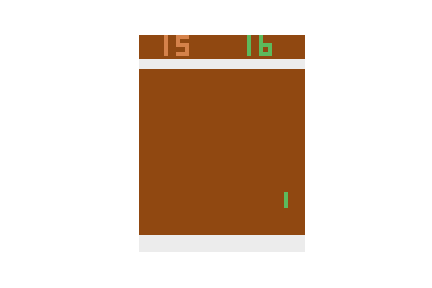
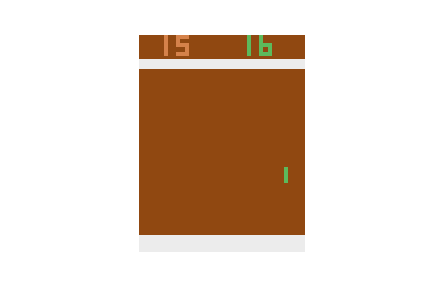
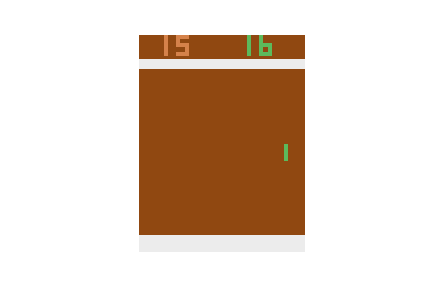
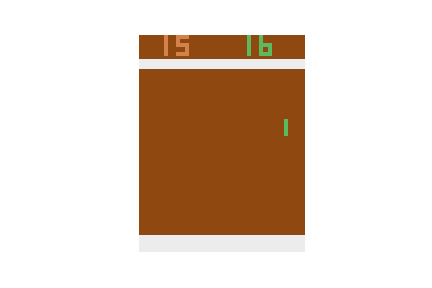
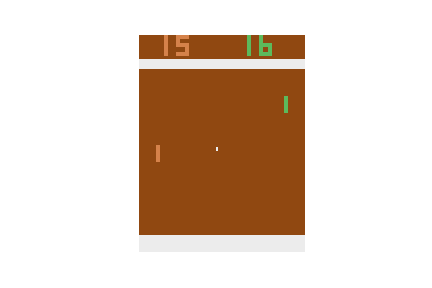
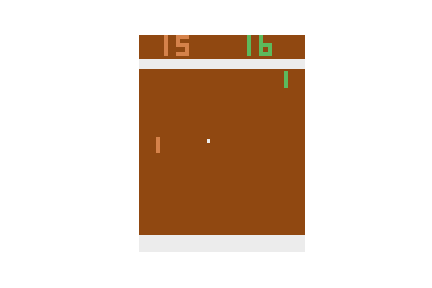
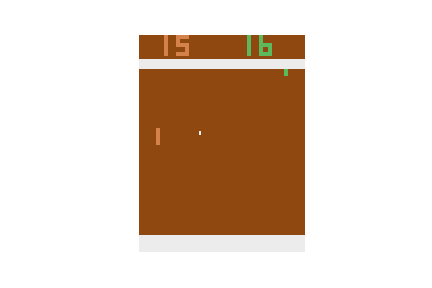
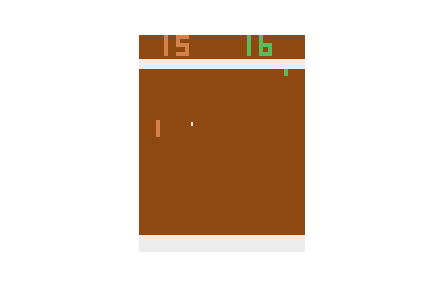
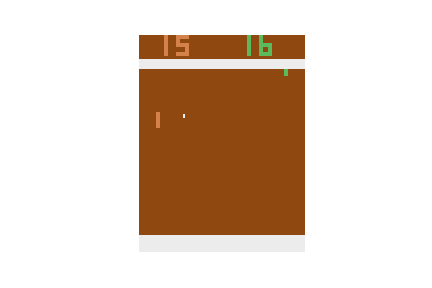
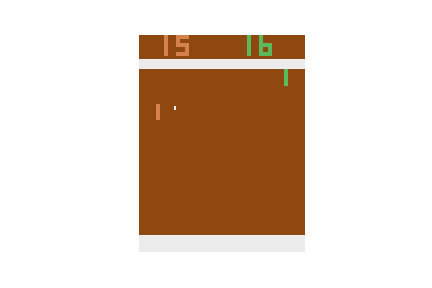
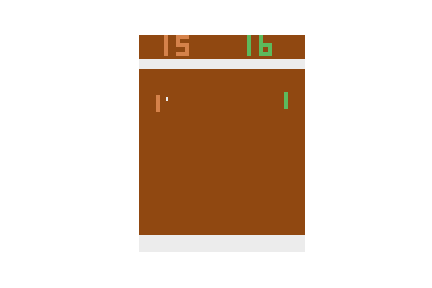
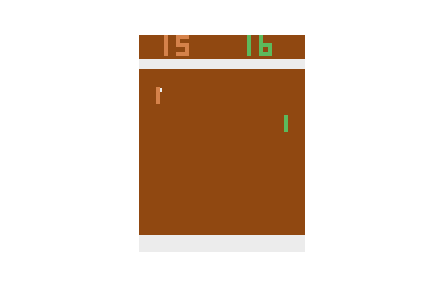
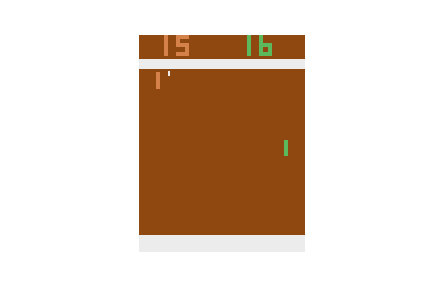
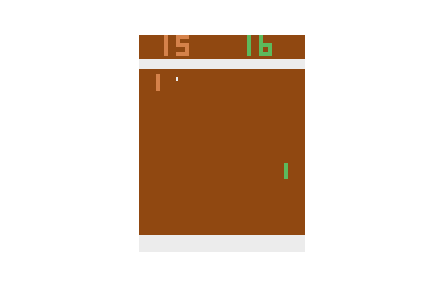
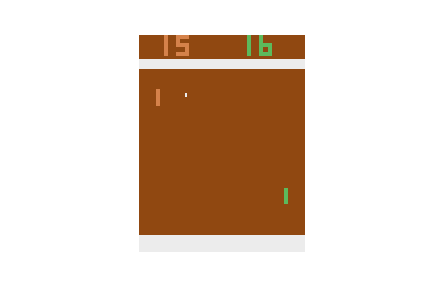
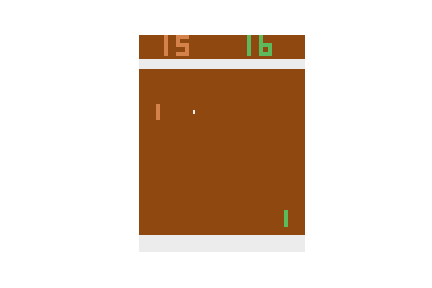
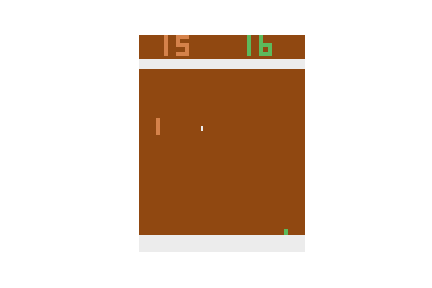
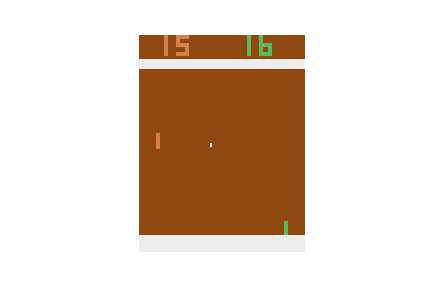
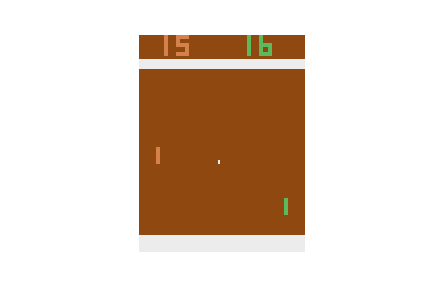
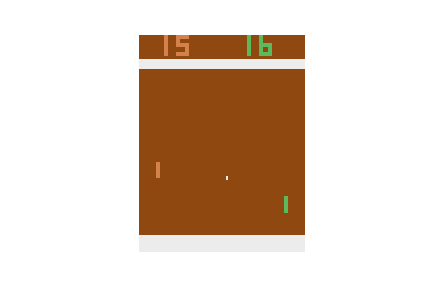
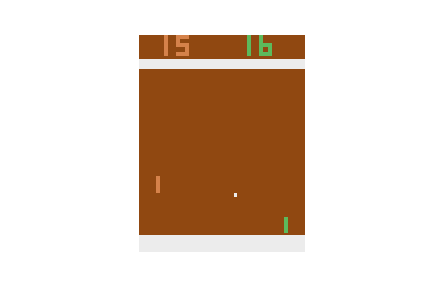
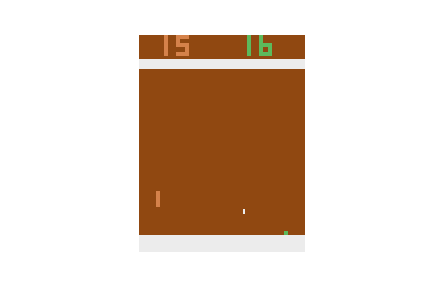
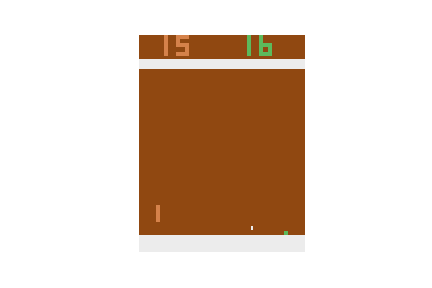
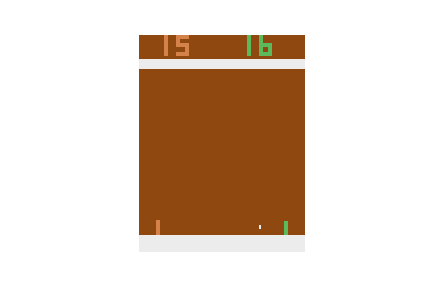
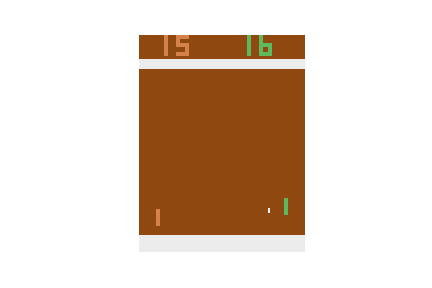
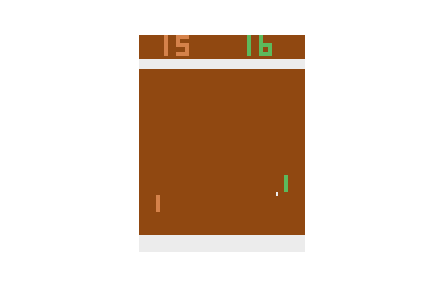
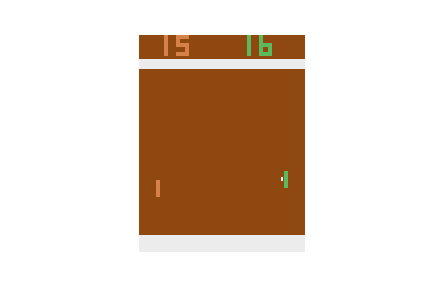
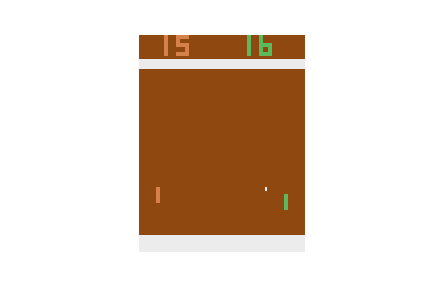
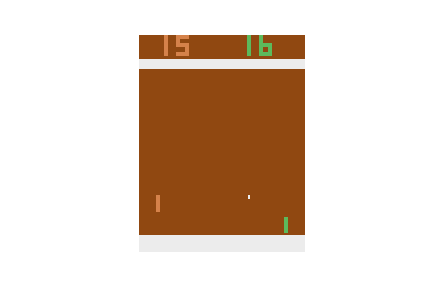
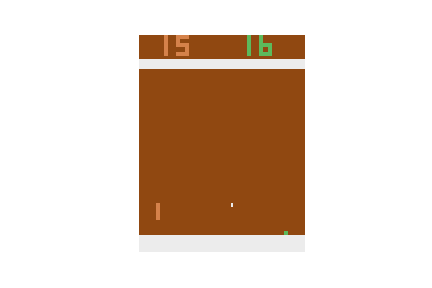
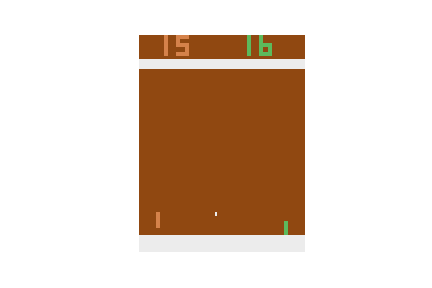
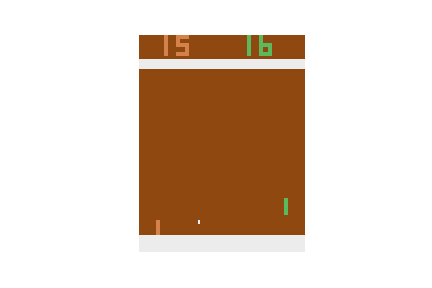
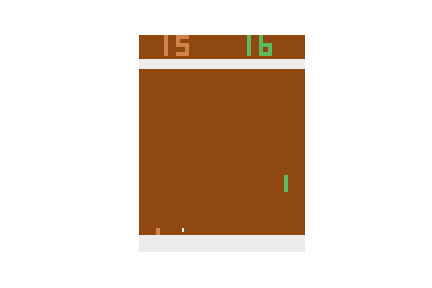
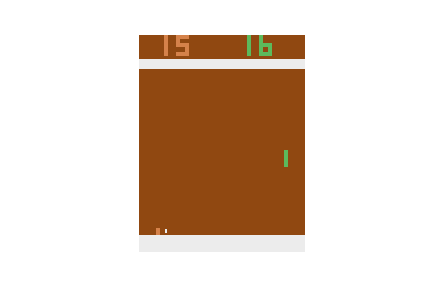
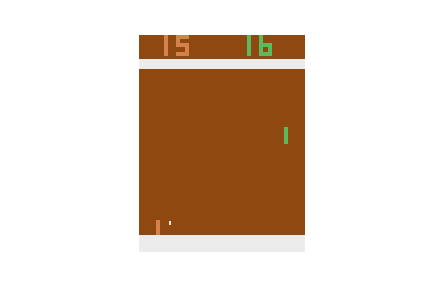
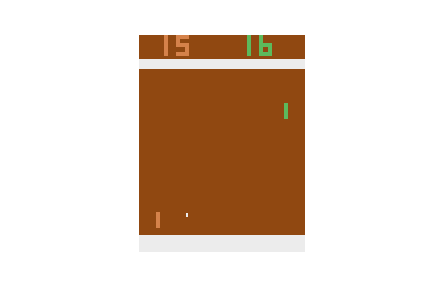
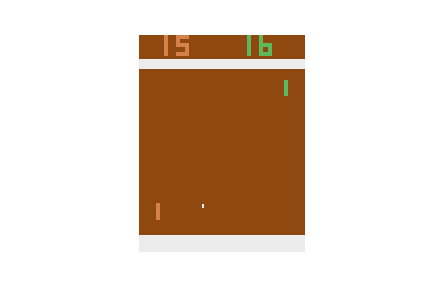
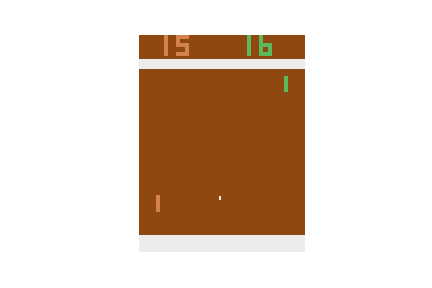
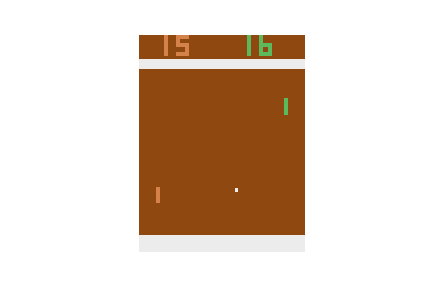
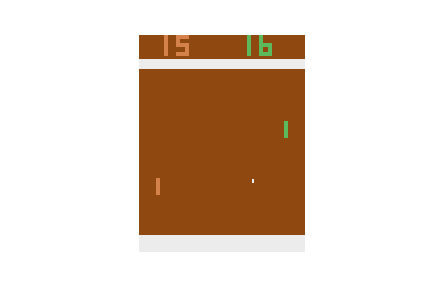
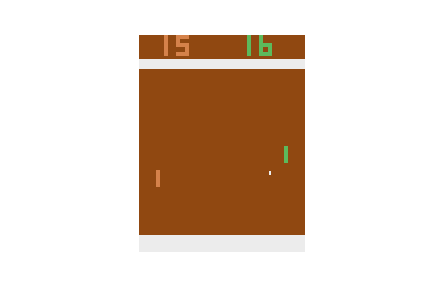
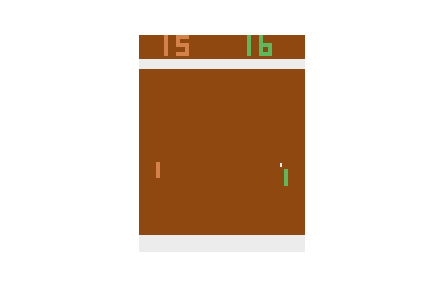
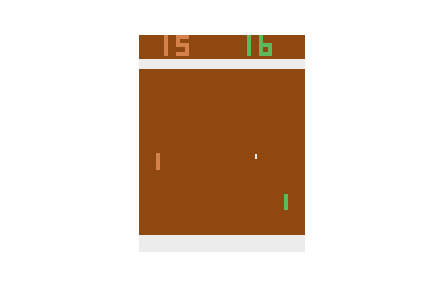
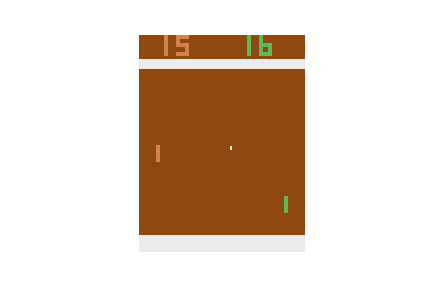
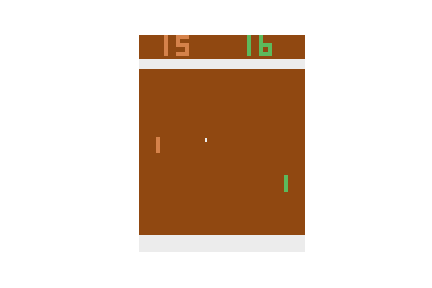
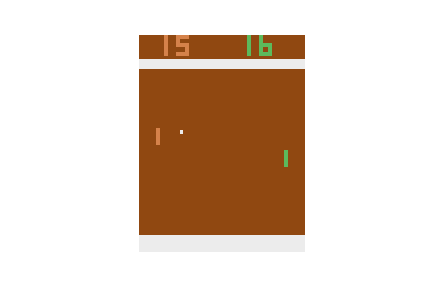
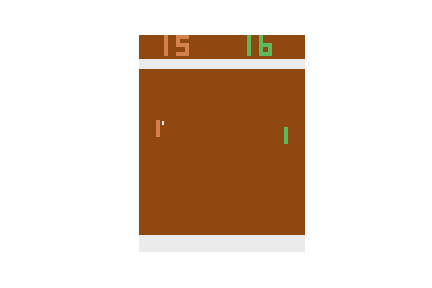
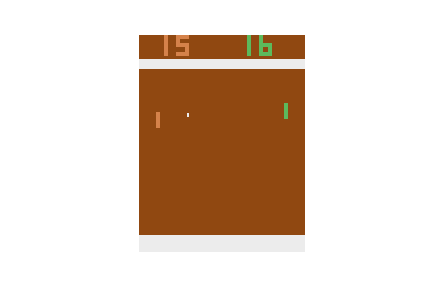
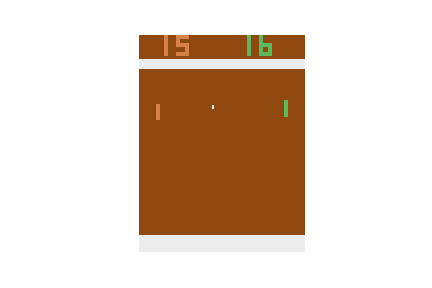
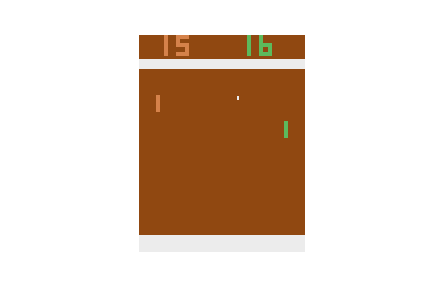
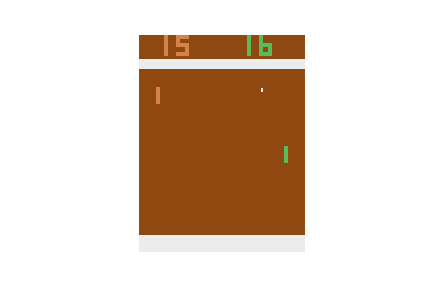
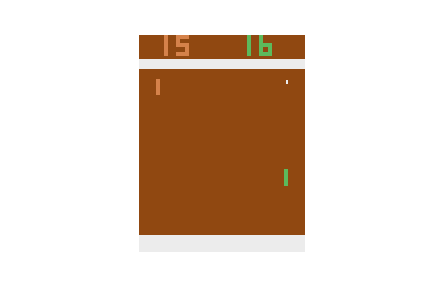
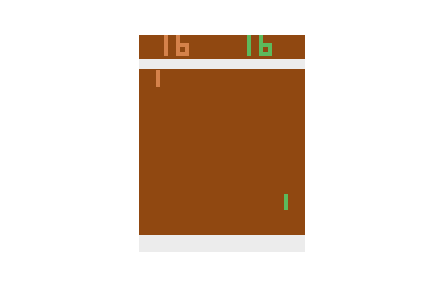
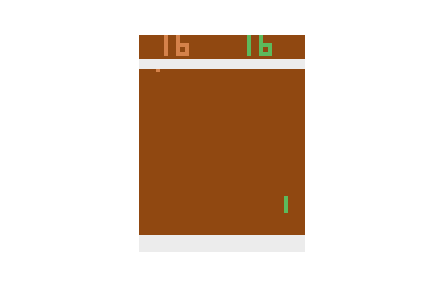
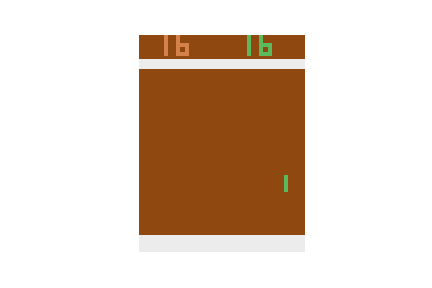
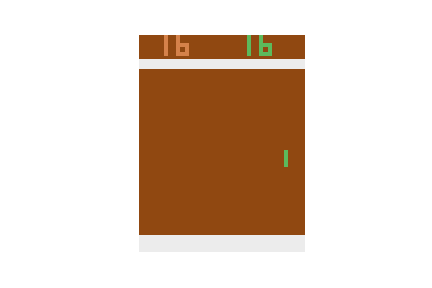
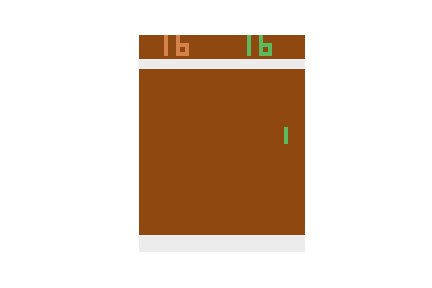
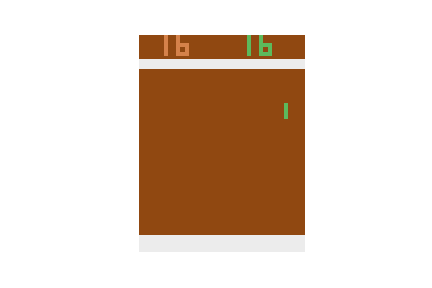
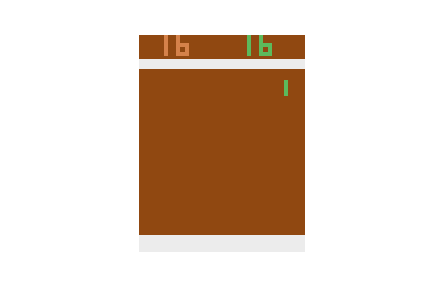
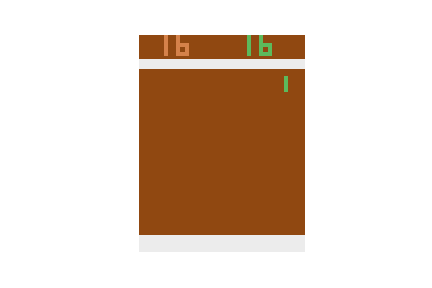
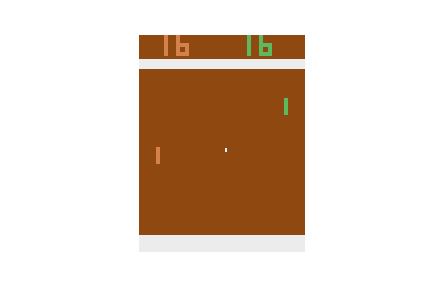
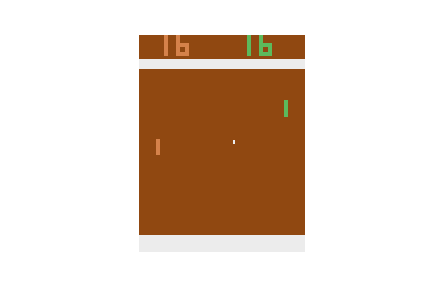
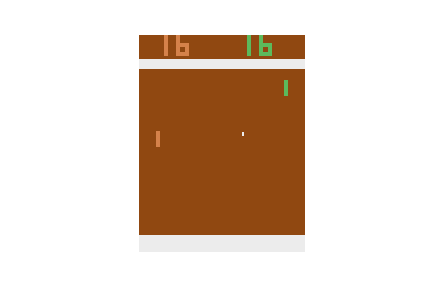
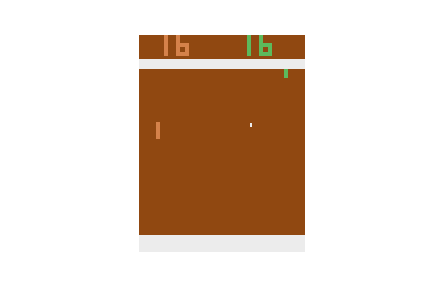
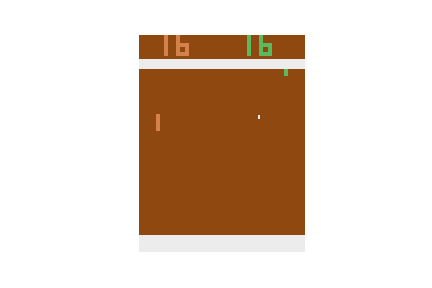
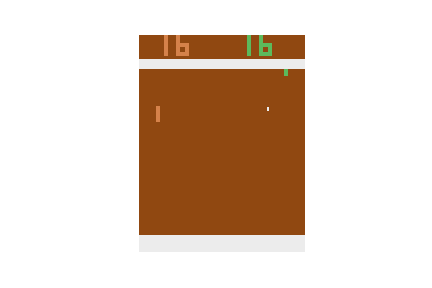
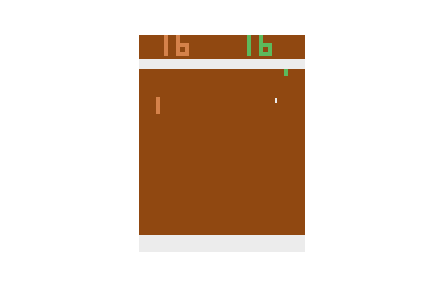
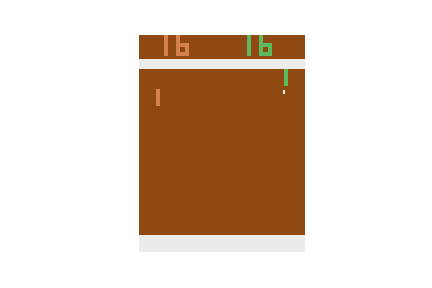
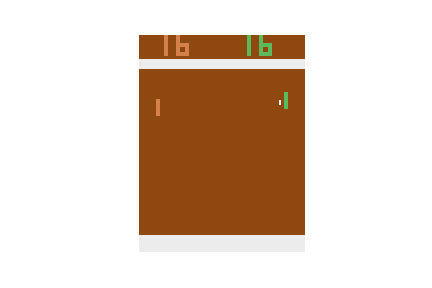
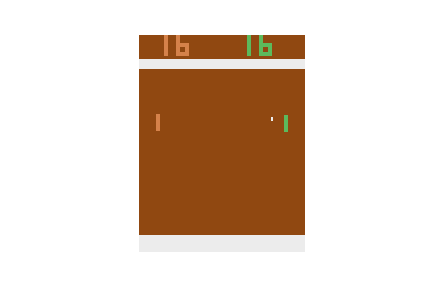
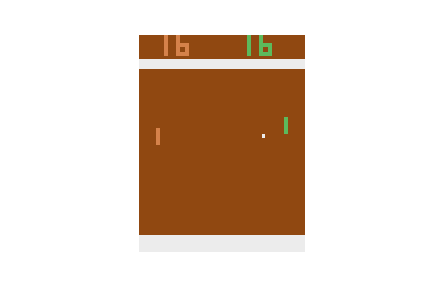
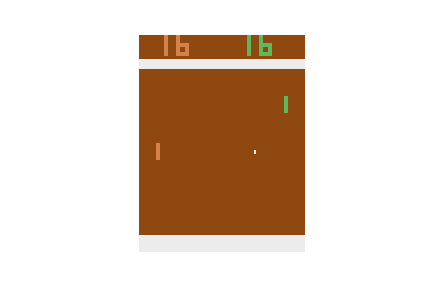
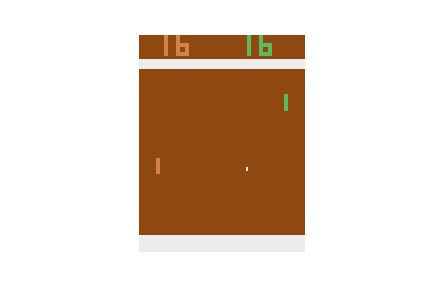
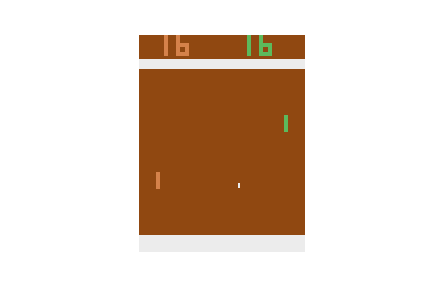
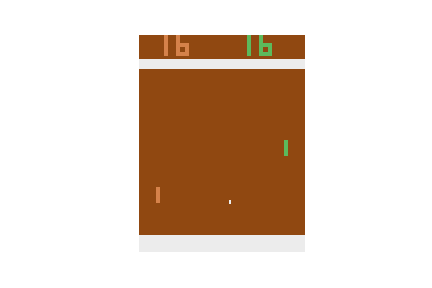
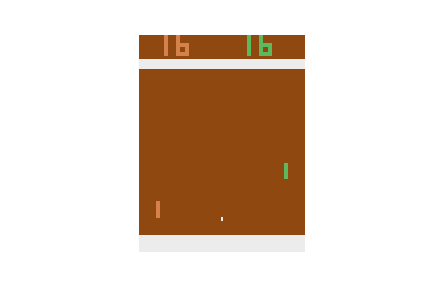
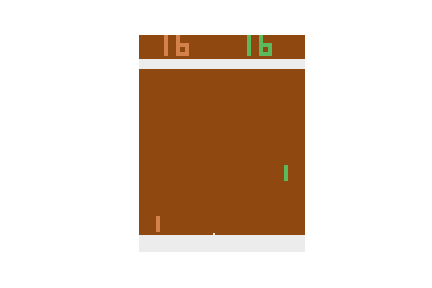
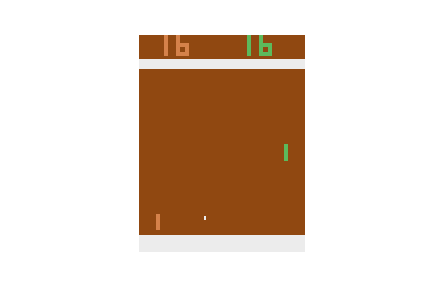
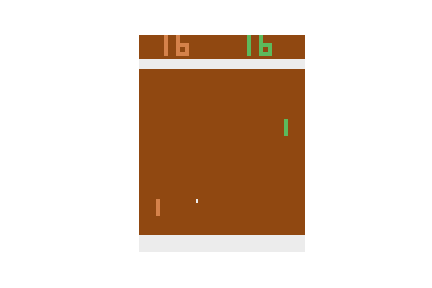
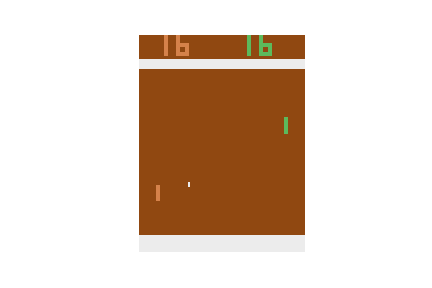
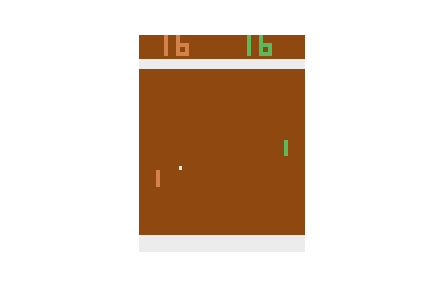
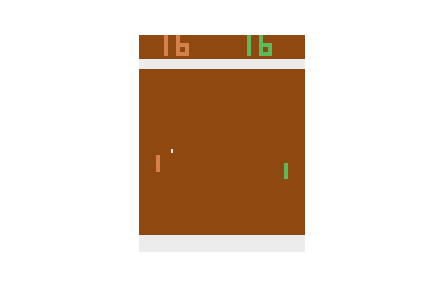
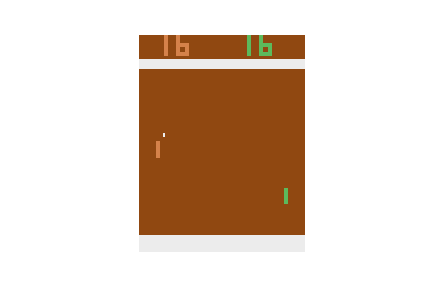
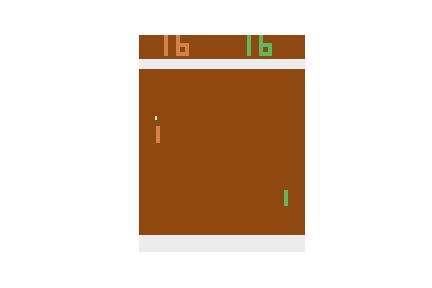
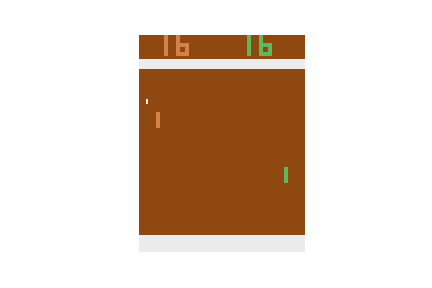
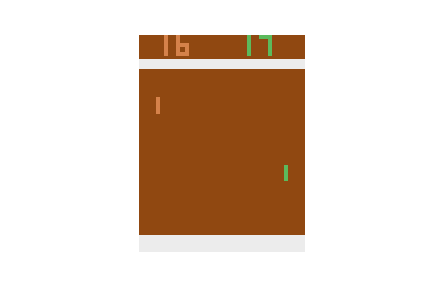
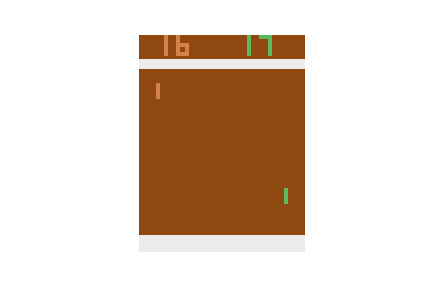
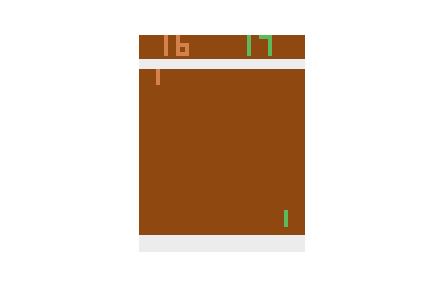
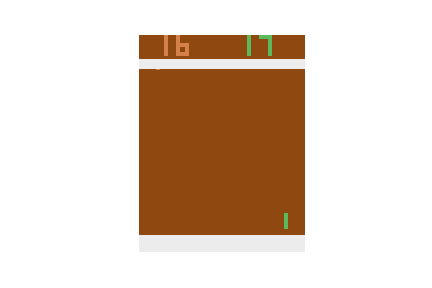
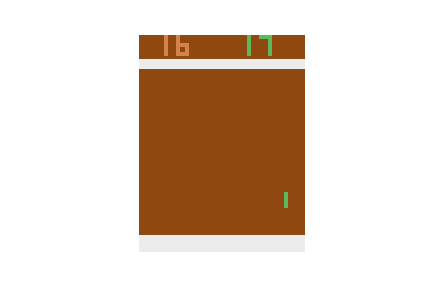
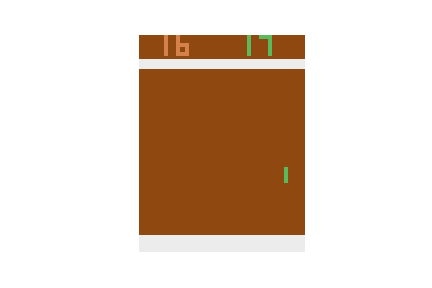
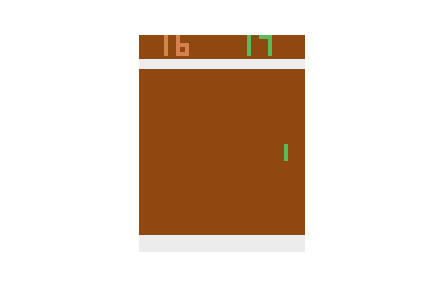
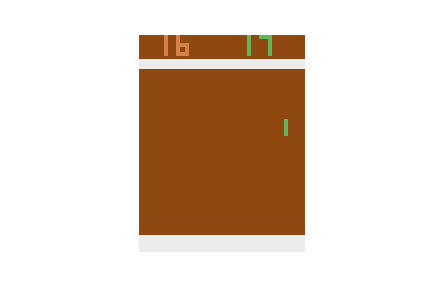
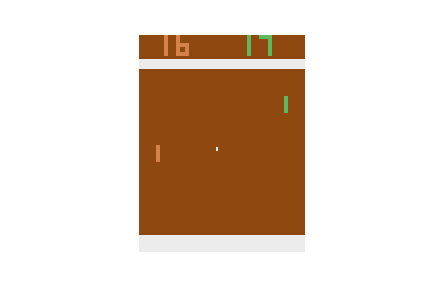
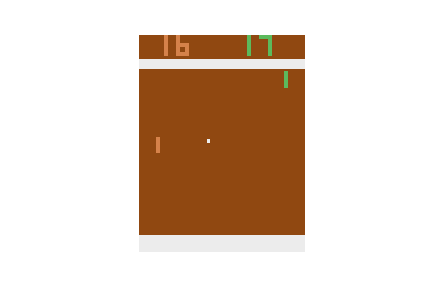
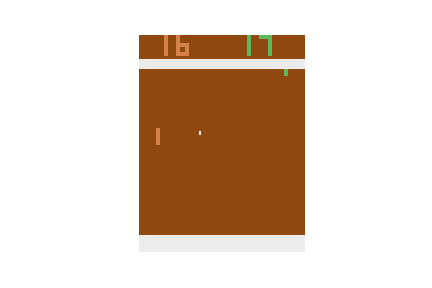
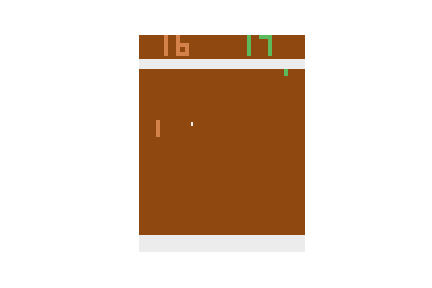
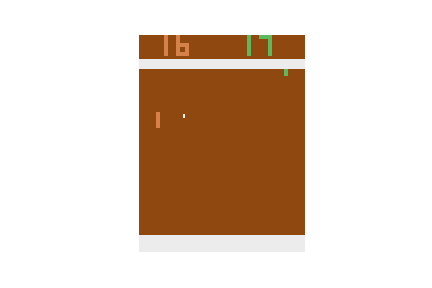
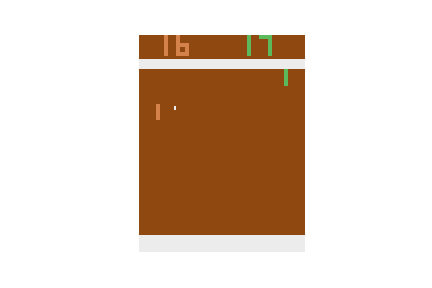
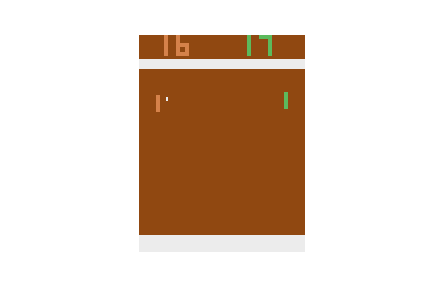
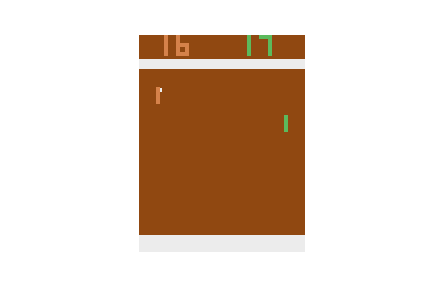
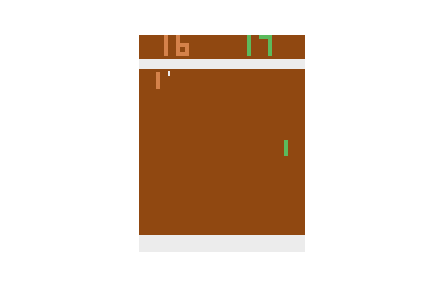
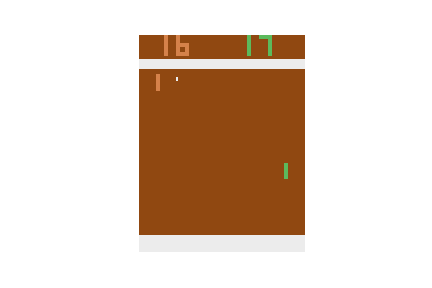
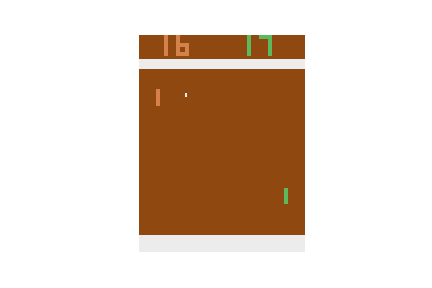
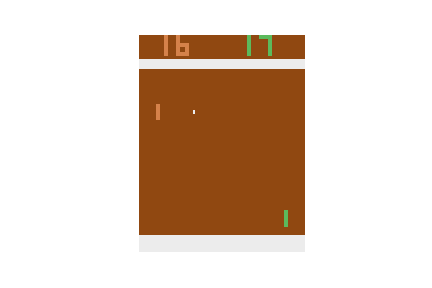
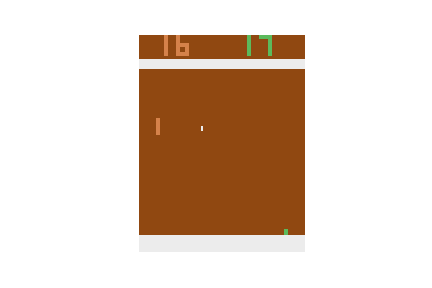
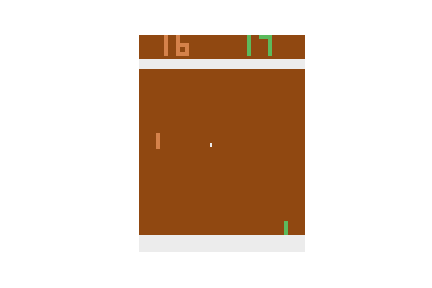
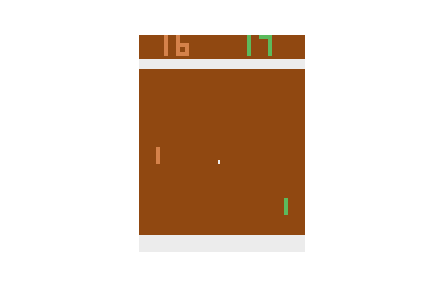
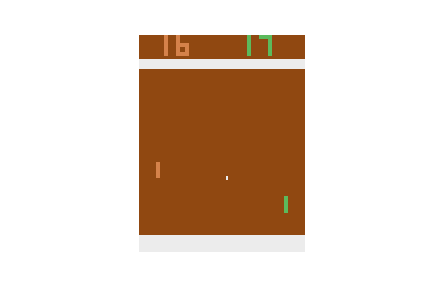
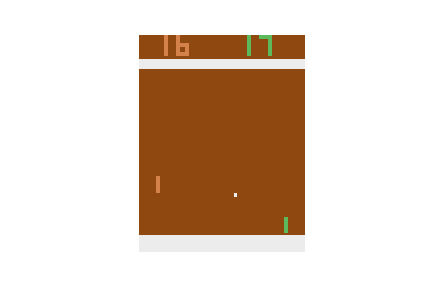
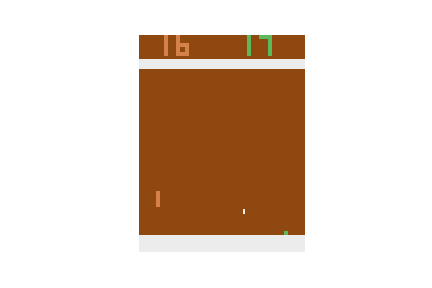
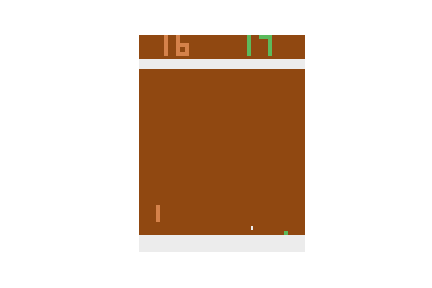
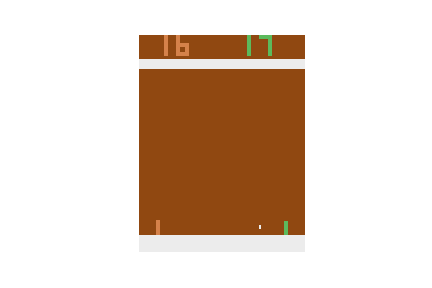
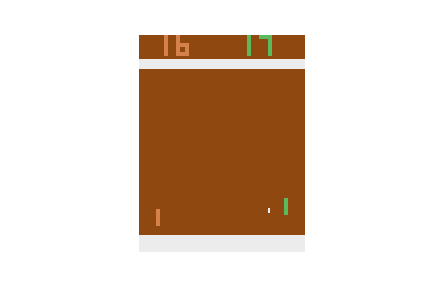
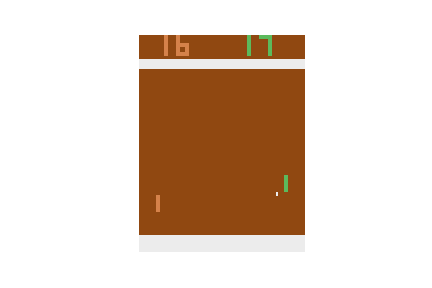
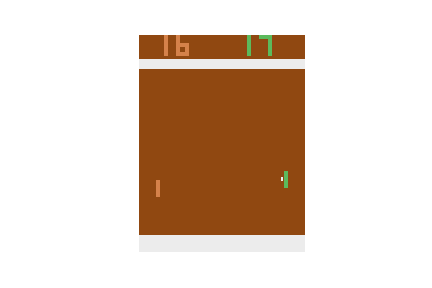
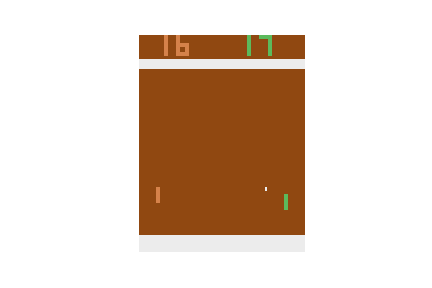
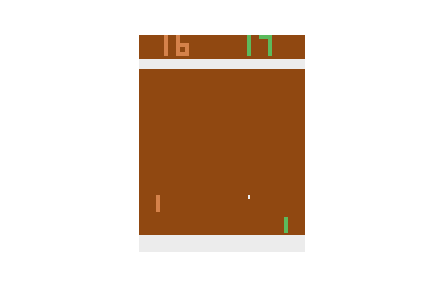
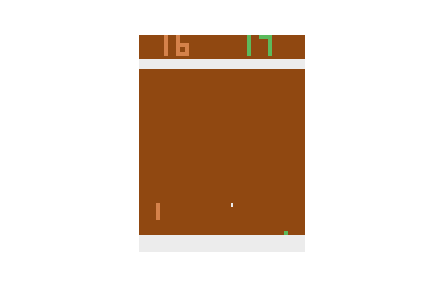
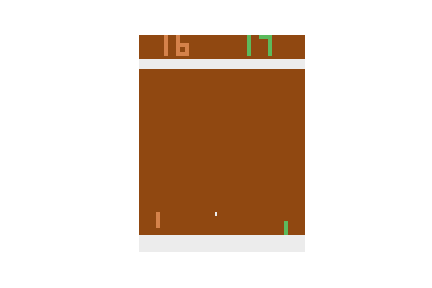
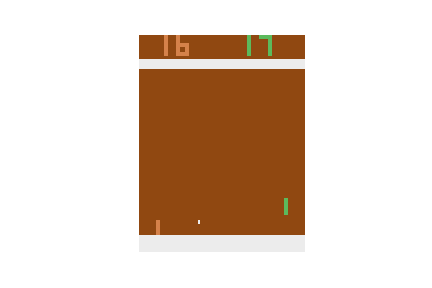
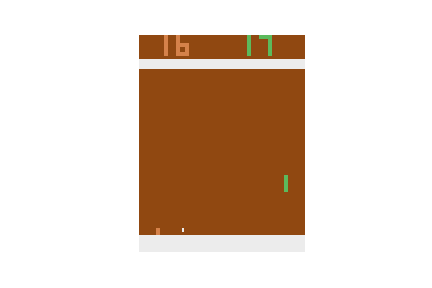
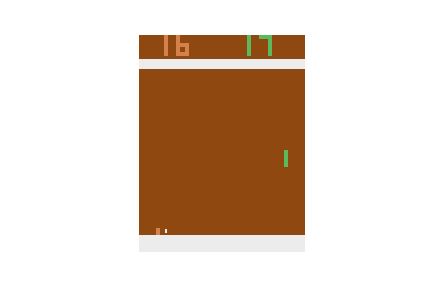
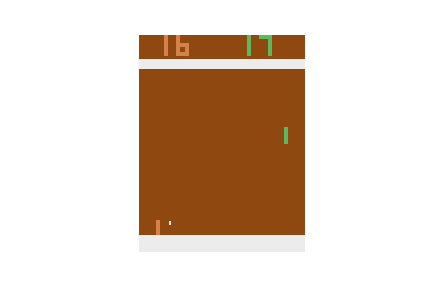
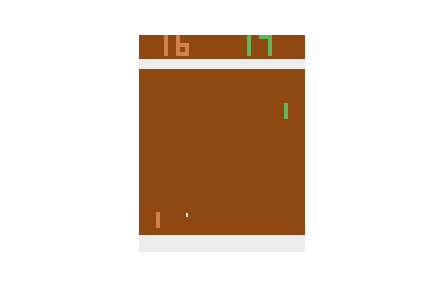
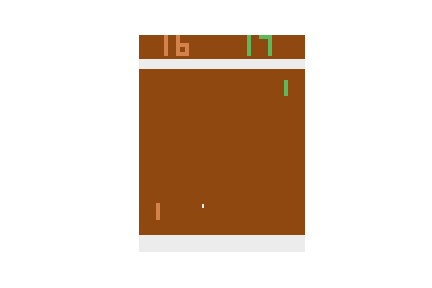
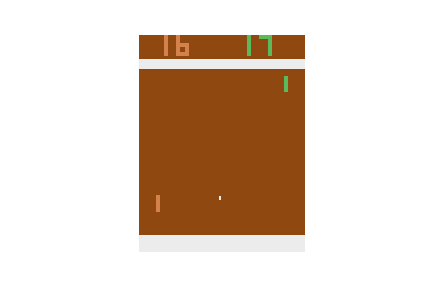
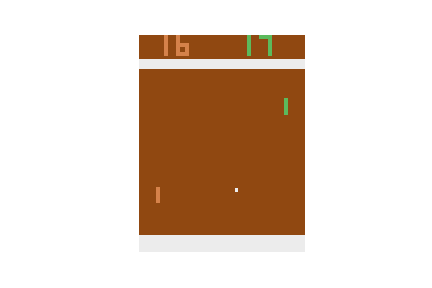
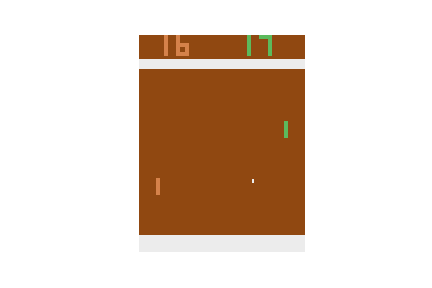
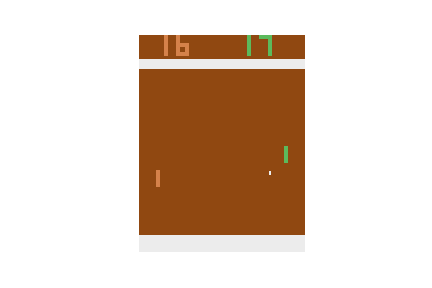
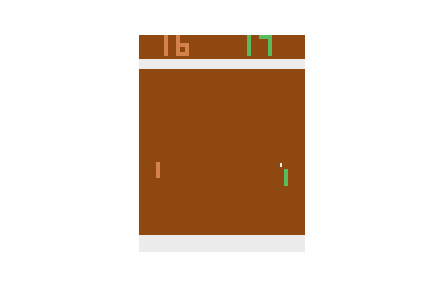
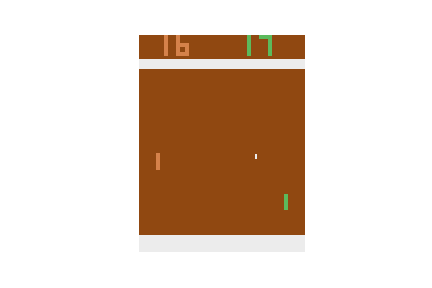
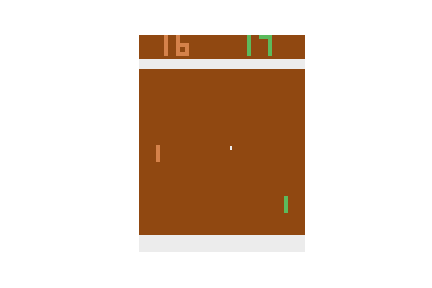
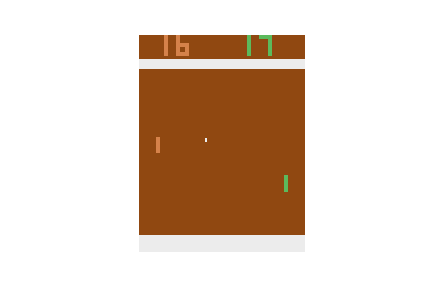
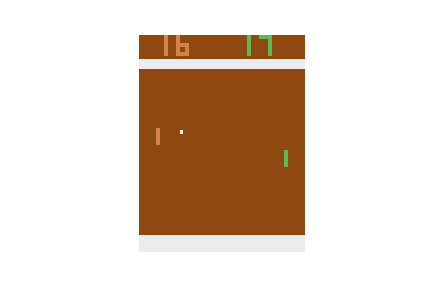
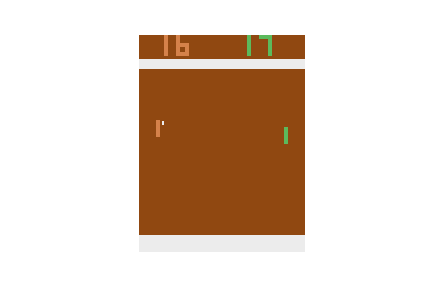
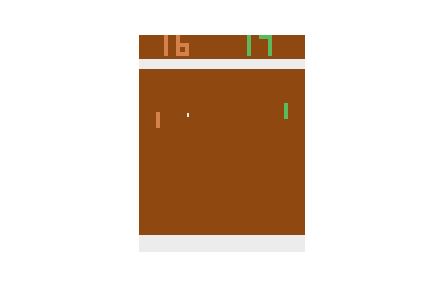
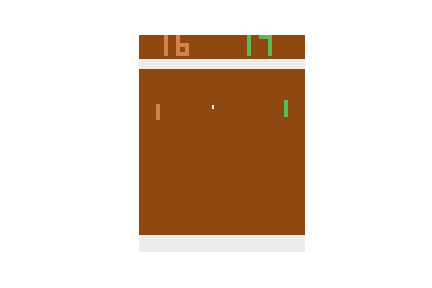
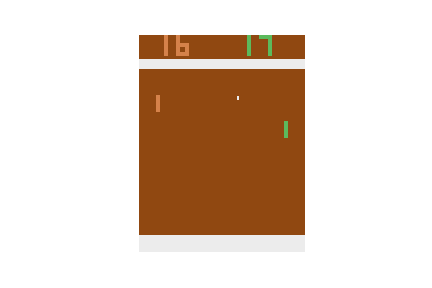
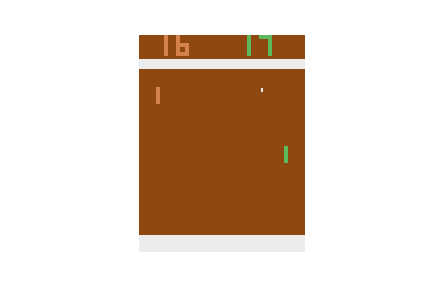
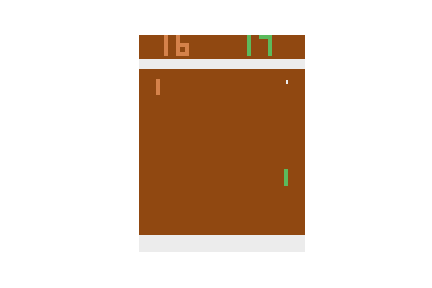
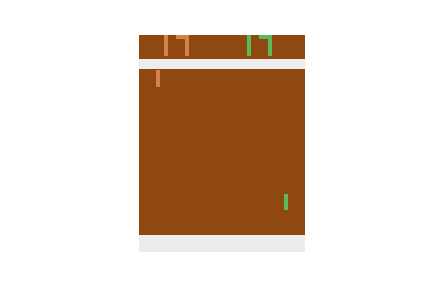
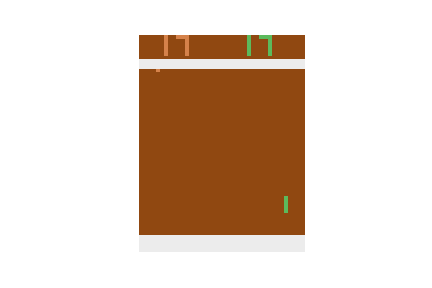
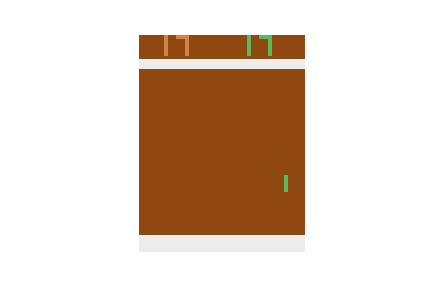
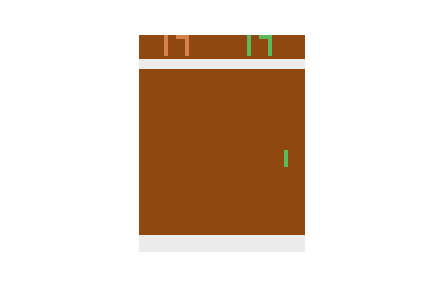
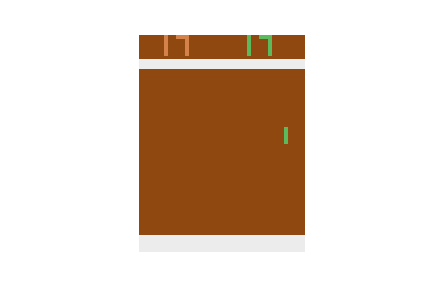
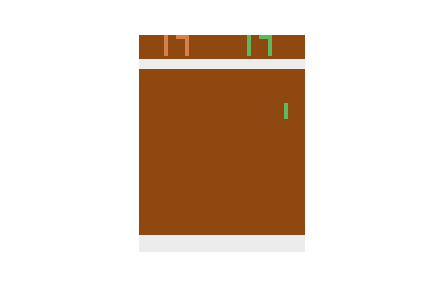
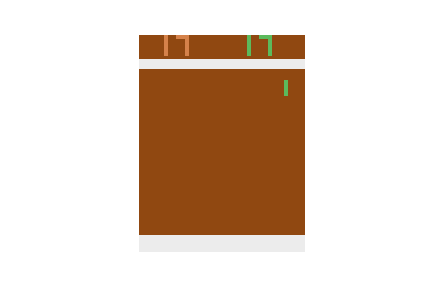
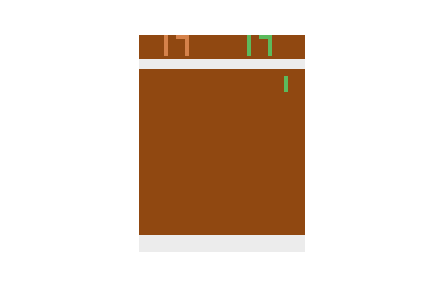
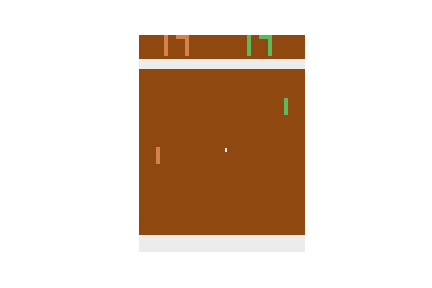
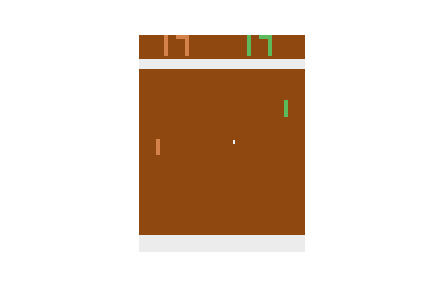
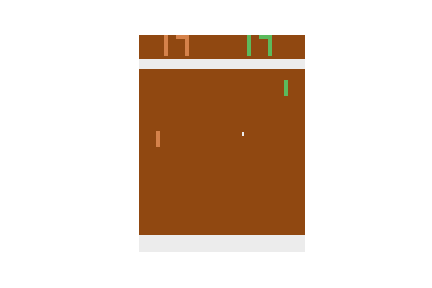
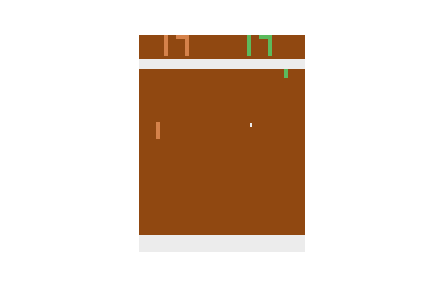
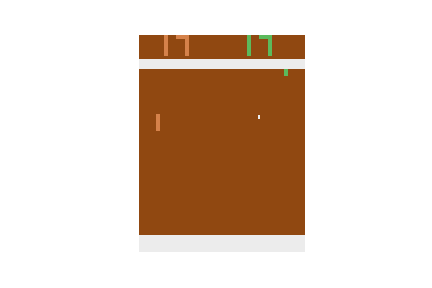
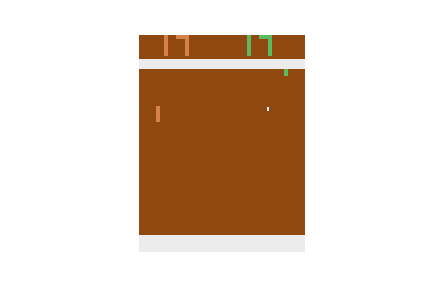
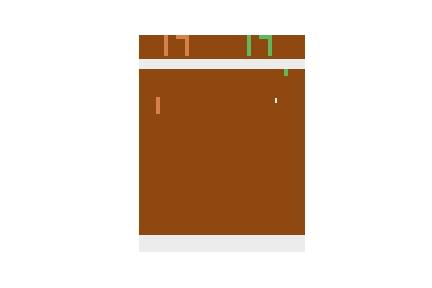
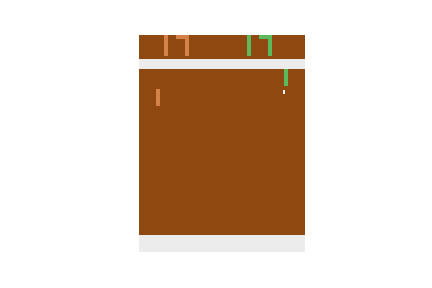
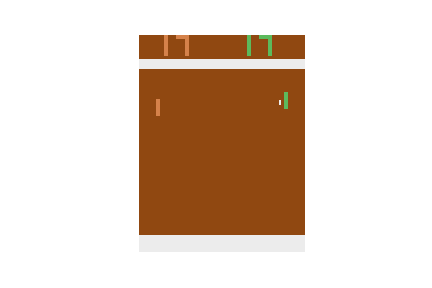
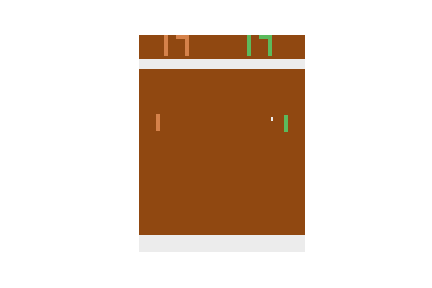
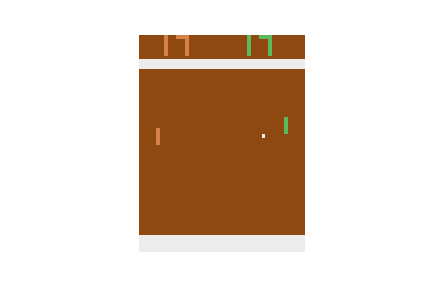
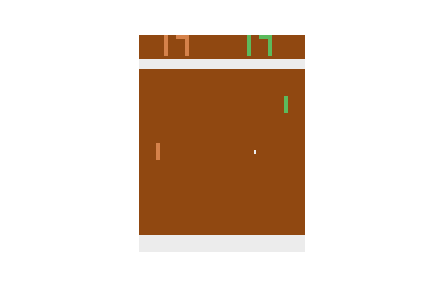
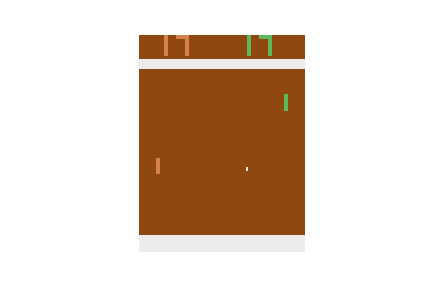
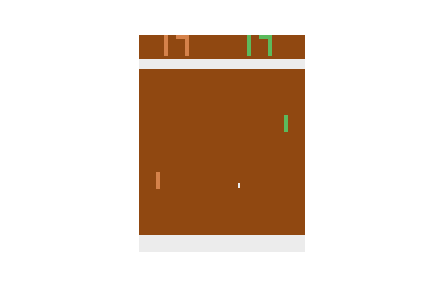
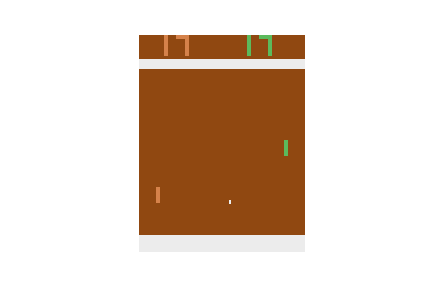
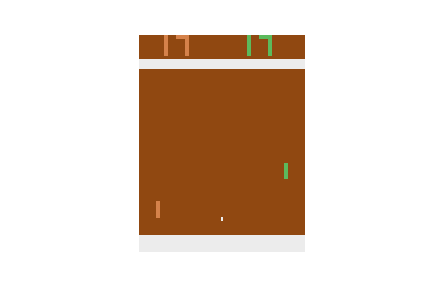
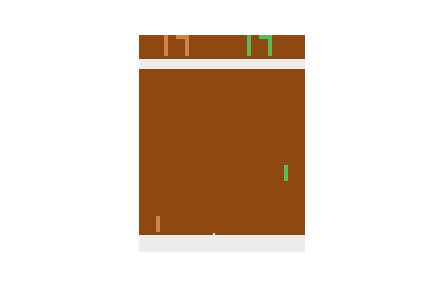
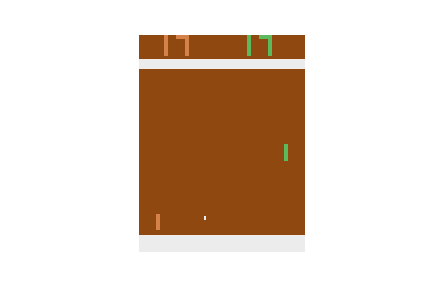
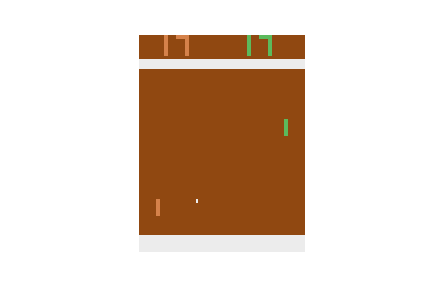
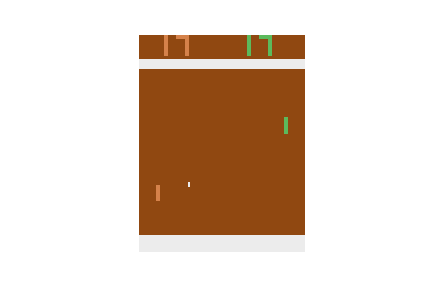
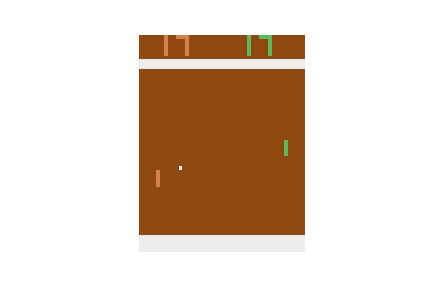
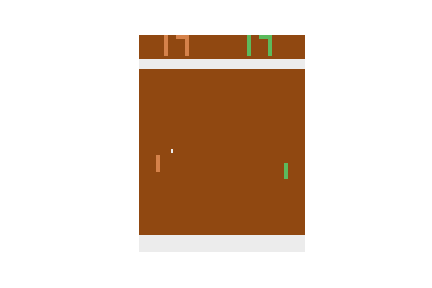
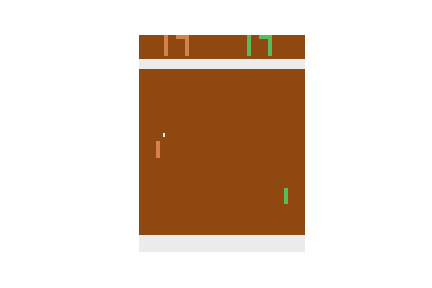
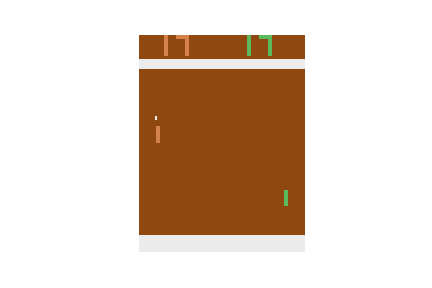
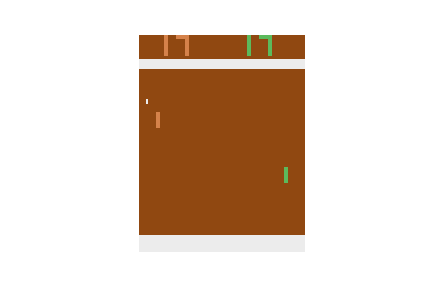
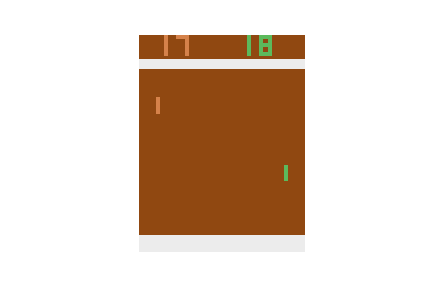
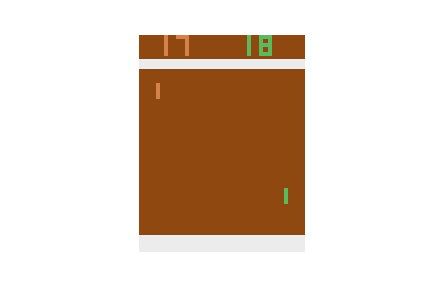
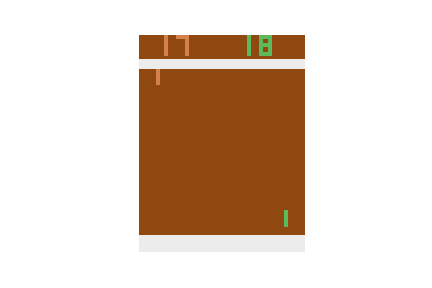
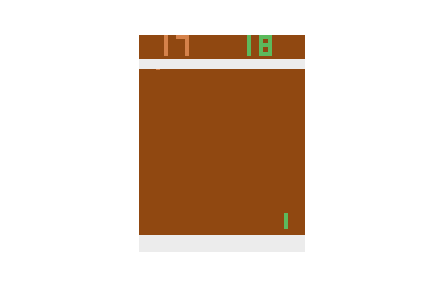
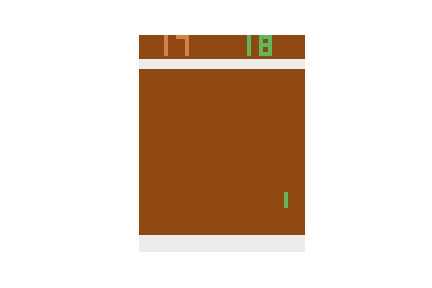
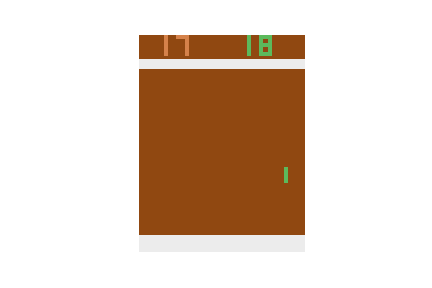
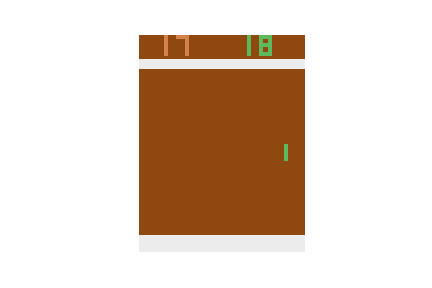
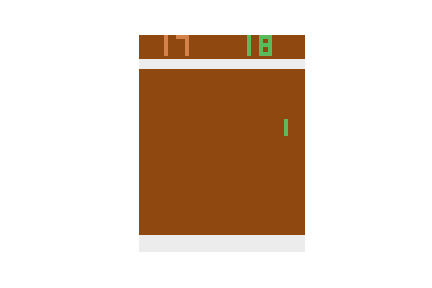
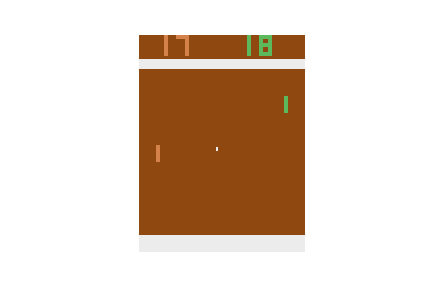
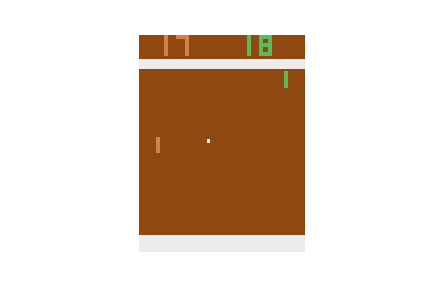
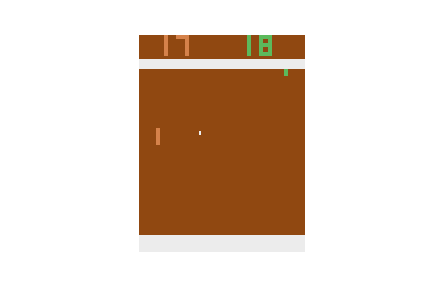
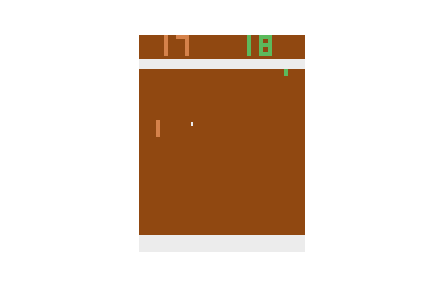
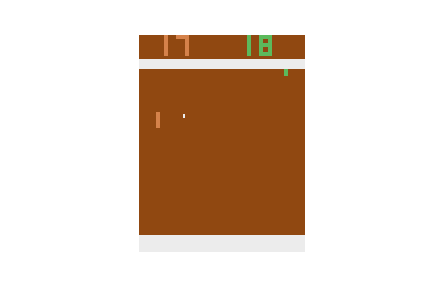
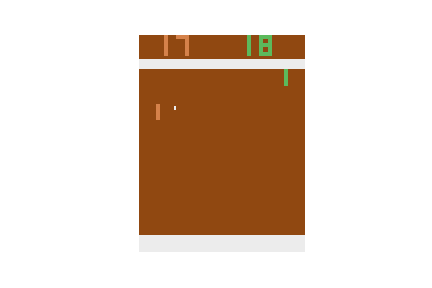
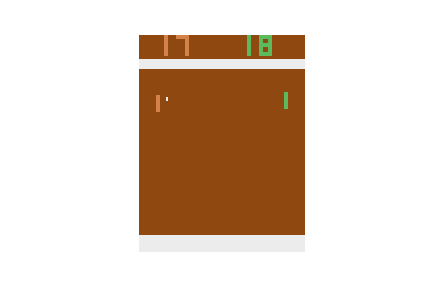
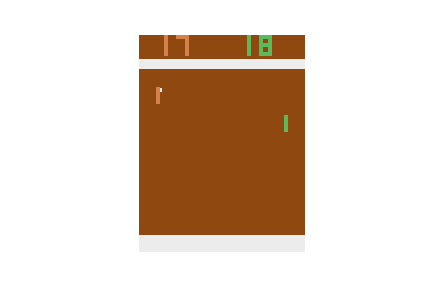
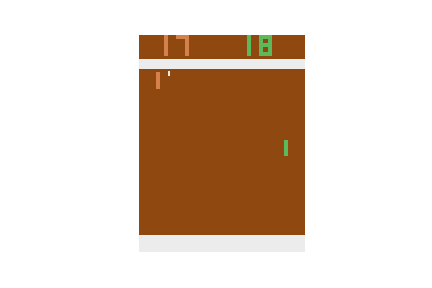
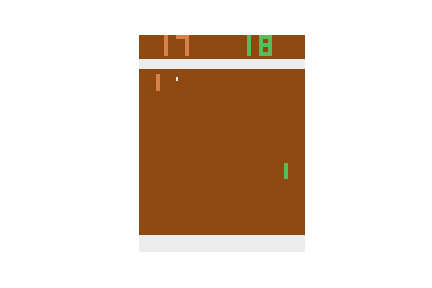
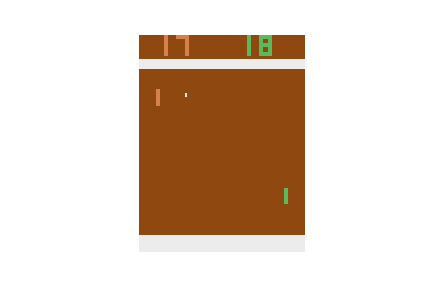
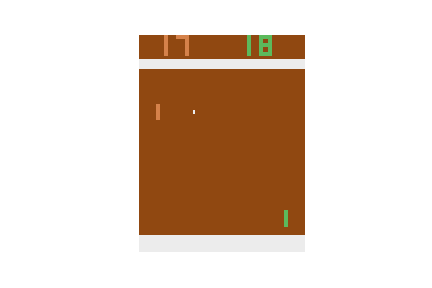
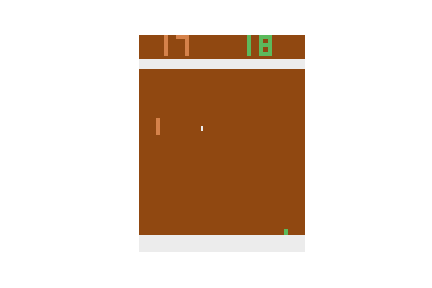
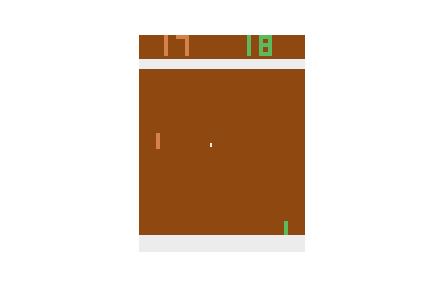
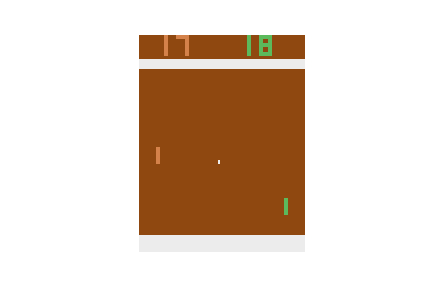
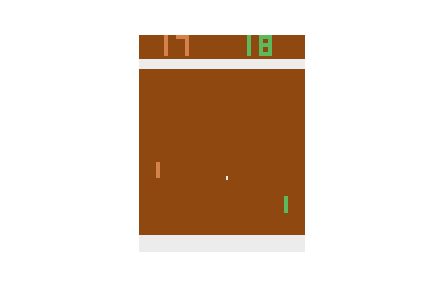
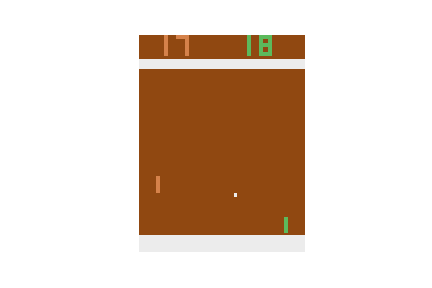
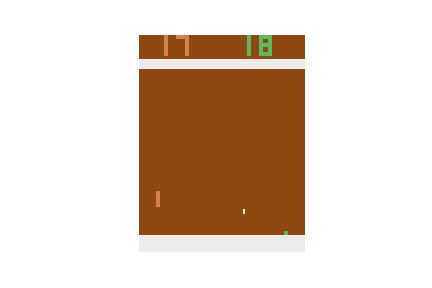
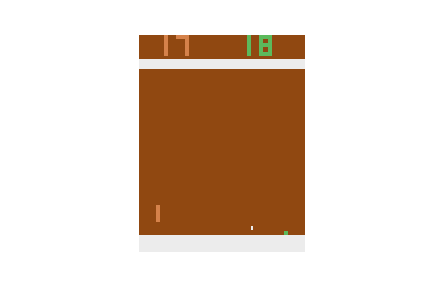
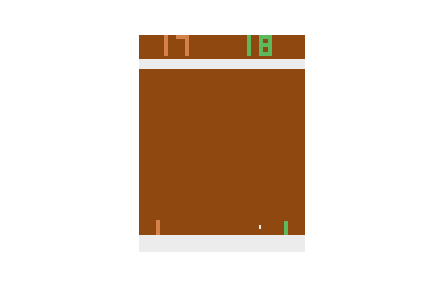
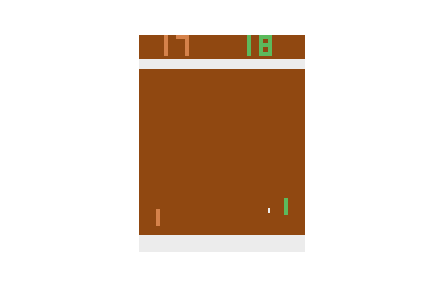
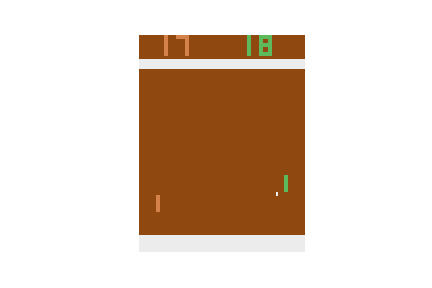
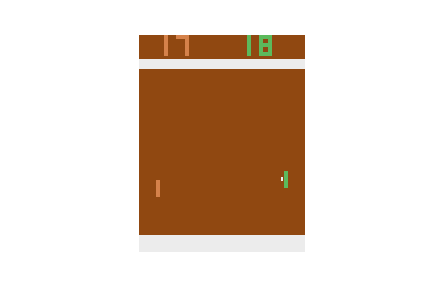
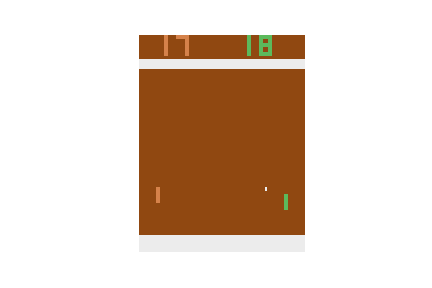
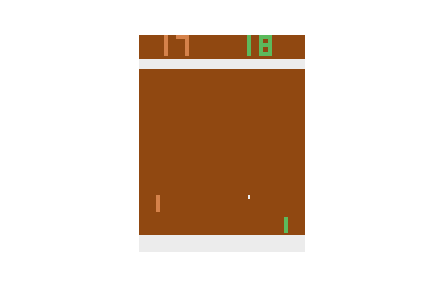
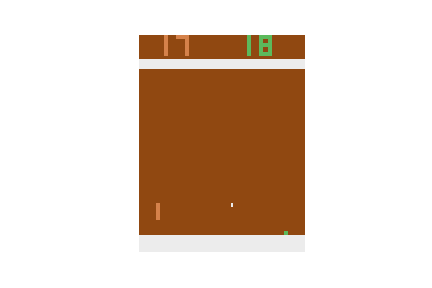
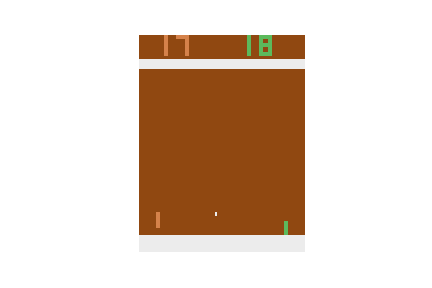
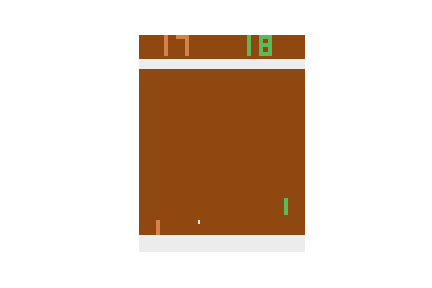
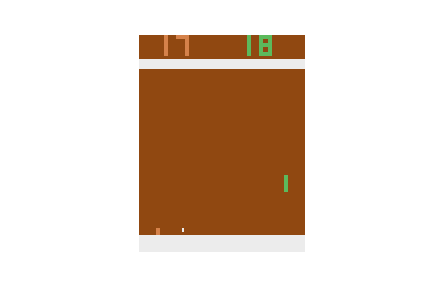
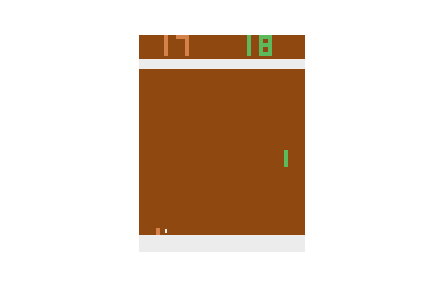
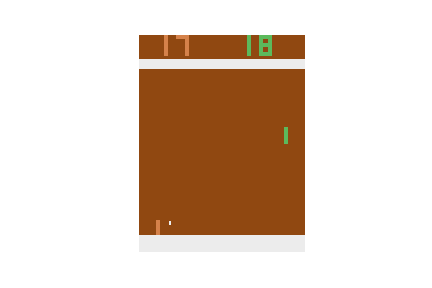
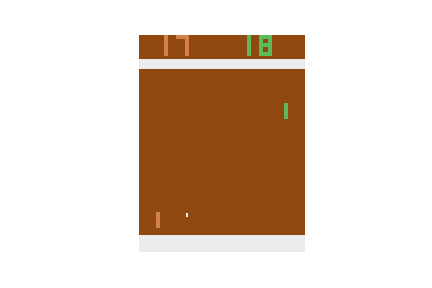
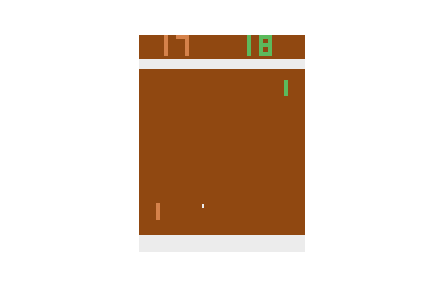
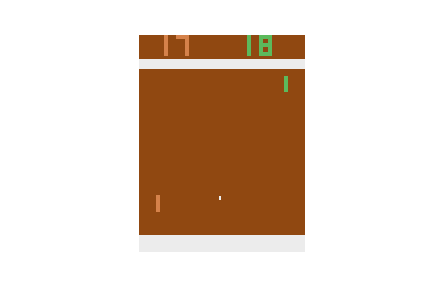
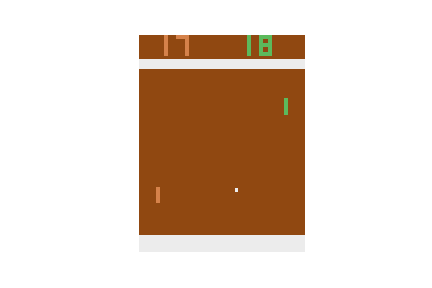
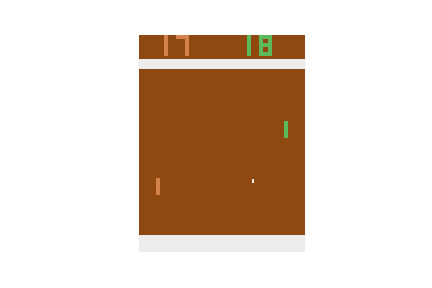
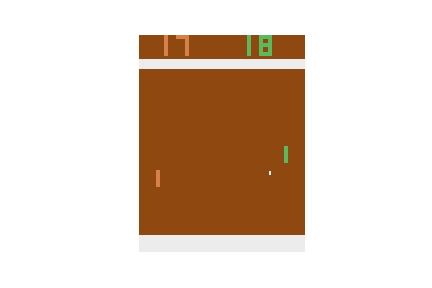
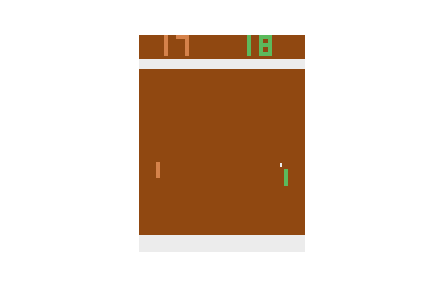
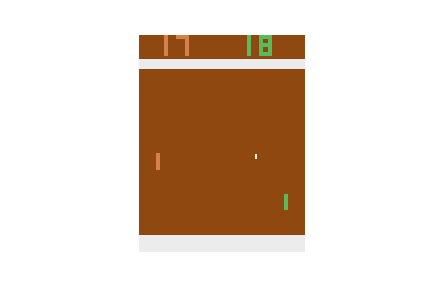
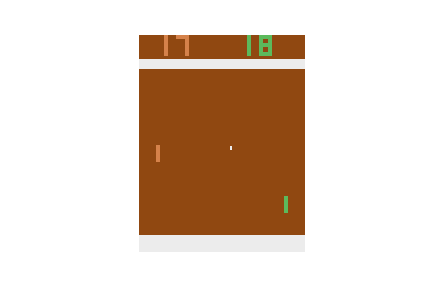
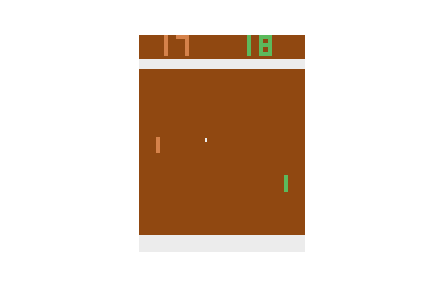
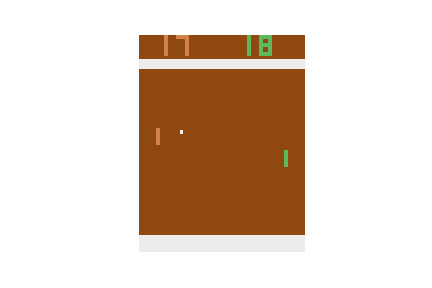
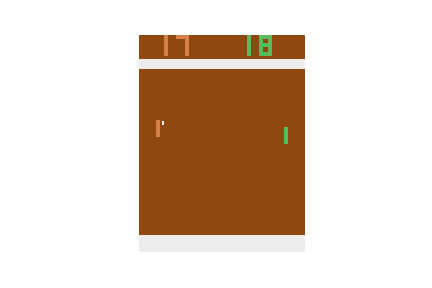
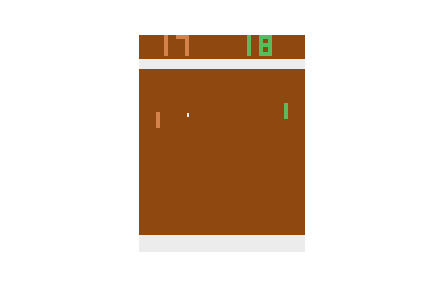
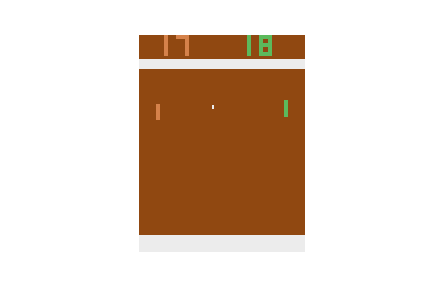
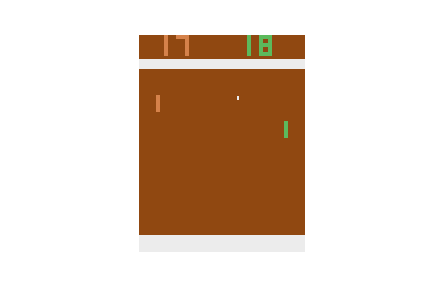
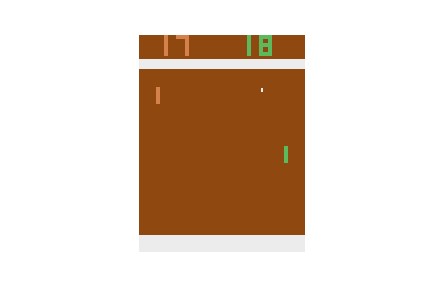
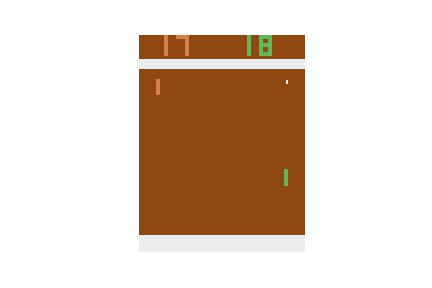
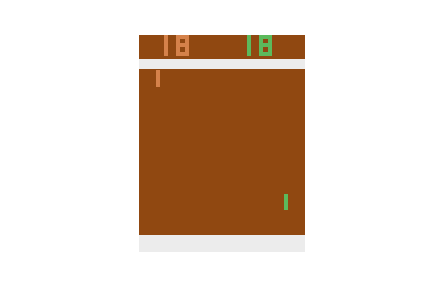
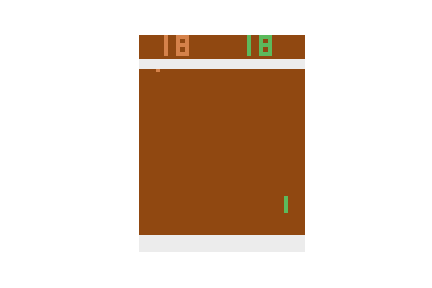
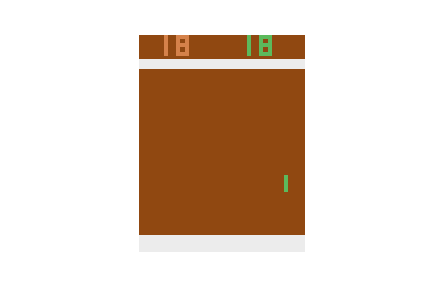
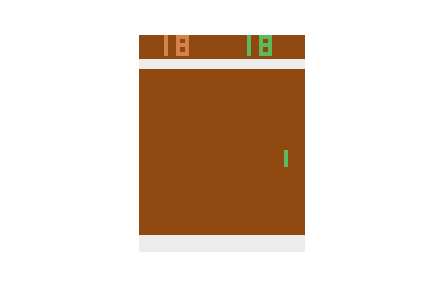
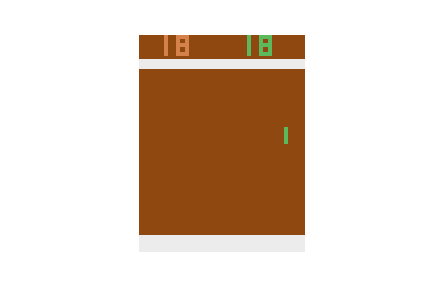
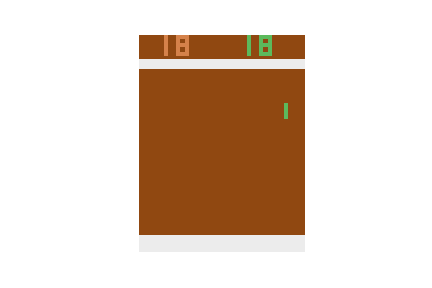
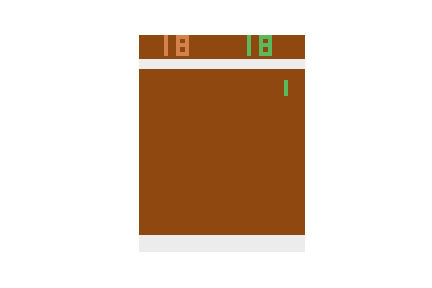
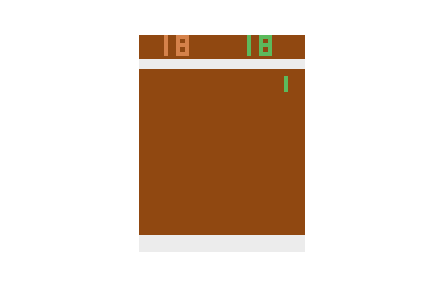
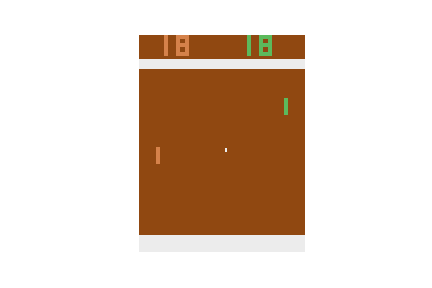
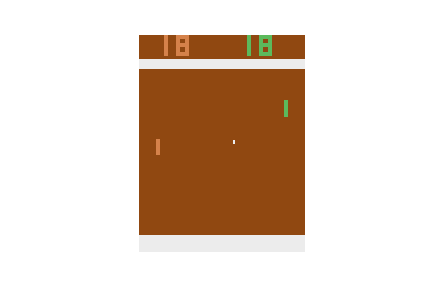
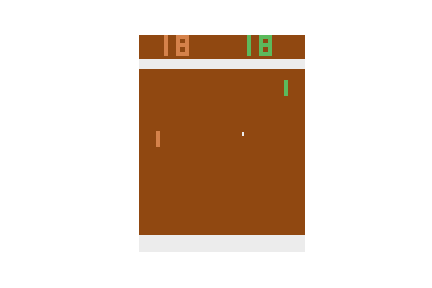
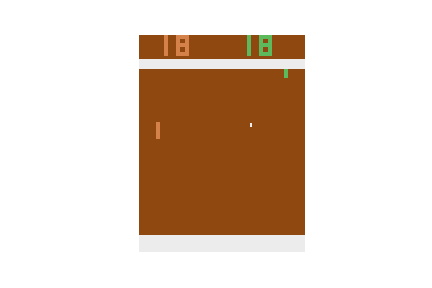
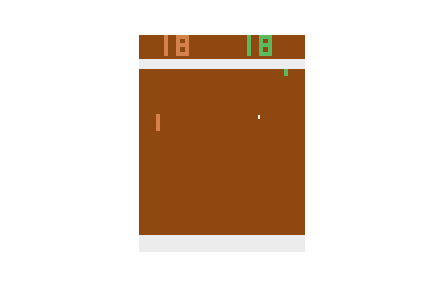
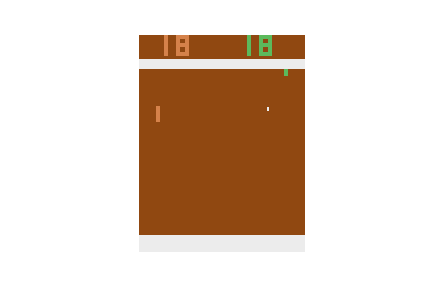
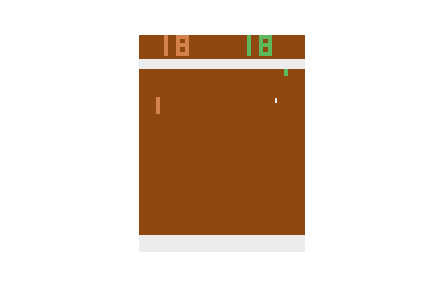
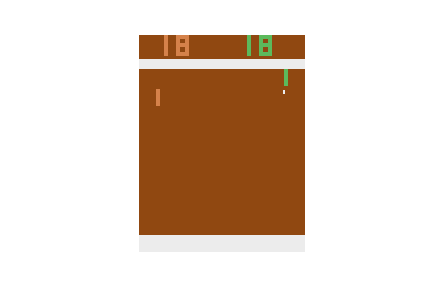
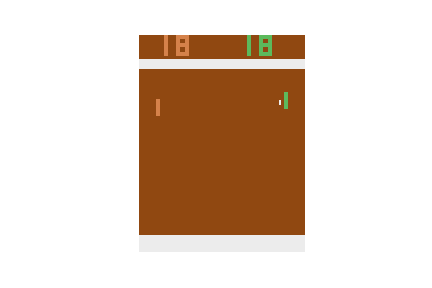
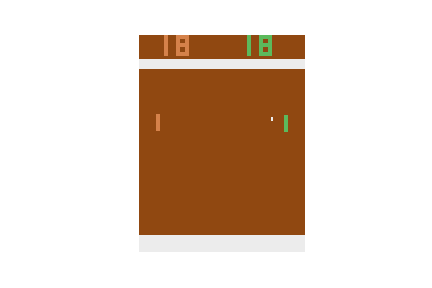
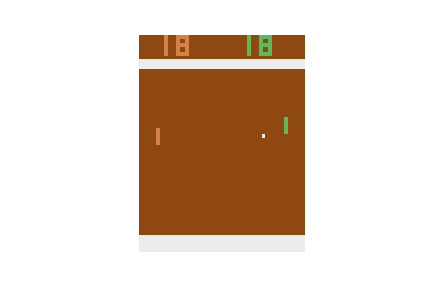
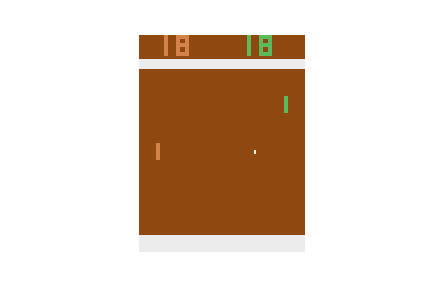
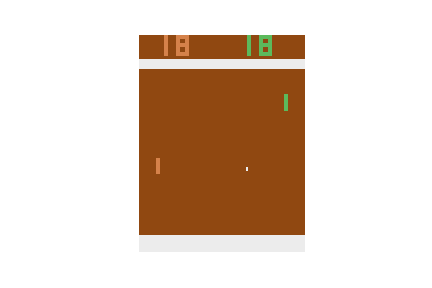
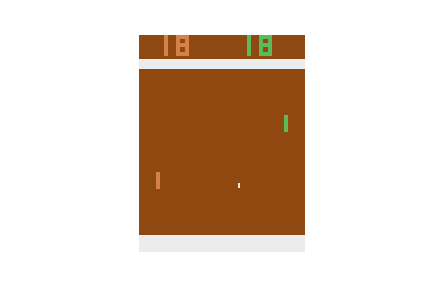
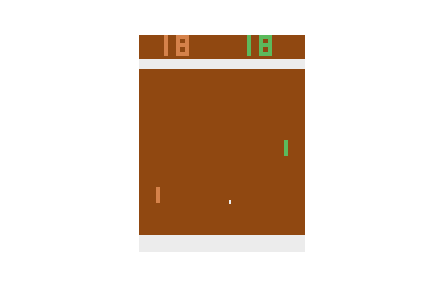
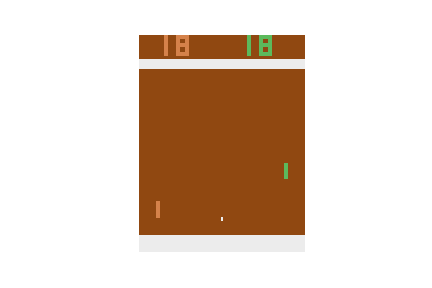
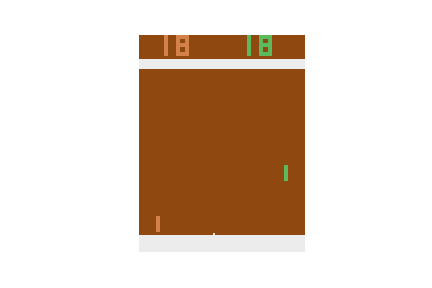
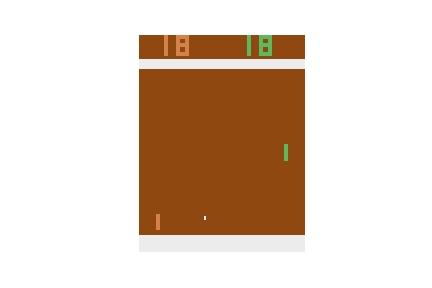
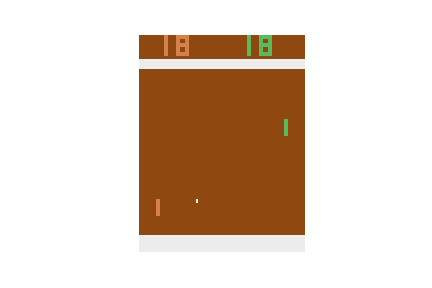
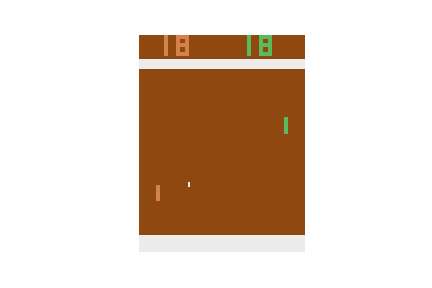
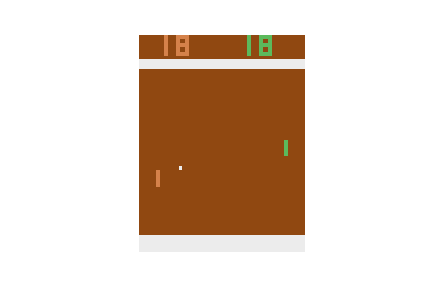
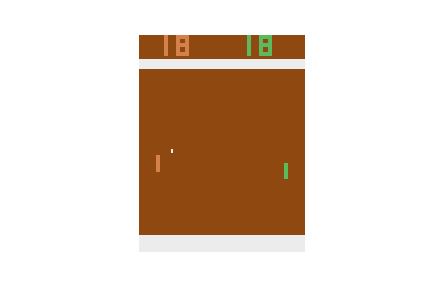
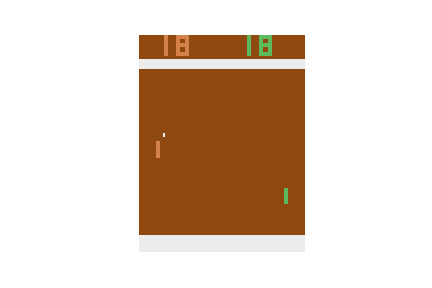
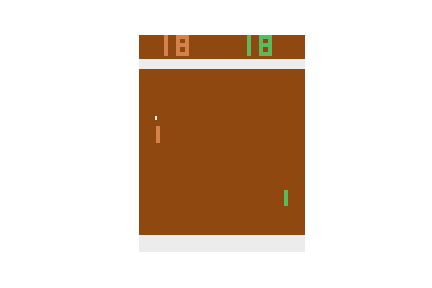
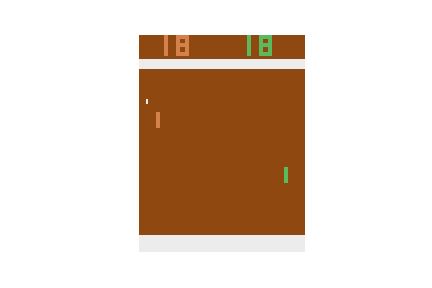
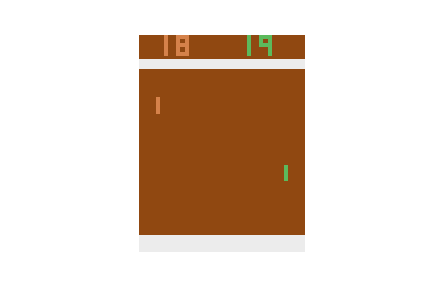
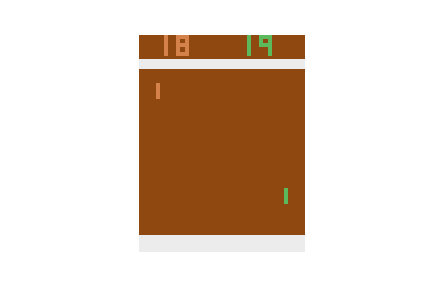
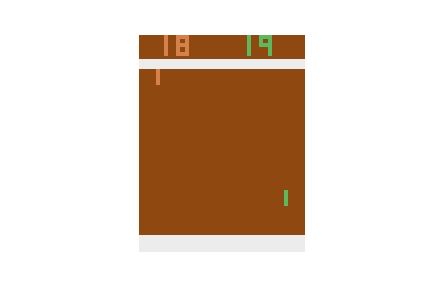
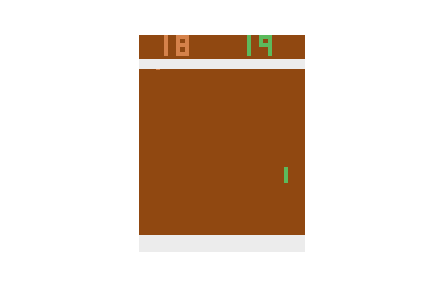
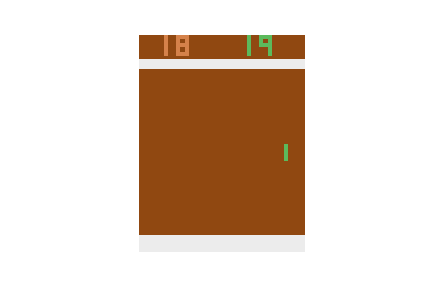
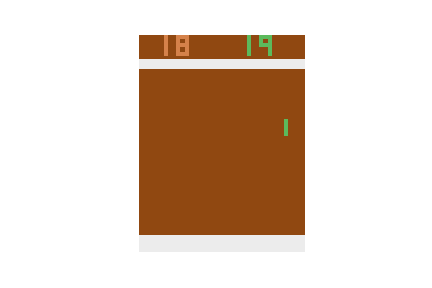
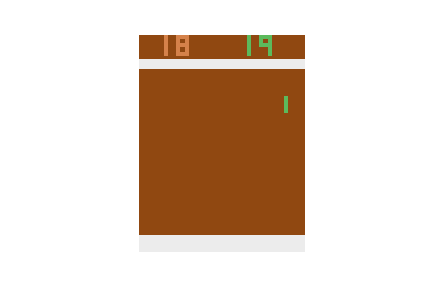
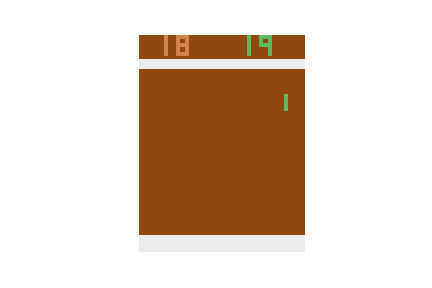
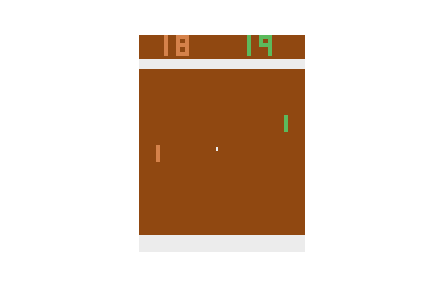
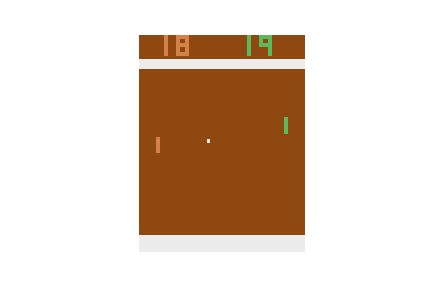
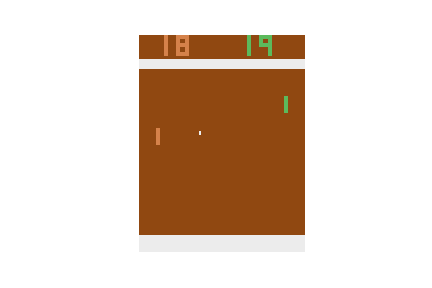
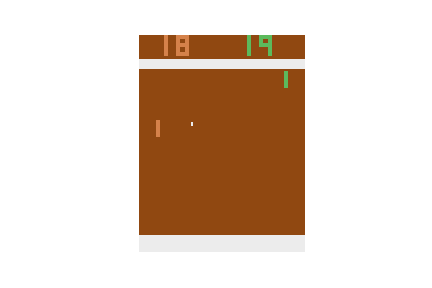
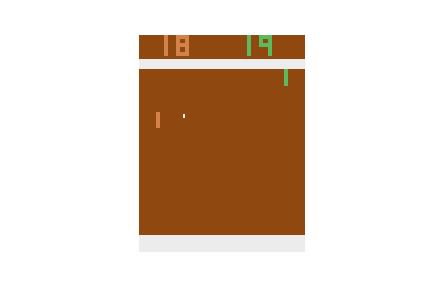
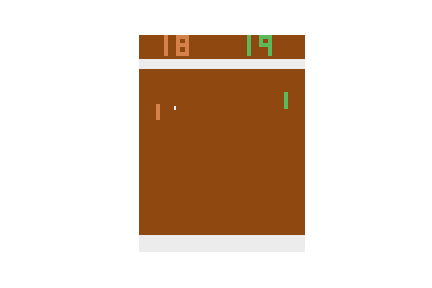
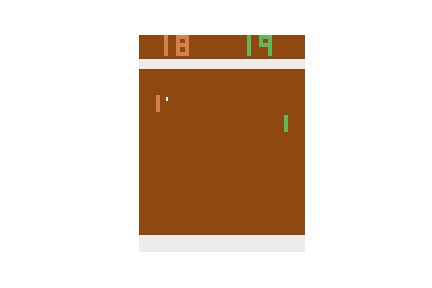
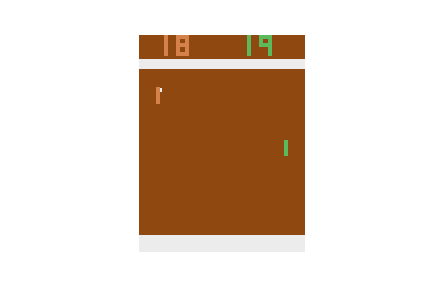
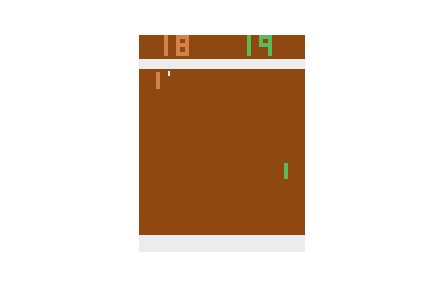
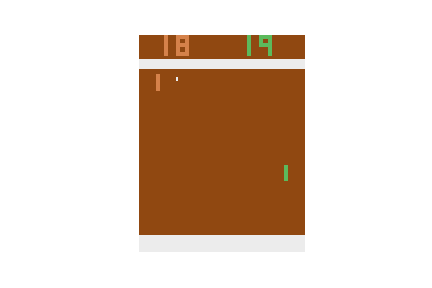
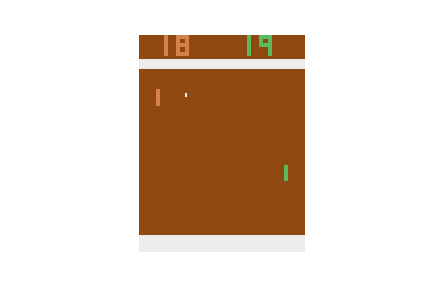
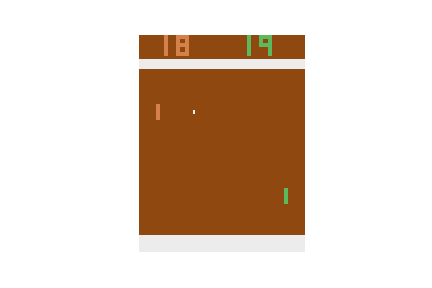
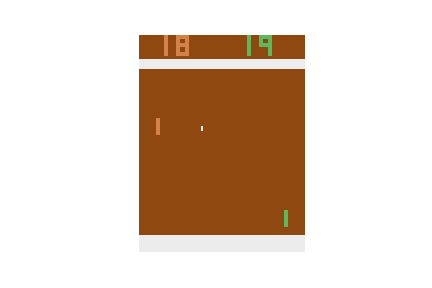
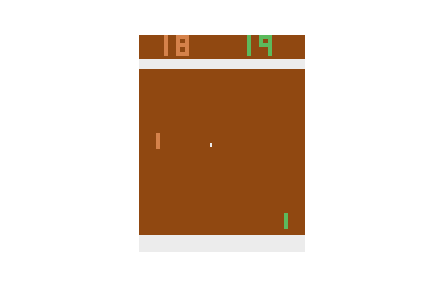
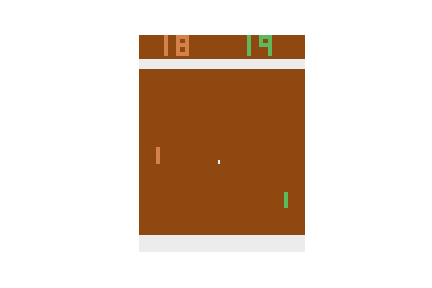
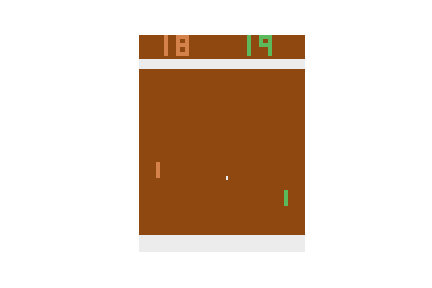
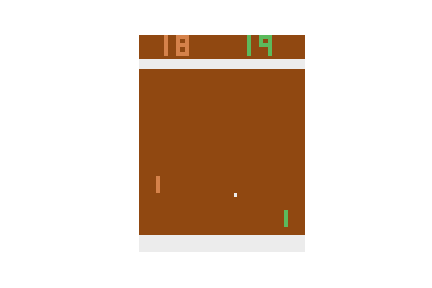
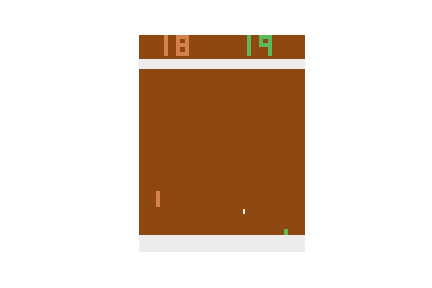
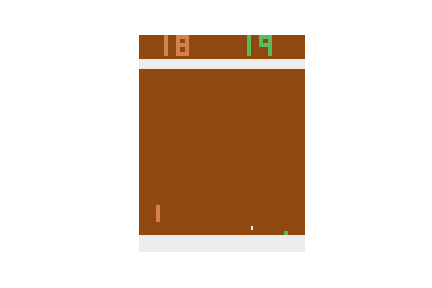
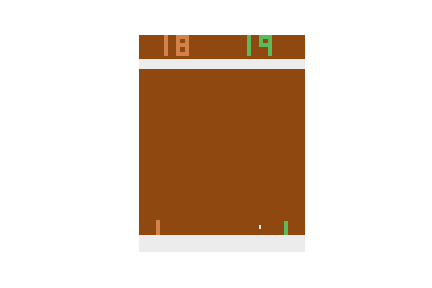
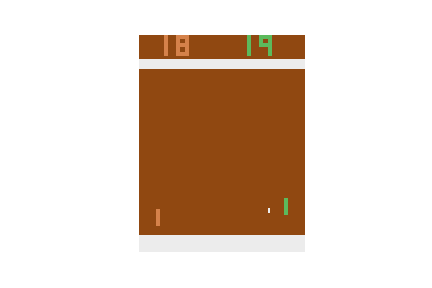
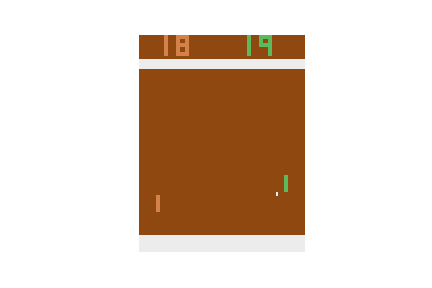
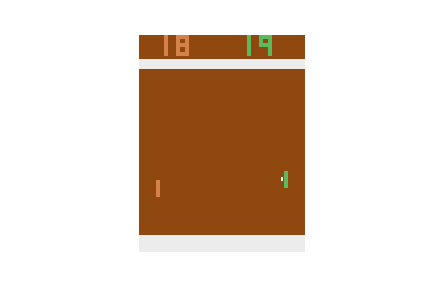
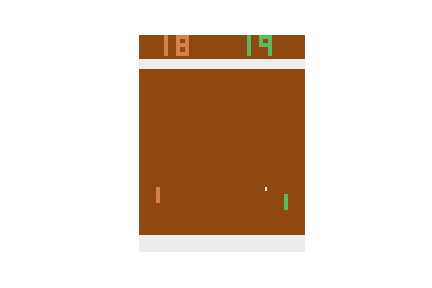
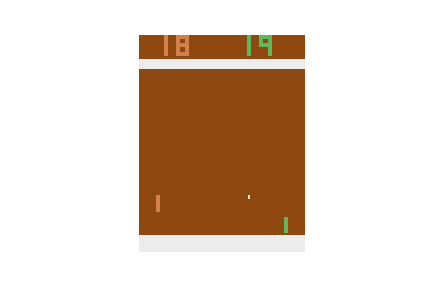
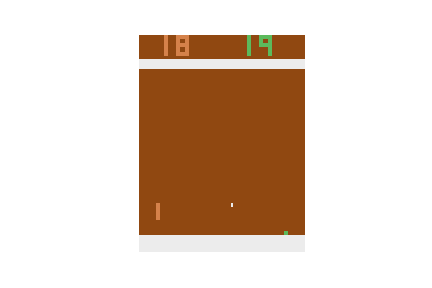
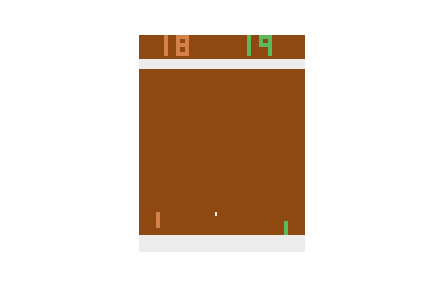
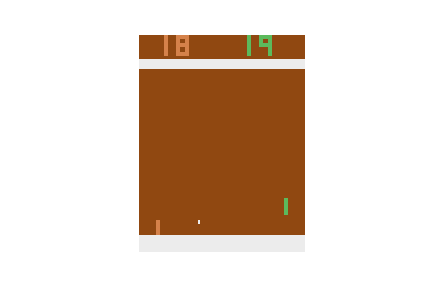
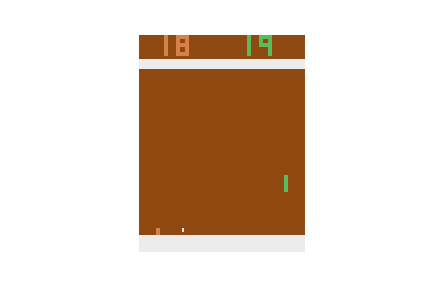
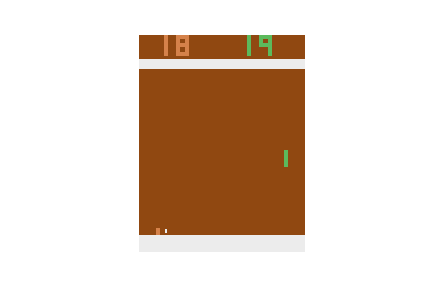
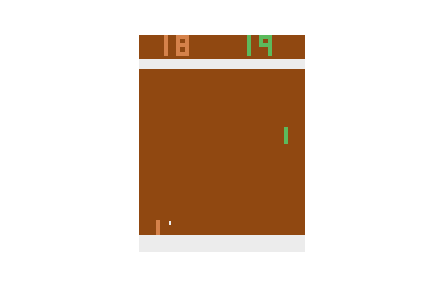
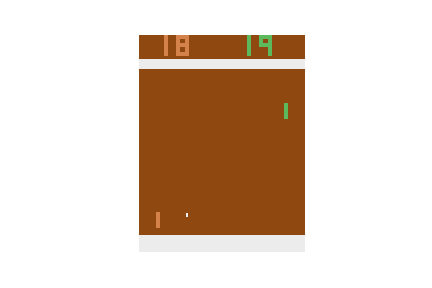
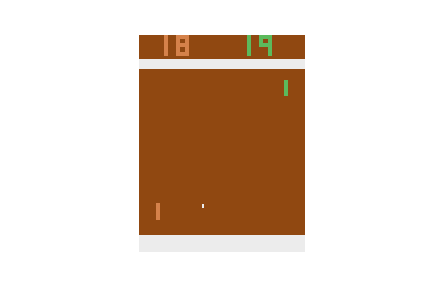
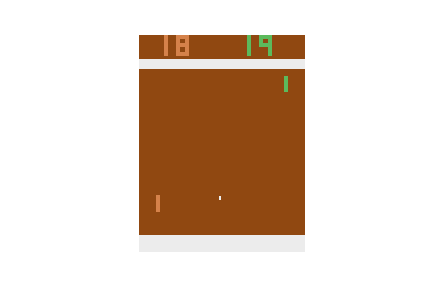
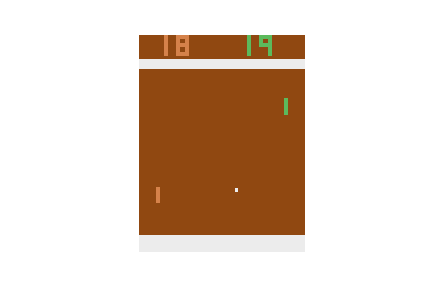
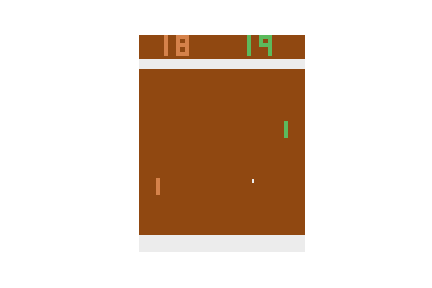
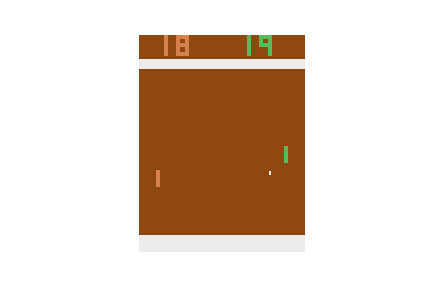
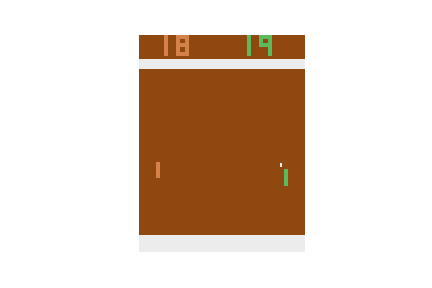
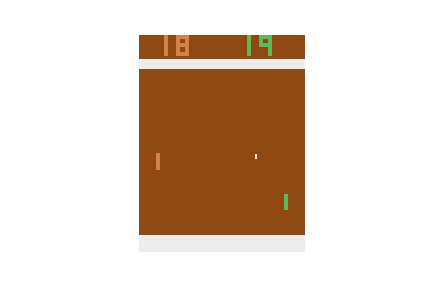
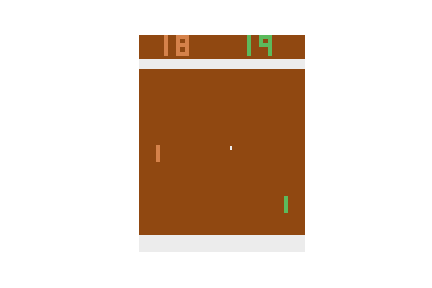
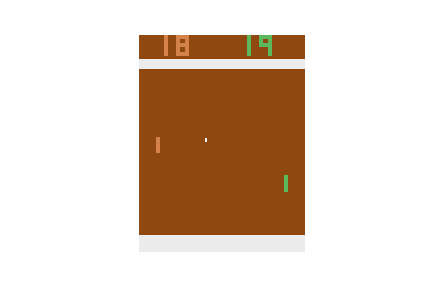
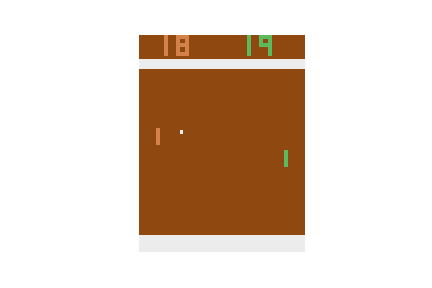
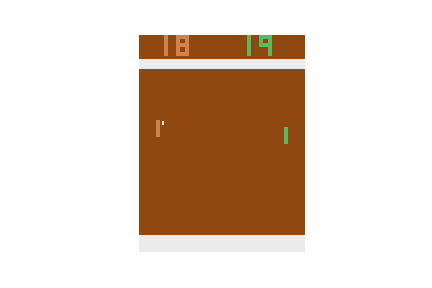
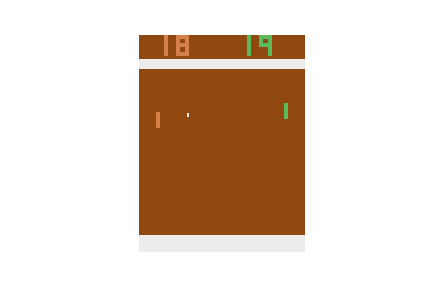
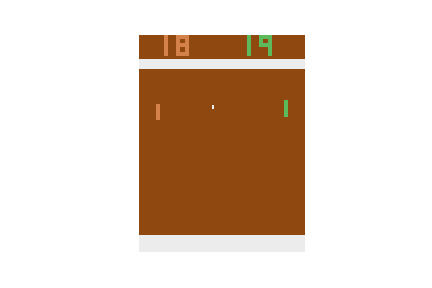
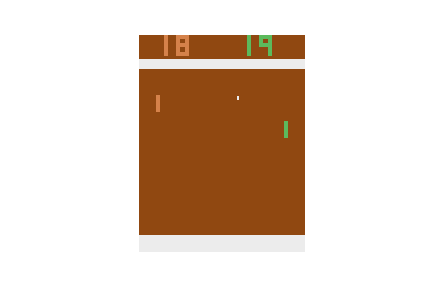
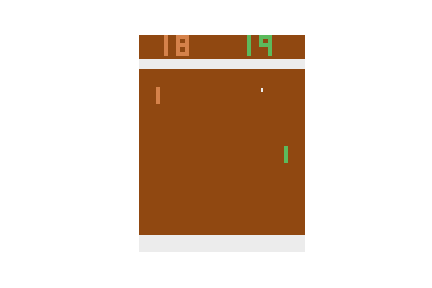
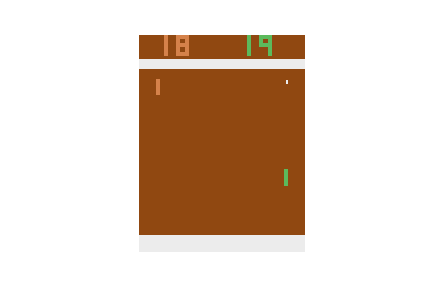
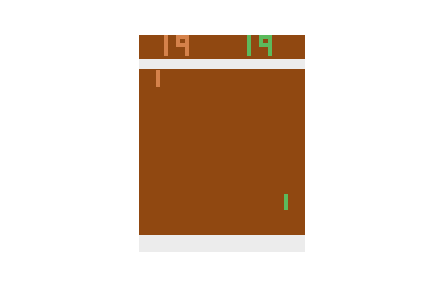
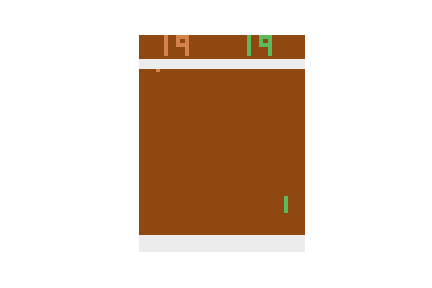
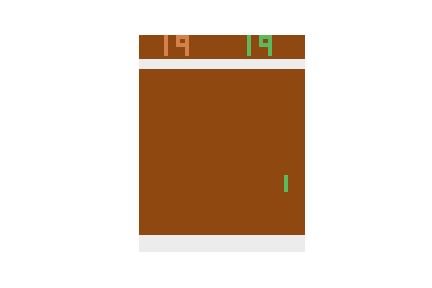
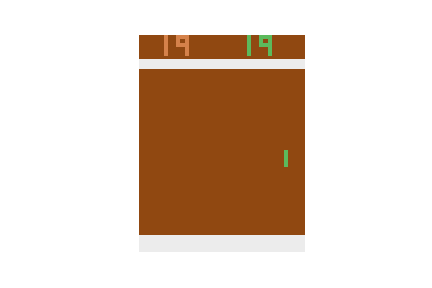
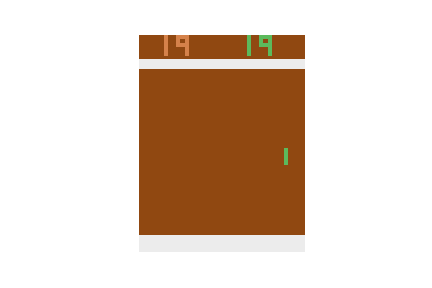
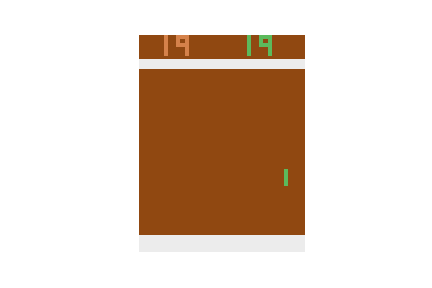
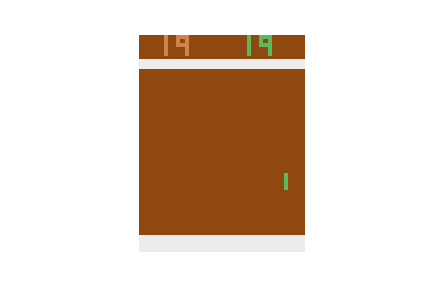
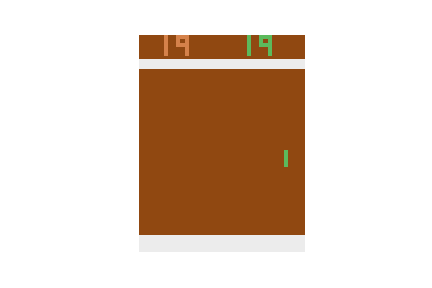
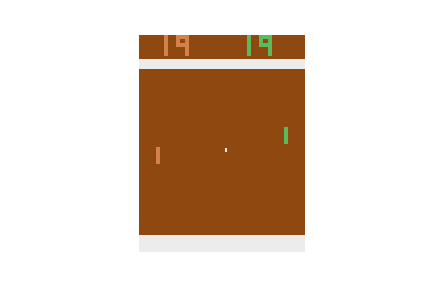
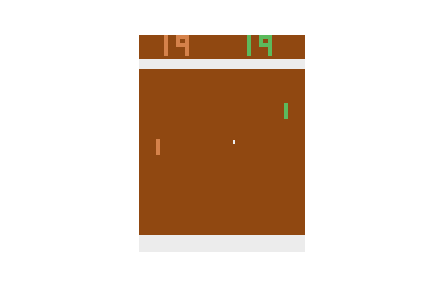
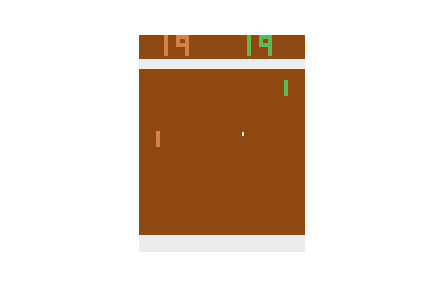
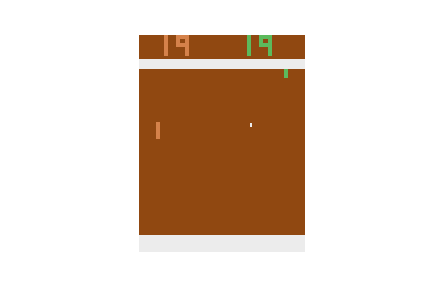
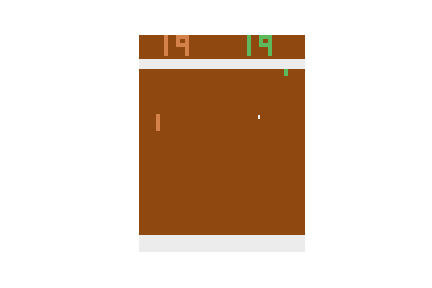
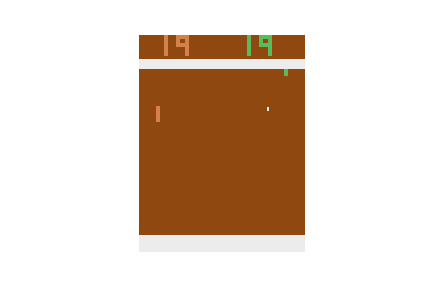
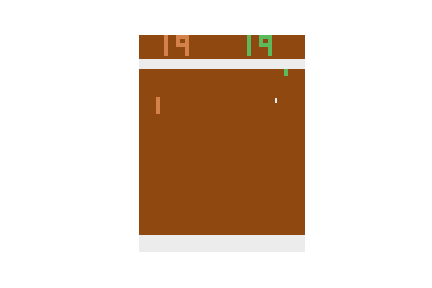
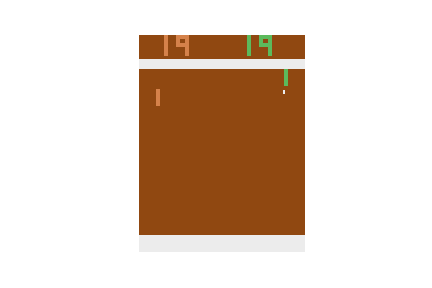
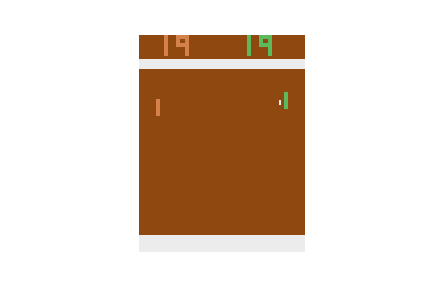
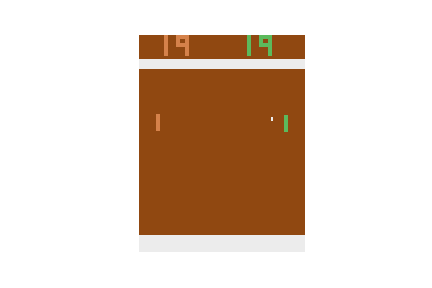
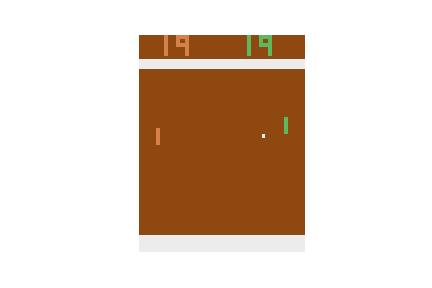
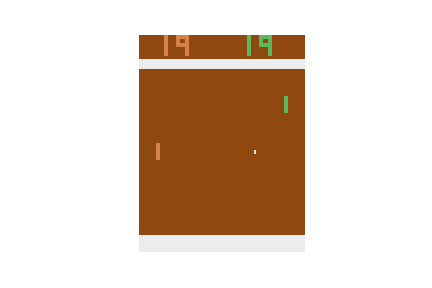
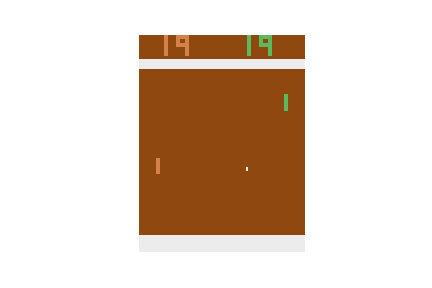
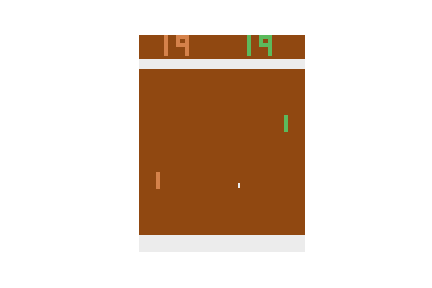
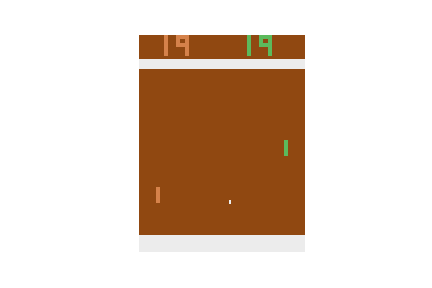
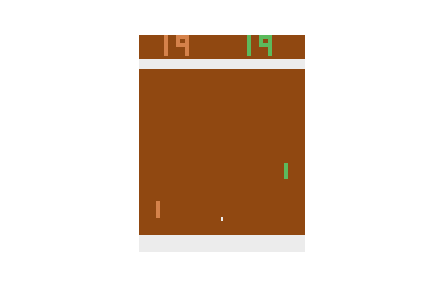
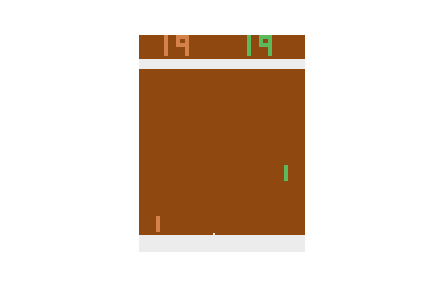
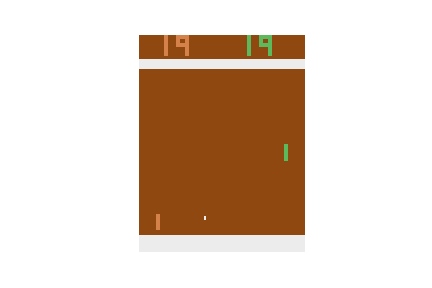
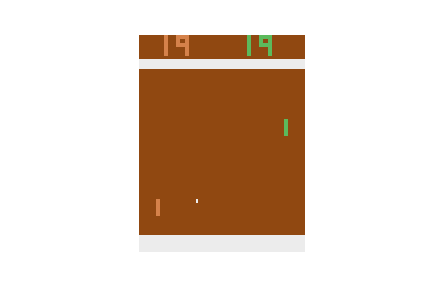
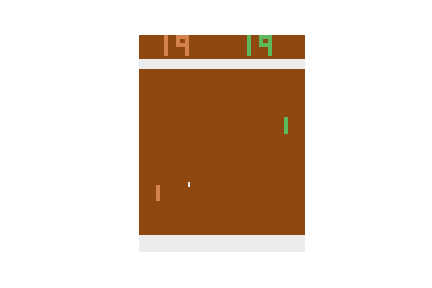
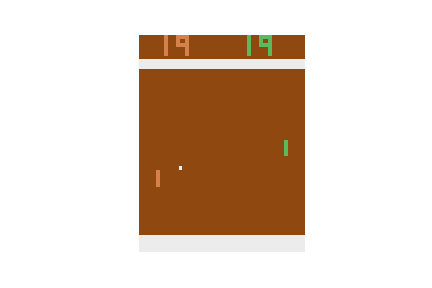
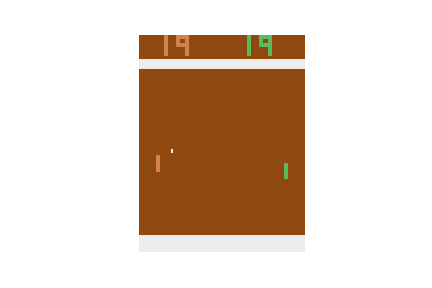
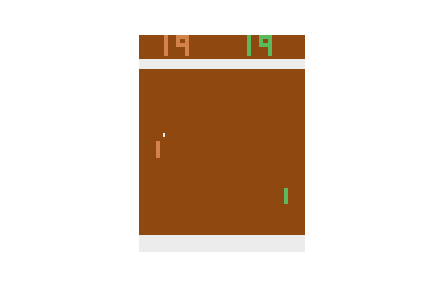
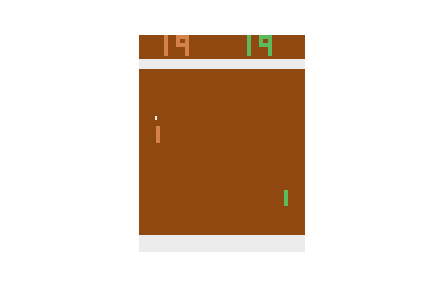
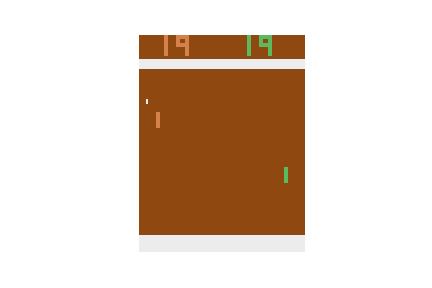
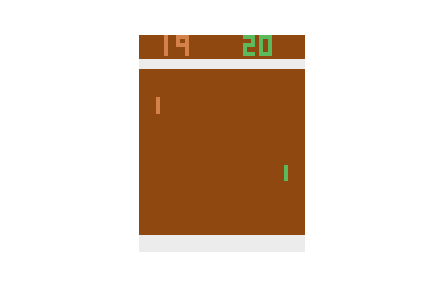
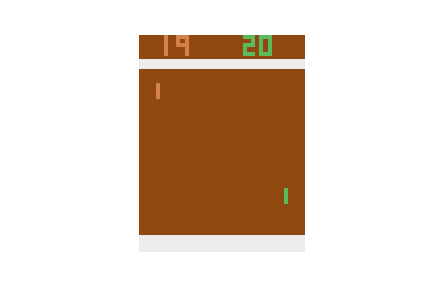
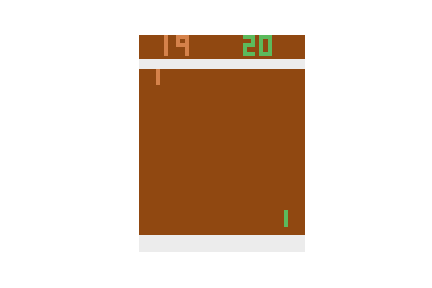
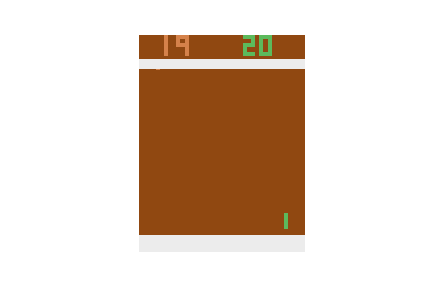
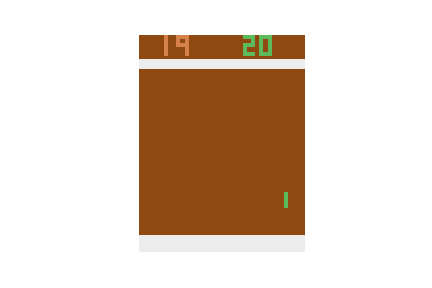
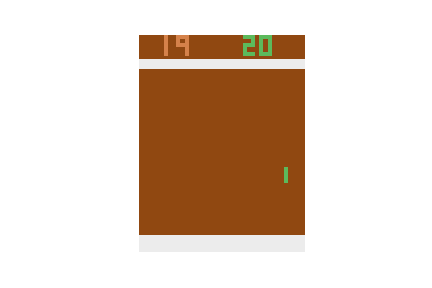
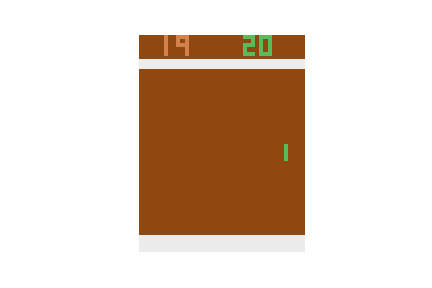
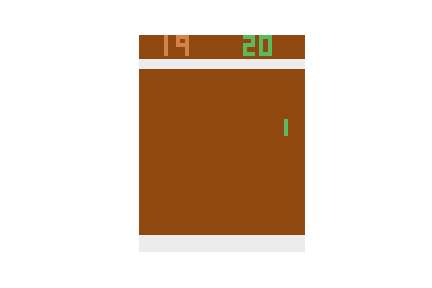
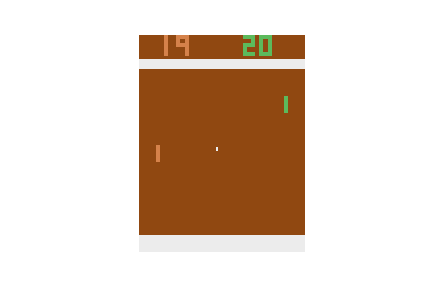
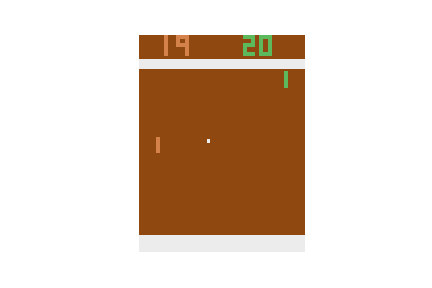
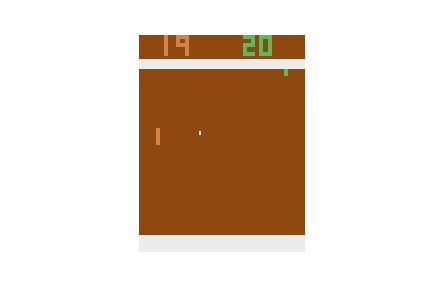
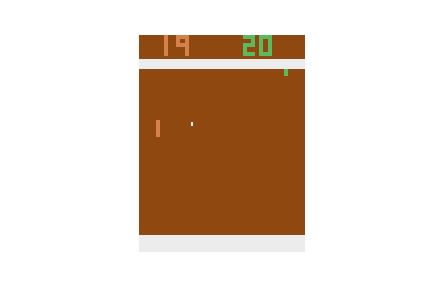
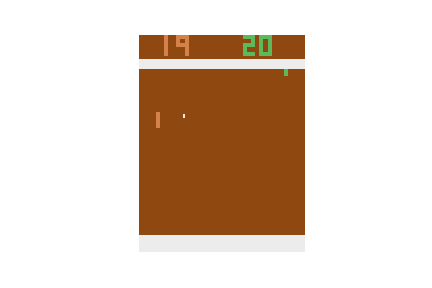
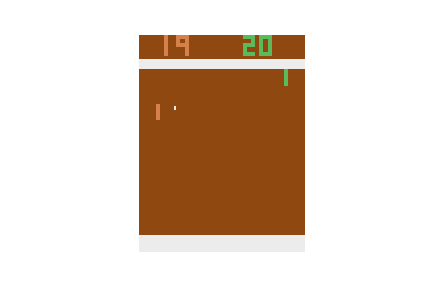
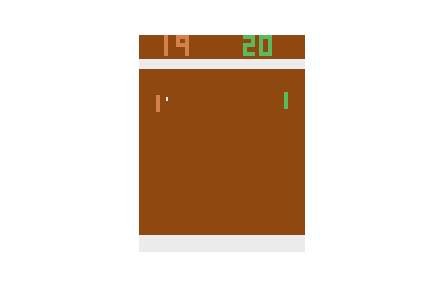
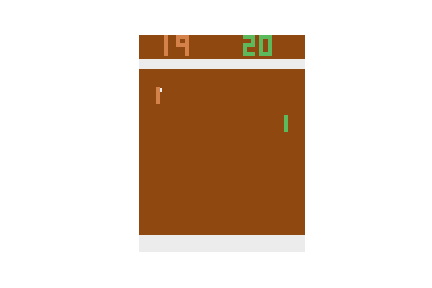
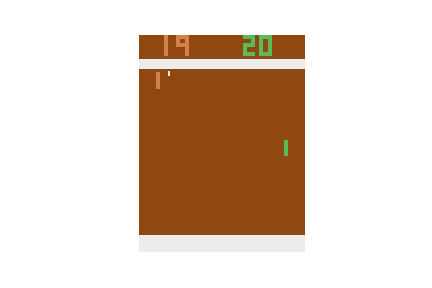
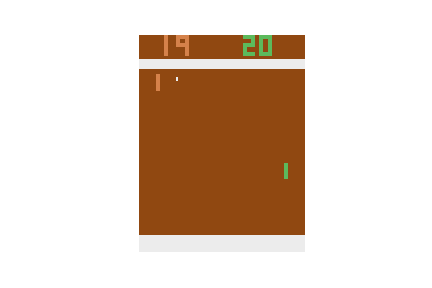
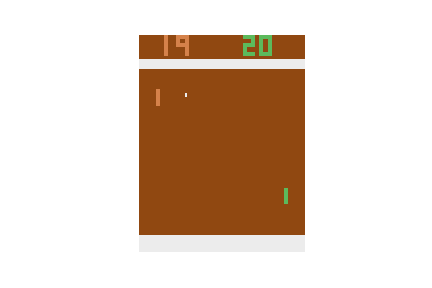
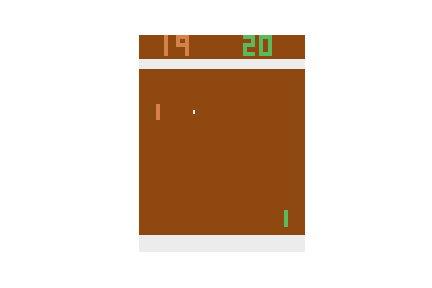
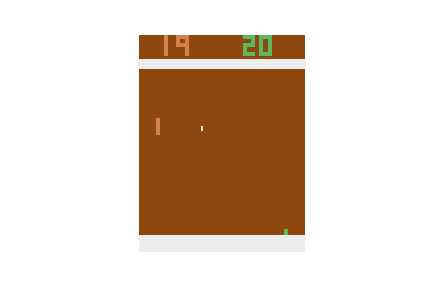
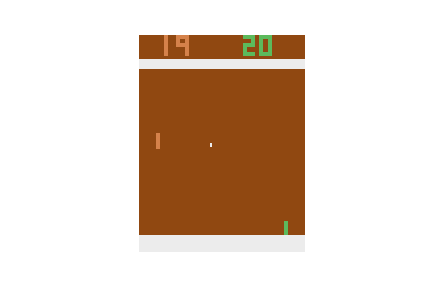
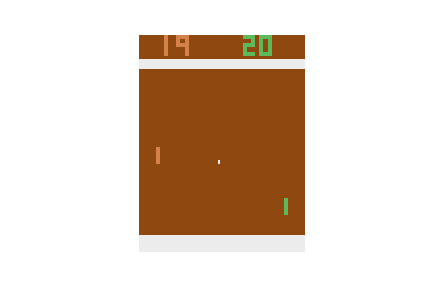
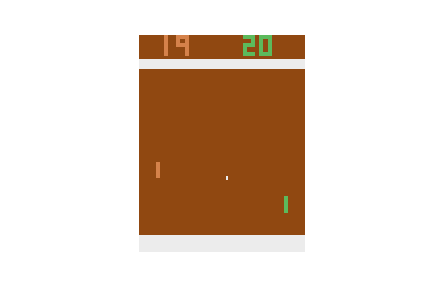
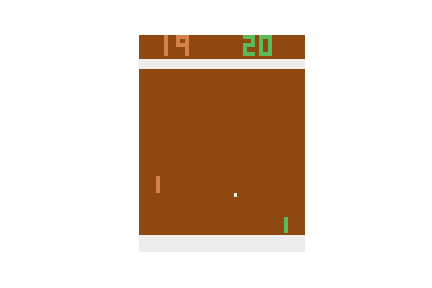
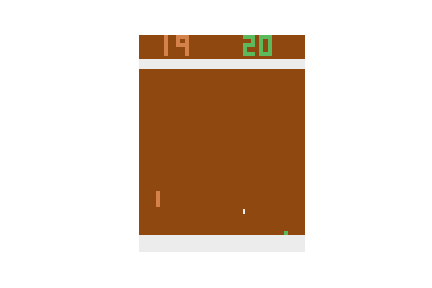
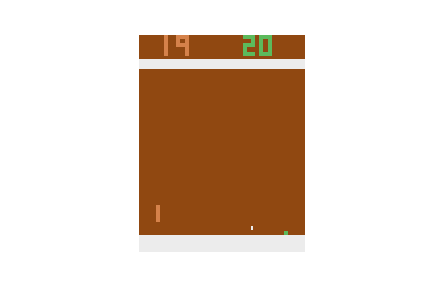
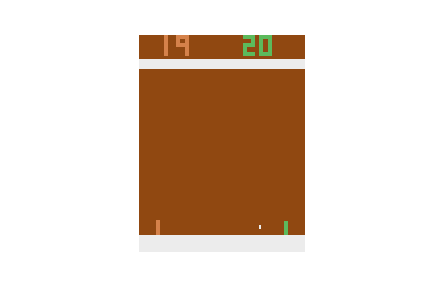
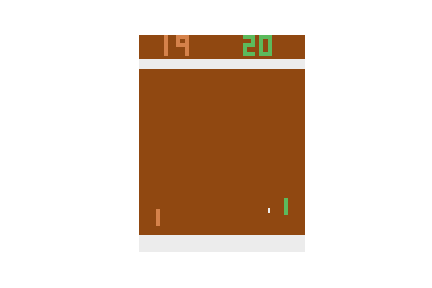
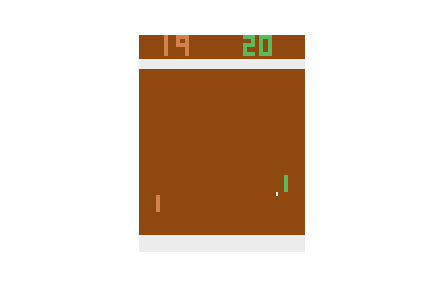
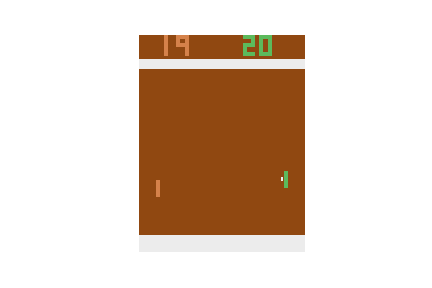
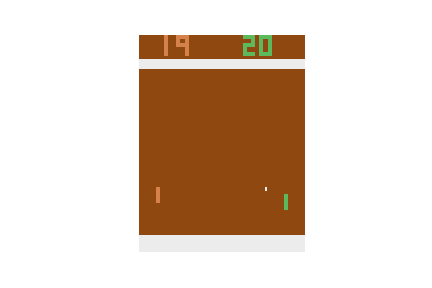
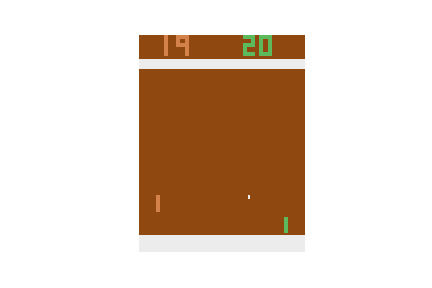
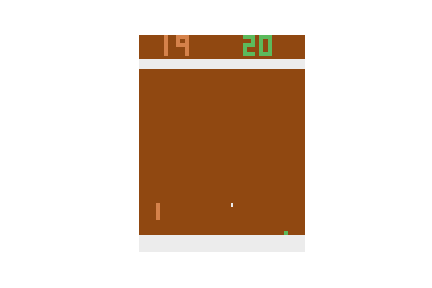
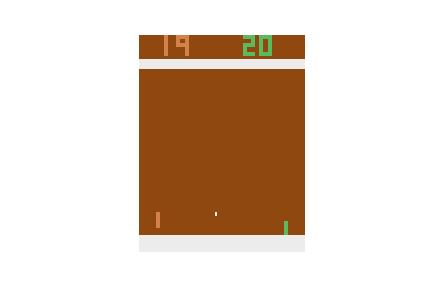
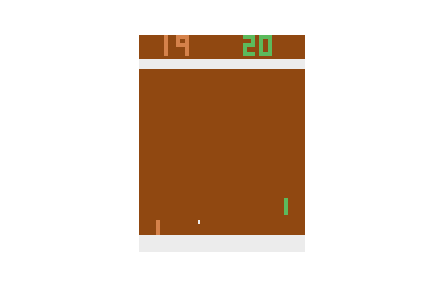
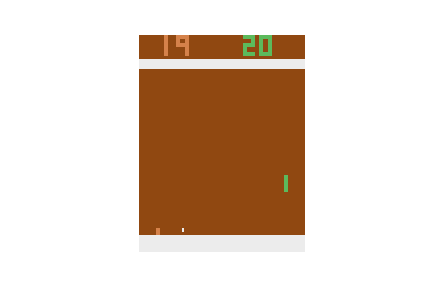
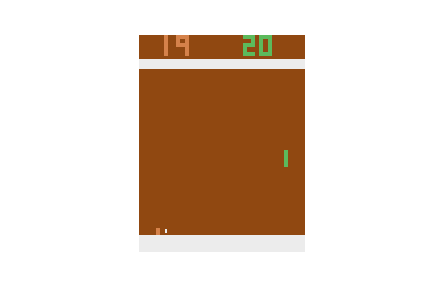
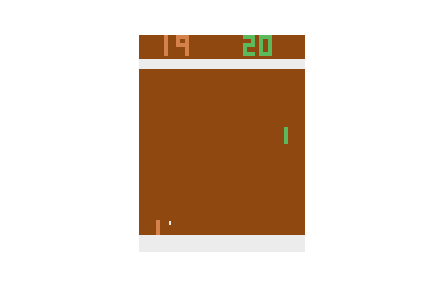
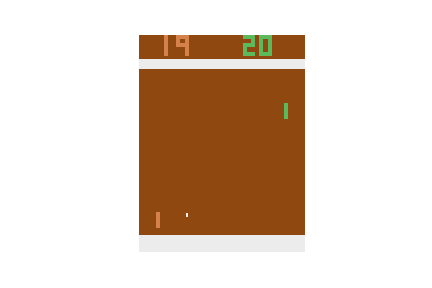
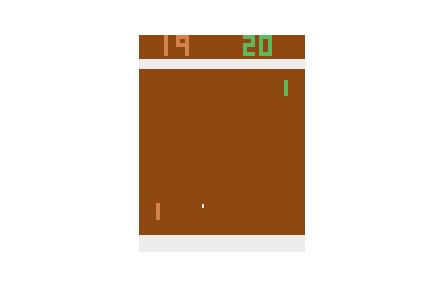
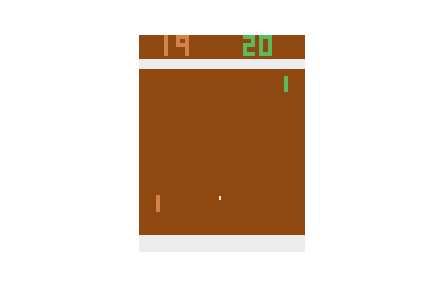
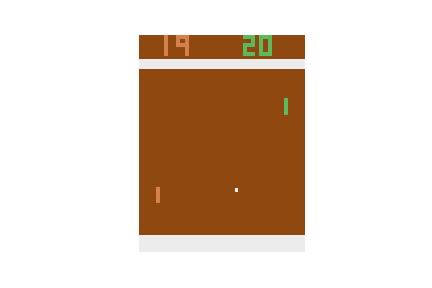
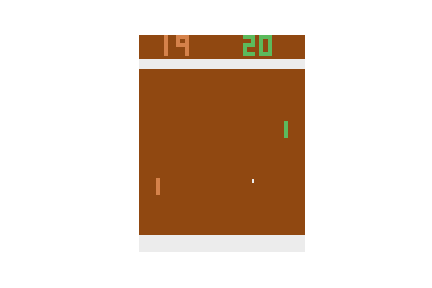
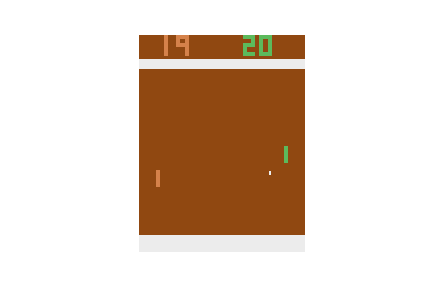
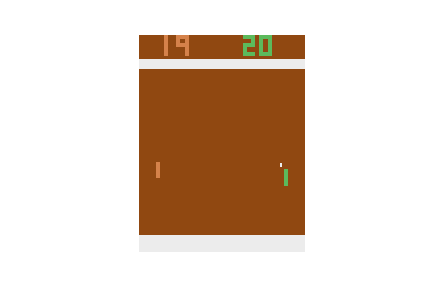
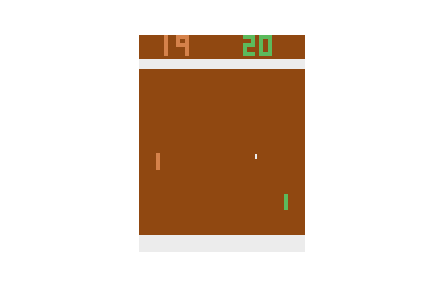
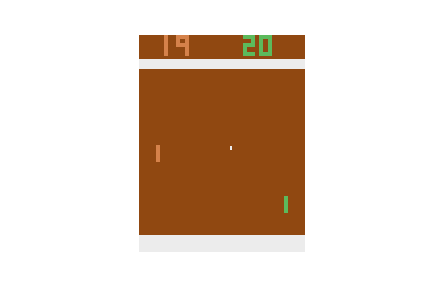
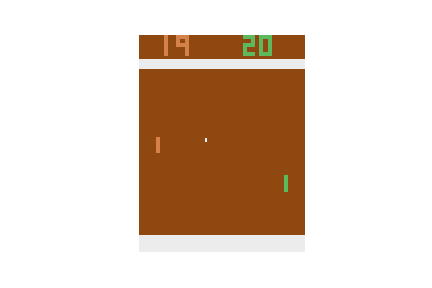
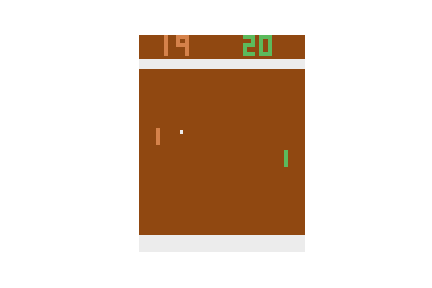
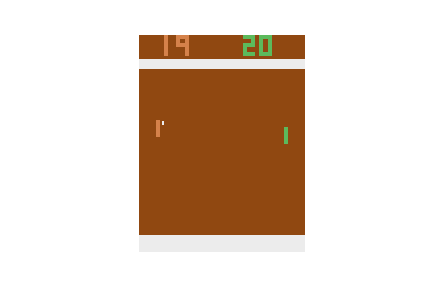
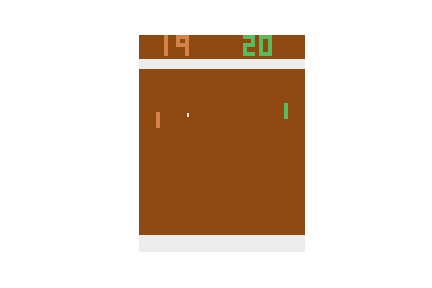
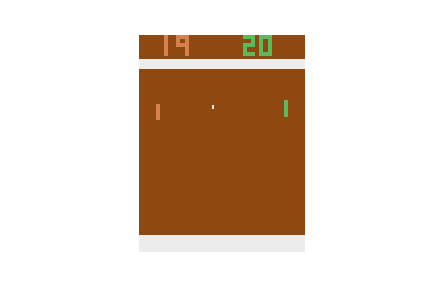
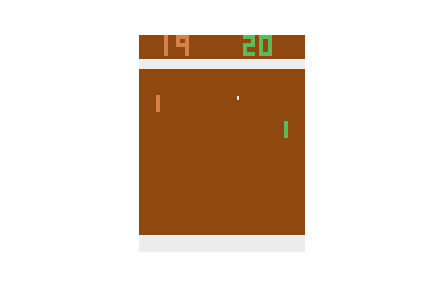
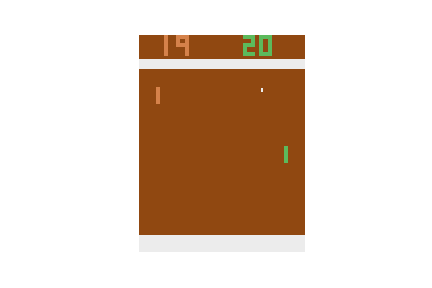
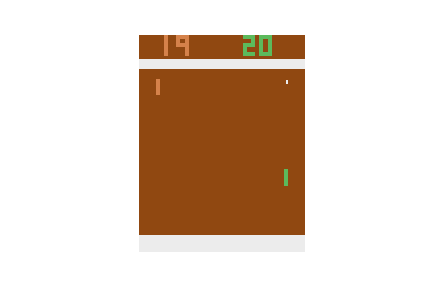
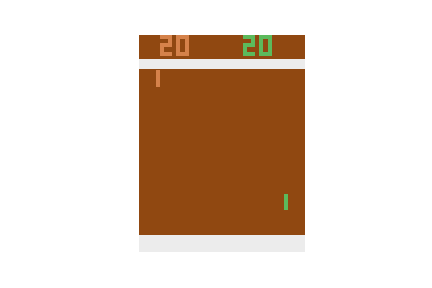
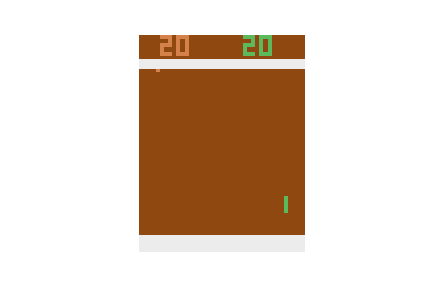
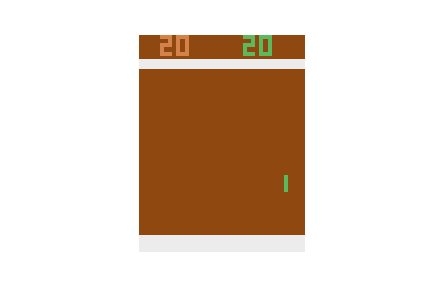
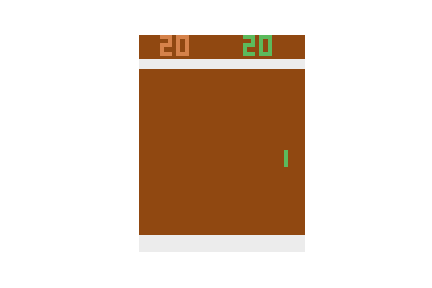
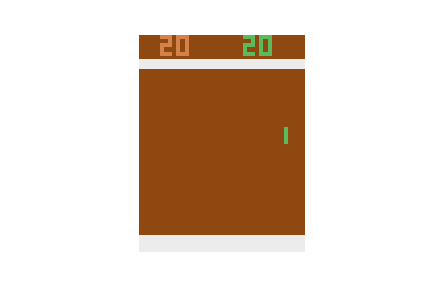
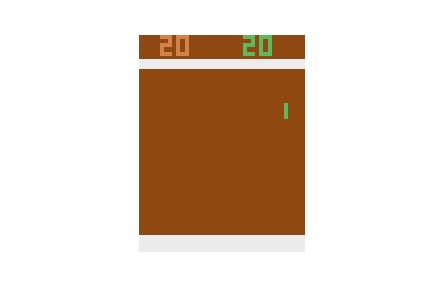
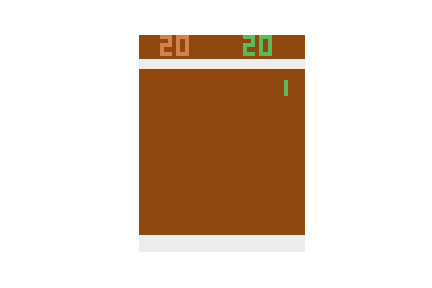
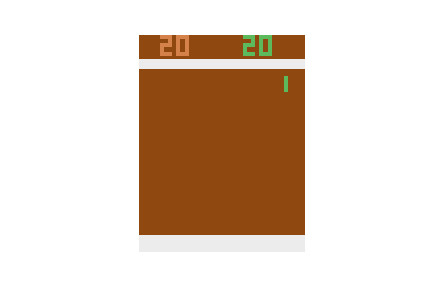
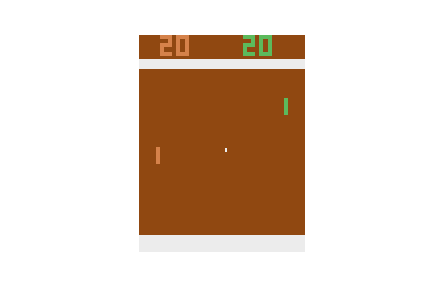
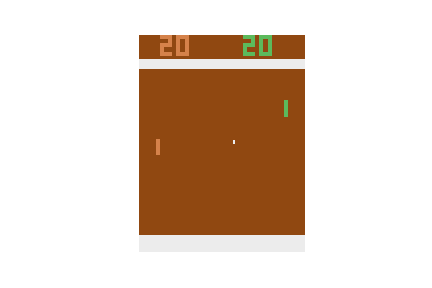
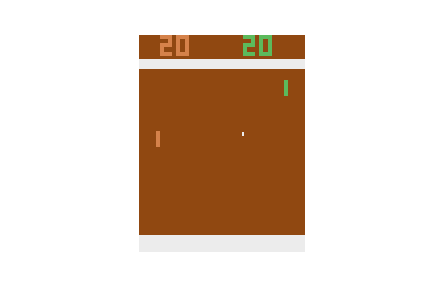
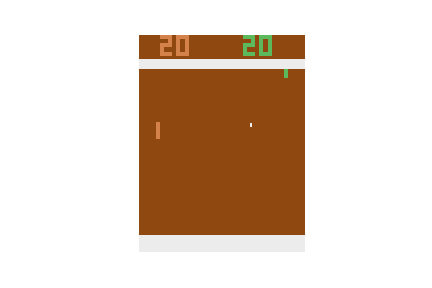
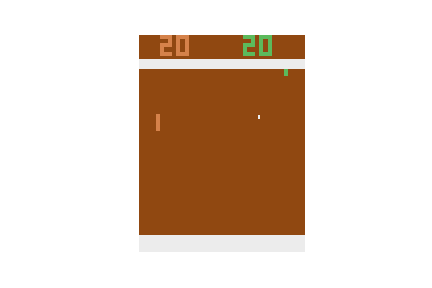
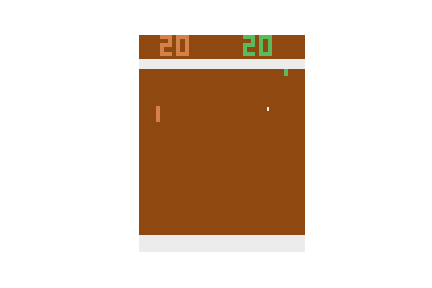
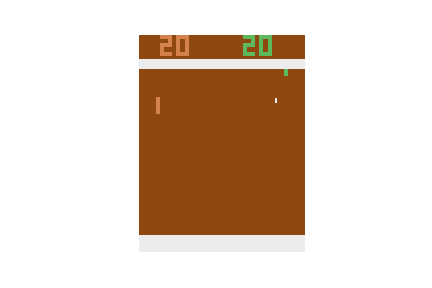
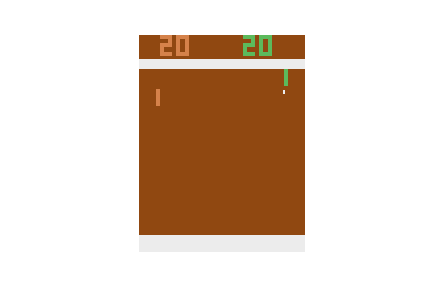
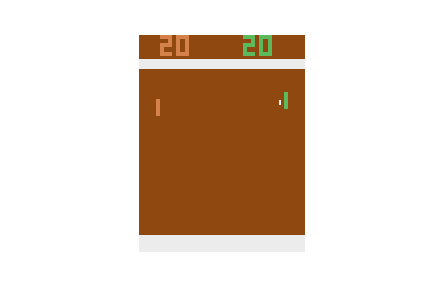
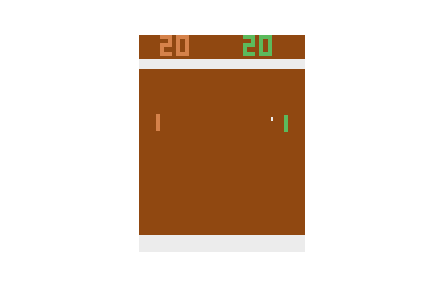
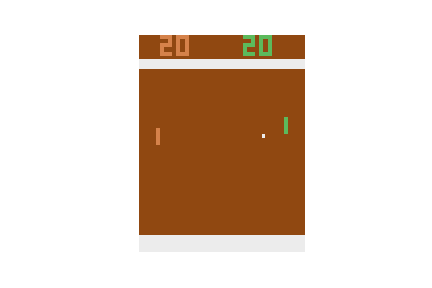
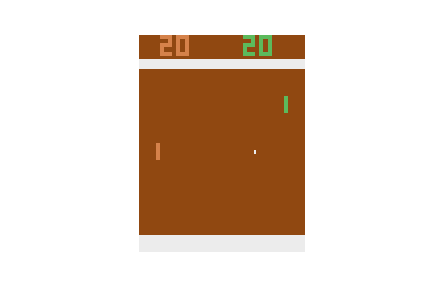
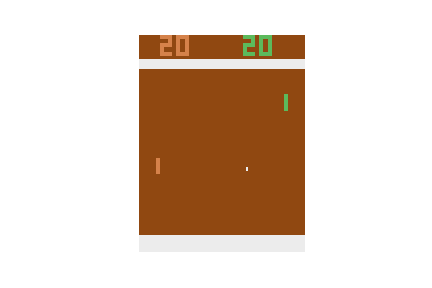
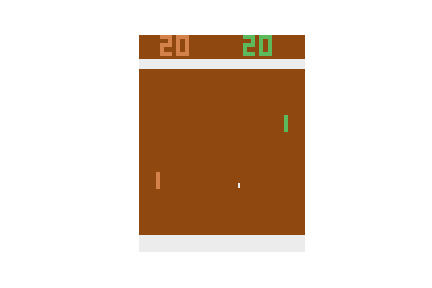
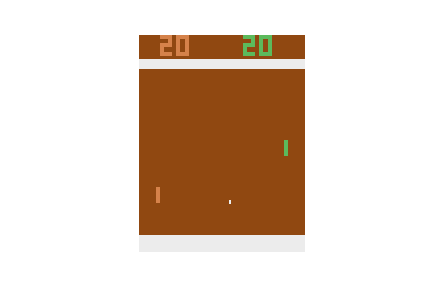
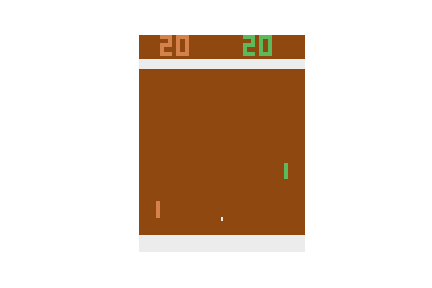
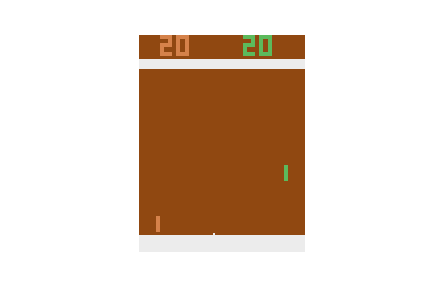
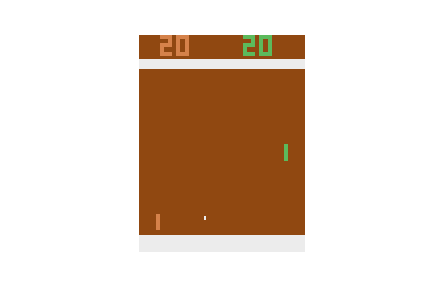
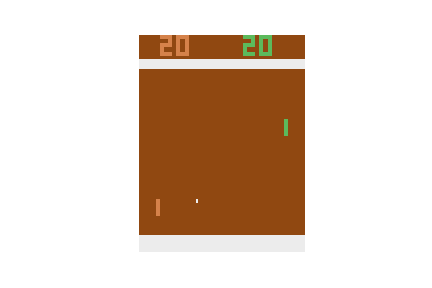
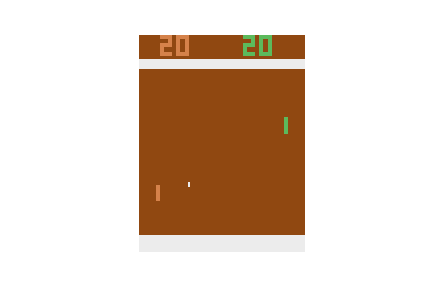
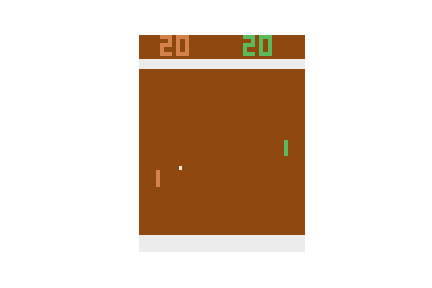
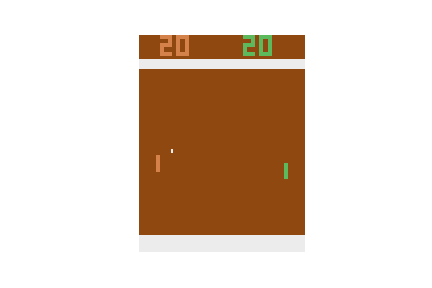
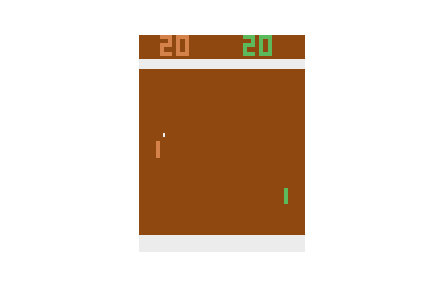
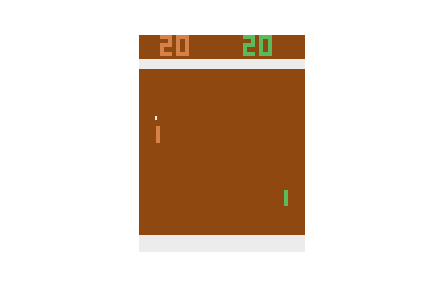
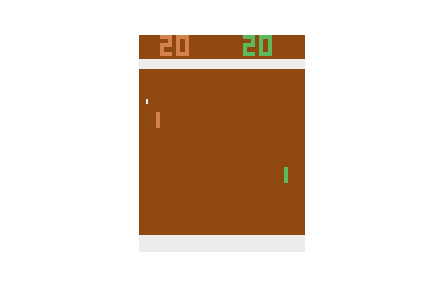
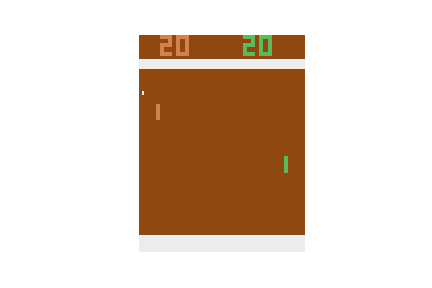

In [33]:
# load policy if needed
agent = Agent()
agent.policy.load_state_dict(torch.load(PATH))
play(env, agent, time=2000) 